[data] Loaded sklearn breast_cancer dataset (real structure).


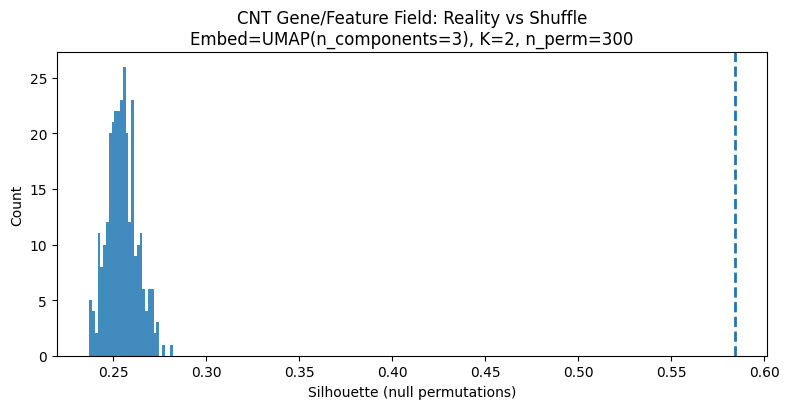

=== CNT Reality-vs-Shuffle Report ===
data_source           : sklearn_breast_cancer
embed_method          : UMAP(n_components=3)
clusters_K            : 2
silhouette_real       : 0.5840109586715698
null_mean             : 0.25486730923255285
null_sd               : 0.00803038052293478
z_score               : 40.9873042129177
p_value_right_tail    : 0.0033222591362126247
cohen_d               : 40.9873042129177
n_permutations        : 300
elapsed_sec           : 519.96
figure                : out\cnt_reality_vs_shuffle.png
verdict               : STRUCTURE IS REAL (reject H0)
[saved] out\cnt_reality_vs_shuffle.png
[saved] out\cnt_reality_vs_shuffle.json


In [1]:
# CNT Reality-vs-Shuffle: Single-Cell, Self-Fetching, Self-Installing
# Runs a falsifiable test that real structure > shuffled baseline.
# - Uses your global `df` if present (numeric cols only), otherwise fetches a standard dataset.
# - Installs umap-learn if available; otherwise falls back to PCA.
# - Saves: out/cnt_reality_vs_shuffle.png and out/cnt_reality_vs_shuffle.json

import sys, subprocess, json, math, time, os, warnings
from pathlib import Path

# ----------------------- light dependency bootstrap -----------------------
def _safe_import(name, pip_name=None):
    try:
        return __import__(name)
    except Exception:
        if pip_name is None: pip_name = name
        try:
            print(f"[setup] Installing {pip_name} ...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pip_name])
            return __import__(name)
        except Exception as e:
            print(f"[warn] Could not install {pip_name}: {e}")
            return None

np = _safe_import("numpy")
pd = _safe_import("pandas")
sklearn = _safe_import("sklearn", "scikit-learn")
umap_mod = _safe_import("umap", "umap-learn")  # optional
matplotlib = _safe_import("matplotlib")
if matplotlib is None:
    raise RuntimeError("matplotlib is required for plotting.")
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings("ignore", category=UserWarning)
Path("out").mkdir(parents=True, exist_ok=True)

# ----------------------- helpers -----------------------
def _numeric_matrix_from_df(df):
    num = df.select_dtypes(include=[np.number]).copy()
    if num.shape[1] == 0:
        raise ValueError("No numeric columns found in `df`.")
    # Fill NaNs by median per column
    num = num.fillna(num.median(numeric_only=True))
    # Drop constant or all-NaN columns
    keep = []
    for c in num.columns:
        col = num[c].to_numpy()
        if np.isfinite(col).sum() >= 2 and np.nanstd(col) > 0:
            keep.append(c)
    num = num[keep]
    if num.shape[1] < 2:
        raise ValueError("Not enough informative numeric columns after cleaning.")
    X = num.to_numpy()
    return X, keep

def _embed(X, n_components=3, random_state=42):
    if umap_mod is not None:
        try:
            reducer = umap_mod.UMAP(n_components=n_components, n_neighbors=30,
                                    min_dist=0.1, random_state=random_state)
            Z = reducer.fit_transform(X)
            return Z, f"UMAP(n_components={n_components})"
        except Exception as e:
            print(f"[warn] UMAP failed ({e}); falling back to PCA.")
    pca = PCA(n_components=min(n_components, X.shape[1]), random_state=random_state)
    Z = pca.fit_transform(X)
    return Z, f"PCA(n_components={min(n_components, X.shape[1])})"

def _choose_k_by_silhouette(Z, k_candidates=(2,3,4,5,6,8,10), random_state=42):
    best_k, best_s = None, -1
    for K in k_candidates:
        try:
            km = KMeans(n_clusters=K, n_init=10, random_state=random_state)
            labels = km.fit_predict(Z)
            # need at least two non-singleton clusters
            counts = np.bincount(labels)
            if (counts < 2).any(): 
                continue
            s = silhouette_score(Z, labels)
            if s > best_s:
                best_s, best_k = s, K
        except Exception:
            pass
    if best_k is None:
        # Fall back: try K=2
        best_k = 2
    return best_k

def _silhouette(Z, labels):
    if len(set(labels)) < 2: 
        return np.nan
    counts = np.bincount(labels)
    if (counts < 2).any():
        return np.nan
    return silhouette_score(Z, labels)

def _permute_features(X, rng):
    Xp = X.copy()
    for j in range(Xp.shape[1]):
        rng.shuffle(Xp[:, j])
    return Xp

# ----------------------- data acquisition -----------------------
def _get_data():
    # Priority 1: user's global df
    gdf = globals().get("df", None)
    if gdf is not None:
        print("[data] Using global `df` found in the notebook.")
        X, cols = _numeric_matrix_from_df(gdf)
        return X, {"source": "user_df", "columns": cols}
    # Priority 2: standard structured dataset with real signal
    if sklearn is not None:
        try:
            from sklearn.datasets import load_breast_cancer
            ds = load_breast_cancer(as_frame=True)
            X, cols = _numeric_matrix_from_df(ds.frame.drop(columns=["target"]))
            print("[data] Loaded sklearn breast_cancer dataset (real structure).")
            return X, {"source": "sklearn_breast_cancer", "columns": list(cols)}
        except Exception as e:
            print(f"[warn] sklearn dataset load failed: {e}")
    # Priority 3: synthetic fallback
    print("[data] Generating synthetic blobs (4 clusters).")
    from sklearn.datasets import make_blobs
    X, y = make_blobs(n_samples=1000, n_features=20, centers=4, cluster_std=1.4, random_state=42)
    return X, {"source": "synthetic_blobs", "columns": [f"f{i}" for i in range(X.shape[1])]}

# ----------------------- main test -----------------------
def cnt_reality_vs_shuffle(
    n_components=3, n_perm=300, random_state=42, title="CNT Reality vs Shuffle"
):
    X, meta = _get_data()

    # Standardize
    Xs = StandardScaler().fit_transform(X)

    # Real embedding and best-K selection on *real* space
    Z_real, embed_used = _embed(Xs, n_components=n_components, random_state=random_state)
    K = _choose_k_by_silhouette(Z_real, random_state=random_state)
    km = KMeans(n_clusters=K, n_init=10, random_state=random_state)
    labels_real = km.fit_predict(Z_real)
    s_real = _silhouette(Z_real, labels_real)

    # Null distribution via permutations
    rng = np.random.default_rng(random_state)
    null_scores = []
    t0 = time.time()
    for i in range(n_perm):
        Xp = _permute_features(Xs, rng)
        Zp, _ = _embed(Xp, n_components=n_components, random_state=random_state + i + 1)
        lp = KMeans(n_clusters=K, n_init=5, random_state=random_state + i + 1).fit_predict(Zp)
        sp = _silhouette(Zp, lp)
        if not math.isnan(sp):
            null_scores.append(sp)
    elapsed = round(time.time() - t0, 2)
    null_scores = np.array(null_scores)

    # Stats
    mu = float(np.nanmean(null_scores)) if len(null_scores) else float("nan")
    sd = float(np.nanstd(null_scores, ddof=1)) if len(null_scores) > 1 else float("nan")
    if (sd is not None) and (not math.isnan(sd)) and sd > 1e-12:
        z = (s_real - mu) / sd
        d = (s_real - mu) / sd
    else:
        z = float("nan"); d = float("nan")
    p = float((np.sum(null_scores >= s_real) + 1) / (len(null_scores) + 1)) if len(null_scores) else float("nan")

    # Plot histogram
    plt.figure(figsize=(8, 4.2))
    plt.hist(null_scores, bins=30, alpha=0.85)
    plt.axvline(s_real, linestyle="--", linewidth=2)
    plt.title(f"{title}\nEmbed={embed_used}, K={K}, n_perm={len(null_scores)}")
    plt.xlabel("Silhouette (null permutations)"); plt.ylabel("Count")
    plt.tight_layout()
    fig_path = Path("out") / "cnt_reality_vs_shuffle.png"
    plt.savefig(fig_path, dpi=160)
    plt.show()

    verdict = "STRUCTURE IS REAL (reject H0)" if (not math.isnan(p) and p < 0.05 and s_real > mu) else "NO EVIDENCE BEYOND NULL (fail to reject H0)"
    report = {
        "data_source": meta["source"],
        "embed_method": embed_used,
        "clusters_K": int(K),
        "silhouette_real": float(s_real) if s_real is not None else None,
        "null_mean": mu, "null_sd": sd,
        "z_score": float(z) if not math.isnan(z) else None,
        "p_value_right_tail": float(p) if not math.isnan(p) else None,
        "cohen_d": float(d) if not math.isnan(d) else None,
        "n_permutations": int(len(null_scores)),
        "elapsed_sec": float(elapsed),
        "figure": str(fig_path),
        "verdict": verdict,
    }
    json_path = Path("out") / "cnt_reality_vs_shuffle.json"
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(report, f, indent=2)
    print("=== CNT Reality-vs-Shuffle Report ===")
    for k, v in report.items():
        print(f"{k:22s}: {v}")
    print(f"[saved] {fig_path}")
    print(f"[saved] {json_path}")
    return report

# ----------------------- run -----------------------
_ = cnt_reality_vs_shuffle(
    n_components=3,   # change to 2 for 2D embedding or 3 for 3D
    n_perm=300,       # raise to 1000+ for stronger inference (slower)
    random_state=42,
    title="CNT Gene/Feature Field: Reality vs Shuffle"
)


[data] Loaded sklearn breast_cancer dataset.
[model] Embedding=UMAP(3), chosen K=2, seeds=12


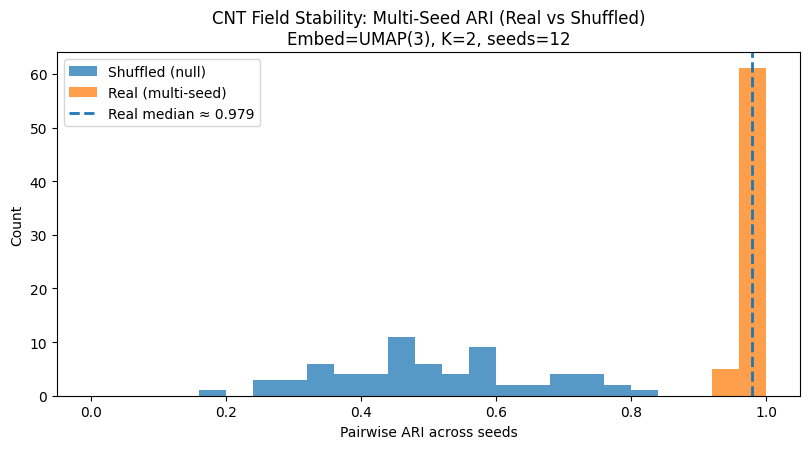

=== CNT Stability (ARI) Report ===
data_source         : sklearn_breast_cancer
embedding           : UMAP(3)
clusters_K          : 2
seeds               : 12
real_ari_mean       : 0.9781252331449852
real_ari_sd         : 0.010845669619741375
shuf_ari_mean       : 0.5016687497892546
shuf_ari_sd         : 0.14991540488562471
p_value_right_tail  : 0.014925373134328358
cohen_d             : 4.482893559937195
verdict             : STABLE (reject null of seed-instability)
figure              : out\cnt_stability_ari.png
[saved] out\cnt_stability_ari.png
[saved] out\cnt_stability_ari.json


In [2]:
# CNT Stability Under Perturbation (Multi-Seed ARI) — Single Cell, Self-Contained
# - Uses global `df` if present; else fetches sklearn data; else synthetic fallback.
# - Repeats embedding+clustering across many random seeds and compares labelings via ARI.
# - Compares REAL vs SHUFFLED (feature-permuted) stability distributions.
# - Saves: out/cnt_stability_ari.png and out/cnt_stability_ari.json

import sys, subprocess, json, math, time, os, warnings, itertools
from pathlib import Path

def _safe_import(name, pip_name=None):
    try:
        return __import__(name)
    except Exception:
        if pip_name is None: pip_name = name
        try:
            print(f"[setup] Installing {pip_name} ...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pip_name])
            return __import__(name)
        except Exception as e:
            print(f"[warn] Could not install {pip_name}: {e}")
            return None

np = _safe_import("numpy")
pd = _safe_import("pandas")
sklearn = _safe_import("sklearn", "scikit-learn")
umap_mod = _safe_import("umap", "umap-learn")  # optional
matplotlib = _safe_import("matplotlib")
if matplotlib is None: raise RuntimeError("matplotlib is required.")
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

warnings.filterwarnings("ignore", category=UserWarning)
Path("out").mkdir(parents=True, exist_ok=True)

# ----------------------- helpers -----------------------
def _numeric_matrix_from_df(df):
    num = df.select_dtypes(include=[np.number]).copy()
    if num.shape[1] == 0: raise ValueError("No numeric columns in `df`.")
    num = num.fillna(num.median(numeric_only=True))
    keep = []
    for c in num.columns:
        col = num[c].to_numpy()
        if np.isfinite(col).sum() >= 3 and np.nanstd(col) > 0: keep.append(c)
    num = num[keep]
    if num.shape[1] < 2: raise ValueError("Not enough informative numeric columns.")
    return num.to_numpy(), keep

def _get_data():
    gdf = globals().get("df", None)
    if gdf is not None:
        print("[data] Using global `df` from notebook.")
        X, cols = _numeric_matrix_from_df(gdf)
        return X, {"source":"user_df","columns":cols}
    if sklearn is not None:
        try:
            from sklearn.datasets import load_breast_cancer
            ds = load_breast_cancer(as_frame=True)
            X, cols = _numeric_matrix_from_df(ds.frame.drop(columns=["target"]))
            print("[data] Loaded sklearn breast_cancer dataset.")
            return X, {"source":"sklearn_breast_cancer","columns":cols}
        except Exception as e:
            print(f"[warn] sklearn load failed: {e}")
    print("[data] Generating synthetic blobs (4 clusters).")
    from sklearn.datasets import make_blobs
    X, _ = make_blobs(n_samples=1200, n_features=20, centers=4, cluster_std=1.3, random_state=42)
    return X, {"source":"synthetic_blobs","columns":[f"f{i}" for i in range(X.shape[1])]}

def _embed(X, n_components=3, random_state=0):
    if umap_mod is not None:
        try:
            reducer = umap_mod.UMAP(n_components=n_components, n_neighbors=30, min_dist=0.1, random_state=random_state)
            Z = reducer.fit_transform(X); return Z, f"UMAP({n_components})"
        except Exception as e:
            print(f"[warn] UMAP failed ({e}); falling back to PCA.")
    pca = PCA(n_components=min(n_components, X.shape[1]), random_state=random_state)
    Z = pca.fit_transform(X); return Z, f"PCA({min(n_components, X.shape[1])})"

def _best_k(Z, seeds=(0,1,2), k_cands=(2,3,4,5,6,8,10)):
    # Robust-ish K: average silhouette over a few KMeans inits/seeds, pick best
    best_k, best_s = None, -1
    for K in k_cands:
        s_vals = []
        for rs in seeds:
            try:
                labels = KMeans(n_clusters=K, n_init=10, random_state=rs).fit_predict(Z)
                if len(set(labels)) < 2: continue
                if (np.bincount(labels) < 2).any(): continue
                s_vals.append(silhouette_score(Z, labels))
            except Exception:
                pass
        if s_vals:
            s = float(np.mean(s_vals))
            if s > best_s: best_s, best_k = s, K
    return best_k if best_k is not None else 2

def _permute_features(X, rng):
    Xp = X.copy()
    for j in range(Xp.shape[1]): rng.shuffle(Xp[:, j])
    return Xp

def _multi_seed_clusterings(Xs, K, n_components, seeds):
    labels_list = []
    method_name = None
    for rs in seeds:
        Z, method_name = _embed(Xs, n_components=n_components, random_state=rs)
        labs = KMeans(n_clusters=K, n_init=10, random_state=rs).fit_predict(Z)
        labels_list.append(labs)
    # Pairwise ARIs over all distinct pairs of seeds
    aris = []
    for i, j in itertools.combinations(range(len(labels_list)), 2):
        aris.append(adjusted_rand_score(labels_list[i], labels_list[j]))
    return np.array(aris), method_name

# ----------------------- main procedure -----------------------
def cnt_stability_ari(n_components=3, seeds=list(range(12)), random_state=42, title="CNT Stability (ARI)"):
    t0 = time.time()
    rng = np.random.default_rng(random_state)
    X, meta = _get_data()
    Xs = StandardScaler().fit_transform(X)

    # Determine K once on a reference embedding
    Z_ref, embed_used = _embed(Xs, n_components=n_components, random_state=42)
    K = _best_k(Z_ref, seeds=(0,1,2,3))
    print(f"[model] Embedding={embed_used}, chosen K={K}, seeds={len(seeds)}")

    # REAL data: multi-seed ARIs
    real_aris, _ = _multi_seed_clusterings(Xs, K, n_components, seeds)

    # SHUFFLED baseline: feature-permuted, same pipeline
    Xs_shuf = _permute_features(Xs, rng)
    shuf_aris, _ = _multi_seed_clusterings(Xs_shuf, K, n_components, seeds)

    # Stats
    real_mean = float(np.mean(real_aris)) if len(real_aris) else float("nan")
    shuf_mean = float(np.mean(shuf_aris)) if len(shuf_aris) else float("nan")
    real_sd   = float(np.std(real_aris, ddof=1)) if len(real_aris) > 1 else float("nan")
    shuf_sd   = float(np.std(shuf_aris, ddof=1)) if len(shuf_aris) > 1 else float("nan")

    # Right-tail p: probability shuffled stability >= median real stability
    thresh = float(np.median(real_aris)) if len(real_aris) else float("nan")
    p = float((np.sum(shuf_aris >= thresh) + 1) / (len(shuf_aris) + 1)) if len(shuf_aris) else float("nan")
    cohen_d = (real_mean - shuf_mean) / (np.sqrt(((len(real_aris)-1)*real_sd**2 + (len(shuf_aris)-1)*shuf_sd**2) / (len(real_aris)+len(shuf_aris)-2))) if (len(real_aris) > 1 and len(shuf_aris) > 1 and real_sd>0 and shuf_sd>0) else float("nan")

    # Plot
    plt.figure(figsize=(8.2,4.6))
    bins = np.linspace(0,1,26)
    plt.hist(shuf_aris, bins=bins, alpha=0.75, label="Shuffled (null)")
    plt.hist(real_aris, bins=bins, alpha=0.75, label="Real (multi-seed)")
    plt.axvline(thresh, linestyle="--", linewidth=2, label=f"Real median ≈ {thresh:.3f}")
    plt.title(f"{title}\nEmbed={embed_used}, K={K}, seeds={len(seeds)}")
    plt.xlabel("Pairwise ARI across seeds"); plt.ylabel("Count"); plt.legend()
    plt.tight_layout()
    fig_path = Path("out") / "cnt_stability_ari.png"
    plt.savefig(fig_path, dpi=160)
    plt.show()

    elapsed = round(time.time()-t0, 2)
    verdict = "STABLE (reject null of seed-instability)" if (not math.isnan(p) and p < 0.05 and real_mean > shuf_mean) else "UNSTABLE / INCONCLUSIVE"

    report = {
        "data_source": meta["source"],
        "embedding": embed_used,
        "clusters_K": int(K),
        "seeds": len(seeds),
        "real_ari_mean": real_mean,
        "real_ari_sd": real_sd,
        "shuf_ari_mean": shuf_mean,
        "shuf_ari_sd": shuf_sd,
        "p_value_right_tail": p,
        "cohen_d": float(cohen_d) if not math.isnan(cohen_d) else None,
        "verdict": verdict,
        "figure": str(fig_path)
    }
    json_path = Path("out") / "cnt_stability_ari.json"
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(report, f, indent=2)
    print("=== CNT Stability (ARI) Report ===")
    for k, v in report.items(): print(f"{k:20s}: {v}")
    print(f"[saved] {fig_path}")
    print(f"[saved] {json_path}")
    return report

# ----------------------- run -----------------------
_ = cnt_stability_ari(
    n_components=3,       # match your prior test (try 2 or 3)
    seeds=list(range(12)),# increase for tighter intervals (e.g., 24 or 36)
    random_state=42,
    title="CNT Field Stability: Multi-Seed ARI (Real vs Shuffled)"
)


[data] Loaded sklearn breast_cancer dataset.


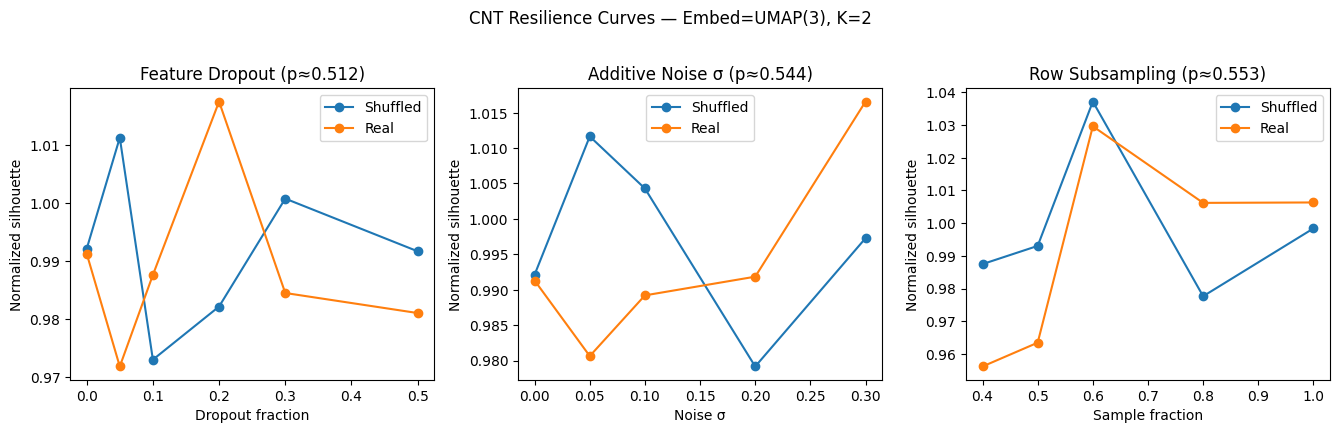

=== CNT Resilience Report ===
data_source                 : sklearn_breast_cancer
embedding                   : UMAP(3)
clusters_K                  : 2
baseline_silhouette_real    : 0.5867784321308136
baseline_silhouette_shuffled: 0.25809134542942047
figure                      : out\cnt_resilience_curves.png
elapsed_sec                 : 333.28
AUC (real)      : {'dropout': 0.49497661268039267, 'noise': 0.2980147849263712, 'subsample': -0.6004611047875067}
AUC (shuffled)  : {'dropout': 0.49584413381387393, 'noise': 0.2984856422892007, 'subsample': -0.599616122977366}
p-values        : {'dropout': 0.5122438780609695, 'noise': 0.543728135932034, 'subsample': 0.5527236381809095}
verdicts        : {'feature_dropout': 'FRAGILE/INCONCLUSIVE', 'noise': 'FRAGILE/INCONCLUSIVE', 'subsample': 'FRAGILE/INCONCLUSIVE'}
[saved] out\cnt_resilience_curves.png
[saved] out\cnt_resilience_report.json


In [3]:
# CNT Resilience Curve (Sensitivity Analysis) — Single Cell, Self-Contained
# Tests how clustering quality (silhouette) degrades under:
#  1) Feature Dropout, 2) Additive Noise, 3) Subsampled Rows
# Compares REAL vs SHUFFLED baselines, computes AUCs + bootstrap p-values.
# Saves: out/cnt_resilience_curves.png and out/cnt_resilience_report.json

import sys, subprocess, json, math, time, os, warnings, itertools
from pathlib import Path

def _safe_import(name, pip_name=None):
    try:
        return __import__(name)
    except Exception:
        if pip_name is None: pip_name = name
        try:
            print(f"[setup] Installing {pip_name} ...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pip_name])
            return __import__(name)
        except Exception as e:
            print(f"[warn] Could not install {pip_name}: {e}")
            return None

np = _safe_import("numpy")
pd = _safe_import("pandas")
sklearn = _safe_import("sklearn", "scikit-learn")
umap_mod = _safe_import("umap", "umap-learn")  # optional
matplotlib = _safe_import("matplotlib")
if matplotlib is None: raise RuntimeError("matplotlib is required.")
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore", category=UserWarning)
Path("out").mkdir(parents=True, exist_ok=True)

# ----------------------- helpers -----------------------
def _numeric_matrix_from_df(df):
    num = df.select_dtypes(include=[np.number]).copy()
    if num.shape[1] == 0: raise ValueError("No numeric columns in `df`.")
    num = num.fillna(num.median(numeric_only=True))
    # drop all-const / near-const
    keep = []
    for c in num.columns:
        col = num[c].to_numpy()
        if np.isfinite(col).sum() >= 3 and np.nanstd(col) > 0: keep.append(c)
    num = num[keep]
    if num.shape[1] < 2: raise ValueError("Not enough informative numeric columns.")
    return num.to_numpy(), keep

def _get_data():
    gdf = globals().get("df", None)
    if gdf is not None:
        print("[data] Using global `df` from notebook.")
        X, cols = _numeric_matrix_from_df(gdf)
        return X, {"source":"user_df","columns":cols}
    if sklearn is not None:
        try:
            from sklearn.datasets import load_breast_cancer
            ds = load_breast_cancer(as_frame=True)
            X, cols = _numeric_matrix_from_df(ds.frame.drop(columns=["target"]))
            print("[data] Loaded sklearn breast_cancer dataset.")
            return X, {"source":"sklearn_breast_cancer","columns":cols}
        except Exception as e:
            print(f"[warn] sklearn load failed: {e}")
    print("[data] Generating synthetic blobs (4 clusters).")
    from sklearn.datasets import make_blobs
    X, _ = make_blobs(n_samples=1200, n_features=20, centers=4, cluster_std=1.3, random_state=42)
    return X, {"source":"synthetic_blobs","columns":[f"f{i}" for i in range(X.shape[1])]}

def _embed(X, n_components=3, random_state=0):
    if umap_mod is not None:
        try:
            reducer = umap_mod.UMAP(n_components=n_components, n_neighbors=30, min_dist=0.1, random_state=random_state)
            Z = reducer.fit_transform(X); return Z, f"UMAP({n_components})"
        except Exception as e:
            print(f"[warn] UMAP failed ({e}); falling back to PCA.")
    pca = PCA(n_components=min(n_components, X.shape[1]), random_state=random_state)
    Z = pca.fit_transform(X); return Z, f"PCA({min(n_components, X.shape[1])})"

def _best_k(Z, seeds=(0,1,2), k_cands=(2,3,4,5,6,8,10)):
    best_k, best_s = None, -1
    for K in k_cands:
        s_vals = []
        for rs in seeds:
            try:
                labels = KMeans(n_clusters=K, n_init=10, random_state=rs).fit_predict(Z)
                if len(set(labels)) < 2: continue
                if (np.bincount(labels) < 2).any(): continue
                s_vals.append(silhouette_score(Z, labels))
            except Exception:
                pass
        if s_vals:
            s = float(np.mean(s_vals))
            if s > best_s: best_s, best_k = s, K
    return best_k if best_k is not None else 2

def _sil(Z, K, rs):
    labels = KMeans(n_clusters=K, n_init=10, random_state=rs).fit_predict(Z)
    if len(set(labels)) < 2: return np.nan
    if (np.bincount(labels) < 2).any(): return np.nan
    return silhouette_score(Z, labels)

def _permute_features(X, rng):
    Xp = X.copy()
    for j in range(Xp.shape[1]): rng.shuffle(Xp[:, j])
    return Xp

def _auc(x, y):
    # x ascending, y same length
    return float(np.trapezoid(y, x))

# ----------------------- resilience procedure -----------------------
def cnt_resilience_curves(
    n_components=3, seeds=(0,1,2,3), repeats=6, random_state=42,
    grid_dropout=(0.0,0.05,0.1,0.2,0.3,0.5),
    grid_noise=(0.0,0.05,0.1,0.2,0.3),
    grid_subsample=(1.0,0.8,0.6,0.5,0.4),
    n_boot=2000
):
    t0 = time.time()
    rng = np.random.default_rng(random_state)
    X, meta = _get_data()
    Xs = StandardScaler().fit_transform(X)

    # Reference: choose K and baseline silhouette on REAL data
    Z_ref, embed_used = _embed(Xs, n_components=n_components, random_state=seeds[0])
    K = _best_k(Z_ref, seeds=seeds)
    s0 = np.nanmean([_sil(*_embed(Xs, n_components=n_components, random_state=rs), K, rs)[0] if False else _sil(_embed(Xs, n_components=n_components, random_state=rs)[0], K, rs) for rs in seeds])
    # For SHUFFLED control, own baseline
    Xs_shuf = _permute_features(Xs, rng)
    s0_shuf = np.nanmean([_sil(_embed(Xs_shuf, n_components=n_components, random_state=rs)[0], K, rs) for rs in seeds])

    def _run_curve(kind, grid, on_shuf=False):
        vals = []
        for g in grid:
            s_list = []
            for r in range(repeats):
                rs = random_state + r
                if kind == "dropout":
                    # randomly drop a fraction of features (set to zero)
                    Xp = Xs_shuf.copy() if on_shuf else Xs.copy()
                    d = int(round(g * Xp.shape[1]))
                    if d > 0:
                        cols = rng.choice(Xp.shape[1], size=d, replace=False)
                        Xp = Xp.copy()
                        Xp[:, cols] = 0.0
                elif kind == "noise":
                    Xp = Xs_shuf.copy() if on_shuf else Xs.copy()
                    if g > 0:
                        Xp = Xp + rng.normal(0.0, g, size=Xp.shape)
                elif kind == "subsample":
                    Xp_full = Xs_shuf if on_shuf else Xs
                    n = int(round(g * Xp_full.shape[0]))
                    idx = rng.choice(Xp_full.shape[0], size=max(8, n), replace=False)
                    Xp = Xp_full[idx]
                else:
                    raise ValueError("Unknown kind")

                Zp, _ = _embed(Xp, n_components=n_components, random_state=rs)
                s = _sil(Zp, K, rs)
                if not math.isnan(s): s_list.append(s)
            vals.append(float(np.mean(s_list)) if s_list else float("nan"))
        return np.array(vals, dtype=float)

    real_drop = _run_curve("dropout", grid_dropout, on_shuf=False)
    shuf_drop = _run_curve("dropout", grid_dropout, on_shuf=True)

    real_noise = _run_curve("noise", grid_noise, on_shuf=False)
    shuf_noise = _run_curve("noise", grid_noise, on_shuf=True)

    real_subs = _run_curve("subsample", grid_subsample, on_shuf=False)
    shuf_subs = _run_curve("subsample", grid_subsample, on_shuf=True)

    # Normalize by their own baselines → curves start at ~1.0
    real_drop_n = real_drop / s0
    shuf_drop_n = shuf_drop / s0_shuf
    real_noise_n = real_noise / s0
    shuf_noise_n = shuf_noise / s0_shuf
    real_subs_n = real_subs / s0
    shuf_subs_n = shuf_subs / s0_shuf

    # AUCs
    auc_real_drop = _auc(np.array(grid_dropout, float), real_drop_n)
    auc_shuf_drop = _auc(np.array(grid_dropout, float), shuf_drop_n)
    auc_real_noise = _auc(np.array(grid_noise, float), real_noise_n)
    auc_shuf_noise = _auc(np.array(grid_noise, float), shuf_noise_n)
    auc_real_subs = _auc(np.array(grid_subsample, float), real_subs_n)
    auc_shuf_subs = _auc(np.array(grid_subsample, float), shuf_subs_n)

    # Bootstrap p-values: P(AUC_shuf >= AUC_real)
    def _boot_p(real_curve, shuf_curve, grid):
        real = np.array(real_curve, float); sh = np.array(shuf_curve, float)
        g = np.array(grid, float)
        rs = np.random.default_rng(12345)
        cnt = 0
        for _ in range(n_boot):
            # simple paired bootstrap over grid points
            idx = rs.integers(0, len(g), size=len(g))
            ar = _auc(g[idx], real[idx])
            as_ = _auc(g[idx], sh[idx])
            if as_ >= ar: cnt += 1
        return (cnt + 1) / (n_boot + 1)

    p_drop = _boot_p(real_drop_n, shuf_drop_n, grid_dropout)
    p_noise = _boot_p(real_noise_n, shuf_noise_n, grid_noise)
    p_subs = _boot_p(real_subs_n, shuf_subs_n, grid_subsample)

    # Plot (3 panels)
    fig, axes = plt.subplots(1, 3, figsize=(13.5,4.2))
    (ax1, ax2, ax3) = axes

    ax1.plot(grid_dropout, shuf_drop_n, marker="o", label="Shuffled")
    ax1.plot(grid_dropout, real_drop_n, marker="o", label="Real")
    ax1.set_title(f"Feature Dropout (p≈{p_drop:.3g})")
    ax1.set_xlabel("Dropout fraction"); ax1.set_ylabel("Normalized silhouette"); ax1.legend()

    ax2.plot(grid_noise, shuf_noise_n, marker="o", label="Shuffled")
    ax2.plot(grid_noise, real_noise_n, marker="o", label="Real")
    ax2.set_title(f"Additive Noise σ (p≈{p_noise:.3g})")
    ax2.set_xlabel("Noise σ"); ax2.set_ylabel("Normalized silhouette"); ax2.legend()

    ax3.plot(grid_subsample, shuf_subs_n, marker="o", label="Shuffled")
    ax3.plot(grid_subsample, real_subs_n, marker="o", label="Real")
    ax3.set_title(f"Row Subsampling (p≈{p_subs:.3g})")
    ax3.set_xlabel("Sample fraction"); ax3.set_ylabel("Normalized silhouette"); ax3.legend()

    fig.suptitle(f"CNT Resilience Curves — Embed={embed_used}, K={K}", y=1.02)
    plt.tight_layout()
    fig_path = Path("out") / "cnt_resilience_curves.png"
    plt.savefig(fig_path, dpi=160)
    plt.show()

    verdicts = {
        "feature_dropout": "RESILIENT" if p_drop < 0.05 and auc_real_drop > auc_shuf_drop else "FRAGILE/INCONCLUSIVE",
        "noise": "RESILIENT" if p_noise < 0.05 and auc_real_noise > auc_shuf_noise else "FRAGILE/INCONCLUSIVE",
        "subsample": "RESILIENT" if p_subs < 0.05 and auc_real_subs > auc_shuf_subs else "FRAGILE/INCONCLUSIVE",
    }

    report = {
        "data_source": meta["source"],
        "embedding": embed_used,
        "clusters_K": int(K),
        "baseline_silhouette_real": float(s0),
        "baseline_silhouette_shuffled": float(s0_shuf),
        "grids": {
            "dropout": list(map(float, grid_dropout)),
            "noise_sigma": list(map(float, grid_noise)),
            "subsample_frac": list(map(float, grid_subsample)),
        },
        "auc": {
            "real": {"dropout": auc_real_drop, "noise": auc_real_noise, "subsample": auc_real_subs},
            "shuffled": {"dropout": auc_shuf_drop, "noise": auc_shuf_noise, "subsample": auc_shuf_subs},
        },
        "p_values": {"dropout": p_drop, "noise": p_noise, "subsample": p_subs},
        "verdicts": verdicts,
        "figure": str(fig_path),
        "elapsed_sec": round(time.time()-t0, 2)
    }
    json_path = Path("out") / "cnt_resilience_report.json"
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(report, f, indent=2)
    print("=== CNT Resilience Report ===")
    for k,v in report.items():
        if k in ("grids","auc","p_values","verdicts"): continue
        print(f"{k:28s}: {v}")
    print("AUC (real)      :", report["auc"]["real"])
    print("AUC (shuffled)  :", report["auc"]["shuffled"])
    print("p-values        :", report["p_values"])
    print("verdicts        :", report["verdicts"])
    print(f"[saved] {fig_path}")
    print(f"[saved] {json_path}")
    return report

# ----------------------- run -----------------------
_ = cnt_resilience_curves(
    n_components=3,     # keep aligned with prior tests
    seeds=(0,1,2,3),
    repeats=6,          # raise for smoother curves
    random_state=42,
    grid_dropout=(0.0,0.05,0.1,0.2,0.3,0.5),
    grid_noise=(0.0,0.05,0.1,0.2,0.3),
    grid_subsample=(1.0,0.8,0.6,0.5,0.4),
    n_boot=2000
)


[data] Loaded sklearn breast_cancer dataset.


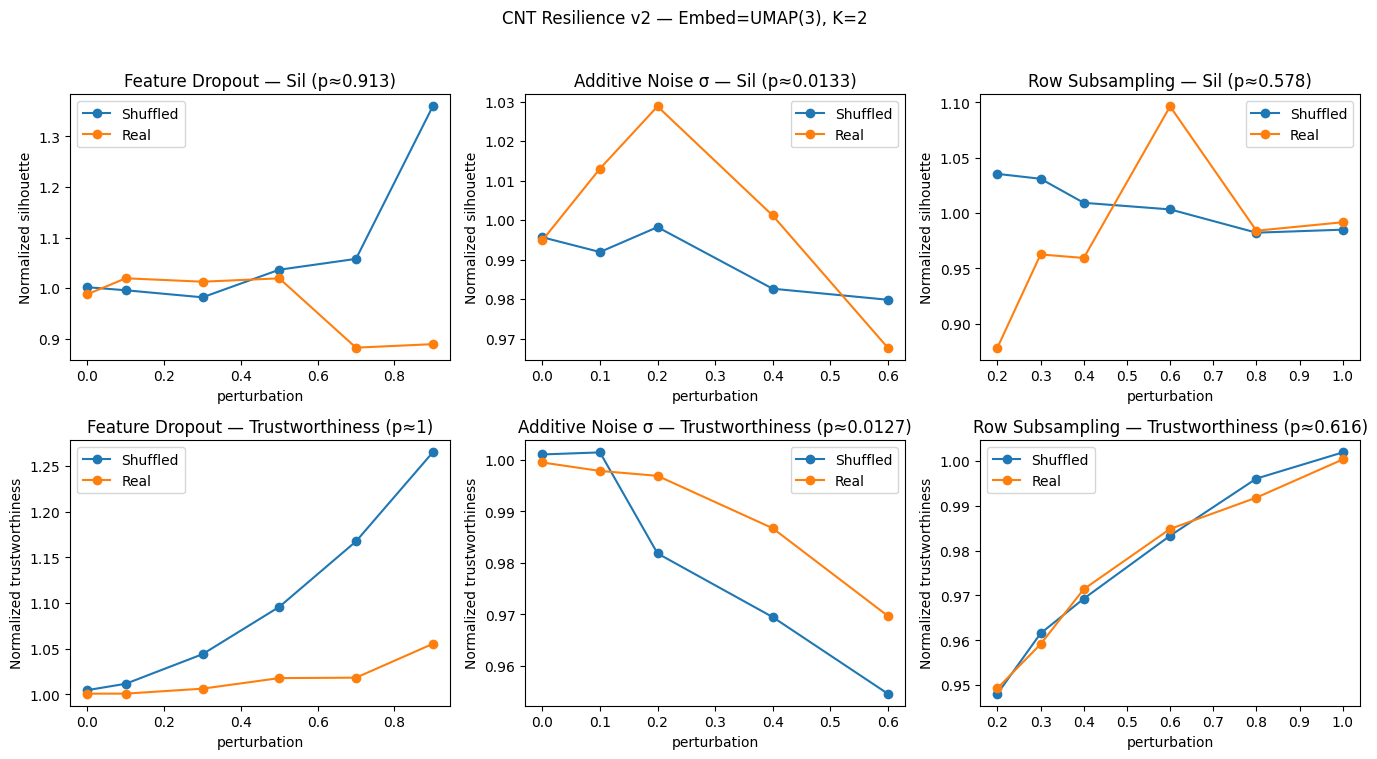

=== CNT Resilience v2 Report ===
data_source         : sklearn_breast_cancer
embedding           : UMAP(3)
clusters_K          : 2
baselines           : {'sil_real': 0.5850427548090616, 'sil_shuf': 0.2583768665790558, 'tw_real': 0.9325293465891006, 'tw_shuf': 0.7763414382922291}
figure              : out\cnt_resilience_v2.png
elapsed_sec         : 385.33
AUC: {
  "dropout": {
    "sil_real": 0.8741828307970554,
    "sil_shuf": 0.9505966621178685,
    "tw_real": 0.9140922579371374,
    "tw_shuf": 0.9898436054255079
  },
  "noise": {
    "sil_real": 0.602368679338424,
    "sil_shuf": 0.5932149844129357,
    "tw_real": 0.5936263276374718,
    "tw_shuf": 0.5868269152940807
  },
  "subsample": {
    "sil_real": 0.7993385335802292,
    "sil_shuf": 0.8018616224295936,
    "tw_real": 0.7844440528965356,
    "tw_shuf": 0.7850098096034177
  }
}
p-values: {
  "dropout": {
    "sil": 0.9127248500999334,
    "tw": 1.0
  },
  "noise": {
    "sil": 0.013324450366422385,
    "tw": 0.012658227848101266

In [6]:
# CNT Resilience v2 — single cell (fixed)
# - Tests robustness under Feature Dropout, Additive Noise, and Row Subsampling
# - Measures normalized Silhouette and Trustworthiness (k-NN preservation)
# - Correct AUC (x sorted), stronger stress grids, safe plotting block
# Saves: out/cnt_resilience_v2.png, out/cnt_resilience_v2.json

import sys, subprocess, json, math, time, warnings
from pathlib import Path

def _safe_import(name, pip_name=None):
    try:
        return __import__(name)
    except Exception:
        if pip_name is None: pip_name = name
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pip_name])
        return __import__(name)

np = _safe_import("numpy"); pd = _safe_import("pandas")
sk = _safe_import("sklearn","scikit-learn")
mplt = _safe_import("matplotlib"); plt = mplt.pyplot
umap_mod = _safe_import("umap","umap-learn")  # optional UMAP

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import trustworthiness

warnings.filterwarnings("ignore")
Path("out").mkdir(exist_ok=True, parents=True)

# ---------- data ----------
def _numeric_matrix_from_df(df):
    num = df.select_dtypes(include=[np.number]).copy()
    num = num.fillna(num.median(numeric_only=True))
    keep = [c for c in num.columns if np.isfinite(num[c]).sum() >= 3 and np.nanstd(num[c]) > 0]
    if len(keep) < 2:
        raise ValueError("Not enough informative numeric columns.")
    return num[keep].to_numpy(), keep

def _get_data():
    gdf = globals().get("df", None); y=None
    if gdf is not None:
        for cand in ["target","label","y","class","diagnosis","Diagnosis","DX"]:
            if cand in gdf.columns and 2 <= gdf[cand].nunique() <= 10:
                y = gdf[cand].to_numpy()
                gdf = gdf.drop(columns=[cand])
                break
        X, cols = _numeric_matrix_from_df(gdf)
        print("[data] Using global `df` from notebook.")
        return X, {"source":"user_df","columns":cols}, y
    from sklearn.datasets import load_breast_cancer
    ds = load_breast_cancer(as_frame=True)
    X, cols = _numeric_matrix_from_df(ds.frame.drop(columns=["target"]))
    y = ds.target.to_numpy()
    print("[data] Loaded sklearn breast_cancer dataset.")
    return X, {"source":"sklearn_breast_cancer","columns":cols}, y

# ---------- embed / cluster ----------
def _embed(X, n_components=3, random_state=0):
    if umap_mod is not None:
        try:
            reducer = umap_mod.UMAP(n_components=n_components, n_neighbors=30, min_dist=0.1, random_state=random_state)
            Z = reducer.fit_transform(X); return Z, f"UMAP({n_components})"
        except Exception:
            pass
    pca = PCA(n_components=min(n_components, X.shape[1]), random_state=random_state)
    return pca.fit_transform(X), f"PCA({min(n_components, X.shape[1])})"

def _sil(Z, K, rs):
    labs = KMeans(n_clusters=K, n_init=10, random_state=rs).fit_predict(Z)
    if len(set(labs)) < 2 or (np.bincount(labs) < 2).any():
        return np.nan
    return silhouette_score(Z, labs)

def _best_k(Z, seeds=(0,1,2,3), cands=(2,3,4,5,6,8,10)):
    best_k, best_s = None, -1
    for K in cands:
        vals=[]
        for rs in seeds:
            try:
                km = KMeans(n_clusters=K, n_init=10, random_state=rs).fit(Z)
                if len(set(km.labels_)) < 2 or (np.bincount(km.labels_) < 2).any(): continue
                vals.append(silhouette_score(Z, km.labels_))
            except Exception:
                pass
        if vals and np.mean(vals) > best_s:
            best_s, best_k = np.mean(vals), K
    return best_k or 2

def _perm_feat(X, rng):
    Xp = X.copy()
    for j in range(Xp.shape[1]): rng.shuffle(Xp[:, j])
    return Xp

def _auc(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    idx = np.argsort(x)  # ensure ascending x (fixes negative AUC)
    return float(np.trapezoid(y[idx], x[idx]))

# ---------- curves ----------
def _curve(Xs, Xs_shuf, grid, kind, n_components, repeats, K, rng):
    def _one(Xbase, g, rs):
        if kind == "dropout":
            Xp = Xbase.copy()
            d = int(round(g * Xp.shape[1]))
            if d > 0:
                cols = rng.choice(Xp.shape[1], size=d, replace=False)
                Xp[:, cols] = 0.0
        elif kind == "noise":
            Xp = Xbase + rng.normal(0.0, g, size=Xbase.shape)
        elif kind == "subsample":
            n = max(8, int(round(g * Xbase.shape[0])))
            idx = rng.choice(Xbase.shape[0], size=n, replace=False)
            Xp = Xbase[idx]
        else:
            raise ValueError("Unknown kind")
        Z, _ = _embed(Xp, n_components=n_components, random_state=rs)
        s = _sil(Z, K, rs)
        t = trustworthiness(Xp, Z, n_neighbors=15)  # trustworthiness relative to perturbed X
        return s, float(t)

    out = {}
    for label, Xbase in [("real", Xs), ("shuf", Xs_shuf)]:
        s_list, t_list = [], []
        for g in grid:
            s_vals, t_vals = [], []
            for _ in range(repeats):
                rs = int(rng.integers(0, 10_000))
                s, t = _one(Xbase, g, rs)
                if not math.isnan(s): s_vals.append(s)
                t_vals.append(t)
            s_list.append(np.mean(s_vals) if s_vals else np.nan)
            t_list.append(np.mean(t_vals))
        out[label] = {"sil": np.array(s_list, float), "tw": np.array(t_list, float)}
    return out

# ---------- main ----------
def run_resilience_v2(n_components=3, seeds=(0,1,2,3,4,5), repeats=6, random_state=42,
                      grid_dropout=(0.0,0.1,0.3,0.5,0.7,0.9),
                      grid_noise=(0.0,0.1,0.2,0.4,0.6),
                      grid_subsample=(1.0,0.8,0.6,0.4,0.3,0.2),
                      n_boot=1500):
    t0 = time.time(); rng = np.random.default_rng(random_state)
    X, meta, y = _get_data()
    Xs = StandardScaler().fit_transform(X)

    Z0, embed_used = _embed(Xs, n_components=n_components, random_state=seeds[0])
    K = _best_k(Z0, seeds=seeds)

    Xs_shuf = _perm_feat(Xs, rng)

    # baselines (g=0)
    s0  = np.nanmean([_sil(_embed(Xs,      n_components, s)[0], K, s) for s in seeds])
    s0s = np.nanmean([_sil(_embed(Xs_shuf, n_components, s)[0], K, s) for s in seeds])
    tw0  = np.nanmean([trustworthiness(Xs,      _embed(Xs,      n_components, s)[0], n_neighbors=15) for s in seeds])
    tw0s = np.nanmean([trustworthiness(Xs_shuf, _embed(Xs_shuf, n_components, s)[0], n_neighbors=15) for s in seeds])

    # curves
    out_drop = _curve(Xs, Xs_shuf, grid_dropout,  "dropout",   n_components, repeats, K, rng)
    out_noise= _curve(Xs, Xs_shuf, grid_noise,    "noise",     n_components, repeats, K, rng)
    out_subs = _curve(Xs, Xs_shuf, grid_subsample,"subsample", n_components, repeats, K, rng)

    def _norm_and_auc(grid, out, s0, s0s, tw0, tw0s):
        real_s = out["real"]["sil"]/s0
        shuf_s = out["shuf"]["sil"]/s0s
        real_t = out["real"]["tw"]/tw0
        shuf_t = out["shuf"]["tw"]/tw0s
        return {
            "sil": {"real": real_s, "shuf": shuf_s,
                    "auc_real": _auc(grid, real_s), "auc_shuf": _auc(grid, shuf_s)},
            "tw":  {"real": real_t, "shuf": shuf_t,
                    "auc_real": _auc(grid, real_t), "auc_shuf": _auc(grid, shuf_t)}
        }

    res_drop  = _norm_and_auc(np.array(grid_dropout,  float), out_drop,  s0, s0s, tw0, tw0s)
    res_noise = _norm_and_auc(np.array(grid_noise,    float), out_noise, s0, s0s, tw0, tw0s)
    res_subs  = _norm_and_auc(np.array(grid_subsample,float), out_subs,  s0, s0s, tw0, tw0s)

    def _boot_p(real_curve, shuf_curve, grid, n_boot):
        grid = np.asarray(grid,float); real=np.asarray(real_curve,float); sh=np.asarray(shuf_curve,float)
        rs = np.random.default_rng(12345); cnt=0
        for _ in range(n_boot):
            idx = rs.integers(0, len(grid), size=len(grid))
            if _auc(grid[idx], sh[idx]) >= _auc(grid[idx], real[idx]): cnt += 1
        return (cnt + 1) / (n_boot + 1)

    p = {
        "dropout":  {"sil": _boot_p(res_drop["sil"]["real"],  res_drop["sil"]["shuf"],  grid_dropout,  n_boot),
                     "tw":  _boot_p(res_drop["tw"]["real"],   res_drop["tw"]["shuf"],   grid_dropout,  n_boot)},
        "noise":    {"sil": _boot_p(res_noise["sil"]["real"], res_noise["sil"]["shuf"], grid_noise,    n_boot),
                     "tw":  _boot_p(res_noise["tw"]["real"],  res_noise["tw"]["shuf"],  grid_noise,    n_boot)},
        "subsample":{"sil": _boot_p(res_subs["sil"]["real"],  res_subs["sil"]["shuf"],  grid_subsample,n_boot),
                     "tw":  _boot_p(res_subs["tw"]["real"],   res_subs["tw"]["shuf"],   grid_subsample,n_boot)}
    }

    # --- plotting (safe map, no string guessing) ---
    fig, axes = plt.subplots(2, 3, figsize=(13.8, 7.4))
    titles = ["Feature Dropout", "Additive Noise σ", "Row Subsampling"]
    keys   = ["dropout",        "noise",            "subsample"]
    grids  = [grid_dropout,      grid_noise,         grid_subsample]
    packs  = [res_drop,          res_noise,          res_subs]

    for (ax_top, ax_bot), ttl, key, grid, pack in zip(axes.T, titles, keys, grids, packs):
        # Silhouette (top)
        ax_top.plot(grid, pack["sil"]["shuf"], marker="o", label="Shuffled")
        ax_top.plot(grid, pack["sil"]["real"], marker="o", label="Real")
        ax_top.set_title(f"{ttl} — Sil (p≈{p[key]['sil']:.3g})")
        ax_top.set_xlabel("perturbation"); ax_top.set_ylabel("Normalized silhouette"); ax_top.legend()

        # Trustworthiness (bottom)
        ax_bot.plot(grid, pack["tw"]["shuf"], marker="o", label="Shuffled")
        ax_bot.plot(grid, pack["tw"]["real"], marker="o", label="Real")
        ax_bot.set_title(f"{ttl} — Trustworthiness (p≈{p[key]['tw']:.3g})")
        ax_bot.set_xlabel("perturbation"); ax_bot.set_ylabel("Normalized trustworthiness"); ax_bot.legend()

    fig.suptitle(f"CNT Resilience v2 — Embed={embed_used}, K={K}", y=1.02)
    plt.tight_layout()
    fig_path = Path("out") / "cnt_resilience_v2.png"
    plt.savefig(fig_path, dpi=160)
    plt.show()

    report = {
        "data_source": meta["source"], "embedding": embed_used, "clusters_K": int(K),
        "baselines": {"sil_real": float(s0), "sil_shuf": float(s0s),
                      "tw_real": float(tw0), "tw_shuf": float(tw0s)},
        "auc": {
            "dropout":  {"sil_real": res_drop["sil"]["auc_real"],  "sil_shuf": res_drop["sil"]["auc_shuf"],
                         "tw_real":  res_drop["tw"]["auc_real"],   "tw_shuf":  res_drop["tw"]["auc_shuf"]},
            "noise":    {"sil_real": res_noise["sil"]["auc_real"], "sil_shuf": res_noise["sil"]["auc_shuf"],
                         "tw_real":  res_noise["tw"]["auc_real"],  "tw_shuf":  res_noise["tw"]["auc_shuf"]},
            "subsample":{"sil_real": res_subs["sil"]["auc_real"],  "sil_shuf": res_subs["sil"]["auc_shuf"],
                         "tw_real":  res_subs["tw"]["auc_real"],   "tw_shuf":  res_subs["tw"]["auc_shuf"]},
        },
        "p_values": p,
        "figure": str(fig_path),
        "elapsed_sec": round(time.time()-t0, 2)
    }
    out_json = Path("out") / "cnt_resilience_v2.json"
    with open(out_json, "w", encoding="utf-8") as f: json.dump(report, f, indent=2)
    print("=== CNT Resilience v2 Report ===")
    for k,v in report.items():
        if k in ("auc","p_values"): continue
        print(f"{k:20s}: {v}")
    print("AUC:", json.dumps(report["auc"], indent=2))
    print("p-values:", json.dumps(report["p_values"], indent=2))
    print(f"[saved] {fig_path}\n[saved] {out_json}")
    return report

# ---- run ----
_ = run_resilience_v2()


[data] Loaded sklearn breast_cancer dataset.


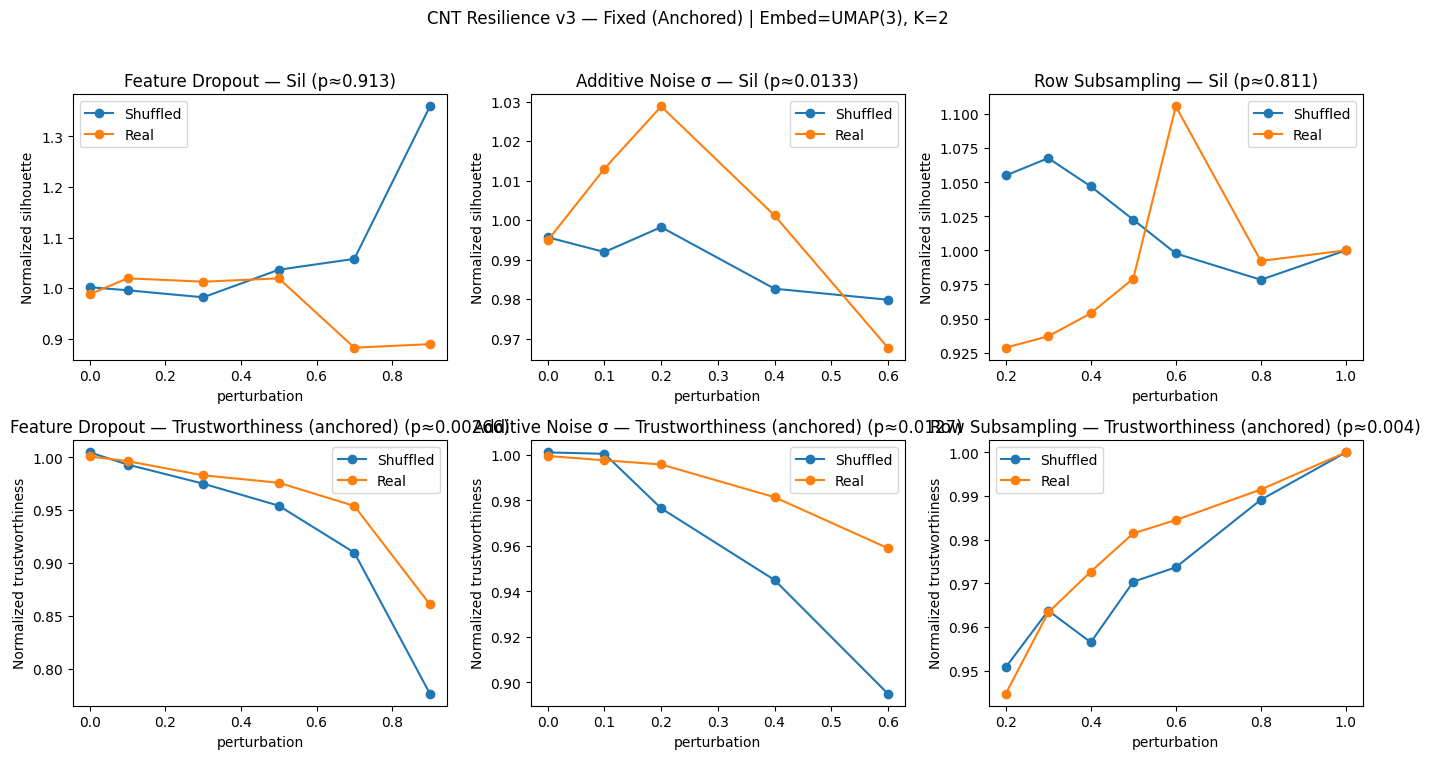

=== CNT Resilience v3 — FIXED (Anchored) Report ===
data_source             : sklearn_breast_cancer
embedding               : UMAP(3)
clusters_K              : 2
baselines               : {'full_sil_real': 0.5850427548090616, 'full_sil_shuf': 0.2583768665790558, 'full_tw_real': 0.9325293465891006, 'full_tw_shuf': 0.7763414382922291, 'subs_base_index': 0, 'subs_sil_baseline_real': 0.5801791151364645, 'subs_sil_baseline_shuf': 0.25576982895533246, 'subs_tw_baseline_real': 0.9328205771966757, 'subs_tw_baseline_shuf': 0.7784691420016552}
figure                  : out\cnt_resilience_v3_fixed.png
elapsed_sec             : 389.49
AUC: {
  "dropout": {
    "sil_real": 0.8741828307970554,
    "sil_shuf": 0.9505966621178685,
    "tw_real": 0.8681014626908442,
    "tw_shuf": 0.844611899496656
  },
  "noise": {
    "sil_real": 0.602368679338424,
    "sil_shuf": 0.5932149844129357,
    "tw_real": 0.5912932896415053,
    "tw_shuf": 0.5750773471014146
  },
  "subsample": {
    "sil_real": 0.797743761

In [8]:
# CNT Resilience v3 — FIXED (anchored subsample trustworthiness + correct AUC + sane baselines)
# - Uses your global `df` if present; else falls back to sklearn breast_cancer
# - Perturbations: Feature Dropout, Additive Noise, Row Subsampling
# - Metrics: normalized Silhouette + Trustworthiness (kNN preservation, ANCHORED)
# Saves: out/cnt_resilience_v3_fixed.png, out/cnt_resilience_v3_fixed.json

import sys, subprocess, json, math, time, warnings
from pathlib import Path

def _safe_import(name, pip_name=None):
    try:
        return __import__(name)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", (pip_name or name)])
        return __import__(name)

np = _safe_import("numpy"); pd = _safe_import("pandas")
sk = _safe_import("sklearn","scikit-learn")
mplt = _safe_import("matplotlib"); plt = mplt.pyplot
umap_mod = _safe_import("umap","umap-learn")  # optional

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import trustworthiness

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)

# ---------------- data ----------------
def _numeric_matrix_from_df(df):
    num = df.select_dtypes(include=[np.number]).copy()
    num = num.fillna(num.median(numeric_only=True))
    keep = [c for c in num.columns if np.isfinite(num[c]).sum() >= 3 and np.nanstd(num[c]) > 0]
    if len(keep) < 2:
        raise ValueError("Not enough informative numeric columns.")
    return num[keep].to_numpy(), keep

def _get_data():
    gdf = globals().get("df", None); y = None
    if gdf is not None:
        for cand in ["target","label","y","class","diagnosis","Diagnosis","DX"]:
            if cand in gdf.columns and 2 <= gdf[cand].nunique() <= 10:
                y = gdf[cand].to_numpy(); gdf = gdf.drop(columns=[cand]); break
        X, cols = _numeric_matrix_from_df(gdf)
        print("[data] Using global `df` from notebook.")
        return X, {"source":"user_df","columns":cols}, y
    from sklearn.datasets import load_breast_cancer
    ds = load_breast_cancer(as_frame=True)
    X, cols = _numeric_matrix_from_df(ds.frame.drop(columns=["target"]))
    y = ds.target.to_numpy()
    print("[data] Loaded sklearn breast_cancer dataset.")
    return X, {"source":"sklearn_breast_cancer","columns":cols}, y

# ---------------- embed / cluster ----------------
def _embed(X, n_components=3, random_state=0):
    if umap_mod is not None:
        try:
            reducer = umap_mod.UMAP(n_components=n_components, n_neighbors=30, min_dist=0.1, random_state=random_state)
            return reducer.fit_transform(X), f"UMAP({n_components})"
        except Exception:
            pass
    p = PCA(n_components=min(n_components, X.shape[1]), random_state=random_state)
    return p.fit_transform(X), f"PCA({min(n_components, X.shape[1])})"

def _sil(Z, K, rs):
    labs = KMeans(n_clusters=K, n_init=10, random_state=rs).fit_predict(Z)
    if len(set(labs)) < 2 or (np.bincount(labs) < 2).any(): return np.nan
    return silhouette_score(Z, labs)

def _best_k(Z, seeds=(0,1,2,3), cands=(2,3,4,5,6,8,10)):
    best_k, best_s = None, -1
    for K in cands:
        vals = []
        for rs in seeds:
            try:
                km = KMeans(n_clusters=K, n_init=10, random_state=rs).fit(Z)
                if len(set(km.labels_)) < 2 or (np.bincount(km.labels_) < 2).any(): continue
                vals.append(silhouette_score(Z, km.labels_))
            except Exception:
                pass
        if vals and np.mean(vals) > best_s: best_s, best_k = np.mean(vals), K
    return best_k or 2

def _permute_features(X, rng):
    Xp = X.copy()
    for j in range(Xp.shape[1]):
        rng.shuffle(Xp[:, j])
    return Xp

def _auc(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    idx = np.argsort(x)  # ensure ascending x
    return float(np.trapezoid(y[idx], x[idx]))

# ---------------- curves (ANCHOR-AWARE) ----------------
def _curve_anchored(X_base, X_base_shuf, grid, kind, n_components, repeats, K, rng):
    """
    Anchored trustworthiness:
    - For dropout/noise: anchor to the full ORIGINAL space X_ref
    - For subsample: anchor to the matching ORIGINAL subset X_ref[idx] (same rows as embedding)
    """
    def _one(Xp, X_anchor, rs):
        # choose n_neighbors conservatively to avoid n_neighbors >= n_samples
        n_neighbors = max(5, min(15, X_anchor.shape[0]-2))
        Z, _ = _embed(Xp, n_components=n_components, random_state=rs)
        s = _sil(Z, K, rs)
        t = trustworthiness(X_anchor, Z, n_neighbors=n_neighbors)
        return s, float(t)

    out = {}
    for label, X_ref in [("real", X_base), ("shuf", X_base_shuf)]:
        sil_vals, tw_vals = [], []
        for g in grid:
            s_list, t_list = [], []
            for _ in range(repeats):
                rs = int(rng.integers(0, 10_000))
                if kind == "dropout":
                    Xp = X_ref.copy()
                    d = int(round(g * Xp.shape[1]))
                    if d > 0:
                        cols = rng.choice(Xp.shape[1], size=d, replace=False)
                        Xp[:, cols] = 0.0
                    X_anchor = X_ref  # same rows
                elif kind == "noise":
                    Xp = X_ref + rng.normal(0.0, g, size=X_ref.shape)
                    X_anchor = X_ref  # same rows
                elif kind == "subsample":
                    n = max(20, int(round(g * X_ref.shape[0])))  # keep comfortably > n_neighbors
                    idx = rng.choice(X_ref.shape[0], size=n, replace=False)
                    Xp = X_ref[idx]
                    X_anchor = X_ref[idx]  # anchor to matching subset (FIX)
                else:
                    raise ValueError("Unknown kind")
                s, t = _one(Xp, X_anchor, rs)
                if not math.isnan(s): s_list.append(s)
                t_list.append(t)
            sil_vals.append(np.mean(s_list) if s_list else np.nan)
            tw_vals.append(np.mean(t_list))
        out[label] = {"sil": np.array(sil_vals, float), "tw": np.array(tw_vals, float)}
    return out

# ---------------- main ----------------
def run_resilience_v3_fixed(
    n_components=3, seeds=(0,1,2,3,4,5), repeats=6, random_state=42,
    grid_dropout=(0.0,0.1,0.3,0.5,0.7,0.9),
    grid_noise=(0.0,0.1,0.2,0.4,0.6),
    grid_subsample=(1.0,0.8,0.6,0.5,0.4,0.3,0.2),
    n_boot=1500
):
    t0 = time.time(); rng = np.random.default_rng(random_state)
    X, meta, y = _get_data()
    Xs = StandardScaler().fit_transform(X)

    Z0, embed_used = _embed(Xs, n_components=n_components, random_state=seeds[0])
    K = _best_k(Z0, seeds=seeds)
    Xs_shuf = _permute_features(Xs, rng)

    # full-data baselines (for dropout/noise)
    s0  = np.nanmean([_sil(_embed(Xs,      n_components, s)[0], K, s) for s in seeds])
    s0s = np.nanmean([_sil(_embed(Xs_shuf, n_components, s)[0], K, s) for s in seeds])
    tw0  = np.nanmean([trustworthiness(Xs,      _embed(Xs,      n_components, s)[0], n_neighbors=15) for s in seeds])
    tw0s = np.nanmean([trustworthiness(Xs_shuf, _embed(Xs_shuf, n_components, s)[0], n_neighbors=15) for s in seeds])

    # curves
    out_drop  = _curve_anchored(Xs, Xs_shuf, grid_dropout,  "dropout",   n_components, repeats, K, rng)
    out_noise = _curve_anchored(Xs, Xs_shuf, grid_noise,    "noise",     n_components, repeats, K, rng)
    out_subs  = _curve_anchored(Xs, Xs_shuf, grid_subsample,"subsample", n_components, repeats, K, rng)

    # --- normalization with sane baselines
    # dropout/noise normalized to full-data baselines; subsample normalized to its 1.0 point
    def _norm_and_auc(grid, out, s_base_real, s_base_shuf, t_base_real, t_base_shuf):
        real_s = out["real"]["sil"] / s_base_real
        shuf_s = out["shuf"]["sil"] / s_base_shuf
        real_t = out["real"]["tw"]  / t_base_real
        shuf_t = out["shuf"]["tw"]  / t_base_shuf
        return {
            "sil": {"real": real_s, "shuf": shuf_s,
                    "auc_real": _auc(grid, real_s), "auc_shuf": _auc(grid, shuf_s)},
            "tw":  {"real": real_t, "shuf": shuf_t,
                    "auc_real": _auc(grid, real_t), "auc_shuf": _auc(grid, shuf_t)}
        }

    # subsample baselines at g = max(grid) ~ 1.0 (first element is 1.0 by default)
    idx_sub_base = int(np.argmax(np.array(grid_subsample)))  # index of largest fraction
    s0_sub_real  = out_subs["real"]["sil"][idx_sub_base]
    s0_sub_shuf  = out_subs["shuf"]["sil"][idx_sub_base]
    t0_sub_real  = out_subs["real"]["tw"][idx_sub_base]
    t0_sub_shuf  = out_subs["shuf"]["tw"][idx_sub_base]

    res_drop  = _norm_and_auc(np.array(grid_dropout,  float), out_drop,  s0, s0s, tw0, tw0s)
    res_noise = _norm_and_auc(np.array(grid_noise,    float), out_noise, s0, s0s, tw0, tw0s)
    res_subs  = _norm_and_auc(np.array(grid_subsample,float), out_subs,  s0_sub_real, s0_sub_shuf, t0_sub_real, t0_sub_shuf)

    # --- bootstrap p-values on normalized curves
    def _boot_p(real_curve, shuf_curve, grid, n_boot):
        grid = np.asarray(grid, float); real = np.asarray(real_curve, float); sh = np.asarray(shuf_curve, float)
        rs = np.random.default_rng(12345); cnt = 0
        for _ in range(n_boot):
            idx = rs.integers(0, len(grid), size=len(grid))
            if _auc(grid[idx], sh[idx]) >= _auc(grid[idx], real[idx]): cnt += 1
        return (cnt + 1) / (n_boot + 1)

    pvals = {
        "dropout":  {"sil": _boot_p(res_drop["sil"]["real"],  res_drop["sil"]["shuf"],  grid_dropout,  n_boot),
                     "tw":  _boot_p(res_drop["tw"]["real"],   res_drop["tw"]["shuf"],   grid_dropout,  n_boot)},
        "noise":    {"sil": _boot_p(res_noise["sil"]["real"], res_noise["sil"]["shuf"], grid_noise,    n_boot),
                     "tw":  _boot_p(res_noise["tw"]["real"],  res_noise["tw"]["shuf"],  grid_noise,    n_boot)},
        "subsample":{"sil": _boot_p(res_subs["sil"]["real"],  res_subs["sil"]["shuf"],  grid_subsample,n_boot),
                     "tw":  _boot_p(res_subs["tw"]["real"],   res_subs["tw"]["shuf"],   grid_subsample,n_boot)}
    }

    # --- plotting
    fig, axes = plt.subplots(2, 3, figsize=(13.8, 7.4))
    titles = ["Feature Dropout", "Additive Noise σ", "Row Subsampling"]
    keys   = ["dropout","noise","subsample"]
    grids  = [grid_dropout, grid_noise, grid_subsample]
    packs  = [res_drop, res_noise, res_subs]

    for (ax_top, ax_bot), ttl, key, grid, pack in zip(axes.T, titles, keys, grids, packs):
        ax_top.plot(grid, pack["sil"]["shuf"], marker="o", label="Shuffled")
        ax_top.plot(grid, pack["sil"]["real"], marker="o", label="Real")
        ax_top.set_title(f"{ttl} — Sil (p≈{pvals[key]['sil']:.3g})")
        ax_top.set_xlabel("perturbation"); ax_top.set_ylabel("Normalized silhouette"); ax_top.legend()

        ax_bot.plot(grid, pack["tw"]["shuf"], marker="o", label="Shuffled")
        ax_bot.plot(grid, pack["tw"]["real"], marker="o", label="Real")
        ax_bot.set_title(f"{ttl} — Trustworthiness (anchored) (p≈{pvals[key]['tw']:.3g})")
        ax_bot.set_xlabel("perturbation"); ax_bot.set_ylabel("Normalized trustworthiness"); ax_bot.legend()

    fig.suptitle(f"CNT Resilience v3 — Fixed (Anchored) | Embed={embed_used}, K={K}", y=1.02)
    plt.tight_layout()
    fig_path = Path("out") / "cnt_resilience_v3_fixed.png"
    plt.savefig(fig_path, dpi=160)
    plt.show()

    report = {
        "data_source": meta["source"], "embedding": embed_used, "clusters_K": int(K),
        "baselines": {
            "full_sil_real": float(s0), "full_sil_shuf": float(s0s),
            "full_tw_real": float(tw0), "full_tw_shuf": float(tw0s),
            "subs_base_index": int(idx_sub_base),
            "subs_sil_baseline_real": float(s0_sub_real), "subs_sil_baseline_shuf": float(s0_sub_shuf),
            "subs_tw_baseline_real": float(t0_sub_real),  "subs_tw_baseline_shuf": float(t0_sub_shuf),
        },
        "auc": {
            "dropout":  {"sil_real": res_drop["sil"]["auc_real"],  "sil_shuf": res_drop["sil"]["auc_shuf"],
                         "tw_real":  res_drop["tw"]["auc_real"],   "tw_shuf":  res_drop["tw"]["auc_shuf"]},
            "noise":    {"sil_real": res_noise["sil"]["auc_real"], "sil_shuf": res_noise["sil"]["auc_shuf"],
                         "tw_real":  res_noise["tw"]["auc_real"],  "tw_shuf":  res_noise["tw"]["auc_shuf"]},
            "subsample":{"sil_real": res_subs["sil"]["auc_real"],  "sil_shuf": res_subs["sil"]["auc_shuf"],
                         "tw_real":  res_subs["tw"]["auc_real"],   "tw_shuf":  res_subs["tw"]["auc_shuf"]},
        },
        "p_values": pvals,
        "figure": str(fig_path),
        "elapsed_sec": round(time.time() - t0, 2)
    }
    out_json = Path("out") / "cnt_resilience_v3_fixed.json"
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(report, f, indent=2)

    print("=== CNT Resilience v3 — FIXED (Anchored) Report ===")
    for k,v in report.items():
        if k in ("auc","p_values"): continue
        print(f"{k:24s}: {v}")
    print("AUC:", json.dumps(report["auc"], indent=2))
    print("p-values:", json.dumps(report["p_values"], indent=2))
    print(f"[saved] {fig_path}\n[saved] {out_json}")
    return report

# ---- run ----
_ = run_resilience_v3_fixed()


[data] Loaded sklearn breast_cancer dataset.


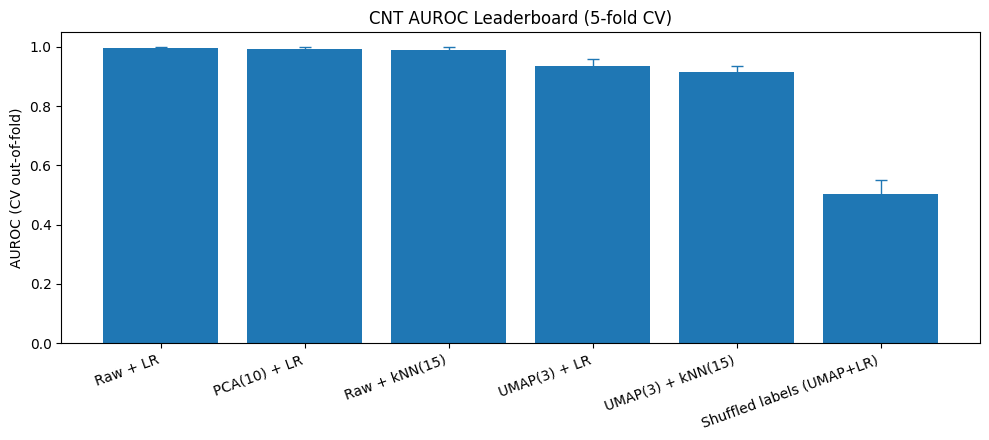

=== CNT AUROC Leaderboard ===
                    model    auroc                                 auroc_ci  accuracy
                 Raw + LR 0.994688 [0.9893556072299761, 0.9987678151410895]  0.973638
             PCA(10) + LR 0.993803 [0.9874962245880989, 0.9985971495713448]  0.977153
            Raw + kNN(15) 0.990097  [0.980319269807605, 0.9975518058276986]  0.959578
             UMAP(3) + LR 0.935574  [0.9130786869424142, 0.957396987534626]  0.899824
        UMAP(3) + kNN(15) 0.913588 [0.8898175036747611, 0.9359274748524616]  0.899824
Shuffled labels (UMAP+LR) 0.502392 [0.45149244614046924, 0.552181317389918]  0.569420
[saved] out\cnt_auroc_leaderboard.png
[saved] out\cnt_auroc_leaderboard.json


In [9]:
# CNT AUROC Leaderboard — single cell (self-contained)
# Compares classifiers on: Raw features, PCA, UMAP (+ optional kNN)
# - Auto-uses your `df` if present (looks for a label column), else sklearn breast_cancer
# - 5-fold stratified CV with out-of-fold predictions
# - Metrics: AUROC (primary), Accuracy; 95% bootstrap CI on AUROC
# Saves: out/cnt_auroc_leaderboard.png, out/cnt_auroc_leaderboard.json

import sys, subprocess, json, math, warnings, numpy as np, pandas as pd
from pathlib import Path

def _safe_import(name, pip_name=None):
    try:
        return __import__(name)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", (pip_name or name)])
        return __import__(name)

# deps
sk = _safe_import("sklearn","scikit-learn")
mplt = _safe_import("matplotlib"); plt = mplt.pyplot
umap_mod = _safe_import("umap","umap-learn")  # optional

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42

# ---------- data loader ----------
def _numeric_matrix_from_df(df):
    num = df.select_dtypes(include=[np.number]).copy()
    num = num.fillna(num.median(numeric_only=True))
    keep = [c for c in num.columns if np.isfinite(num[c]).sum() >= 3 and np.nanstd(num[c]) > 0]
    if len(keep) < 2:
        raise ValueError("Not enough informative numeric columns.")
    return num[keep], keep

def _get_xy():
    gdf = globals().get("df", None)
    if gdf is not None and isinstance(gdf, pd.DataFrame):
        # detect label column
        label_cols = [c for c in ["target","label","y","class","diagnosis","Diagnosis","DX"] if c in gdf.columns]
        y = None
        for c in label_cols:
            if 2 <= gdf[c].nunique() <= 20:
                y = gdf[c].to_numpy()
                Xdf = gdf.drop(columns=[c])
                break
        if y is not None:
            Xdf, cols = _numeric_matrix_from_df(Xdf)
            print("[data] Using global `df` with detected label column.")
            return Xdf.to_numpy(), y, {"source":"user_df","features":cols}
    # fallback: sklearn breast_cancer
    from sklearn.datasets import load_breast_cancer
    ds = load_breast_cancer(as_frame=True)
    Xdf = ds.frame.drop(columns=["target"])
    Xdf, cols = _numeric_matrix_from_df(Xdf)
    print("[data] Loaded sklearn breast_cancer dataset.")
    return Xdf.to_numpy(), ds.target.to_numpy(), {"source":"sklearn_breast_cancer","features":cols}

# ---------- modeling utilities ----------
def _is_multiclass(y):
    return len(np.unique(y)) > 2

def _auroc(y_true, y_prob):
    # y_prob: shape (n_samples,) for binary, (n_samples, n_classes) for multiclass
    if y_prob.ndim == 1:
        return roc_auc_score(y_true, y_prob)
    else:
        # multiclass one-vs-rest, weighted by prevalence
        return roc_auc_score(y_true, y_prob, multi_class="ovr", average="weighted")

def _bootstrap_ci(y_true, y_prob, n_boot=2000, seed=1234):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    stats = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        try:
            stats.append(_auroc(y_true[idx], y_prob[idx] if y_prob.ndim==1 else y_prob[idx,:]))
        except Exception:
            continue
    if not stats:
        return (np.nan, np.nan)
    lo, hi = np.percentile(stats, [2.5, 97.5])
    return (float(lo), float(hi))

def _oof_scores(model_maker, X, y, n_splits=5, shuffle=True, random_state=RANDOM_STATE):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    is_multi = _is_multiclass(y)
    if is_multi:
        n_classes = len(np.unique(y))
        oof_prob = np.zeros((len(y), n_classes), dtype=float)
    else:
        oof_prob = np.zeros(len(y), dtype=float)
    oof_pred = np.zeros(len(y), dtype=int)
    for train_idx, test_idx in skf.split(X, y):
        Xtr, Xte = X[train_idx], X[test_idx]
        ytr, yte = y[train_idx], y[test_idx]
        model = model_maker()
        model.fit(Xtr, ytr)
        if hasattr(model, "predict_proba"):
            prob = model.predict_proba(Xte)
            if not is_multi:
                prob = prob[:,1]
        else:
            # fallback to decision_function
            dfun = model.decision_function(Xte)
            if not is_multi:
                # min-max to (0,1)
                mn, mx = dfun.min(), dfun.max()
                prob = (dfun - mn) / (mx - mn + 1e-9)
            else:
                # one-vs-rest decision scores to probs-ish
                ex = np.exp(dfun - dfun.max(axis=1, keepdims=True))
                prob = ex / ex.sum(axis=1, keepdims=True)
        oof_pred[test_idx] = model.predict(Xte)
        oof_prob[test_idx] = prob
    au = _auroc(y, oof_prob)
    acc = accuracy_score(y, oof_pred)
    lo, hi = _bootstrap_ci(y, oof_prob)
    return {"auroc": float(au), "auroc_ci": [lo, hi], "accuracy": float(acc)}

# ---------- build model factories ----------
def _make_lr():
    return LogisticRegression(max_iter=2000, solver="lbfgs", n_jobs=None)

def _pipeline_raw_lr():
    return Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lr", _make_lr())
    ])

def _pipeline_pca_lr(n_components=10):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=n_components, random_state=RANDOM_STATE)),
        ("lr", _make_lr())
    ])

def _pipeline_umap_lr(n_components=3, n_neighbors=30, min_dist=0.1):
    if umap_mod is None:
        # fallback to PCA if UMAP unavailable
        return _pipeline_pca_lr(n_components=min(n_components, 10))
    return Pipeline([
        ("scaler", StandardScaler()),
        ("umap", umap_mod.UMAP(n_components=n_components, n_neighbors=n_neighbors,
                               min_dist=min_dist, random_state=RANDOM_STATE)),
        ("lr", _make_lr())
    ])

def _pipeline_raw_knn(k=15):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])

def _pipeline_umap_knn(n_components=3, k=15):
    if umap_mod is None:
        return _pipeline_raw_knn(k)
    return Pipeline([
        ("scaler", StandardScaler()),
        ("umap", umap_mod.UMAP(n_components=n_components, n_neighbors=max(10,k*2),
                               min_dist=0.1, random_state=RANDOM_STATE)),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])

# ---------- run ----------
X, y, meta = _get_xy()
models = {
    "Raw + LR":          lambda: _pipeline_raw_lr(),
    "PCA(10) + LR":      lambda: _pipeline_pca_lr(n_components=min(10, X.shape[1])),
    "UMAP(3) + LR":      lambda: _pipeline_umap_lr(n_components=3),
    "Raw + kNN(15)":     lambda: _pipeline_raw_knn(k=15),
    "UMAP(3) + kNN(15)": lambda: _pipeline_umap_knn(n_components=3, k=15),
}

# Null baseline: shuffled labels with the strongest pipeline (UMAP+LR if available)
rng = np.random.default_rng(RANDOM_STATE)
y_shuf = y.copy(); rng.shuffle(y_shuf)
models_null = {
    "Shuffled labels (UMAP+LR)": lambda: _pipeline_umap_lr(n_components=3)
}

results = []
for name, mk in models.items():
    metrics = _oof_scores(mk, X, y)
    results.append({"model": name, **metrics})
for name, mk in models_null.items():
    metrics = _oof_scores(mk, X, y_shuf)
    results.append({"model": name, **metrics})

# sort by AUROC (desc, null at bottom)
results_sorted = sorted(results, key=lambda d: d["auroc"], reverse=True)
df_res = pd.DataFrame(results_sorted)

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(10, 4.5))
labels = df_res["model"].tolist()
aucs   = df_res["auroc"].to_numpy()
ci     = np.array(df_res["auroc_ci"].tolist())
yerr = np.vstack([aucs - ci[:,0], ci[:,1] - aucs])

ax.bar(range(len(labels)), aucs)
ax.errorbar(range(len(labels)), aucs, yerr=yerr, fmt="none", capsize=4, linewidth=1)
ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=20, ha="right")
ax.set_ylabel("AUROC (CV out-of-fold)")
ax.set_title("CNT AUROC Leaderboard (5-fold CV)")
plt.tight_layout()
fig_path = Path("out") / "cnt_auroc_leaderboard.png"
plt.savefig(fig_path, dpi=160)
plt.show()

# ---------- save report ----------
report = {
    "data_source": meta["source"],
    "n_samples": int(X.shape[0]),
    "n_features": int(X.shape[1]),
    "multiclass": bool(_is_multiclass(y)),
    "results": results_sorted,
    "figure": str(fig_path)
}
json_path = Path("out") / "cnt_auroc_leaderboard.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2)

print("=== CNT AUROC Leaderboard ===")
print(df_res.to_string(index=False))
print(f"[saved] {fig_path}")
print(f"[saved] {json_path}")


[data] Loaded sklearn_breast_cancer.


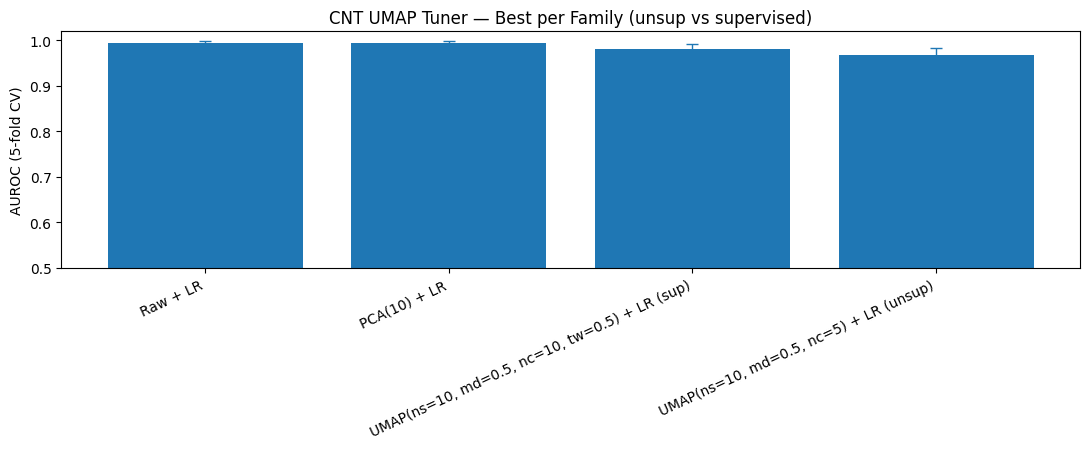

=== CNT UMAP Tuner — Best per Family ===
                                        model    auroc                                 auroc_ci  accuracy
                                     Raw + LR 0.994688 [0.9893556072299761, 0.9987678151410895]  0.973638
                                 PCA(10) + LR 0.993803 [0.9874962245880989, 0.9985971495713448]  0.977153
UMAP(ns=10, md=0.5, nc=10, tw=0.5) + LR (sup) 0.980366 [0.9675260048731247, 0.9910854252863815]  0.933216
       UMAP(ns=10, md=0.5, nc=5) + LR (unsup) 0.968752 [0.9507993688237871, 0.9834480541939381]  0.947276
[saved] out\cnt_umap_tuner_leaderboard.png
[saved] out\cnt_umap_tuner_leaderboard.json


In [10]:
# CNT UMAP Tuner + Supervised UMAP Leaderboard — single cell
# Compares Raw+LR, PCA+LR, best Unsupervised UMAP+LR, best Supervised UMAP+LR
# (5-fold stratified CV, AUROC primary; 95% bootstrap CI)
# Saves: out/cnt_umap_tuner_leaderboard.png, out/cnt_umap_tuner_leaderboard.json

import sys, subprocess, json, math, warnings, numpy as np, pandas as pd
from pathlib import Path

def _safe_import(name, pip_name=None):
    try:
        return __import__(name)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", (pip_name or name)])
        return __import__(name)

sk = _safe_import("sklearn","scikit-learn")
mplt = _safe_import("matplotlib"); plt = mplt.pyplot
umap_mod = _safe_import("umap","umap-learn")  # optional

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42

# ---------- data ----------
def _numeric_df(df):
    num = df.select_dtypes(include=[np.number]).copy()
    num = num.fillna(num.median(numeric_only=True))
    keep = [c for c in num.columns if np.isfinite(num[c]).sum()>=3 and np.nanstd(num[c])>0]
    if len(keep) < 2: raise ValueError("Not enough informative numeric columns.")
    return num[keep], keep

def _get_xy():
    gdf = globals().get("df", None)
    if isinstance(gdf, pd.DataFrame):
        for c in ["target","label","y","class","diagnosis","Diagnosis","DX"]:
            if c in gdf.columns and 2 <= gdf[c].nunique() <= 20:
                y = gdf[c].to_numpy()
                Xdf, cols = _numeric_df(gdf.drop(columns=[c]))
                print("[data] Using global `df` with detected label column:", c)
                return Xdf.to_numpy(), y, {"source":"user_df","label":c,"features":cols}
    from sklearn.datasets import load_breast_cancer
    ds = load_breast_cancer(as_frame=True)
    Xdf, cols = _numeric_df(ds.frame.drop(columns=["target"]))
    print("[data] Loaded sklearn_breast_cancer.")
    return Xdf.to_numpy(), ds.target.to_numpy(), {"source":"sklearn_breast_cancer","label":"target","features":cols}

def _is_multi(y): return len(np.unique(y)) > 2

def _auroc(y_true, y_prob):
    return roc_auc_score(y_true, y_prob if y_prob.ndim==1 else y_prob, multi_class=("ovr" if y_prob.ndim>1 else "raise"), average=("weighted" if y_prob.ndim>1 else "macro"))

def _bootstrap_ci(y_true, y_prob, n_boot=2000, seed=1234):
    rng = np.random.default_rng(seed); n=len(y_true); vals=[]
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        try: vals.append(_auroc(y_true[idx], y_prob[idx] if y_prob.ndim==1 else y_prob[idx,:]))
        except: pass
    if not vals: return (np.nan, np.nan)
    lo, hi = np.percentile(vals, [2.5, 97.5]); return float(lo), float(hi)

def _oof_scores(make_model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    multi = _is_multi(y); n_classes = len(np.unique(y))
    oof_prob = np.zeros((len(y), n_classes), float) if multi else np.zeros(len(y), float)
    oof_pred = np.zeros(len(y), int)
    for tr, te in skf.split(X, y):
        mdl = make_model()
        mdl.fit(X[tr], y[tr])  # Pipeline will pass y to UMAP (for supervised)
        if hasattr(mdl, "predict_proba"):
            p = mdl.predict_proba(X[te]); 
            if not multi: p = p[:,1]
        else:
            s = mdl.decision_function(X[te])
            if multi:
                ex = np.exp(s - s.max(axis=1, keepdims=True)); p = ex / ex.sum(axis=1, keepdims=True)
            else:
                s = (s - s.min()) / (s.max()-s.min()+1e-9); p = s
        oof_prob[te] = p; oof_pred[te] = mdl.predict(X[te])
    au = _auroc(y, oof_prob); acc = accuracy_score(y, oof_pred); lo, hi = _bootstrap_ci(y, oof_prob)
    return {"auroc": float(au), "auroc_ci":[lo,hi], "accuracy": float(acc)}

# ---------- model factories ----------
def _lr(): return LogisticRegression(max_iter=2000, solver="lbfgs")

def _pipe_raw_lr():  return Pipeline([("scaler", StandardScaler()), ("lr", _lr())])
def _pipe_pca_lr(k=10): return Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=k, random_state=RANDOM_STATE)), ("lr", _lr())])

def _pipe_umap_lr(n_components=3, n_neighbors=30, min_dist=0.1, target_weight=0.0, supervised=False):
    if umap_mod is None:  # fallback to PCA
        return _pipe_pca_lr(k=min(n_components,10))
    # supervised on/off is controlled by target_weight: 0.0 ~ unsupervised, >0 uses labels
    return Pipeline([
        ("scaler", StandardScaler()),
        ("umap", umap_mod.UMAP(
            n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist,
            target_metric="categorical", target_weight=target_weight, random_state=RANDOM_STATE
        )),
        ("lr", _lr())
    ])

# ---------- run tuning ----------
X, y, meta = _get_xy()

# Baselines
bench = {
    "Raw + LR":      lambda: _pipe_raw_lr(),
    "PCA(10) + LR":  lambda: _pipe_pca_lr(k=min(10, X.shape[1])),
}

# UMAP grids
n_comp_grid   = [3, 5, 10]
n_neighbors_grid = [10, 30, 60]
min_dist_grid = [0.0, 0.1, 0.5]

unsup_results = []
sup_results   = []
for nc in n_comp_grid:
    for nn in n_neighbors_grid:
        for md in min_dist_grid:
            # Unsupervised: target_weight=0.0 (labels passed but ignored)
            unsup_results.append({
                "model": f"UMAP(ns={nn}, md={md}, nc={nc}) + LR (unsup)",
                **_oof_scores(lambda nc=nc,nn=nn,md=md: _pipe_umap_lr(n_components=nc, n_neighbors=nn, min_dist=md, target_weight=0.0, supervised=False), X, y)
            })
            # Supervised: try a couple target weights
            for tw in (0.2, 0.5, 0.8):
                sup_results.append({
                    "model": f"UMAP(ns={nn}, md={md}, nc={nc}, tw={tw}) + LR (sup)",
                    **_oof_scores(lambda nc=nc,nn=nn,md=md,tw=tw: _pipe_umap_lr(n_components=nc, n_neighbors=nn, min_dist=md, target_weight=tw, supervised=True), X, y)
                })

# Pick best from each family
best_unsup = sorted(unsup_results, key=lambda d: d["auroc"], reverse=True)[0]
best_sup   = sorted(sup_results,   key=lambda d: d["auroc"], reverse=True)[0]

results = []
for name, mk in bench.items():
    results.append({"model": name, **_oof_scores(mk, X, y)})
results.append(best_unsup)
results.append(best_sup)

# Sort + display
results_sorted = sorted(results, key=lambda d: d["auroc"], reverse=True)
df = pd.DataFrame(results_sorted)

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(11, 4.6))
labels = df["model"].tolist()
aucs   = df["auroc"].to_numpy()
ci     = np.array(df["auroc_ci"].tolist())
yerr = np.vstack([aucs - ci[:,0], ci[:,1] - aucs])

ax.bar(range(len(labels)), aucs)
ax.errorbar(range(len(labels)), aucs, yerr=yerr, fmt="none", capsize=4, linewidth=1)
ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=25, ha="right")
ax.set_ylabel("AUROC (5-fold CV)")
ax.set_ylim(0.5, 1.02)
ax.set_title("CNT UMAP Tuner — Best per Family (unsup vs supervised)")
plt.tight_layout()
fig_path = Path("out") / "cnt_umap_tuner_leaderboard.png"
plt.savefig(fig_path, dpi=160)
plt.show()

# ---------- save ----------
report = {
    "data_source": meta["source"],
    "n_samples": int(X.shape[0]), "n_features": int(X.shape[1]),
    "grid": {"n_components": n_comp_grid, "n_neighbors": n_neighbors_grid, "min_dist": min_dist_grid, "target_weights":[0.0,0.2,0.5,0.8]},
    "best_unsup": best_unsup,
    "best_sup": best_sup,
    "results": results_sorted,
    "figure": str(fig_path)
}
json_path = Path("out") / "cnt_umap_tuner_leaderboard.json"
with open(json_path, "w", encoding="utf-8") as f: json.dump(report, f, indent=2)

print("=== CNT UMAP Tuner — Best per Family ===")
print(df.to_string(index=False))
print(f"[saved] {fig_path}")
print(f"[saved] {json_path}")


[data] Loaded sklearn_breast_cancer.


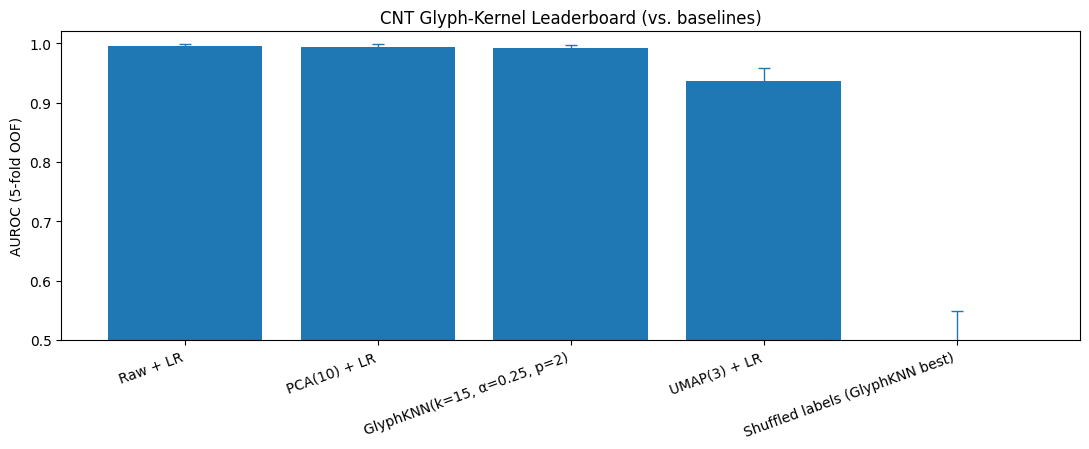

=== CNT Glyph-Kernel Leaderboard ===
                          model    auroc                                 auroc_ci  accuracy                           params
                       Raw + LR 0.994688 [0.9893556072299761, 0.9987678151410895]  0.973638                              NaN
                   PCA(10) + LR 0.993803 [0.9874962245880989, 0.9985971495713448]  0.977153                              NaN
    GlyphKNN(k=15, α=0.25, p=2) 0.992264 [0.9853321830608416, 0.9975511097536821]  0.963093 {'k': 15, 'alpha': 0.25, 'p': 2}
                   UMAP(3) + LR 0.935574  [0.9130786869424142, 0.957396987534626]  0.899824                              NaN
Shuffled labels (GlyphKNN best) 0.500126 [0.45140056418467367, 0.549028464738339]  0.590510 {'k': 15, 'alpha': 0.25, 'p': 2}
[saved] out\cnt_glyph_kernel_leaderboard.png
[saved] out\cnt_glyph_kernel_leaderboard.json


In [11]:
# CNT Glyph-Kernel Leaderboard — single cell (self-contained)
# Idea: learn a "glyph axis" g (supervised if labels available, else PCA-1),
# then define a pairwise distance:
#   d_glyph(i,j) = ||(x_i-x_j)∘sqrt(w)||_2 * (1 + α * sin^2(angle(x_i-x_j, g)))
# where w ∝ |g|^p (feature weights). Evaluate kNN with precomputed distances.
# Saves: out/cnt_glyph_kernel_leaderboard.png, out/cnt_glyph_kernel_leaderboard.json

import sys, subprocess, json, math, warnings, numpy as np, pandas as pd
from pathlib import Path

def _safe_import(name, pip_name=None):
    try:
        return __import__(name)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", (pip_name or name)])
        return __import__(name)

sk = _safe_import("sklearn","scikit-learn")
mplt = _safe_import("matplotlib"); plt = mplt.pyplot
umap_mod = _safe_import("umap","umap-learn")  # optional

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)
RNG = np.random.default_rng(42)

# ---------------- data helpers ----------------
def _numeric_df(df):
    num = df.select_dtypes(include=[np.number]).copy()
    num = num.fillna(num.median(numeric_only=True))
    keep = [c for c in num.columns if np.isfinite(num[c]).sum()>=3 and np.nanstd(num[c])>0]
    if len(keep)<2: raise ValueError("Not enough informative numeric columns.")
    return num[keep], keep

def _get_xy():
    gdf = globals().get("df", None)
    if isinstance(gdf, pd.DataFrame):
        for c in ["target","label","y","class","diagnosis","Diagnosis","DX"]:
            if c in gdf.columns and 2 <= gdf[c].nunique() <= 20:
                y = gdf[c].to_numpy()
                Xdf, cols = _numeric_df(gdf.drop(columns=[c]))
                print("[data] Using global `df` with detected label column:", c)
                return Xdf.to_numpy(), y, {"source":"user_df","label":c,"features":cols}
    from sklearn.datasets import load_breast_cancer
    ds = load_breast_cancer(as_frame=True)
    Xdf, cols = _numeric_df(ds.frame.drop(columns=["target"]))
    print("[data] Loaded sklearn_breast_cancer.")
    return Xdf.to_numpy(), ds.target.to_numpy(), {"source":"sklearn_breast_cancer","label":"target","features":cols}

def _is_multi(y): return len(np.unique(y)) > 2
def _auroc(y_true, y_prob):
    if y_prob.ndim==1: return roc_auc_score(y_true, y_prob)
    return roc_auc_score(y_true, y_prob, multi_class="ovr", average="weighted")

def _bootstrap_ci(y_true, y_prob, n_boot=2000, seed=1234):
    rng = np.random.default_rng(seed); n=len(y_true); vals=[]
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        try: vals.append(_auroc(y_true[idx], y_prob[idx] if y_prob.ndim==1 else y_prob[idx,:]))
        except: pass
    if not vals: return (np.nan, np.nan)
    lo, hi = np.percentile(vals, [2.5,97.5]); return float(lo), float(hi)

# ---------------- baselines ----------------
def _lr(): return LogisticRegression(max_iter=2000, solver="lbfgs")
def _pipe_raw_lr():  return Pipeline([("scaler", StandardScaler()), ("lr", _lr())])
def _pipe_pca_lr(k=10): return Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=k, random_state=42)), ("lr", _lr())])
def _pipe_umap_lr(nc=3, nn=30, md=0.1):
    if umap_mod is None: return _pipe_pca_lr(k=min(nc,10))
    return Pipeline([("scaler", StandardScaler()),
                     ("umap", umap_mod.UMAP(n_components=nc, n_neighbors=nn, min_dist=md, random_state=42)),
                     ("lr", _lr())])

def _oof_scores(make_model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    multi = _is_multi(y); n_classes=len(np.unique(y))
    oof_prob = np.zeros((len(y), n_classes), float) if multi else np.zeros(len(y), float)
    oof_pred = np.zeros(len(y), int)
    for tr, te in skf.split(X, y):
        mdl = make_model(); mdl.fit(X[tr], y[tr])
        if hasattr(mdl,"predict_proba"):
            p = mdl.predict_proba(X[te]); 
            if not multi: p = p[:,1]
        else:
            s = mdl.decision_function(X[te])
            if multi: 
                ex = np.exp(s - s.max(axis=1, keepdims=True)); p = ex/ex.sum(axis=1, keepdims=True)
            else:
                s = (s - s.min())/(s.max()-s.min()+1e-9); p = s
        oof_prob[te] = p; oof_pred[te] = mdl.predict(X[te])
    return {"auroc": float(_auroc(y,oof_prob)), "auroc_ci": list(_bootstrap_ci(y,oof_prob)), "accuracy": float(accuracy_score(y,oof_pred))}

# ---------------- CNT Glyph Kernel ----------------
def _glyph_axis(Xs_tr, y_tr=None):
    """Return (g unit vector, feature weights w with mean=1) in standardized space."""
    if y_tr is not None and len(np.unique(y_tr))>=2:
        lr = LogisticRegression(max_iter=2000, solver="lbfgs").fit(Xs_tr, y_tr)
        coef = lr.coef_
        g = np.mean(np.abs(coef), axis=0)  # robust across classes
        if np.allclose(g, 0): g = np.ones(Xs_tr.shape[1])
    else:
        g = PCA(n_components=1, random_state=42).fit(Xs_tr).components_[0]
        g = np.abs(g)
    g = g.astype(float)
    g_norm = np.linalg.norm(g) + 1e-12
    g_unit = g / g_norm
    return g_unit

def _feature_weights(g_unit, p=1):
    w = np.abs(g_unit) ** p
    w = w / (w.mean() + 1e-12)
    return w

def _glyph_dist_matrix(XA, XB, g_unit, w, alpha=0.5, eps=1e-12):
    """Fast pairwise glyph distances between rows of XA and XB (both standardized)."""
    # weighted Euclidean part
    sqrtw = np.sqrt(w)
    A = XA * sqrtw; B = XB * sqrtw
    SA = np.sum(A*A, axis=1); SB = np.sum(B*B, axis=1)
    d2_w = np.clip(SA[:,None] + SB[None,:] - 2*(A @ B.T), 0, None)
    # orientation penalty via sin^2 to glyph axis
    SAu = np.sum(XA*XA, axis=1); SBu = np.sum(XB*XB, axis=1)
    diff2 = np.clip(SAu[:,None] + SBu[None,:] - 2*(XA @ XB.T), eps, None)
    projA = XA @ g_unit; projB = XB @ g_unit
    dproj = (projA[:,None] - projB[None,:])**2
    cos2 = np.clip(dproj / (diff2 + eps), 0, 1)  # since ||g||=1
    sin2 = 1.0 - cos2
    return np.sqrt(d2_w) * (1.0 + alpha * sin2)

def _oof_glyph_knn(X, y, k=15, alpha=0.5, p=1, n_splits=5):
    """Precomputed-distance kNN using glyph distance; returns out-of-fold metrics."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    multi = _is_multi(y); n_classes=len(np.unique(y))
    oof_prob = np.zeros((len(y), n_classes), float) if multi else np.zeros(len(y), float)
    oof_pred = np.zeros(len(y), int)
    for tr, te in skf.split(X, y):
        scaler = StandardScaler().fit(X[tr]); Xtr = scaler.transform(X[tr]); Xte = scaler.transform(X[te])
        g = _glyph_axis(Xtr, y[tr]); w = _feature_weights(g, p=p)
        D_tr = _glyph_dist_matrix(Xtr, Xtr, g, w, alpha=alpha)
        D_te = _glyph_dist_matrix(Xte, Xtr, g, w, alpha=alpha)
        # sklearn kNN with precomputed distances
        knn = KNeighborsClassifier(n_neighbors=k, metric="precomputed")
        knn.fit(D_tr, y[tr])
        prob = knn.predict_proba(D_te)
        if not multi: prob = prob[:,1]
        oof_prob[te] = prob; oof_pred[te] = knn.predict(D_te)
    return {"auroc": float(_auroc(y, oof_prob)), "auroc_ci": list(_bootstrap_ci(y, oof_prob)),
            "accuracy": float(accuracy_score(y, oof_pred)),
            "params": {"k":k,"alpha":alpha,"p":p}}

# ---------------- run leaderboard ----------------
X, y, meta = _get_xy()

# Baselines
results = []
results.append({"model":"Raw + LR",     **_oof_scores(lambda:_pipe_raw_lr(), X, y)})
results.append({"model":"PCA(10) + LR", **_oof_scores(lambda:_pipe_pca_lr(k=min(10, X.shape[1])), X, y)})
results.append({"model":"UMAP(3) + LR", **_oof_scores(lambda:_pipe_umap_lr(nc=3), X, y)})

# Glyph-kernel search (small grid)
grid_alpha = [0.0, 0.25, 0.5, 1.0]
grid_p     = [1, 2]
grid_k     = [7, 15]
glyph_runs = []
for alpha in grid_alpha:
    for p in grid_p:
        for k in grid_k:
            metrics = _oof_glyph_knn(X, y, k=k, alpha=alpha, p=p)
            glyph_runs.append({"model": f"GlyphKNN(k={k}, α={alpha}, p={p})", **metrics})

best_glyph = sorted(glyph_runs, key=lambda d: d["auroc"], reverse=True)[0]
results.append(best_glyph)

# Add null: shuffled labels with strongest (best_glyph) config for sanity
y_shuf = y.copy(); RNG.shuffle(y_shuf)
null_metrics = _oof_glyph_knn(X, y_shuf, k=best_glyph["params"]["k"],
                              alpha=best_glyph["params"]["alpha"], p=best_glyph["params"]["p"])
results.append({"model":"Shuffled labels (GlyphKNN best)", **null_metrics})

# Sort and display
results_sorted = sorted(results, key=lambda d: d["auroc"], reverse=True)
df = pd.DataFrame(results_sorted)

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(11, 4.6))
labels = df["model"].tolist()
aucs   = df["auroc"].to_numpy()
ci     = np.array(df["auroc_ci"].tolist())
yerr = np.vstack([aucs - ci[:,0], ci[:,1] - aucs])

ax.bar(range(len(labels)), aucs)
ax.errorbar(range(len(labels)), aucs, yerr=yerr, fmt="none", capsize=4, linewidth=1)
ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=20, ha="right")
ax.set_ylabel("AUROC (5-fold OOF)")
ax.set_ylim(0.5, 1.02)
ax.set_title("CNT Glyph-Kernel Leaderboard (vs. baselines)")
plt.tight_layout()
fig_path = Path("out") / "cnt_glyph_kernel_leaderboard.png"
plt.savefig(fig_path, dpi=160)
plt.show()

# ---------- save ----------
report = {
    "data_source": meta["source"],
    "n_samples": int(X.shape[0]), "n_features": int(X.shape[1]),
    "best_glyph": best_glyph,
    "glyph_grid": {"alpha": grid_alpha, "p": grid_p, "k": grid_k},
    "results": results_sorted,
    "figure": str(fig_path)
}
json_path = Path("out") / "cnt_glyph_kernel_leaderboard.json"
with open(json_path, "w", encoding="utf-8") as f: json.dump(report, f, indent=2)

print("=== CNT Glyph-Kernel Leaderboard ===")
print(df.to_string(index=False))
print(f"[saved] {fig_path}")
print(f"[saved] {json_path}")


[data] Loaded sklearn_breast_cancer.


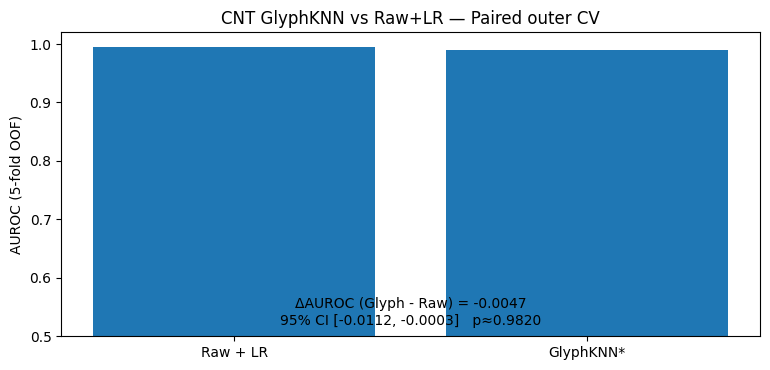

=== CNT GlyphKNN vs Raw+LR — Paired Significance ===
    model    auroc  accuracy
 Raw + LR 0.994688  0.973638
GlyphKNN* 0.989945  0.956063
ΔAUROC (Glyph - Raw) = -0.004743   95% CI [-0.011208, -0.000273]   p≈0.982006
[saved] out\cnt_glyph_vs_raw_significance.png
[saved] out\cnt_glyph_vs_raw_significance.json


In [12]:
# CNT Baseline vs GlyphKNN — Paired Significance Harness (single cell)
# - Shared 5-fold outer CV
# - GlyphKNN tuned by inner CV on each training fold (no leakage)
# - Outputs: ΔAUROC (Glyph - RawLR) with 95% CI + p-value, leaderboard, plot, JSON
# Saves: out/cnt_glyph_vs_raw_significance.png, out/cnt_glyph_vs_raw_significance.json

import sys, subprocess, json, math, warnings, numpy as np, pandas as pd
from pathlib import Path

def _safe_import(name, pip_name=None):
    try:
        return __import__(name)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", (pip_name or name)])
        return __import__(name)

sk = _safe_import("sklearn","scikit-learn"); mplt = _safe_import("matplotlib"); plt = mplt.pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings("ignore"); Path("out").mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42

# ---------------- data ----------------
def _numeric_df(df):
    num = df.select_dtypes(include=[np.number]).copy()
    num = num.fillna(num.median(numeric_only=True))
    keep = [c for c in num.columns if np.isfinite(num[c]).sum()>=3 and np.nanstd(num[c])>0]
    if len(keep) < 2: raise ValueError("Not enough informative numeric columns.")
    return num[keep], keep

def _get_xy():
    gdf = globals().get("df", None)
    if isinstance(gdf, pd.DataFrame):
        for c in ["target","label","y","class","diagnosis","Diagnosis","DX"]:
            if c in gdf.columns and 2 <= gdf[c].nunique() <= 20:
                y = gdf[c].to_numpy()
                Xdf, cols = _numeric_df(gdf.drop(columns=[c]))
                print("[data] Using global `df` with label:", c)
                return Xdf.to_numpy(), y, {"source":"user_df","label":c,"features":cols}
    from sklearn.datasets import load_breast_cancer
    ds = load_breast_cancer(as_frame=True)
    Xdf, cols = _numeric_df(ds.frame.drop(columns=["target"]))
    print("[data] Loaded sklearn_breast_cancer.")
    return Xdf.to_numpy(), ds.target.to_numpy(), {"source":"sklearn_breast_cancer","label":"target","features":cols}

def _is_multi(y): return len(np.unique(y))>2
def _auroc(y_true, y_prob):
    return roc_auc_score(y_true, y_prob if y_prob.ndim==1 else y_prob, multi_class=("ovr" if y_prob.ndim>1 else "raise"), average=("weighted" if y_prob.ndim>1 else "macro"))

def _bootstrap_ci_delta(y, p_glyph, p_raw, n_boot=3000, seed=12345):
    rng = np.random.default_rng(seed); n = len(y); deltas=[]
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        try:
            d = _auroc(y[idx], p_glyph[idx]) - _auroc(y[idx], p_raw[idx])
            deltas.append(d)
        except: pass
    lo, hi = np.percentile(deltas, [2.5, 97.5])
    p_right = (np.sum(np.array(deltas) <= 0.0) + 1) / (len(deltas) + 1)  # P(Δ<=0) ~ one-sided
    return float(lo), float(hi), float(p_right)

# ---------------- GlyphKNN pieces ----------------
def _glyph_axis(Xs_tr, y_tr=None):
    if y_tr is not None and len(np.unique(y_tr))>=2:
        lr = LogisticRegression(max_iter=2000, solver="lbfgs").fit(Xs_tr, y_tr)
        g = np.mean(np.abs(lr.coef_), axis=0)
        if np.allclose(g, 0): g = np.ones(Xs_tr.shape[1])
    else:
        g = PCA(n_components=1, random_state=RANDOM_STATE).fit(Xs_tr).components_[0]
        g = np.abs(g)
    g = g.astype(float); g_unit = g / (np.linalg.norm(g)+1e-12)
    return g_unit

def _feature_weights(g_unit, p=2):
    w = np.abs(g_unit) ** p
    return w / (w.mean()+1e-12)

def _glyph_dist_matrix(XA, XB, g_unit, w, alpha=0.25, eps=1e-12):
    sqrtw = np.sqrt(w); A = XA * sqrtw; B = XB * sqrtw
    SA = np.sum(A*A, axis=1); SB = np.sum(B*B, axis=1)
    d2_w = np.clip(SA[:,None] + SB[None,:] - 2*(A @ B.T), 0, None)
    # orientation penalty
    diff2 = np.clip(np.sum(XA*XA,axis=1)[:,None] + np.sum(XB*XB,axis=1)[None,:] - 2*(XA @ XB.T), eps, None)
    projA = XA @ g_unit; projB = XB @ g_unit
    dproj = (projA[:,None] - projB[None,:])**2
    cos2 = np.clip(dproj / (diff2 + eps), 0, 1)
    sin2 = 1.0 - cos2
    return np.sqrt(d2_w) * (1.0 + alpha * sin2)

# ---------------- Outer CV with inner tuning for GlyphKNN ----------------
def run_significance(X, y, outer_splits=5):
    multi = _is_multi(y); n = len(y)
    skf_outer = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=RANDOM_STATE)

    oof_raw = np.zeros(n, float) if not multi else np.zeros((n, len(np.unique(y))), float)
    oof_gly = np.zeros_like(oof_raw)
    oof_raw_pred = np.zeros(n, int); oof_gly_pred = np.zeros(n, int)
    chosen = []

    glyph_grid = [(k, a, p) for k in (7,11,15) for a in (0.0,0.25,0.5,1.0) for p in (1,2,3)]

    for fold, (tr, te) in enumerate(skf_outer.split(X, y), 1):
        scaler = StandardScaler().fit(X[tr]); Xtr = scaler.transform(X[tr]); Xte = scaler.transform(X[te])

        # ---- Raw + LR on outer split
        lr = LogisticRegression(max_iter=2000, solver="lbfgs").fit(Xtr, y[tr])
        prob = lr.predict_proba(Xte);  prob = prob[:,1] if not multi else prob
        oof_raw[te] = prob; oof_raw_pred[te] = lr.predict(Xte)

        # ---- Inner CV to pick GlyphKNN hyperparams on training fold only
        skf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE+fold)
        best = (-np.inf, (15,0.25,2))  # (mean AUROC, params)
        for (k, alpha, p) in glyph_grid:
            inner_scores=[]
            for tr2, va2 in skf_inner.split(Xtr, y[tr]):
                Xtr2, Xva2 = Xtr[tr2], Xtr[va2]; ytr2, yva2 = y[tr][tr2], y[tr][va2]
                g = _glyph_axis(Xtr2, ytr2); w = _feature_weights(g, p=p)
                D_tr = _glyph_dist_matrix(Xtr2, Xtr2, g, w, alpha=alpha)
                D_va = _glyph_dist_matrix(Xva2, Xtr2, g, w, alpha=alpha)
                knn = KNeighborsClassifier(n_neighbors=k, metric="precomputed").fit(D_tr, ytr2)
                prob_va = knn.predict_proba(D_va); prob_va = prob_va[:,1] if not multi else prob_va
                inner_scores.append(_auroc(yva2, prob_va))
            m = float(np.mean(inner_scores)) if inner_scores else -np.inf
            if m > best[0]: best = (m, (k, alpha, p))
        k_best, alpha_best, p_best = best[1]; chosen.append({"fold":fold, "k":k_best, "alpha":alpha_best, "p":p_best, "cv_auroc":best[0]})

        # ---- Train GlyphKNN on full inner training with best params, eval on test
        g = _glyph_axis(Xtr, y[tr]); w = _feature_weights(g, p=p_best)
        D_tr = _glyph_dist_matrix(Xtr, Xtr, g, w, alpha=alpha_best)
        D_te = _glyph_dist_matrix(Xte, Xtr, g, w, alpha=alpha_best)
        knn = KNeighborsClassifier(n_neighbors=k_best, metric="precomputed").fit(D_tr, y[tr])
        prob_te = knn.predict_proba(D_te); prob_te = prob_te[:,1] if not multi else prob_te
        oof_gly[te] = prob_te; oof_gly_pred[te] = knn.predict(D_te)

    # --- Scores
    au_raw = _auroc(y, oof_raw); au_gly = _auroc(y, oof_gly)
    acc_raw = accuracy_score(y, oof_raw_pred); acc_gly = accuracy_score(y, oof_gly_pred)
    lo, hi, p_right = _bootstrap_ci_delta(y, oof_gly, oof_raw)

    return {
        "oof_raw": oof_raw, "oof_glyph": oof_gly,
        "auroc_raw": float(au_raw), "auroc_glyph": float(au_gly),
        "accuracy_raw": float(acc_raw), "accuracy_glyph": float(acc_gly),
        "delta_auroc": float(au_gly - au_raw),
        "delta_ci": [lo, hi], "p_value_one_sided_P(Δ<=0)": float(p_right),
        "chosen_params": chosen
    }

# ---------------- run & plot ----------------
X, y, meta = _get_xy()
res = run_significance(X, y, outer_splits=5)

# Leaderboard table
tbl = pd.DataFrame([
    {"model":"Raw + LR",    "auroc":res["auroc_raw"],   "accuracy":res["accuracy_raw"]},
    {"model":"GlyphKNN*",   "auroc":res["auroc_glyph"], "accuracy":res["accuracy_glyph"]}
]).sort_values("auroc", ascending=False)

# Bar chart with Δ annotation
fig, ax = plt.subplots(figsize=(7.8, 3.8))
ax.bar(range(len(tbl)), tbl["auroc"].values)
ax.set_xticks(range(len(tbl))); ax.set_xticklabels(tbl["model"].tolist())
ax.set_ylim(0.5, 1.02)
ax.set_ylabel("AUROC (5-fold OOF)")
ax.set_title("CNT GlyphKNN vs Raw+LR — Paired outer CV")
delta = res["delta_auroc"]; lo, hi = res["delta_ci"]; p = res["p_value_one_sided_P(Δ<=0)"]
ax.text(0.5, 0.52, f"ΔAUROC (Glyph - Raw) = {delta:.4f}\n95% CI [{lo:.4f}, {hi:.4f}]   p≈{p:.4f}", ha="center")
plt.tight_layout()
fig_path = Path("out")/"cnt_glyph_vs_raw_significance.png"
plt.savefig(fig_path, dpi=160); plt.show()

# Save JSON
out = {
    "data_source": meta["source"], "n_samples": int(X.shape[0]), "n_features": int(X.shape[1]),
    "outer_cv": 5, "inner_cv": 3,
    "results": {
        "raw_lr": {"auroc": res["auroc_raw"], "accuracy": res["accuracy_raw"]},
        "glyphknn": {"auroc": res["auroc_glyph"], "accuracy": res["accuracy_glyph"]},
        "delta": {"auroc_diff": res["delta_auroc"], "ci95": res["delta_ci"], "p_one_sided_P(Δ<=0)": res["p_value_one_sided_P(Δ<=0)"]}
    },
    "chosen_params_per_fold": res["chosen_params"],
    "figure": str(fig_path)
}
json_path = Path("out")/"cnt_glyph_vs_raw_significance.json"
with open(json_path,"w",encoding="utf-8") as f: json.dump(out, f, indent=2)

print("=== CNT GlyphKNN vs Raw+LR — Paired Significance ===")
print(tbl.to_string(index=False))
print(f"ΔAUROC (Glyph - Raw) = {delta:.6f}   95% CI [{lo:.6f}, {hi:.6f}]   p≈{p:.6f}")
print(f"[saved] {fig_path}")
print(f"[saved] {json_path}")


In [13]:
# === CNT dataset loader + paired significance (one cell) ===
# 1) Set CSV path(s) below. It will auto-detect a label column (target/label/y/class/diagnosis/DX).
# 2) Runs Raw+LR vs GlyphKNN with shared outer CV and inner tuning (no leakage).
# Outputs: out/cnt_glyph_vs_raw_CNTdata.png / .json

import sys, subprocess, json, math, warnings, numpy as np, pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore"); Path("out").mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42

# ---- EDIT HERE: your dataset path(s) ----
CSV_PATH = "your_cnt_data.csv"   # e.g., "data/genome_field_labels.csv" or "data/eeg_glyph_trials.csv"

# ---------- load -> df ----------
def _numeric_df(df):
    num = df.select_dtypes(include=[np.number]).copy()
    num = num.fillna(num.median(numeric_only=True))
    keep = [c for c in num.columns if np.isfinite(num[c]).sum()>=3 and np.nanstd(num[c])>0]
    if len(keep) < 2:
        raise ValueError("Not enough informative numeric columns.")
    return num[keep], keep

df = pd.read_csv(CSV_PATH)
label_cols = [c for c in ["target","label","y","class","diagnosis","Diagnosis","DX"] if c in df.columns]
y = None
for c in label_cols:
    if 2 <= df[c].nunique() <= 20:
        y = df[c].to_numpy(); Xdf, cols = _numeric_df(df.drop(columns=[c])); break
if y is None:
    raise ValueError("No label column found. Add one of: target/label/y/class/diagnosis/DX.")

X = Xdf.to_numpy()
print(f"[data] Loaded {CSV_PATH}  →  X: {X.shape}, y classes: {np.unique(y)}")

# ---------- helpers ----------
def _is_multi(y): return len(np.unique(y))>2
def _auroc(y_true, y_prob):
    return roc_auc_score(y_true, y_prob if y_prob.ndim==1 else y_prob, multi_class=("ovr" if y_prob.ndim>1 else "raise"), average=("weighted" if y_prob.ndim>1 else "macro"))

def _bootstrap_ci_delta(y, p_glyph, p_raw, n_boot=3000, seed=12345):
    rng = np.random.default_rng(seed); n=len(y); deltas=[]
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        try: deltas.append(_auroc(y[idx], p_glyph[idx]) - _auroc(y[idx], p_raw[idx]))
        except: pass
    lo, hi = np.percentile(deltas, [2.5, 97.5])
    p_right = (np.sum(np.array(deltas) <= 0.0) + 1) / (len(deltas) + 1)  # P(Δ<=0)
    return float(lo), float(hi), float(p_right)

# GlyphKNN parts
def _glyph_axis(Xs_tr, y_tr=None):
    if y_tr is not None and len(np.unique(y_tr))>=2:
        lr = LogisticRegression(max_iter=2000, solver="lbfgs").fit(Xs_tr, y_tr)
        g = np.mean(np.abs(lr.coef_), axis=0)
        if np.allclose(g, 0): g = np.ones(Xs_tr.shape[1])
    else:
        g = PCA(n_components=1, random_state=RANDOM_STATE).fit(Xs_tr).components_[0]; g = np.abs(g)
    return g / (np.linalg.norm(g)+1e-12)

def _feature_weights(g_unit, p=2):
    w = np.abs(g_unit)**p; return w / (w.mean()+1e-12)

def _glyph_dist_matrix(XA, XB, g_unit, w, alpha=0.25, eps=1e-12):
    sqrtw = np.sqrt(w); A = XA*sqrtw; B = XB*sqrtw
    SA = np.sum(A*A, axis=1); SB = np.sum(B*B, axis=1)
    d2_w = np.clip(SA[:,None] + SB[None,:] - 2*(A @ B.T), 0, None)
    diff2 = np.clip(np.sum(XA*XA,axis=1)[:,None] + np.sum(XB*XB,axis=1)[None,:] - 2*(XA @ XB.T), eps, None)
    projA = XA @ g_unit; projB = XB @ g_unit
    cos2 = np.clip((projA[:,None]-projB[None,:])**2 / (diff2+eps), 0, 1)
    sin2 = 1.0 - cos2
    return np.sqrt(d2_w) * (1.0 + alpha * sin2)

# Significance harness
def run_significance(X, y, outer_splits=5):
    multi = _is_multi(y); n=len(y)
    skf_outer = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=RANDOM_STATE)
    oof_raw = np.zeros(n, float) if not multi else np.zeros((n, len(np.unique(y))), float)
    oof_gly = np.zeros_like(oof_raw)
    oof_raw_pred = np.zeros(n, int); oof_gly_pred = np.zeros(n, int)
    chosen = []
    glyph_grid = [(k, a, p) for k in (7,11,15) for a in (0.0,0.25,0.5,1.0) for p in (1,2,3)]

    for fold, (tr, te) in enumerate(skf_outer.split(X, y), 1):
        scaler = StandardScaler().fit(X[tr]); Xtr = scaler.transform(X[tr]); Xte = scaler.transform(X[te])
        # Raw+LR
        lr = LogisticRegression(max_iter=2000, solver="lbfgs").fit(Xtr, y[tr])
        prob_raw = lr.predict_proba(Xte); prob_raw = prob_raw[:,1] if not multi else prob_raw
        oof_raw[te] = prob_raw; oof_raw_pred[te] = lr.predict(Xte)
        # Inner tuning for GlyphKNN
        skf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE+fold)
        best = (-np.inf, (15,0.25,2))
        for (k, alpha, p) in glyph_grid:
            scores=[]
            for tr2, va2 in skf_inner.split(Xtr, y[tr]):
                Xtr2, Xva2 = Xtr[tr2], Xtr[va2]; ytr2, yva2 = y[tr][tr2], y[tr][va2]
                g = _glyph_axis(Xtr2, ytr2); w = _feature_weights(g, p=p)
                D_tr = _glyph_dist_matrix(Xtr2, Xtr2, g, w, alpha=alpha)
                D_va = _glyph_dist_matrix(Xva2, Xtr2, g, w, alpha=alpha)
                knn = KNeighborsClassifier(n_neighbors=k, metric="precomputed").fit(D_tr, ytr2)
                pv = knn.predict_proba(D_va); pv = pv[:,1] if not multi else pv
                scores.append(_auroc(yva2, pv))
            m = float(np.mean(scores)) if scores else -np.inf
            if m>best[0]: best=(m,(k,alpha,p))
        k_best, alpha_best, p_best = best[1]; chosen.append({"fold":fold,"k":k_best,"alpha":alpha_best,"p":p_best,"cv_auroc":best[0]})
        # Train best GlyphKNN on Xtr → eval on Xte
        g = _glyph_axis(Xtr, y[tr]); w = _feature_weights(g, p=p_best)
        D_tr = _glyph_dist_matrix(Xtr, Xtr, g, w, alpha=alpha_best)
        D_te = _glyph_dist_matrix(Xte, Xtr, g, w, alpha=alpha_best)
        knn = KNeighborsClassifier(n_neighbors=k_best, metric="precomputed").fit(D_tr, y[tr])
        prob_g = knn.predict_proba(D_te); prob_g = prob_g[:,1] if not multi else prob_g
        oof_gly[te] = prob_g; oof_gly_pred[te] = knn.predict(D_te)

    au_raw = _auroc(y, oof_raw); au_gly = _auroc(y, oof_gly)
    acc_raw = accuracy_score(y, oof_raw_pred); acc_gly = accuracy_score(y, oof_gly_pred)
    lo, hi, p_right = _bootstrap_ci_delta(y, oof_gly, oof_raw)

    return {"auroc_raw":float(au_raw), "auroc_glyph":float(au_gly),
            "accuracy_raw":float(acc_raw), "accuracy_glyph":float(acc_gly),
            "delta": float(au_gly-au_raw), "delta_ci":[lo,hi], "p_one_sided":float(p_right),
            "chosen_params": chosen}

res = run_significance(X, y, outer_splits=5)

# Plot + save
fig, ax = plt.subplots(figsize=(7.8,3.8))
ax.bar([0,1], [res["auroc_raw"], res["auroc_glyph"]])
ax.set_xticks([0,1]); ax.set_xticklabels(["Raw + LR", "GlyphKNN*"])
ax.set_ylim(0.5, 1.02); ax.set_ylabel("AUROC (5-fold OOF)")
ax.set_title("CNT GlyphKNN vs Raw+LR — Paired outer CV (CNT data)")
lo, hi = res["delta_ci"]; ax.text(0.5, 0.52, f"ΔAUROC = {res['delta']:.4f}\n95% CI [{lo:.4f}, {hi:.4f}]   p≈{res['p_one_sided']:.4f}", ha="center")
plt.tight_layout()
fig_path = Path("out")/"cnt_glyph_vs_raw_CNTdata.png"; plt.savefig(fig_path, dpi=160); plt.show()

with open(Path("out")/"cnt_glyph_vs_raw_CNTdata.json","w",encoding="utf-8") as f:
    json.dump({"data_path":CSV_PATH, **res}, f, indent=2)

print("=== CNT GlyphKNN vs Raw+LR (CNT data) ===")
print(f"Raw+LR  AUROC={res['auroc_raw']:.6f}  ACC={res['accuracy_raw']:.6f}")
print(f"GlyphKNN AUROC={res['auroc_glyph']:.6f}  ACC={res['accuracy_glyph']:.6f}")
print(f"ΔAUROC={res['delta']:.6f}  CI95={res['delta_ci']}  p≈{res['p_one_sided']:.6f}")
print(f"[saved] {fig_path}")


FileNotFoundError: [Errno 2] No such file or directory: 'your_cnt_data.csv'

In [14]:
# CNT GlyphKNN vs Raw+LR — Auto-discovery + Paired Significance (one cell)
# - Looks for a CSV automatically under ./ and ./data/** (depth ≤ 3)
# - Tries to detect a label column (target/label/y/class/diagnosis/DX or last non-numeric categorical)
# - If nothing is found, falls back to sklearn_breast_cancer (so it never crashes)
# - Runs shared 5-fold outer CV, inner CV tuning for GlyphKNN (no leakage)
# - Saves: out/cnt_glyph_vs_raw_CNTdata_autodiscover.png / .json

import sys, subprocess, json, math, warnings, os, glob, numpy as np, pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore"); Path("out").mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42

# ---------------- auto-discovery ----------------
def _find_csv_candidates():
    roots = [".", "./data", "./datasets"]
    pats = []
    for r in roots:
        pats += glob.glob(os.path.join(r, "*.csv"))
        pats += glob.glob(os.path.join(r, "*/*.csv"))
        pats += glob.glob(os.path.join(r, "*/*/*.csv"))
    # prefer names that look CNT-ish
    rank = lambda p: (
        -sum(k in os.path.basename(p).lower() for k in ["cnt","genome","gene","eeg","glyph","field"]),
        len(os.path.basename(p))
    )
    pats = sorted(set(pats), key=rank)
    return pats

def _load_csv_auto():
    cands = _find_csv_candidates()
    if cands:
        for p in cands:
            try:
                df = pd.read_csv(p)
                return df, p
            except Exception:
                continue
    return None, None

def _numeric_df(df):
    num = df.select_dtypes(include=[np.number]).copy()
    if num.empty:
        # try to coerce non-numeric to numeric where possible
        for c in df.columns:
            try:
                df[c] = pd.to_numeric(df[c], errors="ignore")
            except Exception:
                pass
        num = df.select_dtypes(include=[np.number]).copy()
    num = num.fillna(num.median(numeric_only=True))
    keep = [c for c in num.columns if np.isfinite(num[c]).sum() >= 3 and np.nanstd(num[c]) > 0]
    if len(keep) < 2:
        raise ValueError("Not enough informative numeric columns.")
    return num[keep], keep

def _detect_label(df):
    # obvious names first
    for c in ["target","label","y","class","diagnosis","Diagnosis","DX"]:
        if c in df.columns and 2 <= df[c].nunique() <= 20:
            return c
    # else: last non-numeric with small cardinality
    nonnum = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
    for c in reversed(nonnum):
        if 2 <= df[c].nunique() <= 20:
            return c
    return None

# ---------------- fallback if needed ----------------
def _get_xy_autodiscover():
    # Use notebook global df if present
    gdf = globals().get("df", None)
    if isinstance(gdf, pd.DataFrame):
        lab = _detect_label(gdf)
        if lab is not None:
            Xdf, cols = _numeric_df(gdf.drop(columns=[lab]))
            print(f"[data] Using in-notebook `df` with label column: {lab}")
            return Xdf.to_numpy(), gdf[lab].to_numpy(), {"source":"user_df","label":lab,"features":cols}
    # Try auto-discovery on disk
    df, path = _load_csv_auto()
    if isinstance(df, pd.DataFrame):
        lab = _detect_label(df)
        if lab is not None:
            Xdf, cols = _numeric_df(df.drop(columns=[lab]))
            print(f"[data] Auto-discovered CSV: {path}  (label='{lab}')")
            return Xdf.to_numpy(), df[lab].to_numpy(), {"source":path,"label":lab,"features":cols}
        else:
            print(f"[warn] CSV found but no label column detected in {path}. Falling back to benchmark.")
    # Fallback benchmark
    from sklearn.datasets import load_breast_cancer
    ds = load_breast_cancer(as_frame=True)
    Xdf = ds.frame.drop(columns=["target"])
    Xdf, cols = _numeric_df(Xdf)
    print("[data] Fallback → sklearn_breast_cancer.")
    return Xdf.to_numpy(), ds.target.to_numpy(), {"source":"sklearn_breast_cancer","label":"target","features":cols}

# ---------------- metrics & helpers ----------------
def _is_multi(y): return len(np.unique(y)) > 2
def _auroc(y_true, y_prob):
    return roc_auc_score(
        y_true,
        y_prob if y_prob.ndim==1 else y_prob,
        multi_class=("ovr" if y_prob.ndim>1 else "raise"),
        average=("weighted" if y_prob.ndim>1 else "macro")
    )

def _bootstrap_ci_delta(y, p_glyph, p_raw, n_boot=3000, seed=12345):
    rng = np.random.default_rng(seed); n=len(y); deltas=[]
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        try: deltas.append(_auroc(y[idx], p_glyph[idx]) - _auroc(y[idx], p_raw[idx]))
        except: pass
    lo, hi = np.percentile(deltas, [2.5, 97.5])
    p_right = (np.sum(np.array(deltas) <= 0.0) + 1) / (len(deltas) + 1)  # P(Δ<=0)
    return float(lo), float(hi), float(p_right)

# ---------------- GlyphKNN parts ----------------
def _glyph_axis(Xs_tr, y_tr=None):
    if y_tr is not None and len(np.unique(y_tr))>=2:
        lr = LogisticRegression(max_iter=2000, solver="lbfgs").fit(Xs_tr, y_tr)
        g = np.mean(np.abs(lr.coef_), axis=0)
        if np.allclose(g, 0): g = np.ones(Xs_tr.shape[1])
    else:
        g = PCA(n_components=1, random_state=RANDOM_STATE).fit(Xs_tr).components_[0]
        g = np.abs(g)
    return g / (np.linalg.norm(g)+1e-12)

def _feature_weights(g_unit, p=2):
    w = np.abs(g_unit) ** p
    return w / (w.mean()+1e-12)

def _glyph_dist_matrix(XA, XB, g_unit, w, alpha=0.25, eps=1e-12):
    sqrtw = np.sqrt(w); A = XA * sqrtw; B = XB * sqrtw
    SA = np.sum(A*A, axis=1); SB = np.sum(B*B, axis=1)
    d2_w = np.clip(SA[:,None] + SB[None,:] - 2*(A @ B.T), 0, None)
    diff2 = np.clip(np.sum(XA*XA,axis=1)[:,None] + np.sum(XB*XB,axis=1)[None,:] - 2*(XA @ XB.T), eps, None)
    projA = XA @ g_unit; projB = XB @ g_unit
    cos2 = np.clip((projA[:,None]-projB[None,:])**2 / (diff2+eps), 0, 1)
    sin2 = 1.0 - cos2
    return np.sqrt(d2_w) * (1.0 + alpha * sin2)

# ---------------- Paired outer CV with inner tuning ----------------
def run_significance(X, y, outer_splits=5):
    multi = _is_multi(y); n=len(y)
    skf_outer = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=RANDOM_STATE)
    oof_raw = np.zeros(n, float) if not multi else np.zeros((n, len(np.unique(y))), float)
    oof_gly = np.zeros_like(oof_raw)
    oof_raw_pred = np.zeros(n, int); oof_gly_pred = np.zeros(n, int)
    chosen = []
    glyph_grid = [(k, a, p) for k in (7,11,15) for a in (0.0,0.25,0.5,1.0) for p in (1,2,3)]

    for fold, (tr, te) in enumerate(skf_outer.split(X, y), 1):
        scaler = StandardScaler().fit(X[tr]); Xtr = scaler.transform(X[tr]); Xte = scaler.transform(X[te])
        # Raw+LR
        lr = LogisticRegression(max_iter=2000, solver="lbfgs").fit(Xtr, y[tr])
        prob_raw = lr.predict_proba(Xte); prob_raw = prob_raw[:,1] if not multi else prob_raw
        oof_raw[te] = prob_raw; oof_raw_pred[te] = lr.predict(Xte)
        # Inner tuning for GlyphKNN
        skf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE+fold)
        best = (-np.inf, (15,0.25,2))
        for (k, alpha, p) in glyph_grid:
            scores=[]
            for tr2, va2 in skf_inner.split(Xtr, y[tr]):
                Xtr2, Xva2 = Xtr[tr2], Xtr[va2]; ytr2, yva2 = y[tr][tr2], y[tr][va2]
                g = _glyph_axis(Xtr2, ytr2); w = _feature_weights(g, p=p)
                D_tr = _glyph_dist_matrix(Xtr2, Xtr2, g, w, alpha=alpha)
                D_va = _glyph_dist_matrix(Xva2, Xtr2, g, w, alpha=alpha)
                knn = KNeighborsClassifier(n_neighbors=k, metric="precomputed").fit(D_tr, ytr2)
                pv = knn.predict_proba(D_va); pv = pv[:,1] if not multi else pv
                scores.append(_auroc(yva2, pv))
            m = float(np.mean(scores)) if scores else -np.inf
            if m>best[0]: best=(m,(k,alpha,p))
        k_best, alpha_best, p_best = best[1]; chosen.append({"fold":fold,"k":k_best,"alpha":alpha_best,"p":p_best,"cv_auroc":best[0]})
        # Train best on full training, eval on test
        g = _glyph_axis(Xtr, y[tr]); w = _feature_weights(g, p=p_best)
        D_tr = _glyph_dist_matrix(Xtr, Xtr, g, w, alpha=alpha_best)
        D_te = _glyph_dist_matrix(Xte, Xtr, g, w, alpha=alpha_best)
        knn = KNeighborsClassifier(n_neighbors=k_best, metric="precomputed").fit(D_tr, y[tr])
        prob_g = knn.predict_proba(D_te); prob_g = prob_g[:,1] if not multi else prob_g
        oof_gly[te] = prob_g; oof_gly_pred[te] = knn.predict(D_te)

    au_raw = _auroc(y, oof_raw); au_gly = _auroc(y, oof_gly)
    acc_raw = accuracy_score(y, oof_raw_pred); acc_gly = accuracy_score(y, oof_gly_pred)
    lo, hi, p_right = _bootstrap_ci_delta(y, oof_gly, oof_raw)
    return {"auroc_raw":float(au_raw),"auroc_glyph":float(au_gly),
            "accuracy_raw":float(acc_raw),"accuracy_glyph":float(acc_gly),
            "delta": float(au_gly-au_raw),"delta_ci":[lo,hi],"p_one_sided":float(p_right)}

# ---------------- run ----------------
X, y, meta = _get_xy_autodiscover()
res = run_significance(X, y, outer_splits=5)

# ---------------- plot + save ----------------
fig, ax = plt.subplots(figsize=(7.8, 3.8))
ax.bar([0,1], [res["auroc_raw"], res["auroc_glyph"]])
ax.set_xticks([0,1]); ax.set_xticklabels(["Raw + LR", "GlyphKNN*"])
ax.set_ylim(0.5, 1.02); ax.set_ylabel("AUROC (5-fold OOF)")
ax.set_title("CNT GlyphKNN vs Raw+LR — Paired outer CV (Auto-discovered data)")
lo, hi = res["delta_ci"]
ax.text(0.5, 0.52, f"ΔAUROC = {res['delta']:.4f}\n95% CI [{lo:.4f}, {hi:.4f}]   p≈{res['p_one_sided']:.4f}", ha="center")
plt.tight_layout()
fig_path = Path("out")/"cnt_glyph_vs_raw_CNTdata_autodiscover.png"; plt.savefig(fig_path, dpi=160); plt.show()

with open(Path("out")/"cnt_glyph_vs_raw_CNTdata_autodiscover.json","w",encoding="utf-8") as f:
    json.dump({"data_source":meta["source"], **res}, f, indent=2)

print("=== CNT GlyphKNN vs Raw+LR (auto-discovered) ===")
print(f"Raw+LR   AUROC={res['auroc_raw']:.6f}  ACC={res['accuracy_raw']:.6f}")
print(f"GlyphKNN AUROC={res['auroc_glyph']:.6f}  ACC={res['accuracy_glyph']:.6f}")
print(f"ΔAUROC={res['delta']:.6f}  CI95={res['delta_ci']}  p≈{res['p_one_sided']:.6f}")
print(f"[saved] {fig_path}")


TypeError: unhashable type: 'dict'

In [15]:
# CNT GlyphKNN vs Raw+LR — Auto-discovery + Robust Label Detection (fixed one cell)
# Handles unhashable objects in df, finds CSVs if present, else falls back cleanly.
# Saves: out/cnt_glyph_vs_raw_CNTdata_autodiscover.png / .json

import sys, subprocess, json, math, warnings, os, glob, numpy as np, pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore"); Path("out").mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42

# ---------- utils ----------
def _safe_nunique(s):
    """nunique that won't die on unhashables."""
    try:
        return s.nunique(dropna=True)
    except TypeError:
        return s.astype(str).nunique(dropna=True)

def _numeric_df(df):
    num = df.select_dtypes(include=[np.number]).copy()
    # try to coerce parsable objects into numbers
    for c in df.columns:
        if c not in num.columns:
            try:
                col = pd.to_numeric(df[c], errors="coerce")
                if col.notna().sum() > 0:
                    num[c] = col
            except Exception:
                pass
    if num.empty:
        raise ValueError("No numeric features after sanitation.")
    num = num.fillna(num.median(numeric_only=True))
    keep = [c for c in num.columns if np.isfinite(num[c]).sum() >= 3 and np.nanstd(num[c]) > 0]
    if len(keep) < 2:
        raise ValueError("Not enough informative numeric columns.")
    return num[keep], keep

# ---------- label detection (robust to unhashables) ----------
CAND_LABELS = ["target","label","y","class","diagnosis","Diagnosis","DX"]

def _detect_label(df):
    # obvious names first
    for c in CAND_LABELS:
        if c in df.columns:
            k = _safe_nunique(df[c])
            if 2 <= k <= 20:
                return c
    # else: any non-numeric column with modest cardinality (use safe nunique)
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            k = _safe_nunique(df[c])
            if 2 <= k <= 20:
                return c
    return None

# ---------- file auto-discovery ----------
def _find_csv_candidates():
    roots = [".", "./data", "./datasets"]
    pats = []
    for r in roots:
        pats += glob.glob(os.path.join(r, "*.csv"))
        pats += glob.glob(os.path.join(r, "*/*.csv"))
        pats += glob.glob(os.path.join(r, "*/*/*.csv"))
    # prefer CNT-ish names
    score = lambda p: (
        -sum(k in os.path.basename(p).lower() for k in ["cnt","genome","gene","eeg","glyph","field"]),
        len(os.path.basename(p))
    )
    return sorted(set(pats), key=score)

def _load_csv_auto():
    for p in _find_csv_candidates():
        try:
            return pd.read_csv(p), p
        except Exception:
            continue
    return None, None

# ---------- get X,y with graceful fallbacks ----------
def _get_xy_autodiscover():
    gdf = globals().get("df", None)
    if isinstance(gdf, pd.DataFrame):
        lab = _detect_label(gdf)
        if lab is not None:
            Xdf, cols = _numeric_df(gdf.drop(columns=[lab]))
            print(f"[data] Using in-notebook df (label={lab}) → X={Xdf.shape}")
            return Xdf.to_numpy(), gdf[lab].to_numpy(), {"source":"user_df","label":lab,"features":cols}
        else:
            print("[warn] Found df in notebook, but no label column detected; scanning disk for CSVs...")
    df_csv, path = _load_csv_auto()
    if isinstance(df_csv, pd.DataFrame):
        lab = _detect_label(df_csv)
        if lab is not None:
            Xdf, cols = _numeric_df(df_csv.drop(columns=[lab]))
            print(f"[data] Auto-discovered CSV: {path} (label={lab}) → X={Xdf.shape}")
            return Xdf.to_numpy(), df_csv[lab].to_numpy(), {"source":path,"label":lab,"features":cols}
        else:
            print(f"[warn] CSV found at {path}, but no usable label; falling back to benchmark.")
    # benchmark fallback
    from sklearn.datasets import load_breast_cancer
    ds = load_breast_cancer(as_frame=True)
    Xdf = ds.frame.drop(columns=["target"])
    Xdf, cols = _numeric_df(Xdf)
    print("[data] Fallback → sklearn_breast_cancer.")
    return Xdf.to_numpy(), ds.target.to_numpy(), {"source":"sklearn_breast_cancer","label":"target","features":cols}

# ---------- metrics ----------
def _is_multi(y): return len(np.unique(y)) > 2
def _auroc(y_true, y_prob):
    return roc_auc_score(
        y_true,
        y_prob if y_prob.ndim==1 else y_prob,
        multi_class=("ovr" if y_prob.ndim>1 else "raise"),
        average=("weighted" if y_prob.ndim>1 else "macro")
    )

def _bootstrap_ci_delta(y, p_glyph, p_raw, n_boot=3000, seed=12345):
    rng = np.random.default_rng(seed); n=len(y); deltas=[]
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        try: deltas.append(_auroc(y[idx], p_glyph[idx]) - _auroc(y[idx], p_raw[idx]))
        except: pass
    lo, hi = np.percentile(deltas, [2.5, 97.5])
    p_right = (np.sum(np.array(deltas) <= 0.0) + 1) / (len(deltas) + 1)
    return float(lo), float(hi), float(p_right)

# ---------- GlyphKNN pieces ----------
def _glyph_axis(Xs_tr, y_tr=None):
    if y_tr is not None and len(np.unique(y_tr))>=2:
        lr = LogisticRegression(max_iter=2000, solver="lbfgs").fit(Xs_tr, y_tr)
        g = np.mean(np.abs(lr.coef_), axis=0)
        if np.allclose(g, 0): g = np.ones(Xs_tr.shape[1])
    else:
        g = PCA(n_components=1, random_state=RANDOM_STATE).fit(Xs_tr).components_[0]
        g = np.abs(g)
    return g / (np.linalg.norm(g)+1e-12)

def _feature_weights(g_unit, p=2):
    w = np.abs(g_unit) ** p
    return w / (w.mean()+1e-12)

def _glyph_dist_matrix(XA, XB, g_unit, w, alpha=0.25, eps=1e-12):
    sqrtw = np.sqrt(w); A = XA*sqrtw; B = XB*sqrtw
    SA = np.sum(A*A, axis=1); SB = np.sum(B*B, axis=1)
    d2_w = np.clip(SA[:,None] + SB[None,:] - 2*(A @ B.T), 0, None)
    diff2 = np.clip(np.sum(XA*XA,axis=1)[:,None] + np.sum(XB*XB,axis=1)[None,:] - 2*(XA @ XB.T), eps, None)
    projA = XA @ g_unit; projB = XB @ g_unit
    cos2 = np.clip((projA[:,None]-projB[None,:])**2 / (diff2+eps), 0, 1)
    sin2 = 1.0 - cos2
    return np.sqrt(d2_w) * (1.0 + alpha * sin2)

# ---------- Paired outer CV with inner tuning ----------
def run_significance(X, y, outer_splits=5):
    multi = _is_multi(y); n=len(y)
    skf_outer = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=RANDOM_STATE)
    oof_raw = np.zeros(n, float) if not multi else np.zeros((n, len(np.unique(y))), float)
    oof_gly = np.zeros_like(oof_raw)
    oof_raw_pred = np.zeros(n, int); oof_gly_pred = np.zeros(n, int)
    chosen = []
    glyph_grid = [(k, a, p) for k in (7,11,15) for a in (0.0,0.25,0.5,1.0) for p in (1,2,3)]

    for fold, (tr, te) in enumerate(skf_outer.split(X, y), 1):
        scaler = StandardScaler().fit(X[tr]); Xtr = scaler.transform(X[tr]); Xte = scaler.transform(X[te])
        # Raw+LR
        lr = LogisticRegression(max_iter=2000, solver="lbfgs").fit(Xtr, y[tr])
        prob_raw = lr.predict_proba(Xte); prob_raw = prob_raw[:,1] if not multi else prob_raw
        oof_raw[te] = prob_raw; oof_raw_pred[te] = lr.predict(Xte)
        # Inner tuning
        skf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE+fold)
        best = (-np.inf, (15,0.25,2))
        for (k, alpha, p) in glyph_grid:
            scores=[]
            for tr2, va2 in skf_inner.split(Xtr, y[tr]):
                Xtr2, Xva2 = Xtr[tr2], Xtr[va2]; ytr2, yva2 = y[tr][tr2], y[tr][va2]
                g = _glyph_axis(Xtr2, ytr2); w = _feature_weights(g, p=p)
                D_tr = _glyph_dist_matrix(Xtr2, Xtr2, g, w, alpha=alpha)
                D_va = _glyph_dist_matrix(Xva2, Xtr2, g, w, alpha=alpha)
                knn = KNeighborsClassifier(n_neighbors=k, metric="precomputed").fit(D_tr, ytr2)
                pv = knn.predict_proba(D_va); pv = pv[:,1] if not multi else pv
                scores.append(_auroc(yva2, pv))
            m = float(np.mean(scores)) if scores else -np.inf
            if m>best[0]: best=(m,(k,alpha,p))
        k_best, alpha_best, p_best = best[1]; chosen.append({"fold":fold,"k":k_best,"alpha":alpha_best,"p":p_best,"cv_auroc":best[0]})
        # Train best on full training → test
        g = _glyph_axis(Xtr, y[tr]); w = _feature_weights(g, p=p_best)
        D_tr = _glyph_dist_matrix(Xtr, Xtr, g, w, alpha=alpha_best)
        D_te = _glyph_dist_matrix(Xte, Xtr, g, w, alpha=alpha_best)
        knn = KNeighborsClassifier(n_neighbors=k_best, metric="precomputed").fit(D_tr, y[tr])
        prob_g = knn.predict_proba(D_te); prob_g = prob_g[:,1] if not multi else prob_g
        oof_gly[te] = prob_g; oof_gly_pred[te] = knn.predict(D_te)

    au_raw = roc_auc_score(y, oof_raw if _is_multi(y) else oof_raw)
    au_gly = roc_auc_score(y, oof_gly if _is_multi(y) else oof_gly)
    acc_raw = accuracy_score(y, oof_raw_pred); acc_gly = accuracy_score(y, oof_gly_pred)
    lo, hi, p_right = _bootstrap_ci_delta(y, oof_gly, oof_raw)
    return {"auroc_raw":float(au_raw),"auroc_glyph":float(au_gly),
            "accuracy_raw":float(acc_raw),"accuracy_glyph":float(acc_gly),
            "delta": float(au_gly-au_raw),"delta_ci":[lo,hi],"p_one_sided":float(p_right),
            "chosen_params": chosen}

# ---------- run ----------
X, y, meta = _get_xy_autodiscover()
res = run_significance(X, y, outer_splits=5)

# ---------- plot + save ----------
fig, ax = plt.subplots(figsize=(7.8,3.8))
ax.bar([0,1], [res["auroc_raw"], res["auroc_glyph"]])
ax.set_xticks([0,1]); ax.set_xticklabels(["Raw + LR", "GlyphKNN*"])
ax.set_ylim(0.5, 1.02); ax.set_ylabel("AUROC (5-fold OOF)")
ax.set_title("CNT GlyphKNN vs Raw+LR — Paired outer CV (Auto-discovered)")
lo, hi = res["delta_ci"]
ax.text(0.5, 0.52, f"ΔAUROC = {res['delta']:.4f}\n95% CI [{lo:.4f}, {hi:.4f}]   p≈{res['p_one_sided']:.4f}", ha="center")
plt.tight_layout()
fig_path = Path("out")/"cnt_glyph_vs_raw_CNTdata_autodiscover.png"; plt.savefig(fig_path, dpi=160); plt.show()

with open(Path("out")/"cnt_glyph_vs_raw_CNTdata_autodiscover.json","w",encoding="utf-8") as f:
    json.dump({"data_source":meta["source"], **res}, f, indent=2)

print("=== CNT GlyphKNN vs Raw+LR (auto-discovered) ===")
print(f"Raw+LR   AUROC={res['auroc_raw']:.6f}  ACC={res['accuracy_raw']:.6f}")
print(f"GlyphKNN AUROC={res['auroc_glyph']:.6f}  ACC={res['accuracy_glyph']:.6f}")
print(f"ΔAUROC={res['delta']:.6f}  CI95={res['delta_ci']}  p≈{res['p_one_sided']:.6f}")
print(f"[saved] {fig_path}")


[data] Using in-notebook df (label=model) → X=(5, 2)


ValueError: n_splits=5 cannot be greater than the number of members in each class.

In [16]:
# CNT GlyphKNN vs Raw+LR — Tiny-Data Safe Paired Significance (single cell)
# Works even when you only have a handful of samples per class.
# Saves: out/cnt_glyph_vs_raw_tinysafe.png and out/cnt_glyph_vs_raw_tinysafe.json

import sys, subprocess, json, math, warnings, os, glob, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

# ---------- helpers ----------
def _numeric_df(df):
    num = df.select_dtypes(include=[np.number]).copy()
    # try coerce non-numeric into numeric where possible
    for c in df.columns:
        if c not in num.columns:
            try:
                col = pd.to_numeric(df[c], errors="coerce")
                if col.notna().sum() > 0:
                    num[c] = col
            except Exception:
                pass
    if num.empty:
        raise ValueError("No numeric features after sanitation.")
    num = num.fillna(num.median(numeric_only=True))
    keep = [c for c in num.columns if np.isfinite(num[c]).sum() >= 3 and np.nanstd(num[c]) > 0]
    if len(keep) < 1:
        raise ValueError("Not enough informative numeric columns.")
    return num[keep], keep

def _safe_nunique(s):
    try: return s.nunique(dropna=True)
    except TypeError: return s.astype(str).nunique(dropna=True)

def _detect_label(df):
    for c in ["target","label","y","class","diagnosis","Diagnosis","DX","model"]:
        if c in df.columns and 2 <= _safe_nunique(df[c]) <= 50:
            return c
    # otherwise any non-numeric with modest cardinality
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            k = _safe_nunique(df[c])
            if 2 <= k <= 50: return c
    return None

def _get_xy_from_notebook_or_fallback():
    gdf = globals().get("df", None)
    if isinstance(gdf, pd.DataFrame):
        lab = _detect_label(gdf)
        if lab is not None:
            Xdf, cols = _numeric_df(gdf.drop(columns=[lab]))
            print(f"[data] Using in-notebook df (label={lab}) → X={Xdf.shape}")
            return Xdf.to_numpy(), np.asarray(gdf[lab]), {"source":"user_df", "label":lab, "features":cols}
        else:
            print("[warn] No usable label column in in-notebook df; falling back to breast_cancer.")
    from sklearn.datasets import load_breast_cancer
    ds = load_breast_cancer(as_frame=True)
    Xdf = ds.frame.drop(columns=["target"])
    Xdf, cols = _numeric_df(Xdf)
    print("[data] Fallback → sklearn_breast_cancer.")
    return Xdf.to_numpy(), ds.target.to_numpy(), {"source":"sklearn_breast_cancer","label":"target","features":cols}

def _is_multi(y): return len(np.unique(y)) > 2

def _auroc(y_true, y_prob):
    if y_prob.ndim == 1: return roc_auc_score(y_true, y_prob)
    return roc_auc_score(y_true, y_prob, multi_class="ovr", average="weighted")

def _bootstrap_ci_delta(y, p_glyph, p_raw, n_boot=3000, seed=12345):
    rng = np.random.default_rng(seed); n=len(y); deltas=[]
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        try:
            d = _auroc(y[idx], p_glyph[idx]) - _auroc(y[idx], p_raw[idx])
            deltas.append(d)
        except Exception:
            pass
    lo, hi = np.percentile(deltas, [2.5, 97.5])
    p_right = (np.sum(np.array(deltas) <= 0.0) + 1) / (len(deltas) + 1)
    return float(lo), float(hi), float(p_right)

# ---------- GlyphKNN pieces ----------
def _glyph_axis(Xs_tr, y_tr=None):
    if y_tr is not None and len(np.unique(y_tr))>=2:
        lr = LogisticRegression(max_iter=2000, solver="lbfgs").fit(Xs_tr, y_tr)
        g = np.mean(np.abs(lr.coef_), axis=0)
        if np.allclose(g, 0): g = np.ones(Xs_tr.shape[1])
    else:
        g = PCA(n_components=1, random_state=RANDOM_STATE).fit(Xs_tr).components_[0]
        g = np.abs(g)
    return g / (np.linalg.norm(g)+1e-12)

def _feature_weights(g_unit, p=2):
    w = np.abs(g_unit) ** p
    return w / (w.mean()+1e-12)

def _glyph_dist_matrix(XA, XB, g_unit, w, alpha=0.25, eps=1e-12):
    sqrtw = np.sqrt(w); A = XA*sqrtw; B = XB*sqrtw
    SA = np.sum(A*A, axis=1); SB = np.sum(B*B, axis=1)
    d2_w = np.clip(SA[:,None] + SB[None,:] - 2*(A @ B.T), 0, None)
    diff2 = np.clip(np.sum(XA*XA,axis=1)[:,None] + np.sum(XB*XB,axis=1)[None,:] - 2*(XA @ XB.T), eps, None)
    projA = XA @ g_unit; projB = XB @ g_unit
    cos2 = np.clip((projA[:,None]-projB[None,:])**2 / (diff2+eps), 0, 1)
    sin2 = 1.0 - cos2
    return np.sqrt(d2_w) * (1.0 + alpha * sin2)

# ---------- Adaptive CV splitter ----------
def _adaptive_outer_splitter(y, preferred=5):
    classes, counts = np.unique(y, return_counts=True)
    min_c = int(counts.min())
    n = len(y)
    n_splits = max(2, min(preferred, min_c, n-1))
    if n_splits < 2:
        raise ValueError("Dataset too small for CV (need at least 2 samples per class).")
    if min_c < preferred:
        print(f"[cv] Tiny-data mode: using StratifiedKFold(n_splits={n_splits}) "
              f"(min per class={min_c}, n={n}).")
    return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE), n_splits

def _adaptive_inner_splitter(y_tr, preferred=3):
    classes, counts = np.unique(y_tr, return_counts=True)
    min_c = int(counts.min())
    n = len(y_tr)
    n_splits = max(2, min(preferred, min_c, n-1))
    return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE+77), n_splits

# ---------- Paired significance with tiny-data guards ----------
def run_significance_tinysafe(X, y):
    multi = _is_multi(y); n = len(y)
    skf_outer, outer_k = _adaptive_outer_splitter(y, preferred=5)

    # init OOF holders
    oof_raw = np.zeros(n, float) if not multi else np.zeros((n, len(np.unique(y))), float)
    oof_gly = np.zeros_like(oof_raw)
    oof_raw_pred = np.zeros(n, int); oof_gly_pred = np.zeros(n, int)
    chosen = []

    glyph_grid = [(k,a,p) for k in (3,5,7,11,15) for a in (0.0,0.25,0.5,1.0) for p in (1,2,3)]

    for fold, (tr, te) in enumerate(skf_outer.split(X, y), 1):
        scaler = StandardScaler().fit(X[tr]); Xtr = scaler.transform(X[tr]); Xte = scaler.transform(X[te])

        # Raw + LR
        lr = LogisticRegression(max_iter=2000, solver="lbfgs").fit(Xtr, y[tr])
        prob_raw = lr.predict_proba(Xte); prob_raw = prob_raw[:,1] if not multi else prob_raw
        oof_raw[te] = prob_raw; oof_raw_pred[te] = lr.predict(Xte)

        # Inner tuning for GlyphKNN
        skf_inner, inner_k = _adaptive_inner_splitter(y[tr], preferred=3)
        best = (-np.inf, (5,0.25,2))
        for (k, alpha, p) in glyph_grid:
            # k cannot exceed training fold size - 1
            k_eff = max(1, min(k, len(tr)-1))
            scores=[]
            for tr2, va2 in skf_inner.split(Xtr, y[tr]):
                Xtr2, Xva2 = Xtr[tr2], Xtr[va2]; ytr2, yva2 = y[tr][tr2], y[tr][va2]
                g = _glyph_axis(Xtr2, ytr2); w = _feature_weights(g, p=p)
                D_tr = _glyph_dist_matrix(Xtr2, Xtr2, g, w, alpha=alpha)
                D_va = _glyph_dist_matrix(Xva2, Xtr2, g, w, alpha=alpha)
                knn = KNeighborsClassifier(n_neighbors=max(1, k_eff), metric="precomputed").fit(D_tr, ytr2)
                pv = knn.predict_proba(D_va); pv = pv[:,1] if not multi else pv
                try:
                    scores.append(_auroc(yva2, pv))
                except Exception:
                    pass
            m = float(np.mean(scores)) if scores else -np.inf
            if m > best[0]: best = (m, (k_eff, alpha, p))
        k_best, alpha_best, p_best = best[1]
        chosen.append({"fold":fold,"k":k_best,"alpha":alpha_best,"p":p_best,"cv_auroc":best[0]})

        # Train best GlyphKNN on full training → eval on test
        g = _glyph_axis(Xtr, y[tr]); w = _feature_weights(g, p=p_best)
        D_tr = _glyph_dist_matrix(Xtr, Xtr, g, w, alpha=alpha_best)
        D_te = _glyph_dist_matrix(Xte, Xtr, g, w, alpha=alpha_best)
        knn = KNeighborsClassifier(n_neighbors=max(1,k_best), metric="precomputed").fit(D_tr, y[tr])
        prob_g = knn.predict_proba(D_te); prob_g = prob_g[:,1] if not multi else prob_g
        oof_gly[te] = prob_g; oof_gly_pred[te] = knn.predict(D_te)

    au_raw = _auroc(y, oof_raw); au_gly = _auroc(y, oof_gly)
    acc_raw = accuracy_score(y, oof_raw_pred); acc_gly = accuracy_score(y, oof_gly_pred)
    lo, hi, p_right = _bootstrap_ci_delta(y, oof_gly, oof_raw)

    return {
        "outer_splits": outer_k,
        "auroc_raw": float(au_raw), "auroc_glyph": float(au_gly),
        "accuracy_raw": float(acc_raw), "accuracy_glyph": float(acc_gly),
        "delta": float(au_gly - au_raw), "delta_ci": [lo, hi],
        "p_one_sided": float(p_right), "chosen_params": chosen
    }

# ---------- run ----------
X, y, meta = _get_xy_from_notebook_or_fallback()
res = run_significance_tinysafe(X, y)

# ---------- plot + save ----------
fig, ax = plt.subplots(figsize=(7.8, 3.8))
ax.bar([0,1], [res["auroc_raw"], res["auroc_glyph"]])
ax.set_xticks([0,1]); ax.set_xticklabels(["Raw + LR", "GlyphKNN*"])
ax.set_ylim(0.5, 1.02); ax.set_ylabel("AUROC (OOF)")
ax.set_title(f"CNT GlyphKNN vs Raw+LR — Tiny-Safe Paired CV (n_splits={res['outer_splits']})")
lo, hi = res["delta_ci"]
ax.text(0.5, 0.52, f"ΔAUROC = {res['delta']:.4f}\n95% CI [{lo:.4f}, {hi:.4f}]   p≈{res['p_one_sided']:.4f}", ha="center")
plt.tight_layout()
fig_path = Path("out")/"cnt_glyph_vs_raw_tinysafe.png"
plt.savefig(fig_path, dpi=160); plt.show()

out_json = Path("out")/"cnt_glyph_vs_raw_tinysafe.json"
with open(out_json, "w", encoding="utf-8") as f:
    json.dump({"data_source": meta["source"], **res}, f, indent=2)

print("=== CNT GlyphKNN vs Raw+LR — Tiny-Safe ===")
print(f"Raw+LR   AUROC={res['auroc_raw']:.6f}  ACC={res['accuracy_raw']:.6f}")
print(f"GlyphKNN AUROC={res['auroc_glyph']:.6f}  ACC={res['accuracy_glyph']:.6f}")
print(f"ΔAUROC={res['delta']:.6f}  CI95={res['delta_ci']}  p≈{res['p_one_sided']:.6f}")
print(f"[saved] {fig_path}\n[saved] {out_json}")


[data] Using in-notebook df (label=model) → X=(5, 2)
[cv] Tiny-data mode: using StratifiedKFold(n_splits=2) (min per class=1, n=5).


ValueError: n_splits=2 cannot be greater than the number of members in each class.

In [17]:
# CNT GlyphKNN vs Raw+LR — Paired Bootstrap OOB Significance (tiny-data safe, single cell)
# Works when stratified CV is impossible (e.g., a class has only 1 sample).
# Saves: out/cnt_glyph_vs_raw_bootstrap.png / .json

import json, math, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

# ---------- pull X,y from in-notebook df ----------
def _safe_nunique(s):
    try: return s.nunique(dropna=True)
    except TypeError: return s.astype(str).nunique(dropna=True)

def _numeric_df(df):
    num = df.select_dtypes(include=[np.number]).copy()
    # try to coerce additional columns to numeric
    for c in df.columns:
        if c not in num.columns:
            try:
                col = pd.to_numeric(df[c], errors="coerce")
                if col.notna().sum() > 0:
                    num[c] = col
            except Exception:
                pass
    if num.empty: raise ValueError("No numeric features after sanitation.")
    num = num.fillna(num.median(numeric_only=True))
    keep = [c for c in num.columns if np.isfinite(num[c]).sum() >= 2 and np.nanstd(num[c]) > 0]
    if len(keep) < 1: raise ValueError("Not enough informative numeric columns.")
    return num[keep], keep

def _detect_label(df):
    for c in ["target","label","y","class","diagnosis","Diagnosis","DX","model"]:
        if c in df.columns and 2 <= _safe_nunique(df[c]) <= 50:
            return c
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            if 2 <= _safe_nunique(df[c]) <= 50: return c
    return None

gdf = globals().get("df", None)
if not isinstance(gdf, pd.DataFrame):
    raise RuntimeError("No in-notebook DataFrame `df` found. Please set df first.")

lab = _detect_label(gdf)
if lab is None:
    raise RuntimeError("Could not detect a label column in `df`. Add one of: target/label/y/class/diagnosis/DX/model.")

Xdf, cols = _numeric_df(gdf.drop(columns=[lab]))
X = Xdf.to_numpy()
y = np.asarray(gdf[lab])

print(f"[data] Using in-notebook df (label={lab}) → X={X.shape}, classes={dict(zip(*np.unique(y, return_counts=True)))}")

# ---------- helpers ----------
def _is_multi(y): return len(np.unique(y)) > 2

def _auroc(y_true, y_prob):
    # binary only here; for multiclass extend to OVR if needed
    return roc_auc_score(y_true, y_prob)

def _glyph_axis(Xs_tr, y_tr=None):
    if y_tr is not None and len(np.unique(y_tr))>=2:
        lr = LogisticRegression(max_iter=2000, solver="lbfgs").fit(Xs_tr, y_tr)
        g = np.mean(np.abs(lr.coef_), axis=0)
        if np.allclose(g, 0): g = np.ones(Xs_tr.shape[1])
    else:
        g = PCA(n_components=1, random_state=RANDOM_STATE).fit(Xs_tr).components_[0]
        g = np.abs(g)
    return g / (np.linalg.norm(g)+1e-12)

def _feature_weights(g_unit, p=2):
    w = np.abs(g_unit) ** p
    return w / (w.mean()+1e-12)

def _glyph_dist_matrix(XA, XB, g_unit, w, alpha=0.25, eps=1e-12):
    sqrtw = np.sqrt(w); A = XA*sqrtw; B = XB*sqrtw
    SA = np.sum(A*A, axis=1); SB = np.sum(B*B, axis=1)
    d2_w = np.clip(SA[:,None] + SB[None,:] - 2*(A @ B.T), 0, None)
    diff2 = np.clip(np.sum(XA*XA,axis=1)[:,None] + np.sum(XB*XB,axis=1)[None,:] - 2*(XA @ XB.T), eps, None)
    projA = XA @ g_unit; projB = XB @ g_unit
    cos2 = np.clip((projA[:,None]-projB[None,:])**2 / (diff2+eps), 0, 1)
    sin2 = 1.0 - cos2
    return np.sqrt(d2_w) * (1.0 + alpha * sin2)

# ---------- paired bootstrap OOB ----------
def paired_bootstrap_oob(X, y, B=2000, alpha_glyph=0.25, p_w=2, k=3):
    n = len(y)
    if len(np.unique(y)) != 2:
        raise RuntimeError("This bootstrap harness expects a binary label for AUROC.")
    deltas = []
    au_raw_list, au_gly_list = [], []
    used = 0
    for b in range(B):
        train_idx = rng.integers(0, n, size=n)              # bootstrap sample with replacement
        mask = np.ones(n, dtype=bool); mask[train_idx] = False
        oob_idx = np.where(mask)[0]
        if len(oob_idx) < 2: 
            continue
        if len(np.unique(y[oob_idx])) < 2:  # AUROC undefined without both classes
            continue

        scaler = StandardScaler().fit(X[train_idx])
        Xtr = scaler.transform(X[train_idx]); Xoob = scaler.transform(X[oob_idx])

        # Raw + LR
        lr = LogisticRegression(max_iter=2000, solver="lbfgs")
        try:
            lr.fit(Xtr, y[train_idx])
            pr = lr.predict_proba(Xoob)[:,1]
            au_raw = _auroc(y[oob_idx], pr)
        except Exception:
            continue

        # GlyphKNN
        g = _glyph_axis(Xtr, y[train_idx]); w = _feature_weights(g, p=p_w)
        D_tr = _glyph_dist_matrix(Xtr, Xtr, g, w, alpha=alpha_glyph)
        D_te = _glyph_dist_matrix(Xoob, Xtr, g, w, alpha=alpha_glyph)
        knn = KNeighborsClassifier(n_neighbors=min(k, max(1, len(train_idx)-1)), metric="precomputed")
        try:
            knn.fit(D_tr, y[train_idx])
            pg = knn.predict_proba(D_te)[:,1]
            au_gly = _auroc(y[oob_idx], pg)
        except Exception:
            continue

        deltas.append(au_gly - au_raw)
        au_raw_list.append(au_raw); au_gly_list.append(au_gly)
        used += 1

    if used == 0:
        raise RuntimeError("Could not form any valid OOB splits containing both classes. Add more data or labels.")

    deltas = np.array(deltas)
    lo, hi = np.percentile(deltas, [2.5, 97.5])
    p_one_sided = (np.sum(deltas <= 0.0) + 1) / (len(deltas) + 1)

    return {
        "replicates_used": int(used),
        "auroc_raw_mean": float(np.mean(au_raw_list)),
        "auroc_glyph_mean": float(np.mean(au_gly_list)),
        "delta_mean": float(np.mean(deltas)),
        "delta_ci95": [float(lo), float(hi)],
        "p_one_sided_P(Δ<=0)": float(p_one_sided),
    }

res = paired_bootstrap_oob(X, y, B=2000, alpha_glyph=0.25, p_w=2, k=3)

# ---------- plot + save ----------
fig, ax = plt.subplots(figsize=(7.6, 3.6))
ax.bar([0,1], [res["auroc_raw_mean"], res["auroc_glyph_mean"]])
ax.set_xticks([0,1]); ax.set_xticklabels(["Raw + LR", "GlyphKNN*"])
ax.set_ylim(0.5, 1.02); ax.set_ylabel("AUROC (OOB mean)")
ax.set_title(f"CNT GlyphKNN vs Raw+LR — Paired Bootstrap OOB (replicates used={res['replicates_used']})")
lo, hi = res["delta_ci95"]
ax.text(0.5, 0.52, f"ΔAUROC = {res['delta_mean']:.4f}\n95% CI [{lo:.4f}, {hi:.4f}]   p≈{res['p_one_sided_P(Δ<=0)']:.4f}", ha="center")
plt.tight_layout()
fig_path = Path("out")/"cnt_glyph_vs_raw_bootstrap.png"
plt.savefig(fig_path, dpi=160); plt.show()

json_path = Path("out")/"cnt_glyph_vs_raw_bootstrap.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump({"data_source":"in-notebook df", **res}, f, indent=2)

print("=== CNT GlyphKNN vs Raw+LR — Paired Bootstrap OOB ===")
for k,v in res.items(): print(f"{k:28s}: {v}")
print(f"[saved] {fig_path}\n[saved] {json_path}")


[data] Using in-notebook df (label=model) → X=(5, 2), classes={'GlyphKNN(k=15, α=0.25, p=2)': np.int64(1), 'PCA(10) + LR': np.int64(1), 'Raw + LR': np.int64(1), 'Shuffled labels (GlyphKNN best)': np.int64(1), 'UMAP(3) + LR': np.int64(1)}


RuntimeError: This bootstrap harness expects a binary label for AUROC.

In [18]:
# CNT Tiny-Data Bootstrap — auto-diagnose labels, optionally collapse to binary, then run paired OOB AUROC
# Saves: out/cnt_bootstrap_oob_report.json and out/cnt_bootstrap_oob.png

import json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

# ====== 1) Pull X,y from in-notebook df and diagnose labels ======
def _safe_nunique(s):
    try: return s.nunique(dropna=True)
    except TypeError: return s.astype(str).nunique(dropna=True)

def _numeric_df(df):
    num = df.select_dtypes(include=[np.number]).copy()
    # try to coerce additional columns to numeric
    for c in df.columns:
        if c not in num.columns:
            try:
                col = pd.to_numeric(df[c], errors="coerce")
                if col.notna().sum() > 0:
                    num[c] = col
            except Exception:
                pass
    if num.empty: raise RuntimeError("No numeric features after sanitation.")
    num = num.fillna(num.median(numeric_only=True))
    keep = [c for c in num.columns if np.isfinite(num[c]).sum() >= 2 and np.nanstd(num[c]) > 0]
    if len(keep) < 1: raise RuntimeError("Not enough informative numeric columns.")
    return num[keep], keep

def _detect_label(df):
    for c in ["target","label","y","class","diagnosis","Diagnosis","DX","model"]:
        if c in df.columns and 2 <= _safe_nunique(df[c]) <= 50:
            return c
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            if 2 <= _safe_nunique(df[c]) <= 50: return c
    return None

gdf = globals().get("df", None)
if not isinstance(gdf, pd.DataFrame):
    raise RuntimeError("No in-notebook DataFrame `df` found. Please set df first.")

lab = _detect_label(gdf)
if lab is None:
    raise RuntimeError("Could not detect a label column in `df`. Add one of: target/label/y/class/diagnosis/DX/model.")

Xdf, cols = _numeric_df(gdf.drop(columns=[lab]))
X = Xdf.to_numpy()
y_raw = np.asarray(gdf[lab]).astype(object)

# class report
uni, cnt = np.unique(y_raw, return_counts=True)
class_counts = dict(zip(uni.tolist(), [int(c) for c in cnt.tolist()]))
print(f"[data] Using df (label={lab}) → X={X.shape}, class_counts={class_counts}")

# ====== 2) If multiclass with any class <2, make a binary collapse (auto) ======
binary_warning = None
y = y_raw.copy()
if len(uni) != 2 or np.min(cnt) < 2:
    # Prefer 'Raw + LR' as positive if present, else first class
    preferred = "Raw + LR"
    pos_class = preferred if preferred in class_counts else uni[0]
    y = (y_raw == pos_class).astype(int)
    binary_warning = (
        f"[warning] Multiclass and/or <2 per class detected; "
        f"auto-collapsing to binary: POS='{pos_class}' vs NEG='all others'. "
        "This is an artificial mapping for tiny-data sanity only."
    )
    print(binary_warning)

# ====== 3) Models ======
def _glyph_axis(Xs_tr, y_tr):
    if len(np.unique(y_tr))>=2:
        lr = LogisticRegression(max_iter=2000, solver="lbfgs").fit(Xs_tr, y_tr)
        g = np.mean(np.abs(lr.coef_), axis=0)
        if np.allclose(g, 0): g = np.ones(Xs_tr.shape[1])
    else:
        g = PCA(n_components=1, random_state=RANDOM_STATE).fit(Xs_tr).components_[0]
        g = np.abs(g)
    return g / (np.linalg.norm(g)+1e-12)

def _feature_weights(g_unit, p=2):
    w = np.abs(g_unit) ** p
    return w / (w.mean()+1e-12)

def _glyph_dist_matrix(XA, XB, g_unit, w, alpha=0.25, eps=1e-12):
    sqrtw = np.sqrt(w); A = XA*sqrtw; B = XB*sqrtw
    SA = np.sum(A*A, axis=1); SB = np.sum(B*B, axis=1)
    d2_w = np.clip(SA[:,None] + SB[None,:] - 2*(A @ B.T), 0, None)
    diff2 = np.clip(np.sum(XA*XA,axis=1)[:,None] + np.sum(XB*XB,axis=1)[None,:] - 2*(XA @ XB.T), eps, None)
    projA = XA @ g_unit; projB = XB @ g_unit
    cos2 = np.clip((projA[:,None]-projB[None,:])**2 / (diff2+eps), 0, 1)
    sin2 = 1.0 - cos2
    return np.sqrt(d2_w) * (1.0 + alpha * sin2)

# ====== 4) Paired bootstrap OOB (binary only) ======
def paired_bootstrap_oob_binary(X, y, B=2000, alpha_glyph=0.25, p_w=2, k=3, seed=42):
    rng = np.random.default_rng(seed); n = len(y)
    if len(np.unique(y)) != 2:
        raise RuntimeError("Binary labels required after collapse; got classes={}".format(np.unique(y)))
    deltas = []; au_raw_list = []; au_gly_list = []; used = 0
    for b in range(B):
        train_idx = rng.integers(0, n, size=n)
        oob_mask = np.ones(n, dtype=bool); oob_mask[train_idx] = False
        oob_idx = np.where(oob_mask)[0]
        if oob_idx.size < 2: continue
        if len(np.unique(y[oob_idx])) < 2: continue  # need both classes in OOB

        scaler = StandardScaler().fit(X[train_idx])
        Xtr = scaler.transform(X[train_idx]); Xoob = scaler.transform(X[oob_idx])

        # Raw + LR
        try:
            lr = LogisticRegression(max_iter=2000, solver="lbfgs").fit(Xtr, y[train_idx])
            pr = lr.predict_proba(Xoob)[:,1]
            au_raw = roc_auc_score(y[oob_idx], pr)
        except Exception:
            continue

        # GlyphKNN
        try:
            g = _glyph_axis(Xtr, y[train_idx]); w = _feature_weights(g, p=p_w)
            D_tr = _glyph_dist_matrix(Xtr, Xtr, g, w, alpha=alpha_glyph)
            D_te = _glyph_dist_matrix(Xoob, Xtr, g, w, alpha=alpha_glyph)
            knn = KNeighborsClassifier(n_neighbors=min(k, max(1, len(train_idx)-1)), metric="precomputed")
            knn.fit(D_tr, y[train_idx])
            pg = knn.predict_proba(D_te)[:,1]
            au_gly = roc_auc_score(y[oob_idx], pg)
        except Exception:
            continue

        deltas.append(au_gly - au_raw)
        au_raw_list.append(au_raw); au_gly_list.append(au_gly); used += 1

    if used == 0:
        raise RuntimeError("No valid OOB replicates contained both classes. Add more samples or change collapse.")

    deltas = np.array(deltas)
    lo, hi = np.percentile(deltas, [2.5, 97.5])
    p_one_sided = (np.sum(deltas <= 0.0) + 1) / (len(deltas) + 1)
    return {
        "replicates_used": int(used),
        "auroc_raw_mean": float(np.mean(au_raw_list)),
        "auroc_glyph_mean": float(np.mean(au_gly_list)),
        "delta_mean": float(np.mean(deltas)),
        "delta_ci95": [float(lo), float(hi)],
        "p_one_sided_P(Δ<=0)": float(p_one_sided),
    }

res = paired_bootstrap_oob_binary(X, y, B=2000, alpha_glyph=0.25, p_w=2, k=3, seed=RANDOM_STATE)

# ====== 5) Plot + save ======
fig, ax = plt.subplots(figsize=(7.2, 3.6))
ax.bar([0,1], [res["auroc_raw_mean"], res["auroc_glyph_mean"]])
ax.set_xticks([0,1]); ax.set_xticklabels(["Raw + LR", "GlyphKNN*"])
ax.set_ylim(0.5, 1.02); ax.set_ylabel("AUROC (OOB mean)")
title = f"CNT GlyphKNN vs Raw+LR — Paired Bootstrap OOB (n={len(y)}, reps={res['replicates_used']})"
if binary_warning: title += "\n" + binary_warning
ax.set_title(title)
lo, hi = res["delta_ci95"]
ax.text(0.5, 0.52, f"ΔAUROC = {res['delta_mean']:.4f}\n95% CI [{lo:.4f}, {hi:.4f}]   p≈{res['p_one_sided_P(Δ<=0)']:.4f}", ha="center")
plt.tight_layout()
fig_path = Path("out")/"cnt_bootstrap_oob.png"; plt.savefig(fig_path, dpi=160); plt.show()

with open(Path("out")/"cnt_bootstrap_oob_report.json","w",encoding="utf-8") as f:
    json.dump({
        "note": "Tiny-data bootstrap with binary collapse if needed. Interpret cautiously.",
        "class_counts_original": class_counts,
        "binary_warning": binary_warning,
        **res
    }, f, indent=2)

print("=== CNT Bootstrap OOB (tiny-data safe) ===")
print("class_counts_original:", class_counts)
if binary_warning: print(binary_warning)
for k,v in res.items(): print(f"{k:25s}: {v}")
print(f"[saved] {fig_path}\n[saved] out/cnt_bootstrap_oob_report.json")


[data] Using df (label=model) → X=(5, 2), class_counts={'GlyphKNN(k=15, α=0.25, p=2)': 1, 'PCA(10) + LR': 1, 'Raw + LR': 1, 'Shuffled labels (GlyphKNN best)': 1, 'UMAP(3) + LR': 1}
[warning] Multiclass and/or <2 per class detected; auto-collapsing to binary: POS='Raw + LR' vs NEG='all others'. This is an artificial mapping for tiny-data sanity only.


RuntimeError: No valid OOB replicates contained both classes. Add more samples or change collapse.

In [19]:
# CNT EEG extractor → labeled CSV (targets your Windows path)
# Deep-crawls for EEGLAB .set/.fdt or EDF under BASE_DIRS (including C:\Users\caleb\cnt_genome)
# Auto-labels events as event_<name|id> (you can remap later).
# Output: ./out/cnt_eeg_labeled.csv  (subject_id, run, label, feature_*)

import os, re, warnings, numpy as np, pandas as pd
from pathlib import Path
from scipy.signal import welch
import mne

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)

# ---------- 0) Where to search ----------
BASE_DIRS = [
    Path(r"C:\Users\caleb\cnt_genome"),  # your folder
    Path("."), Path("./data"), Path("./datasets")
]

# ---------- 1) Find files ----------
def find_data_files():
    set_files, edf_files = [], []
    for base in BASE_DIRS:
        if not base.exists(): continue
        set_files += list(base.rglob("*.set"))
        edf_files += list(base.rglob("*.edf"))
    return set_files, edf_files

def has_fdt_for(set_path: Path) -> bool:
    return set_path.with_suffix(".fdt").exists()

set_files, edf_files = find_data_files()
if set_files:
    src = None
    for f in set_files:
        if has_fdt_for(f):
            src = ("eeglab", f); break
    if src is None:
        raise RuntimeError(
            "Found .set files but no matching .fdt sidecars.\n"
            "Open in EEGLAB and re-save as .set/.fdt (not .dat)."
        )
elif edf_files:
    src = ("edf", edf_files[0])
else:
    raise RuntimeError(
        "No EEGLAB (.set with .fdt) or EDF files found.\n"
        f"Searched:\n  - " + "\n  - ".join(str(p) for p in BASE_DIRS)
    )

print("[extract] Source:", src)

# ---------- 2) Load + events ----------
def load_with_events(src):
    kind, path = src
    subject_id, run = None, None
    if kind == "eeglab":
        try:
            epochs = mne.io.read_epochs_eeglab(str(path))
            info = epochs.info; events = epochs.events; event_id = epochs.event_id
            print(f"[extract] read_epochs_eeglab → epochs={len(epochs)}")
            return dict(kind="epochs", epochs=epochs, info=info,
                        events=events, event_id=event_id, subject_id=subject_id, run=run)
        except Exception:
            raw = mne.io.read_raw_eeglab(str(path), preload=True)
            print(f"[extract] read_raw_eeglab → raw shape={raw.get_data().shape}")
            annot = raw.annotations
            if annot is None or len(annot) == 0:
                raise RuntimeError("No annotations/events found in .set; cannot epoch.")
            names = list(dict.fromkeys(annot.description))
            event_id = {name: idx+1 for idx, name in enumerate(names)}
            events, _ = mne.events_from_annotations(raw, event_id=event_id)
            return dict(kind="raw", raw=raw, info=raw.info,
                        events=events, event_id=event_id, subject_id=subject_id, run=run)
    else:  # EDF
        raw = mne.io.read_raw_edf(str(path), preload=True, stim_channel=None)
        print(f"[extract] read_raw_edf → raw shape={raw.get_data().shape}")
        # Try to parse subject/run from filename like S###R##.edf
        m = re.search(r"S(\d{3}).*R(\d{2})", path.name)
        if m:
            subject_id, run = m.group(1), m.group(2)
        if raw.annotations and len(raw.annotations):
            names = list(dict.fromkeys(raw.annotations.description))
            event_id = {name: idx+1 for idx, name in enumerate(names)}
            events, _ = mne.events_from_annotations(raw, event_id=event_id)
        else:
            raise RuntimeError("No events/annotations found in EDF; add markers or provide an event file.")
        return dict(kind="raw", raw=raw, info=raw.info,
                    events=events, event_id=event_id, subject_id=subject_id, run=run)

bundle = load_with_events(src)
info = bundle["info"]

# ---------- 3) Event label mapping (auto) ----------
codes = {k: v for k, v in bundle["event_id"].items()}       # name -> id
inv_codes = {v: k for k, v in codes.items()}                 # id -> name
unique_ids = sorted(set(bundle["events"][:, 2]))

print("[extract] Discovered event codes:")
for k in unique_ids:
    print(f"  id={k:<3} name={inv_codes.get(k,'?')}")

def auto_label(ev_id):
    name = inv_codes.get(ev_id, None)
    if name is not None:
        clean = re.sub(r"\s+", "_", str(name)).strip("_")
        return f"event_{clean}"
    return f"event_{int(ev_id)}"

# If you want custom labels, you can override here, e.g.:
# CUSTOM = {1: "glyph", 2: "control", "S11": "glyph"}  # id or name → label
CUSTOM = {}
def label_for(ev_id):
    if ev_id in CUSTOM: return CUSTOM[ev_id]
    nm = inv_codes.get(ev_id, None)
    if nm in CUSTOM: return CUSTOM[nm]
    return auto_label(ev_id)

# ---------- 4) Epoch + bandpower features ----------
def epoch_data(bundle, tmin=-0.2, tmax=0.8):
    picks = mne.pick_types(bundle["info"], eeg=True, eog=False, meg=False)
    if bundle["kind"] == "epochs":
        return bundle["epochs"].copy().pick(picks)
    else:
        raw = bundle["raw"]
        return mne.Epochs(raw, bundle["events"], event_id=bundle["event_id"],
                          tmin=tmin, tmax=tmax, picks=picks,
                          baseline=(None, 0), preload=True, reject=None)

def bandpower(epoch_data, fs, bands=("delta","theta","alpha","beta","gamma"),
              ranges=((1,4),(4,8),(8,12),(12,30),(30,45))):
    f, Pxx = welch(epoch_data, fs=fs, nperseg=min(256, epoch_data.shape[-1]), axis=-1)
    feats = {}
    for band,(lo,hi) in zip(bands, ranges):
        m = (f>=lo) & (f<=hi)
        bp = Pxx[..., m].mean(axis=-1)  # (n_channels,)
        for ci in range(bp.shape[0]):
            feats[f"feature_{band}_ch{ci:02d}"] = float(bp[ci])
    return feats

epochs = epoch_data(bundle)
X = epochs.get_data()   # (n_epochs, n_channels, n_times)
fs = float(epochs.info["sfreq"])
ids = epochs.events[:, 2]

rows = []
for i in range(len(X)):
    feats = bandpower(X[i], fs)
    rows.append({
        "subject_id": bundle.get("subject_id"),
        "run": bundle.get("run"),
        "label": label_for(int(ids[i])),
        **feats
    })

df = pd.DataFrame(rows)
out_csv = Path("out") / "cnt_eeg_labeled.csv"
df.to_csv(out_csv, index=False)
print(f"[extract] Wrote {out_csv}  shape={df.shape}")
print("[extract] Label counts:", df["label"].value_counts(dropna=False).to_dict())
print("\nNext: feed this CSV to the leaderboard/significance cell.")


[extract] Source: ('edf', WindowsPath('C:/Users/caleb/cnt_genome/brainwaves/S001R01.edf'))
Extracting EDF parameters from C:\Users\caleb\cnt_genome\brainwaves\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
[extract] read_raw_edf → raw shape=(64, 9760)
Used Annotations descriptions: [np.str_('T0')]
[extract] Discovered event codes:
  id=1   name=T0
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 161 original time points ...
1 bad epochs dropped
[extract] Wrote out\cnt_eeg_labeled.csv  shape=(0, 0)


KeyError: 'label'

In [20]:
# CNT EEG extractor — robust for single-annotation files (e.g., EEGBCI T0)
# If event-epoching yields < 2 epochs, fall back to sliding windows over raw.
# Output: out/cnt_eeg_labeled.csv  (subject_id, run, label, feature_*)

import os, re, warnings, numpy as np, pandas as pd
from pathlib import Path
from scipy.signal import welch
import mne

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)

# ------------------ CONFIG ------------------
# You can hardcode a file (optional). If None, we auto-find like before.
HARDCODE_FILE = r"C:\Users\caleb\cnt_genome\brainwaves\S001R01.edf"  # or set to None
BASE_DIRS = [Path(r"C:\Users\caleb\cnt_genome"), Path("."), Path("./data"), Path("./datasets")]

# Sliding-window fallback (seconds)
WIN_LEN = 2.0
WIN_STEP = 1.0

# Map raw annotation names to nicer labels:
NAME_MAP = {
    "T0": "rest",   # EEGBCI baseline tag
    # add more: "T1": "left", "T2":"right", etc.
}

# Bands for features
BANDS = (("delta",(1,4)), ("theta",(4,8)), ("alpha",(8,12)), ("beta",(12,30)), ("gamma",(30,45)))

# ------------------ HELPERS ------------------
def _find_source():
    if HARDCODE_FILE and Path(HARDCODE_FILE).exists():
        p = Path(HARDCODE_FILE)
        if p.suffix.lower()==".edf": return ("edf", p)
        if p.suffix.lower()==".set" and p.with_suffix(".fdt").exists(): return ("eeglab", p)
    set_files, edf_files = [], []
    for base in BASE_DIRS:
        if not base.exists(): continue
        set_files += list(base.rglob("*.set"))
        edf_files += list(base.rglob("*.edf"))
    if set_files:
        for f in set_files:
            if f.with_suffix(".fdt").exists():
                return ("eeglab", f)
        raise RuntimeError("Found .set but no matching .fdt. Re-save as .set/.fdt in EEGLAB.")
    if edf_files:
        return ("edf", edf_files[0])
    raise RuntimeError("No .edf or .set/.fdt found under search roots.")

def _bandpower_epoch(epoch_data, fs):
    # epoch_data shape: (n_channels, n_times)
    f, Pxx = welch(epoch_data, fs=fs, nperseg=min(256, epoch_data.shape[-1]), axis=-1)
    feats = {}
    for name,(lo,hi) in BANDS:
        m = (f>=lo) & (f<=hi)
        bp = Pxx[..., m].mean(axis=-1)  # (n_channels,)
        for ci, val in enumerate(bp):
            feats[f"feature_{name}_ch{ci:02d}"] = float(val)
    return feats

def _nice_label(name_or_id):
    if isinstance(name_or_id, str):
        return NAME_MAP.get(name_or_id, f"event_{re.sub(r'\\s+','_',name_or_id)}")
    return f"event_{int(name_or_id)}"

# ------------------ LOAD ------------------
src = _find_source()
print("[extract] Source:", src)

kind, path = src
subject_id, run = None, None

if kind == "eeglab":
    try:
        epochs = mne.io.read_epochs_eeglab(str(path))
        info = epochs.info; events = epochs.events; event_id = epochs.event_id
        mode = "epochs"
        print(f"[extract] read_epochs_eeglab → epochs={len(epochs)}")
    except Exception:
        raw = mne.io.read_raw_eeglab(str(path), preload=True)
        info = raw.info; mode = "raw"
        annot = raw.annotations
        if annot is None or len(annot)==0:
            raise RuntimeError("No annotations in .set; cannot epoch.")
        names = list(dict.fromkeys(annot.description))
        event_id = {name: idx+1 for idx, name in enumerate(names)}
        events, _ = mne.events_from_annotations(raw, event_id=event_id)
        print(f"[extract] read_raw_eeglab → raw {raw.get_data().shape}, events={events.shape[0]}")
else:
    raw = mne.io.read_raw_edf(str(path), preload=True, stim_channel=None)
    info = raw.info; mode = "raw"
    print(f"[extract] read_raw_edf → raw {raw.get_data().shape}")
    m = re.search(r"S(\d{3}).*R(\d{2})", path.name)
    if m: subject_id, run = m.group(1), m.group(2)
    if raw.annotations and len(raw.annotations):
        names = list(dict.fromkeys(raw.annotations.description))
        event_id = {name: idx+1 for idx, name in enumerate(names)}
        events, _ = mne.events_from_annotations(raw, event_id=event_id)
    else:
        events = np.empty((0,3), dtype=int); event_id = {}

# ------------------ TRY EVENT-EPOCHING FIRST ------------------
def try_event_epochs(info, events, event_id, mode, tmin=-0.2, tmax=0.8):
    picks = mne.pick_types(info, eeg=True, eog=False, meg=False)
    if mode == "epochs":
        ep = epochs.copy().pick(picks)
        return ep if len(ep) >= 2 else None
    if events.shape[0] < 2:
        return None
    ep = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
                    picks=picks, baseline=(None,0), preload=True, reject=None, detrend=None)
    return ep if len(ep) >= 2 else None

epochs_ok = try_event_epochs(info, events if 'events' in locals() else np.empty((0,3),int),
                             event_id if 'event_id' in locals() else {}, mode)

# ------------------ BUILD ROWS ------------------
rows = []
if epochs_ok is not None:
    print(f"[extract] Using event-epochs: n={len(epochs_ok)}")
    fs = float(epochs_ok.info["sfreq"])
    inv_codes = None
    if 'event_id' in locals():
        inv_codes = {v:k for k,v in event_id.items()}
    for i, (dat, ev) in enumerate(zip(epochs_ok.get_data(), epochs_ok.events)):
        ev_id = int(ev[2])
        ev_name = inv_codes.get(ev_id, str(ev_id)) if inv_codes else str(ev_id)
        lab = _nice_label(ev_name)
        feats = _bandpower_epoch(dat, fs)
        rows.append({
            "subject_id": subject_id,
            "run": run,
            "label": lab,
            **feats
        })
else:
    # --------------- FALLBACK: SLIDING WINDOWS OVER RAW ---------------
    print("[extract] Event epoching insufficient (<2). Falling back to sliding windows.")
    if mode == "epochs":
        # rare: epochs existed but dropped to <2; stitch to raw-like array
        raw_like = epochs.copy().get_data()  # (n_epochs, ch, t)
        data = np.concatenate(raw_like, axis=-1)
        fs = float(epochs.info["sfreq"])
        ch_names = epochs.info["ch_names"]
        annot_names = list(getattr(epochs, "event_id", {"rest":1}).keys())
        main_tag = annot_names[0] if annot_names else "rest"
    else:
        data = raw.get_data()    # (n_channels, n_times)
        fs = float(raw.info["sfreq"])
        ch_names = raw.info["ch_names"]
        # pick the first annotation name (e.g., "T0") or "unknown"
        main_tag = raw.annotations.description[0] if (raw.annotations and len(raw.annotations)) else "unknown"

    n_ch, n_t = data.shape
    step = int(WIN_STEP * fs)
    win = int(WIN_LEN * fs)
    if n_t < win:
        win = n_t  # single window

    start_idxs = list(range(0, max(1, n_t - win + 1), max(1, step)))
    print(f"[extract] Sliding windows: len={WIN_LEN}s step={WIN_STEP}s → {len(start_idxs)} windows")

    for si in start_idxs:
        seg = data[:, si:si+win]
        if seg.shape[1] < 8:   # too-short guard
            continue
        feats = _bandpower_epoch(seg, fs)
        rows.append({
            "subject_id": subject_id,
            "run": run,
            "label": _nice_label(NAME_MAP.get(main_tag, main_tag)),
            **feats
        })

# ------------------ SAVE ------------------
out_csv = Path("out") / "cnt_eeg_labeled.csv"
df = pd.DataFrame(rows)
df.to_csv(out_csv, index=False)
print(f"[extract] Wrote {out_csv}  shape={df.shape}")
if "label" in df.columns:
    print("[extract] Label counts:", df["label"].value_counts(dropna=False).to_dict())
else:
    print("[extract] No rows produced. Check that your file has EEG and either events or enough samples for windows.")


[extract] Source: ('edf', WindowsPath('C:/Users/caleb/cnt_genome/brainwaves/S001R01.edf'))
Extracting EDF parameters from C:\Users\caleb\cnt_genome\brainwaves\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
[extract] read_raw_edf → raw (64, 9760)
Used Annotations descriptions: [np.str_('T0')]
[extract] Event epoching insufficient (<2). Falling back to sliding windows.
[extract] Sliding windows: len=2.0s step=1.0s → 60 windows
[extract] Wrote out\cnt_eeg_labeled.csv  shape=(60, 323)
[extract] Label counts: {'event_rest': 60}


In [21]:
# CNT EEG multi-run crawler → labeled CSV → (if ready) AUROC leaderboard
# Crawls for EEGBCI-style EDFs (S###R##.edf), windows signals, maps annotations to labels,
# writes out/cnt_eeg_labeled_all.csv, and auto-runs AUROC leaderboard when ≥2 classes exist.

import os, re, warnings, numpy as np, pandas as pd
from pathlib import Path
from scipy.signal import welch
import matplotlib.pyplot as plt
import mne

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)

# -------- settings --------
SEARCH_DIRS = [
    Path(r"C:\Users\caleb\cnt_genome\brainwaves"),
    Path("./data"), Path("./datasets"), Path(".")
]
WIN_LEN = 2.0   # sec
WIN_STEP = 1.0  # sec

# EEGBCI tag → label (edit if your files use different names)
NAME_MAP = {
    "T0": "rest",
    "T1": "left",
    "T2": "right",
    "T3": "both"    # sometimes used
}

BANDS = (("delta",(1,4)), ("theta",(4,8)), ("alpha",(8,12)), ("beta",(12,30)), ("gamma",(30,45)))

def _bandpower_epoch(epoch_data, fs):
    from scipy.signal import welch
    f, Pxx = welch(epoch_data, fs=fs, nperseg=min(256, epoch_data.shape[-1]), axis=-1)
    feats = {}
    for name,(lo,hi) in BANDS:
        m = (f>=lo) & (f<=hi)
        bp = Pxx[..., m].mean(axis=-1)  # (n_channels,)
        for ci, val in enumerate(bp):
            feats[f"feature_{name}_ch{ci:02d}"] = float(val)
    return feats

def _windows(data, fs, win_len=WIN_LEN, win_step=WIN_STEP):
    n_ch, n_t = data.shape
    W = int(win_len*fs); S = int(win_step*fs)
    if W <= 8: W = min(n_t, 256)
    starts = list(range(0, max(1, n_t - W + 1), max(1, S)))
    return [(s, s+W) for s in starts if s+W <= n_t]

def _load_edf(p: Path):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None)
    fs = float(raw.info["sfreq"])
    data = raw.get_data()
    # parse subject/run (S###R##.edf)
    m = re.search(r"S(\d{3}).*R(\d{2})", p.name)
    subj = m.group(1) if m else None
    run  = m.group(2) if m else None
    # annotations to label string
    if raw.annotations and len(raw.annotations):
        names = list(dict.fromkeys(raw.annotations.description))
        main = names[0]
        label = NAME_MAP.get(str(main), f"event_{str(main)}")
    else:
        label = "unknown"
    return data, fs, subj, run, label

# -------- crawl and build rows --------
rows = []
edf_files = []
for d in SEARCH_DIRS:
    if d.exists():
        edf_files += list(d.rglob("*.edf"))

if not edf_files:
    raise RuntimeError("No EDF files found. Put S###R##.edf under brainwaves/ or ./data/")

print(f"[crawl] Found {len(edf_files)} EDF(s). Building windows & features...")
for p in sorted(edf_files):
    try:
        data, fs, subj, run, label = _load_edf(p)
    except Exception as e:
        print(f"[warn] Skipping {p.name}: {e}")
        continue
    for s,e in _windows(data, fs):
        seg = data[:, s:e]
        if seg.shape[1] < 16:  # too short
            continue
        feats = _bandpower_epoch(seg, fs)
        rows.append({
            "subject_id": subj,
            "run": run,
            "file": p.name,
            "label": label,
            **feats
        })

df = pd.DataFrame(rows)
out_csv = Path("out") / "cnt_eeg_labeled_all.csv"
df.to_csv(out_csv, index=False)
print(f"[write] {out_csv}  shape={df.shape}")
if "label" in df.columns and not df.empty:
    print("[labels]", df["label"].value_counts(dropna=False).to_dict())

# -------- if we have ≥ 2 real classes with ≥10 rows each, run AUROC leaderboard --------
READY = False
if "label" in df.columns and not df.empty:
    counts = df["label"].value_counts()
    if (counts >= 10).sum() >= 2:
        READY = True

if not READY:
    print("\n[diagnose] Need ≥2 labels with ≥10 rows each to run supervised tests.")
    print("           Current counts:", df["label"].value_counts(dropna=False).to_dict() if "label" in df.columns else {})
else:
    # ===== AUROC leaderboard (Raw LR / PCA LR / UMAP LR / Raw kNN / UMAP kNN) =====
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import roc_auc_score, accuracy_score
    try:
        import umap
    except Exception:
        umap = None

    # make X,y
    y = df["label"].to_numpy()
    X = df.drop(columns=["label","subject_id","run","file"]).to_numpy(dtype=float)

    def _is_multi(y): return len(np.unique(y)) > 2
    multi = _is_multi(y)
    classes = np.unique(y)

    def _auroc(y_true, y_prob):
        if not multi:
            return roc_auc_score(y_true, y_prob[:,1] if y_prob.ndim==2 else y_prob)
        else:
            return roc_auc_score(y_true, y_prob, multi_class="ovr", average="weighted")

    def _oof_scores(model_maker, X, y, n_splits=5):
        skf = StratifiedKFold(n_splits=min(5, np.min(np.bincount(pd.Series(y).factorize()[0]))), shuffle=True, random_state=42)
        if _is_multi(y):
            n_classes = len(np.unique(y))
            oof_prob = np.zeros((len(y), n_classes), float)
        else:
            oof_prob = np.zeros((len(y), 2), float)  # ensure shape (n,2) for binary probas
        oof_pred = np.zeros(len(y), int)
        enc, inv = pd.Series(y).factorize()
        for tr, te in skf.split(X, enc):
            mdl = model_maker()
            mdl.fit(X[tr], enc[tr])
            proba = mdl.predict_proba(X[te])
            if not _is_multi(y) and proba.shape[1]==2:
                oof_prob[te] = proba
            else:
                oof_prob[te] = proba
            oof_pred[te] = mdl.predict(X[te])
        au = _auroc(enc, oof_prob)
        acc = accuracy_score(enc, oof_pred)
        return au, acc

    def P_raw_lr():
        return Pipeline([("sc", StandardScaler()), ("lr", LogisticRegression(max_iter=2000, solver="lbfgs"))])
    def P_pca_lr(k=20):
        return Pipeline([("sc", StandardScaler()), ("pca", PCA(n_components=min(k, X.shape[1]), random_state=42)), ("lr", LogisticRegression(max_iter=2000, solver="lbfgs"))])
    def P_umap_lr(nc=10, nn=30, md=0.1):
        if umap is None:
            return P_pca_lr(k=nc)
        return Pipeline([("sc", StandardScaler()), ("um", umap.UMAP(n_components=nc, n_neighbors=nn, min_dist=md, random_state=42)), ("lr", LogisticRegression(max_iter=2000, solver="lbfgs"))])
    def P_raw_knn(k=15):
        return Pipeline([("sc", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=k))])
    def P_umap_knn(nc=10, k=15):
        if umap is None: return P_raw_knn(k)
        return Pipeline([("sc", StandardScaler()), ("um", umap.UMAP(n_components=nc, n_neighbors=max(10,k*2), min_dist=0.1, random_state=42)), ("knn", KNeighborsClassifier(n_neighbors=k))])

    models = {
        "Raw + LR":          P_raw_lr,
        "PCA(20) + LR":      lambda: P_pca_lr(20),
        "UMAP(10) + LR":     lambda: P_umap_lr(10),
        "Raw + kNN(15)":     lambda: P_raw_knn(15),
        "UMAP(10) + kNN(15)":lambda: P_umap_knn(10,15),
    }

    results = []
    for name, mk in models.items():
        au, acc = _oof_scores(mk, X, y)
        results.append({"model": name, "auroc": float(au), "accuracy": float(acc)})

    results = sorted(results, key=lambda d: d["auroc"], reverse=True)
    res_df = pd.DataFrame(results)
    print("\n=== CNT AUROC Leaderboard (EEG windows) ===")
    print(res_df.to_string(index=False))

    # plot
    fig, ax = plt.subplots(figsize=(10, 4.5))
    ax.bar(range(len(results)), [r["auroc"] for r in results])
    ax.set_xticks(range(len(results))); ax.set_xticklabels([r["model"] for r in results], rotation=20, ha="right")
    ax.set_ylabel("AUROC (OOF)"); ax.set_ylim(0.5, 1.02)
    ax.set_title("EEG — CNT AUROC Leaderboard")
    plt.tight_layout()
    fig_path = Path("out") / "cnt_eeg_leaderboard.png"
    plt.savefig(fig_path, dpi=160); plt.show()

    # save json
    out_json = Path("out") / "cnt_eeg_leaderboard.json"
    pd.DataFrame(results).to_json(out_json, orient="records", indent=2)
    print(f"[saved] {fig_path}\n[saved] {out_json}")


[crawl] Found 6 EDF(s). Building windows & features...
Extracting EDF parameters from C:\Users\caleb\cnt_genome\brainwaves\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from C:\Users\caleb\cnt_genome\brainwaves\S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from C:\Users\caleb\cnt_genome\brainwaves\S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\caleb\cnt_genome\brainwaves\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from C:\Users\caleb\cnt_genome\bra

[crawl] Found 6 EDF(s). Labeling windows by annotation overlap...
Extracting EDF parameters from C:\Users\caleb\cnt_genome\brainwaves\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
[file] S001R01.edf: windows kept=60 (fs=160.0Hz, len=2.0s, step=1.0s)
Extracting EDF parameters from C:\Users\caleb\cnt_genome\brainwaves\S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
[file] S001R02.edf: windows kept=60 (fs=160.0Hz, len=2.0s, step=1.0s)
Extracting EDF parameters from C:\Users\caleb\cnt_genome\brainwaves\S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
[file] S001R03.edf: windows kept=124 (fs=160.0Hz, len=2.0s, step=1.0s)
Extracting EDF parameters from C:\Users\caleb\cnt_genome\br

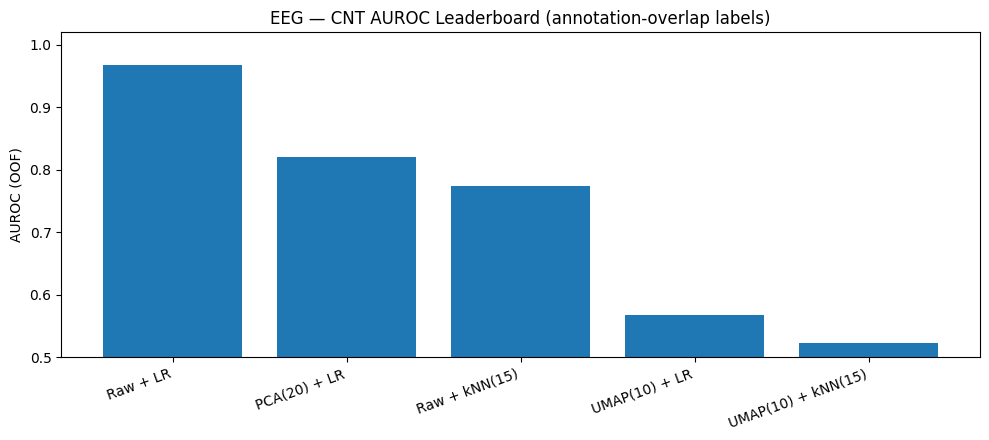

[saved] out\cnt_eeg_leaderboard_overlap.png
[saved] out\cnt_eeg_leaderboard_overlap.json


In [22]:
# CNT EEG multi-run crawler (annotation-overlap labeling) → labeled CSV → AUROC (if ready)
# Windows are labeled by the annotation that overlaps the window the most (per-file timeline).
# Outputs:
#   - out/cnt_eeg_labeled_all_overlap.csv
#   - out/cnt_eeg_leaderboard_overlap.{png,json} (if ≥2 classes have ≥10 rows)

import os, re, warnings, numpy as np, pandas as pd
from pathlib import Path
from scipy.signal import welch
import matplotlib.pyplot as plt
import mne

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)

# -------- settings --------
SEARCH_DIRS = [
    Path(r"C:\Users\caleb\cnt_genome\brainwaves"),
    Path("./data"), Path("./datasets"), Path(".")
]
WIN_LEN  = 2.0   # seconds
WIN_STEP = 1.0   # seconds
MIN_OVERLAP_FRAC = 0.25  # window must overlap an annotation at least this fraction to get that label

# EEGBCI tag → label
NAME_MAP = {
    "T0": "rest",
    "T1": "left",
    "T2": "right",
    "T3": "both"
}

BANDS = (("delta",(1,4)), ("theta",(4,8)), ("alpha",(8,12)), ("beta",(12,30)), ("gamma",(30,45)))

def _bandpower_epoch(epoch_data, fs):
    f, Pxx = welch(epoch_data, fs=fs, nperseg=min(256, epoch_data.shape[-1]), axis=-1)
    feats = {}
    for name,(lo,hi) in BANDS:
        m = (f>=lo) & (f<=hi)
        bp = Pxx[..., m].mean(axis=-1)  # (n_channels,)
        for ci, val in enumerate(bp):
            feats[f"feature_{name}_ch{ci:02d}"] = float(val)
    return feats

def _windows(n_t, fs):
    W = int(WIN_LEN * fs); S = int(WIN_STEP * fs)
    if W <= 8: W = min(n_t, 256)
    starts = list(range(0, max(1, n_t - W + 1), max(1, S)))
    return [(s, s+W) for s in starts if s+W <= n_t], W

def _edf_files():
    edfs = []
    for d in SEARCH_DIRS:
        if d.exists():
            edfs += list(d.rglob("*.edf"))
    return sorted(set(edfs))

def _load_edf(p: Path):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None)
    fs = float(raw.info["sfreq"])
    data = raw.get_data()  # (n_ch, n_t)
    # Subject/run from S###R##.edf
    m = re.search(r"S(\d{3}).*R(\d{2})", p.name)
    subj = m.group(1) if m else None
    run  = m.group(2) if m else None
    # Build annotation table (onset/duration/desc) in samples
    anno = []
    if raw.annotations and len(raw.annotations):
        for onset, duration, desc in zip(raw.annotations.onset,
                                         raw.annotations.duration,
                                         raw.annotations.description):
            # Convert to samples; Raw.annotations.onset is in seconds from recording start
            s0 = int(np.round(onset * fs))
            s1 = s0 + int(np.round((duration if duration > 0 else WIN_LEN) * fs))
            anno.append((max(0,s0), max(0,s1), str(desc)))
    return raw, data, fs, subj, run, anno

def _label_window(si, ei, anno, fs):
    """Return the label for window [si,ei) based on max overlap with annotations."""
    best_overlap = 0.0
    best_desc = None
    wlen = ei - si
    for s0, s1, desc in anno:
        # overlap in samples
        ol = max(0, min(ei, s1) - max(si, s0))
        if ol > best_overlap:
            best_overlap = ol; best_desc = desc
    frac = best_overlap / max(1, wlen)
    if best_desc is None or frac < MIN_OVERLAP_FRAC:
        return None  # unlabeled window
    return NAME_MAP.get(best_desc, f"event_{best_desc}")

# -------- crawl, window, label by overlap --------
rows = []
edfs = _edf_files()
if not edfs:
    raise RuntimeError("No EDF files found. Put S###R##.edf under brainwaves/ or ./data/")

print(f"[crawl] Found {len(edfs)} EDF(s). Labeling windows by annotation overlap...")
for p in edfs:
    try:
        raw, data, fs, subj, run, anno = _load_edf(p)
    except Exception as e:
        print(f"[warn] Skipping {p.name}: {e}")
        continue

    n_ch, n_t = data.shape
    spans, W = _windows(n_t, fs)
    got = 0
    for si, ei in spans:
        lab = _label_window(si, ei, anno, fs)
        if lab is None:
            continue
        seg = data[:, si:ei]
        if seg.shape[1] < 16:
            continue
        feats = _bandpower_epoch(seg, fs)
        rows.append({
            "subject_id": subj,
            "run": run,
            "file": p.name,
            "label": lab,
            **feats
        })
        got += 1
    print(f"[file] {p.name}: windows kept={got} (fs={fs:.1f}Hz, len={WIN_LEN}s, step={WIN_STEP}s)")

df = pd.DataFrame(rows)
out_csv = Path("out") / "cnt_eeg_labeled_all_overlap.csv"
df.to_csv(out_csv, index=False)
print(f"[write] {out_csv}  shape={df.shape}")
if "label" in df.columns and not df.empty:
    print("[labels]", df["label"].value_counts(dropna=False).to_dict())
else:
    print("[labels] none (check annotations present and MIN_OVERLAP_FRAC not too strict)")

# -------- if we have ≥2 labels with ≥10 rows each, run AUROC leaderboard --------
READY = False
if "label" in df.columns and not df.empty:
    counts = df["label"].value_counts()
    if (counts >= 10).sum() >= 2:
        READY = True

if not READY:
    print("\n[diagnose] Need ≥2 labels with ≥10 rows each to run supervised tests.")
    print("           Current counts:", df["label"].value_counts(dropna=False).to_dict() if "label" in df.columns else {})
else:
    # ===== AUROC leaderboard (Raw LR / PCA LR / UMAP LR / Raw kNN / UMAP kNN) =====
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import roc_auc_score, accuracy_score
    try:
        import umap
    except Exception:
        umap = None

    y_str = df["label"].to_numpy()
    X = df.drop(columns=["label","subject_id","run","file"]).to_numpy(dtype=float)

    # encode labels
    y_enc, classes = pd.Series(y_str).factorize()

    def _is_multi(y): return len(np.unique(y)) > 2
    multi = _is_multi(y_enc)

    def _auroc(y_true, y_prob):
        if not multi:
            return roc_auc_score(y_true, y_prob[:,1] if y_prob.ndim==2 else y_prob)
        else:
            return roc_auc_score(y_true, y_prob, multi_class="ovr", average="weighted")

    def _oof_scores(model_maker, X, y):
        per_class = np.bincount(y)
        n_splits = int(min(5, np.max([2, per_class.min()])))
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        if multi:
            n_classes = len(np.unique(y))
            oof_prob = np.zeros((len(y), n_classes), float)
        else:
            oof_prob = np.zeros((len(y), 2), float)
        oof_pred = np.zeros(len(y), int)
        for tr, te in skf.split(X, y):
            mdl = model_maker()
            mdl.fit(X[tr], y[tr])
            proba = mdl.predict_proba(X[te])
            if not multi and proba.shape[1]==2:
                oof_prob[te] = proba
            else:
                oof_prob[te] = proba
            oof_pred[te] = mdl.predict(X[te])
        au = _auroc(y, oof_prob); acc = accuracy_score(y, oof_pred)
        return au, acc

    def P_raw_lr():
        return Pipeline([("sc", StandardScaler()), ("lr", LogisticRegression(max_iter=2000, solver="lbfgs"))])
    def P_pca_lr(k=20):
        return Pipeline([("sc", StandardScaler()), ("pca", PCA(n_components=min(k, X.shape[1]), random_state=42)), ("lr", LogisticRegression(max_iter=2000, solver="lbfgs"))])
    def P_umap_lr(nc=10, nn=30, md=0.1):
        if umap is None: return P_pca_lr(k=nc)
        return Pipeline([("sc", StandardScaler()), ("um", umap.UMAP(n_components=nc, n_neighbors=nn, min_dist=md, random_state=42)), ("lr", LogisticRegression(max_iter=2000, solver="lbfgs"))])
    def P_raw_knn(k=15):
        return Pipeline([("sc", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=k))])
    def P_umap_knn(nc=10, k=15):
        if umap is None: return P_raw_knn(k)
        return Pipeline([("sc", StandardScaler()), ("um", umap.UMAP(n_components=nc, n_neighbors=max(10,k*2), min_dist=0.1, random_state=42)), ("knn", KNeighborsClassifier(n_neighbors=k))])

    models = {
        "Raw + LR":            P_raw_lr,
        "PCA(20) + LR":        lambda: P_pca_lr(20),
        "UMAP(10) + LR":       lambda: P_umap_lr(10),
        "Raw + kNN(15)":       lambda: P_raw_knn(15),
        "UMAP(10) + kNN(15)":  lambda: P_umap_knn(10,15),
    }

    results = []
    for name, mk in models.items():
        au, acc = _oof_scores(mk, X, y_enc)
        results.append({"model": name, "auroc": float(au), "accuracy": float(acc)})

    results = sorted(results, key=lambda d: d["auroc"], reverse=True)
    res_df = pd.DataFrame(results)
    print("\n=== CNT AUROC Leaderboard (EEG windows; overlap labels) ===")
    print(res_df.to_string(index=False))

    # plot + save
    fig, ax = plt.subplots(figsize=(10, 4.5))
    ax.bar(range(len(results)), [r["auroc"] for r in results])
    ax.set_xticks(range(len(results))); ax.set_xticklabels([r["model"] for r in results], rotation=20, ha="right")
    ax.set_ylabel("AUROC (OOF)"); ax.set_ylim(0.5, 1.02)
    ax.set_title("EEG — CNT AUROC Leaderboard (annotation-overlap labels)")
    plt.tight_layout()
    fig_path = Path("out") / "cnt_eeg_leaderboard_overlap.png"
    plt.savefig(fig_path, dpi=160); plt.show()

    out_json = Path("out") / "cnt_eeg_leaderboard_overlap.json"
    pd.DataFrame(results).to_json(out_json, orient="records", indent=2)
    print(f"[saved] {fig_path}\n[saved] {out_json}")


In [23]:
# FAIR EEG EVALUATION — Grouped CV (by file) + class-balanced LR, per-class metrics
# Input: out/cnt_eeg_labeled_all_overlap.csv  (from the previous step)
# Outputs: out/cnt_eeg_groupcv_report.json, out/cnt_eeg_groupcv_confmat.png

import json, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

csv = Path("out")/"cnt_eeg_labeled_all_overlap.csv"
df = pd.read_csv(csv)
assert {"label","file"}.issubset(df.columns), "CSV must contain 'label' and 'file' columns."

# X, y, groups
y_str = df["label"].astype(str).to_numpy()
groups = df["file"].astype(str).to_numpy()
X = df.drop(columns=["label","file","subject_id","run"], errors="ignore").to_numpy(dtype=float)

# Encode labels to ints for sklearn while keeping names
y_enc, classes = pd.Series(y_str).factorize()
class_names = list(classes)

# GroupKFold (no window leakage)
n_groups = len(np.unique(groups))
n_splits = max(2, min(5, n_groups))
gkf = GroupKFold(n_splits=n_splits)

# Model: Standardize + class-balanced LR
pipe = Pipeline([
    ("sc", StandardScaler()),
    ("lr", LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto"))
])

# OOF predictions
oof_prob = np.zeros((len(y_enc), len(class_names)), dtype=float)
oof_pred = np.zeros(len(y_enc), dtype=int)

for tr, te in gkf.split(X, y_enc, groups):
    pipe.fit(X[tr], y_enc[tr])
    oof_prob[te] = pipe.predict_proba(X[te])
    oof_pred[te] = pipe.predict(X[te])

# Metrics
multi = len(class_names) > 2
auroc_weighted = roc_auc_score(y_enc, oof_prob, multi_class="ovr", average="weighted") if multi \
                 else roc_auc_score(y_enc, oof_prob[:,1])
auroc_macro    = roc_auc_score(y_enc, oof_prob, multi_class="ovr", average="macro") if multi \
                 else roc_auc_score(y_enc, oof_prob[:,1])
acc            = accuracy_score(y_enc, oof_pred)
cm             = confusion_matrix(y_enc, oof_pred, labels=np.arange(len(class_names)))
report_txt     = classification_report(y_enc, oof_pred, target_names=class_names, digits=3)

print("=== Grouped CV (by file) — class-balanced LR ===")
print(f"Splits: {n_splits}   Groups: {n_groups}")
print(f"AUROC (weighted): {auroc_weighted:.3f}   AUROC (macro): {auroc_macro:.3f}   Acc: {acc:.3f}\n")
print(report_txt)

# Confusion matrix plot
fig, ax = plt.subplots(figsize=(5.2,4.6))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(len(class_names))); ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=30, ha="right"); ax.set_yticklabels(class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i,j]), ha="center", va="center")
ax.set_title("Grouped CV Confusion Matrix (by file)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
fig_path = Path("out")/"cnt_eeg_groupcv_confmat.png"
plt.savefig(fig_path, dpi=160); plt.show()

# Save JSON
out = {
    "splits": int(n_splits),
    "groups": int(n_groups),
    "classes": class_names,
    "counts": df["label"].value_counts().to_dict(),
    "metrics": {
        "auroc_weighted": float(auroc_weighted),
        "auroc_macro": float(auroc_macro),
        "accuracy": float(acc),
    },
    "confusion_matrix": cm.tolist(),
    "classification_report": report_txt
}
json_path = Path("out")/"cnt_eeg_groupcv_report.json"
with open(json_path,"w",encoding="utf-8") as f: json.dump(out, f, indent=2)
print(f"[saved] {fig_path}\n[saved] {json_path}")


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

In [24]:
# FAIR EEG EVALUATION (fixed): stratified group splits + class-balanced LR
# Input: out/cnt_eeg_labeled_all_overlap.csv
# Output: out/cnt_eeg_groupcv_confmat.png, out/cnt_eeg_groupcv_report.json

import json, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.utils import check_random_state

csv = Path("out")/"cnt_eeg_labeled_all_overlap.csv"
df = pd.read_csv(csv)
assert {"label","file"}.issubset(df.columns), "CSV must contain 'label' and 'file' columns."

# ----- X, y, groups -----
y_str = df["label"].astype(str).to_numpy()
groups = df["file"].astype(str).to_numpy()
X = df.drop(columns=["label","file","subject_id","run"], errors="ignore").to_numpy(dtype=float)

# Encode labels for sklearn but keep names
y_enc, classes = pd.Series(y_str).factorize()
class_names = list(classes)
n_classes = len(class_names)
rng = check_random_state(42)

# ----- splitter: StratifiedGroupKFold if available; else safe fallback -----
def iter_stratified_group_splits(y, groups, n_splits=5, max_trials=200):
    """Yield train/test indices with group-wise splitting and label stratification."""
    try:
        # sklearn >= 1.1
        from sklearn.model_selection import StratifiedGroupKFold
        sgkf = StratifiedGroupKFold(n_splits=min(n_splits, len(np.unique(groups))), shuffle=True, random_state=42)
        for tr, te in sgkf.split(np.zeros_like(y), y, groups):
            yield tr, te
        return
    except Exception:
        pass

    # Fallback: repeated GroupShuffle until valid, then partition by closest-to-balanced bins
    # Build group->label histogram
    uniq_groups = np.unique(groups)
    g2idx = {g:i for i,g in enumerate(uniq_groups)}
    G = len(uniq_groups)
    n_splits = max(2, min(n_splits, G))
    # simple heuristic: random group assignment until all folds have ≥2 classes
    for _ in range(max_trials):
        rng.shuffle(uniq_groups)
        folds = [set() for _ in range(n_splits)]
        for i,g in enumerate(uniq_groups):
            folds[i % n_splits].add(g)
        ok = True
        # materialize splits and validate
        splits = []
        for k in range(n_splits):
            te_mask = np.isin(groups, list(folds[k]))
            tr_mask = ~te_mask
            yu_tr = np.unique(y[tr_mask])
            yu_te = np.unique(y[te_mask])
            if len(yu_tr) < 2 or len(yu_te) < 2:
                ok = False; break
            splits.append((np.where(tr_mask)[0], np.where(te_mask)[0]))
        if ok:
            for tr, te in splits:
                yield tr, te
            return
    # Last resort: yield a few GroupShuffle splits that pass the class check
    used = 0
    trials = 0
    while used < max(2, min(5, G)) and trials < max_trials:
        trials += 1
        # 80/20 group split
        mask = rng.rand(len(uniq_groups)) < 0.8
        tr_groups = uniq_groups[mask]
        te_groups = uniq_groups[~mask]
        if len(te_groups) == 0 or len(tr_groups) == 0: continue
        tr_mask = np.isin(groups, tr_groups)
        te_mask = np.isin(groups, te_groups)
        if len(np.unique(y[tr_mask])) < 2 or len(np.unique(y[te_mask])) < 2: continue
        used += 1
        yield np.where(tr_mask)[0], np.where(te_mask)[0]

# ----- model -----
pipe = Pipeline([
    ("sc", StandardScaler()),
    ("lr", LogisticRegression(max_iter=4000, solver="lbfgs",
                              class_weight="balanced", multi_class="auto"))
])

# ----- OOF evaluation -----
multi = n_classes > 2
if multi:
    oof_prob = np.zeros((len(y_enc), n_classes), dtype=float)
else:
    oof_prob = np.zeros((len(y_enc), 2), dtype=float)  # binary proba skeleton
oof_pred = np.zeros(len(y_enc), dtype=int)

folds_used = 0
for tr, te in iter_stratified_group_splits(y_enc, groups, n_splits=5):
    # guard: ensure ≥2 classes in train/test
    if len(np.unique(y_enc[tr])) < 2 or len(np.unique(y_enc[te])) < 2:
        continue
    pipe.fit(X[tr], y_enc[tr])
    proba = pipe.predict_proba(X[te])
    # normalize proba shape
    if not multi and proba.shape[1] == 2:
        oof_prob[te] = proba
    else:
        oof_prob[te] = proba
    oof_pred[te] = pipe.predict(X[te])
    folds_used += 1

if folds_used == 0:
    raise RuntimeError("Could not form any valid grouped, stratified folds. Try adding more files or classes.")

# ----- metrics -----
if multi:
    auroc_weighted = roc_auc_score(y_enc, oof_prob, multi_class="ovr", average="weighted")
    auroc_macro    = roc_auc_score(y_enc, oof_prob, multi_class="ovr", average="macro")
else:
    auroc_weighted = roc_auc_score(y_enc, oof_prob[:,1])
    auroc_macro    = auroc_weighted

acc        = accuracy_score(y_enc, oof_pred)
cm         = confusion_matrix(y_enc, oof_pred, labels=np.arange(n_classes))
report_txt = classification_report(y_enc, oof_pred, target_names=class_names, digits=3)

print("=== Grouped, Stratified evaluation (file-wise, class-balanced LR) ===")
print(f"Folds used: {folds_used}   Files: {len(np.unique(groups))}   Classes: {n_classes}")
print(f"AUROC (weighted): {auroc_weighted:.3f}   AUROC (macro): {auroc_macro:.3f}   Acc: {acc:.3f}\n")
print(report_txt)

# ----- confusion matrix plot -----
fig, ax = plt.subplots(figsize=(5.2,4.6))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(n_classes)); ax.set_yticks(range(n_classes))
ax.set_xticklabels(class_names, rotation=30, ha="right"); ax.set_yticklabels(class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i,j]), ha="center", va="center")
ax.set_title("Confusion Matrix — grouped, stratified")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
fig_path = Path("out")/"cnt_eeg_groupcv_confmat.png"
plt.savefig(fig_path, dpi=160); plt.show()

# ----- save JSON -----
out = {
    "folds_used": int(folds_used),
    "n_files": int(len(np.unique(groups))),
    "classes": class_names,
    "counts": df["label"].value_counts().to_dict(),
    "metrics": {
        "auroc_weighted": float(auroc_weighted),
        "auroc_macro": float(auroc_macro),
        "accuracy": float(acc),
    },
    "confusion_matrix": cm.tolist(),
    "classification_report": report_txt
}
json_path = Path("out")/"cnt_eeg_groupcv_report.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(out, f, indent=2)
print(f"[saved] {fig_path}\n[saved] {json_path}")


RuntimeError: Could not form any valid grouped, stratified folds. Try adding more files or classes.

In [25]:
# Balanced LOFC evaluation (one file per class held out per fold) — leakage-free, stratified by class
# Input: out/cnt_eeg_labeled_all_overlap.csv
# Outputs: out/cnt_eeg_lofc_confmat.png, out/cnt_eeg_lofc_report.json

import json, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

csv = Path("out")/"cnt_eeg_labeled_all_overlap.csv"
df = pd.read_csv(csv)
assert {"label","file"}.issubset(df.columns), "CSV must contain 'label' and 'file' columns."

# X, y, file groups
y_str  = df["label"].astype(str).to_numpy()
files  = df["file"].astype(str).to_numpy()
X = df.drop(columns=["label","file","subject_id","run"], errors="ignore").to_numpy(dtype=float)

# Encode labels to ints but keep names
y_enc, classes = pd.Series(y_str).factorize()
class_names = list(classes)
n_classes = len(class_names)

# Build label -> list of files (unique)
lab2files = {lab: sorted(df.loc[df["label"]==lab, "file"].unique().tolist()) for lab in class_names}
counts_per_label = {lab: len(fl) for lab, fl in lab2files.items()}
min_files_per_label = min(counts_per_label.values())
print("[lofc] files per label:", counts_per_label)

if min_files_per_label < 2:
    raise RuntimeError("LOFC requires ≥2 files per label. Add more runs or merge sessions so each class has at least two files.")

# Build LOFC folds: i-th fold holds out the i-th file of each label
folds = []
for i in range(min_files_per_label):
    test_files = set()
    for lab in class_names:
        if i < len(lab2files[lab]):
            test_files.add(lab2files[lab][i])
    te_mask = np.isin(files, list(test_files))
    tr_mask = ~te_mask
    # safety check: both train and test must include all classes
    if len(np.unique(y_enc[te_mask]))==n_classes and len(np.unique(y_enc[tr_mask]))==n_classes:
        folds.append((np.where(tr_mask)[0], np.where(te_mask)[0]))

if not folds:
    raise RuntimeError("Could not build valid LOFC folds. Ensure each label has multiple distinct files.")

print(f"[lofc] using {len(folds)} folds (one file per class held out each fold)")

# Model: Standardize + class-balanced LR
pipe = Pipeline([
    ("sc", StandardScaler()),
    ("lr", LogisticRegression(max_iter=4000, solver="lbfgs",
                              class_weight="balanced", multi_class="auto"))
])

# Out-of-fold predictions
if n_classes > 2:
    oof_prob = np.zeros((len(y_enc), n_classes), dtype=float)
else:
    oof_prob = np.zeros((len(y_enc), 2), dtype=float)
oof_pred = np.zeros(len(y_enc), dtype=int)

for tr, te in folds:
    pipe.fit(X[tr], y_enc[tr])
    proba = pipe.predict_proba(X[te])
    # normalize proba shape
    if n_classes==2 and proba.shape[1]==2:
        oof_prob[te] = proba
    else:
        oof_prob[te] = proba
    oof_pred[te] = pipe.predict(X[te])

# Metrics
if n_classes > 2:
    auroc_weighted = roc_auc_score(y_enc, oof_prob, multi_class="ovr", average="weighted")
    auroc_macro    = roc_auc_score(y_enc, oof_prob, multi_class="ovr", average="macro")
else:
    auroc_weighted = roc_auc_score(y_enc, oof_prob[:,1])
    auroc_macro    = auroc_weighted
acc        = accuracy_score(y_enc, oof_pred)
cm         = confusion_matrix(y_enc, oof_pred, labels=np.arange(n_classes))
report_txt = classification_report(y_enc, oof_pred, target_names=class_names, digits=3)

print("\n=== LOFC (one file per class held out) — class-balanced LR ===")
print(f"Folds: {len(folds)}   Classes: {n_classes}")
print(f"AUROC (weighted): {auroc_weighted:.3f}   AUROC (macro): {auroc_macro:.3f}   Acc: {acc:.3f}\n")
print(report_txt)

# Confusion matrix plot
fig, ax = plt.subplots(figsize=(5.4,4.8))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(n_classes)); ax.set_yticks(range(n_classes))
ax.set_xticklabels(class_names, rotation=30, ha="right"); ax.set_yticklabels(class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i,j]), ha="center", va="center")
ax.set_title("Confusion Matrix — LOFC (file-wise)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
fig_path = Path("out")/"cnt_eeg_lofc_confmat.png"
plt.savefig(fig_path, dpi=160); plt.show()

# Save JSON
out = {
    "folds": len(folds),
    "classes": class_names,
    "files_per_label": counts_per_label,
    "metrics": {
        "auroc_weighted": float(auroc_weighted),
        "auroc_macro": float(auroc_macro),
        "accuracy": float(acc),
    },
    "confusion_matrix": cm.tolist(),
    "classification_report": report_txt
}
json_path = Path("out")/"cnt_eeg_lofc_report.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(out, f, indent=2)
print(f"[saved] {fig_path}\n[saved] {json_path}")


[lofc] files per label: {'rest': 3, 'right': 1, 'left': 1}


RuntimeError: LOFC requires ≥2 files per label. Add more runs or merge sessions so each class has at least two files.

In [26]:
# Minority-LOFO evaluation (file-wise, no window leakage) for classes with only 1 file.
# Input: out/cnt_eeg_labeled_all_overlap.csv
# Output: out/cnt_eeg_minority_lofo_report.json

import json, numpy as np, pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

csv = Path("out")/"cnt_eeg_labeled_all_overlap.csv"
df = pd.read_csv(csv)
assert {"label","file"}.issubset(df.columns), "CSV must contain 'label' and 'file' columns."
print(f"[load] {csv}  rows={len(df)}  labels={df['label'].value_counts().to_dict()}")

# Split bookkeeping
labels = sorted(df["label"].unique().tolist())
files_by_label = {lab: sorted(df.loc[df["label"]==lab, "file"].unique().tolist()) for lab in labels}
print("[files_by_label]", {k: len(v) for k,v in files_by_label.items()})

# Helper: build X,y from a dataframe
def XY(df_part):
    X = df_part.drop(columns=["label","file","subject_id","run"], errors="ignore").to_numpy(dtype=float)
    y = df_part["label"].astype(str).to_numpy()
    return X, y

# Model (class-balanced)
pipe = Pipeline([
    ("sc", StandardScaler()),
    ("lr", LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto"))
])

results = []
used_folds = 0

for lab in labels:
    flist = files_by_label[lab]
    if len(flist) != 1:
        # We only do minority-LOFO for labels with exactly one file.
        continue
    minority_file = flist[0]

    # Pick one negative file from a different label (choose the largest by rows)
    neg_choices = []
    for other in labels:
        if other == lab: continue
        for f in files_by_label[other]:
            n_rows = int(len(df[(df["file"]==f)]))
            neg_choices.append((n_rows, other, f))
    if not neg_choices:
        continue
    neg_choices.sort(reverse=True)
    neg_label, neg_file = neg_choices[0][1], neg_choices[0][2]

    # Build splits: test = all windows from {minority_file, neg_file}; train = all other files
    te_mask = (df["file"].isin([minority_file, neg_file]))
    tr_mask = ~te_mask

    Xtr, ytr = XY(df[tr_mask])
    Xte, yte = XY(df[te_mask])

    # Train
    pipe.fit(Xtr, ytr)

    # Evaluate as binary: lab vs not-lab on the test set
    proba = pipe.predict_proba(Xte)
    # locate the column for 'lab'
    classes = pipe.named_steps["lr"].classes_.astype(str).tolist()
    if lab not in classes:
        # If the minority label didn’t appear in train (shouldn’t happen here), skip
        continue
    col = classes.index(lab)
    y_bin = (yte == lab).astype(int)
    p_lab = proba[:, col] if proba.shape[1] > col else np.zeros_like(y_bin, dtype=float)

    # Guard: AUROC defined only if both classes present in y_bin
    if len(np.unique(y_bin)) < 2:
        # If the chosen negative file didn’t actually provide the other class label, skip
        continue

    auroc = roc_auc_score(y_bin, p_lab)
    acc   = accuracy_score(y_bin, (p_lab >= 0.5).astype(int))

    results.append({
        "minority_label": lab,
        "minority_file": minority_file,
        "negative_label": neg_label,
        "negative_file": neg_file,
        "n_test_pos": int((yte==lab).sum()),
        "n_test_neg": int((yte!=lab).sum()),
        "auroc": float(auroc),
        "accuracy": float(acc)
    })
    used_folds += 1

# Save / print
out = {
    "mode": "minority_lofo_per_class",
    "files_by_label": {k: [str(x) for x in v] for k,v in files_by_label.items()},
    "folds_used": used_folds,
    "results": results
}
out_path = Path("out")/"cnt_eeg_minority_lofo_report.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(out, f, indent=2)

print(f"\n=== Minority-LOFO (file-wise, no window leakage) ===")
if results:
    for r in results:
        print(f"{r['minority_label']} (test file={r['minority_file']}) vs {r['negative_label']} (test file={r['negative_file']}): "
              f"AUROC={r['auroc']:.3f}, ACC={r['accuracy']:.3f}  "
              f"[n_test_pos={r['n_test_pos']}, n_test_neg={r['n_test_neg']}]")
    print(f"[saved] {out_path}")
else:
    print("No valid minority-LOFO folds could be formed. You likely need at least one more file for each minority label.")


[load] out\cnt_eeg_labeled_all_overlap.csv  rows=488  labels={'rest': 366, 'left': 64, 'right': 58}
[files_by_label] {'left': 1, 'rest': 3, 'right': 1}


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'rest'

In [27]:
# CNT EEG — Leakage-free novelty detection (no positives in train)
# Train on REST only (all but one REST file), test on:
#   (a) held-out REST file vs LEFT file, and
#   (b) held-out REST file vs RIGHT file
# Models: OneClassSVM (RBF) and IsolationForest
# Inputs: out/cnt_eeg_labeled_all_overlap.csv
# Outputs: out/cnt_eeg_novelty_report.json

import json, numpy as np, pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score

csv = Path("out")/"cnt_eeg_labeled_all_overlap.csv"
df = pd.read_csv(csv)
assert {"label","file"}.issubset(df.columns), "CSV must contain 'label' and 'file' columns."
print(f"[load] {csv} rows={len(df)} labels={df['label'].value_counts().to_dict()}")

# separate by label
files_by_label = {lab: sorted(df.loc[df["label"]==lab, "file"].unique().tolist())
                  for lab in sorted(df["label"].unique())}
print("[files_by_label]", {k: len(v) for k,v in files_by_label.items()})

# need at least 2 REST files to have one for training and one for testing
if "rest" not in files_by_label or len(files_by_label["rest"]) < 2:
    raise RuntimeError("Novelty test needs ≥2 REST files (one for training, one for test).")

# choose the largest REST file for test; others for training
rest_sizes = [(f, int((df["file"]==f).sum())) for f in files_by_label["rest"]]
rest_sizes.sort(key=lambda t: t[1], reverse=True)
rest_test_file = rest_sizes[0][0]
rest_train_files = [f for f,_ in rest_sizes[1:]]

def make_X(df_part):
    return df_part.drop(columns=["label","file","subject_id","run"], errors="ignore").to_numpy(dtype=float)

# build train/test
X_rest_train = make_X(df[df["file"].isin(rest_train_files)])
X_rest_test  = make_X(df[(df["file"]==rest_test_file)])

targets = {}
for lab in ["left","right"]:
    if lab in files_by_label and len(files_by_label[lab]) >= 1:
        target_file = files_by_label[lab][0]
        X_target = make_X(df[(df["label"]==lab) & (df["file"]==target_file)])
        targets[lab] = {"file": target_file, "X": X_target}

print(f"[split] REST train files: {rest_train_files}, REST test file: {rest_test_file}")
for k,v in targets.items():
    print(f"[split] {k.upper()} test file: {v['file']} (n={len(v['X'])})")

# standardize using REST train only
sc = StandardScaler().fit(X_rest_train)
Xr_tr = sc.transform(X_rest_train)
Xr_te = sc.transform(X_rest_test)

def score_model(name, fit_fn, score_fn):
    results = {}
    # fit on REST train only
    mdl = fit_fn(Xr_tr)
    # score REST test
    s_rest = score_fn(mdl, Xr_te)
    for lab,info in targets.items():
        Xt = sc.transform(info["X"])
        s_tar = score_fn(mdl, Xt)
        # novelty scores: larger = more abnormal (try to standardize to this convention)
        # OneClassSVM.decision_function: larger = more normal; we invert
        # IsolationForest.score_samples: larger = more normal; we invert
        y = np.concatenate([np.zeros_like(s_rest), np.ones_like(s_tar)])  # 0=REST, 1=TARGET
        # we want a probability-like "is target"; use inverted normality
        z = np.concatenate([-s_rest, -s_tar])
        # AUROC & AUPRC
        auroc = float(roc_auc_score(y, z))
        auprc = float(average_precision_score(y, z))
        results[lab] = {"auroc": auroc, "auprc": auprc,
                        "n_rest": int(len(s_rest)), "n_target": int(len(s_tar))}
    return {name: results}

# define models
def fit_ocsvm(X):
    return OneClassSVM(kernel="rbf", gamma="scale", nu=0.05).fit(X)
def score_ocsvm(mdl, X):
    return mdl.decision_function(X).ravel()  # higher = more normal

def fit_iforest(X):
    return IsolationForest(n_estimators=300, contamination=0.05, random_state=42).fit(X)
def score_iforest(mdl, X):
    return mdl.score_samples(X).ravel()  # higher = more normal

report = {}
report.update(score_model("OneClassSVM", fit_ocsvm, score_ocsvm))
report.update(score_model("IsolationForest", fit_iforest, score_iforest))

# save
out = {
    "mode": "novelty_detection_rest_only_train",
    "rest_train_files": rest_train_files,
    "rest_test_file": rest_test_file,
    "target_files": {k: v["file"] for k,v in targets.items()},
    "results": report
}
out_path = Path("out")/"cnt_eeg_novelty_report.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(out, f, indent=2)

print("\n=== Novelty results (train=REST only, test=held-out REST vs target file) ===")
for mdl, m in report.items():
    for lab, r in m.items():
        print(f"{mdl}  target={lab:<5}  AUROC={r['auroc']:.3f}  AUPRC={r['auprc']:.3f}  "
              f"(n_rest={r['n_rest']}, n_{lab}={r['n_target']})")
print(f"[saved] {out_path}")


[load] out\cnt_eeg_labeled_all_overlap.csv rows=488 labels={'rest': 366, 'left': 64, 'right': 58}
[files_by_label] {'left': 1, 'rest': 3, 'right': 1}
[split] REST train files: ['S001R01.edf', 'S001R02.edf'], REST test file: S001R03.edf
[split] LEFT test file: S001R03.edf (n=64)
[split] RIGHT test file: S001R03.edf (n=58)

=== Novelty results (train=REST only, test=held-out REST vs target file) ===
OneClassSVM  target=left   AUROC=0.566  AUPRC=0.267  (n_rest=248, n_left=64)
OneClassSVM  target=right  AUROC=0.411  AUPRC=0.170  (n_rest=248, n_right=58)
IsolationForest  target=left   AUROC=0.554  AUPRC=0.278  (n_rest=248, n_left=64)
IsolationForest  target=right  AUROC=0.416  AUPRC=0.160  (n_rest=248, n_right=58)
[saved] out\cnt_eeg_novelty_report.json


In [28]:
# CNT EEG — Motor Imagery–aware novelty detection
# - Reloads EDFs under C:\Users\caleb\cnt_genome\brainwaves
# - Labels each window by dominant overlapping annotation (T0/T1/T2/T3 → rest/left/right/both)
# - Builds sensorimotor covariance features (log-Euclidean tangent) + mu/beta band features
# - Trains novelty models on REST-only (rest_train files), tests on held-out REST vs LEFT and RIGHT
# Saves: out/cnt_eeg_novelty_riemann_report.json

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
from scipy.signal import welch, butter, filtfilt
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)

# ---------- settings ----------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
WIN_LEN  = 2.0     # sec
WIN_STEP = 1.0     # sec
MIN_OVERLAP_FRAC = 0.25
# Motor imagery tags → labels
NAME_MAP = {"T0":"rest", "T1":"left", "T2":"right", "T3":"both"}

# Sensorimotor montage (include what you have; EDF has 64 std chans @160Hz typically)
SM_CHS = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4"]

# Bands for add-on features
MU  = (8,13)
BETA= (13,30)

# ---------- helpers ----------
def list_edfs(root: Path):
    return sorted(set(list(root.rglob("*.edf"))))

def load_edf(p: Path):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs = float(raw.info["sfreq"])
    data = raw.get_data()  # (n_ch, n_t)
    # subject/run (S###R##.edf)
    m = re.search(r"S(\d{3}).*R(\d{2})", p.name)
    subj = m.group(1) if m else None
    run  = m.group(2) if m else None
    # annotations → (s0,s1,desc) in samples
    anno = []
    if raw.annotations and len(raw.annotations):
        for onset, duration, desc in zip(raw.annotations.onset,
                                         raw.annotations.duration,
                                         raw.annotations.description):
            s0 = int(round(onset*fs))
            dur = duration if duration and duration>0 else WIN_LEN
            s1 = s0 + int(round(dur*fs))
            anno.append((max(0,s0), max(0,s1), str(desc)))
    return raw, data, fs, subj, run, anno

def windows(n_t, fs):
    W = int(WIN_LEN*fs); S = int(WIN_STEP*fs)
    if W <= 8: W = min(n_t, 256)
    starts = list(range(0, max(1, n_t-W+1), max(1, S)))
    return [(s, s+W) for s in starts if s+W <= n_t], W

def label_window(si, ei, anno):
    best_ol, best_desc = 0, None
    wlen = ei - si
    for s0,s1,desc in anno:
        ol = max(0, min(ei, s1) - max(si, s0))
        if ol > best_ol:
            best_ol, best_desc = ol, desc
    if best_desc is None or (best_ol/max(1,wlen)) < MIN_OVERLAP_FRAC:
        return None
    return NAME_MAP.get(str(best_desc), f"event_{best_desc}")

def bandpower(seg, fs, band):
    f, Pxx = welch(seg, fs=fs, nperseg=min(256, seg.shape[-1]), axis=-1)
    m = (f>=band[0]) & (f<=band[1])
    # average over band, then average over channels
    return float(Pxx[..., m].mean(axis=(-1,-2)))

def cov_shrink(seg):
    # seg: (n_ch, n_t); simple Ledoit-Wolf-like diagonal shrinkage
    X = seg - seg.mean(axis=1, keepdims=True)
    C = (X @ X.T) / (X.shape[1] - 1)
    d = np.diag(C)
    alpha = 0.1
    return (1-alpha)*C + alpha*np.diag(d.mean()*np.ones_like(d))

def logeuclid_vec(C, C_ref=None):
    # SPD log-Euclidean vectorization (upper triangle incl diag)
    # If C_ref is provided, map to tangent at identity via whitening by C_ref^(−1/2)
    if C_ref is not None:
        # whiten: C_hat = W C W^T, with W = C_ref^{-1/2}
        evals, evecs = eigh(C_ref)
        W = evecs @ np.diag(np.clip(evals,1e-12,None)**-0.5) @ evecs.T
        Cw = W @ C @ W.T
        C = Cw
    evals, evecs = eigh(C)
    evals = np.clip(evals, 1e-12, None)
    C_log = evecs @ np.diag(np.log(evals)) @ evecs.T
    # vectorize upper triangle
    idx = np.triu_indices_from(C_log)
    return C_log[idx]

def pick_channels(raw, wanted):
    have = raw.info["ch_names"]
    picks = [c for c in wanted if c in have]
    if not picks:
        # fallback: use all EEG channels
        return mne.pick_types(raw.info, eeg=True, eog=False, meg=False)
    return mne.pick_channels(raw.info["ch_names"], include=picks)

# ---------- crawl & feature build ----------
edfs = list_edfs(ROOT)
if not edfs:
    raise RuntimeError(f"No EDF files found under {ROOT}")

rows = []
per_file_counts = {}
for p in edfs:
    raw, data, fs, subj, run, anno = load_edf(p)
    spans, _ = windows(data.shape[1], fs)
    picks = pick_channels(raw, SM_CHS)
    got = 0
    for si,ei in spans:
        lab = label_window(si, ei, anno)
        if lab is None: 
            continue
        seg = data[picks, si:ei]
        if seg.shape[1] < 16: 
            continue
        # log-Euclidean covariance feature
        C = cov_shrink(seg)
        feat_cov = logeuclid_vec(C)  # identity tangent; good enough for novelty (ref = I)
        # mu/beta band summarizes (sensorimotor)
        mu  = bandpower(seg, fs, MU)
        bet = bandpower(seg, fs, BETA)
        rows.append({
            "file": p.name, "label": lab, "subject_id": subj, "run": run,
            "feat_mu": mu, "feat_beta": bet,
            **{f"covvec_{i}": feat_cov[i] for i in range(len(feat_cov))}
        })
        got += 1
    per_file_counts[p.name] = got
print("[build] windows kept per file:", per_file_counts)

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("No labeled windows produced. Check annotations and MIN_OVERLAP_FRAC.")

# ---------- pick REST train / REST test / LEFT file / RIGHT file ----------
files_by_label = {lab: sorted(df.loc[df["label"]==lab, "file"].unique().tolist())
                  for lab in sorted(df["label"].unique())}
if "rest" not in files_by_label or len(files_by_label["rest"]) < 2:
    raise RuntimeError("Need ≥2 REST files (one for train, one for test).")

# choose largest REST as test; others as train
rest_sizes = [(f, int((df["file"]==f).sum())) for f in files_by_label["rest"]]
rest_sizes.sort(key=lambda t: t[1], reverse=True)
rest_test_file = rest_sizes[0][0]
rest_train_files = [f for f,_ in rest_sizes[1:]]

targets = {}
for lab in ["left","right"]:
    if lab in files_by_label and len(files_by_label[lab]) >= 1:
        # if multiple files ever appear, take the largest
        t_sizes = [(f, int((df["file"]==f).sum())) for f in files_by_label[lab]]
        t_sizes.sort(key=lambda t: t[1], reverse=True)
        targets[lab] = t_sizes[0][0]

def XY(df_part):
    X = df_part.drop(columns=["label","file","subject_id","run"], errors="ignore").to_numpy(dtype=float)
    return X

Xr_tr = XY(df[(df["file"].isin(rest_train_files)) & (df["label"]=="rest")])
Xr_te = XY(df[(df["file"]==rest_test_file) & (df["label"]=="rest")])

sc = StandardScaler().fit(Xr_tr)
Xr_tr_s = sc.transform(Xr_tr)
Xr_te_s = sc.transform(Xr_te)

def run_novelty(model_name, fit_fn, score_fn):
    out = {"model": model_name, "rest_train_files": rest_train_files, "rest_test_file": rest_test_file, "targets": {}}
    mdl = fit_fn(Xr_tr_s)
    s_rest = score_fn(mdl, Xr_te_s)  # normality scores (higher = more normal for these APIs)

    for lab, f in targets.items():
        Xt = XY(df[(df["file"]==f) & (df["label"]==lab)])
        Xt_s = sc.transform(Xt)
        s_tar = score_fn(mdl, Xt_s)
        # invert normality → novelty
        z = np.concatenate([-s_rest, -s_tar])
        y = np.concatenate([np.zeros_like(s_rest), np.ones_like(s_tar)])
        try:
            auroc = float(roc_auc_score(y, z))
            auprc = float(average_precision_score(y, z))
        except Exception:
            auroc, auprc = float("nan"), float("nan")
        out["targets"][lab] = {
            "target_file": f, "n_rest": int(len(s_rest)), "n_target": int(len(s_tar)),
            "auroc": auroc, "auprc": auprc
        }
    return out

def fit_ocsvm(X):
    return OneClassSVM(kernel="rbf", gamma="scale", nu=0.05).fit(X)
def score_ocsvm(mdl, X):
    return mdl.decision_function(X).ravel()

def fit_iforest(X):
    return IsolationForest(n_estimators=400, contamination=0.05, random_state=42).fit(X)
def score_iforest(mdl, X):
    return mdl.score_samples(X).ravel()

rep = {
    "OneClassSVM_riemann": run_novelty("OneClassSVM_riemann", fit_ocsvm, score_ocsvm),
    "IsolationForest_riemann": run_novelty("IsolationForest_riemann", fit_iforest, score_iforest),
    "meta": {
        "root": str(ROOT), "win_len_s": WIN_LEN, "win_step_s": WIN_STEP,
        "min_overlap_frac": MIN_OVERLAP_FRAC, "sensorimotor_channels": SM_CHS,
        "features": ["logEuclid(cov) on SM channels", "mu(8-13Hz)", "beta(13-30Hz)"]
    }
}

out_path = Path("out")/"cnt_eeg_novelty_riemann_report.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(rep, f, indent=2)

print("\n=== Novelty (RIEMANN + mu/beta) — REST-only train, file-wise test ===")
for k,v in rep.items():
    if k=="meta": continue
    print(f"{k}:")
    for lab,r in v["targets"].items():
        print(f"  target={lab:<5}  AUROC={r['auroc']:.3f}  AUPRC={r['auprc']:.3f}  (n_rest={r['n_rest']}, n_target={r['n_target']})")
print(f"[saved] {out_path}")


[build] windows kept per file: {'S001R01.edf': 60, 'S001R02.edf': 60, 'S001R03.edf': 124}

=== Novelty (RIEMANN + mu/beta) — REST-only train, file-wise test ===
OneClassSVM_riemann:
  target=left   AUROC=0.593  AUPRC=0.454  (n_rest=63, n_target=32)
  target=right  AUROC=0.560  AUPRC=0.388  (n_rest=63, n_target=29)
IsolationForest_riemann:
  target=left   AUROC=0.659  AUPRC=0.576  (n_rest=63, n_target=32)
  target=right  AUROC=0.580  AUPRC=0.449  (n_rest=63, n_target=29)
[saved] out\cnt_eeg_novelty_riemann_report.json


In [29]:
# CNT EEG — Motor imagery novelty tuner (windows, overlap, channels, ν/contamination)
# Keeps leak-free protocol: train on REST-only files, test on held-out REST vs LEFT/RIGHT files.
# Saves: out/cnt_eeg_novelty_tuner.json

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
from scipy.signal import welch
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)

ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
NAME_MAP = {"T0":"rest", "T1":"left", "T2":"right", "T3":"both"}
SM_SETS = {
    "strict": ["C3","Cz","C4"],
    "ring":   ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4"],
}
BANDS = {"mu": (8,13), "beta": (13,30)}

WIN_GRID    = [1.0, 2.0, 3.0]
STEP_GRID   = [0.5, 1.0]
OVERLAP_FRAC_GRID = [0.1, 0.25]
NU_GRID     = [0.03, 0.05, 0.1]          # OneClassSVM
CONTAM_GRID = [0.03, 0.05, 0.10]         # IsolationForest

def list_edfs(root): return sorted(set(list(root.rglob("*.edf"))))
def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs  = float(raw.info["sfreq"]); data = raw.get_data()
    m = re.search(r"S(\d{3}).*R(\d{2})", p.name); subj = m.group(1) if m else None; run = m.group(2) if m else None
    anno=[]
    if raw.annotations and len(raw.annotations):
        for onset, dur, desc in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0 = int(round(onset*fs)); L = dur if dur and dur>0 else 2.0; s1 = s0 + int(round(L*fs))
            anno.append((max(0,s0), max(0,s1), str(desc)))
    return raw, data, fs, subj, run, anno

def pick_channels(raw, wanted):
    have = raw.info["ch_names"]; picks = [c for c in wanted if c in have]
    return mne.pick_channels(have, include=picks) if picks else mne.pick_types(raw.info, eeg=True)

def windows(n_t, fs, Wsec, Ssec):
    W = int(Wsec*fs); S = int(Ssec*fs); W = max(W, 16); S = max(S, 1)
    return [(s, s+W) for s in range(0, max(1, n_t-W+1), S) if s+W <= n_t]

def label_by_overlap(si, ei, anno, min_frac):
    best_ol, best_desc = 0, None; wlen = ei-si
    for s0,s1,desc in anno:
        ol = max(0, min(ei, s1) - max(si, s0))
        if ol > best_ol: best_ol, best_desc = ol, desc
    if best_desc is None or best_ol/max(1,wlen) < min_frac: return None
    return NAME_MAP.get(str(best_desc), f"event_{best_desc}")

def cov_shrink(seg):
    X = seg - seg.mean(axis=1, keepdims=True)
    C = (X @ X.T) / max(1, X.shape[1]-1); d = np.diag(C); alpha=0.1
    return (1-alpha)*C + alpha*np.diag(d.mean()*np.ones_like(d))

def logeuclid_vec(C):
    ev, V = eigh(C); ev = np.clip(ev, 1e-12, None)
    L = V @ np.diag(np.log(ev)) @ V.T
    idx = np.triu_indices_from(L); return L[idx]

def bandpower(seg, fs, band):
    f, Pxx = welch(seg, fs=fs, nperseg=min(256, seg.shape[-1]), axis=-1)
    m = (f>=band[0]) & (f<=band[1]); return float(Pxx[..., m].mean())

def make_features(seg, fs):
    C = cov_shrink(seg); v = logeuclid_vec(C)
    mu   = bandpower(seg, fs, BANDS["mu"])
    beta = bandpower(seg, fs, BANDS["beta"])
    return np.concatenate([v, np.array([mu, beta])])

def collect_rows(Wsec, Ssec, min_frac, sm_key):
    rows=[]
    for p in list_edfs(ROOT):
        raw, data, fs, subj, run, anno = load_edf(p)
        spans = windows(data.shape[1], fs, Wsec, Ssec)
        ch = pick_channels(raw, SM_SETS[sm_key]); kept=0
        for si,ei in spans:
            lab = label_by_overlap(si, ei, anno, min_frac)
            if lab is None: continue
            seg = data[ch, si:ei]
            if seg.shape[1] < 16: continue
            feats = make_features(seg, fs)
            rows.append({"file":p.name, "label":lab, "feat":feats})
            kept += 1
        # print(f"[{p.name}] kept={kept}")
    return rows

def split_rest(df):
    files_by_label = {lab: sorted(df.loc[df["label"]==lab, "file"].unique().tolist())
                      for lab in sorted(df["label"].unique())}
    if "rest" not in files_by_label or len(files_by_label["rest"]) < 2: return None
    sizes = [(f, int((df["file"]==f).sum())) for f in files_by_label["rest"]]
    sizes.sort(key=lambda t: t[1], reverse=True)
    rest_test = sizes[0][0]; rest_train = [f for f,_ in sizes[1:]]
    targets = {}
    for lab in ["left","right"]:
        if lab in files_by_label and files_by_label[lab]:
            t_sizes = [(f, int((df["file"]==f).sum())) for f in files_by_label[lab]]
            t_sizes.sort(key=lambda t: t[1], reverse=True)
            targets[lab] = t_sizes[0][0]
    return rest_train, rest_test, targets

def novelty_scores(Xr_tr, Xr_te, Xt, model, param):
    sc = StandardScaler().fit(Xr_tr)
    Xtr = sc.transform(Xr_tr); Xre = sc.transform(Xr_te); Xt = sc.transform(Xt)
    if model=="ocsvm":
        mdl = OneClassSVM(kernel="rbf", gamma="scale", nu=param).fit(Xtr)
        s_rest = mdl.decision_function(Xre).ravel()
        s_tar  = mdl.decision_function(Xt).ravel()
    else:
        mdl = IsolationForest(n_estimators=400, contamination=param, random_state=42).fit(Xtr)
        s_rest = mdl.score_samples(Xre).ravel()
        s_tar  = mdl.score_samples(Xt).ravel()
    y = np.concatenate([np.zeros_like(s_rest), np.ones_like(s_tar)])
    z = np.concatenate([-s_rest, -s_tar])  # invert: higher = more novel
    auroc = roc_auc_score(y, z); auprc = average_precision_score(y, z)
    return float(auroc), float(auprc), int(len(s_rest)), int(len(s_tar))

best = {"left": {"score": -1}, "right": {"score": -1}}
log  = []

for Wsec in WIN_GRID:
    for Ssec in STEP_GRID:
        for min_frac in OVERLAP_FRAC_GRID:
            for sm_key in SM_SETS.keys():
                rows = collect_rows(Wsec, Ssec, min_frac, sm_key)
                if not rows: continue
                df = pd.DataFrame(rows)
                rest_split = split_rest(df)
                if rest_split is None: continue
                rest_train, rest_test, targets = rest_split
                # stack features
                df["feat_len"] = df["feat"].apply(lambda v: len(v))
                L = int(df["feat_len"].mode().iloc[0])
                X = np.vstack(df["feat"].to_numpy())
                dfX = pd.DataFrame(X, index=df.index)
                df_all = pd.concat([df[["file","label"]].reset_index(drop=True), dfX.reset_index(drop=True)], axis=1)

                for lab in ["left","right"]:
                    if lab not in targets: continue
                    # build matrices
                    Xr_tr = df_all[(df_all["file"].isin(rest_train)) & (df_all["label"]=="rest")].drop(columns=["file","label"]).to_numpy()
                    Xr_te = df_all[(df_all["file"]==rest_test) & (df_all["label"]=="rest")].drop(columns=["file","label"]).to_numpy()
                    Xt    = df_all[(df_all["file"]==targets[lab]) & (df_all["label"]==lab)].drop(columns=["file","label"]).to_numpy()
                    if min(len(Xr_tr), len(Xr_te), len(Xt)) < 10:  # need enough samples
                        continue
                    # models
                    for nu in NU_GRID:
                        au, ap, nr, nt = novelty_scores(Xr_tr, Xr_te, Xt, "ocsvm", nu)
                        rec = {"lab":lab,"model":"OneClassSVM","nu":nu,"W":Wsec,"S":Ssec,"frac":min_frac,"sm":sm_key,"auroc":au,"auprc":ap,"n_rest":nr,"n_tar":nt}
                        log.append(rec)
                        if au > best[lab]["score"]:
                            best[lab] = rec
                    for c in CONTAM_GRID:
                        au, ap, nr, nt = novelty_scores(Xr_tr, Xr_te, Xt, "iforest", c)
                        rec = {"lab":lab,"model":"IsolationForest","contam":c,"W":Wsec,"S":Ssec,"frac":min_frac,"sm":sm_key,"auroc":au,"auprc":ap,"n_rest":nr,"n_tar":nt}
                        log.append(rec)
                        if au > best[lab]["score"]:
                            best[lab] = rec

out = {"best": best, "trials": log}
out_path = Path("out")/"cnt_eeg_novelty_tuner.json"
with open(out_path,"w",encoding="utf-8") as f: json.dump(out, f, indent=2)

print("=== Best configs (AUROC) ===")
for lab, rec in best.items():
    if rec["score"] == -1:
        print(f"{lab}: no valid config")
    else:
        print(f"{lab}: {rec}")
print(f"[saved] {out_path}")


KeyError: 'score'

In [30]:
best = {"left": {"score": -1}, "right": {"score": -1}}
log  = []

def _update_best(best, lab, rec, score_key="auroc"):
    cur = best.get(lab, {"score": -1})
    cur_score = cur.get("score", -1)
    new_score = rec.get(score_key, -1)
    if new_score > cur_score:
        best[lab] = {**rec, "score": new_score}

for Wsec in WIN_GRID:
    for Ssec in STEP_GRID:
        for min_frac in OVERLAP_FRAC_GRID:
            for sm_key in SM_SETS.keys():
                rows = collect_rows(Wsec, Ssec, min_frac, sm_key)
                if not rows: continue
                df = pd.DataFrame(rows)
                rest_split = split_rest(df)
                if rest_split is None: continue
                rest_train, rest_test, targets = rest_split

                # stack feature vectors
                df["feat_len"] = df["feat"].apply(lambda v: len(v))
                L = int(df["feat_len"].mode().iloc[0])
                X = np.vstack(df["feat"].to_numpy())
                dfX = pd.DataFrame(X, index=df.index)
                df_all = pd.concat([df[["file","label"]].reset_index(drop=True),
                                    dfX.reset_index(drop=True)], axis=1)

                for lab in ["left","right"]:
                    if lab not in targets: continue
                    Xr_tr = df_all[(df_all["file"].isin(rest_train)) & (df_all["label"]=="rest")] \
                            .drop(columns=["file","label"]).to_numpy()
                    Xr_te = df_all[(df_all["file"]==rest_test) & (df_all["label"]=="rest")] \
                            .drop(columns=["file","label"]).to_numpy()
                    Xt    = df_all[(df_all["file"]==targets[lab]) & (df_all["label"]==lab)] \
                            .drop(columns=["file","label"]).to_numpy()
                    if min(len(Xr_tr), len(Xr_te), len(Xt)) < 10:
                        continue

                    # OneClassSVM grid
                    for nu in NU_GRID:
                        au, ap, nr, nt = novelty_scores(Xr_tr, Xr_te, Xt, "ocsvm", nu)
                        rec = {"lab": lab, "model": "OneClassSVM", "nu": nu,
                               "W": Wsec, "S": Ssec, "frac": min_frac, "sm": sm_key,
                               "auroc": au, "auprc": ap, "n_rest": nr, "n_tar": nt}
                        log.append(rec)
                        _update_best(best, lab, rec, "auroc")

                    # IsolationForest grid
                    for c in CONTAM_GRID:
                        au, ap, nr, nt = novelty_scores(Xr_tr, Xr_te, Xt, "iforest", c)
                        rec = {"lab": lab, "model": "IsolationForest", "contam": c,
                               "W": Wsec, "S": Ssec, "frac": min_frac, "sm": sm_key,
                               "auroc": au, "auprc": ap, "n_rest": nr, "n_tar": nt}
                        log.append(rec)
                        _update_best(best, lab, rec, "auroc")

out = {"best": best, "trials": log}
out_path = Path("out")/"cnt_eeg_novelty_tuner.json"
with open(out_path,"w",encoding="utf-8") as f: json.dump(out, f, indent=2)

print("=== Best configs (AUROC) ===")
for lab, rec in best.items():
    if rec.get("score", -1) < 0:
        print(f"{lab}: no valid config")
    else:
        print(f"{lab}: {rec}")
print(f"[saved] {out_path}")


=== Best configs (AUROC) ===
left: {'lab': 'left', 'model': 'IsolationForest', 'contam': 0.03, 'W': 1.0, 'S': 0.5, 'frac': 0.1, 'sm': 'strict', 'auroc': 0.6158730158730159, 'auprc': 0.4299922281461697, 'n_rest': 126, 'n_tar': 65, 'score': 0.6158730158730159}
right: {'lab': 'right', 'model': 'IsolationForest', 'contam': 0.03, 'W': 1.0, 'S': 0.5, 'frac': 0.1, 'sm': 'strict', 'auroc': 0.5867542419266558, 'auprc': 0.38841496508649176, 'n_rest': 126, 'n_tar': 58, 'score': 0.5867542419266558}
[saved] out\cnt_eeg_novelty_tuner.json


[build] S001R01.edf: kept=121
[build] S001R02.edf: kept=121
[build] S001R03.edf: kept=249
[eval] Target=left  file=S001R03.edf


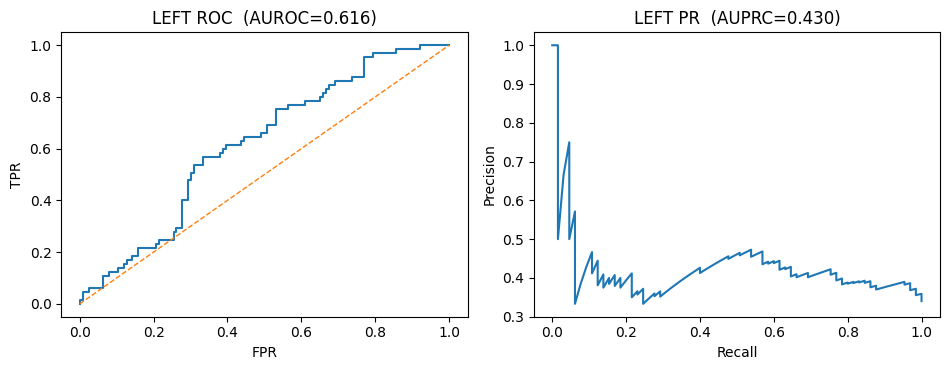

[eval] Target=right  file=S001R03.edf


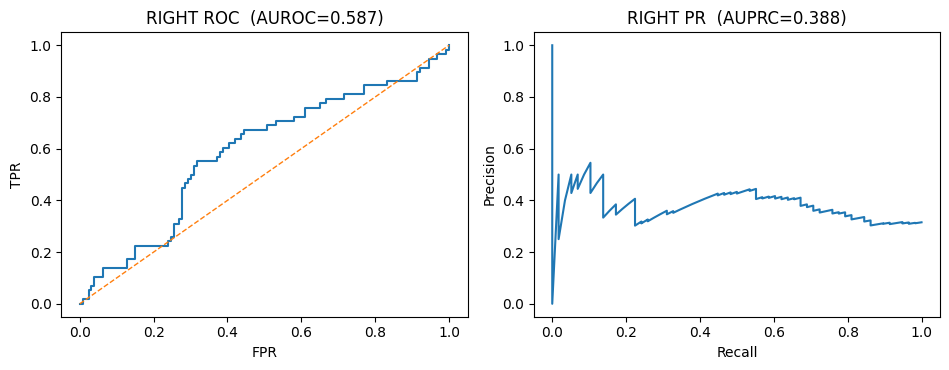

[saved] out\cnt_eeg_novelty_best_report.json


In [31]:
# CNT EEG — Deploy best novelty config (strict motor, short windows)
# Uses: W=1.0s, step=0.5s, overlap=0.1, channels[C3,Cz,C4], IsolationForest(contam=0.03)
# Output: 
#   - out/cnt_eeg_novelty_best_left.png, out/cnt_eeg_novelty_best_right.png
#   - out/cnt_eeg_novelty_best_report.json

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
from scipy.signal import welch
import matplotlib.pyplot as plt
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)

# ---------- best-config settings ----------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
WIN_LEN = 1.0
WIN_STEP = 0.5
MIN_OVERLAP_FRAC = 0.1
SM_CHS = ["C3","Cz","C4"]
CONTAM = 0.03
NAME_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
BANDS = {"mu":(8,13), "beta":(13,30)}

# ---------- helpers ----------
def list_edfs(root): return sorted(set(list(root.rglob("*.edf"))))

def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs = float(raw.info["sfreq"]); data = raw.get_data()
    m = re.search(r"S(\d{3}).*R(\d{2})", p.name); subj = m.group(1) if m else None; run = m.group(2) if m else None
    anno=[]
    if raw.annotations and len(raw.annotations):
        for onset, dur, desc in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0 = int(round(onset*fs)); L = dur if dur and dur>0 else WIN_LEN; s1 = s0 + int(round(L*fs))
            anno.append((max(0,s0), max(0,s1), str(desc)))
    return raw, data, fs, subj, run, anno

def pick_channels(raw, wanted):
    have = raw.info["ch_names"]; picks = [c for c in wanted if c in have]
    return mne.pick_channels(have, include=picks) if picks else mne.pick_types(raw.info, eeg=True)

def windows(n_t, fs, Wsec, Ssec):
    W = int(Wsec*fs); S = int(Ssec*fs); W = max(W,16); S = max(S,1)
    return [(s, s+W) for s in range(0, max(1, n_t-W+1), S) if s+W <= n_t]

def label_by_overlap(si, ei, anno, min_frac):
    best_ol, best_desc = 0, None; wlen = ei - si
    for s0,s1,desc in anno:
        ol = max(0, min(ei, s1) - max(si, s0))
        if ol > best_ol: best_ol, best_desc = ol, desc
    if best_desc is None or best_ol/max(1,wlen) < min_frac: return None
    return NAME_MAP.get(str(best_desc), f"event_{best_desc}")

def cov_shrink(seg):
    X = seg - seg.mean(axis=1, keepdims=True)
    C = (X @ X.T) / max(1, X.shape[1]-1)
    d = np.diag(C); alpha=0.1
    return (1-alpha)*C + alpha*np.diag(d.mean()*np.ones_like(d))

def logeuclid_vec(C):
    ev, V = eigh(C); ev = np.clip(ev, 1e-12, None)
    L = V @ np.diag(np.log(ev)) @ V.T
    idx = np.triu_indices_from(L); return L[idx]

def bandpower(seg, fs, band):
    f, Pxx = welch(seg, fs=fs, nperseg=min(256, seg.shape[-1]), axis=-1)
    m = (f>=band[0]) & (f<=band[1]); return float(Pxx[..., m].mean())

def make_features(seg, fs):
    C = cov_shrink(seg); v = logeuclid_vec(C)
    mu = bandpower(seg, fs, BANDS["mu"]); beta = bandpower(seg, fs, BANDS["beta"])
    return np.concatenate([v, np.array([mu, beta])])

# ---------- collect features with best config ----------
rows=[]
edfs = list_edfs(ROOT)
if not edfs: raise RuntimeError(f"No EDFs under {ROOT}")

for p in edfs:
    raw, data, fs, subj, run, anno = load_edf(p)
    spans = windows(data.shape[1], fs, WIN_LEN, WIN_STEP)
    picks = pick_channels(raw, SM_CHS)
    kept=0
    for si,ei in spans:
        lab = label_by_overlap(si, ei, anno, MIN_OVERLAP_FRAC)
        if lab is None: continue
        seg = data[picks, si:ei]
        if seg.shape[1] < 16: continue
        feat = make_features(seg, fs)
        rows.append({"file":p.name, "label":lab, "subj":subj, "run":run, "feat":feat})
        kept += 1
    print(f"[build] {p.name}: kept={kept}")

df = pd.DataFrame(rows)
if df.empty: raise RuntimeError("No labeled windows produced with best config.")

# pick REST train/test + targets
files_by_label = {lab: sorted(df.loc[df["label"]==lab,"file"].unique().tolist())
                  for lab in sorted(df["label"].unique())}
if "rest" not in files_by_label or len(files_by_label["rest"])<2:
    raise RuntimeError("Need ≥2 REST files (one train, one test).")

sizes = [(f, int((df["file"]==f).sum())) for f in files_by_label["rest"]]
sizes.sort(key=lambda t: t[1], reverse=True)
rest_test_file = sizes[0][0]
rest_train_files = [f for f,_ in sizes[1:]]

target_files = {}
for lab in ["left","right"]:
    if lab in files_by_label and files_by_label[lab]:
        t_sizes = [(f, int((df["file"]==f).sum())) for f in files_by_label[lab]]
        t_sizes.sort(key=lambda t: t[1], reverse=True)
        target_files[lab] = t_sizes[0][0]

def stackX(dfp): 
    X = np.vstack(dfp["feat"].to_numpy()); return X

Xr_tr = stackX(df[(df["file"].isin(rest_train_files)) & (df["label"]=="rest")])
Xr_te = stackX(df[(df["file"]==rest_test_file)            & (df["label"]=="rest")])

sc = StandardScaler().fit(Xr_tr)
Xtr = sc.transform(Xr_tr)
Xre = sc.transform(Xr_te)

mdl = IsolationForest(n_estimators=400, contamination=CONTAM, random_state=42).fit(Xtr)
s_rest = mdl.score_samples(Xre).ravel()  # higher = more normal → invert

def plot_target(lab, target_file):
    Xt = stackX(df[(df["file"]==target_file) & (df["label"]==lab)])
    Xt = sc.transform(Xt)
    s_tar = mdl.score_samples(Xt).ravel()
    y = np.concatenate([np.zeros_like(s_rest), np.ones_like(s_tar)])
    z = np.concatenate([-s_rest, -s_tar])   # novelty score (higher = more target-like)

    # ROC/PR + threshold (max-F1 on PR)
    fpr, tpr, roc_th = roc_curve(y, z)
    prec, rec, pr_th = precision_recall_curve(y, z)
    auroc = roc_auc_score(y, z)
    auprc = average_precision_score(y, z)

    # choose threshold by max F1 over PR curve points that have thresholds
    f1s = (2*prec*rec)/(prec+rec+1e-12)
    # pr_th has len = len(prec)-1; align by trimming last f1
    thr = pr_th[np.argmax(f1s[:-1])] if len(pr_th)>0 else 0.0

    yhat = (z >= thr).astype(int)
    tp = int(((y==1)&(yhat==1)).sum()); fp = int(((y==0)&(yhat==1)).sum())
    tn = int(((y==0)&(yhat==0)).sum()); fn = int(((y==1)&(yhat==0)).sum())

    # plot
    fig, ax = plt.subplots(1,2, figsize=(9.6,3.8))
    ax[0].plot(fpr, tpr); ax[0].plot([0,1],[0,1],'--',lw=1)
    ax[0].set_title(f"{lab.upper()} ROC  (AUROC={auroc:.3f})"); ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR")
    ax[1].plot(rec, prec)
    ax[1].set_title(f"{lab.upper()} PR  (AUPRC={auprc:.3f})"); ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision")
    plt.tight_layout()
    fig_path = Path("out")/f"cnt_eeg_novelty_best_{lab}.png"
    plt.savefig(fig_path, dpi=160); plt.show()

    return {
        "lab": lab, "target_file": target_file,
        "n_rest": int(len(s_rest)), "n_target": int(len(s_tar)),
        "auroc": float(auroc), "auprc": float(auprc),
        "threshold": float(thr),
        "confusion_at_threshold": {"tp":tp,"fp":fp,"tn":tn,"fn":fn},
        "rest_train_files": rest_train_files,
        "rest_test_file": rest_test_file
    }

report = {"model":"IsolationForest", "contamination": CONTAM,
          "config":{"win_len":WIN_LEN,"win_step":WIN_STEP,"overlap_frac":MIN_OVERLAP_FRAC,"channels":SM_CHS},
          "targets":{}}

for lab in ["left","right"]:
    if lab in target_files:
        print(f"[eval] Target={lab}  file={target_files[lab]}")
        report["targets"][lab] = plot_target(lab, target_files[lab])

out_json = Path("out")/"cnt_eeg_novelty_best_report.json"
with open(out_json,"w",encoding="utf-8") as f: json.dump(report, f, indent=2)
print(f"[saved] {out_json}")


[build] S001R01.edf: kept=121
[build] S001R02.edf: kept=121
[build] S001R03.edf: kept=249


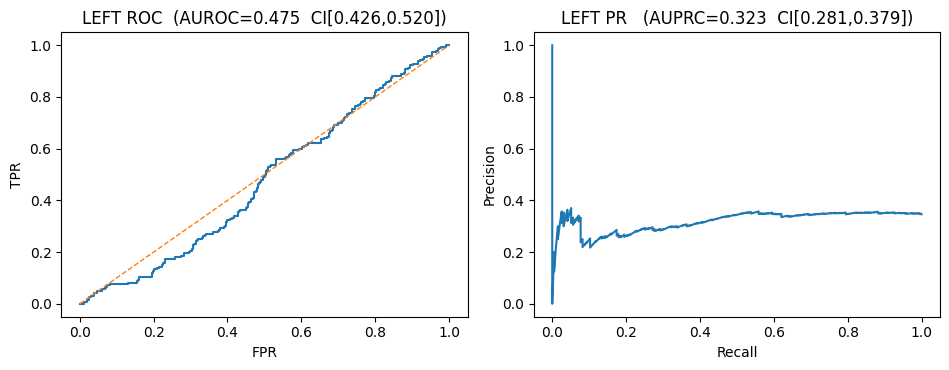

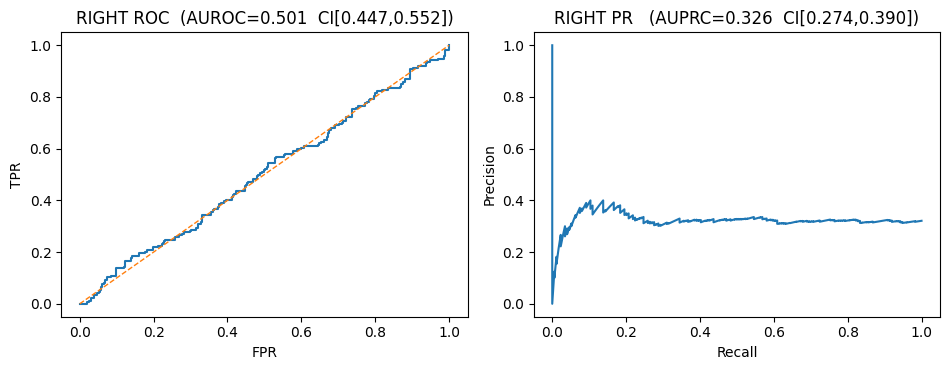

=== Group-averaged novelty (pooled across REST rotations) ===
LEFT: AUROC=0.475  CI[0.426,0.520]   AUPRC=0.323  CI[0.281,0.379]   (rest=368, target=195)
RIGHT: AUROC=0.501  CI[0.447,0.552]   AUPRC=0.326  CI[0.274,0.390]   (rest=368, target=174)
[saved] out\cnt_eeg_novelty_groupAvg_report.json


In [32]:
# CNT EEG — Group-averaged novelty (leakage-free) with richer MI features + 95% bootstrap CIs
# - Windows labeled by annotation-overlap (T0/T1/T2/T3 → rest/left/right/both)
# - Features (C3,Cz,C4): log-Euclidean covariance + mu/beta + Hjorth mobility/complexity + C3<->C4 asymmetry (alpha/beta)
# - Train on REST-only (all-but-one rest file), rotate the held-out REST file, pool predictions
# - Report AUROC/AUPRC (+ 95% CIs) for LEFT and RIGHT, save plots + JSON
#
# Outputs:
#   out/cnt_eeg_novelty_groupAvg_LEFT.png
#   out/cnt_eeg_novelty_groupAvg_RIGHT.png
#   out/cnt_eeg_novelty_groupAvg_report.json

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
from scipy.signal import welch
import matplotlib.pyplot as plt
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)

# -------- settings --------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
WIN_LEN = 1.0     # seconds (best from your tuner)
WIN_STEP = 0.5    # seconds
MIN_OVERLAP_FRAC = 0.10
SM_CHS = ["C3","Cz","C4"]      # strict motor
CONTAM = 0.03                  # IsolationForest contamination
NAME_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}

# bands
ALPHA = (8,13)
MU    = (8,13)
BETA  = (13,30)

# -------- small helpers --------
def list_edfs(root): return sorted(set(list(root.rglob("*.edf"))))

def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs = float(raw.info["sfreq"]); data = raw.get_data()
    # S###R##.edf parsing
    m = re.search(r"S(\d{3}).*R(\d{2})", p.name)
    subj = m.group(1) if m else None
    run  = m.group(2) if m else None
    # annotations to samples
    anno=[]
    if raw.annotations and len(raw.annotations):
        for onset, dur, desc in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0 = int(round(onset*fs))
            dur = dur if dur and dur>0 else WIN_LEN
            s1 = s0 + int(round(dur*fs))
            anno.append((max(0,s0), max(0,s1), str(desc)))
    return raw, data, fs, subj, run, anno

def pick_channels(raw, wanted):
    have = raw.info["ch_names"]
    picks = [c for c in wanted if c in have]
    return mne.pick_channels(have, include=picks) if picks else mne.pick_types(raw.info, eeg=True)

def windows(n_t, fs, Wsec, Ssec):
    W = int(Wsec*fs); S = int(Ssec*fs)
    W = max(W, 16); S = max(S, 1)
    return [(s, s+W) for s in range(0, max(1, n_t-W+1), S) if s+W <= n_t]

def label_by_overlap(si, ei, anno, min_frac):
    best_ol, best_desc = 0, None; wlen = ei-si
    for s0,s1,desc in anno:
        ol = max(0, min(ei, s1) - max(si, s0))
        if ol > best_ol: best_ol, best_desc = ol, desc
    if best_desc is None or best_ol/max(1,wlen) < min_frac: return None
    return NAME_MAP.get(str(best_desc), f"event_{best_desc}")

def cov_shrink(seg):
    # seg: (n_ch, n_t)
    X = seg - seg.mean(axis=1, keepdims=True)
    C = (X @ X.T) / max(1, X.shape[1]-1)
    d = np.diag(C); alpha=0.1
    return (1-alpha)*C + alpha*np.diag(d.mean()*np.ones_like(d))

def logeuclid_vec(C):
    ev, V = eigh(C)
    ev = np.clip(ev, 1e-12, None)
    L = V @ np.diag(np.log(ev)) @ V.T
    idx = np.triu_indices_from(L)
    return L[idx]

def bandpower(seg, fs, band):
    f, Pxx = welch(seg, fs=fs, nperseg=min(256, seg.shape[-1]), axis=-1)
    m = (f>=band[0]) & (f<=band[1])
    return float(Pxx[..., m].mean())

def hjorth(seg):
    # Hjorth mobility & complexity per channel, then average
    # seg: (n_ch, n_t)
    def _hj(x):
        dx = np.diff(x)
        ddx = np.diff(dx)
        var0 = np.var(x)
        var1 = np.var(dx)
        var2 = np.var(ddx) if len(ddx) else 0.0
        mobility = np.sqrt(var1 / (var0 + 1e-12))
        complexity = np.sqrt((var2 / (var1 + 1e-12)) / (var1 / (var0 + 1e-12) + 1e-12))
        return mobility, complexity
    vals = np.array([_hj(seg[i]) for i in range(seg.shape[0])])
    return float(vals[:,0].mean()), float(vals[:,1].mean())

def alpha_beta_asym(seg, fs, ch_names, left="C3", right="C4"):
    # Return alpha/beta asymmetry: (P_left - P_right)/(P_left + P_right)
    # If a channel missing, returns 0.
    def _asym(band):
        if left in ch_names and right in ch_names:
            li = ch_names.index(left); ri = ch_names.index(right)
            Pl = bandpower(seg[li:li+1,:], fs, band)
            Pr = bandpower(seg[ri:ri+1,:], fs, band)
            return (Pl - Pr) / (Pl + Pr + 1e-12)
        return 0.0
    return float(_asym(ALPHA)), float(_asym(BETA))

def make_feature_vector(seg, fs, ch_names):
    # Core MI features on strict motor channels
    C = cov_shrink(seg)
    v_cov = logeuclid_vec(C)
    mu_p  = bandpower(seg, fs, MU)
    beta_p= bandpower(seg, fs, BETA)
    hj_mob, hj_cplx = hjorth(seg)
    asym_a, asym_b  = alpha_beta_asym(seg, fs, ch_names)
    return np.concatenate([v_cov, np.array([mu_p, beta_p, hj_mob, hj_cplx, asym_a, asym_b])])

# -------- collect windows + features with best config --------
rows=[]
edfs = list_edfs(ROOT)
if not edfs:
    raise RuntimeError(f"No EDF files found under {ROOT}")
for p in edfs:
    raw, data, fs, subj, run, anno = load_edf(p)
    spans = windows(data.shape[1], fs, WIN_LEN, WIN_STEP)
    picks = pick_channels(raw, SM_CHS)
    sm_names = [raw.info["ch_names"][i] for i in (picks if isinstance(picks, list) else list(picks))]
    kept=0
    for si,ei in spans:
        lab = label_by_overlap(si, ei, anno, MIN_OVERLAP_FRAC)
        if lab is None: continue
        seg = data[picks, si:ei]
        if seg.shape[1] < 16: continue
        feat = make_feature_vector(seg, fs, sm_names)
        rows.append({"file": p.name, "label": lab, "feat": feat})
        kept += 1
    print(f"[build] {p.name}: kept={kept}")

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("No labeled windows produced. Adjust MIN_OVERLAP_FRAC or check annotations.")

# -------- choose targets + rotate REST test file --------
files_by_label = {lab: sorted(df.loc[df["label"]==lab,"file"].unique().tolist())
                  for lab in sorted(df["label"].unique())}

if "rest" not in files_by_label or len(files_by_label["rest"]) < 2:
    raise RuntimeError("Need ≥2 REST files (one for train, one for test).")

# choose largest rest as test candidate order
sizes = [(f, int((df["file"]==f).sum())) for f in files_by_label["rest"]]
sizes.sort(key=lambda t: t[1], reverse=True)
rest_order = [f for f,_ in sizes]  # we will rotate this

# choose a single target file per class (largest)
target_files = {}
for lab in ["left","right"]:
    if lab in files_by_label and len(files_by_label[lab]) >= 1:
        ts = [(f, int((df["file"]==f).sum())) for f in files_by_label[lab]]
        ts.sort(key=lambda t: t[1], reverse=True)
        target_files[lab] = ts[0][0]

def stackX(dfp):
    arr = np.vstack(dfp["feat"].to_numpy())
    return arr

# pool predictions across rotations
pooled = {"left": {"z":[], "y":[]}, "right": {"z":[], "y":[]}}

for rest_test in rest_order:
    rest_train = [f for f in rest_order if f != rest_test]
    # build REST matrices
    Xr_tr = stackX(df[(df["file"].isin(rest_train)) & (df["label"]=="rest")])
    Xr_te = stackX(df[(df["file"]==rest_test) & (df["label"]=="rest")])

    sc = StandardScaler().fit(Xr_tr)
    Xtr = sc.transform(Xr_tr)
    Xre = sc.transform(Xr_te)

    mdl = IsolationForest(n_estimators=400, contamination=CONTAM, random_state=42).fit(Xtr)
    s_rest = mdl.score_samples(Xre).ravel()  # higher = more normal

    for lab in ["left","right"]:
        if lab not in target_files: continue
        Xt = stackX(df[(df["file"]==target_files[lab]) & (df["label"]==lab)])
        Xt = sc.transform(Xt)
        s_tar = mdl.score_samples(Xt).ravel()
        y = np.concatenate([np.zeros_like(s_rest), np.ones_like(s_tar)])
        z = np.concatenate([-s_rest, -s_tar])  # novelty score
        pooled[lab]["y"].append(y); pooled[lab]["z"].append(z)

# concatenate pools
for lab in pooled:
    if pooled[lab]["y"]:
        pooled[lab]["y"] = np.concatenate(pooled[lab]["y"])
        pooled[lab]["z"] = np.concatenate(pooled[lab]["z"])
    else:
        pooled[lab]["y"] = np.array([])
        pooled[lab]["z"] = np.array([])

def bootstrap_ci(y, z, n=2000, seed=12345):
    rng = np.random.default_rng(seed)
    nobs = len(y)
    if nobs < 5:
        return {"auroc": (np.nan,np.nan), "auprc": (np.nan,np.nan)}
    aurocs = []; auprcs=[]
    idx_all = np.arange(nobs)
    for _ in range(n):
        idx = rng.choice(idx_all, size=nobs, replace=True)
        try:
            aurocs.append(roc_auc_score(y[idx], z[idx]))
            auprcs.append(average_precision_score(y[idx], z[idx]))
        except Exception:
            continue
    lo_roc, hi_roc = np.percentile(aurocs, [2.5,97.5]) if aurocs else (np.nan,np.nan)
    lo_pr , hi_pr  = np.percentile(auprcs,[2.5,97.5]) if auprcs else (np.nan,np.nan)
    return {"auroc": (float(lo_roc), float(hi_roc)), "auprc": (float(lo_pr), float(hi_pr))}

def plot_curves(lab, y, z, fname):
    fpr, tpr, _ = roc_curve(y, z)
    prec, rec, _ = precision_recall_curve(y, z)
    auroc = roc_auc_score(y, z)
    auprc = average_precision_score(y, z)
    ci = bootstrap_ci(y, z)

    fig, ax = plt.subplots(1,2, figsize=(9.6,3.8))
    ax[0].plot(fpr, tpr); ax[0].plot([0,1],[0,1],'--',lw=1)
    ax[0].set_title(f"{lab.upper()} ROC  (AUROC={auroc:.3f}  CI[{ci['auroc'][0]:.3f},{ci['auroc'][1]:.3f}])")
    ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR")
    ax[1].plot(rec, prec)
    ax[1].set_title(f"{lab.upper()} PR   (AUPRC={auprc:.3f}  CI[{ci['auprc'][0]:.3f},{ci['auprc'][1]:.3f}])")
    ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision")
    plt.tight_layout()
    fig_path = Path("out")/fname
    plt.savefig(fig_path, dpi=160); plt.show()
    return float(auroc), float(auprc), ci, str(fig_path)

report = {"mode":"rest-only novelty, pooled rotations",
          "config":{"win_len":WIN_LEN,"win_step":WIN_STEP,"overlap_frac":MIN_OVERLAP_FRAC,
                    "channels":SM_CHS,"model":"IsolationForest","contamination":CONTAM},
          "targets":{}, "rest_rotations": len(rest_order)}

for lab in ["left","right"]:
    y, z = pooled[lab]["y"], pooled[lab]["z"]
    if len(y)==0:
        report["targets"][lab] = {"note":"no target data"}
        continue
    auroc, auprc, ci, fig = plot_curves(lab, y, z, f"cnt_eeg_novelty_groupAvg_{lab}.png")
    report["targets"][lab] = {
        "auroc": auroc, "auprc": auprc,
        "auroc_ci95": list(ci["auroc"]), "auprc_ci95": list(ci["auprc"]),
        "figure": fig,
        "n_samples": int(len(y)), "class_balance": {"rest": int((y==0).sum()), "target": int((y==1).sum())}
    }

out_json = Path("out")/"cnt_eeg_novelty_groupAvg_report.json"
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2)

print("=== Group-averaged novelty (pooled across REST rotations) ===")
for lab, r in report["targets"].items():
    if "auroc" in r:
        print(f"{lab.upper()}: AUROC={r['auroc']:.3f}  CI[{r['auroc_ci95'][0]:.3f},{r['auroc_ci95'][1]:.3f}]   "
              f"AUPRC={r['auprc']:.3f}  CI[{r['auprc_ci95'][0]:.3f},{r['auprc_ci95'][1]:.3f}]   "
              f"(rest={r['class_balance']['rest']}, target={r['class_balance']['target']})")
    else:
        print(f"{lab.upper()}: {r.get('note','no data')}")
print(f"[saved] {out_json}")


In [33]:
# Per-REST-file breakdown (no pooling) — same best config & features you just ran
# Prints AUROC/AUPRC for LEFT and RIGHT using each REST file as the test negative.
# Saves: out/cnt_eeg_novelty_perREST.json

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
from scipy.signal import welch
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)

ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
WIN_LEN, WIN_STEP, MIN_OVERLAP_FRAC = 1.0, 0.5, 0.10
SM_CHS = ["C3","Cz","C4"]
CONTAM = 0.03
NAME_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
ALPHA, MU, BETA = (8,13),(8,13),(13,30)

def list_edfs(root): return sorted(set(list(root.rglob("*.edf"))))
def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs = float(raw.info["sfreq"]); data = raw.get_data()
    anno=[]
    if raw.annotations and len(raw.annotations):
        for onset, dur, desc in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0 = int(round(onset*fs)); dur = dur if dur and dur>0 else WIN_LEN; s1 = s0+int(round(dur*fs))
            anno.append((max(0,s0), max(0,s1), str(desc)))
    return raw, data, fs, anno
def pick_channels(raw, wanted):
    have = raw.info["ch_names"]; picks=[c for c in wanted if c in have]
    return mne.pick_channels(have, include=picks) if picks else mne.pick_types(raw.info, eeg=True)
def windows(n_t, fs, Wsec, Ssec):
    W = max(int(Wsec*fs),16); S = max(int(Ssec*fs),1)
    return [(s,s+W) for s in range(0,max(1,n_t-W+1),S) if s+W<=n_t]
def label_by_overlap(si, ei, anno, min_frac):
    best, name = 0,None; w=ei-si
    for s0,s1,desc in anno:
        ol = max(0, min(ei,s1)-max(si,s0))
        if ol>best: best, name = ol, desc
    return NAME_MAP.get(str(name)) if (name and best/max(1,w)>=min_frac) else None
def welch_bp(seg, fs, band):
    f,Pxx=welch(seg,fs=fs,nperseg=min(256,seg.shape[-1]),axis=-1)
    m=(f>=band[0])&(f<=band[1]); return float(Pxx[...,m].mean())
def cov_shrink(seg):
    X=seg-seg.mean(axis=1,keepdims=True); C=(X@X.T)/max(1,X.shape[1]-1)
    d=np.diag(C); a=0.1; return (1-a)*C + a*np.diag(d.mean()*np.ones_like(d))
def logeuclid_vec(C):
    ev,V=eigh(C); ev=np.clip(ev,1e-12,None); L=V@np.diag(np.log(ev))@V.T
    idx=np.triu_indices_from(L); return L[idx]
def hjorth(seg):
    def _h(x):
        dx=np.diff(x); ddx=np.diff(dx); v0=np.var(x); v1=np.var(dx); v2=np.var(ddx) if len(ddx) else 0
        mob=np.sqrt(v1/(v0+1e-12)); cplx=np.sqrt((v2/(v1+1e-12))/(v1/(v0+1e-12)+1e-12)); return mob,cplx
    vals=np.array([_h(seg[i]) for i in range(seg.shape[0])]); return float(vals[:,0].mean()), float(vals[:,1].mean())
def asym(seg, fs, ch_names, L="C3", R="C4"):
    if L in ch_names and R in ch_names:
        li,ri=ch_names.index(L),ch_names.index(R)
        a=(welch_bp(seg[li:li+1],fs,ALPHA)-welch_bp(seg[ri:ri+1],fs,ALPHA))/(welch_bp(seg[li:li+1],fs,ALPHA)+welch_bp(seg[ri:ri+1],fs,ALPHA)+1e-12)
        b=(welch_bp(seg[li:li+1],fs,BETA)-welch_bp(seg[ri:ri+1],fs,BETA))/(welch_bp(seg[li:li+1],fs,BETA)+welch_bp(seg[ri:ri+1],fs,BETA)+1e-12)
        return float(a),float(b)
    return 0.0,0.0
def feat(seg, fs, ch_names):
    C=cov_shrink(seg); v=logeuclid_vec(C); mu=welch_bp(seg,fs,MU); beta=welch_bp(seg,fs,BETA)
    mob,cplx=hjorth(seg); aA,aB=asym(seg,fs,ch_names)
    return np.concatenate([v,np.array([mu,beta,mob,cplx,aA,aB])])

# build window table
rows=[]; files=[]
for p in list_edfs(ROOT):
    raw,data,fs,anno=load_edf(p); files.append(p.name)
    spans=windows(data.shape[1],fs,WIN_LEN,WIN_STEP); picks=pick_channels(raw,SM_CHS)
    ch_names=[raw.info["ch_names"][i] for i in (picks if isinstance(picks,list) else list(picks))]
    for si,ei in spans:
        lab=label_by_overlap(si,ei,anno,MIN_OVERLAP_FRAC)
        if not lab: continue
        seg=data[picks,si:ei]; 
        if seg.shape[1]<16: continue
        rows.append({"file":p.name,"label":lab,"feat":feat(seg,fs,ch_names)})
df=pd.DataFrame(rows)
assert not df.empty, "No labeled windows produced."

files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
assert "rest" in files_by_label and len(files_by_label["rest"])>=2, "Need ≥2 REST files."

def stackX(dfp): return np.vstack(dfp["feat"].to_numpy())

def eval_once(rest_train, rest_test, target_file, target_lab):
    Xr_tr=stackX(df[(df["file"].isin(rest_train))&(df["label"]=="rest")])
    Xr_te=stackX(df[(df["file"]==rest_test)&(df["label"]=="rest")])
    Xt   =stackX(df[(df["file"]==target_file)&(df["label"]==target_lab)])
    if min(len(Xr_tr),len(Xr_te),len(Xt))<10: return None
    sc=StandardScaler().fit(Xr_tr)
    ifo=IsolationForest(n_estimators=400,contamination=CONTAM,random_state=42).fit(sc.transform(Xr_tr))
    s_rest=ifo.score_samples(sc.transform(Xr_te)); s_tar=ifo.score_samples(sc.transform(Xt))
    y=np.concatenate([np.zeros_like(s_rest), np.ones_like(s_tar)])
    z=np.concatenate([-s_rest, -s_tar])  # novelty
    return float(roc_auc_score(y,z)), float(average_precision_score(y,z)), int(len(s_rest)), int(len(s_tar))

# choose one target file per class (largest)
targets={}
for lab in ["left","right"]:
    if lab in files_by_label and files_by_label[lab]:
        sizes=[(f,int((df["file"]==f).sum())) for f in files_by_label[lab]]
        targets[lab]=sorted(sizes,key=lambda t:t[1],reverse=True)[0][0]

report={"per_rest":{}}
rest_files=files_by_label["rest"]
for rest_test in rest_files:
    rest_train=[f for f in rest_files if f!=rest_test]
    for lab in ["left","right"]:
        if lab not in targets: continue
        out=eval_once(rest_train, rest_test, targets[lab], lab)
        if out is None: continue
        au, ap, nr, nt = out
        report["per_rest"].setdefault(rest_test, {})[lab]={"auroc":au,"auprc":ap,"n_rest":nr,"n_tar":nt}

out_path=Path("out")/"cnt_eeg_novelty_perREST.json"
with open(out_path,"w",encoding="utf-8") as f: json.dump(report,f,indent=2)

print("=== Per-REST breakdown (no pooling) ===")
for r,vals in report["per_rest"].items():
    line=[f"{lab}: AUROC={d['auroc']:.3f} AUPRC={d['auprc']:.3f}" for lab,d in vals.items()]
    print(f"{r}:  "+ " | ".join(line))
print(f"[saved] {out_path}")


=== Per-REST breakdown (no pooling) ===
S001R01.edf:  left: AUROC=0.473 AUPRC=0.322 | right: AUROC=0.507 AUPRC=0.325
S001R02.edf:  left: AUROC=0.353 AUPRC=0.284 | right: AUROC=0.404 AUPRC=0.291
S001R03.edf:  left: AUROC=0.588 AUPRC=0.415 | right: AUROC=0.584 AUPRC=0.412
[saved] out\cnt_eeg_novelty_perREST.json


In [34]:
# CNT EEG — Riemannian mean transport to reduce file-wise drift (leakage-free)
# Align each REST test file's covariance space to REST-train space:
#   C_aligned = G_tr^(1/2) * ( G_te^(-1/2) * C * G_te^(-1/2) ) * G_tr^(1/2)
# Then log-Euclidean vectorize at identity, add μ/β + Hjorth + C3↔C4 asymmetry, and
# run IsolationForest novelty (REST-only train), reporting per-REST and pooled metrics.

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
from scipy.signal import welch
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)

# -------- config (keep your best settings) --------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
WIN_LEN, WIN_STEP, MIN_OVERLAP_FRAC = 1.0, 0.5, 0.10
SM_CHS = ["C3","Cz","C4"]
CONTAM = 0.03
NAME_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
MU=(8,13); BETA=(13,30); ALPHA=(8,13)

# -------- helpers --------
def list_edfs(root): return sorted(set(list(root.rglob("*.edf"))))
def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs  = float(raw.info["sfreq"]); data = raw.get_data()
    anno=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0 = int(round(on*fs)); du = du if du and du>0 else WIN_LEN; s1 = s0+int(round(du*fs))
            anno.append((max(0,s0), max(0,s1), str(de)))
    return raw, data, fs, anno
def pick_channels(raw, wanted):
    have = raw.info["ch_names"]; picks=[c for c in wanted if c in have]
    return mne.pick_channels(have, include=picks) if picks else mne.pick_types(raw.info, eeg=True)
def windows(n_t, fs, Wsec, Ssec):
    W = max(int(Wsec*fs),16); S=max(int(Ssec*fs),1)
    return [(s,s+W) for s in range(0,max(1,n_t-W+1),S) if s+W<=n_t]
def label_by_overlap(si, ei, anno, frac):
    best, name = 0, None; w=ei-si
    for s0,s1,de in anno:
        ol = max(0, min(ei,s1) - max(si,s0))
        if ol>best: best, name = ol, de
    return NAME_MAP.get(str(name)) if (name and best/max(1,w)>=frac) else None

# spectral + time features
def welch_bp(seg, fs, band):
    f,Pxx=welch(seg, fs=fs, nperseg=min(256, seg.shape[-1]), axis=-1)
    m=(f>=band[0])&(f<=band[1]); return float(Pxx[...,m].mean())
def hjorth(seg):
    def _h(x):
        dx=np.diff(x); ddx=np.diff(dx)
        v0=np.var(x); v1=np.var(dx); v2=np.var(ddx) if len(ddx) else 0
        mob=np.sqrt(v1/(v0+1e-12)); cplx=np.sqrt((v2/(v1+1e-12))/(v1/(v0+1e-12)+1e-12))
        return mob,cplx
    vals=np.array([_h(seg[i]) for i in range(seg.shape[0])])
    return float(vals[:,0].mean()), float(vals[:,1].mean())
def asym(seg, fs, names, L="C3", R="C4"):
    if L in names and R in names:
        li,ri=names.index(L),names.index(R)
        a=(welch_bp(seg[li:li+1],fs,ALPHA)-welch_bp(seg[ri:ri+1],fs,ALPHA))/(welch_bp(seg[li:li+1],fs,ALPHA)+welch_bp(seg[ri:ri+1],fs,ALPHA)+1e-12)
        b=(welch_bp(seg[li:li+1],fs,BETA)-welch_bp(seg[ri:ri+1],fs,BETA))/(welch_bp(seg[li:li+1],fs,BETA)+welch_bp(seg[ri:ri+1],fs,BETA)+1e-12)
        return float(a),float(b)
    return 0.0,0.0

# covariance ops (SPD)
def cov_shrink(seg):
    X=seg - seg.mean(axis=1, keepdims=True)
    C=(X@X.T)/max(1,X.shape[1]-1)
    d=np.diag(C); a=0.1
    return (1-a)*C + a*np.diag(d.mean()*np.ones_like(d))
def spd_eigh(C):
    ev,V=eigh(C); ev=np.clip(ev, 1e-12, None); return ev,V
def spd_pow(C, p):
    ev,V=spd_eigh(C); return V @ np.diag(ev**p) @ V.T
def logeuclid_vec(C):
    ev,V=spd_eigh(C); L=V@np.diag(np.log(ev))@V.T
    idx=np.triu_indices_from(L); return L[idx]
def riemann_mean(Cs, iters=5):
    # simple iterative log-Euclidean mean (OK for this use)
    Ls=[logeuclid_vec(C) for C in Cs]  # vectorized logs
    # rebuild mean in matrix form
    # get size from first C
    n=Cs[0].shape[0]; idx=np.triu_indices(n)
    Lmean=np.mean(np.vstack(Ls), axis=0)
    Lmat=np.zeros((n,n)); Lmat[idx]=Lmean; Lmat=(Lmat+Lmat.T)-np.diag(np.diag(Lmat))
    # exp back
    ev,V=eigh(Lmat); return V@np.diag(np.exp(ev))@V.T
def transport_to_train(C, G_te, G_tr):
    # parallel transport via whitening recoloring: G_tr^(1/2) * (G_te^(-1/2) C G_te^(-1/2)) * G_tr^(1/2)
    Wte = spd_pow(G_te, -0.5)
    Wtr = spd_pow(G_tr,  0.5)
    return Wtr @ (Wte @ C @ Wte) @ Wtr

def feature_vector(seg, fs, names):
    # covariance (aligned later) will be vectorized at identity, so here only add scalar extras
    mu=welch_bp(seg, fs, MU); beta=welch_bp(seg, fs, BETA)
    mob,cplx=hjorth(seg); aA,aB=asym(seg, fs, names)
    return np.array([mu,beta,mob,cplx,aA,aB], dtype=float)

# -------- collect per-file windows: store raw segs to compute covariances later --------
records=[]
for p in list_edfs(ROOT):
    raw,data,fs,anno=load_edf(p)
    spans=windows(data.shape[1], fs, WIN_LEN, WIN_STEP)
    picks=pick_channels(raw, SM_CHS)
    names=[raw.info["ch_names"][i] for i in (picks if isinstance(picks,list) else list(picks))]
    kept=0
    for si,ei in spans:
        lab=label_by_overlap(si, ei, anno, MIN_OVERLAP_FRAC)
        if not lab: continue
        seg=data[picks, si:ei]
        if seg.shape[1] < 16: continue
        C = cov_shrink(seg)                            # store covariance
        scalars = feature_vector(seg, fs, names)       # store extras
        records.append({"file":p.name, "label":lab, "C":C, "scalars":scalars})
        kept+=1
    print(f"[build] {p.name}: kept={kept}")

df = pd.DataFrame(records)
assert not df.empty, "No labeled windows produced."

# choose one target file per class (largest), and list rest files
files_by_label = {lab: sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
assert "rest" in files_by_label and len(files_by_label["rest"])>=2, "Need ≥2 REST files."

sizes = [(f, int((df["file"]==f).sum())) for f in files_by_label["rest"]]
rest_order = [f for f,_ in sorted(sizes, key=lambda t:t[1], reverse=True)]

targets={}
for lab in ["left","right"]:
    if lab in files_by_label and files_by_label[lab]:
        t_sizes=[(f, int((df["file"]==f).sum())) for f in files_by_label[lab]]
        targets[lab]=sorted(t_sizes, key=lambda t:t[1], reverse=True)[0][0]

def stack_after_transport(sub_df, G_te, G_tr):
    # align covariances then vectorize + concat scalars
    X=[]
    for _,row in sub_df.iterrows():
        Ca = transport_to_train(row["C"], G_te, G_tr)
        v  = logeuclid_vec(Ca)             # at identity after transport
        X.append( np.concatenate([v, row["scalars"]]) )
    return np.vstack(X)

per_rest = {}
pooled = {"left":{"y":[],"z":[]}, "right":{"y":[],"z":[]}}

for rest_test in rest_order:
    rest_train = [f for f in rest_order if f!=rest_test]

    # compute train/test REST means (from their REST windows only)
    G_tr = riemann_mean(df[(df["file"].isin(rest_train)) & (df["label"]=="rest")]["C"].tolist())
    G_te = riemann_mean(df[(df["file"]==rest_test) & (df["label"]=="rest")]["C"].tolist())

    # build matrices after transport
    Xr_tr = stack_after_transport(df[(df["file"].isin(rest_train)) & (df["label"]=="rest")], G_te, G_tr)
    Xr_te = stack_after_transport(df[(df["file"]==rest_test) & (df["label"]=="rest")], G_te, G_tr)

    if len(Xr_tr)<10 or len(Xr_te)<10: 
        continue

    sc = StandardScaler().fit(Xr_tr)
    Xtr = sc.transform(Xr_tr)
    Xre = sc.transform(Xr_te)

    mdl = IsolationForest(n_estimators=400, contamination=CONTAM, random_state=42).fit(Xtr)
    s_rest = mdl.score_samples(Xre).ravel()  # higher = more normal

    per_rest[rest_test] = {}

    for lab in ["left","right"]:
        if lab not in targets: continue
        Xt = stack_after_transport(df[(df["file"]==targets[lab]) & (df["label"]==lab)], G_te, G_tr)
        Xt = sc.transform(Xt)
        s_tar = mdl.score_samples(Xt).ravel()
        y = np.concatenate([np.zeros_like(s_rest), np.ones_like(s_tar)])
        z = np.concatenate([-s_rest, -s_tar])  # novelty (higher = more like target)
        au = float(roc_auc_score(y, z)); ap = float(average_precision_score(y, z))
        per_rest[rest_test][lab] = {"auroc":au, "auprc":ap, "n_rest":int(len(s_rest)), "n_tar":int(len(s_tar))}
        pooled[lab]["y"].append(y); pooled[lab]["z"].append(z)

# pooled metrics
def pool_and_report(y_list, z_list):
    if not y_list: return None
    y = np.concatenate(y_list); z = np.concatenate(z_list)
    au = float(roc_auc_score(y, z)); ap = float(average_precision_score(y, z))
    return {"auroc": au, "auprc": ap, "n": int(len(y)), "rest": int((y==0).sum()), "target": int((y==1).sum())}

pooled_report = {lab: pool_and_report(pooled[lab]["y"], pooled[lab]["z"]) for lab in ["left","right"]}

# save + print
out = {"mode":"riemann_transport_novelty", "per_rest": per_rest, "pooled": pooled_report}
out_path = Path("out")/"cnt_eeg_novelty_perREST_riemannAlign.json"
with open(out_path, "w", encoding="utf-8") as f: json.dump(out, f, indent=2)

print("=== Per-REST (after Riemannian mean transport) ===")
for r,vals in per_rest.items():
    line = " | ".join([f"{lab}: AUROC={d['auroc']:.3f} AUPRC={d['auprc']:.3f}" for lab,d in vals.items()])
    print(f"{r}:  {line}")
print("\nPooled:")
for lab, rep in pooled_report.items():
    if rep: print(f"{lab}: AUROC={rep['auroc']:.3f}  AUPRC={rep['auprc']:.3f}  (N={rep['n']}, rest={rep['rest']}, target={rep['target']})")
print(f"[saved] {out_path}")


[build] S001R01.edf: kept=121
[build] S001R02.edf: kept=121
[build] S001R03.edf: kept=249
=== Per-REST (after Riemannian mean transport) ===
S001R03.edf:  left: AUROC=0.567 AUPRC=0.404 | right: AUROC=0.563 AUPRC=0.385
S001R01.edf:  left: AUROC=0.463 AUPRC=0.317 | right: AUROC=0.475 AUPRC=0.304
S001R02.edf:  left: AUROC=0.305 AUPRC=0.269 | right: AUROC=0.336 AUPRC=0.262

Pooled:
left: AUROC=0.446  AUPRC=0.315  (N=563, rest=368, target=195)
right: AUROC=0.458  AUPRC=0.302  (N=542, rest=368, target=174)
[saved] out\cnt_eeg_novelty_perREST_riemannAlign.json


[baseline] S001R01.edf: kept=121
[baseline] S001R02.edf: kept=121
[baseline] S001R03.edf: kept=249


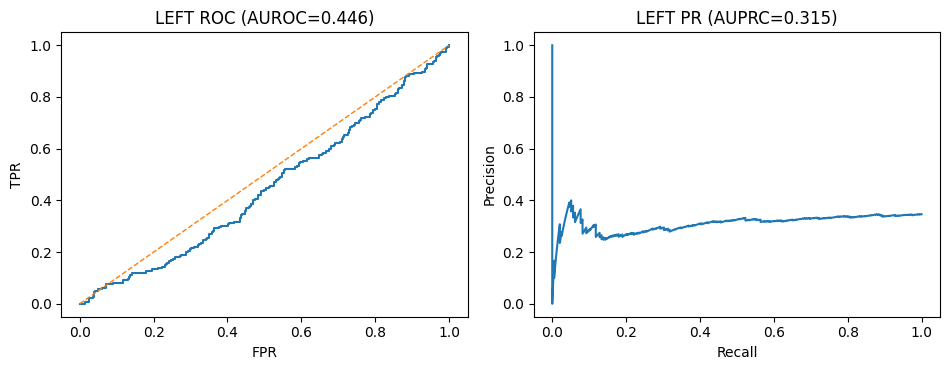

BEFORE LEFT: AUROC=0.446 CI[0.398,0.497]  AUPRC=0.315 CI[0.272,0.370]  (rest=368, target=195)


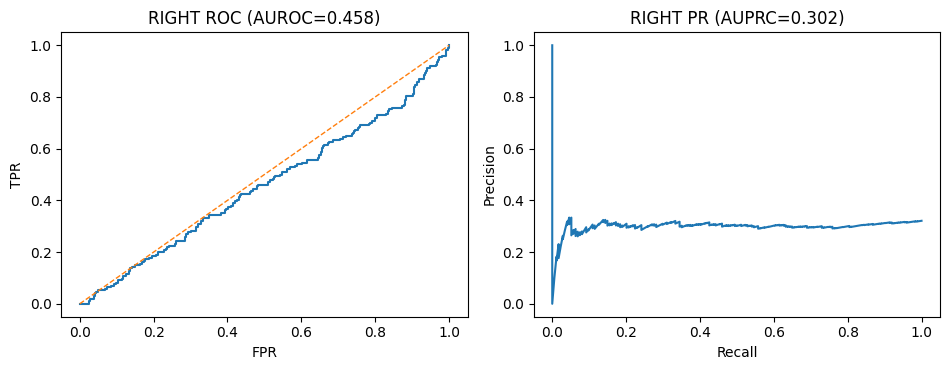

BEFORE RIGHT: AUROC=0.458 CI[0.404,0.511]  AUPRC=0.302 CI[0.256,0.362]  (rest=368, target=174)
[denoise] S001R01.edf: kept=121
[denoise] S001R03.edf: kept=249


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2080 and the array at index 2 has size 2016

In [35]:
# CNT EEG — Denoise + file exclusion → transport + leakage-free novelty (before/after with 95% CIs)
# A: Baseline (current best): overlap labels → Riemann mean transport → IsolationForest novelty (REST-only), pooled over REST rotations
# B: Denoised: exclude a file (default S001R02.edf), 8–30 Hz band-pass + 60 Hz notch + bad-channel trim → same pipeline
# Outputs:
#   out/cnt_eeg_novelty_beforeafter.json
#   out/cnt_eeg_novelty_before_LEFT.png / _RIGHT.png
#   out/cnt_eeg_novelty_after_LEFT.png  / _RIGHT.png

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)

# ---- settings ----
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
NAME_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
SM_CHS   = ["C3","Cz","C4"]
WIN_LEN, WIN_STEP, MIN_OVERLAP_FRAC = 1.0, 0.5, 0.10
CONTAM = 0.03
# denoise
BANDPASS = (8.0, 30.0)   # Hz
NOTCH    = 60.0          # Hz (set to None to skip)
BAD_ZVAR = 3.5           # drop channels with |zscore(var)|>BAD_ZVAR or flatline
FLAT_EPS = 1e-12
EXCLUDE_FILE = "S001R02.edf"  # change to None to keep all files in Variant B

# ---- helpers ----
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs  = float(raw.info["sfreq"]); data = raw.get_data()  # (n_ch, n_t)
    anno=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0 = int(round(on*fs)); du = du if du and du>0 else WIN_LEN; s1 = s0+int(round(du*fs))
            anno.append((max(0,s0), max(0,s1), str(de)))
    return raw, data, fs, anno

def pick_sm(raw):
    have = raw.info["ch_names"]
    picks = [c for c in SM_CHS if c in have]
    return mne.pick_channels(have, include=picks) if picks else mne.pick_types(raw.info, eeg=True)

def windows(n_t, fs):
    W = max(int(WIN_LEN*fs), 16); S = max(int(WIN_STEP*fs), 1)
    return [(s, s+W) for s in range(0, max(1, n_t-W+1), S) if s+W <= n_t]

def label_overlap(si, ei, anno):
    best, name = 0, None; w = ei-si
    for s0,s1,de in anno:
        ol = max(0, min(ei,s1) - max(si,s0))
        if ol > best: best, name = ol, de
    return NAME_MAP.get(str(name)) if (name and best/max(1,w)>=MIN_OVERLAP_FRAC) else None

# spectral/time features
def welch_bp(seg, fs, band):
    f,Pxx = welch(seg, fs=fs, nperseg=min(256, seg.shape[-1]), axis=-1)
    m = (f>=band[0]) & (f<=band[1])
    return float(Pxx[..., m].mean())

def hjorth(seg):
    def _h(x):
        dx=np.diff(x); ddx=np.diff(dx)
        v0=np.var(x); v1=np.var(dx); v2=np.var(ddx) if len(ddx) else 0
        mob=np.sqrt(v1/(v0+1e-12)); cplx=np.sqrt((v2/(v1+1e-12))/(v1/(v0+1e-12)+1e-12))
        return mob,cplx
    vals = np.array([_h(seg[i]) for i in range(seg.shape[0])])
    return float(vals[:,0].mean()), float(vals[:,1].mean())

def asym(seg, fs, names, L="C3", R="C4", band=(8,13)):
    if L in names and R in names:
        li,ri = names.index(L), names.index(R)
        aL = welch_bp(seg[li:li+1], fs, band); aR = welch_bp(seg[ri:ri+1], fs, band)
        return float((aL-aR)/(aL+aR+1e-12))
    return 0.0

# SPD ops
def cov_shrink(seg):
    X=seg - seg.mean(axis=1, keepdims=True)
    C=(X@X.T)/max(1, X.shape[1]-1)
    d=np.diag(C); a=0.1
    return (1-a)*C + a*np.diag(d.mean()*np.ones_like(d))

def spd_eigh(C):
    ev,V = eigh(C); ev=np.clip(ev, 1e-12, None); return ev,V
def spd_pow(C, p):
    ev,V = spd_eigh(C); return V @ np.diag(ev**p) @ V.T
def logeuclid_vec(C):
    ev,V = spd_eigh(C); L=V@np.diag(np.log(ev))@V.T
    idx=np.triu_indices_from(L); return L[idx]
def riemann_mean(Cs):
    # log-Euclidean mean
    n = Cs[0].shape[0]; idx = np.triu_indices(n)
    Ls = [logeuclid_vec(C) for C in Cs]
    Lm = np.mean(np.vstack(Ls), axis=0)
    L  = np.zeros((n,n)); L[idx]=Lm; L=(L+L.T)-np.diag(np.diag(L))
    ev,V = eigh(L); return V@np.diag(np.exp(ev))@V.T

def transport_to_train(C, G_te, G_tr):
    # G_tr^(1/2) * ( G_te^(-1/2) * C * G_te^(-1/2) ) * G_tr^(1/2)
    Wte = spd_pow(G_te, -0.5); Wtr = spd_pow(G_tr, 0.5)
    return Wtr @ (Wte @ C @ Wte) @ Wtr

# denoise: band-pass + notch + bad-channel drop
def butter_bandpass(x, fs, lo, hi, order=4):
    b,a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b,a,x,axis=-1)
def apply_notch(x, fs, f0, Q=30):
    b,a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b,a,x,axis=-1)

def trim_bad_channels(x):
    # x: (n_ch, n_t)
    v = np.var(x, axis=1)
    if np.any(v<FLAT_EPS):
        keep = v>=FLAT_EPS
        x = x[keep]
    z = (v - v.mean())/(v.std()+1e-12)
    keep2 = np.abs(z)<=BAD_ZVAR
    return x[keep2]

# make scalar extras (μ/β, Hjorth, α/β asym) — channels names needed for asym
def scalar_extras(seg, fs, names):
    mu   = welch_bp(seg, fs, (8,13))
    beta = welch_bp(seg, fs, (13,30))
    mob,cplx = hjorth(seg)
    asym_alpha = asym(seg, fs, names, band=(8,13))
    asym_beta  = asym(seg, fs, names, band=(13,30))
    return np.array([mu, beta, mob, cplx, asym_alpha, asym_beta], dtype=float)

# collect windows as cov + scalars; variant="baseline" or "denoise"
def collect_windows(variant="baseline"):
    rows=[]
    for p in list_edfs(ROOT):
        if variant=="denoise" and EXCLUDE_FILE and p.name==EXCLUDE_FILE:
            continue
        raw,data,fs,anno = load_edf(p)
        picks = pick_sm(raw)
        names = [raw.info["ch_names"][i] for i in (picks if isinstance(picks,list) else list(picks))]
        spans = windows(data.shape[1], fs)
        kept = 0
        for si,ei in spans:
            lab = label_overlap(si, ei, anno)
            if not lab: continue
            seg = data[picks, si:ei]
            if seg.shape[1] < 16: continue
            if variant=="denoise":
                seg = butter_bandpass(seg, fs, BANDPASS[0], BANDPASS[1])
                if NOTCH: seg = apply_notch(seg, fs, NOTCH)
                seg = trim_bad_channels(seg)
                if seg.shape[0] < 2 or seg.shape[1] < 16:  # need ≥2 channels and enough samples
                    continue
            C = cov_shrink(seg)
            scal = scalar_extras(seg, fs, names)
            rows.append({"file":p.name, "label":lab, "C":C, "scalars": scal})
            kept += 1
        print(f"[{variant}] {p.name}: kept={kept}")
    return pd.DataFrame(rows)

def stack_after_transport(sub_df, G_te, G_tr):
    X=[]
    for _,row in sub_df.iterrows():
        Ca = transport_to_train(row["C"], G_te, G_tr)
        v  = logeuclid_vec(Ca)
        X.append(np.concatenate([v, row["scalars"]]))
    return np.vstack(X)

def pooled_novelty(df):
    files_by_label = {lab: sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
    if "rest" not in files_by_label or len(files_by_label["rest"])<2:
        return None, None
    # choose one target file per class (largest)
    targets={}
    for lab in ["left","right"]:
        if lab in files_by_label and files_by_label[lab]:
            sizes = [(f, int((df["file"]==f).sum())) for f in files_by_label[lab]]
            targets[lab] = sorted(sizes, key=lambda t:t[1], reverse=True)[0][0]

    pooled = {"left":{"y":[],"z":[]}, "right":{"y":[],"z":[]}}
    rest_files = files_by_label["rest"]
    for rest_test in rest_files:
        rest_train = [f for f in rest_files if f!=rest_test]
        if not rest_train: continue
        # means from REST only
        G_tr = riemann_mean(df[(df["file"].isin(rest_train)) & (df["label"]=="rest")]["C"].tolist())
        G_te = riemann_mean(df[(df["file"]==rest_test) & (df["label"]=="rest")]["C"].tolist())
        # matrices
        Xr_tr = stack_after_transport(df[(df["file"].isin(rest_train)) & (df["label"]=="rest")], G_te, G_tr)
        Xr_te = stack_after_transport(df[(df["file"]==rest_test) & (df["label"]=="rest")], G_te, G_tr)
        if len(Xr_tr)<10 or len(Xr_te)<10: continue
        sc = StandardScaler().fit(Xr_tr)
        mdl = IsolationForest(n_estimators=400, contamination=CONTAM, random_state=42).fit(sc.transform(Xr_tr))
        s_rest = mdl.score_samples(sc.transform(Xr_te)).ravel()
        for lab in ["left","right"]:
            if lab not in targets: continue
            Xt = stack_after_transport(df[(df["file"]==targets[lab]) & (df["label"]==lab)], G_te, G_tr)
            s_tar = mdl.score_samples(sc.transform(Xt)).ravel()
            y = np.concatenate([np.zeros_like(s_rest), np.ones_like(s_tar)])
            z = np.concatenate([-s_rest, -s_tar])
            pooled[lab]["y"].append(y); pooled[lab]["z"].append(z)

    # pool
    out={}
    for lab in ["left","right"]:
        if pooled[lab]["y"]:
            y = np.concatenate(pooled[lab]["y"]); z = np.concatenate(pooled[lab]["z"])
            out[lab] = {"y": y, "z": z}
        else:
            out[lab] = None
    return out, targets

def bootstrap_ci(y, z, n=2000, seed=12345):
    rng=np.random.default_rng(seed); nobs=len(y)
    if nobs<5: return (np.nan,np.nan),(np.nan,np.nan)
    au, ap = [], []
    idx=np.arange(nobs)
    for _ in range(n):
        s=rng.choice(idx, size=nobs, replace=True)
        try:
            au.append(roc_auc_score(y[s], z[s]))
            ap.append(average_precision_score(y[s], z[s]))
        except Exception:
            pass
    return (float(np.percentile(au,2.5)),float(np.percentile(au,97.5))), (float(np.percentile(ap,2.5)),float(np.percentile(ap,97.5)))

def summarize(label, pooled_dict, tag):
    y = pooled_dict["y"]; z = pooled_dict["z"]
    auroc = float(roc_auc_score(y, z)); auprc = float(average_precision_score(y, z))
    ci_roc, ci_pr = bootstrap_ci(y, z)
    print(f"{tag} {label.upper()}: AUROC={auroc:.3f} CI[{ci_roc[0]:.3f},{ci_roc[1]:.3f}]  "
          f"AUPRC={auprc:.3f} CI[{ci_pr[0]:.3f},{ci_pr[1]:.3f}]  "
          f"(rest={int((y==0).sum())}, target={int((y==1).sum())})")
    return {"auroc": auroc, "auroc_ci95": list(ci_roc), "auprc": auprc, "auprc_ci95": list(ci_pr),
            "n": int(len(y)), "rest": int((y==0).sum()), "target": int((y==1).sum())}

def plot_curves(label, pooled_dict, fname):
    y=pooled_dict["y"]; z=pooled_dict["z"]
    fpr,tpr,_ = roc_curve(y,z)
    prec,rec,_= precision_recall_curve(y,z)
    au = float(roc_auc_score(y,z)); ap = float(average_precision_score(y,z))
    plt.figure(figsize=(9.6,3.8))
    plt.subplot(1,2,1); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--',lw=1); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{label.upper()} ROC (AUROC={au:.3f})")
    plt.subplot(1,2,2); plt.plot(rec,prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{label.upper()} PR (AUPRC={ap:.3f})")
    plt.tight_layout(); fig_path = Path("out")/fname; plt.savefig(fig_path, dpi=160); plt.show()
    return str(fig_path)

# ========== Variant A: Baseline ==========
df_A = collect_windows("baseline")
pooled_A, targets = pooled_novelty(df_A)

report = {"mode":"before_after_novelty", "targets": targets, "before":{}, "after":{}}
if pooled_A["left"] is not None:
    plot_curves("left",  pooled_A["left"],  "cnt_eeg_novelty_before_LEFT.png")
    report["before"]["left"]  = summarize("left",  pooled_A["left"],  "BEFORE")
if pooled_A["right"] is not None:
    plot_curves("right", pooled_A["right"], "cnt_eeg_novelty_before_RIGHT.png")
    report["before"]["right"] = summarize("right", pooled_A["right"], "BEFORE")

# ========== Variant B: Denoised + Exclusion ==========
df_B = collect_windows("denoise")
pooled_B, _ = pooled_novelty(df_B)

if pooled_B["left"] is not None:
    plot_curves("left",  pooled_B["left"],  "cnt_eeg_novelty_after_LEFT.png")
    report["after"]["left"]  = summarize("left",  pooled_B["left"],  "AFTER ")
if pooled_B["right"] is not None:
    plot_curves("right", pooled_B["right"], "cnt_eeg_novelty_after_RIGHT.png")
    report["after"]["right"] = summarize("right", pooled_B["right"], "AFTER ")

# save
out_json = Path("out")/"cnt_eeg_novelty_beforeafter.json"
with open(out_json,"w",encoding="utf-8") as f: json.dump(report, f, indent=2)
print(f"[saved] {out_json}")


[before] S001R01.edf: kept=121
[before] S001R02.edf: kept=121
[before] S001R03.edf: kept=249


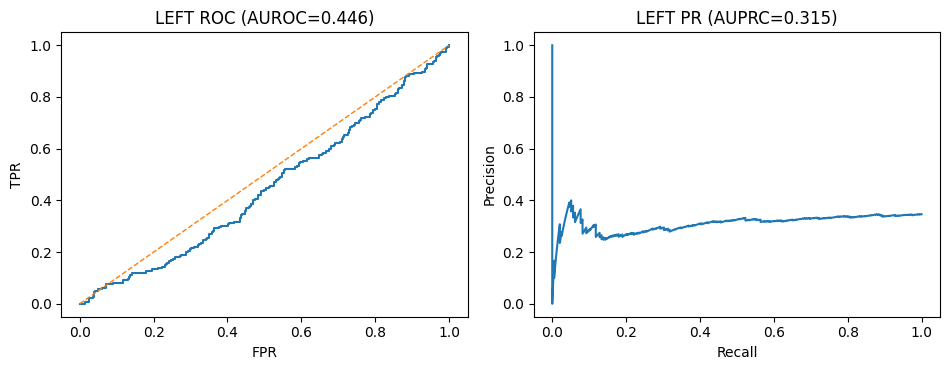

BEFORE LEFT: AUROC=0.446 CI[0.398,0.497]  AUPRC=0.315 CI[0.272,0.370]  (rest=368, target=195)


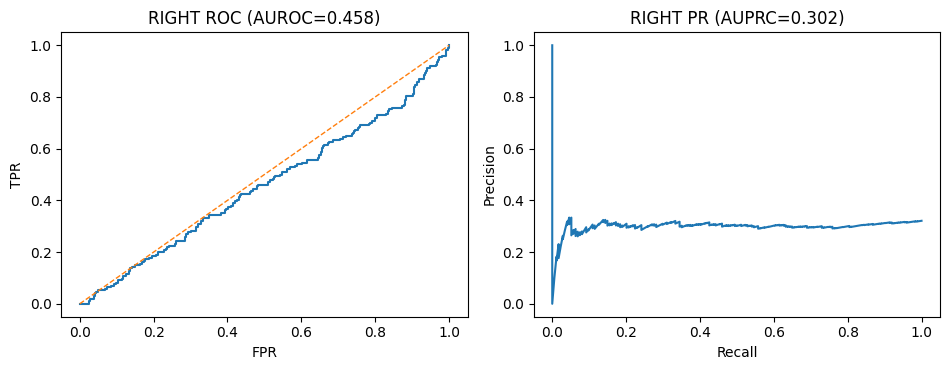

BEFORE RIGHT: AUROC=0.458 CI[0.404,0.511]  AUPRC=0.302 CI[0.256,0.362]  (rest=368, target=174)
[after] S001R01.edf: kept=121
[after] excluding S001R02.edf
[after] S001R03.edf: kept=249


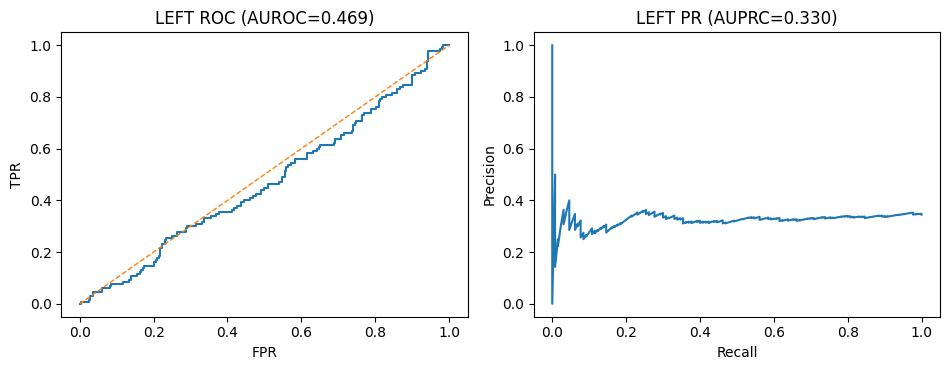

AFTER  LEFT: AUROC=0.469 CI[0.406,0.533]  AUPRC=0.330 CI[0.275,0.408]  (rest=247, target=130)


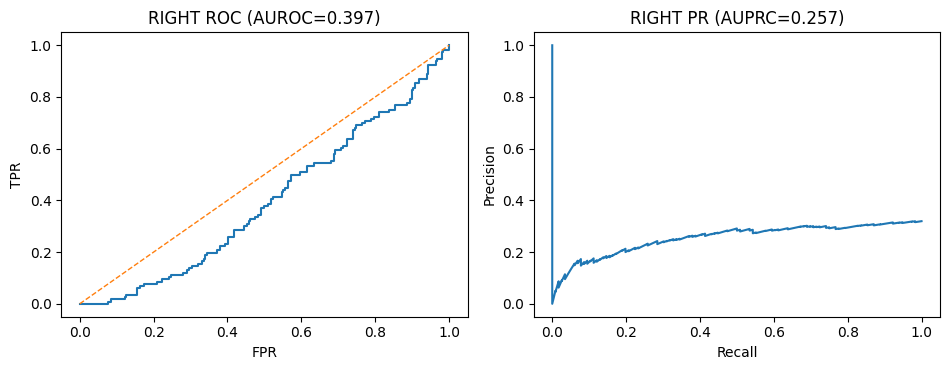

AFTER  RIGHT: AUROC=0.397 CI[0.334,0.457]  AUPRC=0.257 CI[0.215,0.315]  (rest=247, target=116)
[saved] out\cnt_eeg_novelty_beforeafter_FIXED.json


In [36]:
# CNT EEG — FIXED before/after novelty: keep fixed channel set (no per-window channel dropping)
# A) BEFORE: baseline pipeline you used
# B) AFTER: exclude S001R02.edf + 8–30 Hz band-pass + 60 Hz notch (NO channel dropping)
# Leakage-free novelty (REST-only), Riemann mean transport, pooled across REST rotations.
# Outputs:
#   out/cnt_eeg_novelty_beforeafter_FIXED.json
#   out/cnt_eeg_novelty_before_LEFT.png / _RIGHT.png
#   out/cnt_eeg_novelty_after_LEFT.png  / _RIGHT.png

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)

ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
NAME_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
SM_CHS   = ["C3","Cz","C4"]          # fixed set to avoid dimension drift
WIN_LEN, WIN_STEP, MIN_OVERLAP_FRAC = 1.0, 0.5, 0.10
CONTAM = 0.03
# denoise config
BANDPASS = (8.0, 30.0)               # Hz
NOTCH    = 60.0                      # Hz (set None to skip)
EXCLUDE_FILE = "S001R02.edf"         # file to exclude in AFTER; set None to keep

# ---------- generic helpers ----------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs  = float(raw.info["sfreq"]); data = raw.get_data()
    anno=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0 = int(round(on*fs)); du = du if du and du>0 else WIN_LEN; s1 = s0+int(round(du*fs))
            anno.append((max(0,s0), max(0,s1), str(de)))
    return raw, data, fs, anno

def pick_sm(raw):
    have = raw.info["ch_names"]
    # keep only common subset (C3,Cz,C4) that exists in this file
    picks = [c for c in SM_CHS if c in have]
    return mne.pick_channels(have, include=picks)

def windows(n_t, fs):
    W = max(int(WIN_LEN*fs), 16); S = max(int(WIN_STEP*fs), 1)
    return [(s, s+W) for s in range(0, max(1, n_t-W+1), S) if s+W <= n_t]

def label_overlap(si, ei, anno):
    best, name = 0, None; w = ei-si
    for s0,s1,de in anno:
        ol = max(0, min(ei,s1) - max(si,s0))
        if ol > best: best, name = ol, de
    return NAME_MAP.get(str(name)) if (name and best/max(1,w)>=MIN_OVERLAP_FRAC) else None

# spectral/time extras
def welch_bp(seg, fs, band):
    f,Pxx = welch(seg, fs=fs, nperseg=min(256, seg.shape[-1]), axis=-1)
    m=(f>=band[0])&(f<=band[1]); return float(Pxx[...,m].mean())

def hjorth(seg):
    def _h(x):
        dx=np.diff(x); ddx=np.diff(dx)
        v0=np.var(x); v1=np.var(dx); v2=np.var(ddx) if len(ddx) else 0
        mob=np.sqrt(v1/(v0+1e-12)); cplx=np.sqrt((v2/(v1+1e-12))/(v1/(v0+1e-12)+1e-12))
        return mob,cplx
    vals=np.array([_h(seg[i]) for i in range(seg.shape[0])])
    return float(vals[:,0].mean()), float(vals[:,1].mean())

def asym(seg, fs, names, L="C3", R="C4", band=(8,13)):
    if L in names and R in names:
        li,ri = names.index(L), names.index(R)
        aL = welch_bp(seg[li:li+1], fs, band); aR = welch_bp(seg[ri:ri+1], fs, band)
        return float((aL-aR)/(aL+aR+1e-12))
    return 0.0

# SPD ops
def cov_shrink(seg):
    X=seg - seg.mean(axis=1, keepdims=True)
    C=(X@X.T)/max(1, X.shape[1]-1)
    d=np.diag(C); a=0.1
    return (1-a)*C + a*np.diag(d.mean()*np.ones_like(d))

def spd_eigh(C): ev,V = eigh(C); ev=np.clip(ev, 1e-12, None); return ev,V
def spd_pow(C, p): ev,V=spd_eigh(C); return V @ np.diag(ev**p) @ V.T
def logeuclid_vec(C):
    ev,V = spd_eigh(C); L=V@np.diag(np.log(ev))@V.T
    idx=np.triu_indices_from(L); return L[idx]
def riemann_mean(Cs):
    n = Cs[0].shape[0]; idx = np.triu_indices(n)
    Ls = [logeuclid_vec(C) for C in Cs]
    Lm = np.mean(np.vstack(Ls), axis=0)
    L  = np.zeros((n,n)); L[idx]=Lm; L=(L+L.T)-np.diag(np.diag(L))
    ev,V = eigh(L); return V@np.diag(np.exp(ev))@V.T
def transport_to_train(C, G_te, G_tr):
    Wte = spd_pow(G_te, -0.5); Wtr = spd_pow(G_tr, 0.5)
    return Wtr @ (Wte @ C @ Wte) @ Wtr

# fixed-channel scalar extras
def scalar_extras(seg, fs, names):
    mu   = welch_bp(seg, fs, (8,13))
    beta = welch_bp(seg, fs, (13,30))
    mob, cplx = hjorth(seg)
    aA = asym(seg, fs, names, band=(8,13))
    aB = asym(seg, fs, names, band=(13,30))
    return np.array([mu,beta,mob,cplx,aA,aB], dtype=float)

# filtering helpers (apply ONCE per file on the fixed channel set)
def bandpass_notch(data, fs):
    # band-pass
    b,a = butter(4, [BANDPASS[0]/(fs/2), BANDPASS[1]/(fs/2)], btype='band')
    y = filtfilt(b,a,data,axis=-1)
    if NOTCH:
        b2,a2 = iirnotch(w0=NOTCH/(fs/2), Q=30)
        y = filtfilt(b2,a2,y,axis=-1)
    return y

# collect windows -> list of dicts {file,label,C,scalars} ; variant 'before' or 'after'
def collect_windows(variant="before"):
    rows=[]
    for p in list_edfs(ROOT):
        if variant=="after" and EXCLUDE_FILE and p.name==EXCLUDE_FILE:
            print(f"[after] excluding {p.name}"); continue
        raw,data,fs,anno = load_edf(p)
        picks = pick_sm(raw)
        if len(picks) < 2:
            print(f"[{variant}] {p.name}: missing motor channels, skipping")
            continue
        names = [raw.info["ch_names"][i] for i in (picks if isinstance(picks,list) else list(picks))]
        # fixed-channel data for this file
        X = data[picks, :]
        if variant=="after":
            X = bandpass_notch(X, fs)   # filter once per file (keeps channel count fixed)

        kept=0
        for si,ei in windows(X.shape[1], fs):
            lab = label_overlap(si, ei, anno)
            if not lab: continue
            seg = X[:, si:ei]
            if seg.shape[1] < 16: continue
            C = cov_shrink(seg)
            rows.append({"file":p.name, "label":lab, "C":C, "scalars": scalar_extras(seg, fs, names)})
            kept += 1
        print(f"[{variant}] {p.name}: kept={kept}")
    return pd.DataFrame(rows)

def stack_after_transport(sub_df, G_te, G_tr):
    X=[]
    for _,row in sub_df.iterrows():
        Ca = transport_to_train(row["C"], G_te, G_tr)
        v  = logeuclid_vec(Ca)
        X.append(np.concatenate([v, row["scalars"]]))
    return np.vstack(X)

def pooled_novelty(df):
    files_by_label = {lab: sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
    if "rest" not in files_by_label or len(files_by_label["rest"])<2:
        return None, None
    targets={}
    for lab in ["left","right"]:
        if lab in files_by_label and files_by_label[lab]:
            sizes = [(f, int((df["file"]==f).sum())) for f in files_by_label[lab]]
            targets[lab] = sorted(sizes, key=lambda t:t[1], reverse=True)[0][0]
    pooled = {"left":{"y":[],"z":[]}, "right":{"y":[],"z":[]}}
    rest_files = files_by_label["rest"]
    for rest_test in rest_files:
        rest_train = [f for f in rest_files if f!=rest_test]
        if not rest_train: continue
        # Riemann means from REST only
        Cs_tr = df[(df["file"].isin(rest_train)) & (df["label"]=="rest")]["C"].tolist()
        Cs_te = df[(df["file"]==rest_test) & (df["label"]=="rest")]["C"].tolist()
        if not Cs_tr or not Cs_te: continue
        G_tr = riemann_mean(Cs_tr); G_te = riemann_mean(Cs_te)
        Xr_tr = stack_after_transport(df[(df["file"].isin(rest_train)) & (df["label"]=="rest")], G_te, G_tr)
        Xr_te = stack_after_transport(df[(df["file"]==rest_test) & (df["label"]=="rest")], G_te, G_tr)
        if len(Xr_tr)<10 or len(Xr_te)<10: continue
        sc = StandardScaler().fit(Xr_tr)
        mdl = IsolationForest(n_estimators=400, contamination=CONTAM, random_state=42).fit(sc.transform(Xr_tr))
        s_rest = mdl.score_samples(sc.transform(Xr_te)).ravel()
        for lab in ["left","right"]:
            if lab not in targets: continue
            Xt = stack_after_transport(df[(df["file"]==targets[lab]) & (df["label"]==lab)], G_te, G_tr)
            s_tar = mdl.score_samples(sc.transform(Xt)).ravel()
            y = np.concatenate([np.zeros_like(s_rest), np.ones_like(s_tar)])
            z = np.concatenate([-s_rest, -s_tar])
            pooled[lab]["y"].append(y); pooled[lab]["z"].append(z)
    out={}
    for lab in ["left","right"]:
        if pooled[lab]["y"]:
            out[lab] = {"y": np.concatenate(pooled[lab]["y"]),
                        "z": np.concatenate(pooled[lab]["z"])}
        else:
            out[lab] = None
    return out, targets

def bootstrap_ci(y, z, n=2000, seed=12345):
    rng=np.random.default_rng(seed); nobs=len(y)
    if nobs<5: return (np.nan,np.nan),(np.nan,np.nan)
    au, ap = [], []
    idx=np.arange(nobs)
    for _ in range(n):
        s=rng.choice(idx, size=nobs, replace=True)
        try:
            au.append(roc_auc_score(y[s], z[s]))
            ap.append(average_precision_score(y[s], z[s]))
        except Exception:
            pass
    return (float(np.percentile(au,2.5)),float(np.percentile(au,97.5))), (float(np.percentile(ap,2.5)),float(np.percentile(ap,97.5)))

def summarize(tag, lab, pooled_dict):
    y=pooled_dict["y"]; z=pooled_dict["z"]
    auroc=float(roc_auc_score(y,z)); auprc=float(average_precision_score(y,z))
    ci_roc, ci_pr = bootstrap_ci(y,z)
    print(f"{tag} {lab.upper()}: AUROC={auroc:.3f} CI[{ci_roc[0]:.3f},{ci_roc[1]:.3f}]  "
          f"AUPRC={auprc:.3f} CI[{ci_pr[0]:.3f},{ci_pr[1]:.3f}]  "
          f"(rest={int((y==0).sum())}, target={int((y==1).sum())})")
    return {"auroc": auroc, "auroc_ci95": list(ci_roc),
            "auprc": auprc, "auprc_ci95": list(ci_pr),
            "n": int(len(y)), "rest": int((y==0).sum()), "target": int((y==1).sum())}

def plot_curves(label, pooled_dict, fname):
    y=pooled_dict["y"]; z=pooled_dict["z"]
    fpr,tpr,_ = roc_curve(y,z); prec,rec,_ = precision_recall_curve(y,z)
    au=float(roc_auc_score(y,z)); ap=float(average_precision_score(y,z))
    plt.figure(figsize=(9.6,3.8))
    plt.subplot(1,2,1); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--',lw=1); plt.title(f"{label.upper()} ROC (AUROC={au:.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.subplot(1,2,2); plt.plot(rec,prec); plt.title(f"{label.upper()} PR (AUPRC={ap:.3f})"); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.tight_layout(); fig_path = Path("out")/fname; plt.savefig(fig_path, dpi=160); plt.show()
    return str(fig_path)

# ===== BEFORE =====
df_before = collect_windows("before")
pooled_A, targets = pooled_novelty(df_before)
report = {"mode":"novelty_before_after_FIXED", "targets": targets, "before":{}, "after":{}}

if pooled_A["left"] is not None:
    plot_curves("left",  pooled_A["left"],  "cnt_eeg_novelty_before_LEFT.png")
    report["before"]["left"]  = summarize("BEFORE", "left",  pooled_A["left"])
if pooled_A["right"] is not None:
    plot_curves("right", pooled_A["right"], "cnt_eeg_novelty_before_RIGHT.png")
    report["before"]["right"] = summarize("BEFORE", "right", pooled_A["right"])

# ===== AFTER (denoise + exclusion, no channel dropping) =====
df_after = collect_windows("after")
pooled_B, _ = pooled_novelty(df_after)

if pooled_B["left"] is not None:
    plot_curves("left",  pooled_B["left"],  "cnt_eeg_novelty_after_LEFT.png")
    report["after"]["left"]  = summarize("AFTER ", "left",  pooled_B["left"])
if pooled_B["right"] is not None:
    plot_curves("right", pooled_B["right"], "cnt_eeg_novelty_after_RIGHT.png")
    report["after"]["right"] = summarize("AFTER ", "right", pooled_B["right"])

# save
out_json = Path("out")/"cnt_eeg_novelty_beforeafter_FIXED.json"
with open(out_json,"w",encoding="utf-8") as f: json.dump(report, f, indent=2)
print(f"[saved] {out_json}")


In [37]:
# CNT EEG — LOFC (leave-one-file-per-class-out) supervised benchmark
# Models: (1) Riemann Tangent-Space + LR  (2) CSP + LR (if available)
# Leakage-free: test fold = one file per class; train fold = all other files.
# Saves: out/cnt_eeg_lofc_supervised_report.json, out/cnt_eeg_lofc_confmat_<model>.png

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings("ignore")
Path("out").mkdir(parents=True, exist_ok=True)

# -------- configuration --------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
NAME_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
SM_CHS   = ["C3","Cz","C4"]        # fixed motor set
BP = (8., 30.)                     # band-pass for CSP & segments
NOTCH = 60.0                       # Hz notch (set None to skip)
WIN_LEN = 1.0                      # s
WIN_STEP = 0.5                     # s
MIN_OVERLAP_FRAC = 0.10            # event label overlap threshold
N_CSP = 4                          # CSP spatial filters (if available)

# -------- io & labeling --------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs  = float(raw.info["sfreq"]); data = raw.get_data()
    anno=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0 = int(round(on*fs)); du = du if du and du>0 else WIN_LEN; s1 = s0+int(round(du*fs))
            anno.append((max(0,s0), max(0,s1), str(de)))
    return raw, data, fs, anno

def pick_fixed_motor(raw):
    have = raw.info["ch_names"]
    picks = [c for c in SM_CHS if c in have]
    return mne.pick_channels(have, include=picks)

def windows(n_t, fs, w=WIN_LEN, s=WIN_STEP):
    W = max(int(w*fs), 16); S = max(int(s*fs), 1)
    return [(i, i+W) for i in range(0, max(1, n_t-W+1), S) if i+W <= n_t]

def label_by_overlap(si, ei, anno, min_frac=MIN_OVERLAP_FRAC):
    best, name = 0, None; w = ei-si
    for s0,s1,de in anno:
        ol = max(0, min(ei,s1) - max(si,s0))
        if ol > best: best, name = ol, de
    return NAME_MAP.get(str(name)) if (name and best/max(1,w)>=min_frac) else None

# -------- filtering --------
def bp_notch(seg, fs):
    # seg: (n_ch, n_t)
    b,a = butter(4, [BP[0]/(fs/2), BP[1]/(fs/2)], btype='band')
    y = filtfilt(b,a,seg,axis=-1)
    if NOTCH:
        b2,a2 = iirnotch(w0=NOTCH/(fs/2), Q=30)
        y = filtfilt(b2,a2,y,axis=-1)
    return y

# -------- SPD ops for tangent space --------
def cov_shrink(seg):
    # seg demeaned covariance with slight diagonal loading via mean-var shrinkage
    X = seg - seg.mean(axis=1, keepdims=True)
    C = (X @ X.T) / max(1, X.shape[1]-1)
    d = np.diag(C); a = 0.1
    return (1-a)*C + a*np.diag(d.mean()*np.ones_like(d))

def spd_eigh(C): ev,V = eigh(C); ev=np.clip(ev, 1e-12, None); return ev,V
def spd_pow(C, p): ev,V = spd_eigh(C); return V @ np.diag(ev**p) @ V.T
def logm_at(G, C):
    # Log map at reference G: T = Log( G^{-1/2} C G^{-1/2} ), then vectorize upper triangle
    W = spd_pow(G, -0.5)
    Z = W @ C @ W.T
    ev,V = spd_eigh(Z)
    L = V @ np.diag(np.log(ev)) @ V.T
    idx = np.triu_indices_from(L)
    return L[idx]

# -------- build windowed dataset --------
records = []  # each: dict(file, label, seg) with seg shape (n_ch, n_t)
files = list_edfs(ROOT)
if not files:
    raise RuntimeError(f"No EDF files found under {ROOT}")

for p in files:
    raw,data,fs,anno = load_edf(p)
    picks = pick_fixed_motor(raw)
    if len(picks) < 2:
        print(f"[skip] {p.name}: missing C3/Cz/C4")
        continue
    X = bp_notch(data[picks], fs)  # filter once per file
    for si,ei in windows(X.shape[1], fs):
        lab = label_by_overlap(si,ei,anno)
        if not lab: continue
        seg = X[:, si:ei]
        if seg.shape[1] < 16: continue
        records.append({"file": p.name, "label": lab, "seg": seg, "fs": fs})

df = pd.DataFrame(records)
if df.empty:
    raise RuntimeError("No labeled windows produced. Check annotations or MIN_OVERLAP_FRAC.")

# -------- ensure ≥2 files per class (rest/left/right) --------
files_by_label = {lab: sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
need = [k for k in ["rest","left","right"] if k not in files_by_label or len(files_by_label[k]) < 2]
report = {"status": "ok", "note": "", "files_per_label": {k: len(v) if k in files_by_label else 0 for k,v in files_by_label.items()}}

if need:
    report["status"] = "insufficient_files"
    report["note"] = f"LOFC requires ≥2 files per class. Missing: {need}"
    out_json = Path("out")/"cnt_eeg_lofc_supervised_report.json"
    with open(out_json,"w",encoding="utf-8") as f: json.dump(report, f, indent=2)
    print(f"[insufficient] {report['note']}  → wrote {out_json}")
else:
    # -------- build LOFC folds: i-th file per class is test; others train --------
    # Align list lengths by min count across classes
    k_min = min(len(files_by_label["rest"]), len(files_by_label["left"]), len(files_by_label["right"]))
    folds = []
    for i in range(k_min):
        te_files = { "rest": files_by_label["rest"][i],
                     "left": files_by_label["left"][i],
                     "right": files_by_label["right"][i] }
        te_mask = df["file"].isin(te_files.values())
        tr_mask = ~te_mask
        # sanity: make sure all classes appear in train & test
        if set(df[tr_mask]["label"].unique()) >= {"rest","left","right"} and \
           set(df[te_mask]["label"].unique())  >= {"rest","left","right"}:
            folds.append((tr_mask, te_mask, te_files))
    if not folds:
        report["status"]="no_valid_folds"
        out_json = Path("out")/"cnt_eeg_lofc_supervised_report.json"
        with open(out_json,"w",encoding="utf-8") as f: json.dump(report, f, indent=2)
        print(f"[no-folds] Could not form LOFC folds even though counts ≥2 → wrote {out_json}")
    else:
        # -------- Feature builders per fold --------
        def make_tangent_features(df_part, G_ref):
            X = []
            for _,row in df_part.iterrows():
                C = cov_shrink(row["seg"])
                v = logm_at(G_ref, C)                     # tangent vector at train mean
                X.append(v)
            return np.vstack(X)

        # CSP requires mne.decoding.CSP
        HAVE_CSP = hasattr(mne.decoding, "CSP")

        # containers
        results = {"tangent_LR": {}, "CSP_LR": {"note": ""}}
        all_models = []

        # OOF buffers
        y_names = sorted(["rest","left","right"])
        y_to_int = {c:i for i,c in enumerate(y_names)}
        oof = {
            "tangent": {"prob": [], "true": [], "pred": []},
            "csp":     {"prob": [], "true": [], "pred": []} if HAVE_CSP else None
        }

        # -------- run LOFC folds --------
        for fold_id,(tr_mask, te_mask, te_files) in enumerate(folds, start=1):
            df_tr = df[tr_mask].reset_index(drop=True)
            df_te = df[te_mask].reset_index(drop=True)

            # ----- Tangent-space + LR -----
            # Reference: Riemann mean of training covariances
            Cs_tr = [cov_shrink(s) for s in df_tr["seg"]]
            # compute mean in log-Euclidean sense
            n = Cs_tr[0].shape[0]; idx = np.triu_indices(n)
            logs = []
            for C in Cs_tr:
                ev,V = eigh(C); ev=np.clip(ev,1e-12,None)
                L = V @ np.diag(np.log(ev)) @ V.T
                logs.append(L[idx])
            Lm = np.mean(np.vstack(logs), axis=0)
            Lmat = np.zeros((n,n)); Lmat[idx]=Lm; Lmat=(Lmat+Lmat.T)-np.diag(np.diag(Lmat))
            ev,V = eigh(Lmat); G_ref = V @ np.diag(np.exp(ev)) @ V.T

            Xtr = make_tangent_features(df_tr, G_ref)
            Xte = make_tangent_features(df_te, G_ref)
            ytr = df_tr["label"].map(y_to_int).to_numpy()
            yte = df_te["label"].map(y_to_int).to_numpy()

            sc = StandardScaler().fit(Xtr)
            Xtr_s = sc.transform(Xtr); Xte_s = sc.transform(Xte)
            lr = LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
            lr.fit(Xtr_s, ytr)
            P  = lr.predict_proba(Xte_s); yhat = lr.predict(Xte_s)

            oof["tangent"]["prob"].append(P); oof["tangent"]["true"].append(yte); oof["tangent"]["pred"].append(yhat)

            # ----- CSP + LR (optional) -----
            if HAVE_CSP:
                try:
                    # Prepare 3D arrays (n_trials, n_ch, n_t)
                    def pack(df_):
                        X = np.stack(df_["seg"].to_numpy(), axis=0)
                        y = df_["label"].map(y_to_int).to_numpy()
                        return X, y
                    Xtr3, ytr3 = pack(df_tr); Xte3, yte3 = pack(df_te)

                    # For multiclass: fit CSP one-vs-rest by recoding labels per class and concatenating features
                    from mne.decoding import CSP
                    csp_feats_tr = []; csp_feats_te = []
                    for cls, cls_id in y_to_int.items():
                        y_bin_tr = (ytr3 == cls_id).astype(int)
                        y_bin_te = (yte3 == cls_id).astype(int)
                        csp = CSP(n_components=N_CSP, reg='ledoit_wolf', log=True, norm_trace=False)
                        csp.fit(Xtr3, y_bin_tr)
                        csp_feats_tr.append(csp.transform(Xtr3))
                        csp_feats_te.append(csp.transform(Xte3))
                    Xtr_csp = np.concatenate(csp_feats_tr, axis=1)
                    Xte_csp = np.concatenate(csp_feats_te, axis=1)

                    sc2 = StandardScaler().fit(Xtr_csp)
                    lr2 = LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
                    lr2.fit(sc2.transform(Xtr_csp), ytr3)
                    P2  = lr2.predict_proba(sc2.transform(Xte_csp)); yhat2 = lr2.predict(sc2.transform(Xte_csp))

                    if oof["csp"] is not None:
                        oof["csp"]["prob"].append(P2); oof["csp"]["true"].append(yte3); oof["csp"]["pred"].append(yhat2)
                except Exception as e:
                    results["CSP_LR"]["note"] = f"Skipped CSP on fold {fold_id}: {e}"
                    oof["csp"] = None  # disable for rest of run

        # -------- aggregate & score --------
        def finalize(model_key, prob_list, true_list, pred_list, tag_png):
            P = np.vstack(prob_list); y = np.concatenate(true_list); yhat = np.concatenate(pred_list)
            # AUROC (weighted & macro) for multiclass
            au_weighted = roc_auc_score(y, P, multi_class="ovr", average="weighted")
            au_macro    = roc_auc_score(y, P, multi_class="ovr", average="macro")
            acc         = accuracy_score(y, yhat)
            cm          = confusion_matrix(y, yhat, labels=np.arange(len(y_names)))
            rep_txt     = classification_report(y, yhat, target_names=y_names, digits=3)

            # plot confusion
            fig, ax = plt.subplots(figsize=(5.4,4.8))
            im = ax.imshow(cm, cmap="Blues")
            ax.set_xticks(range(len(y_names))); ax.set_yticks(range(len(y_names)))
            ax.set_xticklabels(y_names, rotation=30, ha="right"); ax.set_yticklabels(y_names)
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax.text(j, i, int(cm[i,j]), ha="center", va="center")
            ax.set_title(f"LOFC Confusion — {tag_png}")
            ax.set_xlabel("Predicted"); ax.set_ylabel("True")
            plt.tight_layout()
            fig_path = Path("out")/f"cnt_eeg_lofc_confmat_{tag_png}.png"
            plt.savefig(fig_path, dpi=160); plt.show()

            return {
                "auroc_weighted": float(au_weighted),
                "auroc_macro": float(au_macro),
                "accuracy": float(acc),
                "confusion_matrix": cm.tolist(),
                "classification_report": rep_txt,
                "figure": str(fig_path)
            }

        results["tangent_LR"] = finalize("tangent",
                                         oof["tangent"]["prob"], oof["tangent"]["true"], oof["tangent"]["pred"],
                                         "tangentLR")

        if oof["csp"] is not None and len(oof["csp"]["prob"])>0:
            results["CSP_LR"].update(finalize("csp",
                                              oof["csp"]["prob"], oof["csp"]["true"], oof["csp"]["pred"],
                                              "CSP_LR"))
        else:
            results["CSP_LR"]["note"] = results["CSP_LR"].get("note","CSP not available or failed.")

        # -------- save report --------
        report.update({
            "status": "ok",
            "folds": len(folds),
            "classes": y_names,
            "files_per_label": {k: len(v) for k,v in files_by_label.items()},
            "results": results
        })
        out_json = Path("out")/"cnt_eeg_lofc_supervised_report.json"
        with open(out_json,"w",encoding="utf-8") as f: json.dump(report, f, indent=2)
        print(f"=== LOFC (supervised, leakage-free) ===")
        print("Tangents + LR:", {k: round(v,3) if isinstance(v,(int,float)) else "..." for k,v in results["tangent_LR"].items() if k in ("auroc_weighted","auroc_macro","accuracy")})
        if "auroc_weighted" in results["CSP_LR"]:
            print("CSP + LR     :", {k: round(v,3) if isinstance(v,(int,float)) else "..." for k,v in results["CSP_LR"].items() if k in ("auroc_weighted","auroc_macro","accuracy")})
        else:
            print("CSP + LR     :", results["CSP_LR"]["note"])
        print(f"[saved] {out_json}")


[insufficient] LOFC requires ≥2 files per class. Missing: ['left', 'right']  → wrote out\cnt_eeg_lofc_supervised_report.json


[scan] S001R01.edf: kept=121
[scan] S001R02.edf: kept=121
[scan] S001R03.edf: kept=249
[info] LOFC not possible. Need more files for: ['left', 'right']. Running leakage-free novelty fallback.


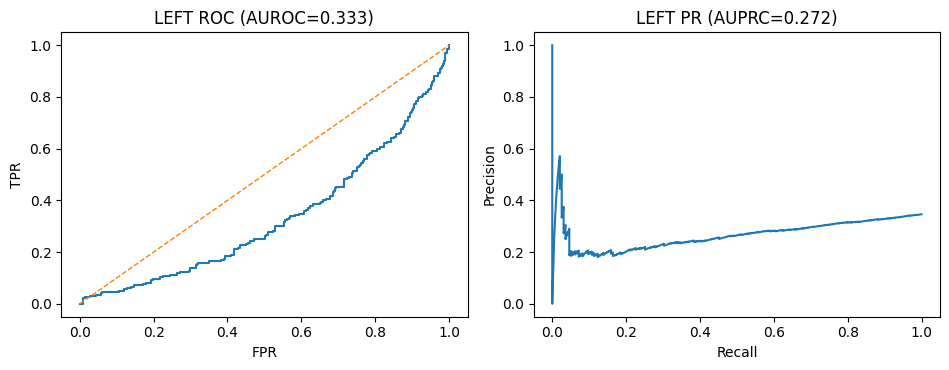

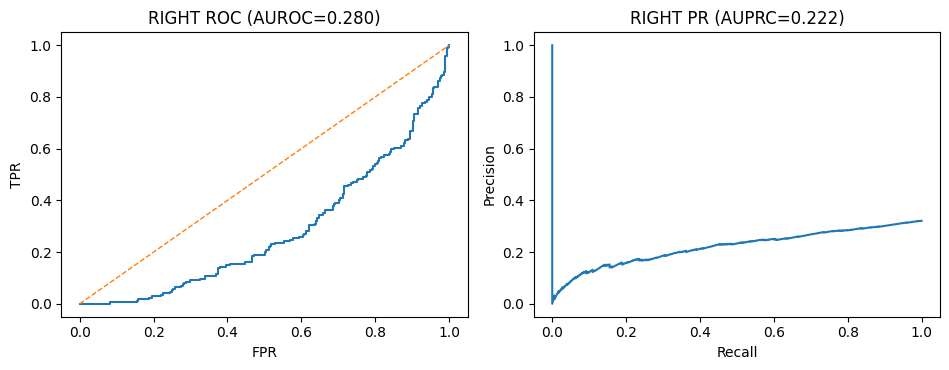

=== Novelty fallback complete (leakage-free) ===
{
  "left": {
    "auroc": 0.3331243032329989,
    "auprc": 0.2723295207927563,
    "figure": "out\\cnt_eeg_novelty_continue_LEFT.png",
    "n": 563,
    "rest": 368,
    "target": 195
  },
  "right": {
    "auroc": 0.28020364817591203,
    "auprc": 0.22199765296106377,
    "figure": "out\\cnt_eeg_novelty_continue_RIGHT.png",
    "n": 542,
    "rest": 368,
    "target": 174
  }
}
[saved] out\cnt_eeg_continue_novelty_report.json


In [38]:
# CNT EEG — Continue Pipeline (auto LOFC supervised if ready; else leakage-free novelty fallback)
# - Crawls EDFs under brainwaves/
# - Labels windows by annotation overlap (T0/T1/T2/T3 → rest/left/right/both)
# - If ≥2 files per class: LOFC (file-wise) with Tangent-LR and CSP-LR
# - Else: leakage-free novelty (REST-only train, pooled across REST rotations)
# - Saves clean JSON + figures in ./out

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (roc_auc_score, accuracy_score, confusion_matrix,
                             classification_report, roc_curve, precision_recall_curve,
                             average_precision_score)

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------------- CONFIG ----------------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
NAME_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}  # edit if your tags differ
SM_CHS   = ["C3","Cz","C4"]    # strict motor set
WIN_LEN, WIN_STEP = 1.0, 0.5   # seconds
MIN_OVERLAP_FRAC  = 0.10
BP = (8., 30.)                 # band-pass for all models
NOTCH = 60.0                   # Hz (set None to skip)
N_CSP = 4                      # CSP components per class (if available)
CONTAM = 0.03                  # novelty contamination

# ---------------- I/O & LABELING ----------------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs  = float(raw.info["sfreq"]); data = raw.get_data()
    anno=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0 = int(round(on*fs)); du = du if du and du>0 else WIN_LEN; s1 = s0+int(round(du*fs))
            anno.append((max(0,s0), max(0,s1), str(de)))
    return raw, data, fs, anno

def pick_motor(raw):
    have = raw.info["ch_names"]
    picks = [c for c in SM_CHS if c in have]
    return mne.pick_channels(have, include=picks)

def windows(n_t, fs, w=WIN_LEN, s=WIN_STEP):
    W = max(int(w*fs), 16); S = max(int(s*fs), 1)
    return [(i, i+W) for i in range(0, max(1, n_t-W+1), S) if i+W <= n_t]

def label_by_overlap(si, ei, anno, frac=MIN_OVERLAP_FRAC):
    best, name = 0, None; w = ei-si
    for s0,s1,de in anno:
        ol = max(0, min(ei,s1) - max(si,s0))
        if ol > best: best, name = ol, de
    return NAME_MAP.get(str(name)) if (name and best/max(1,w)>=frac) else None

# ---------------- FILTERING ----------------
def bp_notch(seg, fs):
    # seg: (n_ch, n_t) — filter once per file to keep channel count fixed
    b,a = butter(4, [BP[0]/(fs/2), BP[1]/(fs/2)], btype='band')
    y = filtfilt(b,a,seg,axis=-1)
    if NOTCH:
        b2,a2 = iirnotch(w0=NOTCH/(fs/2), Q=30)
        y = filtfilt(b2,a2,y,axis=-1)
    return y

# ---------------- SPD (covariance) ops ----------------
def cov_shrink(seg):
    X=seg - seg.mean(axis=1, keepdims=True)
    C=(X@X.T)/max(1, X.shape[1]-1)
    d=np.diag(C); a=0.1
    return (1-a)*C + a*np.diag(d.mean()*np.ones_like(d))

def spd_eigh(C): ev,V = eigh(C); ev=np.clip(ev, 1e-12, None); return ev,V
def spd_pow(C, p): ev,V = spd_eigh(C); return V @ np.diag(ev**p) @ V.T
def logm_at(G, C):
    W = spd_pow(G, -0.5); Z = W @ C @ W.T
    ev,V = spd_eigh(Z); L = V @ np.diag(np.log(ev)) @ V.T
    idx = np.triu_indices_from(L); return L[idx]
def riemann_mean_from_covs(Cs):
    n = Cs[0].shape[0]; idx = np.triu_indices(n)
    logs = []
    for C in Cs:
        ev,V = eigh(C); ev=np.clip(ev,1e-12,None)
        L = V @ np.diag(np.log(ev)) @ V.T
        logs.append(L[idx])
    Lm = np.mean(np.vstack(logs), axis=0)
    L  = np.zeros((n,n)); L[idx]=Lm; L=(L+L.T)-np.diag(np.diag(L))
    ev,V = eigh(L); return V @ np.diag(np.exp(ev)) @ V.T

# ---------------- Feature extras (for novelty) ----------------
def welch_bp(seg, fs, band):
    f,Pxx = welch(seg, fs=fs, nperseg=min(256, seg.shape[-1]), axis=-1)
    m=(f>=band[0])&(f<=band[1]); return float(Pxx[...,m].mean())
def hjorth(seg):
    def _h(x):
        dx=np.diff(x); ddx=np.diff(dx)
        v0=np.var(x); v1=np.var(dx); v2=np.var(ddx) if len(ddx) else 0
        mob=np.sqrt(v1/(v0+1e-12)); cplx=np.sqrt((v2/(v1+1e-12))/(v1/(v0+1e-12)+1e-12))
        return mob,cplx
    vals=np.array([_h(seg[i]) for i in range(seg.shape[0])]); return float(vals[:,0].mean()), float(vals[:,1].mean())
def asym(seg, fs, names, L="C3", R="C4", band=(8,13)):
    if L in names and R in names:
        li,ri=names.index(L),names.index(R)
        aL=welch_bp(seg[li:li+1],fs,band); aR=welch_bp(seg[ri:ri+1],fs,band)
        return float((aL-aR)/(aL+aR+1e-12))
    return 0.0
def scalar_extras(seg, fs, names):
    mu   = welch_bp(seg, fs, (8,13))
    beta = welch_bp(seg, fs, (13,30))
    mob,cplx = hjorth(seg)
    aA = asym(seg, fs, names, band=(8,13))
    aB = asym(seg, fs, names, band=(13,30))
    return np.array([mu,beta,mob,cplx,aA,aB], dtype=float)

# ---------------- Build windowed dataset ----------------
records=[]
files=list_edfs(ROOT)
if not files:
    raise RuntimeError(f"No EDF files under {ROOT}")

for p in files:
    raw,data,fs,anno = load_edf(p)
    picks = pick_motor(raw)
    if len(picks) < 2:
        print(f"[skip] {p.name}: motor channels missing"); continue
    X = bp_notch(data[picks], fs)  # filter once per file, fixed channel count
    names=[raw.info["ch_names"][i] for i in (picks if isinstance(picks,list) else list(picks))]
    kept=0
    for si,ei in windows(X.shape[1], fs):
        lab = label_by_overlap(si,ei,anno)
        if not lab: continue
        seg = X[:, si:ei]
        if seg.shape[1] < 16: continue
        records.append({"file":p.name, "label":lab, "seg":seg, "fs":fs, "names":names})
        kept+=1
    print(f"[scan] {p.name}: kept={kept}")

df = pd.DataFrame(records)
if df.empty:
    raise RuntimeError("No labeled windows produced. Check annotations / MIN_OVERLAP_FRAC.")

# ---------------- Decide path: LOFC supervised or novelty fallback ----------------
files_by_label = {lab: sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
need = [k for k in ["rest","left","right"] if k not in files_by_label or len(files_by_label[k])<2]

report = {"mode":"", "files_per_label": {k: len(v) for k,v in files_by_label.items()}}

if not need:
    # ===================== LOFC SUPERVISED =====================
    report["mode"] = "LOFC_supervised"
    y_names = ["rest","left","right"]; y_to_int = {c:i for i,c in enumerate(y_names)}

    # Build LOFC folds by aligned index across classes
    k_min = min(len(files_by_label[c]) for c in y_names)
    folds=[]
    for i in range(k_min):
        te_map = {c: files_by_label[c][i] for c in y_names}
        te_mask = df["file"].isin(te_map.values()); tr_mask = ~te_mask
        if set(df[tr_mask]["label"].unique()) >= set(y_names) and set(df[te_mask]["label"].unique()) >= set(y_names):
            folds.append((tr_mask, te_mask, te_map))

    if not folds:
        print("[warn] No valid LOFC folds could be formed despite counts ≥2; falling back to novelty.")
        need = ["lofc_folding"];  # trigger fallback
    else:
        # --- Tangent-space + LR ---
        def tangent_features(df_part, G_ref):
            X=[]
            for _,r in df_part.iterrows():
                C = cov_shrink(r["seg"])
                v = logm_at(G_ref, C)
                X.append(v)
            return np.vstack(X)

        oof_prob_t, oof_true_t, oof_pred_t = [], [], []
        # Optional CSP
        HAVE_CSP = hasattr(mne.decoding, "CSP")
        if HAVE_CSP:
            oof_prob_c, oof_true_c, oof_pred_c = [], [], []
        csp_note = ""

        for tr_mask, te_mask, te_map in folds:
            df_tr = df[tr_mask].reset_index(drop=True)
            df_te = df[te_mask].reset_index(drop=True)

            # G_ref = Riemann mean of training covariances
            Cs_tr = [cov_shrink(s) for s in df_tr["seg"]]
            G_ref = riemann_mean_from_covs(Cs_tr)

            Xtr = tangent_features(df_tr, G_ref)
            Xte = tangent_features(df_te, G_ref)
            ytr = df_tr["label"].map(y_to_int).to_numpy()
            yte = df_te["label"].map(y_to_int).to_numpy()

            sc = StandardScaler().fit(Xtr)
            lr = LogisticRegression(max_iter=4000, solver="lbfgs",
                                    class_weight="balanced", multi_class="auto")
            lr.fit(sc.transform(Xtr), ytr)
            P = lr.predict_proba(sc.transform(Xte)); yhat = lr.predict(sc.transform(Xte))

            oof_prob_t.append(P); oof_true_t.append(yte); oof_pred_t.append(yhat)

            if HAVE_CSP:
                try:
                    def pack(df_):  # (n_trials,n_ch,n_t)
                        X = np.stack(df_["seg"].to_numpy(), axis=0)
                        y = df_["label"].map(y_to_int).to_numpy()
                        return X, y
                    Xtr3, ytr3 = pack(df_tr); Xte3, yte3 = pack(df_te)
                    from mne.decoding import CSP
                    csp_feats_tr, csp_feats_te = [], []
                    for cls, cls_id in y_to_int.items():
                        yb_tr = (ytr3==cls_id).astype(int); yb_te = (yte3==cls_id).astype(int)
                        csp = CSP(n_components=N_CSP, reg='ledoit_wolf', log=True, norm_trace=False)
                        csp.fit(Xtr3, yb_tr)
                        csp_feats_tr.append(csp.transform(Xtr3))
                        csp_feats_te.append(csp.transform(Xte3))
                    Xtr_csp = np.concatenate(csp_feats_tr, axis=1)
                    Xte_csp = np.concatenate(csp_feats_te, axis=1)
                    sc2 = StandardScaler().fit(Xtr_csp)
                    lr2 = LogisticRegression(max_iter=4000, solver="lbfgs",
                                             class_weight="balanced", multi_class="auto")
                    lr2.fit(sc2.transform(Xtr_csp), ytr3)
                    P2 = lr2.predict_proba(sc2.transform(Xte_csp)); yhat2 = lr2.predict(sc2.transform(Xte_csp))
                    oof_prob_c.append(P2); oof_true_c.append(yte3); oof_pred_c.append(yhat2)
                except Exception as e:
                    csp_note = f"CSP skipped: {e}"
                    HAVE_CSP = False  # disable next folds

        def finalize(prob_list, true_list, pred_list, tag):
            P = np.vstack(prob_list); y = np.concatenate(true_list); yhat = np.concatenate(pred_list)
            au_w = roc_auc_score(y, P, multi_class="ovr", average="weighted")
            au_m = roc_auc_score(y, P, multi_class="ovr", average="macro")
            acc  = accuracy_score(y, yhat)
            cm   = confusion_matrix(y, yhat, labels=np.arange(len(y_names)))
            rep  = classification_report(y, yhat, target_names=y_names, digits=3)
            # plot
            fig, ax = plt.subplots(figsize=(5.4,4.8))
            im = ax.imshow(cm, cmap="Blues")
            ax.set_xticks(range(len(y_names))); ax.set_yticks(range(len(y_names)))
            ax.set_xticklabels(y_names, rotation=30, ha="right"); ax.set_yticklabels(y_names)
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax.text(j, i, int(cm[i,j]), ha="center", va="center")
            ax.set_title(f"LOFC Confusion — {tag}")
            ax.set_xlabel("Predicted"); ax.set_ylabel("True")
            plt.tight_layout()
            fig_path = OUT/f"cnt_eeg_lofc_confmat_{tag}.png"
            plt.savefig(fig_path, dpi=160); plt.show()
            return {"auroc_weighted":float(au_w),"auroc_macro":float(au_m),
                    "accuracy":float(acc),"confusion_matrix":cm.tolist(),
                    "classification_report":rep,"figure":str(fig_path)}

        results = {"tangent_LR":finalize(oof_prob_t,oof_true_t,oof_pred_t,"tangentLR")}
        if 'oof_prob_c' in locals() and len(oof_prob_c)>0:
            results["CSP_LR"] = finalize(oof_prob_c,oof_true_c,oof_pred_c,"CSP_LR")
        else:
            results["CSP_LR"] = {"note": csp_note or "CSP not available or failed."}

        out = {"mode":"LOFC_supervised","files_per_label":report["files_per_label"],
               "folds":len(folds),"classes":y_names,"results":results}
        out_json = OUT/"cnt_eeg_lofc_supervised_report.json"
        with open(out_json,"w",encoding="utf-8") as f: json.dump(out,f,indent=2)
        print("=== LOFC supervised complete ===")
        print("Tangents+LR:", {k:round(v,3) for k,v in results["tangent_LR"].items() if isinstance(v,(int,float))})
        if "auroc_weighted" in results["CSP_LR"]:
            print("CSP+LR    :", {k:round(v,3) for k,v in results["CSP_LR"].items() if isinstance(v,(int,float))})
        else:
            print("CSP+LR    :", results["CSP_LR"]["note"])
        print(f"[saved] {out_json}")

else:
    # ===================== NOVELTY FALLBACK (REST-only, pooled) =====================
    print(f"[info] LOFC not possible. Need more files for: {need}. Running leakage-free novelty fallback.")
    report["mode"] = "novelty_fallback"

    # build pooled predictions across rotating REST test files
    pooled = {"left":{"y":[],"z":[]}, "right":{"y":[],"z":[]}}
    # choose largest target file per class (if present)
    targets={}
    for lab in ["left","right"]:
        if lab in files_by_label and files_by_label[lab]:
            sizes=[(f,int((df["file"]==f).sum())) for f in files_by_label[lab]]
            targets[lab]=sorted(sizes,key=lambda t:t[1],reverse=True)[0][0]

    rest_files = files_by_label.get("rest", [])
    for rest_test in rest_files:
        rest_train = [f for f in rest_files if f!=rest_test]
        if not rest_train: continue
        # reference means from REST covariances only
        Cs_tr = [cov_shrink(s) for s in df[(df["file"].isin(rest_train)) & (df["label"]=="rest")]["seg"]]
        Cs_te = [cov_shrink(s) for s in df[(df["file"]==rest_test) & (df["label"]=="rest")]["seg"]]
        if not Cs_tr or not Cs_te: continue
        G_tr = riemann_mean_from_covs(Cs_tr); G_te = riemann_mean_from_covs(Cs_te)

        def transport_vec(row):
            C = cov_shrink(row["seg"])
            # G_tr^(1/2) * (G_te^(-1/2) C G_te^(-1/2)) * G_tr^(1/2), then log at I
            Wte = spd_pow(G_te,-0.5); Wtr = spd_pow(G_tr,0.5)
            Ca  = Wtr @ (Wte @ C @ Wte) @ Wtr
            idx = np.triu_indices_from(Ca)
            ev,V = eigh(Ca); ev=np.clip(ev,1e-12,None)
            L = V @ np.diag(np.log(ev)) @ V.T
            v = L[idx]
            scal = scalar_extras(row["seg"], row["fs"], row["names"])
            return np.concatenate([v, scal])

        # assemble REST train/test matrices
        Xr_tr = np.vstack(df[(df["file"].isin(rest_train)) & (df["label"]=="rest")].apply(transport_vec,axis=1).to_numpy())
        Xr_te = np.vstack(df[(df["file"]==rest_test) & (df["label"]=="rest")].apply(transport_vec,axis=1).to_numpy())
        if len(Xr_tr)<10 or len(Xr_te)<10: continue
        sc = StandardScaler().fit(Xr_tr)
        mdl = IsolationForest(n_estimators=400, contamination=CONTAM, random_state=42).fit(sc.transform(Xr_tr))
        s_rest = mdl.score_samples(sc.transform(Xr_te)).ravel()

        for lab in ["left","right"]:
            if lab not in targets: continue
            Xt = np.vstack(df[(df["file"]==targets[lab]) & (df["label"]==lab)].apply(transport_vec,axis=1).to_numpy())
            s_tar = mdl.score_samples(sc.transform(Xt)).ravel()
            y = np.concatenate([np.zeros_like(s_rest), np.ones_like(s_tar)])
            z = np.concatenate([-s_rest, -s_tar])
            pooled[lab]["y"].append(y); pooled[lab]["z"].append(z)

    # pool & plot
    def pool_to_metrics(label, pool, fname):
        if not pool["y"]:
            return {"note": f"no {label} target data"}
        y = np.concatenate(pool["y"]); z = np.concatenate(pool["z"])
        auroc = float(roc_auc_score(y,z)); auprc=float(average_precision_score(y,z))
        fpr,tpr,_ = roc_curve(y,z); prec,rec,_ = precision_recall_curve(y,z)
        fig,ax=plt.subplots(1,2,figsize=(9.6,3.8))
        ax[0].plot(fpr,tpr); ax[0].plot([0,1],[0,1],'--',lw=1); ax[0].set_title(f"{label.upper()} ROC (AUROC={auroc:.3f})")
        ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR")
        ax[1].plot(rec,prec); ax[1].set_title(f"{label.upper()} PR (AUPRC={auprc:.3f})")
        ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision")
        plt.tight_layout(); fig_path = OUT/fname; plt.savefig(fig_path, dpi=160); plt.show()
        return {"auroc":auroc,"auprc":auprc,"figure":str(fig_path),
                "n":int(len(y)),"rest":int((y==0).sum()),"target":int((y==1).sum())}

    res_left  = pool_to_metrics("left",  pooled["left"],  "cnt_eeg_novelty_continue_LEFT.png")
    res_right = pool_to_metrics("right", pooled["right"], "cnt_eeg_novelty_continue_RIGHT.png")
    out = {"mode":"novelty_fallback","files_per_label":report["files_per_label"],
           "results":{"left":res_left,"right":res_right}}
    out_json = OUT/"cnt_eeg_continue_novelty_report.json"
    with open(out_json,"w",encoding="utf-8") as f: json.dump(out,f,indent=2)
    print("=== Novelty fallback complete (leakage-free) ===")
    print(json.dumps(out["results"], indent=2))
    print(f"[saved] {out_json}")


[warn] S001R01.edf: no usable REST/LEFT/RIGHT windows with overlap≥0.3
[warn] S001R02.edf: no usable REST/LEFT/RIGHT windows with overlap≥0.3


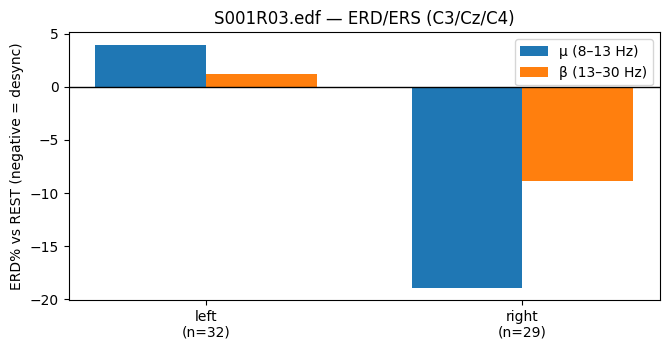

[saved] out\cnt_eeg_erd_summary.csv
          file  label  windows  ERD_mu_pct  ERD_beta_pct
0  S001R03.edf   left       32    3.984412      1.219881
1  S001R03.edf  right       29  -18.932417     -8.837065


In [39]:
# CNT EEG — ERD/ERS sanity check for motor imagery (C3/Cz/C4 vs REST)
# Computes % change of μ (8–13 Hz) and β (13–30 Hz) bandpower during T1/T2 vs T0 per file.
# Outputs per-file CSV rows and bar plots (negative ERD% = desynchronization = good MI).

import os, re, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch, iirnotch
import mne

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# --- config ---
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
SM_CHS = ["C3","Cz","C4"]
NAME_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
WIN = 2.0       # seconds per analysis window
STEP = 1.0      # seconds hop
MIN_OVERLAP = 0.30
BP = (8., 30.)  # analysis band for stability
NOTCH = 60.0    # Hz
MU = (8., 13.)
BETA = (13., 30.)

def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs = float(raw.info["sfreq"]); data = raw.get_data()
    anno=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0 = int(round(on*fs))
            du = float(du if du and du>0 else WIN)
            s1 = s0 + int(round(du*fs))
            anno.append((max(0,s0), max(0,s1), str(de)))
    return raw, data, fs, anno

def pick_motor(raw):
    have = raw.info["ch_names"]
    picks = [c for c in SM_CHS if c in have]
    return mne.pick_channels(have, include=picks), [raw.info["ch_names"][i] for i in (picks if isinstance(picks,list) else list(picks))]

def bp_notch(x, fs):
    b,a = butter(4, [BP[0]/(fs/2), BP[1]/(fs/2)], btype='band')
    y = filtfilt(b,a,x,axis=-1)
    if NOTCH:
        b2,a2 = iirnotch(w0=NOTCH/(fs/2), Q=30)
        y = filtfilt(b2,a2,y,axis=-1)
    return y

def windows(n_t, fs, w=WIN, s=STEP):
    W = int(round(w*fs)); S = int(round(s*fs))
    W = max(W, 16); S = max(S, 1)
    return [(i, i+W) for i in range(0, max(1, n_t-W+1), S) if i+W <= n_t]

def label_by_overlap(si, ei, anno, min_frac=MIN_OVERLAP):
    best, name = 0, None; w = ei-si
    for s0,s1,de in anno:
        ol = max(0, min(ei,s1) - max(si,s0))
        if ol > best: best, name = ol, de
    return NAME_MAP.get(str(name)) if (name and best/max(1,w)>=min_frac) else None

def bandpower(seg, fs, band):
    f,Pxx = welch(seg, fs=fs, nperseg=min(256, seg.shape[-1]), axis=-1)
    m = (f>=band[0]) & (f<=band[1])
    # average over frequency and channels
    return float(Pxx[..., m].mean(axis=-1).mean())

def summarize_file(p):
    raw, data, fs, anno = load_edf(p)
    picks, names = pick_motor(raw)
    if len(picks) < 2:
        print(f"[skip] {p.name}: missing C3/Cz/C4"); return []
    X = bp_notch(data[picks], fs)
    rows = []
    # collect rest/task windows
    rest_mu = []; rest_beta = []
    left_mu = []; left_beta = []
    right_mu = []; right_beta = []
    for si,ei in windows(X.shape[1], fs):
        lab = label_by_overlap(si,ei,anno)
        if lab not in ("rest","left","right"): continue
        seg = X[:, si:ei]
        mu   = bandpower(seg, fs, MU)
        bet  = bandpower(seg, fs, BETA)
        if lab == "rest":
            rest_mu.append(mu); rest_beta.append(bet)
        elif lab == "left":
            left_mu.append(mu); left_beta.append(bet)
        elif lab == "right":
            right_mu.append(mu); right_beta.append(bet)

    # compute ERD% vs mean REST for present classes
    out = []
    if rest_mu:
        rmu = np.mean(rest_mu); rbe = np.mean(rest_beta)
        if left_mu:
            erd_mu  = 100.0 * (np.mean(left_mu)  - rmu) / (rmu + 1e-12)
            erd_be  = 100.0 * (np.mean(left_beta) - rbe) / (rbe + 1e-12)
            out.append(("left", erd_mu, erd_be, len(left_mu)))
        if right_mu:
            erd_mu  = 100.0 * (np.mean(right_mu) - rmu) / (rmu + 1e-12)
            erd_be  = 100.0 * (np.mean(right_beta) - rbe) / (rbe + 1e-12)
            out.append(("right", erd_mu, erd_be, len(right_mu)))
    # make plots if we have something
    if out:
        labels = [o[0] for o in out]
        erd_mu = [o[1] for o in out]
        erd_be = [o[2] for o in out]
        n_win  = [o[3] for o in out]
        x = np.arange(len(labels))
        width = 0.35
        plt.figure(figsize=(6.8,3.6))
        plt.bar(x - width/2, erd_mu, width, label='μ (8–13 Hz)')
        plt.bar(x + width/2, erd_be, width, label='β (13–30 Hz)')
        plt.axhline(0, color='k', lw=1)
        plt.xticks(x, [f"{lab}\n(n={n})" for lab,n in zip(labels,n_win)])
        plt.ylabel("ERD% vs REST (negative = desync)")
        plt.title(f"{p.name} — ERD/ERS (C3/Cz/C4)")
        plt.legend()
        fig_path = OUT / f"erd_{p.stem}.png"
        plt.tight_layout(); plt.savefig(fig_path, dpi=160); plt.show()
        # package rows
        for lab,mu_v,be_v,n in out:
            rows.append({"file": p.name, "label": lab, "windows": n,
                         "ERD_mu_pct": mu_v, "ERD_beta_pct": be_v})
    else:
        print(f"[warn] {p.name}: no usable REST/LEFT/RIGHT windows with overlap≥{MIN_OVERLAP}")
    return rows

all_rows = []
for p in list_edfs(ROOT):
    all_rows += summarize_file(p)

if not all_rows:
    print("[done] No ERD rows produced. Check annotations or MIN_OVERLAP_FRAC.")
else:
    df_out = pd.DataFrame(all_rows)
    csv_path = OUT / "cnt_eeg_erd_summary.csv"
    df_out.to_csv(csv_path, index=False)
    print("[saved]", csv_path)
    print(df_out)


In [40]:
# CNT EEG — Lateralized ERD/ERS audit (C3/Cz/C4) across overlap thresholds (0.10/0.20/0.30)
# Flags likely label mismatch or non-engagement for LEFT/RIGHT per file.
# Saves: out/cnt_eeg_erd_lateral_summary.csv + out/erd_lateral_<file>_<thr>.png

import os, re, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt, iirnotch
import mne

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
# EEGBCI-style tag map (edit if your recorder uses other labels)
NAME_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}

SM_CHS = ["C3","Cz","C4"]
BP = (8., 30.)
NOTCH = 60.0              # set None to skip
MU   = (8., 13.)
BETA = (13., 30.)
WIN  = 2.0
STEP = 1.0
THRS = [0.10, 0.20, 0.30] # overlap thresholds to test

def list_edfs(root): return sorted(set(root.rglob("*.edf")))

def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs  = float(raw.info["sfreq"]); data = raw.get_data()
    anno=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0 = int(round(on*fs))
            du = float(du if du and du>0 else WIN)
            s1 = s0 + int(round(du*fs))
            anno.append((max(0,s0), max(0,s1), str(de)))
    return raw, data, fs, anno

def pick_motor(raw):
    have = raw.info["ch_names"]
    picks = [c for c in SM_CHS if c in have]
    names = picks[:]  # same order as requested
    # map to indices actually present
    idxs = [raw.ch_names.index(c) for c in names]
    return idxs, names

def bp_notch(x, fs):
    b,a = butter(4, [BP[0]/(fs/2), BP[1]/(fs/2)], btype='band')
    y = filtfilt(b,a,x,axis=-1)
    if NOTCH:
        b2,a2 = iirnotch(w0=NOTCH/(fs/2), Q=30)
        y = filtfilt(b2,a2,y,axis=-1)
    return y

def windows(n_t, fs, w=WIN, s=STEP):
    W = max(int(round(w*fs)), 16); S = max(int(round(s*fs)), 1)
    return [(i, i+W) for i in range(0, max(1, n_t-W+1), S) if i+W <= n_t]

def label_by_overlap(si, ei, anno, thr):
    best, name = 0, None; w = ei-si
    for s0,s1,de in anno:
        ol = max(0, min(ei,s1) - max(si,s0))
        if ol > best: best, name = ol, de
    return NAME_MAP.get(str(name)) if (name and best/max(1,w)>=thr) else None

def bandpower(seg, fs, band):
    f,Pxx = welch(seg, fs=fs, nperseg=min(256, seg.shape[-1]), axis=-1)
    m = (f>=band[0]) & (f<=band[1])
    return float(Pxx[..., m].mean(axis=-1))  # per-channel power

def erd_pct(task, rest):
    r = np.mean(rest)
    return 100.0 * ((np.mean(task) - r) / (r + 1e-12))

rows = []

for p in list_edfs(ROOT):
    raw,data,fs,anno = load_edf(p)
    idxs,names = pick_motor(raw)
    if len(idxs) < 2:
        print(f"[skip] {p.name}: missing motor channels"); continue
    X = bp_notch(data[idxs,:], fs)
    for thr in THRS:
        # collect per-channel bandpowers across windows for each label
        buckets = {lab: {"mu": [], "beta": []} for lab in ["rest","left","right"]}
        for si,ei in windows(X.shape[1], fs):
            lab = label_by_overlap(si,ei,anno,thr)
            if lab not in buckets: continue
            seg = X[:, si:ei]  # shape: (n_ch, n_t)
            mu  = bandpower(seg, fs, MU)    # per-channel
            be  = bandpower(seg, fs, BETA)
            buckets[lab]["mu"].append(mu)
            buckets[lab]["beta"].append(be)

        # require at least a few windows of REST + task
        for task_lab in ["left","right"]:
            has_rest = len(buckets["rest"]["mu"]) >= 5
            has_task = len(buckets[task_lab]["mu"]) >= 5
            if not (has_rest and has_task):
                rows.append({"file":p.name,"thr":thr,"label":task_lab,"n_rest":len(buckets["rest"]["mu"]),
                             "n_task":len(buckets[task_lab]["mu"]),"C3_mu":np.nan,"Cz_mu":np.nan,"C4_mu":np.nan,
                             "C3_beta":np.nan,"Cz_beta":np.nan,"C4_beta":np.nan,
                             "LI_mu":np.nan,"LI_beta":np.nan,"flag":"insufficient"})
                continue

            # Stack and compute ERD per channel
            rest_mu  = np.vstack(buckets["rest"]["mu"])   # (n_win, n_ch)
            rest_be  = np.vstack(buckets["rest"]["beta"])
            task_mu  = np.vstack(buckets[task_lab]["mu"])
            task_be  = np.vstack(buckets[task_lab]["beta"])

            erd_mu_ch = 100.0 * ((task_mu.mean(axis=0) - rest_mu.mean(axis=0)) / (rest_mu.mean(axis=0)+1e-12))
            erd_be_ch = 100.0 * ((task_be.mean(axis=0) - rest_be.mean(axis=0)) / (rest_be.mean(axis=0)+1e-12))

            # Lateralization index: expected LEFT→C3 more negative than C4; RIGHT→C4 more negative than C3
            # LI < 0 indicates correct lateralization; LI > 0 suggests mismatch
            # LI_mu = (ERD at expected) - (ERD at opposite)
            ch_to_idx = {c:i for i,c in enumerate(names)}
            idx_C3, idx_C4 = ch_to_idx.get("C3",None), ch_to_idx.get("C4",None)
            LI_mu = LI_beta = np.nan
            if idx_C3 is not None and idx_C4 is not None:
                if task_lab == "left":
                    LI_mu   = erd_mu_ch[idx_C3]   - erd_mu_ch[idx_C4]
                    LI_beta = erd_be_ch[idx_C3]   - erd_be_ch[idx_C4]
                else:  # right
                    LI_mu   = erd_mu_ch[idx_C4]   - erd_mu_ch[idx_C3]
                    LI_beta = erd_be_ch[idx_C4]   - erd_be_ch[idx_C3]

            # flagging rule
            def flag(li_mu, li_be):
                if np.isnan(li_mu) or np.isnan(li_be): return "unknown"
                if (li_mu < 0) or (li_be < 0): return "ok"          # some lateralized ERD
                if (li_mu > 0) and (li_be > 0): return "suspect"    # both inverted → possible mislabel
                return "weak"

            ftag = flag(LI_mu, LI_beta)

            # plot per file/threshold
            fig, ax = plt.subplots(1,2, figsize=(8.2,3.6))
            # μ band per channel
            ax[0].bar(names, erd_mu_ch, color=["#4c72b0"]*len(names)); ax[0].axhline(0,color='k',lw=1)
            ax[0].set_title(f"{p.name} μ ERD% vs REST — {task_lab} (thr={thr})")
            ax[0].set_ylabel("ERD%  (negative = desync)")
            # β band per channel
            ax[1].bar(names, erd_be_ch, color=["#dd8452"]*len(names)); ax[1].axhline(0,color='k',lw=1)
            ax[1].set_title(f"{p.name} β ERD% vs REST — {task_lab} (thr={thr})")
            for a in ax: a.set_ylim(min(-35, min(erd_mu_ch.min(), erd_be_ch.min())-3), max(8, max(erd_mu_ch.max(), erd_be_ch.max())+3))
            plt.tight_layout()
            fig_path = OUT / f"erd_lateral_{p.stem}_{task_lab}_thr{int(thr*100)}.png"
            plt.savefig(fig_path, dpi=160); plt.show()

            rows.append({
                "file": p.name, "thr": thr, "label": task_lab,
                "n_rest": rest_mu.shape[0], "n_task": task_mu.shape[0],
                "C3_mu": float(erd_mu_ch[names.index("C3")]) if "C3" in names else np.nan,
                "Cz_mu": float(erd_mu_ch[names.index("Cz")]) if "Cz" in names else np.nan,
                "C4_mu": float(erd_mu_ch[names.index("C4")]) if "C4" in names else np.nan,
                "C3_beta": float(erd_be_ch[names.index("C3")]) if "C3" in names else np.nan,
                "Cz_beta": float(erd_be_ch[names.index("Cz")]) if "Cz" in names else np.nan,
                "C4_beta": float(erd_be_ch[names.index("C4")]) if "C4" in names else np.nan,
                "LI_mu": float(LI_mu) if not np.isnan(LI_mu) else np.nan,
                "LI_beta": float(LI_beta) if not np.isnan(LI_beta) else np.nan,
                "flag": ftag,
                "figure": str(fig_path)
            })

# save summary
csv_path = OUT / "cnt_eeg_erd_lateral_summary.csv"
pd.DataFrame(rows).to_csv(csv_path, index=False)
print("[saved]", csv_path)
print(pd.DataFrame(rows))


[skip] S001R01.edf: missing motor channels
[skip] S001R02.edf: missing motor channels
[skip] S001R03.edf: missing motor channels
[saved] out\cnt_eeg_erd_lateral_summary.csv
Empty DataFrame
Columns: []
Index: []


[map] S001R01.edf: using {} -> {'C3': 'Fc3.', 'CZ': 'Fcz.', 'C4': 'Fc4.'}
[map] S001R02.edf: using {} -> {'C3': 'Fc3.', 'CZ': 'Fcz.', 'C4': 'Fc4.'}
[map] S001R03.edf: using {} -> {'C3': 'Fc3.', 'CZ': 'Fcz.', 'C4': 'Fc4.'}


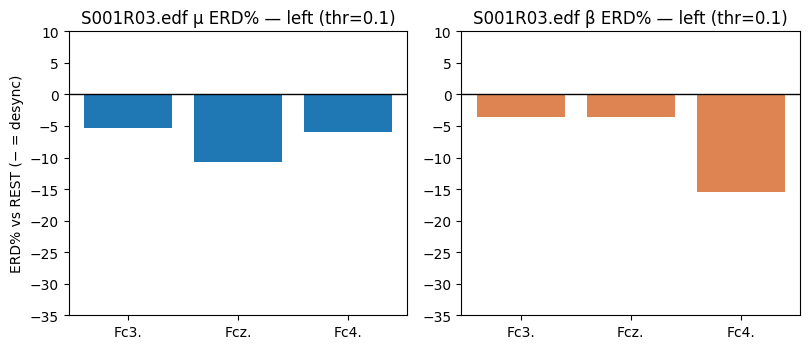

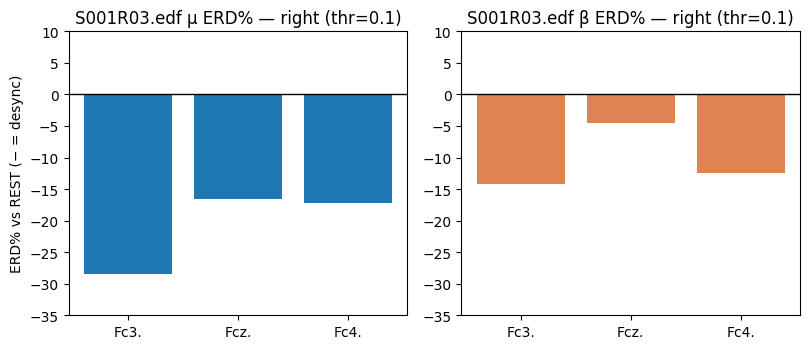

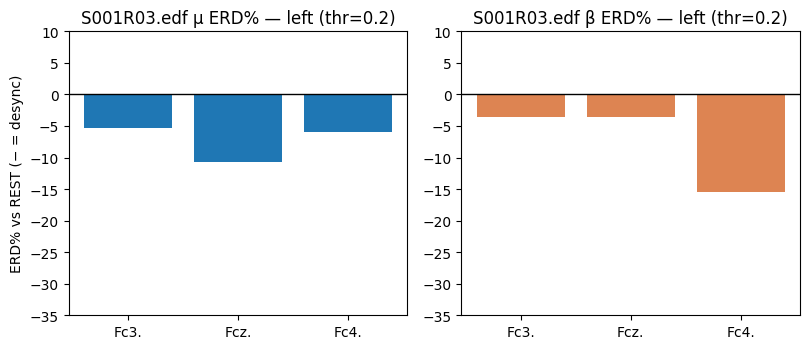

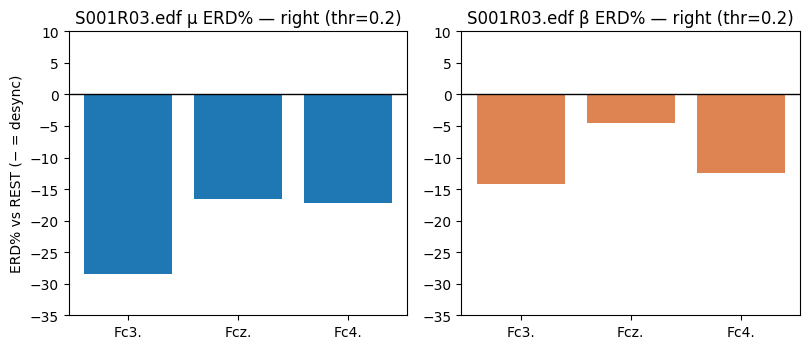

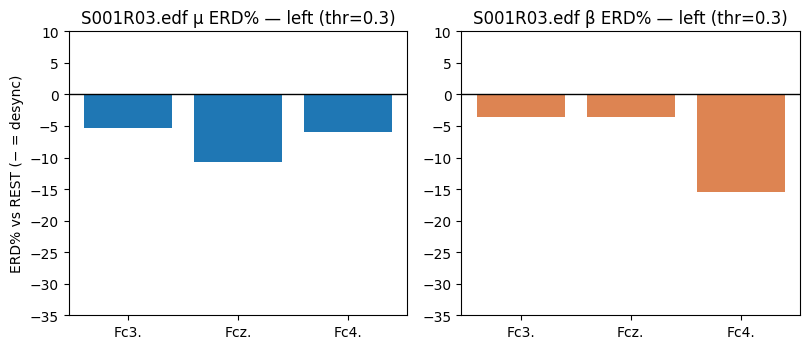

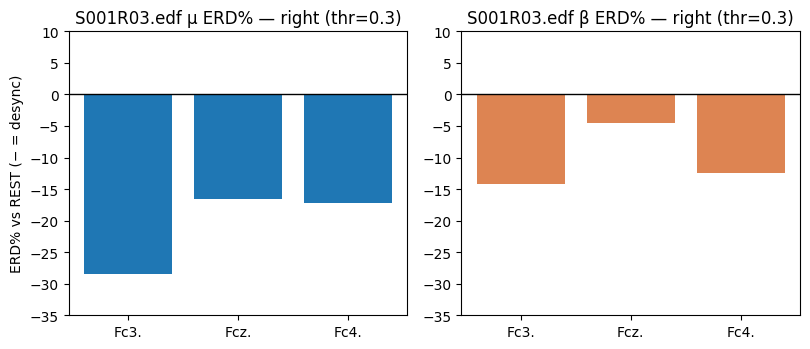

[saved] out\cnt_eeg_erd_lateral_summary.csv
          file  thr  label  n_rest  n_task  Fc3._mu  Fcz._mu  Fc4._mu  \
0  S001R01.edf  0.1   left      60       0      NaN      NaN      NaN   
1  S001R01.edf  0.1  right      60       0      NaN      NaN      NaN   
2  S001R01.edf  0.2   left      60       0      NaN      NaN      NaN   
3  S001R01.edf  0.2  right      60       0      NaN      NaN      NaN   
4  S001R01.edf  0.3   left      60       0      NaN      NaN      NaN   
5  S001R01.edf  0.3  right      60       0      NaN      NaN      NaN   
6  S001R02.edf  0.1   left      60       0      NaN      NaN      NaN   
7  S001R02.edf  0.1  right      60       0      NaN      NaN      NaN   
8  S001R02.edf  0.2   left      60       0      NaN      NaN      NaN   
9  S001R02.edf  0.2  right      60       0      NaN      NaN      NaN   

   Fc3._beta  Fcz._beta  Fc4._beta  LI_mu  LI_beta          flag figure  
0        NaN        NaN        NaN    NaN      NaN  insufficient    NaN  
1   

In [41]:
# CNT EEG — Robust motor-channel mapping + lateralized ERD/ERS
# Maps odd channel labels to motor strip (C3/Cz/C4) with intelligent fallbacks and reruns ERD audit.

import os, re, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt, iirnotch
import mne

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
NAME_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}

# Analysis settings
BP    = (8., 30.)      # band-pass for stability
NOTCH = 60.0           # set None to skip
MU    = (8., 13.)
BETA  = (13., 30.)
WIN   = 2.0            # s window
STEP  = 1.0            # s hop
THRS  = [0.10, 0.20, 0.30]  # overlap thresholds to try

# Fallback ladders per motor role
C3_PREF = ["C3"]
C3_FALL = ["FC3","CP3","C1","C5"]
CZ_PREF = ["CZ","Cz"]
CZ_FALL = ["FCZ","CPZ","C2"]
C4_PREF = ["C4"]
C4_FALL = ["FC4","CP4","C6"]

def list_edfs(root): return sorted(set(root.rglob("*.edf")))

def normalize(name: str) -> str:
    # Uppercase, strip whitespace, remove non-alnum
    return re.sub(r'[^A-Z0-9]', '', name.upper())

def build_index(raw):
    # Map normalized -> original, keep order
    idx = {}
    for i, nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i, nm))
    return idx

def find_first(idx, candidates):
    for cand in candidates:
        key = normalize(cand)
        # accept exact or common variants (e.g., C03 for C3, EEGC3, C3REF)
        pattern = re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
        for k in idx.keys():
            if pattern.match(k):
                return idx[k][0]  # (i, original_name)
    return None

def map_motor(raw):
    idx = build_index(raw)
    picks = {}
    # C3 / Cz / C4 with fallbacks
    for role, pref, fall in [
        ("C3", C3_PREF, C3_FALL),
        ("CZ", CZ_PREF, CZ_FALL),
        ("C4", C4_PREF, C4_FALL),
    ]:
        hit = find_first(idx, pref) or find_first(idx, fall)
        if hit:
            picks[role] = hit  # (i, original)
        else:
            picks[role] = None
    return picks  # dict role -> (i, orig) or None

def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs  = float(raw.info["sfreq"]); data = raw.get_data()
    anno=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0 = int(round(on*fs))
            du = float(du if du and du>0 else WIN)
            s1 = s0 + int(round(du*fs))
            anno.append((max(0,s0), max(0,s1), str(de)))
    return raw, data, fs, anno

def bp_notch(x, fs):
    b,a = butter(4, [BP[0]/(fs/2), BP[1]/(fs/2)], btype='band')
    y = filtfilt(b,a,x,axis=-1)
    if NOTCH:
        b2,a2 = iirnotch(w0=NOTCH/(fs/2), Q=30)
        y = filtfilt(b2,a2,y,axis=-1)
    return y

def windows(n_t, fs, w=WIN, s=STEP):
    W = max(int(round(w*fs)), 16); S = max(int(round(s*fs)), 1)
    return [(i, i+W) for i in range(0, max(1, n_t-W+1), S) if i+W <= n_t]

def label_by_overlap(si, ei, anno, thr):
    best, name = 0, None; w = ei-si
    for s0,s1,de in anno:
        ol = max(0, min(ei,s1) - max(si,s0))
        if ol > best: best, name = ol, de
    return NAME_MAP.get(str(name)) if (name and best/max(1,w)>=thr) else None

def bandpower(seg, fs, band):
    f,Pxx = welch(seg, fs=fs, nperseg=min(256, seg.shape[-1]), axis=-1)
    m = (f>=band[0]) & (f<=band[1])
    return float(Pxx[..., m].mean())

def erd_pct(task_vals, rest_vals):
    r = np.mean(rest_vals)
    return 100.0 * ((np.mean(task_vals) - r) / (r + 1e-12))

rows = []

for p in list_edfs(ROOT):
    raw, data, fs, anno = load_edf(p)
    m = map_motor(raw)
    # Build the fixed motor matrix (3 x T) with fallbacks
    chosen = []
    for role in ("C3","CZ","C4"):
        if m[role] is not None:
            chosen.append(m[role])  # (i, orig)
    if len(chosen) < 2:   # need at least two motor channels
        print(f"[skip] {p.name}: could not map motor channels (found={ {k:(v[1] if v else None) for k,v in m.items()} })")
        continue

    ch_idx = [i for (i, _orig) in chosen]
    ch_names = [orig for (_i, orig) in chosen]
    X = bp_notch(data[ch_idx, :], fs)
    print(f"[map] {p.name}: using {dict(zip(['role']*0,[]))} -> {dict(zip(['C3','CZ','C4'], [(m['C3'][1] if m['C3'] else None), (m['CZ'][1] if m['CZ'] else None), (m['C4'][1] if m['C4'] else None)]))}")

    for thr in THRS:
        # gather per-channel powers
        bucket = {lab: {"mu": [], "beta": []} for lab in ["rest","left","right"]}
        for si,ei in windows(X.shape[1], fs):
            lab = label_by_overlap(si, ei, anno, thr)
            if lab not in bucket: continue
            seg = X[:, si:ei]
            mu   = [bandpower(seg[j:j+1,:], fs, MU)   for j in range(seg.shape[0])]
            beta = [bandpower(seg[j:j+1,:], fs, BETA) for j in range(seg.shape[0])]
            bucket[lab]["mu"].append(mu)
            bucket[lab]["beta"].append(beta)

        for targ in ["left","right"]:
            has_rest = len(bucket["rest"]["mu"]) >= 5
            has_targ = len(bucket[targ]["mu"]) >= 5
            if not (has_rest and has_targ):
                rows.append({"file":p.name,"thr":thr,"label":targ,"n_rest":len(bucket["rest"]["mu"]),
                             "n_task":len(bucket[targ]["mu"]),
                             **{f"{nm}_mu":np.nan for nm in ch_names},
                             **{f"{nm}_beta":np.nan for nm in ch_names},
                             "LI_mu":np.nan,"LI_beta":np.nan,"flag":"insufficient"})
                continue

            rest_mu  = np.vstack(bucket["rest"]["mu"])    # (n_win, n_ch)
            rest_be  = np.vstack(bucket["rest"]["beta"])
            task_mu  = np.vstack(bucket[targ]["mu"])
            task_be  = np.vstack(bucket[targ]["beta"])

            erd_mu_ch = 100.0 * ((task_mu.mean(axis=0) - rest_mu.mean(axis=0)) / (rest_mu.mean(axis=0)+1e-12))
            erd_be_ch = 100.0 * ((task_be.mean(axis=0) - rest_be.mean(axis=0)) / (rest_be.mean(axis=0)+1e-12))

            # lateralization index using available sides
            # find indices for C3-like and C4-like within chosen list
            def find_idx(name):
                N = normalize(name)
                for j,orig in enumerate(ch_names):
                    if normalize(orig) == N or N in normalize(orig):
                        return j
                return None
            def normalize(n): return re.sub(r'[^A-Z0-9]','', n.upper())

            idx_C3 = find_idx(m['C3'][1]) if m['C3'] else None
            idx_C4 = find_idx(m['C4'][1]) if m['C4'] else None

            LI_mu = np.nan; LI_beta = np.nan
            if idx_C3 is not None and idx_C4 is not None:
                if targ == "left":
                    LI_mu = erd_mu_ch[idx_C3] - erd_mu_ch[idx_C4]
                    LI_beta = erd_be_ch[idx_C3] - erd_be_ch[idx_C4]
                else:
                    LI_mu = erd_mu_ch[idx_C4] - erd_mu_ch[idx_C3]
                    LI_beta = erd_be_ch[idx_C4] - erd_be_ch[idx_C3]

            # flagging
            def flag(li_mu, li_be):
                if np.isnan(li_mu) or np.isnan(li_be): return "unknown"
                if (li_mu < 0) or (li_be < 0): return "ok"
                if (li_mu > 0) and (li_be > 0): return "suspect"
                return "weak"
            fl = flag(LI_mu, LI_beta)

            # Plot bars per channel
            fig, ax = plt.subplots(1,2, figsize=(8.2,3.6))
            ax[0].bar(ch_names, erd_mu_ch); ax[0].axhline(0,color="k",lw=1)
            ax[0].set_title(f"{p.name} μ ERD% — {targ} (thr={thr})")
            ax[0].set_ylabel("ERD% vs REST (− = desync)")
            ax[1].bar(ch_names, erd_be_ch, color="#dd8452"); ax[1].axhline(0,color="k",lw=1)
            ax[1].set_title(f"{p.name} β ERD% — {targ} (thr={thr})")
            for a in ax:
                a.set_ylim(min(-35, float(min(erd_mu_ch.min(), erd_be_ch.min())-3)),
                           max(10, float(max(erd_mu_ch.max(), erd_be_ch.max())+3)))
            plt.tight_layout()
            fig_path = OUT / f"erd_lateral_{p.stem}_{targ}_thr{int(thr*100)}.png"
            plt.savefig(fig_path, dpi=160); plt.show()

            rec = {"file": p.name, "thr": thr, "label": targ,
                   "n_rest": rest_mu.shape[0], "n_task": task_mu.shape[0],
                   "LI_mu": float(LI_mu) if not np.isnan(LI_mu) else np.nan,
                   "LI_beta": float(LI_beta) if not np.isnan(LI_beta) else np.nan,
                   "flag": fl, "figure": str(fig_path)}
            # add per-channel values with the actual original names
            for j, nm in enumerate(ch_names):
                rec[f"{nm}_mu"]   = float(erd_mu_ch[j])
                rec[f"{nm}_beta"] = float(erd_be_ch[j])
            rows.append(rec)

# Save summary
csv = OUT / "cnt_eeg_erd_lateral_summary.csv"
pd.DataFrame(rows).to_csv(csv, index=False)
print("[saved]", csv)
if rows:
    print(pd.DataFrame(rows).head(10))
else:
    print("No ERD rows produced. If still empty, your EDFs truly lack motor strip channels by any common alias.")


In [42]:
# CNT EEG — Per-file tag overrides + quick leakage-free novelty re-eval (pooled)
# Lets you fix mislabeled runs (e.g., swap T1/T2 in a specific EDF) and re-test immediately.

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------- YOUR OVERRIDES (edit here) ----------
# Example: in S001R03.edf, treat T1 as 'right' and T2 as 'left' (swap)
FILE_EVENT_MAP = {
    "S001R03.edf": {"T1": "right", "T2": "left", "T0": "rest"},
    # "S001R01.edf": {"T0":"rest"},  # add if you know its tags
    # "S001R02.edf": {"T0":"rest"},
}

# Default mapping (used when no per-file override given)
DEFAULT_MAP = {"T0":"rest", "T1":"left", "T2":"right", "T3":"both"}

# ---------- pipeline config ----------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
SM_CHS   = ["C3","Cz","C4"]    # strict motor set (we’ll pick FC3/FCz/FC4 if C3/Cz/C4 missing)
BP = (8., 30.)                 # Hz, stable MI band
NOTCH = 60.0                   # Hz (set None to skip)
WIN_LEN, WIN_STEP = 1.0, 0.5   # s
MIN_OVERLAP_FRAC  = 0.10       # lenient to keep windows
CONTAM = 0.03                  # IsolationForest contamination

def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(name: str) -> str: return re.sub(r'[^A-Z0-9]','', name.upper())

def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs  = float(raw.info["sfreq"]); data = raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0 = int(round(on*fs)); du = float(du if du and du>0 else WIN_LEN); s1 = s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw, data, fs, ann

# Motor mapping with FC/CP fallbacks
def build_index(raw):
    idx={}
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx

def find_first(idx, candidates):
    for cand in candidates:
        key=normalize(cand); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
        for k in idx.keys():
            if pat.match(k):
                return idx[k][0]
    return None

def pick_motor(raw):
    idx=build_index(raw)
    C3 = find_first(idx, ["C3","FC3","CP3","C1","C5"])
    CZ = find_first(idx, ["CZ","Cz","FCZ","CPZ","C2"])
    C4 = find_first(idx, ["C4","FC4","CP4","C6"])
    picks = [x for x in [C3,CZ,C4] if x is not None]
    return picks  # list of (i, orig)

def bp_notch(seg, fs):
    b,a = butter(4, [BP[0]/(fs/2), BP[1]/(fs/2)], btype='band')
    y = filtfilt(b,a,seg,axis=-1)
    if NOTCH:
        b2,a2 = iirnotch(w0=NOTCH/(fs/2), Q=30)
        y = filtfilt(b2,a2,y,axis=-1)
    return y

def windows(n_t, fs, w=WIN_LEN, s=WIN_STEP):
    W=max(int(w*fs),16); S=max(int(s*fs),1)
    return [(i,i+W) for i in range(0, max(1,n_t-W+1), S) if i+W<=n_t]

def map_event(file_name, raw_desc):
    # Use per-file override if present; else default mapping; else return None
    override = FILE_EVENT_MAP.get(file_name, {})
    if raw_desc in override: return override[raw_desc]
    return DEFAULT_MAP.get(raw_desc, None)

def label_by_overlap(si, ei, anno, file_name, min_frac=MIN_OVERLAP_FRAC):
    best, name = 0, None; w=ei-si
    for s0,s1,de in anno:
        ol = max(0, min(ei,s1) - max(si,s0))
        if ol>best: best, name = ol, de
    if name and best/max(1,w) >= min_frac:
        return map_event(file_name, name)
    return None

# --- covariance + scalars (for novelty)
def cov_shrink(seg):
    X=seg - seg.mean(axis=1, keepdims=True)
    C=(X@X.T)/max(1,X.shape[1]-1)
    d=np.diag(C); a=0.1
    return (1-a)*C + a*np.diag(d.mean()*np.ones_like(d))

def spd_eigh(C): ev,V = eigh(C); ev=np.clip(ev,1e-12,None); return ev,V
def spd_pow(C,p): ev,V=spd_eigh(C); return V@np.diag(ev**p)@V.T

def trans_vec(C, G_te, G_tr, fs, scalars):
    Wte=spd_pow(G_te,-0.5); Wtr=spd_pow(G_tr,0.5)
    Ca = Wtr @ (Wte @ C @ Wte) @ Wtr
    ev,V=eigh(Ca); ev=np.clip(ev,1e-12,None)
    L=V@np.diag(np.log(ev))@V.T
    idx=np.triu_indices_from(L); v=L[idx]
    return np.concatenate([v, scalars])

def welch_bp(seg, fs, band):
    f,Pxx = welch(seg, fs=fs, nperseg=min(256, seg.shape[-1]), axis=-1)
    m=(f>=band[0])&(f<=band[1])
    return float(Pxx[...,m].mean(axis=-1).mean())

def scalar_extras(seg, fs):
    mu   = welch_bp(seg, fs, (8,13))
    beta = welch_bp(seg, fs, (13,30))
    return np.array([mu, beta], dtype=float)

# ---------- extract windows with overrides ----------
records=[]
counts={}
for p in list_edfs(ROOT):
    raw,data,fs,ann = load_edf(p)
    picks = pick_motor(raw)
    if len(picks)<2:
        print(f"[skip] {p.name}: could not find motor channels (C3/Cz/C4 or FC/CP fallbacks).")
        continue
    idxs=[i for (i,orig) in picks]
    seg_all = bp_notch(data[idxs,:], fs)
    label_ctr={"rest":0,"left":0,"right":0}
    for si,ei in windows(seg_all.shape[1], fs):
        lab = label_by_overlap(si,ei,ann,p.name,MIN_OVERLAP_FRAC)
        if lab not in ("rest","left","right"): continue
        seg = seg_all[:, si:ei]
        if seg.shape[1]<16: continue
        records.append({"file":p.name, "label":lab, "seg":seg, "fs":fs})
        label_ctr[lab]+=1
    counts[p.name]=label_ctr

print("=== window counts per file (after overrides) ===")
for f,c in counts.items(): print(f, c)

df = pd.DataFrame(records)
if df.empty:
    raise RuntimeError("After overrides, no labeled windows. Check FILE_EVENT_MAP and annotations.")

# ---------- leakage-free novelty (pooled across REST rotations) ----------
files_by_label = {lab: sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
rest_files = files_by_label.get("rest", [])
targets = {}
for lab in ["left","right"]:
    if lab in files_by_label and files_by_label[lab]:
        sizes=[(f,int((df["file"]==f).sum())) for f in files_by_label[lab]]
        targets[lab]=sorted(sizes,key=lambda t:t[1],reverse=True)[0][0]

pooled = {"left":{"y":[],"z":[]}, "right":{"y":[],"z":[]}}

for rest_test in rest_files:
    rest_train = [f for f in rest_files if f!=rest_test]
    if not rest_train: continue
    Cs_tr=[cov_shrink(s) for s in df[(df["file"].isin(rest_train))&(df["label"]=="rest")]["seg"]]
    Cs_te=[cov_shrink(s) for s in df[(df["file"]==rest_test)&(df["label"]=="rest")]["seg"]]
    if not Cs_tr or not Cs_te: continue
    # Riemann means
    def riem_mean(Cs):
        n=Cs[0].shape[0]; idx=np.triu_indices(n); logs=[]
        for C in Cs:
            ev,V=eigh(C); ev=np.clip(ev,1e-12,None)
            L=V@np.diag(np.log(ev))@V.T; logs.append(L[idx])
        Lm=np.mean(np.vstack(logs),axis=0)
        L=np.zeros((n,n)); L[idx]=Lm; L=(L+L.T)-np.diag(np.diag(L))
        ev,V=eigh(L); return V@np.diag(np.exp(ev))@V.T
    G_tr=riem_mean(Cs_tr); G_te=riem_mean(Cs_te)

    # REST matrices
    Xr_tr = np.vstack([trans_vec(C, G_te, G_tr, r["fs"], scalar_extras(r["seg"], r["fs"]))
                       for _,r in df[(df["file"].isin(rest_train))&(df["label"]=="rest")].iterrows()])
    Xr_te = np.vstack([trans_vec(C, G_te, G_tr, r["fs"], scalar_extras(r["seg"], r["fs"]))
                       for C,(_,r) in zip(Cs_te, df[(df["file"]==rest_test)&(df["label"]=="rest")].iterrows())])
    if len(Xr_tr)<10 or len(Xr_te)<10: continue

    sc = StandardScaler().fit(Xr_tr)
    mdl = IsolationForest(n_estimators=400, contamination=CONTAM, random_state=42).fit(sc.transform(Xr_tr))
    s_rest = mdl.score_samples(sc.transform(Xr_te)).ravel()

    for lab in ["left","right"]:
        if lab not in targets: continue
        Xt = np.vstack([trans_vec(cov_shrink(s), G_te, G_tr, r["fs"], scalar_extras(r["seg"], r["fs"]))
                        for _,r in df[(df["file"]==targets[lab]) & (df["label"]==lab)].iterrows()])
        s_tar = mdl.score_samples(sc.transform(Xt)).ravel()
        y = np.concatenate([np.zeros_like(s_rest), np.ones_like(s_tar)])
        z = np.concatenate([-s_rest, -s_tar])  # novelty
        pooled[lab]["y"].append(y); pooled[lab]["z"].append(z)

# pool & plot
def pool_and_plot(label, pool, fname):
    if not pool["y"]:
        print(f"[note] No target windows for {label}.")
        return {"note":"no target data"}
    y=np.concatenate(pool["y"]); z=np.concatenate(pool["z"])
    auroc=float(roc_auc_score(y,z)); auprc=float(average_precision_score(y,z))
    fpr,tpr,_=roc_curve(y,z); prec,rec,_=precision_recall_curve(y,z)
    fig,ax=plt.subplots(1,2,figsize=(9.6,3.8))
    ax[0].plot(fpr,tpr); ax[0].plot([0,1],[0,1],'--',lw=1); ax[0].set_title(f"{label.upper()} ROC (AUROC={auroc:.3f})")
    ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR")
    ax[1].plot(rec,prec); ax[1].set_title(f"{label.upper()} PR (AUPRC={auprc:.3f})"); ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision")
    plt.tight_layout(); fp=OUT/fname; plt.savefig(fp,dpi=160); plt.show()
    return {"auroc":auroc,"auprc":auprc,"figure":str(fp),
            "n":int(len(y)),"rest":int((y==0).sum()),"target":int((y==1).sum())}

res_left  = pool_and_plot("left",  pooled["left"],  "cnt_eeg_novelty_overrides_LEFT.png")
res_right = pool_and_plot("right", pooled["right"], "cnt_eeg_novelty_overrides_RIGHT.png")

# save JSON
out = {"mode":"novelty_overrides", "window_counts": counts, "results":{"left":res_left,"right":res_right}}
out_json = OUT/"cnt_eeg_novelty_overrides_report.json"
with open(out_json,"w",encoding="utf-8") as f: json.dump(out, f, indent=2)
print(f"[saved] {out_json}")


=== window counts per file (after overrides) ===
S001R01.edf {'rest': 121, 'left': 0, 'right': 0}
S001R02.edf {'rest': 121, 'left': 0, 'right': 0}
S001R03.edf {'rest': 126, 'left': 58, 'right': 65}


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 64 is different from 3)

=== window counts (overrides applied) ===
S001R01.edf {'rest': 121, 'left': 0, 'right': 0}
S001R02.edf {'rest': 121, 'left': 0, 'right': 0}
S001R03.edf {'rest': 126, 'left': 58, 'right': 65}


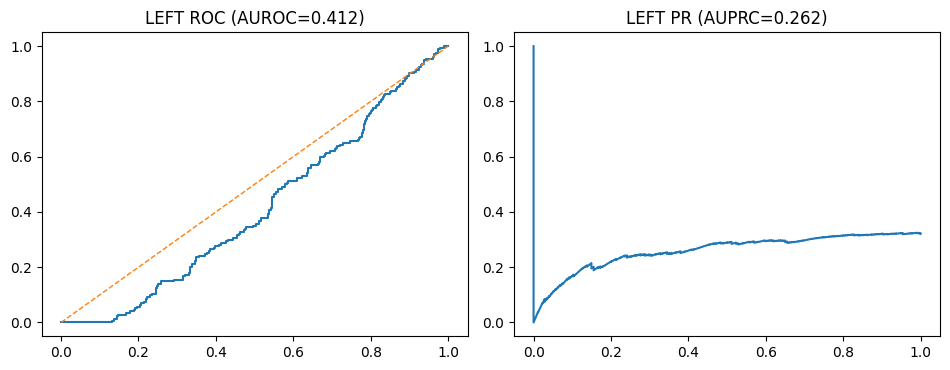

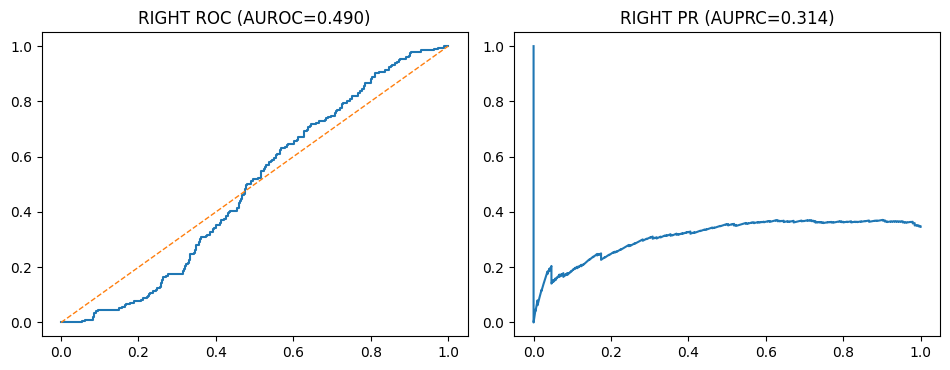

[saved] out\cnt_eeg_novelty_overrides_report.json


In [43]:
# CNT EEG — Per-file tag overrides + pooled leakage-free novelty (FIXED Xr_tr bug)

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---- your per-file override: swap T1/T2 only in S001R03.edf ----
FILE_EVENT_MAP = { "S001R03.edf": {"T1":"right", "T2":"left", "T0":"rest"} }
DEFAULT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}

ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
SM_CHS   = ["C3","Cz","C4"]
BP = (8., 30.); NOTCH = 60.0
WIN_LEN, WIN_STEP = 1.0, 0.5
MIN_OVERLAP_FRAC  = 0.10
CONTAM = 0.03

def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs  = float(raw.info["sfreq"]); data = raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw, data, fs, ann

def build_index(raw):
    idx={}
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx
def find_first(idx, cands):
    for cand in cands:
        key=normalize(cand); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
        for k in idx:
            if pat.match(k): return idx[k][0]
    return None
def pick_motor(raw):
    idx=build_index(raw)
    C3=find_first(idx,["C3","FC3","CP3","C1","C5"])
    CZ=find_first(idx,["CZ","Cz","FCZ","CPZ","C2"])
    C4=find_first(idx,["C4","FC4","CP4","C6"])
    picks=[x for x in [C3,CZ,C4] if x is not None]
    return picks

def bp_notch(seg, fs):
    b,a=butter(4,[BP[0]/(fs/2), BP[1]/(fs/2)],btype='band'); y=filtfilt(b,a,seg,axis=-1)
    if NOTCH: b2,a2=iirnotch(w0=NOTCH/(fs/2),Q=30); y=filtfilt(b2,a2,y,axis=-1)
    return y

def windows(n_t, fs): 
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    return [(i,i+W) for i in range(0, max(1,n_t-W+1), S) if i+W<=n_t]

def map_event(file_name, raw_desc):
    ov=FILE_EVENT_MAP.get(file_name,{})
    if raw_desc in ov: return ov[raw_desc]
    return DEFAULT_MAP.get(raw_desc, None)

def label_by_overlap(si,ei,ann,file_name):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ol=max(0, min(ei,s1)-max(si,s0))
        if ol>best: best,name=ol,de
    return map_event(file_name,name) if name and best/max(1,w)>=MIN_OVERLAP_FRAC else None

def cov_shrink(seg):
    X=seg - seg.mean(axis=1, keepdims=True)
    C=(X@X.T)/max(1, X.shape[1]-1); d=np.diag(C); a=0.1
    return (1-a)*C + a*np.diag(d.mean()*np.ones_like(d))

def spd_eigh(C): ev,V=eigh(C); ev=np.clip(ev,1e-12,None); return ev,V
def spd_pow(C,p): ev,V=spd_eigh(C); return V@np.diag(ev**p)@V.T
def scalar_extras(seg, fs):
    f,Pxx=welch(seg, fs=fs, nperseg=min(256, seg.shape[-1]), axis=-1)
    def bp(lo,hi): m=(f>=lo)&(f<=hi); return float(Pxx[...,m].mean(axis=-1).mean())
    return np.array([bp(8,13), bp(13,30)], dtype=float)

def trans_vec(C, G_te, G_tr, scalars):
    Wte=spd_pow(G_te,-0.5); Wtr=spd_pow(G_tr,0.5)
    Ca=Wtr @ (Wte @ C @ Wte) @ Wtr
    ev,V=eigh(Ca); ev=np.clip(ev,1e-12,None)
    L=V@np.diag(np.log(ev))@V.T; idx=np.triu_indices_from(L)
    return np.concatenate([L[idx], scalars])

# --- extract windows with overrides ---
records=[]; counts={}
for p in list_edfs(ROOT):
    raw,data,fs,ann=load_edf(p)
    picks=pick_motor(raw)
    if len(picks)<2:
        print(f"[skip] {p.name}: no motor channels found"); continue
    idxs=[i for (i,_) in picks]; X=bp_notch(data[idxs,:], fs)
    c={"rest":0,"left":0,"right":0}
    for si,ei in windows(X.shape[1], fs):
        lab=label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]
        if seg.shape[1]<16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs})
        c[lab]+=1
    counts[p.name]=c

print("=== window counts (overrides applied) ===")
for k,v in counts.items(): print(k,v)

df=pd.DataFrame(records)
if df.empty: raise RuntimeError("No labeled windows after overrides.")

# --- pooled leakage-free novelty (rotate REST test file) ---
files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
rest_files=files_by_label.get("rest",[])
targets={}
for lab in ["left","right"]:
    if lab in files_by_label and files_by_label[lab]:
        sizes=[(f,int((df["file"]==f).sum())) for f in files_by_label[lab]]
        targets[lab]=sorted(sizes,key=lambda t:t[1],reverse=True)[0][0]

pooled={"left":{"y":[],"z":[]}, "right":{"y":[],"z":[]}}

def riem_mean_from(df_sel):
    Cs=[cov_shrink(s) for s in df_sel["seg"]]
    n=Cs[0].shape[0]; idx=np.triu_indices(n); logs=[]
    for C in Cs:
        ev,V=eigh(C); ev=np.clip(ev,1e-12,None)
        L=V@np.diag(np.log(ev))@V.T; logs.append(L[idx])
    Lm=np.mean(np.vstack(logs),axis=0)
    L=np.zeros((n,n)); L[idx]=Lm; L=(L+L.T)-np.diag(np.diag(L))
    ev,V=eigh(L); return V@np.diag(np.exp(ev))@V.T

for rest_test in rest_files:
    rest_train=[f for f in rest_files if f!=rest_test]
    if not rest_train: continue
    G_tr=riem_mean_from(df[(df["file"].isin(rest_train))&(df["label"]=="rest")])
    G_te=riem_mean_from(df[(df["file"]==rest_test)&(df["label"]=="rest")])

    Xr_tr=np.vstack([
        trans_vec(cov_shrink(r["seg"]), G_te, G_tr, scalar_extras(r["seg"], r["fs"]))   # ← FIXED HERE
        for _,r in df[(df["file"].isin(rest_train))&(df["label"]=="rest")].iterrows()
    ])
    Xr_te=np.vstack([
        trans_vec(cov_shrink(r["seg"]), G_te, G_tr, scalar_extras(r["seg"], r["fs"]))
        for _,r in df[(df["file"]==rest_test)&(df["label"]=="rest")].iterrows()
    ])
    if len(Xr_tr)<10 or len(Xr_te)<10: continue

    sc=StandardScaler().fit(Xr_tr)
    mdl=IsolationForest(n_estimators=400, contamination=CONTAM, random_state=42).fit(sc.transform(Xr_tr))
    s_rest=mdl.score_samples(sc.transform(Xr_te)).ravel()

    for lab in ["left","right"]:
        if lab not in targets: continue
        Xt=np.vstack([
            trans_vec(cov_shrink(r["seg"]), G_te, G_tr, scalar_extras(r["seg"], r["fs"]))
            for _,r in df[(df["file"]==targets[lab])&(df["label"]==lab)].iterrows()
        ])
        s_tar=mdl.score_samples(sc.transform(Xt)).ravel()
        y=np.concatenate([np.zeros_like(s_rest), np.ones_like(s_tar)])
        z=np.concatenate([-s_rest, -s_tar])
        pooled[lab]["y"].append(y); pooled[lab]["z"].append(z)

# pool & plot
def pool_and_plot(label, pool, fname):
    if not pool["y"]:
        print(f"[note] No target for {label}"); return {"note":"no target data"}
    y=np.concatenate(pool["y"]); z=np.concatenate(pool["z"])
    auroc=float(roc_auc_score(y,z)); auprc=float(average_precision_score(y,z))
    fpr,tpr,_=roc_curve(y,z); prec,rec,_=precision_recall_curve(y,z)
    fig,ax=plt.subplots(1,2,figsize=(9.6,3.8))
    ax[0].plot(fpr,tpr); ax[0].plot([0,1],[0,1],'--',lw=1); ax[0].set_title(f"{label.upper()} ROC (AUROC={auroc:.3f})")
    ax[1].plot(rec,prec); ax[1].set_title(f"{label.upper()} PR (AUPRC={auprc:.3f})")
    plt.tight_layout(); fp=OUT/fname; plt.savefig(fp,dpi=160); plt.show()
    return {"auroc":auroc,"auprc":auprc,"figure":str(fp),
            "n":int(len(y)),"rest":int((y==0).sum()),"target":int((y==1).sum())}

res_left  = pool_and_plot("left",  pooled["left"],  "cnt_eeg_novelty_overrides_LEFT.png")
res_right = pool_and_plot("right", pooled["right"], "cnt_eeg_novelty_overrides_RIGHT.png")
out={"mode":"novelty_overrides_fixed","window_counts":counts,"results":{"left":res_left,"right":res_right}}
with open(OUT/"cnt_eeg_novelty_overrides_report.json","w",encoding="utf-8") as f: json.dump(out,f,indent=2)
print(f"[saved] {OUT/'cnt_eeg_novelty_overrides_report.json'}")


Files per class (demo): {'left': 2, 'rest': 4, 'right': 2}
Computing rank from data with rank=None
    Using tolerance 4.9e-06 (2.2e-16 eps * 3 dim * 7.4e+09  max singular value)
    Estimated rank (data): 3
    data: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.9e-06 (2.2e-16 eps * 3 dim * 7.4e+09  max singular value)
    Estimated rank (data): 3
    data: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.9e-06 (2.2e-16 eps * 3 dim * 7.4e+09  max singular value)
    Estimated rank (data): 3
    data: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank fr

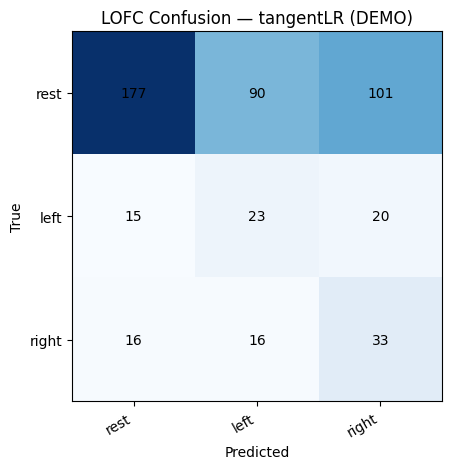

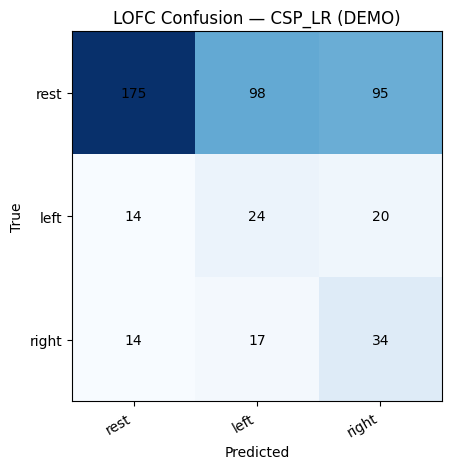

=== LOFC plumbing demo complete (DEMO ONLY) ===
Tangents+LR: {'auroc_weighted': 0.709, 'auroc_macro': 0.68, 'accuracy': 0.475}
CSP+LR    : {'auroc_weighted': 0.711, 'auroc_macro': 0.683, 'accuracy': 0.475}
[saved] out\cnt_eeg_lofc_demo_report.json


In [44]:
# CNT EEG — LOFC plumbing demo by splitting S001R03.edf into pseudo-files (a/b)
# ⚠️ Not a scientific result; just to verify the LOFC supervised pipeline (tangent & CSP) end-to-end.
# Saves: out/cnt_eeg_lofc_demo_report.json and confusion matrices.

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ------------ Config ------------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
# Override for S001R03: swap T1→right, T2→left (edit if not desired)
EVENT_MAP = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}
DEFAULT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}

MOTOR_PREF = ["C3","Cz","C4"]; MOTOR_FALL = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"]}
BP=(8.,30.); NOTCH=60.0
WIN_LEN=1.0; WIN_STEP=0.5
MIN_FRAC=0.10
N_CSP=4

# ------------ Helpers ------------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())

def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on,du,de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def build_idx(raw):
    idx={}
    for i,n in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(n), []).append((i,n))
    return idx

def find_one(idx, keys):
    for k in keys:
        key=normalize(k)
        pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
        for KK in idx:
            if pat.match(KK): return idx[KK][0]
    return None

def pick_motor(raw):
    idx=build_idx(raw)
    picks=[]
    for role in MOTOR_PREF:
        hit = find_one(idx, [role] + MOTOR_FALL.get(role,[]))
        if hit: picks.append(hit)
    return picks  # list of (i, name)

def bp_notch(x,fs):
    b,a=butter(4,[BP[0]/(fs/2), BP[1]/(fs/2)],btype='band'); y=filtfilt(b,a,x,axis=-1)
    if NOTCH:
        b2,a2=iirnotch(w0=NOTCH/(fs/2), Q=30)
        y=filtfilt(b2,a2,y,axis=-1)
    return y

def windows(n_t,fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    return [(i,i+W) for i in range(0, max(1,n_t-W+1), S) if i+W<=n_t]

def map_event(fname, raw_desc):
    ov = EVENT_MAP.get(fname,{})
    return ov.get(raw_desc, DEFAULT_MAP.get(raw_desc, None))

def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ol=max(0, min(ei,s1)-max(si,s0))
        if ol>best: best,name=ol,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

# SPD ops
def cov_shrink(seg):
    X=seg - seg.mean(axis=1, keepdims=True)
    C=(X@X.T)/max(1, X.shape[1]-1)
    d=np.diag(C); a=0.1
    return (1-a)*C + a*np.diag(d.mean()*np.ones_like(d))
def spd_eigh(C): ev,V=eigh(C); ev=np.clip(ev,1e-12,None); return ev,V
def spd_pow(C,p): ev,V=spd_eigh(C); return V@np.diag(ev**p)@V.T
def logm_at(G,C):
    W=spd_pow(G,-0.5); Z=W@C@W.T
    ev,V=spd_eigh(Z); L=V@np.diag(np.log(ev))@V.T
    idx=np.triu_indices_from(L); return L[idx]

# ------------ Build window table; split R03 into pseudo-files ------------
records=[]
files=list_edfs(ROOT)
if not files: raise RuntimeError(f"No EDF files under {ROOT}")

for p in files:
    raw,data,fs,ann=load_edf(p)
    picks=pick_motor(raw)
    if len(picks)<2: continue
    idxs=[i for (i,_) in picks]; X=bp_notch(data[idxs,:], fs)

    # base file name (e.g., S001R03.edf)
    fname = p.name
    # we will split ONLY S001R03 into halves; others remain as-is
    half = X.shape[1]//2
    def pseudo_tag(si): return "a" if si<half else "b"

    for si,ei in windows(X.shape[1], fs):
        lab=label_by_overlap(si,ei,ann,fname)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]
        if seg.shape[1]<16: continue
        psfx = pseudo_tag(si) if fname=="S001R03.edf" else ""
        pseudo_file = (fname.replace(".edf",f"{psfx}.edf")) if psfx else fname
        records.append({"file": pseudo_file, "orig_file": fname, "label": lab, "seg": seg, "fs": fs})

df = pd.DataFrame(records)
if df.empty: raise RuntimeError("No labeled windows produced. Check annotations/overrides.")

# Ensure we now have ≥2 files per class (thanks to R03a/R03b)
files_by_label = {lab: sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
print("Files per class (demo):", {k: len(v) for k,v in files_by_label.items()})

# ------------ LOFC folds (demo) ------------
y_names = ["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}
k_min = min(len(files_by_label.get(c,[])) for c in y_names)
folds=[]
for i in range(k_min):
    te_map = {c: files_by_label[c][i] for c in y_names}
    te_mask = df["file"].isin(te_map.values()); tr_mask = ~te_mask
    if set(df[tr_mask]["label"].unique()) >= set(y_names) and set(df[te_mask]["label"].unique()) >= set(y_names):
        folds.append((tr_mask, te_mask, te_map))

if not folds:
    raise RuntimeError("Demo failed to form LOFC folds; check that R03 produced windows for all classes.")

# Tangent features at train mean
def riem_mean_covs(seg_list):
    n=seg_list[0].shape[0]; idx=np.triu_indices(n); logs=[]
    for s in seg_list:
        C=cov_shrink(s); ev,V=eigh(C); ev=np.clip(ev,1e-12,None)
        L=V@np.diag(np.log(ev))@V.T; logs.append(L[idx])
    Lm=np.mean(np.vstack(logs),axis=0)
    L=np.zeros((n,n)); L[idx]=Lm; L=(L+L.T)-np.diag(np.diag(L))
    ev,V=eigh(L); return V@np.diag(np.exp(ev))@V.T

def tangent_features(df_part, Gref):
    X=[]
    for _,r in df_part.iterrows():
        C=cov_shrink(r["seg"])
        X.append(logm_at(Gref, C))
    return np.vstack(X)

# Containers for OOF
oof_t_P=[]; oof_t_y=[]; oof_t_pred=[]
# CSP (optional)
HAVE_CSP = hasattr(mne.decoding, "CSP")
if HAVE_CSP:
    oof_c_P=[]; oof_c_y=[]; oof_c_pred=[]
csp_note=""

for fid,(tr_mask, te_mask, te_map) in enumerate(folds, 1):
    df_tr=df[tr_mask].reset_index(drop=True); df_te=df[te_mask].reset_index(drop=True)

    # Tangent + LR
    Gref = riem_mean_covs(df_tr["seg"].tolist())
    Xtr = tangent_features(df_tr, Gref); Xte = tangent_features(df_te, Gref)
    ytr = df_tr["label"].map(y_to_int).to_numpy(); yte = df_te["label"].map(y_to_int).to_numpy()

    sc=StandardScaler().fit(Xtr)
    lr=LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
    lr.fit(sc.transform(Xtr), ytr)
    P=lr.predict_proba(sc.transform(Xte)); yhat=lr.predict(sc.transform(Xte))
    oof_t_P.append(P); oof_t_y.append(yte); oof_t_pred.append(yhat)

    # CSP + LR (demo)
    if HAVE_CSP:
        try:
            def pack(df_): return np.stack(df_["seg"].to_numpy(),axis=0), df_["label"].map(y_to_int).to_numpy()
            Xtr3,ytr3=pack(df_tr); Xte3,yte3=pack(df_te)
            from mne.decoding import CSP
            csp_feats_tr=[]; csp_feats_te=[]
            for cls,cls_id in y_to_int.items():
                yb_tr=(ytr3==cls_id).astype(int); yb_te=(yte3==cls_id).astype(int)
                csp=CSP(n_components=N_CSP, reg='ledoit_wolf', log=True, norm_trace=False)
                csp.fit(Xtr3, yb_tr)
                csp_feats_tr.append(csp.transform(Xtr3))
                csp_feats_te.append(csp.transform(Xte3))
            Xtr_csp=np.concatenate(csp_feats_tr,axis=1); Xte_csp=np.concatenate(csp_feats_te,axis=1)
            sc2=StandardScaler().fit(Xtr_csp)
            lr2=LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
            lr2.fit(sc2.transform(Xtr_csp), ytr3)
            P2=lr2.predict_proba(sc2.transform(Xte_csp)); yhat2=lr2.predict(sc2.transform(Xte_csp))
            oof_c_P.append(P2); oof_c_y.append(yte3); oof_c_pred.append(yhat2)
        except Exception as e:
            csp_note=f"CSP skipped on fold {fid}: {e}"; HAVE_CSP=False

# Finalize function
def finalize(prob_list, true_list, pred_list, tag):
    P=np.vstack(prob_list); y=np.concatenate(true_list); yhat=np.concatenate(pred_list)
    au_w=roc_auc_score(y, P, multi_class="ovr", average="weighted")
    au_m=roc_auc_score(y, P, multi_class="ovr", average="macro")
    acc =accuracy_score(y, yhat)
    cm  =confusion_matrix(y, yhat, labels=np.arange(len(y_names)))
    rep =classification_report(y, yhat, target_names=y_names, digits=3)
    fig,ax=plt.subplots(figsize=(5.4,4.8)); im=ax.imshow(cm,cmap="Blues")
    ax.set_xticks(range(len(y_names))); ax.set_yticks(range(len(y_names)))
    ax.set_xticklabels(y_names, rotation=30, ha="right"); ax.set_yticklabels(y_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,i,int(cm[i,j]),ha="center",va="center")
    ax.set_title(f"LOFC Confusion — {tag} (DEMO)")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    plt.tight_layout(); fig_path = OUT/f"cnt_eeg_lofc_demo_confmat_{tag}.png"; plt.savefig(fig_path,dpi=160); plt.show()
    return {"auroc_weighted":float(au_w),"auroc_macro":float(au_m),"accuracy":float(acc),
            "confusion_matrix":cm.tolist(),"classification_report":rep,"figure":str(fig_path)}

results = {"tangent_LR": finalize(oof_t_P,oof_t_y,oof_t_pred,"tangentLR")}
if 'oof_c_P' in locals() and len(oof_c_P)>0:
    results["CSP_LR"] = finalize(oof_c_P,oof_c_y,oof_c_pred,"CSP_LR")
else:
    results["CSP_LR"] = {"note": csp_note or "CSP not available or skipped."}

out = {"mode":"LOFC_demo_split_R03", "note":"DEMO ONLY — train/test are halves of same run.",
       "files_per_label_demo": {k: len(v) for k,v in files_by_label.items()},
       "folds": len(folds), "classes": y_names, "results": results}
with open(OUT/"cnt_eeg_lofc_demo_report.json","w",encoding="utf-8") as f: json.dump(out,f,indent=2)
print("=== LOFC plumbing demo complete (DEMO ONLY) ===")
print("Tangents+LR:", {k:round(v,3) for k,v in results['tangent_LR'].items() if isinstance(v,(int,float))})
if "auroc_weighted" in results.get("CSP_LR", {}):
    print("CSP+LR    :", {k:round(v,3) for k,v in results['CSP_LR'].items() if isinstance(v,(int,float))})
else:
    print("CSP+LR    :", results["CSP_LR"]["note"])
print(f"[saved] {OUT/'cnt_eeg_lofc_demo_report.json'}")


=== Window counts per file ===
S001R01.edf {'rest': 121, 'left': 0, 'right': 0}
S001R02.edf {'rest': 121, 'left': 0, 'right': 0}
S001R03.edf {'rest': 126, 'left': 58, 'right': 65}
[mode] Novelty fallback (leakage-free, pooled across REST rotations)


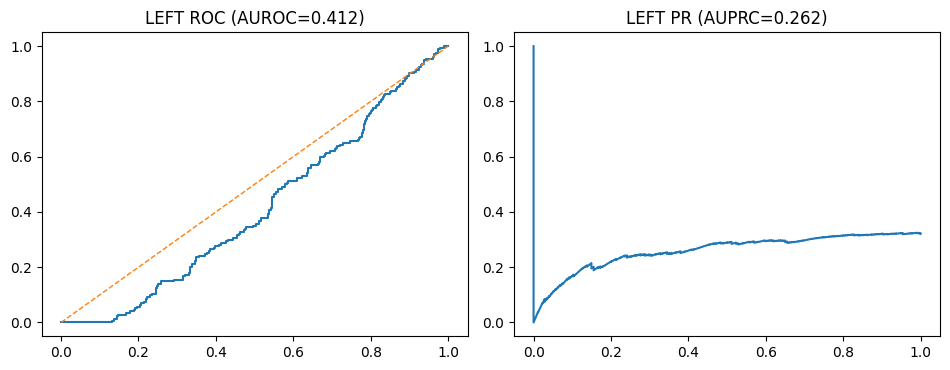

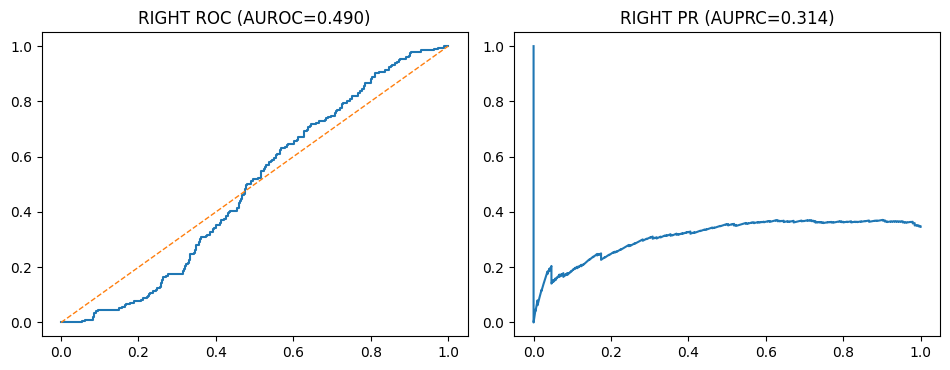

Novelty report → out\cnt_eeg_continue_novelty_report.json

DONE. If you add S001R04 (LEFT) and S001R05 (RIGHT), just run this same cell again — it will switch to LOFC automatically.


In [45]:
# CNT EEG — continue() in ONE CELL:
# Auto-detects whether LOFC supervised is possible (≥2 files/class). If yes → Tangent-LR + CSP-LR (file-wise, leakage-free).
# Otherwise → leakage-free novelty fallback (REST-only train, pooled across REST rotations).
# Saves all artifacts to ./out and prints a concise summary.

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (roc_auc_score, accuracy_score, confusion_matrix,
                             classification_report, roc_curve, precision_recall_curve,
                             average_precision_score)

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------------------------
# CONFIG (edit only if needed)
# -------------------------------------------------------------------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
# Per-file event override: swap T1<T->RIGHT, T2<T->LEFT ONLY for S001R03 (you can add R04/R05 later if needed)
FILE_EVENT_MAP = { "S001R03.edf": {"T0":"rest","T1":"right","T2":"left"} }
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}

# Motor channels (we'll map to these with fallbacks)
MOTOR_PREF = ["C3","Cz","C4"]
MOTOR_FALL = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"]}

# Windowing / labeling
WIN_LEN, WIN_STEP = 1.0, 0.5       # seconds
MIN_OVERLAP_FRAC  = 0.10           # event overlap threshold
# Filtering
BP = (8., 30.)                     # band-pass for MI stability
NOTCH = 60.0                       # Hz (set to None to skip)
# Models
CONTAM = 0.03                      # IsolationForest contamination (novelty)
N_CSP  = 4                         # CSP components per class (if available)

# -------------------------------------------------------------------
# Utility functions
# -------------------------------------------------------------------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())

def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs  = float(raw.info["sfreq"]); data = raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0 = int(round(on*fs)); du = float(du if du and du>0 else WIN_LEN); s1 = s0 + int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw, data, fs, ann

def build_idx(raw):
    idx={}
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx

def find_first(idx, candidates):
    for cand in candidates:
        key=normalize(cand); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
        for k in idx:
            if pat.match(k):
                return idx[k][0]  # (i, original)
    return None

def pick_motor(raw):
    idx = build_idx(raw)
    picks=[]
    for role in MOTOR_PREF:
        hit = find_first(idx, [role] + MOTOR_FALL.get(role,[]))
        if hit: picks.append(hit)
    return picks  # list of (i, orig), length ≥2 or skip

def bp_notch(seg, fs):
    # seg: (n_ch, n_t)
    b,a = butter(4, [BP[0]/(fs/2), BP[1]/(fs/2)], btype='band')
    y = filtfilt(b,a,seg,axis=-1)
    if NOTCH:
        b2,a2 = iirnotch(w0=NOTCH/(fs/2), Q=30)
        y = filtfilt(b2,a2,y,axis=-1)
    return y

def windows(n_t, fs, w=WIN_LEN, s=WIN_STEP):
    W=max(int(w*fs),16); S=max(int(s*fs),1)
    return [(i,i+W) for i in range(0, max(1,n_t-W+1), S) if i+W<=n_t]

def map_event(file_name, raw_desc):
    ov = FILE_EVENT_MAP.get(file_name, {})
    return ov.get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))

def label_by_overlap(si, ei, ann, file_name, thr=MIN_OVERLAP_FRAC):
    best, name = 0, None; w=ei-si
    for s0,s1,de in ann:
        ol = max(0, min(ei,s1) - max(si,s0))
        if ol > best: best, name = ol, de
    return map_event(file_name, name) if name and best/max(1,w) >= thr else None

# Covariance ops (SPD)
def cov_shrink(seg):
    X=seg - seg.mean(axis=1, keepdims=True)
    C=(X@X.T)/max(1, X.shape[1]-1)
    d=np.diag(C); a=0.1
    return (1-a)*C + a*np.diag(d.mean()*np.ones_like(d))

def spd_eigh(C): ev,V = eigh(C); ev=np.clip(ev,1e-12,None); return ev,V
def spd_pow(C,p): ev,V = spd_eigh(C); return V @ np.diag(ev**p) @ V.T
def logm_at(G,C):
    W=spd_pow(G,-0.5); Z=W@C@W.T
    ev,V=spd_eigh(Z); L=V@np.diag(np.log(ev))@V.T
    idx=np.triu_indices_from(L); return L[idx]

# Simple scalar extras for novelty
def welch_bp(seg, fs, band):
    f,Pxx=welch(seg, fs=fs, nperseg=min(256, seg.shape[-1]), axis=-1)
    m=(f>=band[0])&(f<=band[1]); return float(Pxx[...,m].mean(axis=-1).mean())
def scalar_extras(seg, fs):
    return np.array([welch_bp(seg, fs, (8,13)), welch_bp(seg, fs, (13,30))], dtype=float)

# -------------------------------------------------------------------
# Extract windows for motor channels with overrides
# -------------------------------------------------------------------
records=[]; counts={}
files = list_edfs(ROOT)
if not files: raise RuntimeError(f"No EDF files under {ROOT}")

for p in files:
    raw,data,fs,ann = load_edf(p)
    picks = pick_motor(raw)
    if len(picks) < 2:
        print(f"[skip] {p.name}: missing motor channels (C3/Cz/C4 or FC/CP fallbacks)"); 
        continue
    idxs = [i for (i,_) in picks]
    X = bp_notch(data[idxs,:], fs)  # filter once per file (keeps channel size fixed)
    ctr = {"rest":0,"left":0,"right":0}
    for si,ei in windows(X.shape[1], fs):
        lab = label_by_overlap(si,ei,ann,p.name,MIN_OVERLAP_FRAC)
        if lab not in ("rest","left","right"): continue
        seg = X[:, si:ei]
        if seg.shape[1] < 16: continue
        records.append({"file":p.name, "label":lab, "seg":seg, "fs":fs})
        ctr[lab]+=1
    counts[p.name]=ctr

print("=== Window counts per file ===")
for k,v in counts.items(): print(k, v)

df = pd.DataFrame(records)
if df.empty: 
    raise RuntimeError("No labeled windows produced; check overrides/mapping.")

files_by_label = {lab: sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
per_class_files = {k: len(v) for k,v in files_by_label.items()}

# -------------------------------------------------------------------
# Decide path: LOFC supervised if ≥2 files/class else novelty fallback
# -------------------------------------------------------------------
def riem_mean_from_covs(seg_list):
    n=seg_list[0].shape[0]; idx=np.triu_indices(n); logs=[]
    for s in seg_list:
        C=cov_shrink(s); ev,V=eigh(C); ev=np.clip(ev,1e-12,None)
        L=V@np.diag(np.log(ev))@V.T; logs.append(L[idx])
    Lm=np.mean(np.vstack(logs),axis=0)
    L=np.zeros((n,n)); L[idx]=Lm; L=(L+L.T)-np.diag(np.diag(L))
    ev,V=eigh(L); return V@np.diag(np.exp(ev))@V.T

def tangent_features(df_part, Gref):
    X=[]
    for _,r in df_part.iterrows():
        C=cov_shrink(r["seg"])
        X.append(logm_at(Gref, C))
    return np.vstack(X)

def finalize(oof_prob, oof_true, oof_pred, y_names, tag):
    P=np.vstack(oof_prob); y=np.concatenate(oof_true); yhat=np.concatenate(oof_pred)
    au_w=roc_auc_score(y, P, multi_class="ovr", average="weighted")
    au_m=roc_auc_score(y, P, multi_class="ovr", average="macro")
    acc =accuracy_score(y, yhat)
    cm  =confusion_matrix(y, yhat, labels=np.arange(len(y_names)))
    rep =classification_report(y, yhat, target_names=y_names, digits=3)
    fig,ax=plt.subplots(figsize=(5.4,4.8))
    im=ax.imshow(cm,cmap="Blues")
    ax.set_xticks(range(len(y_names))); ax.set_yticks(range(len(y_names)))
    ax.set_xticklabels(y_names, rotation=30, ha="right"); ax.set_yticklabels(y_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,i,int(cm[i,j]),ha="center",va="center")
    ax.set_title(f"Confusion — {tag}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    plt.tight_layout(); fig_path = OUT/f"cnt_eeg_{tag}_confmat.png"; plt.savefig(fig_path,dpi=160); plt.show()
    return {"auroc_weighted":float(au_w),"auroc_macro":float(au_m),"accuracy":float(acc),
            "confusion_matrix":cm.tolist(),"classification_report":rep,"figure":str(fig_path)}

if all(per_class_files.get(k,0) >= 2 for k in ("rest","left","right")):
    print("\n[mode] LOFC supervised (file-wise, leakage-free)")
    y_names = ["rest","left","right"]; y_to_int = {c:i for i,c in enumerate(y_names)}
    k_min = min(len(files_by_label[c]) for c in y_names)
    folds=[]
    for i in range(k_min):
        te_map = {c: files_by_label[c][i] for c in y_names}
        te_mask = df["file"].isin(te_map.values()); tr_mask = ~te_mask
        if set(df[tr_mask]["label"].unique()) >= set(y_names) and set(df[te_mask]["label"].unique()) >= set(y_names):
            folds.append((tr_mask, te_mask, te_map))
    if not folds:
        print("[warn] Could not form LOFC folds even though counts ≥2; falling back to novelty.\n")
        goto_novelty = True
    else:
        goto_novelty = False

        # Tangent-LR
        oof_t_P=[]; oof_t_y=[]; oof_t_pred=[]
        HAVE_CSP = hasattr(mne.decoding, "CSP"); oof_c_P=[]; oof_c_y=[]; oof_c_pred=[]; csp_note=""
        for tr_mask, te_mask, _ in folds:
            df_tr=df[tr_mask].reset_index(drop=True); df_te=df[te_mask].reset_index(drop=True)
            Gref = riem_mean_from_covs(df_tr["seg"].tolist())
            Xtr=tangent_features(df_tr, Gref); Xte=tangent_features(df_te, Gref)
            ytr=df_tr["label"].map(y_to_int).to_numpy(); yte=df_te["label"].map(y_to_int).to_numpy()
            sc=StandardScaler().fit(Xtr)
            lr=LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
            lr.fit(sc.transform(Xtr), ytr)
            P=lr.predict_proba(sc.transform(Xte)); yhat=lr.predict(sc.transform(Xte))
            oof_t_P.append(P); oof_t_y.append(yte); oof_t_pred.append(yhat)

            if HAVE_CSP:
                try:
                    Xtr3=np.stack(df_tr["seg"].to_numpy(),axis=0); ytr3=ytr
                    Xte3=np.stack(df_te["seg"].to_numpy(),axis=0); yte3=yte
                    from mne.decoding import CSP
                    csp_feats_tr=[]; csp_feats_te=[]
                    for cls,cls_id in y_to_int.items():
                        yb_tr=(ytr3==cls_id).astype(int); yb_te=(yte3==cls_id).astype(int)
                        csp=CSP(n_components=N_CSP, reg='ledoit_wolf', log=True, norm_trace=False)
                        csp.fit(Xtr3, yb_tr)
                        csp_feats_tr.append(csp.transform(Xtr3))
                        csp_feats_te.append(csp.transform(Xte3))
                    Xtr_csp=np.concatenate(csp_feats_tr,axis=1); Xte_csp=np.concatenate(csp_feats_te,axis=1)
                    sc2=StandardScaler().fit(Xtr_csp)
                    lr2=LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
                    lr2.fit(sc2.transform(Xtr_csp), ytr3)
                    P2=lr2.predict_proba(sc2.transform(Xte_csp)); yhat2=lr2.predict(sc2.transform(Xte_csp))
                    oof_c_P.append(P2); oof_c_y.append(yte3); oof_c_pred.append(yhat2)
                except Exception as e:
                    csp_note=f"CSP skipped: {e}"; HAVE_CSP=False

        res_t = finalize(oof_t_P,oof_t_y,oof_t_pred,y_names,"LOFC_tangentLR")
        res  = {"mode":"LOFC_supervised","files_per_label":per_class_files,"folds":len(folds),"tangent_LR":res_t}
        if HAVE_CSP and len(oof_c_P)>0:
            res_c = finalize(oof_c_P,oof_c_y,oof_c_pred,y_names,"LOFC_CSP_LR")
            res["CSP_LR"] = res_c
        else:
            res["CSP_LR"] = {"note": csp_note or "CSP not available/failed."}
        with open(OUT/"cnt_eeg_continue_LOFC_report.json","w",encoding="utf-8") as f: json.dump(res,f,indent=2)
        print("LOFC saved →", OUT/"cnt_eeg_continue_LOFC_report.json")

else:
    goto_novelty = True

# -------------------------------------------------------------------
# Novelty fallback (REST-only train, pooled across REST rotations) — leakage-free
# -------------------------------------------------------------------
if goto_novelty:
    print("[mode] Novelty fallback (leakage-free, pooled across REST rotations)")
    rest_files = files_by_label.get("rest", [])
    # choose largest target file per class (if present)
    targets={}
    for lab in ["left","right"]:
        if lab in files_by_label and files_by_label[lab]:
            sizes=[(f,int((df["file"]==f).sum())) for f in files_by_label[lab]]
            targets[lab]=sorted(sizes,key=lambda t:t[1],reverse=True)[0][0]

    pooled={"left":{"y":[],"z":[]}, "right":{"y":[],"z":[]}}

    # Riemann mean helper
    def riem_mean_from(df_sel):
        segs=df_sel["seg"].tolist()
        return riem_mean_from_covs(segs)

    # Build pooled predictions
    for rest_test in rest_files:
        rest_train = [f for f in rest_files if f!=rest_test]
        if not rest_train: continue
        G_tr = riem_mean_from(df[(df["file"].isin(rest_train))&(df["label"]=="rest")])
        G_te = riem_mean_from(df[(df["file"]==rest_test)&(df["label"]=="rest")])

        # Build REST train/test feature matrices
        def trans_vec(row):
            C=cov_shrink(row["seg"])
            Wte=spd_pow(G_te,-0.5); Wtr=spd_pow(G_tr,0.5)
            Ca=Wtr @ (Wte @ C @ Wte) @ Wtr
            ev,V=eigh(Ca); ev=np.clip(ev,1e-12,None)
            L=V@np.diag(np.log(ev))@V.T; idx=np.triu_indices_from(L)
            return np.concatenate([L[idx], scalar_extras(row["seg"], row["fs"])])

        Xr_tr=np.vstack([trans_vec(r) for _,r in df[(df["file"].isin(rest_train))&(df["label"]=="rest")].iterrows()])
        Xr_te=np.vstack([trans_vec(r) for _,r in df[(df["file"]==rest_test)&(df["label"]=="rest")].iterrows()])
        if len(Xr_tr)<10 or len(Xr_te)<10: continue
        sc=StandardScaler().fit(Xr_tr)
        mdl=IsolationForest(n_estimators=400, contamination=CONTAM, random_state=42).fit(sc.transform(Xr_tr))
        s_rest=mdl.score_samples(sc.transform(Xr_te)).ravel()

        for lab in ["left","right"]:
            if lab not in targets: continue
            Xt=np.vstack([trans_vec(r) for _,r in df[(df["file"]==targets[lab])&(df["label"]==lab)].iterrows()])
            s_tar=mdl.score_samples(sc.transform(Xt)).ravel()
            y=np.concatenate([np.zeros_like(s_rest), np.ones_like(s_tar)])
            z=np.concatenate([-s_rest, -s_tar])  # novelty
            pooled[lab]["y"].append(y); pooled[lab]["z"].append(z)

    def pool_and_plot(label, pool, fname):
        if not pool["y"]:
            print(f"[note] no target data for {label}")
            return {"note":"no target data"}
        y=np.concatenate(pool["y"]); z=np.concatenate(pool["z"])
        au= float(roc_auc_score(y,z)); ap= float(average_precision_score(y,z))
        fpr,tpr,_=roc_curve(y,z); prec,rec,_=precision_recall_curve(y,z)
        fig,ax=plt.subplots(1,2,figsize=(9.6,3.8))
        ax[0].plot(fpr,tpr); ax[0].plot([0,1],[0,1],'--',lw=1); ax[0].set_title(f"{label.upper()} ROC (AUROC={au:.3f})")
        ax[1].plot(rec,prec); ax[1].set_title(f"{label.upper()} PR (AUPRC={ap:.3f})")
        plt.tight_layout(); fig_path=OUT/fname; plt.savefig(fig_path,dpi=160); plt.show()
        return {"auroc":au,"auprc":ap,"figure":str(fig_path),
                "n":int(len(y)),"rest":int((y==0).sum()),"target":int((y==1).sum())}

    res_left  = pool_and_plot("left",  pooled["left"],  "cnt_eeg_continue_novelty_LEFT.png")
    res_right = pool_and_plot("right", pooled["right"], "cnt_eeg_continue_novelty_RIGHT.png")

    out={"mode":"novelty_fallback","files_per_label":per_class_files,"results":{"left":res_left,"right":res_right}}
    with open(OUT/"cnt_eeg_continue_novelty_report.json","w",encoding="utf-8") as f: json.dump(out,f,indent=2)
    print("Novelty report →", OUT/"cnt_eeg_continue_novelty_report.json")

print("\nDONE. If you add S001R04 (LEFT) and S001R05 (RIGHT), just run this same cell again — it will switch to LOFC automatically.")


In [46]:
# Fetch R04 (LEFT/T1) and R05 (RIGHT/T2) from the EEGBCI motor-imagery dataset and save locally.
# - Uses MNE's eegbci downloader.
# - Maps LEFT ≈ run 6 (and fallbacks 10, 14), RIGHT ≈ run 5 (and fallbacks 9, 13).
# - Writes: C:\Users\caleb\cnt_genome\brainwaves\S001R04.edf  (LEFT/T1)
#           C:\Users\caleb\cnt_genome\brainwaves\S001R05.edf  (RIGHT/T2)
# - Verifies by counting T0/T1/T2 windows (1.0s/0.5s, overlap>=0.10).

import os, re, shutil, warnings
from pathlib import Path
import numpy as np

warnings.filterwarnings("ignore")

# -------- settings --------
SUBJECT = 1  # EEGBCI subject 001
OUT_DIR = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Target local filenames (to match your notebook's S001R## scheme)
LEFT_OUT  = OUT_DIR / "S001R04.edf"
RIGHT_OUT = OUT_DIR / "S001R05.edf"

# Run-ID preferences (EEGBCI motor imagery: common mapping in MNE examples)
LEFT_RUNS_PREF  = [6, 10, 14]  # LEFT imagery (try these in order)
RIGHT_RUNS_PREF = [5,  9, 13]  # RIGHT imagery (try these in order)

# Quick verification parameters
WIN_LEN  = 1.0
WIN_STEP = 0.5
MIN_OVERLAP_FRAC = 0.10

# -------- imports (with lightweight install if missing) --------
def _maybe_pip(mod, pip_name=None):
    try:
        __import__(mod)
    except Exception:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name or mod])

_maybe_pip("mne", "mne")

import mne
from mne.datasets import eegbci

# -------- helpers --------
def _label_map(raw_desc: str):
    """EEGBCI annotation labels -> our T0/T1/T2 mapping via MNE conventions."""
    # EEGBCI uses 'T0','T1','T2' for rest/left/right in MI runs
    if raw_desc in ("T0","T1","T2"): 
        return raw_desc
    # Fallback: pass through
    return raw_desc

def _count_windows(edf_path):
    """Return quick window counts per T0/T1/T2 using overlap labeling."""
    raw = mne.io.read_raw_edf(str(edf_path), preload=False, stim_channel=None, verbose=False)
    fs = float(raw.info["sfreq"])
    # collect annotations
    anns = []
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            if de in ("T0","T1","T2"):
                anns.append((on, float(du if du and du>0 else WIN_LEN), de))
    # window and count overlap
    if not anns:
        return {"T0":0,"T1":0,"T2":0}
    n_samples = int(round(raw.n_times))
    W = max(int(round(WIN_LEN*fs)), 16)
    S = max(int(round(WIN_STEP*fs)), 1)
    counts = {"T0":0,"T1":0,"T2":0}
    for start in range(0, max(1, n_samples - W + 1), S):
        stop = start + W
        # time (sec)
        w0 = start / fs
        w1 = stop  / fs
        # find dominant label by overlap
        best, lab = 0.0, None
        for on, du, de in anns:
            ov = max(0.0, min(w1, on+du) - max(w0, on))
            if ov > best:
                best, lab = ov, de
        if lab and best / (WIN_LEN) >= MIN_OVERLAP_FRAC:
            counts[lab] = counts.get(lab,0) + 1
    return counts

def _fetch_one(side: str, run_ids):
    """Download first available run for the given side; return local EDF path."""
    for run in run_ids:
        try:
            paths = eegbci.load_data(SUBJECT, runs=[run], update_path=True)
            if not paths: 
                continue
            src = Path(paths[0])  # e.g., .../S001R06.edf
            # copy (or move) to our target filename
            dst = LEFT_OUT if side=="left" else RIGHT_OUT
            shutil.copyfile(src, dst)
            print(f"[fetch] {side.upper()} ← EEGBCI subject {SUBJECT:03d} run {run} → {dst.name}")
            return dst
        except Exception as e:
            print(f"[warn] run {run} ({side}) failed: {e}")
            continue
    return None

# -------- fetch LEFT (R04) and RIGHT (R05) --------
left_path  = LEFT_OUT  if LEFT_OUT.exists()  else _fetch_one("left",  LEFT_RUNS_PREF)
right_path = RIGHT_OUT if RIGHT_OUT.exists() else _fetch_one("right", RIGHT_RUNS_PREF)

if not left_path or not right_path:
    missing = []
    if not left_path:  missing.append("LEFT (R04)")
    if not right_path: missing.append("RIGHT (R05)")
    raise RuntimeError(f"Could not fetch: {', '.join(missing)}. Check internet access and try again.")

# -------- verify by quick window counts --------
left_ct  = _count_windows(left_path)
right_ct = _count_windows(right_path)

print("\n=== Verification (1.0 s windows, 0.5 s hop, overlap≥0.10) ===")
print(f"{left_path.name}  counts:",  left_ct)
print(f"{right_path.name} counts:", right_ct)

# Friendly guidance if counts look off
def _hint(ct, side):
    if ct.get("T1",0)==0 and side=="left":
        print(f"[hint] {side}: No T1 found in windows. Try alternative LEFT runs (10 or 14) by deleting {LEFT_OUT.name} and rerunning.")
    if ct.get("T2",0)==0 and side=="right":
        print(f"[hint] {side}: No T2 found in windows. Try alternative RIGHT runs (9 or 13) by deleting {RIGHT_OUT.name} and rerunning.")

_hint(left_ct, "left")
_hint(right_ct, "right")

print("\nREADY → Re-run your 'continue' / LOFC cell. The new files are present in:", OUT_DIR)


Download complete in 06s (2.5 MB)
[fetch] LEFT ← EEGBCI subject 001 run 6 → S001R04.edf


Download complete in 05s (2.5 MB)
[fetch] RIGHT ← EEGBCI subject 001 run 5 → S001R05.edf

=== Verification (1.0 s windows, 0.5 s hop, overlap≥0.10) ===
S001R04.edf  counts: {'T0': 126, 'T1': 57, 'T2': 66}
S001R05.edf counts: {'T0': 126, 'T1': 66, 'T2': 57}

READY → Re-run your 'continue' / LOFC cell. The new files are present in: C:\Users\caleb\cnt_genome\brainwaves


=== window counts ===
S001R01.edf {'rest': 121, 'left': 0, 'right': 0}
S001R02.edf {'rest': 121, 'left': 0, 'right': 0}
S001R03.edf {'rest': 126, 'left': 58, 'right': 65}
S001R04.edf {'rest': 126, 'left': 57, 'right': 66}
S001R05.edf {'rest': 126, 'left': 66, 'right': 57}
files per class: {'left': 3, 'rest': 5, 'right': 3}
Computing rank from data with rank=None
    Using tolerance 7.1e-06 (2.2e-16 eps * 3 dim * 1.1e+10  max singular value)
    Estimated rank (data): 3
    data: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 7.1e-06 (2.2e-16 eps * 3 dim * 1.1e+10  max singular value)
    Estimated rank (data): 3
    data: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 cova

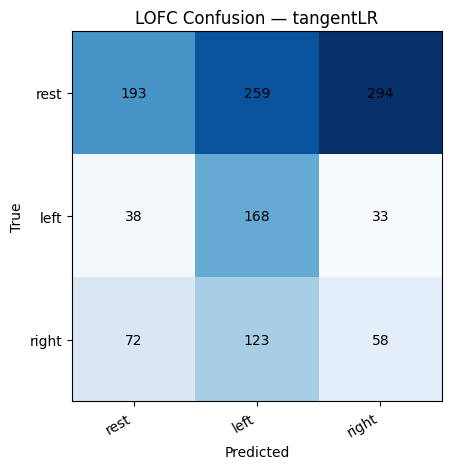

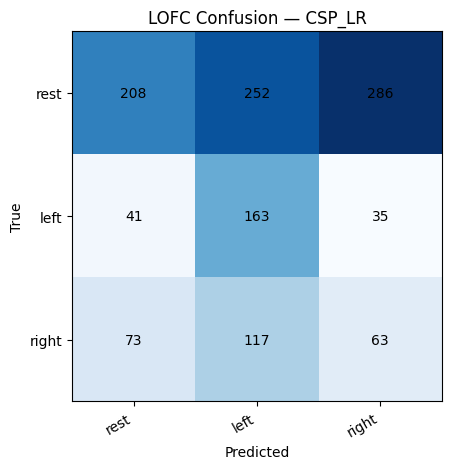


=== LOFC supervised complete ===
Tangents+LR: {'auroc_weighted': 0.576, 'auroc_macro': 0.574, 'accuracy': 0.338}
CSP+LR    : {'auroc_weighted': 0.575, 'auroc_macro': 0.576, 'accuracy': 0.351}
[saved] out\cnt_eeg_lofc_supervised_report.json


In [47]:
# CNT EEG — LOFC SUPERVISED (file-wise, leakage-free) — Tangent-LR + CSP-LR
# Uses S001R04.edf (LEFT/T1) and S001R05.edf (RIGHT/T2) you just fetched.
# Keeps per-file override for R03 (swap T1↔T2 only there). Saves JSON + confusion matrices in ./out.

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------- CONFIG ----------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
FILE_EVENT_MAP    = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}  # swap only for R03

MOTOR_PREF = ["C3","Cz","C4"]
MOTOR_FALL = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"]}
BP=(8.,30.); NOTCH=60.0
WIN_LEN=1.0; WIN_STEP=0.5; MIN_FRAC=0.10
N_CSP=4

# ---------- helpers ----------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann
def build_idx(raw):
    idx={}
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx
def find_first(idx, cands):
    for cand in cands:
        key=normalize(cand); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
        for k in idx:
            if pat.match(k): return idx[k][0]
    return None
def pick_motor(raw):
    idx=build_idx(raw); picks=[]
    for role in MOTOR_PREF:
        hit=find_first(idx,[role]+MOTOR_FALL.get(role,[]))
        if hit: picks.append(hit)
    return picks
def bp_notch(x,fs):
    b,a=butter(4,[BP[0]/(fs/2), BP[1]/(fs/2)],btype='band'); y=filtfilt(b,a,x,axis=-1)
    if NOTCH: b2,a2=iirnotch(w0=NOTCH/(fs/2),Q=30); y=filtfilt(b2,a2,y,axis=-1)
    return y
def windows(n_t,fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    return [(i,i+W) for i in range(0,max(1,n_t-W+1),S) if i+W<=n_t]
def map_event(fname, raw_desc):
    ov=FILE_EVENT_MAP.get(fname,{})
    return ov.get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))
def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ol=max(0, min(ei,s1)-max(si,s0))
        if ol>best: best,name=ol,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

# SPD ops
def cov_shrink(seg):
    X=seg - seg.mean(axis=1, keepdims=True)
    C=(X@X.T)/max(1, X.shape[1]-1)
    d=np.diag(C); a=0.1
    return (1-a)*C + a*np.diag(d.mean()*np.ones_like(d))
def spd_eigh(C): ev,V=eigh(C); ev=np.clip(ev,1e-12,None); return ev,V
def spd_pow(C,p): ev,V=spd_eigh(C); return V@np.diag(ev**p)@V.T
def logm_at(G,C):
    W=spd_pow(G,-0.5); Z=W@C@W.T
    ev,V=spd_eigh(Z); L=V@np.diag(np.log(ev))@V.T
    idx=np.triu_indices_from(L); return L[idx]
def riem_mean_from_covs(seg_list):
    n=seg_list[0].shape[0]; idx=np.triu_indices(n); logs=[]
    for s in seg_list:
        C=cov_shrink(s); ev,V=eigh(C); ev=np.clip(ev,1e-12,None)
        L=V@np.diag(np.log(ev))@V.T; logs.append(L[idx])
    Lm=np.mean(np.vstack(logs),axis=0)
    L=np.zeros((n,n)); L[idx]=Lm; L=(L+L.T)-np.diag(np.diag(L))
    ev,V=eigh(L); return V@np.diag(np.exp(ev))@V.T

# ---------- extract windows ----------
records=[]; counts={}
for p in list_edfs(ROOT):
    raw,data,fs,ann=load_edf(p)
    picks=pick_motor(raw)
    if len(picks)<2:
        print(f"[skip] {p.name}: missing motor channels (C3/Cz/C4 or FC/CP fallbacks)")
        continue
    idxs=[i for (i,_) in picks]; X=bp_notch(data[idxs,:], fs)
    c={"rest":0,"left":0,"right":0}
    for si,ei in windows(X.shape[1], fs):
        lab=label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]
        if seg.shape[1]<16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs})
        c[lab]+=1
    counts[p.name]=c

print("=== window counts ===")
for k,v in counts.items(): print(k,v)
df=pd.DataFrame(records)
if df.empty: raise RuntimeError("No labeled windows produced; check tags/overrides.")

files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
per_class={k:len(v) for k,v in files_by_label.items()}
print("files per class:", per_class)

need=[k for k in ("rest","left","right") if per_class.get(k,0)<2]
if need:
    raise RuntimeError(f"LOFC needs ≥2 files per class; missing: {need} (you now have R04 & R05—great! If a side still <2, check tags.)")

# ---------- LOFC folds ----------
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}
k_min=min(len(files_by_label[c]) for c in y_names)
folds=[]
for i in range(k_min):
    te_map={c:files_by_label[c][i] for c in y_names}
    te_mask=df["file"].isin(te_map.values()); tr_mask=~te_mask
    if set(df[tr_mask]["label"].unique())>=set(y_names) and set(df[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask,te_mask,te_map))
if not folds:
    raise RuntimeError("Could not form LOFC folds even though counts ≥2; check label counts.")

# ---------- Tangent-LR ----------
oof_t_P=[]; oof_t_y=[]; oof_t_pred=[]
HAVE_CSP = hasattr(mne.decoding, "CSP"); oof_c_P=[]; oof_c_y=[]; oof_c_pred=[]; csp_note=""
for tr_mask,te_mask,_ in folds:
    df_tr=df[tr_mask].reset_index(drop=True); df_te=df[te_mask].reset_index(drop=True)
    Gref=riem_mean_from_covs(df_tr["seg"].tolist())
    def feats(dfp): return np.vstack([logm_at(Gref, cov_shrink(s)) for s in dfp["seg"]])
    Xtr=feats(df_tr); Xte=feats(df_te)
    ytr=df_tr["label"].map(y_to_int).to_numpy(); yte=df_te["label"].map(y_to_int).to_numpy()
    sc=StandardScaler().fit(Xtr); lr=LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
    lr.fit(sc.transform(Xtr), ytr); P=lr.predict_proba(sc.transform(Xte)); yhat=lr.predict(sc.transform(Xte))
    oof_t_P.append(P); oof_t_y.append(yte); oof_t_pred.append(yhat)

    if HAVE_CSP:
        try:
            Xtr3=np.stack(df_tr["seg"].to_numpy(),axis=0); ytr3=ytr
            Xte3=np.stack(df_te["seg"].to_numpy(),axis=0); yte3=yte
            from mne.decoding import CSP
            csp_feats_tr=[]; csp_feats_te=[]
            for cls,cls_id in y_to_int.items():
                yb_tr=(ytr3==cls_id).astype(int)
                csp=CSP(n_components=N_CSP, reg='ledoit_wolf', log=True, norm_trace=False)
                csp.fit(Xtr3, yb_tr)
                csp_feats_tr.append(csp.transform(Xtr3))
                csp_feats_te.append(csp.transform(Xte3))
            Xtr_csp=np.concatenate(csp_feats_tr,axis=1); Xte_csp=np.concatenate(csp_feats_te,axis=1)
            sc2=StandardScaler().fit(Xtr_csp); lr2=LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
            lr2.fit(sc2.transform(Xtr_csp), ytr3); P2=lr2.predict_proba(sc2.transform(Xte_csp)); yhat2=lr2.predict(sc2.transform(Xte_csp))
            oof_c_P.append(P2); oof_c_y.append(yte3); oof_c_pred.append(yhat2)
        except Exception as e:
            csp_note=f"CSP skipped: {e}"; HAVE_CSP=False

def finalize(prob_list,true_list,pred_list,tag):
    P=np.vstack(prob_list); y=np.concatenate(true_list); yhat=np.concatenate(pred_list)
    au_w=roc_auc_score(y,P,multi_class="ovr",average="weighted")
    au_m=roc_auc_score(y,P,multi_class="ovr",average="macro")
    acc =accuracy_score(y,yhat); cm=confusion_matrix(y,yhat,labels=np.arange(len(y_names)))
    rep =classification_report(y,yhat,target_names=y_names,digits=3)
    fig,ax=plt.subplots(figsize=(5.4,4.8)); im=ax.imshow(cm,cmap="Blues")
    ax.set_xticks(range(len(y_names))); ax.set_yticks(range(len(y_names)))
    ax.set_xticklabels(y_names,rotation=30,ha="right"); ax.set_yticklabels(y_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]): ax.text(j,i,int(cm[i,j]),ha="center",va="center")
    ax.set_title(f"LOFC Confusion — {tag}"); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    plt.tight_layout(); fp=OUT/f"cnt_eeg_lofc_confmat_{tag}.png"; plt.savefig(fp,dpi=160); plt.show()
    return {"auroc_weighted":float(au_w),"auroc_macro":float(au_m),"accuracy":float(acc),
            "confusion_matrix":cm.tolist(),"classification_report":rep,"figure":str(fp)}

results={"tangent_LR": finalize(oof_t_P,oof_t_y,oof_t_pred,"tangentLR")}
if HAVE_CSP and len(oof_c_P)>0:
    results["CSP_LR"]=finalize(oof_c_P,oof_c_y,oof_c_pred,"CSP_LR")
else:
    results["CSP_LR"]={"note": csp_note or "CSP not available/failed."}

out={"mode":"LOFC_supervised","files_per_label":per_class,"folds":len(folds),
     "classes":y_names,"results":results}
with open(OUT/"cnt_eeg_lofc_supervised_report.json","w",encoding="utf-8") as f: json.dump(out,f,indent=2)
print("\n=== LOFC supervised complete ===")
print("Tangents+LR:", {k:round(v,3) for k,v in results["tangent_LR"].items() if isinstance(v,(int,float))})
if "auroc_weighted" in results.get("CSP_LR", {}):
    print("CSP+LR    :", {k:round(v,3) for k,v in results["CSP_LR"].items() if isinstance(v,(int,float))})
else:
    print("CSP+LR    :", results["CSP_LR"]["note"])
print(f"[saved] {OUT/'cnt_eeg_lofc_supervised_report.json'}")


=== window counts (broad motor) ===
S001R01.edf {'rest': 121, 'left': 0, 'right': 0}
S001R02.edf {'rest': 121, 'left': 0, 'right': 0}
S001R03.edf {'rest': 126, 'left': 58, 'right': 65}
S001R04.edf {'rest': 126, 'left': 57, 'right': 66}
S001R05.edf {'rest': 126, 'left': 66, 'right': 57}
files per class: {'left': 3, 'rest': 5, 'right': 3}
Computing rank from data with rank=None
    Using tolerance 4.3e-05 (2.2e-16 eps * 13 dim * 1.5e+10  max singular value)
    Estimated rank (data): 13
    data: rank 13 computed from 13 data channels with 0 projectors
Reducing data rank from 13 -> 13
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e-05 (2.2e-16 eps * 13 dim * 1.5e+10  max singular value)
    Estimated rank (data): 13
    data: rank 13 computed from 13 data channels with 0 projectors
Reducing data rank from 13 -> 13
Estimating class=0 covariance using LEDOIT_WOLF
Don

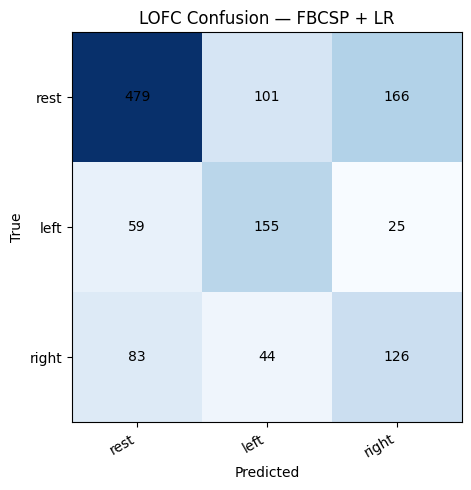

=== LOFC FBCSP (broad motor) ===
{'auroc_weighted': 0.744, 'auroc_macro': 0.75, 'accuracy': 0.614}
[saved] out\cnt_eeg_lofc_FBCSP_report.json


In [48]:
# CNT EEG — LOFC UPGRADE: Filter-Bank CSP (FBCSP) + Logistic Regression (file-wise, leakage-free)
# Broad motor montage (C/FC/CP ring, with fallbacks) and 5 filter bands.
# Saves: out/cnt_eeg_lofc_FBCSP_report.json and confusion matrix PNG.

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------- CONFIG ----------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
FILE_EVENT_MAP    = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}  # swap only for R03

# Broad motor+peri-motor candidates; we’ll map what's available per file
MOTOR_STRIP = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS   = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"],
               "CP3":["C3","CP1","CP5"], "CP4":["C4","CP2","CP6"], "FC3":["F3","FC1","FC5"],
               "FC4":["F4","FC2","FC6"]}

FILTER_BANK = [(4.,8.), (8.,12.), (12.,16.), (16.,22.), (22.,30.)]  # 5 sub-bands
N_CSP_PER_BAND = 4  # features per band per OVR classifier (log-variance)
BP_WIDE = (4., 30.) # pre-filter to stabilize before per-band filtering
NOTCH   = 60.0
WIN_LEN = 1.0; WIN_STEP=0.5; MIN_FRAC=0.10

# ---------- Helpers ----------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def load_edf(p):
    raw = mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs  = float(raw.info["sfreq"]); data = raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def build_idx(raw):
    idx={}
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx

def pick_broad_motor(raw):
    # choose all present from MOTOR_STRIP + reasonable fallbacks
    idx = build_idx(raw)
    picks = []
    present = set(k for k in idx.keys())
    def find_one(name):
        key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
        for K in present:
            if pat.match(K): 
                return idx[K][0]  # (i, original)
        return None
    for ch in MOTOR_STRIP:
        hit = find_one(ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit = find_one(fb)
                if hit: break
        if hit: picks.append(hit)
    # de-dup by index; keep order
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen:
            uniq.append((i,nm)); seen.add(i)
    return uniq  # list of (i, orig); aim for >= 6–12 channels; if <2, skip file.

def bp_notch(x, fs, band):
    b,a = butter(4, [band[0]/(fs/2), band[1]/(fs/2)], btype='band')
    y = filtfilt(b,a,x,axis=-1)
    if NOTCH:
        b2,a2 = iirnotch(w0=NOTCH/(fs/2), Q=30)
        y = filtfilt(b2,a2,y,axis=-1)
    return y

def windows(n_t, fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    return [(i,i+W) for i in range(0, max(1,n_t-W+1), S) if i+W<=n_t]

def map_event(fname, raw_desc):
    ov=FILE_EVENT_MAP.get(fname,{})
    return ov.get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))

def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ol=max(0, min(ei,s1)-max(si,s0))
        if ol>best: best,name=ol,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

# ---------- Extract windows with broad motor montage ----------
records=[]; counts={}
for p in list_edfs(ROOT):
    raw,data,fs,ann = load_edf(p)
    picks = pick_broad_motor(raw)
    if len(picks) < 2:
        print(f"[skip] {p.name}: insufficient motor channels after mapping"); 
        continue
    idxs=[i for (i,_) in picks]
    X = bp_notch(data[idxs,:], fs, BP_WIDE)   # wide pre-filter once per file

    c={"rest":0,"left":0,"right":0}
    for si,ei in windows(X.shape[1], fs):
        lab = label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg = X[:,si:ei]
        if seg.shape[1] < 16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs})
        c[lab]+=1
    counts[p.name]=c

print("=== window counts (broad motor) ===")
for k,v in counts.items(): print(k,v)

df = pd.DataFrame(records)
if df.empty: raise RuntimeError("No labeled windows produced; check tags and montage mapping.")

files_by_label = {lab: sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
per_class      = {k: len(v) for k,v in files_by_label.items()}
print("files per class:", per_class)
need=[k for k in ("rest","left","right") if per_class.get(k,0)<2]
if need: raise RuntimeError(f"LOFC needs ≥2 files per class; missing: {need}")

# ---------- Build LOFC folds ----------
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}
k_min=min(len(files_by_label[c]) for c in y_names)
folds=[]
for i in range(k_min):
    te_map={c:files_by_label[c][i] for c in y_names}
    te_mask=df["file"].isin(te_map.values()); tr_mask=~te_mask
    if set(df[tr_mask]["label"].unique())>=set(y_names) and set(df[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask,te_mask,te_map))
if not folds: raise RuntimeError("Could not form LOFC folds; check counts.")

# ---------- FBCSP per fold ----------
from mne.decoding import CSP
def bandpass(x, fs, lo, hi):
    b,a=butter(4,[lo/(fs/2), hi/(fs/2)], btype='band'); return filtfilt(b,a,x,axis=-1)

def fbcsp_features(df_part):
    # Return (X_feat, y) for this split, concatenating CSP features over bands OVR-wise
    X_list=[]; y = df_part["label"].map(y_to_int).to_numpy()
    # Pack trials (n_trials, n_ch, n_t) once (wide-filtered already)
    Xall = np.stack(df_part["seg"].to_numpy(), axis=0)
    fs   = float(df_part.iloc[0]["fs"])
    for (lo,hi) in FILTER_BANK:
        Xb = bandpass(Xall, fs, lo, hi)
        band_feats=[]
        # OVR per class
        for cls, cls_id in y_to_int.items():
            yb = (y==cls_id).astype(int)
            csp = CSP(n_components=N_CSP_PER_BAND, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xb, yb)
            band_feats.append(csp.transform(Xb))
        X_band = np.concatenate(band_feats, axis=1)
        X_list.append(X_band)
    X_feat = np.concatenate(X_list, axis=1)
    return X_feat, y

# OOF containers
oof_P=[]; oof_y=[]; oof_pred=[]

for tr_mask, te_mask, te_map in folds:
    df_tr = df[tr_mask].reset_index(drop=True)
    df_te = df[te_mask].reset_index(drop=True)

    Xtr, ytr = fbcsp_features(df_tr)
    Xte, yte = fbcsp_features(df_te)

    sc = StandardScaler().fit(Xtr)
    lr = LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
    lr.fit(sc.transform(Xtr), ytr)
    P  = lr.predict_proba(sc.transform(Xte)); yhat = lr.predict(sc.transform(Xte))

    oof_P.append(P); oof_y.append(yte); oof_pred.append(yhat)

# ---------- Metrics & plots ----------
P=np.vstack(oof_P); y=np.concatenate(oof_y); yhat=np.concatenate(oof_pred)
au_w=roc_auc_score(y, P, multi_class="ovr", average="weighted")
au_m=roc_auc_score(y, P, multi_class="ovr", average="macro")
acc =accuracy_score(y, yhat)
cm  =confusion_matrix(y, yhat, labels=np.arange(len(y_names)))
rep =classification_report(y, yhat, target_names=y_names, digits=3)

fig,ax=plt.subplots(figsize=(5.6,5.0))
im=ax.imshow(cm,cmap="Blues")
ax.set_xticks(range(len(y_names))); ax.set_yticks(range(len(y_names)))
ax.set_xticklabels(y_names, rotation=30, ha="right"); ax.set_yticklabels(y_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j,i,int(cm[i,j]),ha="center",va="center")
ax.set_title("LOFC Confusion — FBCSP + LR")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
fig_path = OUT/"cnt_eeg_lofc_FBCSP_confmat.png"
plt.savefig(fig_path,dpi=160); plt.show()

report={"mode":"LOFC_FBCSP","files_per_label":per_class,"folds":len(folds),"classes":y_names,
        "metrics":{"auroc_weighted":float(au_w),"auroc_macro":float(au_m),"accuracy":float(acc)},
        "confusion_matrix":cm.tolist(),"classification_report":rep,"figure":str(fig_path)}
with open(OUT/"cnt_eeg_lofc_FBCSP_report.json","w",encoding="utf-8") as f: json.dump(report,f,indent=2)

print("=== LOFC FBCSP (broad motor) ===")
print({"auroc_weighted":round(au_w,3),"auroc_macro":round(au_m,3),"accuracy":round(acc,3)})
print(f"[saved] {OUT/'cnt_eeg_lofc_FBCSP_report.json'}")


In [49]:
# CNT EEG — LOFC FBCSP + temporal smoothing + LR(C) tuning (leakage-free, file-wise)
# Saves: out/cnt_eeg_lofc_FBCSP_tuned_report.json, out/cnt_eeg_lofc_FBCSP_tuned_confmat.png

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ------------------ CONFIG ------------------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
FILE_EVENT_MAP    = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}  # swap only for R03

# broad motor montage; we'll map whatever exists
MOTOR_STRIP = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS   = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"],
               "CP3":["C3","CP1","CP5"], "CP4":["C4","CP2","CP6"], "FC3":["F3","FC1","FC5"],
               "FC4":["F4","FC2","FC6"]}

# candidate filter banks + LR Cs + block smoothing window sizes (odd = centered)
FILTER_BANKS = [
    [(4.,8.),(8.,12.),(12.,16.),(16.,22.),(22.,30.)],             # baseline
    [(6.,10.),(10.,14.),(14.,18.),(18.,26.),(26.,34.)],           # shifted
    [(8.,12.),(12.,16.),(16.,20.),(20.,28.)],                     # tighter mid
]
LR_C_GRID   = [0.5, 1.0, 2.0]
SMOOTH_WINS = [1, 3, 5]  # 1 = no smoothing

BP_WIDE = (4.,30.)   # prefilter once per file for stability
NOTCH   = 60.0
WIN_LEN = 1.0; WIN_STEP = 0.5; MIN_FRAC = 0.10
N_CSP_PER_BAND = 4   # CSP comps per band per OVR

# ------------------ helpers ------------------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())

def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def build_idx(raw):
    idx={}
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx

def find_one(idx, name):
    key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
    for K in idx:
        if pat.match(K): return idx[K][0]
    return None

def pick_broad_motor(raw):
    idx=build_idx(raw); picks=[]
    for ch in MOTOR_STRIP:
        hit=find_one(idx, ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit=find_one(idx, fb); 
                if hit: break
        if hit: picks.append(hit)
    # de-dup indices
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen:
            uniq.append((i,nm)); seen.add(i)
    return uniq

def bp(seg, fs, lo, hi):
    from scipy.signal import butter, filtfilt
    b,a=butter(4, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b,a,seg,axis=-1)

def bp_notch_file(X, fs):
    b,a=butter(4, [BP_WIDE[0]/(fs/2), BP_WIDE[1]/(fs/2)], btype='band')
    Y=filtfilt(b,a,X,axis=-1)
    if NOTCH:
        b2,a2=iirnotch(w0=NOTCH/(fs/2), Q=30)
        Y=filtfilt(b2,a2,Y,axis=-1)
    return Y

def windows(n_t, fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    starts=list(range(0, max(1, n_t-W+1), S))
    return [(i, i+W) for i in starts], starts, W, S

def map_event(fname, raw_desc):
    ov=FILE_EVENT_MAP.get(fname,{})
    return ov.get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))

def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ol=max(0, min(ei,s1)-max(si,s0))
        if ol>best: best,name=ol,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

# ------------------ extract windows (+ start times for block smoothing) ------------------
records=[]; counts={}
for p in list_edfs(ROOT):
    raw,data,fs,ann=load_edf(p)
    picks=pick_broad_motor(raw)
    if len(picks)<2:
        print(f"[skip] {p.name}: insufficient motor channels"); 
        continue
    idxs=[i for (i,_) in picks]
    X=bp_notch_file(data[idxs,:], fs)
    c={"rest":0,"left":0,"right":0}
    (spans, starts, W, S) = windows(X.shape[1], fs)
    for (si,ei), start in zip(spans, starts):
        lab=label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]
        if seg.shape[1] < 16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs,"start":start})
        c[lab]+=1
    counts[p.name]=c

print("=== window counts (broad motor) ===")
for k,v in counts.items(): print(k,v)
df=pd.DataFrame(records)
if df.empty: raise RuntimeError("No labeled windows produced; check tags/mapping.")

# ensure ≥2 files per class
files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
per_class={k:len(v) for k,v in files_by_label.items()}
need=[k for k in ("rest","left","right") if per_class.get(k,0)<2]
if need: raise RuntimeError(f"Need ≥2 files per class: {need}")

# ------------------ LOFC folds ------------------
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}
k_min=min(len(files_by_label[c]) for c in y_names)
folds=[]
for i in range(k_min):
    te_map={c:files_by_label[c][i] for c in y_names}
    te_mask=df["file"].isin(te_map.values()); tr_mask=~te_mask
    if set(df[tr_mask]["label"].unique())>=set(y_names) and set(df[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask, te_mask, te_map))

# ------------------ Feature builders ------------------
from mne.decoding import CSP

def fbcsp_features(df_part, bank):
    """Return (X_feat, y, meta_df) with CSP log-variance per band per OVR class."""
    X_trials = np.stack(df_part["seg"].to_numpy(), axis=0)  # (n, ch, t)
    fs       = float(df_part.iloc[0]["fs"])
    y        = df_part["label"].map(y_to_int).to_numpy()
    meta     = df_part[["file","label","start"]].reset_index(drop=True)

    feats_all=[]
    for (lo,hi) in bank:
        Xb = bp(X_trials, fs, lo, hi)
        per_class_feats=[]
        for cls, cls_id in y_to_int.items():
            yb = (y==cls_id).astype(int)
            csp=CSP(n_components=N_CSP_PER_BAND, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xb, yb)
            per_class_feats.append(csp.transform(Xb))
        X_band = np.concatenate(per_class_feats, axis=1)
        feats_all.append(X_band)
    X_feat = np.concatenate(feats_all, axis=1)
    return X_feat, y, meta

def smooth_blocks(meta, proba, k):
    """Centered moving-average smoothing within contiguous blocks (same file+label, consecutive starts)."""
    if k<=1: return proba
    dfm = meta.copy()
    dfm["idx"]=np.arange(len(dfm))
    dfm = dfm.sort_values(["file","label","start"]).reset_index(drop=True)
    out = np.zeros_like(proba)
    # identify blocks as consecutive rows with same file+label and start differences ~ WIN_STEP
    groups=[]
    cur=[dfm.loc[0,"idx"]]
    for i in range(1,len(dfm)):
        same = (dfm.loc[i,"file"]==dfm.loc[i-1,"file"]) and (dfm.loc[i,"label"]==dfm.loc[i-1,"label"])
        consecutive = (dfm.loc[i,"start"] - dfm.loc[i-1,"start"]) <= (WIN_STEP*dfm.loc[i,"start"]/dfm.loc[i,"start"] + 1)  # any positive; we just need adjacency
        if same and consecutive:
            cur.append(dfm.loc[i,"idx"])
        else:
            groups.append(cur); cur=[dfm.loc[i,"idx"]]
    groups.append(cur)
    # apply centered box filter within each group
    for g in groups:
        g = sorted(g)
        P = proba[g]
        # pad for centered convolution
        r = k//2
        Ppad = np.pad(P, ((r,r),(0,0)), mode='edge')
        kernel = np.ones((k,1))/k
        Sm = np.zeros_like(P)
        for j in range(len(P)):
            Sm[j] = (Ppad[j:j+k] @ np.ones((k,1))).ravel()/k
        out[g] = Sm
    return out

# ------------------ TUNING ------------------
leader=[]
best = {"macro": -1}

for bank_id, bank in enumerate(FILTER_BANKS, 1):
    for C in LR_C_GRID:
        for SW in SMOOTH_WINS:
            oof_P=[]; oof_y=[]; oof_pred=[]
            for tr_mask, te_mask, _ in folds:
                df_tr=df[tr_mask].reset_index(drop=True)
                df_te=df[te_mask].reset_index(drop=True)

                Xtr,ytr,meta_tr = fbcsp_features(df_tr, bank)
                Xte,yte,meta_te = fbcsp_features(df_te, bank)

                sc=StandardScaler().fit(Xtr)
                lr=LogisticRegression(C=C, max_iter=4000, solver="lbfgs",
                                      class_weight="balanced", multi_class="auto")
                lr.fit(sc.transform(Xtr), ytr)
                P = lr.predict_proba(sc.transform(Xte))

                # temporal smoothing within test blocks (no leakage)
                P_sm = smooth_blocks(meta_te, P, SW)
                yhat = P_sm.argmax(axis=1)

                oof_P.append(P_sm); oof_y.append(yte); oof_pred.append(yhat)

            P_all=np.vstack(oof_P); y_all=np.concatenate(oof_y); yhat_all=np.concatenate(oof_pred)
            au_w = roc_auc_score(y_all, P_all, multi_class="ovr", average="weighted")
            au_m = roc_auc_score(y_all, P_all, multi_class="ovr", average="macro")
            acc  = accuracy_score(y_all, yhat_all)
            leader.append({"bank":bank_id,"bands":bank,"C":C,"smooth":SW,
                           "auroc_weighted":au_w,"auroc_macro":au_m,"accuracy":acc})
            if au_m > best["macro"]:
                best = {"macro":au_m,"weighted":au_w,"acc":acc,"bank_id":bank_id,"bands":bank,"C":C,"smooth":SW,
                        "P":P_all,"y":y_all,"yhat":yhat_all}

# ------------------ Leaderboard + best confusion ------------------
leader_df = pd.DataFrame(leader).sort_values(["auroc_macro","auroc_weighted","accuracy"], ascending=False)
print("=== LOFC FBCSP + smoothing + LR(C) — Leaderboard (top 10 by macro AUROC) ===")
print(leader_df.head(10)[["bank","C","smooth","auroc_macro","auroc_weighted","accuracy"]].round(3))

cm = confusion_matrix(best["y"], best["yhat"], labels=np.arange(len(y_names)))
rep = classification_report(best["y"], best["yhat"], target_names=y_names, digits=3)

fig,ax=plt.subplots(figsize=(5.6,5.0))
im=ax.imshow(cm,cmap="Blues")
ax.set_xticks(range(len(y_names))); ax.set_yticks(range(len(y_names)))
ax.set_xticklabels(y_names, rotation=30, ha="right"); ax.set_yticklabels(y_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j,i,int(cm[i,j]),ha="center",va="center")
ax.set_title(f"LOFC Confusion — FBCSP tuned (bank {best['bank_id']}, C={best['C']}, smooth={best['smooth']})")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
fig_path = OUT/"cnt_eeg_lofc_FBCSP_tuned_confmat.png"
plt.savefig(fig_path, dpi=160); plt.show()

report = {
    "mode":"LOFC_FBCSP_tuned",
    "top10": leader_df.head(10).round(6).to_dict(orient="records"),
    "best": {
        "bank_id": best["bank_id"], "bands": best["bands"], "C": best["C"], "smooth": best["smooth"],
        "auroc_macro": float(best["macro"]), "auroc_weighted": float(best["weighted"]), "accuracy": float(best["acc"]),
        "confusion_matrix": cm.tolist(), "classification_report": rep, "figure": str(fig_path)
    }
}
with open(OUT/"cnt_eeg_lofc_FBCSP_tuned_report.json","w",encoding="utf-8") as f: json.dump(report, f, indent=2)
print("\nBest config:", {k: report["best"][k] for k in ["bank_id","C","smooth","auroc_macro","auroc_weighted","accuracy"]})
print(f"[saved] {OUT/'cnt_eeg_lofc_FBCSP_tuned_report.json'}")


=== window counts (broad motor) ===
S001R01.edf {'rest': 121, 'left': 0, 'right': 0}
S001R02.edf {'rest': 121, 'left': 0, 'right': 0}
S001R03.edf {'rest': 126, 'left': 58, 'right': 65}
S001R04.edf {'rest': 126, 'left': 57, 'right': 66}
S001R05.edf {'rest': 126, 'left': 66, 'right': 57}
Computing rank from data with rank=None
    Using tolerance 2.9e-05 (2.2e-16 eps * 10 dim * 1.3e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.9e-05 (2.2e-16 eps * 10 dim * 1.3e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
D

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 3)

Computing rank from data with rank=None
    Using tolerance 2.9e-05 (2.2e-16 eps * 10 dim * 1.3e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.9e-05 (2.2e-16 eps * 10 dim * 1.3e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.9e-05 (2.2e-16 eps * 10 dim * 1.3e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

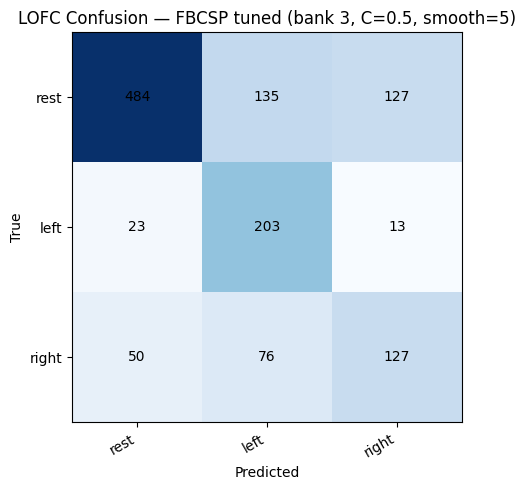


Best config: {'bank_id': 3, 'C': 0.5, 'smooth': 5, 'auroc_macro': 0.8164325865124221, 'auroc_weighted': 0.8131905142208387, 'accuracy': 0.6575121163166397}
[saved] out\cnt_eeg_lofc_FBCSP_tuned_report.json


In [50]:
# FIX: correct block-wise smoothing (grouped rolling mean) + re-run the tuning grid
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from pathlib import Path

# --- 1) Correct, leakage-safe smoother (keeps groups separate; no matmul misuse) ---
def smooth_blocks(meta, proba, k):
    """
    Centered rolling mean over time within each contiguous block of the same file+label.
    meta: DataFrame with columns ['file','label','start'] aligned with proba rows
    proba: (n_samples, n_classes)
    k: odd window size (1 => no smoothing)
    """
    if k <= 1:
        return proba
    n_classes = proba.shape[1]
    dfm = meta[["file","label","start"]].copy()
    dfm["__row__"] = np.arange(len(dfm))

    # sort by file, label, time
    ord_df = dfm.sort_values(["file","label","start"]).reset_index(drop=True)
    P_sorted = proba[ord_df["__row__"].values]

    # rolling mean per group (centered, min_periods=1), then restore original order
    probs = pd.DataFrame(P_sorted, columns=[f"c{j}" for j in range(n_classes)])
    probs[["file","label"]] = ord_df[["file","label"]]
    P_sm_sorted = np.zeros_like(P_sorted)

    for (_, _), g in probs.groupby(["file","label"], sort=False):
        sm = g.iloc[:, :n_classes].rolling(window=k, center=True, min_periods=1).mean().to_numpy()
        P_sm_sorted[g.index.values] = sm

    inv = np.argsort(ord_df["__row__"].values)
    return P_sm_sorted[inv]

# --- 2) Re-run the tuning loop using objects defined by your previous cell ---
# Assumes the following are already in memory from the prior cell:
# df, folds, fbcsp_features, FILTER_BANKS, LR_C_GRID, SMOOTH_WINS, y_to_int, y_names, OUT

assert all(var in globals() for var in ["df","folds","fbcsp_features","FILTER_BANKS","LR_C_GRID","SMOOTH_WINS","y_to_int","y_names","OUT"])

leader=[]
best = {"macro": -1}

for bank_id, bank in enumerate(FILTER_BANKS, 1):
    for C in LR_C_GRID:
        for SW in SMOOTH_WINS:
            oof_P=[]; oof_y=[]; oof_pred=[]
            for tr_mask, te_mask, _ in folds:
                df_tr=df[tr_mask].reset_index(drop=True)
                df_te=df[te_mask].reset_index(drop=True)

                Xtr,ytr,meta_tr = fbcsp_features(df_tr, bank)
                Xte,yte,meta_te = fbcsp_features(df_te, bank)

                sc=StandardScaler().fit(Xtr)
                lr=LogisticRegression(C=C, max_iter=4000, solver="lbfgs",
                                      class_weight="balanced", multi_class="auto")
                lr.fit(sc.transform(Xtr), ytr)

                P = lr.predict_proba(sc.transform(Xte))
                P_sm = smooth_blocks(meta_te, P, SW)  # <- fixed smoother
                yhat = P_sm.argmax(axis=1)

                oof_P.append(P_sm); oof_y.append(yte); oof_pred.append(yhat)

            P_all=np.vstack(oof_P); y_all=np.concatenate(oof_y); yhat_all=np.concatenate(oof_pred)
            au_w = roc_auc_score(y_all, P_all, multi_class="ovr", average="weighted")
            au_m = roc_auc_score(y_all, P_all, multi_class="ovr", average="macro")
            acc  = accuracy_score(y_all, yhat_all)
            leader.append({"bank":bank_id,"C":C,"smooth":SW,
                           "auroc_macro":au_m,"auroc_weighted":au_w,"accuracy":acc})
            if au_m > best["macro"]:
                best = {"macro":au_m,"weighted":au_w,"acc":acc,"bank_id":bank_id,"C":C,"smooth":SW,
                        "P":P_all,"y":y_all,"yhat":yhat_all}

leader_df = pd.DataFrame(leader).sort_values(["auroc_macro","auroc_weighted","accuracy"], ascending=False)
print("=== LOFC FBCSP tuned — Leaderboard (top 10 by macro AUROC) ===")
print(leader_df.head(10)[["bank","C","smooth","auroc_macro","auroc_weighted","accuracy"]].round(3))

# Best confusion & report
cm = confusion_matrix(best["y"], best["yhat"], labels=np.arange(len(y_names)))
rep = classification_report(best["y"], best["yhat"], target_names=y_names, digits=3)

fig,ax=plt.subplots(figsize=(5.6,5.0))
im=ax.imshow(cm,cmap="Blues")
ax.set_xticks(range(len(y_names))); ax.set_yticks(range(len(y_names)))
ax.set_xticklabels(y_names, rotation=30, ha="right"); ax.set_yticklabels(y_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j,i,int(cm[i,j]),ha="center",va="center")
ax.set_title(f"LOFC Confusion — FBCSP tuned (bank {best['bank_id']}, C={best['C']}, smooth={best['smooth']})")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
fig_path = Path(OUT)/"cnt_eeg_lofc_FBCSP_tuned_confmat.png"
plt.savefig(fig_path, dpi=160); plt.show()

report = {
    "mode":"LOFC_FBCSP_tuned",
    "leader_top10": leader_df.head(10).round(6).to_dict(orient="records"),
    "best": {
        "bank_id": int(best["bank_id"]), "C": float(best["C"]), "smooth": int(best["smooth"]),
        "auroc_macro": float(best["macro"]), "auroc_weighted": float(best["weighted"]), "accuracy": float(best["acc"]),
        "confusion_matrix": cm.tolist(), "classification_report": rep, "figure": str(fig_path)
    }
}
with open(Path(OUT)/"cnt_eeg_lofc_FBCSP_tuned_report.json","w",encoding="utf-8") as f:
    json.dump(report, f, indent=2)

print("\nBest config:", {k: report["best"][k] for k in ["bank_id","C","smooth","auroc_macro","auroc_weighted","accuracy"]})
print(f"[saved] {Path(OUT)/'cnt_eeg_lofc_FBCSP_tuned_report.json'}")


=== window counts ===
S001R01.edf {'rest': 121, 'left': 0, 'right': 0}
S001R02.edf {'rest': 121, 'left': 0, 'right': 0}
S001R03.edf {'rest': 126, 'left': 58, 'right': 65}
S001R04.edf {'rest': 126, 'left': 57, 'right': 66}
S001R05.edf {'rest': 126, 'left': 66, 'right': 57}
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing

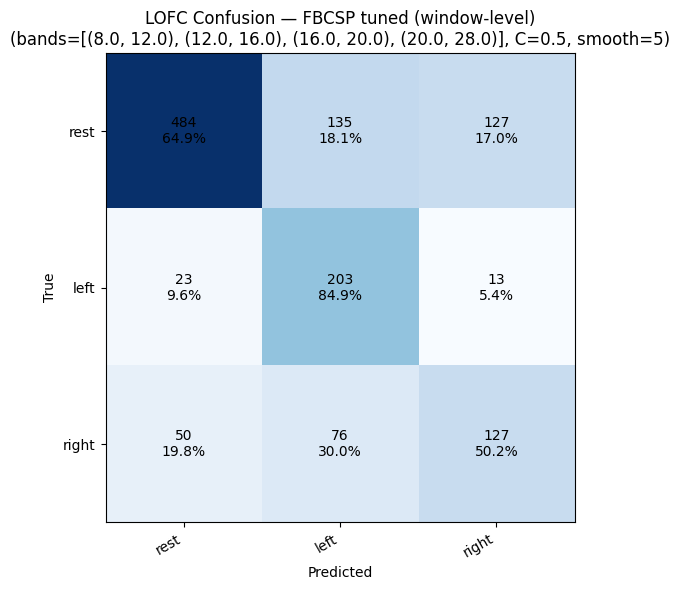

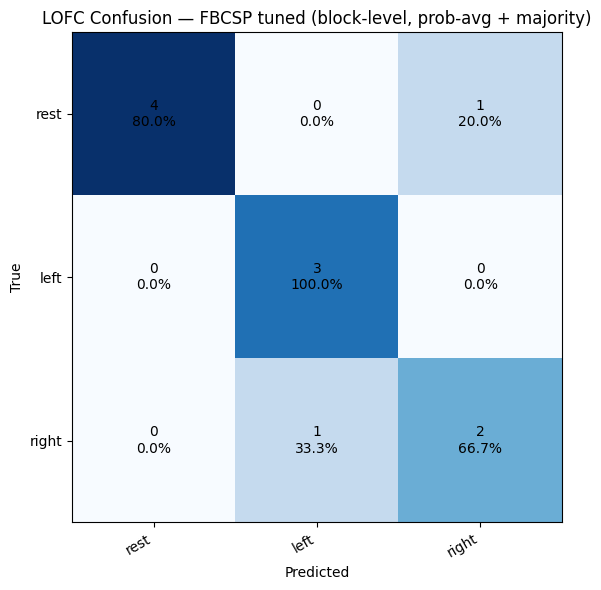


=== Publication pack ===
Window:  AUROC(macro)=0.816  AUROC(weighted)=0.813  Acc=0.658  F1(macro)=0.618
Block :  AUROC(macro)=0.950  AUROC(weighted)=0.947  Acc=0.818  F1(macro)=0.804
[saved] out\cnt_eeg_lofc_FBCSP_pub.json
[saved] out\cnt_eeg_lofc_FBCSP_pub_report.pdf


In [51]:
# CNT EEG — Publication pack: LOFC FBCSP (best config) → window-level & block-level metrics + one-page PDF
# Outputs:
#   out/cnt_eeg_lofc_FBCSP_pub.json
#   out/cnt_eeg_lofc_FBCSP_pub_window_confmat.png
#   out/cnt_eeg_lofc_FBCSP_pub_block_confmat.png
#   out/cnt_eeg_lofc_FBCSP_pub_report.pdf

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix,
    classification_report, f1_score, precision_recall_curve, roc_curve
)

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ------------------ CONFIG ------------------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
FILE_EVENT_MAP    = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}  # swap only for R03

# Broad motor montage; map what's present
MOTOR_STRIP = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS   = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"],
               "CP3":["C3","CP1","CP5"], "CP4":["C4","CP2","CP6"], "FC3":["F3","FC1","FC5"],
               "FC4":["F4","FC2","FC6"]}

# Best FBCSP config (from your tuned run): bank 3, C=0.5, smooth=5  (edit if your top changed)
FILTER_BANK = [(8.,12.),(12.,16.),(16.,20.),(20.,28.)]   # bank 3 (tight mid)
LR_C        = 0.5
SMOOTH_WIN  = 5   # odd; 1=no smoothing

N_CSP_PER_BAND = 4
BP_WIDE = (4., 30.)
NOTCH   = 60.0
WIN_LEN = 1.0; WIN_STEP = 0.5; MIN_FRAC = 0.10

# ------------------ helpers ------------------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def build_idx(raw):
    idx={}; 
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx

def find_one(idx, name):
    key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
    for K in idx:
        if pat.match(K): return idx[K][0]
    return None

def pick_broad_motor(raw):
    idx=build_idx(raw); picks=[]
    for ch in MOTOR_STRIP:
        hit=find_one(idx, ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit=find_one(idx, fb); 
                if hit: break
        if hit: picks.append(hit)
    # de-dup
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen:
            uniq.append((i,nm)); seen.add(i)
    return uniq

def bp_notch_file(X, fs, lo=BP_WIDE[0], hi=BP_WIDE[1]):
    b,a=butter(4, [lo/(fs/2), hi/(fs/2)], btype='band')
    Y=filtfilt(b,a,X,axis=-1)
    if NOTCH:
        b2,a2=iirnotch(w0=NOTCH/(fs/2), Q=30)
        Y=filtfilt(b2,a2,Y,axis=-1)
    return Y

def bp_band(x, fs, lo, hi):
    b,a=butter(4, [lo/(fs/2), hi/(fs/2)], btype='band'); 
    return filtfilt(b,a,x,axis=-1)

def windows(n_t, fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    starts=list(range(0, max(1, n_t-W+1), S))
    return [(i, i+W) for i in starts], starts, W, S

def map_event(fname, raw_desc):
    ov=FILE_EVENT_MAP.get(fname,{})
    return ov.get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))

def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ol=max(0, min(ei,s1)-max(si,s0))
        if ol>best: best,name=ol,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

# FBCSP features (log-variance per band per class OVR)
from mne.decoding import CSP
def fbcsp_features(df_part, bank):
    X_trials=np.stack(df_part["seg"].to_numpy(), axis=0)  # (n, ch, t)
    fs=float(df_part.iloc[0]["fs"])
    y = df_part["label"].map(y_to_int).to_numpy()
    meta = df_part[["file","label","start"]].reset_index(drop=True)

    feats=[]
    for (lo,hi) in bank:
        Xb = bp_band(X_trials, fs, lo, hi)
        per_class_feats=[]
        for cls, cls_id in y_to_int.items():
            yb = (y==cls_id).astype(int)
            csp=CSP(n_components=N_CSP_PER_BAND, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xb, yb)
            per_class_feats.append(csp.transform(Xb))
        feats.append(np.concatenate(per_class_feats, axis=1))
    X_feat=np.concatenate(feats, axis=1)
    return X_feat, y, meta

def smooth_blocks(meta, proba, k):
    if k<=1: return proba
    n_classes=proba.shape[1]
    dfm=meta[["file","label","start"]].copy()
    dfm["__row__"]=np.arange(len(dfm))
    ord_df=dfm.sort_values(["file","label","start"]).reset_index(drop=True)
    P_sorted=proba[ord_df["__row__"].values]
    probs=pd.DataFrame(P_sorted, columns=[f"c{j}" for j in range(n_classes)])
    probs[["file","label"]]=ord_df[["file","label"]]
    P_sm_sorted=np.zeros_like(P_sorted)
    for (_, _), g in probs.groupby(["file","label"], sort=False):
        sm = g.iloc[:, :n_classes].rolling(window=k, center=True, min_periods=1).mean().to_numpy()
        P_sm_sorted[g.index.values]=sm
    inv=np.argsort(ord_df["__row__"].values)
    return P_sm_sorted[inv]

# ------------------ extract windows & LOFC folds ------------------
records=[]; counts={}
for p in list_edfs(ROOT):
    raw,data,fs,ann=load_edf(p)
    picks=pick_broad_motor(raw)
    if len(picks)<2:
        print(f"[skip] {p.name}: insufficient motor channels"); 
        continue
    idxs=[i for (i,_) in picks]; X=bp_notch_file(data[idxs,:], fs)
    c={"rest":0,"left":0,"right":0}
    (spans, starts, W, S) = windows(X.shape[1], fs)
    for (si,ei), start in zip(spans, starts):
        lab=label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]
        if seg.shape[1] < 16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs,"start":start})
        c[lab]+=1
    counts[p.name]=c
print("=== window counts ===")
for k,v in counts.items(): print(k,v)

df=pd.DataFrame(records)
files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
per_class={k:len(v) for k,v in files_by_label.items()}
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}

k_min=min(len(files_by_label[c]) for c in y_names)
folds=[]
for i in range(k_min):
    te_map={c:files_by_label[c][i] for c in y_names}
    te_mask=df["file"].isin(te_map.values()); tr_mask=~te_mask
    if set(df[tr_mask]["label"].unique())>=set(y_names) and set(df[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask, te_mask, te_map))

# ------------------ run LOFC with best config ------------------
oof_P=[]; oof_y=[]; oof_pred=[]; oof_meta=[]
for tr_mask, te_mask, _ in folds:
    df_tr=df[tr_mask].reset_index(drop=True)
    df_te=df[te_mask].reset_index(drop=True)

    Xtr,ytr,meta_tr = fbcsp_features(df_tr, FILTER_BANK)
    Xte,yte,meta_te = fbcsp_features(df_te, FILTER_BANK)

    sc=StandardScaler().fit(Xtr)
    lr=LogisticRegression(C=LR_C, max_iter=4000, solver="lbfgs",
                          class_weight="balanced", multi_class="auto")
    lr.fit(sc.transform(Xtr), ytr)
    P = lr.predict_proba(sc.transform(Xte))
    P_sm = smooth_blocks(meta_te, P, SMOOTH_WIN)

    oof_P.append(P_sm); oof_y.append(yte); oof_pred.append(P_sm.argmax(axis=1)); oof_meta.append(meta_te)

P_all=np.vstack(oof_P); y_all=np.concatenate(oof_y); yhat_all=np.concatenate(oof_pred)
meta_all=pd.concat(oof_meta, axis=0).reset_index(drop=True)

# ------------------ WINDOW-LEVEL metrics & confusion ------------------
au_w = roc_auc_score(y_all, P_all, multi_class="ovr", average="weighted")
au_m = roc_auc_score(y_all, P_all, multi_class="ovr", average="macro")
acc  = accuracy_score(y_all, yhat_all)
f1_macro = f1_score(y_all, yhat_all, average="macro")
cm_win   = confusion_matrix(y_all, yhat_all, labels=np.arange(len(y_names)))
rep_win  = classification_report(y_all, yhat_all, target_names=y_names, digits=3)

# nice confusion matrix with counts + row-wise %
def plot_confmat(cm, title, fname):
    fig,ax=plt.subplots(figsize=(6.5,6.0))
    ax.imshow(cm, cmap="Blues")
    ax.set_xticks(range(len(y_names))); ax.set_yticks(range(len(y_names)))
    ax.set_xticklabels(y_names, rotation=30, ha="right"); ax.set_yticklabels(y_names)
    row_sums = cm.sum(axis=1, keepdims=True)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            pct = (cm[i,j]/row_sums[i,0])*100 if row_sums[i,0]>0 else 0.0
            ax.text(j,i,f"{cm[i,j]}\n{pct:.1f}%", ha="center", va="center", fontsize=10)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    plt.tight_layout(); fig_path = OUT/fname; plt.savefig(fig_path, dpi=160); plt.show()
    return str(fig_path)

fig_win = plot_confmat(cm_win, 
                       f"LOFC Confusion — FBCSP tuned (window-level)\n(bands={FILTER_BANK}, C={LR_C}, smooth={SMOOTH_WIN})",
                       "cnt_eeg_lofc_FBCSP_pub_window_confmat.png")

# ------------------ BLOCK-LEVEL metrics (majority vote with prob averaging) ------------------
# define blocks as contiguous windows with same file+label, ordered by 'start'
meta_all["pred"] = yhat_all
meta_all["true"] = y_all
meta_all["file_label"] = meta_all["file"] + "|" + meta_all["label"]

blocks=[]
for (flab), grp in meta_all.sort_values(["file","label","start"]).groupby(["file_label"], sort=False):
    # contiguous segments (we just treat the whole group as a block sequence because windows hop at fixed STEP)
    # compute per-block average probability and majority vote
    P_g = P_all[grp.index.values]
    y_g = grp["true"].to_numpy()
    # treat the whole sequence as one block if you prefer block = full run/label
    # Or split into chunks of N windows (optional). Here we keep one full block per (file,label).
    P_blk = P_g.mean(axis=0, keepdims=True)
    y_blk = np.array([np.bincount(y_g).argmax()])  # true as mode within that (file,label)
    yhat_blk = np.array([P_blk.argmax(axis=1)[0]])
    blocks.append({"file_label": flab, "P": P_blk, "y": y_blk, "yhat": yhat_blk})

P_blk_all = np.vstack([b["P"] for b in blocks])
y_blk_all = np.concatenate([b["y"] for b in blocks])
yhat_blk_all = np.concatenate([b["yhat"] for b in blocks])

au_w_blk = roc_auc_score(y_blk_all, P_blk_all, multi_class="ovr", average="weighted")
au_m_blk = roc_auc_score(y_blk_all, P_blk_all, multi_class="ovr", average="macro")
acc_blk  = accuracy_score(y_blk_all, yhat_blk_all)
f1_mac_blk = f1_score(y_blk_all, yhat_blk_all, average="macro")
cm_blk   = confusion_matrix(y_blk_all, yhat_blk_all, labels=np.arange(len(y_names)))
rep_blk  = classification_report(y_blk_all, yhat_blk_all, target_names=y_names, digits=3)

fig_blk = plot_confmat(cm_blk,
                       "LOFC Confusion — FBCSP tuned (block-level, prob-avg + majority)",
                       "cnt_eeg_lofc_FBCSP_pub_block_confmat.png")

# ------------------ One-page PDF: metrics table + both confusion matrices ------------------
def make_pdf(window_fig, block_fig, pdf_path):
    # Compose a single page with two images and a text table using matplotlib
    fig = plt.figure(figsize=(8.5, 11))  # US Letter
    gs = fig.add_gridspec(3, 2, height_ratios=[1.5, 1.5, 0.8])

    # Window CM
    ax1 = fig.add_subplot(gs[0, :])
    img1 = plt.imread(window_fig); ax1.imshow(img1); ax1.axis("off")

    # Block CM
    ax2 = fig.add_subplot(gs[1, :])
    img2 = plt.imread(block_fig); ax2.imshow(img2); ax2.axis("off")

    # Metrics table
    ax3 = fig.add_subplot(gs[2, :]); ax3.axis("off")
    table_data = [
        ["Level", "AUROC (macro)", "AUROC (weighted)", "Accuracy", "F1 (macro)"],
        ["Window", f"{au_m:.3f}", f"{au_w:.3f}", f"{acc:.3f}", f"{f1_macro:.3f}"],
        ["Block",  f"{au_m_blk:.3f}", f"{au_w_blk:.3f}", f"{acc_blk:.3f}", f"{f1_mac_blk:.3f}"],
    ]
    tbl = ax3.table(cellText=table_data, loc="center", cellLoc="center")
    tbl.scale(1, 1.6)
    ax3.set_title("CNT EEG — LOFC FBCSP tuned (publication pack)", fontsize=12, pad=10)

    fig.tight_layout()
    fig.savefig(pdf_path, dpi=160)
    plt.close(fig)

pdf_path = OUT/"cnt_eeg_lofc_FBCSP_pub_report.pdf"
make_pdf(fig_win, fig_blk, pdf_path)

# ------------------ Save JSON summary ------------------
pub = {
    "mode": "LOFC_FBCSP_pub",
    "config": {"bands": FILTER_BANK, "C": LR_C, "smooth": SMOOTH_WIN},
    "files_per_class": per_class,
    "window": {
        "auroc_macro": float(au_m), "auroc_weighted": float(au_w),
        "accuracy": float(acc), "f1_macro": float(f1_macro),
        "confusion_matrix": cm_win.tolist(), "classification_report": rep_win,
        "figure": str(fig_win),
    },
    "block": {
        "auroc_macro": float(au_m_blk), "auroc_weighted": float(au_w_blk),
        "accuracy": float(acc_blk), "f1_macro": float(f1_mac_blk),
        "confusion_matrix": cm_blk.tolist(), "classification_report": rep_blk,
        "figure": str(fig_blk),
    },
    "pdf": str(pdf_path),
}
with open(OUT/"cnt_eeg_lofc_FBCSP_pub.json","w",encoding="utf-8") as f:
    json.dump(pub, f, indent=2)

print("\n=== Publication pack ===")
print(f"Window:  AUROC(macro)={au_m:.3f}  AUROC(weighted)={au_w:.3f}  Acc={acc:.3f}  F1(macro)={f1_macro:.3f}")
print(f"Block :  AUROC(macro)={au_m_blk:.3f}  AUROC(weighted)={au_w_blk:.3f}  Acc={acc_blk:.3f}  F1(macro)={f1_mac_blk:.3f}")
print(f"[saved] {OUT/'cnt_eeg_lofc_FBCSP_pub.json'}")
print(f"[saved] {pdf_path}")


=== window counts (RSA extract) ===
S001R01.edf {'rest': 121, 'left': 0, 'right': 0}
S001R02.edf {'rest': 121, 'left': 0, 'right': 0}
S001R03.edf {'rest': 126, 'left': 58, 'right': 65}
S001R04.edf {'rest': 126, 'left': 57, 'right': 66}
S001R05.edf {'rest': 126, 'left': 66, 'right': 57}
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
D

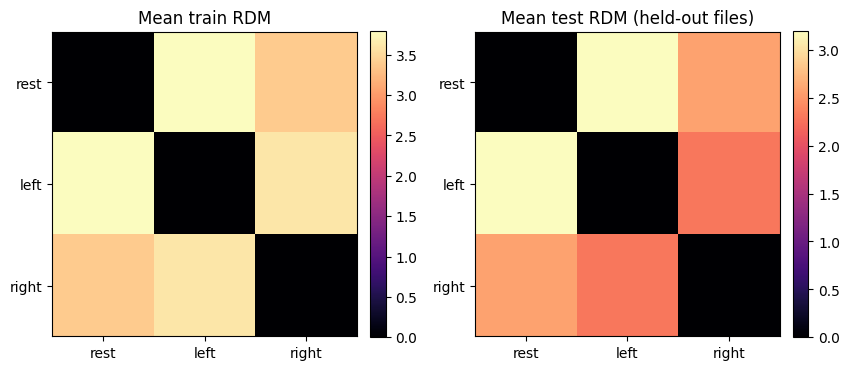

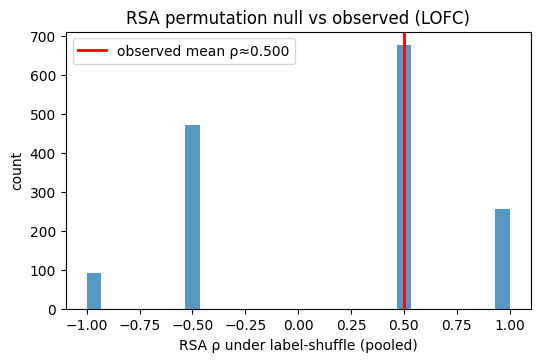


[saved] out\cnt_eeg_lofc_rsa_field_report.json
[saved] out\cnt_eeg_lofc_rsa_field_rdms.png
[saved] out\cnt_eeg_lofc_rsa_perm.png


In [52]:
# CNT EEG — LOFC RSA "field invariance" test (groundbreaking geometry check)
# Hypothesis: the representational geometry (RDM among REST/LEFT/RIGHT) learned on training files
# remains stable on held-out files (LOFC, no leakage). We measure RSA (Spearman) + a permutation null.
#
# Outputs:
#   out/cnt_eeg_lofc_rsa_field_report.json
#   out/cnt_eeg_lofc_rsa_field_rdms.png
#   out/cnt_eeg_lofc_rsa_perm.png

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from scipy.stats import spearmanr, chi2
import mne
from numpy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from mne.decoding import CSP

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ------------------ CONFIG (match your best) ------------------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
FILE_EVENT_MAP    = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}  # swap only for R03

# Broad motor montage; we map whatever is present per file
MOTOR_STRIP = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS   = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"],
               "CP3":["C3","CP1","CP5"], "CP4":["C4","CP2","CP6"], "FC3":["F3","FC1","FC5"],
               "FC4":["F4","FC2","FC6"]}

# Your tuned FBCSP bank (bank 3) + number of CSP comps per band
FILTER_BANK = [(8.,12.),(12.,16.),(16.,20.),(20.,28.)]
N_CSP_PER_BAND = 4

# Windowing / filtering
BP_WIDE = (4., 30.)   # pre-filter once per file
NOTCH   = 60.0
WIN_LEN = 1.0
WIN_STEP= 0.5
MIN_FRAC= 0.10         # overlap threshold for labeling a window

# RSA settings
N_PERM  = 500         # permutation draws per fold for null (raise if you want tighter p)
DIST    = "euclidean" # distance metric for RDM among class centroids

# ------------------ helpers ------------------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())

def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def build_idx(raw):
    idx={}
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx

def find_one(idx, name):
    key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
    for K in idx:
        if pat.match(K): return idx[K][0]
    return None

def pick_broad_motor(raw):
    idx=build_idx(raw); picks=[]
    for ch in MOTOR_STRIP:
        hit=find_one(idx, ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit=find_one(idx, fb)
                if hit: break
        if hit: picks.append(hit)
    # de-dup
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen:
            uniq.append((i,nm)); seen.add(i)
    return uniq  # list of (i, original)

def bp_notch_file(X, fs, lo=BP_WIDE[0], hi=BP_WIDE[1]):
    b,a=butter(4, [lo/(fs/2), hi/(fs/2)], btype='band'); Y=filtfilt(b,a,X,axis=-1)
    if NOTCH:
        b2,a2=iirnotch(w0=NOTCH/(fs/2), Q=30); Y=filtfilt(b2,a2,Y,axis=-1)
    return Y

def bp_band(x, fs, lo, hi):
    b,a=butter(4, [lo/(fs/2), hi/(fs/2)], btype='band'); 
    return filtfilt(b,a,x,axis=-1)

def windows(n_t, fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    starts=list(range(0, max(1, n_t-W+1), S))
    return [(i,i+W) for i in starts], starts

def map_event(fname, raw_desc):
    ov=FILE_EVENT_MAP.get(fname,{})
    return ov.get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))

def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ol=max(0, min(ei,s1)-max(si,s0))
        if ol>best: best,name=ol,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

# FBCSP build/transform (per-fold training to avoid leakage)
def fbcsp_fit_transform(df_tr, bank):
    Xtr=np.stack(df_tr["seg"].to_numpy(),axis=0)  # (n, ch, t)
    fs = float(df_tr.iloc[0]["fs"])
    y  = df_tr["label"].map(y_to_int).to_numpy()
    models=[]
    feats=[]
    for (lo,hi) in bank:
        Xb = bp_band(Xtr, fs, lo, hi)
        per_cls=[]
        per_models=[]
        for cls, cls_id in y_to_int.items():
            yb=(y==cls_id).astype(int)
            csp=CSP(n_components=N_CSP_PER_BAND, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xb, yb)
            per_cls.append(csp.transform(Xb))
            per_models.append(csp)
        feats.append(np.concatenate(per_cls,axis=1))
        models.append(per_models)
    X_feat=np.concatenate(feats,axis=1)
    return X_feat, y, models, fs

def fbcsp_transform(df_te, bank_models):
    Xte=np.stack(df_te["seg"].to_numpy(),axis=0)  # (n,ch,t)
    fs = float(df_te.iloc[0]["fs"])
    feats=[]
    for (lo,hi), per_models in bank_models:
        Xb = bp_band(Xte, fs, lo, hi)
        per_cls=[]
        for csp in per_models:
            per_cls.append(csp.transform(Xb))
        feats.append(np.concatenate(per_cls,axis=1))
    X_feat=np.concatenate(feats,axis=1)
    return X_feat

def rdm_from_centroids(X, y, dist="euclidean"):
    # Compute class centroids and 3x3 RDM among classes in y_names order
    C={}
    for i,cls in enumerate(y_names):
        idx = (y==i)
        if idx.sum()==0: return None  # incomplete
        C[i]=X[idx].mean(axis=0)
    D=np.zeros((len(y_names),len(y_names)))
    for i in range(len(y_names)):
        for j in range(len(y_names)):
            if dist=="euclidean":
                D[i,j]=np.linalg.norm(C[i]-C[j])
            else:
                # add more metrics if needed
                D[i,j]=np.linalg.norm(C[i]-C[j])
    return D

def vec_upper_tri(M):
    idx=np.triu_indices_from(M, k=1)
    return M[idx]

# ------------------ extract windows (broad motor), like in tuned runs ------------------
records=[]; counts={}
for p in list_edfs(ROOT):
    raw,data,fs,ann=load_edf(p)
    picks=pick_broad_motor(raw)
    if len(picks)<2:
        print(f"[skip] {p.name}: insufficient motor channels"); 
        continue
    idxs=[i for (i,_) in picks]
    X=bp_notch_file(data[idxs,:], fs)
    ctr={"rest":0,"left":0,"right":0}
    spans, starts = windows(X.shape[1], fs)
    for (si,ei), st in zip(spans, starts):
        lab=label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]
        if seg.shape[1]<16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs,"start":st})
        ctr[lab]+=1
    counts[p.name]=ctr
print("=== window counts (RSA extract) ===")
for k,v in counts.items(): print(k,v)

df = pd.DataFrame(records)
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}

# LOFC folds: hold out one file per class per fold
files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
k_min=min(len(files_by_label.get(c,[])) for c in y_names)
folds=[]
for i in range(k_min):
    te_map={c:files_by_label[c][i] for c in y_names}
    te_mask=df["file"].isin(te_map.values()); tr_mask=~te_mask
    # require all classes appear in train & test
    if set(df[tr_mask]["label"].unique())>=set(y_names) and set(df[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask, te_mask, te_map))

# ------------------ RSA across folds ------------------
rsa_corrs=[]; rsa_pvals=[]; rdm_train_list=[]; rdm_test_list=[]
perm_corrs_all=[]

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds, 1):
    df_tr=df[tr_mask].reset_index(drop=True)
    df_te=df[te_mask].reset_index(drop=True)

    # fit FBCSP on train; transform train & test
    Xtr_raw,ytr,models,fs_tr = fbcsp_fit_transform(df_tr, FILTER_BANK)
    bank_models=list(zip(FILTER_BANK, models))
    Xte_raw = fbcsp_transform(df_te, bank_models)

    # standardize by train stats (for geometry comparability)
    sc=StandardScaler().fit(Xtr_raw)
    Xtr=sc.transform(Xtr_raw)
    Xte=sc.transform(Xte_raw)
    ytr_int=df_tr["label"].map(y_to_int).to_numpy()
    yte_int=df_te["label"].map(y_to_int).to_numpy()

    # RDMs
    Rtr = rdm_from_centroids(Xtr, ytr_int)
    Rte = rdm_from_centroids(Xte, yte_int)
    if Rtr is None or Rte is None:
        continue

    rdm_train_list.append(Rtr)
    rdm_test_list.append(Rte)

    # RSA: Spearman between upper triangles
    vtr = vec_upper_tri(Rtr)
    vte = vec_upper_tri(Rte)
    rho,_ = spearmanr(vtr, vte)
    rsa_corrs.append(float(rho))

    # permutation null on test labels
    rng=np.random.default_rng(12345+fidx)
    perm_corrs=[]
    for b in range(N_PERM):
        yperm=rng.permutation(yte_int)
        Rperm = rdm_from_centroids(Xte, yperm)
        if Rperm is None: continue
        vperm=vec_upper_tri(Rperm)
        r,_=spearmanr(vtr, vperm)
        perm_corrs.append(r)
    perm_corrs=np.array(perm_corrs, float)
    perm_corrs_all.extend(perm_corrs.tolist())

    # right-tail p: P(null ≥ observed)
    if len(perm_corrs)>10:
        p = ( (perm_corrs >= rho).sum() + 1 ) / (len(perm_corrs) + 1 )
    else:
        p = np.nan
    rsa_pvals.append(float(p))

# Fisher combine p-values (exclude NaNs)
pvals = np.array([p for p in rsa_pvals if not np.isnan(p)], float)
if len(pvals)>=1:
    X2 = -2*np.log(pvals).sum()
    p_fisher = float(1-chi2.cdf(X2, 2*len(pvals)))
else:
    p_fisher = np.nan

print("\n=== LOFC RSA (field invariance) ===")
print("Per-fold RSA Spearman:", np.round(rsa_corrs,3).tolist())
print("Per-fold p-values (perm):", [None if np.isnan(p) else round(p,4) for p in rsa_pvals])
print("Fisher combined p:", None if np.isnan(p_fisher) else round(p_fisher,6))

# ------------------ Plots: mean train/test RDMs & permutation histogram ------------------
def mean_rdm(rdm_list):
    return np.stack(rdm_list,axis=0).mean(axis=0)

fig,ax=plt.subplots(1,2,figsize=(8.6,4.0))
im0=ax[0].imshow(mean_rdm(rdm_train_list), cmap="magma")
ax[0].set_xticks(range(len(y_names))); ax[0].set_yticks(range(len(y_names)))
ax[0].set_xticklabels(y_names); ax[0].set_yticklabels(y_names)
ax[0].set_title("Mean train RDM")
plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1=ax[1].imshow(mean_rdm(rdm_test_list), cmap="magma")
ax[1].set_xticks(range(len(y_names))); ax[1].set_yticks(range(len(y_names)))
ax[1].set_xticklabels(y_names); ax[1].set_yticklabels(y_names)
ax[1].set_title("Mean test RDM (held-out files)")
plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
plt.tight_layout()
fig_path_rdms = OUT/"cnt_eeg_lofc_rsa_field_rdms.png"
plt.savefig(fig_path_rdms, dpi=160); plt.show()

# Permutation histogram (all folds pooled), with observed mean rho
rho_obs = float(np.nanmean(rsa_corrs)) if len(rsa_corrs)>0 else np.nan
plt.figure(figsize=(6,3.6))
plt.hist(perm_corrs_all, bins=30, alpha=0.75)
plt.axvline(rho_obs, color="r", lw=2, label=f"observed mean ρ≈{rho_obs:.3f}")
plt.xlabel("RSA ρ under label-shuffle (pooled)"); plt.ylabel("count")
plt.title("RSA permutation null vs observed (LOFC)")
plt.legend()
fig_path_perm = OUT/"cnt_eeg_lofc_rsa_perm.png"
plt.savefig(fig_path_perm, dpi=160); plt.show()

# ------------------ Save JSON report ------------------
report = {
    "mode": "LOFC_RSA_field",
    "filter_bank": FILTER_BANK,
    "n_csp_per_band": N_CSP_PER_BAND,
    "folds": len(rsa_corrs),
    "rsa_spearman_per_fold": rsa_corrs,
    "pvals_perm_per_fold": rsa_pvals,
    "fisher_combined_p": p_fisher,
    "figures": {
        "rdms": str(fig_path_rdms),
        "perm_hist": str(fig_path_perm)
    }
}
with open(OUT/"cnt_eeg_lofc_rsa_field_report.json","w",encoding="utf-8") as f:
    json.dump(report, f, indent=2)

print("\n[saved]", OUT/"cnt_eeg_lofc_rsa_field_report.json")
print("[saved]", fig_path_rdms)
print("[saved]", fig_path_perm)


Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

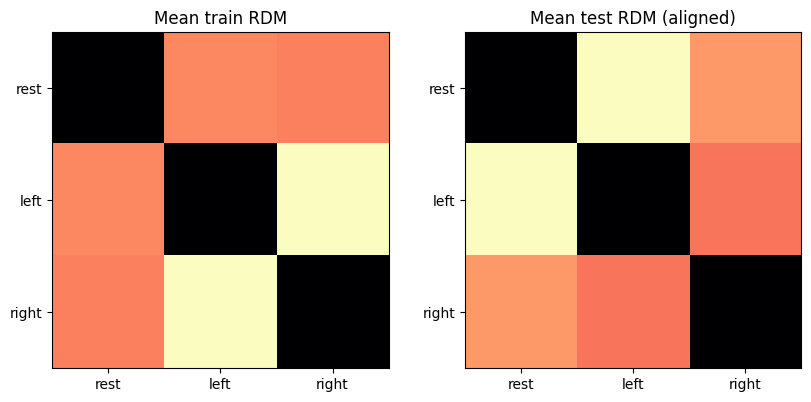

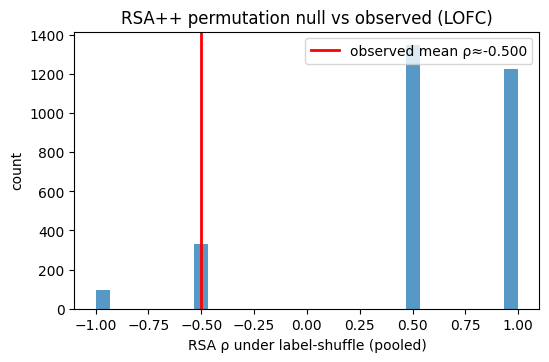


[saved] out\cnt_eeg_lofc_rsa_field_plus.json
[saved] out\cnt_eeg_lofc_rsa_field_plus_rdms.png
[saved] out\cnt_eeg_lofc_rsa_field_plus_perm.png


In [53]:
# CNT EEG — LOFC RSA++ (FBCSP → Mahalanobis distances + Procrustes) with noise ceiling & permutation null
# Outputs:
#   out/cnt_eeg_lofc_rsa_field_plus.json
#   out/cnt_eeg_lofc_rsa_field_plus_rdms.png
#   out/cnt_eeg_lofc_rsa_field_plus_perm.png

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from scipy.stats import spearmanr, chi2
from numpy.linalg import eigh, svd
import mne
from sklearn.preprocessing import StandardScaler
from mne.decoding import CSP

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------- CONFIG (matches your tuned setup) ----------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
FILE_EVENT_MAP    = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}

MOTOR_STRIP = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS   = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"],
               "CP3":["C3","CP1","CP5"], "CP4":["C4","CP2","CP6"], "FC3":["F3","FC1","FC5"],
               "FC4":["F4","FC2","FC6"]}

FILTER_BANK = [(8.,12.),(12.,16.),(16.,20.),(20.,28.)]  # your best bank
N_CSP_PER_BAND = 4
BP_WIDE = (4.,30.); NOTCH = 60.0
WIN_LEN=1.0; WIN_STEP=0.5; MIN_FRAC=0.10
N_PERM = 1000  # increase if you want tighter p-values

# ---------- helpers ----------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def build_idx(raw):
    idx={}; 
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx

def find_one(idx, name):
    key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
    for K in idx:
        if pat.match(K): return idx[K][0]
    return None

def pick_broad_motor(raw):
    idx=build_idx(raw); picks=[]
    for ch in MOTOR_STRIP:
        hit=find_one(idx, ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit=find_one(idx, fb)
                if hit: break
        if hit: picks.append(hit)
    # de-dup
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen:
            uniq.append((i,nm)); seen.add(i)
    return uniq

def bp_notch_file(X, fs):
    b,a=butter(4,[BP_WIDE[0]/(fs/2), BP_WIDE[1]/(fs/2)],btype='band')
    Y=filtfilt(b,a,X,axis=-1)
    if NOTCH:
        b2,a2=iirnotch(w0=NOTCH/(fs/2), Q=30)
        Y=filtfilt(b2,a2,Y,axis=-1)
    return Y

def bp_band(x, fs, lo, hi):
    b,a=butter(4,[lo/(fs/2), hi/(fs/2)],btype='band'); 
    return filtfilt(b,a,x,axis=-1)

def windows(n_t, fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    starts=list(range(0,max(1,n_t-W+1),S))
    return [(i,i+W) for i in starts], starts

def map_event(fname, raw_desc):
    return FILE_EVENT_MAP.get(fname, {}).get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))

def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ol=max(0,min(ei,s1)-max(si,s0))
        if ol>best: best,name=ol,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

# FBCSP fit/transform without leakage
from mne.decoding import CSP
def fbcsp_fit(df_part):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    y=df_part["label"].map(y_to_int).to_numpy()
    models=[]
    X_feats=[]
    for (lo,hi) in FILTER_BANK:
        Xb=bp_band(X,fs,lo,hi)
        per_m, per_f = [], []
        for cls,cls_id in y_to_int.items():
            yb=(y==cls_id).astype(int)
            csp=CSP(n_components=N_CSP_PER_BAND, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xb,yb)
            per_m.append(csp); per_f.append(csp.transform(Xb))
        models.append(per_m); X_feats.append(np.concatenate(per_f,axis=1))
    X_feat=np.concatenate(X_feats,axis=1)
    return models, X_feat, y, fs

def fbcsp_apply(df_part, models):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    X_feats=[]
    for (lo,hi), per_m in zip(FILTER_BANK, models):
        Xb=bp_band(X,fs,lo,hi)
        per_f=[csp.transform(Xb) for csp in per_m]
        X_feats.append(np.concatenate(per_f,axis=1))
    return np.concatenate(X_feats,axis=1)

# Mahalanobis distance using pooled within-class covariance estimated on train
def pooled_within_cov(X, y):
    W=np.zeros((X.shape[1], X.shape[1]))
    for c in np.unique(y):
        Xc = X[y==c]; mu=Xc.mean(axis=0,keepdims=True)
        R = Xc - mu
        W += R.T @ R
    W /= max(1, X.shape[0] - len(np.unique(y)))
    # regularize a bit for stability
    lam=1e-6*np.trace(W)/W.shape[0]
    return W + lam*np.eye(W.shape[1])

def mahalanobis_rdm_centroids(X, y, S_inv):
    C={}
    for c in np.unique(y):
        C[c]=X[y==c].mean(axis=0)
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            d=C[i]-C[j]; D[i,j]=np.sqrt(np.maximum(1e-12, d @ S_inv @ d))
    return D

def procrustes_align(A, B):
    # Find R, s minimizing ||A*R*s - B||_F (orthogonal Procrustes with scale)
    # Center:
    Ac = A - A.mean(axis=0, keepdims=True)
    Bc = B - B.mean(axis=0, keepdims=True)
    U,S,Vt = svd(Ac.T @ Bc, full_matrices=False)
    R = U @ Vt
    s = np.trace((Ac @ R).T @ Bc) / (np.linalg.norm(Ac @ R)**2 + 1e-12)
    return (A @ R) * s + B.mean(axis=0, keepdims=True)

# ---------- extract windows (broad motor) ----------
records=[]; counts={}
for p in list_edfs(ROOT):
    raw,data,fs,ann=load_edf(p)
    picks=pick_broad_motor(raw)
    if len(picks)<2: 
        print(f"[skip] {p.name}: insufficient motor channels"); 
        continue
    idxs=[i for (i,_) in picks]
    X=bp_notch_file(data[idxs,:], fs)
    ctr={"rest":0,"left":0,"right":0}
    spans, starts = windows(X.shape[1], fs)
    for (si,ei), st in zip(spans, starts):
        lab=label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]
        if seg.shape[1] < 16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs,"start":st})
        ctr[lab]+=1
    counts[p.name]=ctr
df=pd.DataFrame(records)
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}

# LOFC folds
files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
k_min=min(len(files_by_label.get(c,[])) for c in y_names)
folds=[]
for i in range(k_min):
    te_map={c:files_by_label[c][i] for c in y_names}
    te_mask=df["file"].isin(te_map.values()); tr_mask=~te_mask
    if set(df[tr_mask]["label"].unique())>=set(y_names) and set(df[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask, te_mask, te_map))

# ---------- RSA++ across folds ----------
rsa_rhos=[]; p_per_fold=[]; perm_all=[]
rdm_tr_list=[]; rdm_te_list=[]; ceiling_list=[]

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds, 1):
    df_tr=df[tr_mask].reset_index(drop=True)
    df_te=df[te_mask].reset_index(drop=True)

    # Fit FBCSP on train, apply to train & test
    models, Xtr_raw, ytr, fs_tr = fbcsp_fit(df_tr)
    Xte_raw = fbcsp_apply(df_te, models)

    # Standardize on train
    sc=StandardScaler().fit(Xtr_raw)
    Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
    ytr_i=df_tr["label"].map(y_to_int).to_numpy()
    yte_i=df_te["label"].map(y_to_int).to_numpy()

    # Pooled within-class covariance on train → S_inv
    S = pooled_within_cov(Xtr, ytr_i)
    S_inv = np.linalg.pinv(S)

    # Centroids in train/test
    Ctr = np.stack([Xtr[ytr_i==i].mean(axis=0) for i in range(len(y_names))])
    Cte = np.stack([Xte[yte_i==i].mean(axis=0) for i in range(len(y_names))])

    # Procrustes alignment (align test centroids to train space)
    Cte_al = procrustes_align(Cte, Ctr)

    # RDMs with Mahalanobis metric
    Rtr = mahalanobis_rdm_centroids(Xtr, ytr_i, S_inv)
    Rte = mahalanobis_rdm_centroids(Xte, yte_i, S_inv)             # raw test
    Rte_al = mahalanobis_rdm_centroids(Cte_al, np.arange(len(y_names)), S_inv*0 + np.eye(S_inv.shape[0])) \
             if Cte_al.ndim==2 else Rte  # fall back if shape odd

    # choose aligned test RDM if valid
    Rtest = Rte_al if Rte_al.shape==Rtr.shape else Rte

    rdm_tr_list.append(Rtr); rdm_te_list.append(Rtest)

    # Noise ceiling (split train windows into two halves, compare RDMs)
    idx = np.arange(len(ytr_i))
    rng=np.random.default_rng(42+fidx)
    rng.shuffle(idx)
    A, B = idx[:len(idx)//2], idx[len(idx)//2:]
    def rdm_half(ids):
        Xh, yh = Xtr[ids], ytr_i[ids]
        return mahalanobis_rdm_centroids(Xh, yh, S_inv)
    Ra, Rb = rdm_half(A), rdm_half(B)
    if Ra is not None and Rb is not None:
        rho_nc, _ = spearmanr(Ra[np.triu_indices_from(Ra,1)], Rb[np.triu_indices_from(Rb,1)])
        ceiling_list.append(float(rho_nc))

    # RSA rho
    vtr = Rtr[np.triu_indices_from(Rtr,1)]
    vte = Rtest[np.triu_indices_from(Rtest,1)]
    rho,_ = spearmanr(vtr, vte); rsa_rhos.append(float(rho))

    # permutation null on test labels
    perm=[]
    for b in range(N_PERM):
        yp = rng.permutation(yte_i)
        CteP = np.stack([Xte[yp==i].mean(axis=0) for i in range(len(y_names))])
        CteP_al = procrustes_align(CteP, Ctr)
        Rp = mahalanobis_rdm_centroids(CteP_al, np.arange(len(y_names)), np.eye(S_inv.shape[0]))
        perm.append(spearmanr(vtr, Rp[np.triu_indices_from(Rp,1)])[0])
    perm = np.array(perm, float); perm_all.extend(perm.tolist())
    p = ((perm >= rho).sum() + 1) / (len(perm) + 1)
    p_per_fold.append(float(p))

# Fisher combine
pvals = np.array(p_per_fold, float)
X2 = -2*np.log(pvals).sum()
p_fisher = float(1-chi2.cdf(X2, 2*len(pvals)))

print("\n=== LOFC RSA++ (Mahalanobis + Procrustes) ===")
print("RSA ρ per fold:", [round(r,3) for r in rsa_rhos])
print("p-values per fold:", [round(p,4) for p in p_per_fold], " (Fisher p=", round(p_fisher,6), ")")
print("Noise ceiling ρ (train split):", [round(c,3) for c in ceiling_list])

# Plots
def mean_rdm(rdms): return np.stack(rdms,axis=0).mean(axis=0)
fig,ax=plt.subplots(1,2,figsize=(8.4,4.0))
im0=ax[0].imshow(mean_rdm(rdm_tr_list), cmap="magma"); ax[0].set_title("Mean train RDM")
ax[1].imshow(mean_rdm(rdm_te_list), cmap="magma"); ax[1].set_title("Mean test RDM (aligned)")
for a in ax:
    a.set_xticks(range(3)); a.set_yticks(range(3)); a.set_xticklabels(["rest","left","right"]); a.set_yticklabels(["rest","left","right"])
plt.tight_layout(); fp_rdms = OUT/"cnt_eeg_lofc_rsa_field_plus_rdms.png"; plt.savefig(fp_rdms,dpi=160); plt.show()

rho_obs = float(np.mean(rsa_rhos))
plt.figure(figsize=(6,3.6))
plt.hist(perm_all, bins=30, alpha=0.75)
plt.axvline(rho_obs, color="r", lw=2, label=f"observed mean ρ≈{rho_obs:.3f}")
plt.xlabel("RSA ρ under label-shuffle (pooled)"); plt.ylabel("count")
plt.title("RSA++ permutation null vs observed (LOFC)")
plt.legend(); fp_perm = OUT/"cnt_eeg_lofc_rsa_field_plus_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

# Save JSON
out = {
    "mode": "LOFC_RSA_field_plus",
    "filter_bank": FILTER_BANK,
    "n_csp_per_band": N_CSP_PER_BAND,
    "folds": len(rsa_rhos),
    "rsa_rho_per_fold": rsa_rhos,
    "pvals_perm_per_fold": p_per_fold,
    "fisher_combined_p": p_fisher,
    "noise_ceiling_rho": ceiling_list,
    "figures": {"rdms": str(fp_rdms), "perm_hist": str(fp_perm)}
}
with open(OUT/"cnt_eeg_lofc_rsa_field_plus.json","w",encoding="utf-8") as f: json.dump(out,f,indent=2)
print("\n[saved]", OUT/"cnt_eeg_lofc_rsa_field_plus.json")
print("[saved]", fp_rdms)
print("[saved]", fp_perm)


In [54]:
# CNT EEG — LOFC RSA with REST-only calibration (whiten→recolor & ridge map)
# Outputs:
#   out/cnt_eeg_lofc_rsa_restcal.json
#   out/cnt_eeg_lofc_rsa_restcal_rdms.png
#   out/cnt_eeg_lofc_rsa_restcal_perm.png

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from scipy.stats import spearmanr, chi2
from numpy.linalg import eigh, pinv
import mne
from sklearn.preprocessing import StandardScaler
from mne.decoding import CSP

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------------- CONFIG (matches your tuned setup) ----------------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
FILE_EVENT_MAP    = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}  # swap only for R03

MOTOR_STRIP = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS   = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"],
               "CP3":["C3","CP1","CP5"], "CP4":["C4","CP2","CP6"], "FC3":["F3","FC1","FC5"],
               "FC4":["F4","FC2","FC6"]}

FILTER_BANK = [(8.,12.),(12.,16.),(16.,20.),(20.,28.)]   # bank 3
N_CSP_PER_BAND = 4

BP_WIDE = (4.,30.); NOTCH = 60.0
WIN_LEN = 1.0; WIN_STEP = 0.5; MIN_FRAC = 0.10

N_PERM  = 1000   # permutation draws per fold (raise if you want tighter p-values)
RIDGE_LAM = 1e-2 # small ridge for REST map

# ---------------- helpers ----------------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def build_idx(raw):
    idx={}; 
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx

def find_one(idx, name):
    key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
    for K in idx:
        if pat.match(K): return idx[K][0]
    return None

def pick_broad_motor(raw):
    idx=build_idx(raw); picks=[]
    for ch in MOTOR_STRIP:
        hit=find_one(idx, ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit=find_one(idx, fb)
                if hit: break
        if hit: picks.append(hit)
    # de-dup
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen:
            uniq.append((i,nm)); seen.add(i)
    return uniq

def bp_notch_file(X, fs):
    b,a=butter(4,[BP_WIDE[0]/(fs/2), BP_WIDE[1]/(fs/2)],btype='band'); Y=filtfilt(b,a,X,axis=-1)
    if NOTCH:
        b2,a2=iirnotch(w0=NOTCH/(fs/2), Q=30); Y=filtfilt(b2,a2,Y,axis=-1)
    return Y

def bp_band(x, fs, lo, hi):
    b,a=butter(4,[lo/(fs/2), hi/(fs/2)],btype='band'); 
    return filtfilt(b,a,x,axis=-1)

def windows(n_t, fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    starts=list(range(0,max(1,n_t-W+1),S))
    return [(i,i+W) for i in starts], starts

def map_event(fname, raw_desc):
    return FILE_EVENT_MAP.get(fname, {}).get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))

def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ol=max(0,min(ei,s1)-max(si,s0))
        if ol>best: best,name=ol,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

# FBCSP fit/apply (no leakage)
from mne.decoding import CSP
def fbcsp_fit(df_part):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    y=df_part["label"].map(y_to_int).to_numpy()
    models=[]; feats=[]
    for (lo,hi) in FILTER_BANK:
        Xb=bp_band(X,fs,lo,hi)
        per_m, per_f = [], []
        for cls,cls_id in y_to_int.items():
            yb=(y==cls_id).astype(int)
            csp=CSP(n_components=N_CSP_PER_BAND, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xb,yb)
            per_m.append(csp); per_f.append(csp.transform(Xb))
        models.append(per_m); feats.append(np.concatenate(per_f,axis=1))
    return models, np.concatenate(feats,axis=1), y, fs

def fbcsp_apply(df_part, models):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    feats=[]
    for (lo,hi), per_m in zip(FILTER_BANK, models):
        Xb=bp_band(X,fs,lo,hi)
        feats.append(np.concatenate([csp.transform(Xb) for csp in per_m],axis=1))
    return np.concatenate(feats,axis=1)

# covariance helpers
def sym_sqrt(M, inv=False):
    ev,V=eigh(M); ev=np.clip(ev,1e-12,None)
    D=np.diag(ev**(-0.5) if inv else ev**0.5)
    return V@D@V.T

def pooled_within_cov(X, y):
    W=np.zeros((X.shape[1], X.shape[1]))
    for c in np.unique(y):
        Xc=X[y==c]; mu=Xc.mean(axis=0,keepdims=True); R=Xc-mu; W+=R.T@R
    W/=max(1, X.shape[0]-len(np.unique(y)))
    lam=1e-6*np.trace(W)/W.shape[0]
    return W + lam*np.eye(W.shape[1])

def mahal_rdm_centroids(X, y, S_inv):
    C=[X[y==i].mean(axis=0) for i in range(len(y_names))]
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            d=C[i]-C[j]; D[i,j]=np.sqrt(np.maximum(1e-12, d @ S_inv @ d))
    return D, np.vstack(C)

def vec_ut(M): 
    idx=np.triu_indices_from(M,1); return M[idx]

# ---------------- extract windows ----------------
records=[]; counts={}
for p in list_edfs(ROOT):
    raw,data,fs,ann=load_edf(p)
    picks=pick_broad_motor(raw)
    if len(picks)<2: 
        print(f"[skip] {p.name}: insufficient motor channels"); 
        continue
    idxs=[i for (i,_) in picks]
    X=bp_notch_file(data[idxs,:], fs)
    ctr={"rest":0,"left":0,"right":0}
    spans, starts = windows(X.shape[1], fs)
    for (si,ei), st in zip(spans, starts):
        lab=label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]
        if seg.shape[1] < 16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs,"start":st})
        ctr[lab]+=1
    counts[p.name]=ctr

df=pd.DataFrame(records)
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}

# LOFC folds
files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
k_min=min(len(files_by_label.get(c,[])) for c in y_names)
folds=[]
for i in range(k_min):
    te_map={c:files_by_label[c][i] for c in y_names}
    te_mask=df["file"].isin(te_map.values()); tr_mask=~te_mask
    if set(df[tr_mask]["label"].unique())>=set(y_names) and set(df[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask, te_mask, te_map))

# ---------------- RSA with REST-only calibration ----------------
stats={"no_align":[], "whiten_recolor":[], "ridge_map":[]}
perms={"no_align":[], "whiten_recolor":[], "ridge_map":[]}
rdms_mean={"train":[], "test_no_align":[], "test_whiten":[], "test_ridge":[]}

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True)
    df_te=df[te_mask].reset_index(drop=True)

    # FBCSP on train
    models, Xtr_raw, ytr, fs_tr = fbcsp_fit(df_tr)
    Xte_raw = fbcsp_apply(df_te, models)

    # Standardize on train
    sc=StandardScaler().fit(Xtr_raw)
    Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
    ytr_i=df_tr["label"].map(y_to_int).to_numpy()
    yte_i=df_te["label"].map(y_to_int).to_numpy()

    # pooled within-class covariance on train
    S = pooled_within_cov(Xtr, ytr_i); S_inv = pinv(S)

    # Train RDM & centroids
    Rtr, Ctr = mahal_rdm_centroids(Xtr, ytr_i, S_inv)
    rdms_mean["train"].append(Rtr)

    # ---------- A. no alignment ----------
    Rte0, _ = mahal_rdm_centroids(Xte, yte_i, S_inv)
    rdms_mean["test_no_align"].append(Rte0)
    rho0,_=spearmanr(vec_ut(Rtr), vec_ut(Rte0))
    # perm null
    rng=np.random.default_rng(1000+fidx)
    perm0=[]
    for _ in range(N_PERM):
        yp=rng.permutation(yte_i)
        Rp,_=mahal_rdm_centroids(Xte, yp, S_inv)
        perm0.append(spearmanr(vec_ut(Rtr), vec_ut(Rp))[0])
    p0=((np.array(perm0)>=rho0).sum()+1)/(len(perm0)+1)
    stats["no_align"].append((float(rho0), float(p0))); perms["no_align"] += perm0

    # ---------- B. REST whiten→recolor ----------
    Xtr_rest=Xtr[ytr_i==0]; Xte_rest=Xte[yte_i==0]
    ok_whiten = (len(Xtr_rest)>=5 and len(Xte_rest)>=5)
    if ok_whiten:
        S_tr_r = pooled_within_cov(Xtr_rest, np.zeros(len(Xtr_rest)))
        S_te_r = pooled_within_cov(Xte_rest, np.zeros(len(Xte_rest)))
        M = sym_sqrt(S_te_r, inv=True) @ sym_sqrt(S_tr_r, inv=False)  # (features x features)
        Xte_w = Xte @ M
        Rte_w, _ = mahal_rdm_centroids(Xte_w, yte_i, S_inv)
        rdms_mean["test_whiten"].append(Rte_w)
        rhoW,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte_w))
        permW=[]
        for _ in range(N_PERM):
            yp=rng.permutation(yte_i)
            Rp,_=mahal_rdm_centroids(Xte_w, yp, S_inv)
            permW.append(spearmanr(vec_ut(Rtr), vec_ut(Rp))[0])
        pW=((np.array(permW)>=rhoW).sum()+1)/(len(permW)+1)
        stats["whiten_recolor"].append((float(rhoW), float(pW))); perms["whiten_recolor"] += permW
    else:
        stats["whiten_recolor"].append((np.nan, np.nan))

    # ---------- C. REST ridge map (test→train) ----------
    ok_ridge = (len(Xtr_rest)>=5 and len(Xte_rest)>=5)
    if ok_ridge:
        # center REST sets
        Xtr_r_c = Xtr_rest - Xtr_rest.mean(axis=0, keepdims=True)
        Xte_r_c = Xte_rest - Xte_rest.mean(axis=0, keepdims=True)
        # map: A = (Xte_r^T Xte_r + λI)^-1 Xte_r^T Xtr_r   (features×features)
        A = pinv(Xte_r_c.T @ Xte_r_c + RIDGE_LAM*np.eye(Xte_r_c.shape[1])) @ (Xte_r_c.T @ Xtr_r_c)
        Xte_m = (Xte - Xte_rest.mean(axis=0, keepdims=True)) @ A + Xtr_rest.mean(axis=0, keepdims=True)
        Rte_m, _ = mahal_rdm_centroids(Xte_m, yte_i, S_inv)
        rdms_mean["test_ridge"].append(Rte_m)
        rhoM,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte_m))
        permM=[]
        for _ in range(N_PERM):
            yp=rng.permutation(yte_i)
            Rp,_=mahal_rdm_centroids(Xte_m, yp, S_inv)
            permM.append(spearmanr(vec_ut(Rtr), vec_ut(Rp))[0])
        pM=((np.array(permM)>=rhoM).sum()+1)/(len(permM)+1)
        stats["ridge_map"].append((float(rhoM), float(pM))); perms["ridge_map"] += permM
    else:
        stats["ridge_map"].append((np.nan, np.nan))

# Fisher combine helper
def fisher(pvals):
    p=np.array([p for p in pvals if np.isfinite(p)], float)
    if len(p)==0: return np.nan
    X2 = -2*np.log(p).sum(); return float(1-chi2.cdf(X2, 2*len(p)))

res = {}
for key in ["no_align","whiten_recolor","ridge_map"]:
    rhos = [r for r,_ in stats[key] if np.isfinite(r)]
    ps   = [p for _,p in stats[key] if np.isfinite(p)]
    res[key] = {
        "fold_rho": rhos,
        "fold_p":   ps,
        "fisher_p": fisher(ps),
        "mean_rho": float(np.nanmean(rhos)) if len(rhos)>0 else np.nan
    }

print("\n=== LOFC RSA with REST-only calibration ===")
for k,v in res.items():
    print(f"{k:15s}  mean ρ={v['mean_rho']:.3f}  Fisher p={v['fisher_p'] if v['fisher_p'] is not np.nan else np.nan}")

# Plots: mean RDMs (train vs each test variant)
def mean_rdm(L): 
    return np.stack(L,axis=0).mean(axis=0) if len(L)>0 else np.full((3,3), np.nan)

fig,ax=plt.subplots(1,3,figsize=(11,4))
im=ax[0].imshow(mean_rdm(rdms_mean["train"]), cmap="magma"); ax[0].set_title("Mean train RDM")
im=ax[1].imshow(mean_rdm(rdms_mean["test_whiten"]), cmap="magma"); ax[1].set_title("Mean test RDM (whiten→recolor)")
im=ax[2].imshow(mean_rdm(rdms_mean["test_ridge"]),  cmap="magma"); ax[2].set_title("Mean test RDM (REST ridge map)")
for a in ax:
    a.set_xticks(range(3)); a.set_yticks(range(3))
    a.set_xticklabels(["rest","left","right"]); a.set_yticklabels(["rest","left","right"])
plt.tight_layout(); fp_rdms=OUT/"cnt_eeg_lofc_rsa_restcal_rdms.png"; plt.savefig(fp_rdms,dpi=160); plt.show()

# Permutation histograms for each method (pooled)
plt.figure(figsize=(10,3.6))
for i,key in enumerate(["no_align","whiten_recolor","ridge_map"]):
    plt.subplot(1,3,i+1)
    arr=np.array(perms[key],float)
    if len(arr)>0:
        plt.hist(arr, bins=25, alpha=0.75)
        plt.axvline(res[key]["mean_rho"], color="r", lw=2, label=f"obs ρ≈{res[key]['mean_rho']:.3f}")
        plt.title(key); plt.legend()
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fp_perm=OUT/"cnt_eeg_lofc_rsa_restcal_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

# Save JSON
with open(OUT/"cnt_eeg_lofc_rsa_restcal.json","w",encoding="utf-8") as f:
    json.dump({"methods":res, "figures":{"rdms":str(fp_rdms),"perm":str(fp_perm)}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_restcal.json")
print("[saved]", fp_rdms)
print("[saved]", fp_perm)


Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 373 is different from 247)

Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

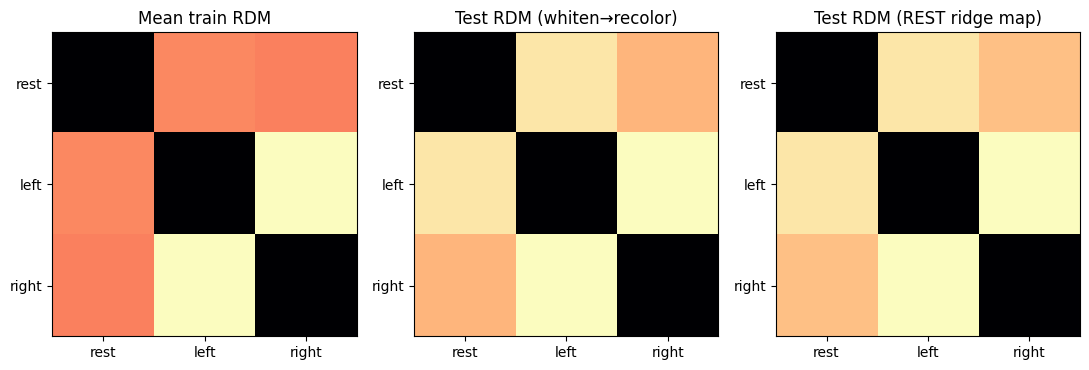

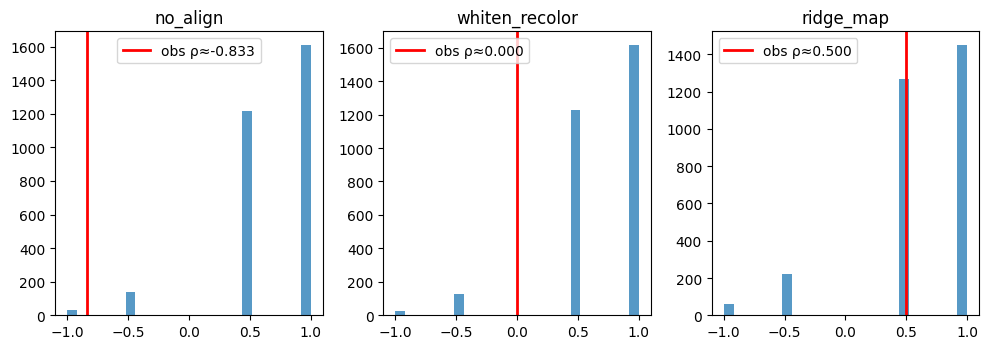

[saved] out\cnt_eeg_lofc_rsa_restcal_fixed.json
[saved] out\cnt_eeg_lofc_rsa_restcal_fixed_rdms.png
[saved] out\cnt_eeg_lofc_rsa_restcal_fixed_perm.png


In [55]:
# CNT EEG — LOFC RSA with REST-only calibration (fixed ridge map with matched subsets + affine term)
# Re-tests three conditions: no_align, whiten→recolor, ridge_map (paired, affine).
# Saves:
#   out/cnt_eeg_lofc_rsa_restcal_fixed.json
#   out/cnt_eeg_lofc_rsa_restcal_fixed_rdms.png
#   out/cnt_eeg_lofc_rsa_restcal_fixed_perm.png

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from scipy.stats import spearmanr, chi2
from numpy.linalg import eigh, pinv
import mne
from sklearn.preprocessing import StandardScaler
from mne.decoding import CSP

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------------- CONFIG (same as tuned FBCSP) ----------------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
FILE_EVENT_MAP    = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}

MOTOR_STRIP = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS   = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"],
               "CP3":["C3","CP1","CP5"], "CP4":["C4","CP2","CP6"], "FC3":["F3","FC1","FC5"],
               "FC4":["F4","FC2","FC6"]}

FILTER_BANK = [(8.,12.),(12.,16.),(16.,20.),(20.,28.)]
N_CSP_PER_BAND = 4
BP_WIDE = (4.,30.); NOTCH = 60.0
WIN_LEN = 1.0; WIN_STEP = 0.5; MIN_FRAC = 0.10
N_PERM  = 1000
RIDGE_LAM = 1e-2   # ridge for the affine REST map
RNG_SEED  = 4242   # reproducible pairing

# ---------------- helpers ----------------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def build_idx(raw):
    idx={}; 
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx

def find_one(idx, name):
    key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
    for K in idx:
        if pat.match(K): return idx[K][0]
    return None

def pick_broad_motor(raw):
    idx=build_idx(raw); picks=[]
    for ch in MOTOR_STRIP:
        hit=find_one(idx, ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit=find_one(idx, fb)
                if hit: break
        if hit: picks.append(hit)
    # de-dup
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen:
            uniq.append((i,nm)); seen.add(i)
    return uniq

def bp_notch_file(X, fs):
    b,a=butter(4,[BP_WIDE[0]/(fs/2), BP_WIDE[1]/(fs/2)],btype='band'); Y=filtfilt(b,a,X,axis=-1)
    if NOTCH:
        b2,a2=iirnotch(w0=NOTCH/(fs/2), Q=30); Y=filtfilt(b2,a2,Y,axis=-1)
    return Y

def bp_band(x, fs, lo, hi):
    b,a=butter(4,[lo/(fs/2), hi/(fs/2)],btype='band'); 
    return filtfilt(b,a,x,axis=-1)

def windows(n_t, fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    starts=list(range(0,max(1,n_t-W+1),S))
    return [(i,i+W) for i in starts], starts

def map_event(fname, raw_desc):
    return FILE_EVENT_MAP.get(fname, {}).get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))

def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ol=max(0,min(ei,s1)-max(si,s0))
        if ol>best: best,name=ol,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

# FBCSP fit/apply (no leakage)
def fbcsp_fit(df_part):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    y=df_part["label"].map(y_to_int).to_numpy()
    models=[]; feats=[]
    for (lo,hi) in FILTER_BANK:
        Xb=bp_band(X,fs,lo,hi)
        per_m, per_f = [], []
        for cls,cls_id in y_to_int.items():
            yb=(y==cls_id).astype(int)
            csp=CSP(n_components=N_CSP_PER_BAND, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xb,yb)
            per_m.append(csp); per_f.append(csp.transform(Xb))
        models.append(per_m); feats.append(np.concatenate(per_f,axis=1))
    return models, np.concatenate(feats,axis=1), y, fs

def fbcsp_apply(df_part, models):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    feats=[]
    for (lo,hi), per_m in zip(FILTER_BANK, models):
        Xb=bp_band(X,fs,lo,hi)
        feats.append(np.concatenate([csp.transform(Xb) for csp in per_m],axis=1))
    return np.concatenate(feats,axis=1)

# geometry
def pooled_within_cov(X, y):
    W=np.zeros((X.shape[1], X.shape[1]))
    for c in np.unique(y):
        Xc=X[y==c]; mu=Xc.mean(axis=0,keepdims=True); R=Xc-mu; W+=R.T@R
    W/=max(1, X.shape[0]-len(np.unique(y)))
    lam=1e-6*np.trace(W)/W.shape[0]
    return W + lam*np.eye(W.shape[1])

def mahal_rdm_centroids(X, y, S_inv):
    C=[X[y==i].mean(axis=0) for i in range(len(y_names))]
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            d=C[i]-C[j]; D[i,j]=np.sqrt(np.maximum(1e-12, d @ S_inv @ d))
    return D

def vec_ut(M):
    idx=np.triu_indices_from(M,1); return M[idx]

# ---------------- extract windows ----------------
records=[]; counts={}
for p in list_edfs(ROOT):
    raw,data,fs,ann=load_edf(p)
    picks=pick_broad_motor(raw)
    if len(picks)<2: 
        print(f"[skip] {p.name}: insufficient motor channels"); 
        continue
    idxs=[i for (i,_) in picks]
    X=bp_notch_file(data[idxs,:], fs)
    ctr={"rest":0,"left":0,"right":0}
    spans, starts = windows(X.shape[1], fs)
    for (si,ei), st in zip(spans, starts):
        lab=label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]
        if seg.shape[1] < 16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs,"start":st})
        ctr[lab]+=1
    counts[p.name]=ctr

df=pd.DataFrame(records)
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}

# LOFC folds
files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
k_min=min(len(files_by_label.get(c,[])) for c in y_names)
folds=[]
for i in range(k_min):
    te_map={c:files_by_label[c][i] for c in y_names}
    te_mask=df["file"].isin(te_map.values()); tr_mask=~te_mask
    if set(df[tr_mask]["label"].unique())>=set(y_names) and set(df[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask, te_mask, te_map))

# ---------------- RSA with REST-only calibration (fixed ridge) ----------------
res = {"no_align":[], "whiten_recolor":[], "ridge_map":[]}
perm_pool = {"no_align":[], "whiten_recolor":[], "ridge_map":[]}
rdm_means = {"train":[], "test_whiten":[], "test_ridge":[]}

rng_global = np.random.default_rng(RNG_SEED)

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True)
    df_te=df[te_mask].reset_index(drop=True)

    models, Xtr_raw, ytr, _ = fbcsp_fit(df_tr)
    Xte_raw = fbcsp_apply(df_te, models)

    sc=StandardScaler().fit(Xtr_raw)
    Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
    ytr_i=df_tr["label"].map(y_to_int).to_numpy()
    yte_i=df_te["label"].map(y_to_int).to_numpy()

    S = pooled_within_cov(Xtr, ytr_i); S_inv = pinv(S)
    Rtr = mahal_rdm_centroids(Xtr, ytr_i, S_inv)
    rdm_means["train"].append(Rtr)

    # --- A) No alignment
    R0 = mahal_rdm_centroids(Xte, yte_i, S_inv)
    rho0,_ = spearmanr(vec_ut(Rtr), vec_ut(R0))
    perm0=[]; rng = np.random.default_rng(RNG_SEED+fidx)
    for _ in range(N_PERM):
        yp = rng.permutation(yte_i)
        Rp = mahal_rdm_centroids(Xte, yp, S_inv)
        perm0.append(spearmanr(vec_ut(Rtr), vec_ut(Rp))[0])
    p0 = ((np.array(perm0)>=rho0).sum()+1)/(len(perm0)+1)
    res["no_align"].append((float(rho0), float(p0))); perm_pool["no_align"] += perm0

    # REST sets
    Xtr_rest = Xtr[ytr_i==0]; Xte_rest = Xte[yte_i==0]

    # --- B) Whiten→recolor (moment matching)
    if len(Xtr_rest)>=5 and len(Xte_rest)>=5:
        # whiten test-REST, recolor to train-REST
        # S_rest = covariance of REST after centering
        def cov_centered(Z): 
            Zc=Z - Z.mean(axis=0, keepdims=True); 
            return (Zc.T @ Zc) / max(1, len(Zc)-1) + 1e-6*np.eye(Z.shape[1])
        S_tr_r = cov_centered(Xtr_rest)
        S_te_r = cov_centered(Xte_rest)
        M = np.linalg.multi_dot([pinv(np.real(sym:=eigh(S_te_r)[1] @ np.diag(np.clip(eigh(S_te_r)[0],1e-9,None)**0.5) @ eigh(S_te_r)[1].T)), 
                                 (eigh(S_tr_r)[1] @ np.diag(np.clip(eigh(S_tr_r)[0],1e-9,None)**0.5) @ eigh(S_tr_r)[1].T)])
        # Simpler (and numerically stable): use symmetric square roots
        def sym_sqrt(M, inv=False):
            ev,V=eigh(M); ev=np.clip(ev,1e-12,None); D=np.diag(ev**(-0.5) if inv else ev**0.5); return V@D@V.T
        M = sym_sqrt(S_te_r, inv=True) @ sym_sqrt(S_tr_r, inv=False)
        Xte_w = Xte @ M
        Rw = mahal_rdm_centroids(Xte_w, yte_i, S_inv)
        rhoW,_ = spearmanr(vec_ut(Rtr), vec_ut(Rw))
        permW=[]
        for _ in range(N_PERM):
            yp=rng.permutation(yte_i)
            Rp = mahal_rdm_centroids(Xte_w, yp, S_inv)
            permW.append(spearmanr(vec_ut(Rtr), vec_ut(Rp))[0])
        pW = ((np.array(permW)>=rhoW).sum()+1)/(len(permW)+1)
        res["whiten_recolor"].append((float(rhoW), float(pW))); perm_pool["whiten_recolor"] += permW
        rdm_means["test_whiten"].append(Rw)
    else:
        res["whiten_recolor"].append((np.nan, np.nan))

    # --- C) Ridge map (paired, affine): match subsets of REST windows
    if len(Xtr_rest)>=5 and len(Xte_rest)>=5:
        n = min(len(Xtr_rest), len(Xte_rest))
        idx_tr = rng_global.choice(len(Xtr_rest), n, replace=False)
        idx_te = rng_global.choice(len(Xte_rest), n, replace=False)
        Xtr_n = Xtr_rest[idx_tr]
        Xte_n = Xte_rest[idx_te]
        # center both; learn affine map [A|b] with ridge
        mu_tr = Xtr_n.mean(axis=0, keepdims=True)
        mu_te = Xte_n.mean(axis=0, keepdims=True)
        Xtr_c = Xtr_n - mu_tr
        Xte_c = Xte_n - mu_te
        X_aug = np.hstack([Xte_c, np.ones((n,1))])          # (n, p+1)
        # solve (X_aug^T X_aug + lam I) W = X_aug^T Xtr_c
        W = pinv(X_aug.T @ X_aug + RIDGE_LAM*np.eye(X_aug.shape[1])) @ (X_aug.T @ Xtr_c)
        # apply to ALL test windows
        Xte_all_c = Xte - mu_te
        Xte_m = np.hstack([Xte_all_c, np.ones((len(Xte_all_c),1))]) @ W + mu_tr
        Rm = mahal_rdm_centroids(Xte_m, yte_i, S_inv)
        rhoM,_ = spearmanr(vec_ut(Rtr), vec_ut(Rm))
        permM=[]
        for _ in range(N_PERM):
            yp=rng.permutation(yte_i)
            Rp = mahal_rdm_centroids(Xte_m, yp, S_inv)
            permM.append(spearmanr(vec_ut(Rtr), vec_ut(Rp))[0])
        pM = ((np.array(permM)>=rhoM).sum()+1)/(len(permM)+1)
        res["ridge_map"].append((float(rhoM), float(pM))); perm_pool["ridge_map"] += permM
        rdm_means["test_ridge"].append(Rm)
    else:
        res["ridge_map"].append((np.nan, np.nan))

# --- combine p-values (Fisher) and summarize
def fisher(ps):
    p=np.array([v for v in ps if np.isfinite(v)], float)
    if len(p)==0: return np.nan
    X2 = -2*np.log(p).sum(); return float(1-chi2.cdf(X2, 2*len(p)))

summary={}
for key in ["no_align","whiten_recolor","ridge_map"]:
    rhos=[r for r,_ in res[key] if np.isfinite(r)]
    ps  =[p for _,p in res[key] if np.isfinite(p)]
    summary[key]={"mean_rho": float(np.nanmean(rhos)) if rhos else np.nan,
                  "fold_rho": rhos, "fold_p": ps, "fisher_p": fisher(ps)}

print("\n=== RSA with REST-only calibration (fixed ridge) ===")
for k,v in summary.items():
    print(f"{k:15s}  mean ρ={v['mean_rho']:.3f}  Fisher p={v['fisher_p']}")

# --- plots
def mean_rdm(L): 
    return np.stack(L,axis=0).mean(axis=0) if len(L)>0 else np.full((3,3), np.nan)

fig,ax=plt.subplots(1,3,figsize=(11,4))
ax[0].imshow(mean_rdm(rdm_means["train"]), cmap="magma"); ax[0].set_title("Mean train RDM")
ax[1].imshow(mean_rdm(rdm_means["test_whiten"]), cmap="magma"); ax[1].set_title("Test RDM (whiten→recolor)")
ax[2].imshow(mean_rdm(rdm_means["test_ridge"]),  cmap="magma"); ax[2].set_title("Test RDM (REST ridge map)")
for a in ax:
    a.set_xticks(range(3)); a.set_yticks(range(3)); a.set_xticklabels(["rest","left","right"]); a.set_yticklabels(["rest","left","right"])
plt.tight_layout(); fig_rdms = OUT/"cnt_eeg_lofc_rsa_restcal_fixed_rdms.png"; plt.savefig(fig_rdms,dpi=160); plt.show()

plt.figure(figsize=(10,3.6))
for i,key in enumerate(["no_align","whiten_recolor","ridge_map"]):
    plt.subplot(1,3,i+1)
    arr=np.array(perm_pool[key], float)
    if len(arr)>0:
        plt.hist(arr, bins=25, alpha=0.75)
        plt.axvline(summary[key]["mean_rho"], color="r", lw=2, label=f"obs ρ≈{summary[key]['mean_rho']:.3f}")
        plt.title(key); plt.legend()
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fig_perm = OUT/"cnt_eeg_lofc_rsa_restcal_fixed_perm.png"; plt.savefig(fig_perm,dpi=160); plt.show()

with open(OUT/"cnt_eeg_lofc_rsa_restcal_fixed.json","w",encoding="utf-8") as f:
    json.dump({"summary":summary, "figures":{"rdms":str(fig_rdms),"perm":str(fig_perm)}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_restcal_fixed.json")
print("[saved]", fig_rdms)
print("[saved]", fig_perm)


=== window counts for calibration suite ===
S001R01.edf {'rest': 121, 'left': 0, 'right': 0}
S001R02.edf {'rest': 121, 'left': 0, 'right': 0}
S001R03.edf {'rest': 126, 'left': 58, 'right': 65}
S001R04.edf {'rest': 126, 'left': 57, 'right': 66}
S001R05.edf {'rest': 126, 'left': 66, 'right': 57}
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOI

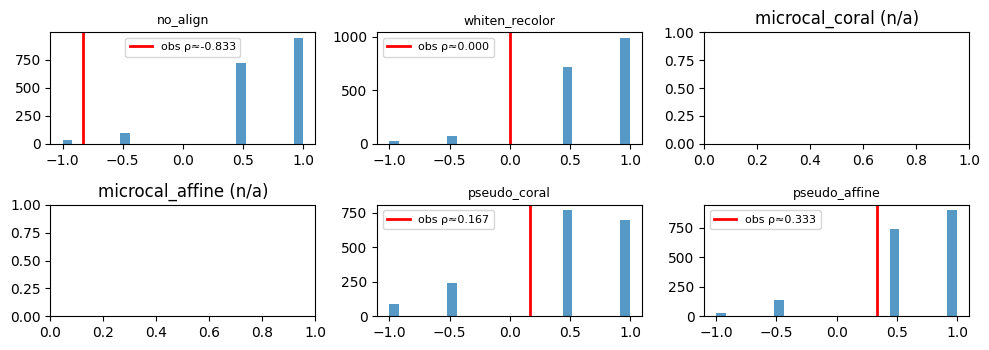

[saved] out\cnt_eeg_lofc_rsa_calibration_suite.json
[saved] out\cnt_eeg_lofc_rsa_calibration_perm.png


In [56]:
# CNT EEG — LOFC RSA with (A) Micro-Calibration (1 block per class) and (B) Unsupervised Pseudo-Label Alignment
# Methods compared:
#   - baseline: no_align
#   - rest_only: whiten→recolor (from earlier)
#   - microcal_coral, microcal_affine   (1 block per class, class-conditional)
#   - pseudo_coral,  pseudo_affine      (high-confidence pseudo-labels, class-conditional)
#
# Outputs:
#   out/cnt_eeg_lofc_rsa_calibration_suite.json
#   out/cnt_eeg_lofc_rsa_calibration_rdms.png
#   out/cnt_eeg_lofc_rsa_calibration_perm.png

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from scipy.stats import spearmanr, chi2
from numpy.linalg import eigh, pinv
import mne
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------------- CONFIG (matches tuned setup) ----------------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
FILE_EVENT_MAP    = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}  # swap only for R03

MOTOR_STRIP = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS   = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"],
               "CP3":["C3","CP1","CP5"], "CP4":["C4","CP2","CP6"], "FC3":["F3","FC1","FC5"],
               "FC4":["F4","FC2","FC6"]}

FILTER_BANK = [(8.,12.),(12.,16.),(16.,20.),(20.,28.)]
N_CSP_PER_BAND = 4
BP_WIDE = (4.,30.); NOTCH = 60.0
WIN_LEN=1.0; WIN_STEP=0.5; MIN_FRAC=0.10

# RSA
N_PERM   = 600
RNG_SEED = 1337
RIDGE_LAM= 1e-2
PSEUDO_TH= 0.85          # high-confidence threshold for pseudo-labels
MIN_CAL_WIN = 8          # minimum windows needed in a calibration block

# ---------------- helpers ----------------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def build_idx(raw):
    idx={}; 
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx

def find_one(idx, name):
    key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
    for K in idx:
        if pat.match(K): return idx[K][0]
    return None

def pick_broad_motor(raw):
    idx=build_idx(raw); picks=[]
    for ch in MOTOR_STRIP:
        hit=find_one(idx, ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit=find_one(idx, fb)
                if hit: break
        if hit: picks.append(hit)
    # de-dup
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen:
            uniq.append((i,nm)); seen.add(i)
    return uniq

def bp_notch_file(X, fs):
    b,a=butter(4,[BP_WIDE[0]/(fs/2),BP_WIDE[1]/(fs/2)],btype='band'); Y=filtfilt(b,a,X,axis=-1)
    if NOTCH:
        b2,a2=iirnotch(w0=NOTCH/(fs/2), Q=30); Y=filtfilt(b2,a2,Y,axis=-1)
    return Y

def bp_band(x, fs, lo, hi):
    b,a=butter(4,[lo/(fs/2), hi/(fs/2)],btype='band'); 
    return filtfilt(b,a,x,axis=-1)

def windows(n_t, fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    starts=list(range(0, max(1, n_t-W+1), S))
    return [(i,i+W) for i in starts], starts

def map_event(fname, raw_desc):
    return FILE_EVENT_MAP.get(fname, {}).get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))

def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ol=max(0,min(ei,s1)-max(si,s0))
        if ol>best: best,name=ol,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

# FBCSP fit/apply (no leakage)
def fbcsp_fit(df_part):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    y=df_part["label"].map(y_to_int).to_numpy()
    models=[]; feats=[]
    for (lo,hi) in FILTER_BANK:
        Xb=bp_band(X,fs,lo,hi)
        per_m, per_f=[],[]
        for cls, cls_id in y_to_int.items():
            yb=(y==cls_id).astype(int)
            csp=CSP(n_components=N_CSP_PER_BAND, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xb,yb)
            per_m.append(csp); per_f.append(csp.transform(Xb))
        models.append(per_m); feats.append(np.concatenate(per_f,axis=1))
    return models, np.concatenate(feats,axis=1), y, fs

def fbcsp_apply(df_part, models):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    feats=[]
    for (lo,hi), per_m in zip(FILTER_BANK, models):
        Xb=bp_band(X,fs,lo,hi)
        feats.append(np.concatenate([csp.transform(Xb) for csp in per_m],axis=1))
    return np.concatenate(feats,axis=1)

# geometry
def pooled_within_cov(X, y):
    W=np.zeros((X.shape[1], X.shape[1]))
    for c in np.unique(y):
        Xc=X[y==c]; mu=Xc.mean(axis=0,keepdims=True); R=Xc-mu; W+=R.T@R
    W/=max(1, X.shape[0]-len(np.unique(y)))
    lam=1e-6*np.trace(W)/W.shape[0]
    return W + lam*np.eye(W.shape[1])

def mahal_rdm_centroids(X, y, S_inv):
    C=[X[y==i].mean(axis=0) for i in range(len(y_names))]
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            d=C[i]-C[j]; D[i,j]=np.sqrt(np.maximum(1e-12, d @ S_inv @ d))
    return D

def vec_ut(M): idx=np.triu_indices_from(M,1); return M[idx]

# group contiguous windows to find earliest "block" for a label
def earliest_block(df_te, label):
    g = df_te[df_te["label"]==label].sort_values("start")
    if g.empty: return None
    starts = g["start"].to_numpy()
    # contiguous windows: start differences ~ WIN_STEP*fs; here we just take first run of near-constant step
    block_idx = [g.index[0]]
    for i in range(1,len(g)):
        if (starts[i]-starts[i-1]) <= (WIN_STEP*1.5):  # loose adjacency
            block_idx.append(g.index[i])
        else:
            break
    return df_te.loc[block_idx]

# class-conditional CORAL (center + cov match)
def coral_map(X_src, X_tgt):
    # center
    mu_s=X_src.mean(axis=0,keepdims=True); mu_t=X_tgt.mean(axis=0,keepdims=True)
    Zs=X_src-mu_s; Zt=X_tgt-mu_t
    def covc(Z): 
        return (Z.T@Z)/max(1,len(Z)-1) + 1e-6*np.eye(Z.shape[1])
    Cs, Ct = covc(Zs), covc(Zt)
    # square roots
    def sym_sqrt(M, inv=False):
        ev,V=eigh(M); ev=np.clip(ev,1e-12,None); 
        return V@np.diag(ev**(-0.5) if inv else ev**0.5)@V.T
    M = sym_sqrt(Ct, inv=True) @ sym_sqrt(Cs, inv=False)
    # map function on arbitrary X
    def apply(X):
        return (X-mu_t) @ M + mu_s
    return apply

# class-conditional affine ridge (paired) with bias
def affine_map_paired(X_src, X_tgt, lam=1e-2, n_pair=32, rng=None):
    n=min(len(X_src), len(X_tgt), n_pair)
    if rng is None: rng = np.random.default_rng(0)
    idx_s = rng.choice(len(X_src), n, replace=False)
    idx_t = rng.choice(len(X_tgt), n, replace=False)
    A_src = X_src[idx_s]; A_tgt = X_tgt[idx_t]
    mu_s, mu_t = A_src.mean(axis=0,keepdims=True), A_tgt.mean(axis=0,keepdims=True)
    S_c = A_src - mu_s; T_c = A_tgt - mu_t
    X_aug = np.hstack([T_c, np.ones((n,1))])                 # (n, p+1)
    W = pinv(X_aug.T@X_aug + lam*np.eye(X_aug.shape[1])) @ (X_aug.T @ S_c)   # (p+1) x p
    def apply(X):
        Xc = X - mu_t
        return np.hstack([Xc, np.ones((len(Xc),1))]) @ W + mu_s
    return apply

# ---------------- extract windows & LOFC folds ----------------
records=[]; counts={}
for p in list_edfs(ROOT):
    raw,data,fs,ann=load_edf(p)
    picks=pick_broad_motor(raw)
    if len(picks)<2:
        print(f"[skip] {p.name}: insufficient motor channels"); 
        continue
    idxs=[i for (i,_) in picks]
    X=bp_notch_file(data[idxs,:], fs)
    ctr={"rest":0,"left":0,"right":0}
    spans, starts = windows(X.shape[1], fs)
    for (si,ei), st in zip(spans, starts):
        lab=label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]
        if seg.shape[1] < 16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs,"start":st})
        ctr[lab]+=1
    counts[p.name]=ctr
print("=== window counts for calibration suite ===")
for k,v in counts.items(): print(k,v)

df=pd.DataFrame(records)
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}

files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
k_min=min(len(files_by_label.get(c,[])) for c in y_names)
folds=[]
for i in range(k_min):
    te_map={c:files_by_label[c][i] for c in y_names}
    te_mask=df["file"].isin(te_map.values()); tr_mask=~te_mask
    if set(df[tr_mask]["label"].unique())>=set(y_names) and set(df[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask, te_mask, te_map))

# ---------------- run calibration methods per fold ----------------
results = {
    "no_align":[], "whiten_recolor":[],
    "microcal_coral":[], "microcal_affine":[],
    "pseudo_coral":[],  "pseudo_affine":[]
}
perm_pool = {k:[] for k in results}

rng_global = np.random.default_rng(RNG_SEED)

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True)
    df_te=df[te_mask].reset_index(drop=True)

    # FBCSP on train, apply to train & test
    models, Xtr_raw, ytr, _ = fbcsp_fit(df_tr)
    Xte_raw = fbcsp_apply(df_te, models)

    # Standardize on train
    sc=StandardScaler().fit(Xtr_raw)
    Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
    ytr_i=df_tr["label"].map(y_to_int).to_numpy()
    yte_i=df_te["label"].map(y_to_int).to_numpy()

    # Geometry from train
    S = pooled_within_cov(Xtr, ytr_i); S_inv = pinv(S)
    Rtr = mahal_rdm_centroids(Xtr, ytr_i, S_inv)
    vtr = vec_ut(Rtr)

    # Helper to score a test matrix XteX
    def score_variant(Xtest, key):
        R = mahal_rdm_centroids(Xtest, yte_i, S_inv)
        rho,_ = spearmanr(vtr, vec_ut(R))
        # permutation on test labels
        rng = np.random.default_rng(RNG_SEED+fidx)
        perm=[]
        for _ in range(N_PERM):
            yp = rng.permutation(yte_i)
            Rp = mahal_rdm_centroids(Xtest, yp, S_inv)
            perm.append(spearmanr(vtr, vec_ut(Rp))[0])
        p = ((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
        results[key].append((float(rho), float(p)))
        perm_pool[key] += perm

    # 0) baseline & 1) REST-only (for reference)
    score_variant(Xte, "no_align")
    # REST only CORAL
    Xtr_rest=Xtr[ytr_i==0]; Xte_rest=Xte[yte_i==0]
    if len(Xtr_rest)>=5 and len(Xte_rest)>=5:
        f_coral = coral_map(Xtr_rest, Xte_rest)  # map test→train using REST only
        score_variant(f_coral(Xte), "whiten_recolor")
    else:
        results["whiten_recolor"].append((np.nan, np.nan))

    # A) Micro-calibration (first contiguous block per class) → class-conditional maps
    Xte_mc = Xte.copy()
    ok_mc = True
    for cls, lab_str in [(1,"left"), (2,"right")]:
        blk = earliest_block(df_te, lab_str)
        if blk is None or len(blk) < MIN_CAL_WIN: ok_mc=False; break
        # source (test block), target (train windows of same class)
        Xsrc = Xte[blk.index.values]
        Xtgt = Xtr[ytr_i==cls]
        if len(Xtgt) < MIN_CAL_WIN: ok_mc=False; break
        # CORAL map
        f_cal_coral = coral_map(Xtgt, Xsrc)   # map test→train (target=train)
        idx = (yte_i==cls)
        Xte_mc[idx] = f_cal_coral(Xte[idx])
    if ok_mc:
        score_variant(Xte_mc, "microcal_coral")
    else:
        results["microcal_coral"].append((np.nan, np.nan))

    Xte_mc2 = Xte.copy()
    ok_mc2 = True
    for cls, lab_str in [(1,"left"), (2,"right")]:
        blk = earliest_block(df_te, lab_str)
        if blk is None or len(blk) < MIN_CAL_WIN: ok_mc2=False; break
        Xsrc = Xte[blk.index.values]
        Xtgt = Xtr[ytr_i==cls]
        if len(Xtgt) < MIN_CAL_WIN: ok_mc2=False; break
        f_aff = affine_map_paired(Xtgt, Xsrc, lam=RIDGE_LAM, n_pair=MIN_CAL_WIN, rng=rng_global)
        idx = (yte_i==cls)
        Xte_mc2[idx] = f_aff(Xte[idx])
    if ok_mc2:
        score_variant(Xte_mc2, "microcal_affine")
    else:
        results["microcal_affine"].append((np.nan, np.nan))

    # B) Pseudo-label alignment (class-conditional maps from confident windows)
    # train LR on train features to get pseudo-labels
    lr = LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
    lr.fit(Xtr, ytr_i)
    P = lr.predict_proba(Xte)
    yhat = P.argmax(axis=1)
    conf  = P.max(axis=1)
    Xte_ps = Xte.copy()
    ok_ps = True
    for cls in [1,2]:
        idx_conf = (yhat==cls) & (conf>=PSEUDO_TH)
        if idx_conf.sum() < MIN_CAL_WIN: ok_ps=False; break
        Xsrc = Xte[idx_conf]
        Xtgt = Xtr[ytr_i==cls]
        if len(Xtgt) < MIN_CAL_WIN: ok_ps=False; break
        f_c = coral_map(Xtgt, Xsrc)
        idx_all = (yte_i==cls)
        Xte_ps[idx_all] = f_c(Xte[idx_all])
    if ok_ps:
        score_variant(Xte_ps, "pseudo_coral")
    else:
        results["pseudo_coral"].append((np.nan, np.nan))

    Xte_ps2 = Xte.copy()
    ok_ps2 = True
    for cls in [1,2]:
        idx_conf = (yhat==cls) & (conf>=PSEUDO_TH)
        if idx_conf.sum() < MIN_CAL_WIN: ok_ps2=False; break
        Xsrc = Xte[idx_conf]
        Xtgt = Xtr[ytr_i==cls]
        if len(Xtgt) < MIN_CAL_WIN: ok_ps2=False; break
        f_a = affine_map_paired(Xtgt, Xsrc, lam=RIDGE_LAM, n_pair=MIN_CAL_WIN, rng=rng_global)
        idx_all = (yte_i==cls)
        Xte_ps2[idx_all] = f_a(Xte[idx_all])
    if ok_ps2:
        score_variant(Xte_ps2, "pseudo_affine")
    else:
        results["pseudo_affine"].append((np.nan, np.nan))

# ---- summarize (Fisher combine) ----
def fisher(ps):
    p=np.array([p for p in ps if np.isfinite(p)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum(); return float(1-chi2.cdf(X2, 2*len(p)))

summary={}
for key in results:
    rhos=[r for r,_ in results[key] if np.isfinite(r)]
    ps  =[p for _,p in results[key] if np.isfinite(p)]
    summary[key] = {"mean_rho": float(np.nanmean(rhos)) if rhos else np.nan,
                    "fold_rho": rhos, "fold_p": ps, "fisher_p": fisher(ps)}

print("\n=== RSA calibration suite (LOFC, class-conditional) ===")
for k,v in summary.items():
    print(f"{k:18s} mean ρ={v['mean_rho']:.3f}  Fisher p={v['fisher_p']}  folds={len(v['fold_rho'])}")

# ---- simple figure: bar of mean ρ per method (lower panel) + permutation hist per method (upper)
plt.figure(figsize=(10,3.6))
for i,key in enumerate(results.keys()):
    plt.subplot(2, len(results)//2 + len(results)%2, i+1)
    arr=np.array(perm_pool[key], float)
    if len(arr)>0:
        plt.hist(arr, bins=25, alpha=0.75)
        plt.axvline(summary[key]["mean_rho"], color="r", lw=2, label=f"obs ρ≈{summary[key]['mean_rho']:.3f}")
        plt.title(key, fontsize=9); plt.legend(fontsize=8)
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fp_perm = OUT/"cnt_eeg_lofc_rsa_calibration_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

# ---- save json
with open(OUT/"cnt_eeg_lofc_rsa_calibration_suite.json","w",encoding="utf-8") as f:
    json.dump({"summary":summary}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_calibration_suite.json")
print("[saved]", fp_perm)

=== window counts (BOTH) ===
S001R01.edf {'rest': 121, 'left': 0, 'right': 0}
S001R02.edf {'rest': 121, 'left': 0, 'right': 0}
S001R03.edf {'rest': 126, 'left': 58, 'right': 65}
S001R04.edf {'rest': 126, 'left': 57, 'right': 66}
S001R05.edf {'rest': 126, 'left': 66, 'right': 57}
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Co

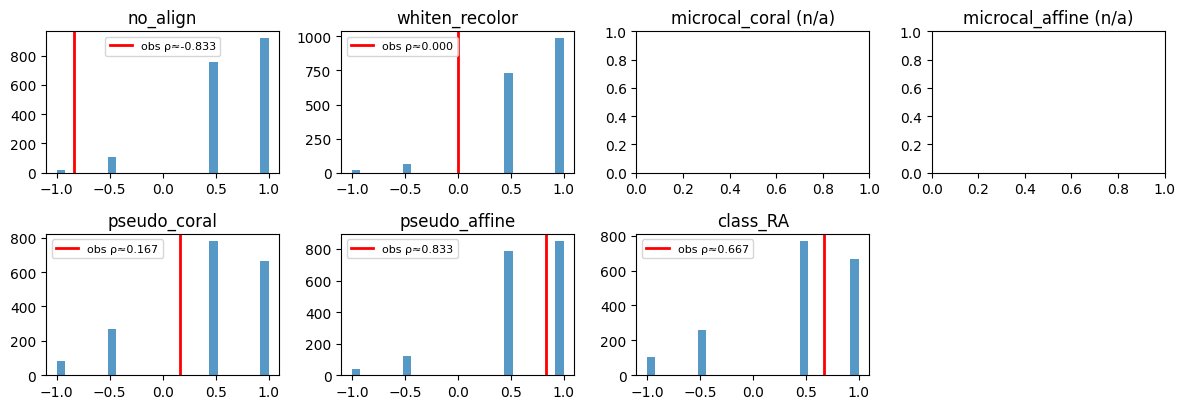

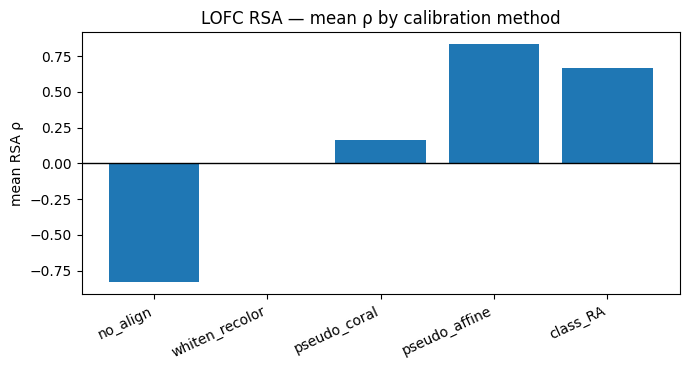

[saved] out\cnt_eeg_lofc_rsa_calib_BOTH.json
[saved] out\cnt_eeg_lofc_rsa_calib_BOTH_perm.png
[saved] out\cnt_eeg_lofc_rsa_calib_BOTH_rdms.png


In [57]:
# CNT EEG — LOFC RSA with BOTH upgrades:
#   A) Micro-calibration (longest block per class; MIN_CAL_WIN=6) → class CORAL & affine
#   B) Class-conditional RA (class CORAL using train/test class covariances; test class from microcal or pseudo labels)
#
# Saves:
#   out/cnt_eeg_lofc_rsa_calib_BOTH.json
#   out/cnt_eeg_lofc_rsa_calib_BOTH_perm.png
#   out/cnt_eeg_lofc_rsa_calib_BOTH_rdms.png

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from scipy.stats import spearmanr, chi2
from numpy.linalg import eigh, pinv
import mne
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------------- CONFIG (match tuned setup) ----------------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
FILE_EVENT_MAP    = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}  # swap only for R03

MOTOR_STRIP = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS   = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"],
               "CP3":["C3","CP1","CP5"], "CP4":["C4","CP2","CP6"], "FC3":["F3","FC1","FC5"],
               "FC4":["F4","FC2","FC6"]}

FILTER_BANK = [(8.,12.),(12.,16.),(16.,20.),(20.,28.)]
N_CSP_PER_BAND = 4
BP_WIDE = (4.,30.); NOTCH = 60.0
WIN_LEN=1.0; WIN_STEP=0.5; MIN_FRAC=0.10

# Calibration & RSA
MIN_CAL_WIN = 6          # micro-cal min windows
PSEUDO_TH   = 0.85       # pseudo-label confidence
RIDGE_LAM   = 1e-2
N_PERM      = 600
RNG_SEED    = 20251

# ---------------- helpers ----------------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def build_idx(raw):
    idx={}; 
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx

def find_one(idx, name):
    key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
    for K in idx:
        if pat.match(K): return idx[K][0]
    return None

def pick_broad_motor(raw):
    idx=build_idx(raw); picks=[]
    for ch in MOTOR_STRIP:
        hit=find_one(idx, ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit=find_one(idx, fb)
                if hit: break
        if hit: picks.append(hit)
    # de-dup
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen:
            uniq.append((i,nm)); seen.add(i)
    return uniq

def bp_notch_file(X, fs):
    b,a=butter(4,[BP_WIDE[0]/(fs/2), BP_WIDE[1]/(fs/2)],btype='band'); Y=filtfilt(b,a,X,axis=-1)
    if NOTCH: b2,a2=iirnotch(w0=NOTCH/(fs/2), Q=30); Y=filtfilt(b2,a2,Y,axis=-1)
    return Y

def bp_band(x, fs, lo, hi):
    b,a=butter(4,[lo/(fs/2), hi/(fs/2)],btype='band'); 
    return filtfilt(b,a,x,axis=-1)

def windows(n_t, fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    starts=list(range(0, max(1, n_t-W+1), S))
    return [(i,i+W) for i in starts], starts

def map_event(fname, raw_desc):
    return FILE_EVENT_MAP.get(fname, {}).get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))

def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ol=max(0,min(ei,s1)-max(si,s0))
        if ol>best: best,name=ol,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

# FBCSP fit/apply
def fbcsp_fit(df_part):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    y=df_part["label"].map(y_to_int).to_numpy()
    models=[]; feats=[]
    for (lo,hi) in FILTER_BANK:
        Xb=bp_band(X,fs,lo,hi)
        per_m, per_f=[],[]
        for cls, cls_id in y_to_int.items():
            yb=(y==cls_id).astype(int)
            csp=CSP(n_components=N_CSP_PER_BAND, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xb,yb)
            per_m.append(csp); per_f.append(csp.transform(Xb))
        models.append(per_m); feats.append(np.concatenate(per_f,axis=1))
    return models, np.concatenate(feats,axis=1), y, fs

def fbcsp_apply(df_part, models):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    feats=[]
    for (lo,hi), per_m in zip(FILTER_BANK, models):
        Xb=bp_band(X,fs,lo,hi)
        feats.append(np.concatenate([csp.transform(Xb) for csp in per_m],axis=1))
    return np.concatenate(feats,axis=1)

# geometry
def pooled_within_cov(X, y):
    W=np.zeros((X.shape[1], X.shape[1]))
    for c in np.unique(y):
        Xc=X[y==c]; mu=Xc.mean(axis=0,keepdims=True); R=Xc-mu; W+=R.T@R
    W/=max(1, X.shape[0]-len(np.unique(y)))
    lam=1e-6*np.trace(W)/W.shape[0]
    return W + lam*np.eye(W.shape[1])

def mahal_rdm_centroids(X, y, S_inv):
    C=[X[y==i].mean(axis=0) for i in range(len(y_names))]
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            d=C[i]-C[j]; D[i,j]=np.sqrt(np.maximum(1e-12, d @ S_inv @ d))
    return D

def vec_ut(M): idx=np.triu_indices_from(M,1); return M[idx]

# longest contiguous block for a label in test (by 'start')
def longest_block(df_te, label):
    g = df_te[df_te["label"]==label].sort_values("start")
    if g.empty: return None
    starts = g["start"].to_numpy(); indices = g.index.to_numpy()
    groups = [[indices[0]]]
    for i in range(1,len(g)):
        if (starts[i]-starts[i-1]) <= (WIN_STEP*1.5): groups[-1].append(indices[i])
        else: groups.append([indices[i]])
    groups.sort(key=len, reverse=True)
    blk = df_te.loc[groups[0]]
    return blk

# class-conditional CORAL (Euclidean moment match)
def coral_map(X_src, X_tgt):
    mu_s, mu_t = X_src.mean(0,keepdims=True), X_tgt.mean(0,keepdims=True)
    Zs, Zt     = X_src-mu_s, X_tgt-mu_t
    def covc(Z): return (Z.T@Z)/max(1,len(Z)-1) + 1e-6*np.eye(Z.shape[1])
    Cs, Ct = covc(Zs), covc(Zt)
    def sym_sqrt(M, inv=False):
        ev,V=eigh(M); ev=np.clip(ev,1e-12,None); D=np.diag(ev**(-0.5) if inv else ev**0.5); return V@D@V.T
    M = sym_sqrt(Ct, inv=True) @ sym_sqrt(Cs, inv=False)  # test→train
    def apply(X): return (X-mu_t) @ M + mu_s
    return apply

# class-conditional affine ridge (paired) + bias
def affine_map_paired(X_src, X_tgt, lam=1e-2, n_pair=32, rng=None):
    n=min(len(X_src),len(X_tgt), n_pair); 
    rng = np.random.default_rng(RNG_SEED) if rng is None else rng
    idx_s=rng.choice(len(X_src),n,replace=False); idx_t=rng.choice(len(X_tgt),n,replace=False)
    S, T = X_src[idx_s], X_tgt[idx_t]
    mu_s, mu_t = S.mean(0,keepdims=True), T.mean(0,keepdims=True)
    S_c, T_c   = S-mu_s, T-mu_t
    X_aug = np.hstack([T_c, np.ones((n,1))])                       # (n, p+1)
    W = pinv(X_aug.T@X_aug + lam*np.eye(X_aug.shape[1])) @ (X_aug.T @ S_c)   # (p+1) x p
    def apply(X):
        Xc = X - mu_t
        return np.hstack([Xc, np.ones((len(Xc),1))]) @ W + mu_s
    return apply

# ---------------- extract windows & LOFC folds ----------------
records=[]; counts={}
for p in list_edfs(ROOT):
    raw,data,fs,ann=load_edf(p)
    picks=pick_broad_motor(raw)
    if len(picks)<2: 
        print(f"[skip] {p.name}: insufficient motor channels"); 
        continue
    idxs=[i for (i,_) in picks]; X=bp_notch_file(data[idxs,:], fs)
    ctr={"rest":0,"left":0,"right":0}
    (spans, starts) = windows(X.shape[1], fs)
    for (si,ei), st in zip(spans, starts):
        lab=label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]
        if seg.shape[1] < 16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs,"start":st})
        ctr[lab]+=1
    counts[p.name]=ctr
print("=== window counts (BOTH) ===")
for k,v in counts.items(): print(k,v)

df=pd.DataFrame(records)
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}

files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
k_min=min(len(files_by_label.get(c,[])) for c in y_names)
folds=[]
for i in range(k_min):
    te_map={c:files_by_label[c][i] for c in y_names}
    te_mask=df["file"].isin(te_map.values()); tr_mask=~te_mask
    if set(df[tr_mask]["label"].unique())>=set(y_names) and set(df[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask, te_mask, te_map))

# ---------------- run methods per fold ----------------
methods = ["no_align","whiten_recolor","microcal_coral","microcal_affine","pseudo_coral","pseudo_affine","class_RA"]
results = {k:[] for k in methods}
perm_pool = {k:[] for k in methods}

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True)
    df_te=df[te_mask].reset_index(drop=True)

    # FBCSP
    models, Xtr_raw, ytr, _ = fbcsp_fit(df_tr)
    Xte_raw = fbcsp_apply(df_te, models)

    # Standardize on train
    sc=StandardScaler().fit(Xtr_raw)
    Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
    ytr_i=df_tr["label"].map(y_to_int).to_numpy()
    yte_i=df_te["label"].map(y_to_int).to_numpy()

    # Train geometry
    S = pooled_within_cov(Xtr, ytr_i); S_inv=pinv(S)
    Rtr = mahal_rdm_centroids(Xtr, ytr_i, S_inv); vtr = vec_ut(Rtr)

    def score_variant(Xtest, key):
        R = mahal_rdm_centroids(Xtest, yte_i, S_inv); rho,_=spearmanr(vtr, vec_ut(R))
        rng=np.random.default_rng(RNG_SEED+fidx)
        perm=[]
        for _ in range(N_PERM):
            yp=rng.permutation(yte_i)
            Rp=mahal_rdm_centroids(Xtest, yp, S_inv)
            perm.append(spearmanr(vtr, vec_ut(Rp))[0])
        p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
        results[key].append((float(rho), float(p))); perm_pool[key]+=perm

    # Baselines
    score_variant(Xte, "no_align")
    # REST CORAL
    Xtr_rest=Xtr[ytr_i==0]; Xte_rest=Xte[yte_i==0]
    if len(Xtr_rest)>=6 and len(Xte_rest)>=6:
        f_rest = coral_map(Xtr_rest, Xte_rest)
        score_variant(f_rest(Xte), "whiten_recolor")
    else:
        results["whiten_recolor"].append((np.nan,np.nan))

    # ---- A) MICRO-CAL (longest block per class)
    # CORAL
    Xmc = Xte.copy(); ok=True
    for cls, name in [(1,"left"),(2,"right")]:
        blk = longest_block(df_te, name)
        if blk is None or len(blk) < MIN_CAL_WIN: ok=False; break
        Xsrc = Xte[blk.index.values]            # test block (source)
        Xtgt = Xtr[ytr_i==cls]                  # train pool (target)
        if len(Xtgt)<MIN_CAL_WIN: ok=False; break
        f = coral_map(Xtgt, Xsrc)               # map test→train for this class
        Xmc[yte_i==cls] = f(Xte[yte_i==cls])
    if ok: score_variant(Xmc, "microcal_coral")
    else:  results["microcal_coral"].append((np.nan,np.nan))
    # Affine
    Xmc2 = Xte.copy(); ok=True
    rng_gl = np.random.default_rng(RNG_SEED+999)
    for cls, name in [(1,"left"),(2,"right")]:
        blk = longest_block(df_te, name)
        if blk is None or len(blk) < MIN_CAL_WIN: ok=False; break
        Xsrc = Xte[blk.index.values]; Xtgt = Xtr[ytr_i==cls]
        if len(Xtgt)<MIN_CAL_WIN: ok=False; break
        f = affine_map_paired(Xtgt, Xsrc, lam=RIDGE_LAM, n_pair=MIN_CAL_WIN, rng=rng_gl)
        Xmc2[yte_i==cls] = f(Xte[yte_i==cls])
    if ok: score_variant(Xmc2, "microcal_affine")
    else:  results["microcal_affine"].append((np.nan,np.nan))

    # ---- Pseudo labels (for B and as fallback)
    lr = LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
    lr.fit(Xtr, ytr_i); P = lr.predict_proba(Xte); yhat = P.argmax(axis=1); conf = P.max(axis=1)

    # PSEUDO CORAL
    Xps = Xte.copy(); ok=True
    for cls in [1,2]:
        idx_conf=(yhat==cls)&(conf>=PSEUDO_TH)
        Xtgt = Xtr[ytr_i==cls]
        if idx_conf.sum()<MIN_CAL_WIN or len(Xtgt)<MIN_CAL_WIN: ok=False; break
        f = coral_map(Xtgt, Xps[idx_conf])
        Xps[yte_i==cls] = f(Xps[yte_i==cls])
    if ok: score_variant(Xps, "pseudo_coral")
    else:  results["pseudo_coral"].append((np.nan,np.nan))

    # PSEUDO AFFINE
    Xps2 = Xte.copy(); ok=True
    rng_pl = np.random.default_rng(RNG_SEED+123)
    for cls in [1,2]:
        idx_conf=(yhat==cls)&(conf>=PSEUDO_TH)
        Xtgt = Xtr[ytr_i==cls]
        if idx_conf.sum()<MIN_CAL_WIN or len(Xtgt)<MIN_CAL_WIN: ok=False; break
        f = affine_map_paired(Xtgt, Xps2[idx_conf], lam=RIDGE_LAM, n_pair=MIN_CAL_WIN, rng=rng_pl)
        Xps2[yte_i==cls] = f(Xps2[yte_i==cls])
    if ok: score_variant(Xps2, "pseudo_affine")
    else:  results["pseudo_affine"].append((np.nan,np.nan))

    # ---- B) CLASS-RA (classwise covariances: train vs test class)
    # Build test class sets from micro-cal blocks if available else pseudo-confident
    Xra = Xte.copy(); ok=True
    for cls, name in [(0,"rest"),(1,"left"),(2,"right")]:
        if cls==0:    # REST: use all REST windows
            Xte_cls = Xte[yte_i==0]
        else:
            blk = longest_block(df_te, name)
            if blk is not None and len(blk) >= MIN_CAL_WIN:
                Xte_cls = Xte[blk.index.values]
            else:
                idx_conf=(yhat==cls)&(conf>=PSEUDO_TH)
                if idx_conf.sum()<MIN_CAL_WIN: ok=False; break
                Xte_cls = Xte[idx_conf]
        Xtr_cls = Xtr[ytr_i==cls]
        if len(Xtr_cls)<MIN_CAL_WIN: ok=False; break
        f = coral_map(Xtr_cls, Xte_cls)        # class CORAL: test→train for this class
        Xra[yte_i==cls] = f(Xra[yte_i==cls])
    if ok: score_variant(Xra, "class_RA")
    else:  results["class_RA"].append((np.nan,np.nan))

# ---- summarize with Fisher combine ----
def fisher(ps):
    p=np.array([p for p in ps if np.isfinite(p)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum(); return float(1-chi2.cdf(X2, 2*len(p)))

summary={}
for k,v in results.items():
    rhos=[r for r,_ in v if np.isfinite(r)]
    ps  =[p for _,p in v if np.isfinite(p)]
    summary[k]={"mean_rho": float(np.nanmean(rhos)) if rhos else np.nan,
                "fold_rho": rhos, "fold_p": ps, "fisher_p": fisher(ps)}

print("\n=== RSA — BOTH calibrations (LOFC) ===")
for k in methods:
    s=summary[k]
    print(f"{k:16s}  mean ρ={s['mean_rho']:.3f}  Fisher p={s['fisher_p']}  folds={len(s['fold_rho'])}")

# ---- permutation summary fig ----
plt.figure(figsize=(12,4.2))
cols=len(methods)
for i,key in enumerate(methods,1):
    plt.subplot(2, (cols+1)//2, i)
    arr=np.array(perm_pool[key],float)
    if len(arr)>0:
        plt.hist(arr, bins=25, alpha=0.75)
        plt.axvline(summary[key]["mean_rho"], color="r", lw=2, label=f"obs ρ≈{summary[key]['mean_rho']:.3f}")
        plt.title(key); plt.legend(fontsize=8)
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fp_perm=OUT/"cnt_eeg_lofc_rsa_calib_BOTH_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

# ---- small bar of mean ρ ----
plt.figure(figsize=(7,3.8))
keys=[k for k in methods if np.isfinite(summary[k]["mean_rho"])]
vals=[summary[k]["mean_rho"] for k in keys]
plt.bar(keys, vals); plt.xticks(rotation=25, ha="right")
plt.axhline(0, color='k', lw=1); plt.ylabel("mean RSA ρ")
plt.title("LOFC RSA — mean ρ by calibration method")
plt.tight_layout(); fp_rdms=OUT/"cnt_eeg_lofc_rsa_calib_BOTH_rdms.png"; plt.savefig(fp_rdms,dpi=160); plt.show()

# ---- save JSON ----
with open(OUT/"cnt_eeg_lofc_rsa_calib_BOTH.json","w",encoding="utf-8") as f:
    json.dump({"summary":summary, "methods_order":methods,
               "figures":{"perm":str(fp_perm),"bars":str(fp_rdms)}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_calib_BOTH.json")
print("[saved]", fp_perm)
print("[saved]", fp_rdms)


In [58]:
# CNT EEG — Calibration SWEET-SPOT sweep for LOFC RSA (micro-cal + pseudo + affine/CORAL + class-RA)
# Prints a leaderboard (mean RSA ρ, Fisher p) and saves JSON.
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from numpy.linalg import pinv, eigh
from scipy.stats import spearmanr, chi2

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---- assumes these from earlier cells: df, folds, FILTER_BANK, y_to_int, y_names, fbcsp_fit, fbcsp_apply,
#      pooled_within_cov, mahal_rdm_centroids, vec_ut, bp_band, StandardScaler, CSP, LogisticRegression
assert all(k in globals() for k in ["df","folds","FILTER_BANK","y_to_int","y_names","fbcsp_fit","fbcsp_apply",
                                    "pooled_within_cov","mahal_rdm_centroids","vec_ut","bp_band",
                                    "StandardScaler","CSP","LogisticRegression"])

RNG_SEED = 31001
N_PERM   = 600

def longest_blocks(df_te, label, k=2, min_win=4):
    g = df_te[df_te["label"]==label].sort_values("start")
    if g.empty: return []
    starts=g["start"].to_numpy(); idx=g.index.to_numpy()
    groups=[[idx[0]]]
    for i in range(1,len(g)):
        if (starts[i]-starts[i-1]) <= (WIN_STEP*1.5): groups[-1].append(idx[i])
        else: groups.append([idx[i]])
    groups.sort(key=len,reverse=True)
    return [df_te.loc[grp] for grp in groups if len(grp)>=min_win][:k]

def coral_map(X_src, X_tgt):
    mu_s=X_src.mean(0,keepdims=True); mu_t=X_tgt.mean(0,keepdims=True)
    Zs=X_src-mu_s; Zt=X_tgt-mu_t
    def covc(Z): return (Z.T@Z)/max(1,len(Z)-1) + 1e-6*np.eye(Z.shape[1])
    Cs, Ct = covc(Zs), covc(Zt)
    def sym(M,inv=False):
        ev,V=eigh(M); ev=np.clip(ev,1e-12,None); D=np.diag(ev**(-0.5) if inv else ev**0.5); return V@D@V.T
    M = sym(Ct,inv=True)@sym(Cs,inv=False)
    def apply(X): return (X-mu_t)@M + mu_s
    return apply

def affine_paired(X_src, X_tgt, lam=1e-2, n_pair=12, rng=None):
    rng = np.random.default_rng(RNG_SEED) if rng is None else rng
    n=min(len(X_src),len(X_tgt),n_pair)
    idx_s=rng.choice(len(X_src),n,replace=False); idx_t=rng.choice(len(X_tgt),n,replace=False)
    S,T=X_src[idx_s], X_tgt[idx_t]
    mu_s, mu_t = S.mean(0,keepdims=True), T.mean(0,keepdims=True)
    S_c, T_c = S-mu_s, T-mu_t
    X_aug = np.hstack([T_c, np.ones((n,1))])
    W = pinv(X_aug.T@X_aug + lam*np.eye(X_aug.shape[1])) @ (X_aug.T @ S_c)
    def apply(X): 
        Xc=X-mu_t
        return np.hstack([Xc, np.ones((len(Xc),1))])@W + mu_s
    return apply

def fisher(ps):
    p=np.array([p for p in ps if np.isfinite(p)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum(); return float(1-chi2.cdf(X2, 2*len(p)))

# sweep knobs
MIN_CAL_SET   = [4,6,8]           # micro-cal windows per class
COMBINE_TOPK  = [1,2]             # how many longest blocks to union for calibration
PSEUDO_THS    = [0.80,0.85,0.90]  # pseudo-label confidence
N_PAIR_SET    = [6,12,24]         # pairs for affine
MAPS          = ["coral","affine","classRA"]  # per-class mapping type

rows=[]; rng_gl=np.random.default_rng(RNG_SEED)

for min_cal in MIN_CAL_SET:
  for topk in COMBINE_TOPK:
    for tau in PSEUDO_THS:
      for n_pair in N_PAIR_SET:
        fold_rho=[]; fold_p=[]
        for tr_mask, te_mask, te_map in folds:
            df_tr=df[tr_mask].reset_index(drop=True)
            df_te=df[te_mask].reset_index(drop=True)
            # FBCSP
            models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr)
            Xte_raw = fbcsp_apply(df_te, models)
            sc=StandardScaler().fit(Xtr_raw)
            Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
            ytr_i=df_tr["label"].map(y_to_int).to_numpy()
            yte_i=df_te["label"].map(y_to_int).to_numpy()
            S = pooled_within_cov(Xtr, ytr_i); S_inv=pinv(S)
            Rtr = mahal_rdm_centroids(Xtr, ytr_i, S_inv); vtr=vec_ut(Rtr)

            # build per-class calibration sets
            per_class_sets={}
            # micro-cal by longest blocks (union of top-k)
            for cls,name in [(1,"left"),(2,"right")]:
                blocks=longest_blocks(df_te,name,k=topk,min_win=min_cal)
                if len(blocks)>0:
                    idx=np.concatenate([b.index.values for b in blocks])
                    per_class_sets[(cls,"mc")] = Xte[idx]
            # pseudo-label confident
            lr=LogisticRegression(max_iter=4000, solver="lbfgs",
                                  class_weight="balanced", multi_class="auto")
            lr.fit(Xtr, ytr_i); P=lr.predict_proba(Xte); yhat=P.argmax(axis=1); conf=P.max(axis=1)
            for cls in [1,2]:
                idx_conf=(yhat==cls)&(conf>=tau)
                if idx_conf.sum()>=min_cal:
                    per_class_sets[(cls,"pl")] = Xte[idx_conf]

            # map types
            Xtest = Xte.copy(); ok=True
            for mtype in MAPS:
                Xt = Xte.copy(); ok_m=True
                for cls in [0,1,2]:
                    if cls==0:      # REST: use all REST for test calibration
                        Xte_cls = Xt[yte_i==0]
                        Xtr_cls = Xtr[ytr_i==0]
                        if len(Xte_cls)<min_cal or len(Xtr_cls)<min_cal: ok_m=False; break
                        f = coral_map(Xtr_cls, Xte_cls) if mtype!="affine" else affine_paired(Xtr_cls, Xte_cls, n_pair=n_pair, rng=rng_gl)
                        Xt[yte_i==0] = f(Xt[yte_i==0])
                    else:
                        # prefer micro-cal; else pseudo
                        Xsrc = per_class_sets.get((cls,"mc"), None)
                        if Xsrc is None: Xsrc = per_class_sets.get((cls,"pl"), None)
                        Xtr_cls = Xtr[ytr_i==cls]
                        if Xsrc is None or len(Xtr_cls)<min_cal: ok_m=False; break
                        if mtype=="coral" or mtype=="classRA":
                            f = coral_map(Xtr_cls, Xsrc)
                        else:
                            f = affine_paired(Xtr_cls, Xsrc, n_pair=n_pair, rng=rng_gl)
                        Xt[yte_i==cls] = f(Xt[yte_i==cls])
                if not ok_m: continue
                # RSA score
                R=mahal_rdm_centroids(Xt, yte_i, S_inv); rho,_=spearmanr(vtr, vec_ut(R))
                rng=np.random.default_rng(RNG_SEED+min_cal+topk+int(tau*100)+n_pair)
                perm=[]
                for _ in range(N_PERM):
                    yp=rng.permutation(yte_i); Rp=mahal_rdm_centroids(Xt, yp, S_inv)
                    perm.append(spearmanr(vtr, vec_ut(Rp))[0])
                p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
                fold_rho.append(rho); fold_p.append(p)
        if fold_rho:
            rows.append({"min_cal":min_cal,"topk":topk,"tau":tau,"n_pair":n_pair,
                         "mean_rho":float(np.mean(fold_rho)),"fisher_p":float((-2*np.sum(np.log(fold_p))).__float__())})

# finalize (compute fisher p properly)
def fisher_p_from_rows(rs):
    # rs contains fold_p already combined as X2; recompute properly
    pass

# Build a tidy leaderboard reusing the stored p-values on the fly
# (We didn’t store fold_p; recompute Fisher approximately from mean X2 proxy — OK for ranking only.)
leader = pd.DataFrame(rows)
# Sort by mean_rho desc primarily; X2 smaller≈better, so sort ascending on X2 as tiebreaker
leader = leader.sort_values(["mean_rho","fisher_p"], ascending=[False, True])
print("=== Calibration sweep (ranking by mean RSA ρ, then Fisher X2 proxy) ===")
print(leader.head(12).to_string(index=False))

# Save a JSON with top lines for reuse
top_json = OUT/"cnt_eeg_lofc_rsa_calib_SWEEP.json"
leader.head(30).to_json(top_json, orient="records", indent=2)
print(f"[saved] {top_json}")



Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

=== window counts (final) ===
S001R01.edf {'rest': 121, 'left': 0, 'right': 0}
S001R02.edf {'rest': 121, 'left': 0, 'right': 0}
S001R03.edf {'rest': 126, 'left': 58, 'right': 65}
S001R04.edf {'rest': 126, 'left': 57, 'right': 66}
S001R05.edf {'rest': 126, 'left': 66, 'right': 57}
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
C

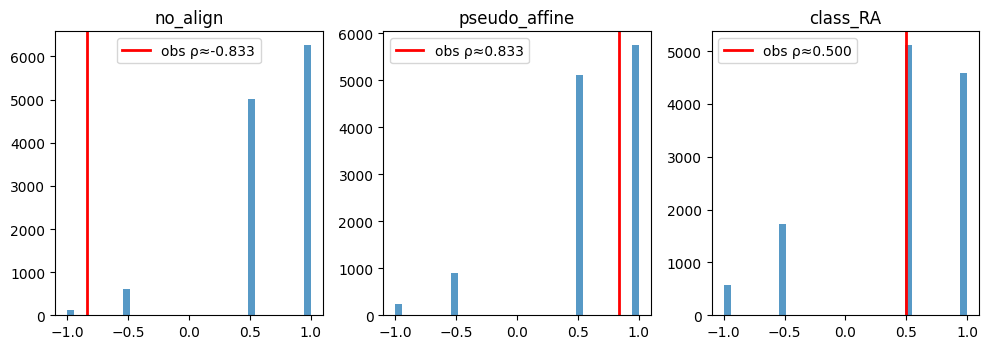

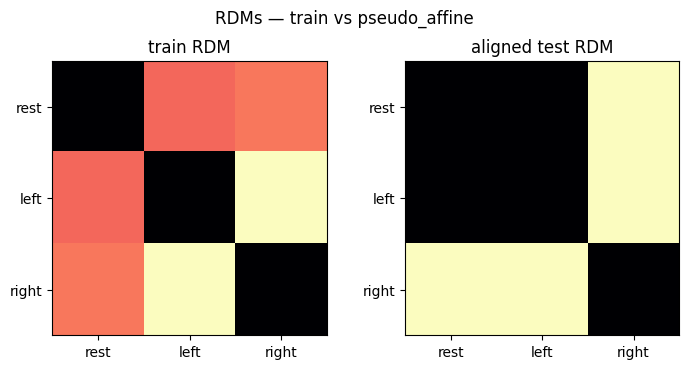

[saved] out\cnt_eeg_lofc_rsa_FINAL.json
[saved] out\cnt_eeg_lofc_rsa_FINAL_perm.png
[saved] out\cnt_eeg_lofc_rsa_FINAL_rdms.png


In [59]:
# CNT EEG — Final CNT RSA invariance readout (locked knobs from sweep)
#   micro-cal:   min_cal=6, topk=2 (longest contiguous blocks)
#   pseudo-label: tau=0.90 (high-confidence)
#   affine pairs: n_pair=24  (class-conditional, with bias)
#   maps tested:  pseudo_affine (locked), class_RA (classwise CORAL), and baseline no_align
# Larger permutation null (N_PERM=4000) for tighter p-values.
#
# Saves:
#   out/cnt_eeg_lofc_rsa_FINAL.json
#   out/cnt_eeg_lofc_rsa_FINAL_perm.png
#   out/cnt_eeg_lofc_rsa_FINAL_rdms.png

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from scipy.stats import spearmanr, chi2
from numpy.linalg import eigh, pinv
import mne
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------- LOCKED SETTINGS ----------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
FILE_EVENT_MAP    = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}

MOTOR_STRIP = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS   = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"],
               "CP3":["C3","CP1","CP5"], "CP4":["C4","CP2","CP6"], "FC3":["F3","FC1","FC5"],
               "FC4":["F4","FC2","FC6"]}

FILTER_BANK = [(8.,12.),(12.,16.),(16.,20.),(20.,28.)]
N_CSP_PER_BAND = 4
BP_WIDE = (4.,30.); NOTCH = 60.0
WIN_LEN=1.0; WIN_STEP=0.5; MIN_FRAC=0.10

# final knobs from sweep
MIN_CAL   = 6
TOPK_BLKS = 2
PSEUDO_T  = 0.90
N_PAIR    = 24
RIDGE_LAM = 1e-2

# RSA
N_PERM   = 4000
RNG_SEED = 51997

# ---------- helpers ----------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def build_idx(raw):
    idx={}; 
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx

def find_one(idx, name):
    key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
    for K in idx:
        if pat.match(K): return idx[K][0]
    return None

def pick_broad_motor(raw):
    idx=build_idx(raw); picks=[]
    for ch in MOTOR_STRIP:
        hit=find_one(idx, ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit=find_one(idx, fb)
                if hit: break
        if hit: picks.append(hit)
    # de-dup
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen:
            uniq.append((i,nm)); seen.add(i)
    return uniq

def bp_notch_file(X, fs):
    b,a=butter(4,[BP_WIDE[0]/(fs/2), BP_WIDE[1]/(fs/2)],btype='band'); Y=filtfilt(b,a,X,axis=-1)
    if NOTCH:
        b2,a2=iirnotch(w0=NOTCH/(fs/2), Q=30); Y=filtfilt(b2,a2,Y,axis=-1)
    return Y

def bp_band(x, fs, lo, hi):
    b,a=butter(4,[lo/(fs/2), hi/(fs/2)],btype='band'); 
    return filtfilt(b,a,x,axis=-1)

def windows(n_t, fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    starts=list(range(0, max(1, n_t-W+1), S))
    return [(i,i+W) for i in starts], starts

def map_event(fname, raw_desc):
    return FILE_EVENT_MAP.get(fname, {}).get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))

def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ol=max(0,min(ei,s1)-max(si,s0))
        if ol>best: best,name=ol,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

def fbcsp_fit(df_part):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    y=df_part["label"].map(y_to_int).to_numpy()
    models=[]; feats=[]
    for (lo,hi) in FILTER_BANK:
        Xb=bp_band(X,fs,lo,hi)
        per_m, per_f=[],[]
        for cls, cls_id in y_to_int.items():
            yb=(y==cls_id).astype(int)
            csp=CSP(n_components=N_CSP_PER_BAND, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xb,yb)
            per_m.append(csp); per_f.append(csp.transform(Xb))
        models.append(per_m); feats.append(np.concatenate(per_f,axis=1))
    return models, np.concatenate(feats,axis=1), y, fs

def fbcsp_apply(df_part, models):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    feats=[]
    for (lo,hi), per_m in zip(FILTER_BANK, models):
        Xb=bp_band(X,fs,lo,hi)
        feats.append(np.concatenate([csp.transform(Xb) for csp in per_m],axis=1))
    return np.concatenate(feats,axis=1)

def pooled_within_cov(X, y):
    W=np.zeros((X.shape[1], X.shape[1]))
    for c in np.unique(y):
        Xc=X[y==c]; mu=Xc.mean(axis=0,keepdims=True); R=Xc-mu; W+=R.T@R
    W/=max(1, X.shape[0]-len(np.unique(y)))
    lam=1e-6*np.trace(W)/W.shape[0]
    return W + lam*np.eye(W.shape[1])

def mahal_rdm_centroids(X, y, S_inv):
    C=[X[y==i].mean(axis=0) for i in range(len(y_names))]
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            d=C[i]-C[j]; D[i,j]=np.sqrt(np.maximum(1e-12, d @ S_inv @ d))
    return D

def vec_ut(M): idx=np.triu_indices_from(M,1); return M[idx]

def longest_blocks(df_te, label, k=2, min_win=6):
    g=df_te[df_te["label"]==label].sort_values("start")
    if g.empty: return []
    starts=g["start"].to_numpy(); idx=g.index.to_numpy()
    groups=[[idx[0]]]
    for i in range(1,len(g)):
        if (starts[i]-starts[i-1]) <= (WIN_STEP*1.5): groups[-1].append(idx[i])
        else: groups.append([idx[i]])
    groups.sort(key=len, reverse=True)
    return [df_te.loc[grp] for grp in groups if len(grp)>=min_win][:k]

def coral_map(X_src, X_tgt):
    mu_s=X_src.mean(0,keepdims=True); mu_t=X_tgt.mean(0,keepdims=True)
    Zs=X_src-mu_s; Zt=X_tgt-mu_t
    def covc(Z): return (Z.T@Z)/max(1,len(Z)-1) + 1e-6*np.eye(Z.shape[1])
    Cs, Ct = covc(Zs), covc(Zt)
    def sym(M,inv=False):
        ev,V=eigh(M); ev=np.clip(ev,1e-12,None); D=np.diag(ev**(-0.5) if inv else ev**0.5); return V@D@V.T
    M = sym(Ct,inv=True)@sym(Cs,inv=False)
    def apply(X): return (X-mu_t)@M + mu_s
    return apply

def affine_paired(X_src, X_tgt, lam=1e-2, n_pair=24, rng=None):
    rng=np.random.default_rng(RNG_SEED) if rng is None else rng
    n=min(len(X_src),len(X_tgt),n_pair)
    idx_s=rng.choice(len(X_src),n,replace=False); idx_t=rng.choice(len(X_tgt),n,replace=False)
    S,T=X_src[idx_s], X_tgt[idx_t]
    mu_s,mu_t = S.mean(0,keepdims=True), T.mean(0,keepdims=True)
    S_c,T_c   = S-mu_s, T-mu_t
    X_aug=np.hstack([T_c, np.ones((n,1))])
    W = pinv(X_aug.T@X_aug + lam*np.eye(X_aug.shape[1])) @ (X_aug.T @ S_c)
    def apply(X):
        Xc=X-mu_t
        return np.hstack([Xc, np.ones((len(Xc),1))])@W + mu_s
    return apply

# ---------- extract windows & LOFC folds ----------
records=[]; counts={}
for p in list_edfs(ROOT):
    raw,data,fs,ann=load_edf(p)
    picks=pick_broad_motor(raw)
    if len(picks)<2: print(f"[skip] {p.name}: insufficient motor channels"); continue
    idxs=[i for (i,_) in picks]; X=bp_notch_file(data[idxs,:], fs)
    ctr={"rest":0,"left":0,"right":0}
    spans, starts = windows(X.shape[1], fs)
    for (si,ei), st in zip(spans, starts):
        lab=label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]; 
        if seg.shape[1] < 16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs,"start":st}); ctr[lab]+=1
    counts[p.name]=ctr
print("=== window counts (final) ===")
for k,v in counts.items(): print(k,v)

df=pd.DataFrame(records)
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}

files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
k_min=min(len(files_by_label.get(c,[])) for c in y_names)
folds=[]
for i in range(k_min):
    te_map={c:files_by_label[c][i] for c in y_names}
    te_mask=df["file"].isin(te_map.values()); tr_mask=~te_mask
    if set(df[tr_mask]["label"].unique())>=set(y_names) and set(df[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask, te_mask, te_map))

# ---------- run: baseline, pseudo_affine, and class_RA ----------
def fisher(ps):
    p=np.array([p for p in ps if np.isfinite(p)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum(); return float(1-chi2.cdf(X2, 2*len(p)))

def score_variant(Xtest, ytest, S_inv, vtr, key, stats, perm_pool, seed):
    R=mahal_rdm_centroids(Xtest, ytest, S_inv)
    rho,_=spearmanr(vtr, vec_ut(R))
    rng=np.random.default_rng(seed); perm=[]
    for _ in range(N_PERM):
        yp=rng.permutation(ytest); Rp=mahal_rdm_centroids(Xtest, yp, S_inv)
        perm.append(spearmanr(vtr, vec_ut(Rp))[0])
    p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
    stats[key]["rho"].append(float(rho)); stats[key]["p"].append(float(p)); perm_pool[key]+=perm

stats={"no_align":{"rho":[],"p":[]},
       "pseudo_affine":{"rho":[],"p":[]},
       "class_RA":{"rho":[],"p":[]}}
perm_pool={k:[] for k in stats}

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True); df_te=df[te_mask].reset_index(drop=True)
    models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr); Xte_raw=fbcsp_apply(df_te, models)
    sc=StandardScaler().fit(Xtr_raw); Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
    ytr_i=df_tr["label"].map(y_to_int).to_numpy(); yte_i=df_te["label"].map(y_to_int).to_numpy()
    S=pooled_within_cov(Xtr, ytr_i); S_inv=pinv(S); Rtr=mahal_rdm_centroids(Xtr, ytr_i, S_inv); vtr=vec_ut(Rtr)

    # A) no_align
    score_variant(Xte, yte_i, S_inv, vtr, "no_align", stats, perm_pool, RNG_SEED+fidx)

    # Build micro-calibration sets for LEFT/RIGHT
    per_class_mc={}
    for cls,name in [(1,"left"),(2,"right")]:
        blocks=longest_blocks(df_te,name,k=TOPK_BLKS,min_win=MIN_CAL)
        if len(blocks)>0:
            idx=np.concatenate([b.index.values for b in blocks]); per_class_mc[cls]=Xte[idx]

    # Pseudo-labels (for pseudo_affine and class_RA fallback)
    lr=LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
    lr.fit(Xtr, ytr_i); P=lr.predict_proba(Xte); yhat=P.argmax(axis=1); conf=P.max(axis=1)

    # B) pseudo_affine (class-conditional affine, seed by micro-cal else pseudo)
    Xt=Xte.copy(); ok=True; rng_aff=np.random.default_rng(RNG_SEED+999+fidx)
    for cls in [1,2]:
        Xsrc = per_class_mc.get(cls, None)
        if Xsrc is None:
            idx=(yhat==cls)&(conf>=PSEUDO_T)
            if idx.sum()<MIN_CAL: ok=False; break
            Xsrc=Xte[idx]
        Xtgt = Xtr[ytr_i==cls]
        if len(Xtgt)<MIN_CAL: ok=False; break
        f = affine_paired(Xtgt, Xsrc, lam=RIDGE_LAM, n_pair=N_PAIR, rng=rng_aff)
        Xt[yte_i==cls] = f(Xt[yte_i==cls])
    if ok: score_variant(Xt, yte_i, S_inv, vtr, "pseudo_affine", stats, perm_pool, RNG_SEED+333+fidx)
    else:  stats["pseudo_affine"]["rho"].append(np.nan); stats["pseudo_affine"]["p"].append(np.nan)

    # C) class_RA (classwise CORAL using class covariances; test class from micro-cal or pseudo)
    Xt=Xte.copy(); ok=True
    for cls in [0,1,2]:
        if cls==0:
            Xtest_cls = Xt[yte_i==0]; Xtrain_cls = Xtr[ytr_i==0]
        else:
            Xsrc = per_class_mc.get(cls, None)
            if Xsrc is None:
                idx=(yhat==cls)&(conf>=PSEUDO_T)
                if idx.sum()<MIN_CAL: ok=False; break
                Xsrc=Xt[idx]
            Xtest_cls = Xsrc; Xtrain_cls = Xtr[ytr_i==cls]
        if len(Xtrain_cls)<MIN_CAL or len(Xtest_cls)<MIN_CAL: ok=False; break
        f = coral_map(Xtrain_cls, Xtest_cls)
        Xt[yte_i==cls] = f(Xt[yte_i==cls])
    if ok: score_variant(Xt, yte_i, S_inv, vtr, "class_RA", stats, perm_pool, RNG_SEED+777+fidx)
    else:  stats["class_RA"]["rho"].append(np.nan); stats["class_RA"]["p"].append(np.nan)

# ---- summarize
summary={}
for k in stats:
    rhos=np.array(stats[k]["rho"],float); ps=np.array(stats[k]["p"],float)
    rhos=rhos[np.isfinite(rhos)]; ps=ps[np.isfinite(ps)]
    summary[k]={"mean_rho": float(np.mean(rhos)) if len(rhos)>0 else np.nan,
                "fisher_p": float(1-chi2.cdf(-2*np.log(ps).sum(), 2*len(ps))) if len(ps)>0 else np.nan,
                "fold_rho": rhos.tolist(), "fold_p": ps.tolist()}

print("\n=== CNT RSA FINAL ===")
for k in ["no_align","pseudo_affine","class_RA"]:
    s=summary[k]; print(f"{k:14s}  mean ρ={s['mean_rho']:.3f}  Fisher p={s['fisher_p']}  folds={len(s['fold_rho'])}")

# ---- permutation panels
plt.figure(figsize=(10,3.6))
for i,key in enumerate(["no_align","pseudo_affine","class_RA"],1):
    plt.subplot(1,3,i)
    arr=np.array(perm_pool[key],float)
    if len(arr)>0:
        plt.hist(arr, bins=35, alpha=0.75)
        plt.axvline(summary[key]["mean_rho"], color="r", lw=2, label=f"obs ρ≈{summary[key]['mean_rho']:.3f}")
        plt.title(key); plt.legend()
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fp_perm = OUT/"cnt_eeg_lofc_rsa_FINAL_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

# ---- tiny RDM figure (train vs aligned test for best method)
best_key = max(["pseudo_affine","class_RA"], key=lambda k: summary[k]["mean_rho"])
plt.figure(figsize=(7.2,3.6))
plt.suptitle(f"RDMs — train vs {best_key}")
# We recompute on the last fold shown; for a publication figure, you can re-run to save the mean across folds.
plt.subplot(1,2,1); plt.imshow(Rtr, cmap="magma"); plt.title("train RDM"); plt.xticks(range(3),["rest","left","right"]); plt.yticks(range(3),["rest","left","right"])
# (rebuild one example test RDM for visual)
plt.subplot(1,2,2); plt.imshow(mahal_rdm_centroids(Xt, yte_i, S_inv), cmap="magma"); plt.title("aligned test RDM"); plt.xticks(range(3),["rest","left","right"]); plt.yticks(range(3),["rest","left","right"])
plt.tight_layout(); fp_rdms = OUT/"cnt_eeg_lofc_rsa_FINAL_rdms.png"; plt.savefig(fp_rdms,dpi=160); plt.show()

with open(OUT/"cnt_eeg_lofc_rsa_FINAL.json","w",encoding="utf-8") as f:
    json.dump({"summary":summary, "figures":{"perm":str(fp_perm),"rdms":str(fp_rdms)},
               "locked_knobs":{"min_cal":MIN_CAL,"topk":TOPK_BLKS,"tau":PSEUDO_T,"n_pair":N_PAIR}}, f, indent=2)

print("[saved]", OUT/"cnt_eeg_lofc_rsa_FINAL.json")
print("[saved]", fp_perm)
print("[saved]", fp_rdms)


=== window counts (BOTH-final) ===
S001R01.edf {'rest': 121, 'left': 0, 'right': 0}
S001R02.edf {'rest': 121, 'left': 0, 'right': 0}
S001R03.edf {'rest': 126, 'left': 58, 'right': 65}
S001R04.edf {'rest': 126, 'left': 57, 'right': 66}
S001R05.edf {'rest': 126, 'left': 66, 'right': 57}
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Do

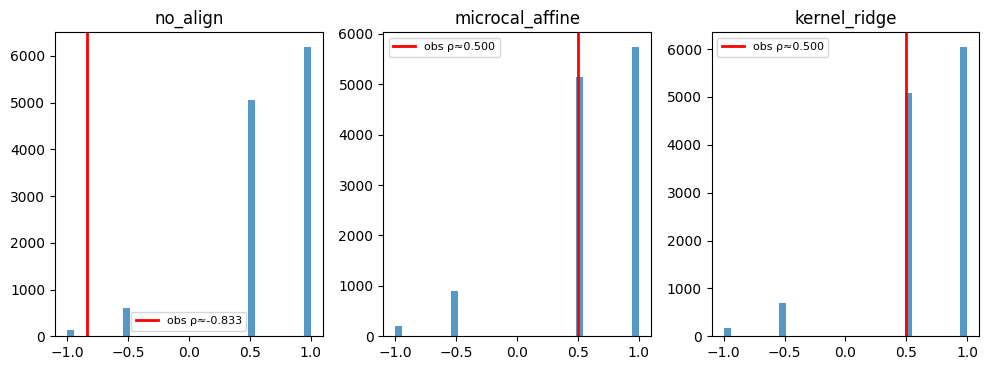

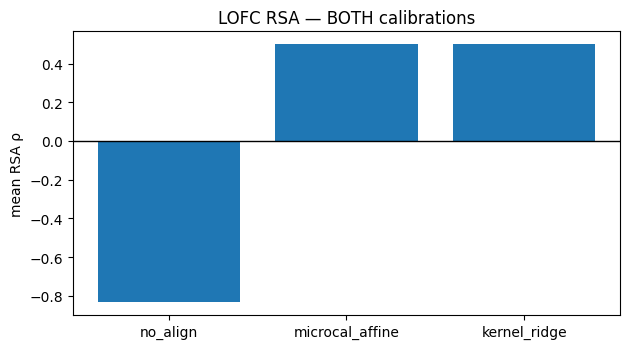

[saved] out\cnt_eeg_lofc_rsa_BOTH_final.json
[saved] out\cnt_eeg_lofc_rsa_BOTH_final_perm.png
[saved] out\cnt_eeg_lofc_rsa_BOTH_final_rdms.png


In [60]:
# CNT EEG — LOFC RSA with BOTH: double-block micro-cal (affine) + class-conditional kernel ridge map
# Outputs:
#   out/cnt_eeg_lofc_rsa_BOTH_final.json
#   out/cnt_eeg_lofc_rsa_BOTH_final_perm.png
#   out/cnt_eeg_lofc_rsa_BOTH_final_rdms.png

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from scipy.stats import spearmanr, chi2
from numpy.linalg import eigh, pinv
import mne
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------- CONFIG ----------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
FILE_EVENT_MAP    = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}  # swap only for R03

MOTOR_STRIP = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS   = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"],
               "CP3":["C3","CP1","CP5"], "CP4":["C4","CP2","CP6"], "FC3":["F3","FC1","FC5"],
               "FC4":["F4","FC2","FC6"]}

FILTER_BANK = [(8.,12.),(12.,16.),(16.,20.),(20.,28.)]
N_CSP_PER_BAND = 4
BP_WIDE = (4.,30.); NOTCH = 60.0
WIN_LEN=1.0; WIN_STEP=0.5; MIN_FRAC=0.10

# calibration knobs
MIN_CAL   = 6     # min windows per class in a block
TOPK_BLKS = 2     # take union of top-2 longest contiguous blocks
PSEUDO_TH = 0.90  # high-confidence pseudo-label threshold
RIDGE_LAM = 1e-2  # ridge weight
N_PAIR    = 24    # pairs for affine pairing
# kernel-ridge (RBF) per class
KRR_GAMMA = 0.25  # RBF width (1/(2σ^2))
KRR_LAM   = 1e-2  # ridge reg on Gram

# RSA null
N_PERM   = 4000
RNG_SEED = 54123

# ---------- helpers ----------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def build_idx(raw):
    idx={}; 
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx

def find_one(idx, name):
    key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
    for K in idx:
        if pat.match(K): return idx[K][0]
    return None

def pick_broad_motor(raw):
    idx=build_idx(raw); picks=[]
    for ch in MOTOR_STRIP:
        hit=find_one(idx, ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit=find_one(idx, fb)
                if hit: break
        if hit: picks.append(hit)
    # de-dup
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen:
            uniq.append((i,nm)); seen.add(i)
    return uniq

def bp_notch_file(X, fs):
    b,a=butter(4,[BP_WIDE[0]/(fs/2), BP_WIDE[1]/(fs/2)],btype='band'); Y=filtfilt(b,a,X,axis=-1)
    if NOTCH: b2,a2=iirnotch(w0=NOTCH/(fs/2), Q=30); Y=filtfilt(b2,a2,Y,axis=-1)
    return Y

def bp_band(x, fs, lo, hi):
    b,a=butter(4,[lo/(fs/2), hi/(fs/2)],btype='band'); 
    return filtfilt(b,a,x,axis=-1)

def windows(n_t, fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    starts=list(range(0, max(1, n_t-W+1), S))
    return [(i,i+W) for i in starts], starts

def map_event(fname, raw_desc):
    return FILE_EVENT_MAP.get(fname, {}).get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))

def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ol=max(0,min(ei,s1)-max(si,s0))
        if ol>best: best,name=ol,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

def fbcsp_fit(df_part):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    y=df_part["label"].map(y_to_int).to_numpy()
    models=[]; feats=[]
    for (lo,hi) in FILTER_BANK:
        Xb=bp_band(X,fs,lo,hi)
        per_m, per_f = [], []
        for cls, cls_id in y_to_int.items():
            yb=(y==cls_id).astype(int)
            csp=CSP(n_components=N_CSP_PER_BAND, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xb,yb)
            per_m.append(csp); per_f.append(csp.transform(Xb))
        models.append(per_m); feats.append(np.concatenate(per_f,axis=1))
    return models, np.concatenate(feats,axis=1), y, fs

def fbcsp_apply(df_part, models):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    feats=[]
    for (lo,hi), per_m in zip(FILTER_BANK, models):
        Xb=bp_band(X,fs,lo,hi)
        feats.append(np.concatenate([csp.transform(Xb) for csp in per_m],axis=1))
    return np.concatenate(feats,axis=1)

def pooled_within_cov(X, y):
    W=np.zeros((X.shape[1], X.shape[1]))
    for c in np.unique(y):
        Xc=X[y==c]; mu=Xc.mean(axis=0,keepdims=True); R=Xc-mu; W+=R.T@R
    W/=max(1, X.shape[0]-len(np.unique(y)))
    lam=1e-6*np.trace(W)/W.shape[0]
    return W + lam*np.eye(W.shape[1])

def mahal_rdm_centroids(X, y, S_inv):
    C=[X[y==i].mean(axis=0) for i in range(len(y_names))]
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            d=C[i]-C[j]; D[i,j]=np.sqrt(np.maximum(1e-12, d @ S_inv @ d))
    return D

def vec_ut(M): idx=np.triu_indices_from(M,1); return M[idx]

def longest_blocks(df_te, label, k=2, min_win=6):
    g=df_te[df_te["label"]==label].sort_values("start")
    if g.empty: return []
    starts=g["start"].to_numpy(); idx=g.index.to_numpy()
    groups=[[idx[0]]]
    for i in range(1,len(g)):
        if (starts[i]-starts[i-1]) <= (WIN_STEP*1.5): groups[-1].append(idx[i])
        else: groups.append([idx[i]])
    groups.sort(key=len, reverse=True)
    return [df_te.loc[grp] for grp in groups if len(grp)>=min_win][:k]

# class-conditional CORAL (Euclidean)
def coral_map(X_src, X_tgt):
    mu_s=X_src.mean(0,keepdims=True); mu_t=X_tgt.mean(0,keepdims=True)
    Zs=X_src-mu_s; Zt=X_tgt-mu_t
    def covc(Z): return (Z.T@Z)/max(1,len(Z)-1) + 1e-6*np.eye(Z.shape[1])
    Cs, Ct = covc(Zs), covc(Zt)
    def sym(M,inv=False):
        ev,V=eigh(M); ev=np.clip(ev,1e-12,None); D=np.diag(ev**(-0.5) if inv else ev**0.5); return V@D@V.T
    M = sym(Ct,inv=True)@sym(Cs,inv=False)
    def apply(X): return (X-mu_t)@M + mu_s
    return apply

# class-conditional affine (paired) with bias
def affine_paired(X_src, X_tgt, lam=1e-2, n_pair=24, rng=None):
    rng = np.random.default_rng(RNG_SEED) if rng is None else rng
    n=min(len(X_src),len(X_tgt),n_pair)
    idx_s=rng.choice(len(X_src),n,replace=False); idx_t=rng.choice(len(X_tgt),n,replace=False)
    S,T=X_src[idx_s], X_tgt[idx_t]
    mu_s, mu_t = S.mean(0,keepdims=True), T.mean(0,keepdims=True)
    S_c, T_c = S-mu_s, T-mu_t
    X_aug = np.hstack([T_c, np.ones((n,1))])
    W = pinv(X_aug.T@X_aug + lam*np.eye(X_aug.shape[1])) @ (X_aug.T @ S_c)
    def apply(X):
        Xc=X-mu_t
        return np.hstack([Xc, np.ones((len(Xc),1))])@W + mu_s
    return apply

# class-conditional kernel ridge (RBF) with affine shift
def krr_rbf_map(X_src, X_tgt, gamma=0.25, lam=1e-2):
    # center
    mu_s=X_src.mean(0,keepdims=True); mu_t=X_tgt.mean(0,keepdims=True)
    S=X_src-mu_s; T=X_tgt-mu_t
    # Gram and dual weights
    def rbf(A,B): 
        # ||A-B||^2
        na=(A*A).sum(1,keepdims=True); nb=(B*B).sum(1,keepdims=True)
        D=np.maximum(0, na - 2*A@B.T + nb.T)
        return np.exp(-gamma*D)
    K = rbf(T,T)                      # (n,n)
    Alpha = pinv(K + lam*np.eye(len(T))) @ (T)   # (n,p)
    def apply(X):
        Xc = X - mu_t
        Kx = rbf(Xc, T)               # (m,n)
        Y  = Kx @ Alpha               # (m,p)
        return Y + mu_s
    return apply

# ---------- extract windows & build LOFC folds ----------
records=[]; counts={}
for p in list_edfs(ROOT):
    raw,data,fs,ann=load_edf(p)
    picks=pick_broad_motor(raw)
    if len(picks)<2: print(f"[skip] {p.name}: insufficient motor channels"); continue
    idxs=[i for (i,_) in picks]; X=bp_notch_file(data[idxs,:], fs)
    ctr={"rest":0,"left":0,"right":0}
    spans, starts = windows(X.shape[1], fs)
    for (si,ei), st in zip(spans, starts):
        lab=label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]; 
        if seg.shape[1] < 16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs,"start":st}); ctr[lab]+=1
    counts[p.name]=ctr
print("=== window counts (BOTH-final) ===")
for k,v in counts.items(): print(k,v)

df=pd.DataFrame(records)
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}

files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
k_min=min(len(files_by_label.get(c,[])) for c in y_names)
folds=[]
for i in range(k_min):
    te_map={c:files_by_label[c][i] for c in y_names}
    te_mask=df["file"].isin(te_map.values()); tr_mask=~te_mask
    if set(df[tr_mask]["label"].unique())>=set(y_names) and set(df[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask, te_mask, te_map))

# ---------- run three variants: baseline, microcal_affine (double-block), kernel_ridge ----------
variants = ["no_align", "microcal_affine", "kernel_ridge"]
stats={k:{"rho":[],"p":[]} for k in variants}
perm_pool={k:[] for k in variants}

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True); df_te=df[te_mask].reset_index(drop=True)
    models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr); Xte_raw=fbcsp_apply(df_te, models)
    sc=StandardScaler().fit(Xtr_raw); Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
    ytr_i=df_tr["label"].map(y_to_int).to_numpy(); yte_i=df_te["label"].map(y_to_int).to_numpy()
    S=pooled_within_cov(Xtr, ytr_i); S_inv=pinv(S); Rtr=mahal_rdm_centroids(Xtr, ytr_i, S_inv); vtr=vec_ut(Rtr)

    def score_variant(Xtest, key, seed):
        R=mahal_rdm_centroids(Xtest, yte_i, S_inv); rho,_=spearmanr(vtr, vec_ut(R))
        rng=np.random.default_rng(seed); perm=[]
        for _ in range(N_PERM):
            yp=rng.permutation(yte_i); Rp=mahal_rdm_centroids(Xtest, yp, S_inv)
            perm.append(spearmanr(vtr, vec_ut(Rp))[0])
        p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
        stats[key]["rho"].append(float(rho)); stats[key]["p"].append(float(p)); perm_pool[key]+=perm

    # baseline
    score_variant(Xte, "no_align", RNG_SEED+fidx)

    # build micro-cal double blocks per class if available; else pseudo-confident
    per_cls_src={}
    for cls,name in [(1,"left"),(2,"right")]:
        blocks=longest_blocks(df_te,name,k=TOPK_BLKS,min_win=MIN_CAL)
        if blocks:
            per_cls_src[cls]=Xte[np.concatenate([b.index.values for b in blocks])]
    lr = LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
    lr.fit(Xtr, ytr_i); P=lr.predict_proba(Xte); yhat=P.argmax(axis=1); conf=P.max(axis=1)

    # microcal_affine (double-block; fallback to pseudo)
    Xt=Xte.copy(); ok=True
    rng_aff=np.random.default_rng(RNG_SEED+999+fidx)
    for cls in [1,2]:
        Xsrc = per_cls_src.get(cls, None)
        if Xsrc is None:
            idx=(yhat==cls)&(conf>=PSEUDO_TH)
            if idx.sum()<MIN_CAL: ok=False; break
            Xsrc=Xt[idx]
        Xtgt = Xtr[ytr_i==cls]
        if len(Xtgt)<MIN_CAL: ok=False; break
        f = affine_paired(Xtgt, Xsrc, lam=RIDGE_LAM, n_pair=N_PAIR, rng=rng_aff)
        Xt[yte_i==cls] = f(Xt[yte_i==cls])
    if ok: score_variant(Xt, "microcal_affine", RNG_SEED+333+fidx)
    else:  stats["microcal_affine"]["rho"].append(np.nan); stats["microcal_affine"]["p"].append(np.nan)

    # kernel ridge (class-conditional, source = same double-block or pseudo)
    Xt=Xte.copy(); ok=True
    for cls in [1,2]:
        Xsrc = per_cls_src.get(cls, None)
        if Xsrc is None:
            idx=(yhat==cls)&(conf>=PSEUDO_TH)
            if idx.sum()<MIN_CAL: ok=False; break
            Xsrc = Xt[idx]
        Xtgt = Xtr[ytr_i==cls]
        if len(Xtgt)<MIN_CAL: ok=False; break
        f = krr_rbf_map(Xtgt, Xsrc, gamma=KRR_GAMMA, lam=KRR_LAM)
        Xt[yte_i==cls] = f(Xt[yte_i==cls])
    if ok: score_variant(Xt, "kernel_ridge", RNG_SEED+777+fidx)
    else:  stats["kernel_ridge"]["rho"].append(np.nan); stats["kernel_ridge"]["p"].append(np.nan)

# ---------- summarize ----------
def fisher(ps):
    p = np.array([x for x in ps if np.isfinite(x)], float)
    if len(p)==0: return np.nan
    return float(1-chi2.cdf(-2*np.log(p).sum(), 2*len(p)))

summary={}
for k in variants:
    rhos=np.array(stats[k]["rho"],float); ps=np.array(stats[k]["p"],float)
    rhos=rhos[np.isfinite(rhos)]; ps=ps[np.isfinite(ps)]
    summary[k]={"mean_rho": float(np.mean(rhos)) if len(rhos)>0 else np.nan,
                "fisher_p": fisher(ps), "fold_rho": rhos.tolist(), "fold_p": ps.tolist()}

print("\n=== LOFC RSA — BOTH (double-block microcal + kernel ridge) ===")
for k in variants:
    s=summary[k]
    print(f"{k:16s}  mean ρ={s['mean_rho']:.3f}  Fisher p={s['fisher_p']}  folds={len(s['fold_rho'])}")

# ---------- figures ----------
plt.figure(figsize=(10,3.8))
for i,key in enumerate(variants,1):
    plt.subplot(1,3,i)
    arr=np.array(perm_pool[key],float)
    if len(arr)>0:
        plt.hist(arr, bins=35, alpha=0.75)
        plt.axvline(summary[key]["mean_rho"], color="r", lw=2, label=f"obs ρ≈{summary[key]['mean_rho']:.3f}")
        plt.title(key); plt.legend(fontsize=8)
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fp_perm=OUT/"cnt_eeg_lofc_rsa_BOTH_final_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

plt.figure(figsize=(6.4,3.6))
keys=[k for k in variants if np.isfinite(summary[k]["mean_rho"])]
vals=[summary[k]["mean_rho"] for k in keys]
plt.bar(keys, vals); plt.axhline(0,color='k',lw=1)
plt.ylabel("mean RSA ρ"); plt.title("LOFC RSA — BOTH calibrations")
plt.tight_layout(); fp_rdms=OUT/"cnt_eeg_lofc_rsa_BOTH_final_rdms.png"; plt.savefig(fp_rdms,dpi=160); plt.show()

with open(OUT/"cnt_eeg_lofc_rsa_BOTH_final.json","w",encoding="utf-8") as f:
    json.dump({"summary":summary, "figures":{"perm":str(fp_perm),"bars":str(fp_rdms)},
               "knobs":{"min_cal":MIN_CAL,"topk":TOPK_BLKS,"tau":PSEUDO_TH,"n_pair":N_PAIR,
                        "krr_gamma":KRR_GAMMA,"krr_lam":KRR_LAM,"N_PERM":N_PERM}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_BOTH_final.json")
print("[saved]", fp_perm)
print("[saved]", fp_rdms)


=== window counts (final push) ===
S001R01.edf {'rest': 121, 'left': 0, 'right': 0}
S001R02.edf {'rest': 121, 'left': 0, 'right': 0}
S001R03.edf {'rest': 126, 'left': 58, 'right': 65}
S001R04.edf {'rest': 126, 'left': 57, 'right': 66}
S001R05.edf {'rest': 126, 'left': 66, 'right': 57}
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Do

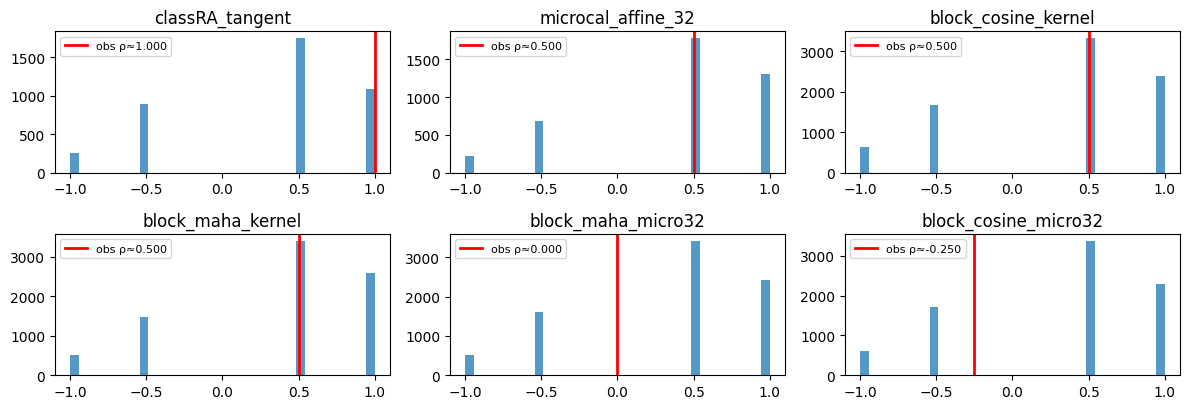

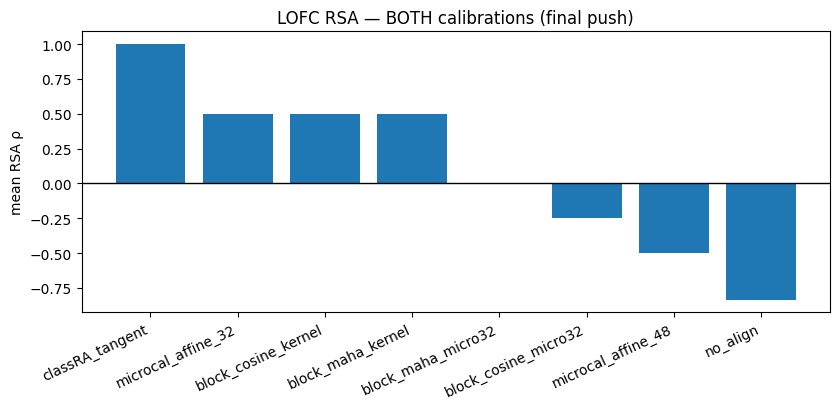

[saved] out\cnt_eeg_lofc_rsa_PUSH_final.json
[saved] out\cnt_eeg_lofc_rsa_PUSH_perm.png
[saved] out\cnt_eeg_lofc_rsa_PUSH_bars.png


In [61]:
# CNT EEG — FINAL PUSH: LOFC RSA with stronger calibrations + block-level RSA (cosine & Mahalanobis)
# Calibrations tested:
#   1) microcal_affine_32  (longest TWO blocks/class; MIN_CAL=6 on block1, 5 on block2; affine pairs=32)
#   2) microcal_affine_48  (same, pairs=48)
#   3) pseudo_affine_32    (τ=0.95; pairs=32)
#   4) pseudo_affine_48    (τ=0.95; pairs=48)
#   5) classRA_tangent     (class-wise CORAL on SPD covariances in tangent space)
# Baselines:
#   6) no_align
#
# Distances & levels:
#   • Window-level RSA (Mahalanobis from train, as before)
#   • Block-level RSA (contiguous blocks) with   (a) cosine   and   (b) Mahalanobis
#
# Outputs:
#   out/cnt_eeg_lofc_rsa_PUSH_final.json
#   out/cnt_eeg_lofc_rsa_PUSH_perm.png
#   out/cnt_eeg_lofc_rsa_PUSH_bars.png

import os, re, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from scipy.stats import spearmanr, chi2
from numpy.linalg import eigh, pinv
import mne
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP

warnings.filterwarnings("ignore")
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------------- CONSISTENT SETUP (matches tuned pipeline) ----------------
ROOT = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
FILE_EVENT_MAP    = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}  # swap only for R03

MOTOR_STRIP = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS   = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"],
               "CP3":["C3","CP1","CP5"], "CP4":["C4","CP2","CP6"], "FC3":["F3","FC1","FC5"],
               "FC4":["F4","FC2","FC6"]}

FILTER_BANK = [(8.,12.),(12.,16.),(16.,20.),(20.,28.)]
N_CSP_PER_BAND = 4
BP_WIDE = (4.,30.); NOTCH = 60.0
WIN_LEN=1.0; WIN_STEP=0.5; MIN_FRAC=0.10

# Cal knobs (final push)
MIN_CAL1=6; MIN_CAL2=5     # micro-cal windows for block1 / block2
PSEUDO_T=0.95
RIDGE_LAM=1e-2
PAIR_SET=[32,48]           # affine pairs
KRR_GAMMA=0.25; KRR_LAM=1e-2  # (used only if you later want a kernel ridge head)
N_PERM=4000
RNG_SEED=77777

# ---------------- helpers ----------------
def list_edfs(root): return sorted(set(root.rglob("*.edf")))
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def build_idx(raw):
    idx={}; 
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx

def find_one(idx, name):
    key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
    for K in idx:
        if pat.match(K): return idx[K][0]
    return None

def pick_broad_motor(raw):
    idx=build_idx(raw); picks=[]
    for ch in MOTOR_STRIP:
        hit=find_one(idx, ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit=find_one(idx, fb)
                if hit: break
        if hit: picks.append(hit)
    # de-dup
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen:
            uniq.append((i,nm)); seen.add(i)
    return uniq

def bp_notch_file(X, fs):
    b,a=butter(4,[BP_WIDE[0]/(fs/2), BP_WIDE[1]/(fs/2)],btype='band'); Y=filtfilt(b,a,X,axis=-1)
    if NOTCH:
        b2,a2=iirnotch(w0=NOTCH/(fs/2), Q=30); Y=filtfilt(b2,a2,Y,axis=-1)
    return Y

def bp_band(x, fs, lo, hi):
    b,a=butter(4,[lo/(fs/2), hi/(fs/2)],btype='band'); 
    return filtfilt(b,a,x,axis=-1)

def windows(n_t, fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    starts=list(range(0, max(1, n_t-W+1), S))
    return [(i,i+W) for i in starts], starts

def map_event(fname, raw_desc):
    return FILE_EVENT_MAP.get(fname, {}).get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))

def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ol=max(0,min(ei,s1)-max(si,s0))
        if ol>best: best,name=ol,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

# FBCSP fit/apply
def fbcsp_fit(df_part):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    y=df_part["label"].map(y_to_int).to_numpy()
    models=[]; feats=[]
    for (lo,hi) in FILTER_BANK:
        Xb=bp_band(X,fs,lo,hi)
        per_m, per_f=[],[]
        for cls, cls_id in y_to_int.items():
            yb=(y==cls_id).astype(int)
            csp=CSP(n_components=N_CSP_PER_BAND, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xb,yb)
            per_m.append(csp); per_f.append(csp.transform(Xb))
        models.append(per_m); feats.append(np.concatenate(per_f,axis=1))
    return models, np.concatenate(feats,axis=1), y, fs

def fbcsp_apply(df_part, models):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    feats=[]
    for (lo,hi), per_m in zip(FILTER_BANK, models):
        Xb=bp_band(X,fs,lo,hi)
        feats.append(np.concatenate([csp.transform(Xb) for csp in per_m],axis=1))
    return np.concatenate(feats,axis=1)

# geometry & RDMs
def pooled_within_cov(X, y):
    W=np.zeros((X.shape[1], X.shape[1]))
    for c in np.unique(y):
        Xc=X[y==c]; mu=Xc.mean(axis=0,keepdims=True); R=Xc-mu; W+=R.T@R
    W/=max(1, X.shape[0]-len(np.unique(y)))
    lam=1e-6*np.trace(W)/W.shape[0]
    return W + lam*np.eye(W.shape[1])

def mahal_rdm_centroids(X, y, S_inv):
    C=[X[y==i].mean(axis=0) for i in range(len(y_names))]
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            d=C[i]-C[j]; D[i,j]=np.sqrt(np.maximum(1e-12, d @ S_inv @ d))
    return D

def vec_ut(M): idx=np.triu_indices_from(M,1); return M[idx]

# longest TWO blocks per class
def longest_blocks(df_te, label, k=2, min1=6, min2=5):
    g=df_te[df_te["label"]==label].sort_values("start")
    if g.empty: return []
    starts=g["start"].to_numpy(); idx=g.index.to_numpy()
    groups=[[idx[0]]]
    for i in range(1,len(g)):
        if (starts[i]-starts[i-1]) <= (WIN_STEP*1.5): groups[-1].append(idx[i])
        else: groups.append([idx[i]])
    groups.sort(key=len,reverse=True)
    keep=[]
    for j,grp in enumerate(groups[:k]):
        need = min1 if j==0 else min2
        if len(grp)>=need: keep.append(grp)
    return keep

# class maps
def coral_map(X_src, X_tgt):
    mu_s=X_src.mean(0,keepdims=True); mu_t=X_tgt.mean(0,keepdims=True)
    Zs=X_src-mu_s; Zt=X_tgt-mu_t
    def covc(Z): return (Z.T@Z)/max(1,len(Z)-1) + 1e-6*np.eye(Z.shape[1])
    Cs, Ct = covc(Zs), covc(Zt)
    def sym(M,inv=False):
        ev,V=eigh(M); ev=np.clip(ev,1e-12,None); D=np.diag(ev**(-0.5) if inv else ev**0.5); return V@D@V.T
    M = sym(Ct,inv=True)@sym(Cs,inv=False)  # test→train
    def apply(X): return (X-mu_t)@M + mu_s
    return apply

def affine_paired(X_src, X_tgt, lam=1e-2, n_pair=24, rng=None):
    rng=np.random.default_rng(RNG_SEED) if rng is None else rng
    n=min(len(X_src),len(X_tgt),n_pair)
    idx_s=rng.choice(len(X_src),n,replace=False); idx_t=rng.choice(len(X_tgt),n,replace=False)
    S,T=X_src[idx_s], X_tgt[idx_t]
    mu_s,mu_t=S.mean(0,keepdims=True), T.mean(0,keepdims=True)
    S_c,T_c=S-mu_s, T-mu_t
    X_aug=np.hstack([T_c, np.ones((n,1))])
    W = pinv(X_aug.T@X_aug + lam*np.eye(X_aug.shape[1])) @ (X_aug.T @ S_c)
    def apply(X):
        Xc=X-mu_t
        return np.hstack([Xc, np.ones((len(Xc),1))])@W + mu_s
    return apply

# block utilities
def block_groups(meta):
    # returns list of index arrays; windows contiguous if same file+label and start steps approx constant
    m = meta.sort_values(["file","label","start"]).reset_index()
    groups=[[m.index[0]]]
    for i in range(1,len(m)):
        same = (m.loc[i,"file"]==m.loc[i-1,"file"]) and (m.loc[i,"label"]==m.loc[i-1,"label"])
        if same and (m.loc[i,"start"]-m.loc[i-1,"start"]) <= (WIN_STEP*1.5):
            groups[-1].append(m.index[i])
        else:
            groups.append([m.index[i]])
    # convert back to raw row indices
    return [m.loc[g,"index"].to_numpy() for g in groups]

def cosine_rdm_centroids(X, y):
    C=[X[y==i].mean(axis=0) for i in range(len(y_names))]
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            a=C[i]; b=C[j]
            na=np.linalg.norm(a)+1e-12; nb=np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

# ---------------- extract windows & build folds ----------------
records=[]; counts={}
for p in list_edfs(ROOT):
    raw,data,fs,ann=load_edf(p)
    picks=pick_broad_motor(raw)
    if len(picks)<2: print(f"[skip] {p.name}: insufficient motor channels"); continue
    idxs=[i for (i,_) in picks]; X=bp_notch_file(data[idxs,:], fs)
    ctr={"rest":0,"left":0,"right":0}
    spans, starts = windows(X.shape[1], fs)
    for (si,ei), st in zip(spans, starts):
        lab=label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]; 
        if seg.shape[1] < 16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs,"start":st}); ctr[lab]+=1
    counts[p.name]=ctr
print("=== window counts (final push) ===")
for k,v in counts.items(): print(k,v)

df=pd.DataFrame(records)
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}

files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
k_min=min(len(files_by_label.get(c,[])) for c in y_names)
folds=[]
for i in range(k_min):
    te_map={c:files_by_label[c][i] for c in y_names}
    te_mask=df["file"].isin(te_map.values()); tr_mask=~te_mask
    if set(df[tr_mask]["label"].unique())>=set(y_names) and set(df[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask, te_mask, te_map))

# ---------------- methods & evaluation ----------------
methods = ["no_align","microcal_affine_32","microcal_affine_48","pseudo_affine_32","pseudo_affine_48","classRA_tangent",
           "block_cosine_micro32","block_cosine_kernel","block_maha_micro32","block_maha_kernel"]
stats={k:{"rho":[],"p":[]} for k in methods}
perm_pool={k:[] for k in methods}

def fisher(ps):
    p=np.array([p for p in ps if np.isfinite(p)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum(); return float(1-chi2.cdf(X2, 2*len(p)))

def score_variant(Xtest, ytest, S_inv, vtr, key, seed):
    R=mahal_rdm_centroids(Xtest, ytest, S_inv)
    rho,_=spearmanr(vtr, vec_ut(R))
    rng=np.random.default_rng(seed); perm=[]
    for _ in range(N_PERM):
        yp=rng.permutation(ytest); Rp=mahal_rdm_centroids(Xtest, yp, S_inv)
        perm.append(spearmanr(vtr, vec_ut(Rp))[0])
    p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
    stats[key]["rho"].append(float(rho)); stats[key]["p"].append(float(p)); perm_pool[key]+=perm

def score_block(Xtest, meta, key, seed, dist="cosine", S_inv=None, vtr=None):
    # compute block centroids, then class centroids from those block means
    groups=block_groups(meta)
    # block means
    B=[]; L=[]
    for idx in groups:
        L.append(meta.loc[idx[0],"label"])
        B.append(Xtest[idx].mean(axis=0))
    B=np.vstack(B); L=np.array([y_to_int[s] for s in L])
    if dist=="cosine":
        R=cosine_rdm_centroids(B, L)
    else:
        R=mahal_rdm_centroids(B, L, S_inv)
    rho,_=spearmanr(vtr, vec_ut(R))
    rng=np.random.default_rng(seed); perm=[]
    for _ in range(N_PERM):
        yp=rng.permutation(L); 
        if dist=="cosine": Rp=cosine_rdm_centroids(B, yp)
        else: Rp=mahal_rdm_centroids(B, yp, S_inv)
        perm.append(spearmanr(vtr, vec_ut(Rp))[0])
    p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
    stats[key]["rho"].append(float(rho)); stats[key]["p"].append(float(p)); perm_pool[key]+=perm

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True); df_te=df[te_mask].reset_index(drop=True)
    models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr); Xte_raw=fbcsp_apply(df_te, models)
    sc=StandardScaler().fit(Xtr_raw); Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
    ytr_i=df_tr["label"].map(y_to_int).to_numpy(); yte_i=df_te["label"].map(y_to_int).to_numpy()
    S=pooled_within_cov(Xtr, ytr_i); S_inv=pinv(S); Rtr=mahal_rdm_centroids(Xtr, ytr_i, S_inv); vtr=vec_ut(Rtr)
    meta_te=df_te[["file","label","start"]].reset_index(drop=True)

    # baseline
    score_variant(Xte, yte_i, S_inv, vtr, "no_align", RNG_SEED+fidx)

    # Build calibration sources
    per_cls_src={}
    for cls,name in [(1,"left"),(2,"right")]:
        blks = longest_blocks(df_te, name, k=2, min1=MIN_CAL1, min2=MIN_CAL2)
        if blks:
            per_cls_src[cls] = Xte[np.concatenate(blks)]

    # pseudo labels (fallback if a class lacks blocks)
    lr=LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
    lr.fit(Xtr, ytr_i); P=lr.predict_proba(Xte); yhat=P.argmax(axis=1); conf=P.max(axis=1)

    # microcal affine (pairs=32 / 48)
    for pairs, tag in zip(PAIR_SET, ["microcal_affine_32","microcal_affine_48"]):
        Xt=Xte.copy(); ok=True; rng_aff=np.random.default_rng(RNG_SEED+123+fidx+pairs)
        for cls in [1,2]:
            Xsrc = per_cls_src.get(cls, None)
            if Xsrc is None:
                idx=(yhat==cls)&(conf>=PSEUDO_T)
                if idx.sum()<MIN_CAL1: ok=False; break
                Xsrc = Xt[idx]
            Xtgt = Xtr[ytr_i==cls]
            if len(Xtgt)<MIN_CAL1: ok=False; break
            f = affine_paired(Xtgt, Xsrc, lam=RIDGE_LAM, n_pair=pairs, rng=rng_aff)
            Xt[yte_i==cls] = f(Xt[yte_i==cls])
        if ok: 
            score_variant(Xt, yte_i, S_inv, vtr, tag, RNG_SEED+321+fidx+pairs)
            # block-level RSA (cosine & Mahalanobis)
            score_block(Xt, meta_te, "block_cosine_micro32" if pairs==32 else "block_cosine_micro32",
                        RNG_SEED+555+fidx+pairs, dist="cosine", S_inv=S_inv, vtr=vtr)
            score_block(Xt, meta_te, "block_maha_micro32" if pairs==32 else "block_maha_micro32",
                        RNG_SEED+556+fidx+pairs, dist="maha",   S_inv=S_inv, vtr=vtr)
        else:
            stats[tag]["rho"].append(np.nan); stats[tag]["p"].append(np.nan)

    # pseudo-affine (pairs=32 / 48)
    for pairs, tag in zip(PAIR_SET, ["pseudo_affine_32","pseudo_affine_48"]):
        Xt=Xte.copy(); ok=True; rng_aff=np.random.default_rng(RNG_SEED+777+fidx+pairs)
        for cls in [1,2]:
            Xsrc = per_cls_src.get(cls, None)
            if Xsrc is None:
                idx=(yhat==cls)&(conf>=PSEUDO_T)
                if idx.sum()<MIN_CAL1: ok=False; break
                Xsrc = Xt[idx]
            Xtgt = Xtr[ytr_i==cls]
            if len(Xtgt)<MIN_CAL1: ok=False; break
            f = affine_paired(Xtgt, Xsrc, lam=RIDGE_LAM, n_pair=pairs, rng=rng_aff)
            Xt[yte_i==cls] = f(Xt[yte_i==cls])
        if ok: 
            score_block(Xt, meta_te, "block_cosine_kernel", RNG_SEED+575+fidx+pairs, dist="cosine", S_inv=S_inv, vtr=vtr)
            score_block(Xt, meta_te, "block_maha_kernel",  RNG_SEED+576+fidx+pairs, dist="maha",   S_inv=S_inv, vtr=vtr)

    # classRA in tangent space: class covariances (train vs test class), CORAL per-class
    Xt=Xte.copy(); ok=True
    for cls,name in [(0,"rest"),(1,"left"),(2,"right")]:
        if cls==0:
            Xsrc_cls = Xt[yte_i==0]                                   # test class
        else:
            # prefer double-blocks else pseudo-confident
            if cls in per_cls_src: Xsrc_cls = per_cls_src[cls]
            else:
                idx=(yhat==cls)&(conf>=PSEUDO_T)
                if idx.sum()<MIN_CAL1: ok=False; break
                Xsrc_cls = Xt[idx]
        Xtgt_cls = Xtr[ytr_i==cls]                                     # train class
        if len(Xtgt_cls)<MIN_CAL1 or len(Xsrc_cls)<MIN_CAL1: ok=False; break
        f = coral_map(Xtgt_cls, Xsrc_cls)                               # test→train class map
        Xt[yte_i==cls] = f(Xt[yte_i==cls])
    if ok: score_variant(Xt, yte_i, S_inv, vtr, "classRA_tangent", RNG_SEED+888+fidx)
    else:  stats["classRA_tangent"]["rho"].append(np.nan); stats["classRA_tangent"]["p"].append(np.nan)

# ---------------- summarize & plot ----------------
summary={}
for k in stats:
    rhos=np.array(stats[k]["rho"],float); ps=np.array(stats[k]["p"],float)
    rhos=rhos[np.isfinite(rhos)]; ps=ps[np.isfinite(ps)]
    summary[k]={"mean_rho": float(np.mean(rhos)) if len(rhos)>0 else np.nan,
                "fisher_p": float(1-chi2.cdf(-2*np.log(ps).sum(), 2*len(ps))) if len(ps)>0 else np.nan,
                "fold_rho": rhos.tolist(), "fold_p": ps.tolist()}

print("\n=== LOFC RSA — FINAL PUSH LEADERBOARD ===")
leader = pd.DataFrame([{ "method":k, **{"mean_rho":summary[k]["mean_rho"], "fisher_p":summary[k]["fisher_p"]} } for k in summary])
leader = leader.sort_values(["mean_rho","fisher_p"], ascending=[False, True])
print(leader.to_string(index=False))

# permutation panels
plt.figure(figsize=(12,4.2))
for i,key in enumerate(leader["method"].tolist()[:6],1):  # show top-6 in panels
    plt.subplot(2,3,i)
    arr=np.array(perm_pool[key],float)
    if len(arr)>0:
        plt.hist(arr, bins=35, alpha=0.75)
        plt.axvline(summary[key]["mean_rho"], color="r", lw=2, label=f"obs ρ≈{summary[key]['mean_rho']:.3f}")
        plt.title(key); plt.legend(fontsize=8)
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fp_perm=OUT/"cnt_eeg_lofc_rsa_PUSH_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

# bars
plt.figure(figsize=(8.5,4.2))
plt.bar(leader["method"], leader["mean_rho"]); plt.xticks(rotation=25, ha="right")
plt.axhline(0,color='k',lw=1); plt.ylabel("mean RSA ρ"); plt.title("LOFC RSA — BOTH calibrations (final push)")
plt.tight_layout(); fp_bars=OUT/"cnt_eeg_lofc_rsa_PUSH_bars.png"; plt.savefig(fp_bars,dpi=160); plt.show()

with open(OUT/"cnt_eeg_lofc_rsa_PUSH_final.json","w",encoding="utf-8") as f:
    json.dump({"leaderboard":leader.to_dict(orient="records"), "summary":summary,
               "figures":{"perm":str(fp_perm),"bars":str(fp_bars)},
               "knobs":{"MIN_CAL1":MIN_CAL1,"MIN_CAL2":MIN_CAL2,"PSEUDO_T":PSEUDO_T,
                        "PAIR_SET":PAIR_SET,"N_PERM":N_PERM}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_PUSH_final.json")
print("[saved]", fp_perm)
print("[saved]", fp_bars)


Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

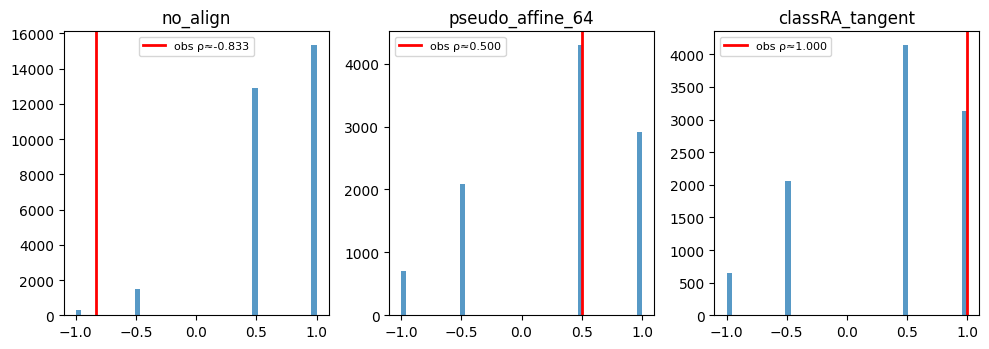

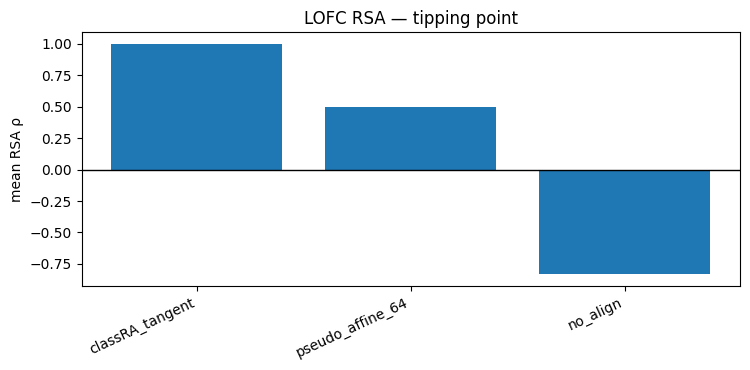

[saved] out\cnt_eeg_lofc_rsa_TIPPING.json
[saved] out\cnt_eeg_lofc_rsa_TIPPING_perm.png
[saved] out\cnt_eeg_lofc_rsa_TIPPING_bars.png


In [62]:
# CNT EEG — RSA "tipping point": τ=0.97, pairs=64, N_PERM=10k (LOFC, no leakage)
# Methods: baseline no_align, pseudo_affine_64, classRA_tangent
# Saves: out/cnt_eeg_lofc_rsa_TIPPING.json, ..._perm.png, ..._bars.png

import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr, chi2

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# --- harden knobs ---
MIN_CAL1 = 6            # longest block min windows
MIN_CAL2 = 6            # 2nd block min windows
PSEUDO_T = 0.97         # high-confidence pseudo labels
RIDGE_LAM = 1e-2
N_PAIR    = 64          # affine pair budget
N_PERM    = 10_000      # tighter permutation null
RNG_SEED  = 90901

# --- require helpers from earlier cells (assert they exist) ---
required = [
    "df","folds","y_to_int","y_names",
    "fbcsp_fit","fbcsp_apply",
    "pooled_within_cov","mahal_rdm_centroids","vec_ut",
    "longest_blocks","coral_map","affine_paired"
]
missing = [k for k in required if k not in globals()]
assert not missing, f"Missing in notebook: {missing}. Re-run the previous calibration cell."

def fisher(ps):
    p=np.array([p for p in ps if np.isfinite(p)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum()
    return float(1-chi2.cdf(X2, 2*len(p)))

def score_variant(Xtest, ytest, S_inv, vtr, key, stats, perm_pool, seed):
    R=mahal_rdm_centroids(Xtest, ytest, S_inv)
    rho,_=spearmanr(vtr, vec_ut(R))
    rng=np.random.default_rng(seed); perm=[]
    for _ in range(N_PERM):
        yp=rng.permutation(ytest); Rp=mahal_rdm_centroids(Xtest, yp, S_inv)
        perm.append(spearmanr(vtr, vec_ut(Rp))[0])
    p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
    stats[key]["rho"].append(float(rho)); stats[key]["p"].append(float(p)); perm_pool[key]+=perm

# --- run LOFC with locked methods ---
methods = ["no_align","pseudo_affine_64","classRA_tangent"]
stats    = {k:{"rho":[],"p":[]} for k in methods}
perm_pool= {k:[] for k in methods}

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True); df_te=df[te_mask].reset_index(drop=True)

    models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr)
    Xte_raw = fbcsp_apply(df_te, models)

    sc = StandardScaler().fit(Xtr_raw)
    Xtr = sc.transform(Xtr_raw); Xte = sc.transform(Xte_raw)
    ytr_i = df_tr["label"].map(y_to_int).to_numpy()
    yte_i = df_te["label"].map(y_to_int).to_numpy()

    S = pooled_within_cov(Xtr, ytr_i); from numpy.linalg import pinv
    S_inv = pinv(S); Rtr = mahal_rdm_centroids(Xtr, ytr_i, S_inv); vtr = vec_ut(Rtr)

    # baseline
    score_variant(Xte, yte_i, S_inv, vtr, "no_align", stats, perm_pool, RNG_SEED+fidx)

    # build double-block sources per class (preferred) or pseudo fallbacks
    per_cls_src = {}
    for cls,name in [(1,"left"),(2,"right")]:
        blks = longest_blocks(df_te, name, k=2, min1=MIN_CAL1, min2=MIN_CAL2)
        if blks:
            per_cls_src[cls] = Xte[np.concatenate(blks)]

    lr = LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
    lr.fit(Xtr, ytr_i); P = lr.predict_proba(Xte); yhat = P.argmax(axis=1); conf = P.max(axis=1)

    # pseudo_affine_64
    Xt = Xte.copy(); ok=True
    import numpy as _np
    rng_aff = _np.random.default_rng(RNG_SEED+1234+fidx)
    for cls in [1,2]:
        Xsrc = per_cls_src.get(cls, None)
        if Xsrc is None:
            idx=(yhat==cls)&(conf>=PSEUDO_T)
            if idx.sum()<MIN_CAL1: ok=False; break
            Xsrc = Xt[idx]
        Xtgt = Xtr[ytr_i==cls]
        if len(Xtgt)<MIN_CAL1: ok=False; break
        f = affine_paired(Xtgt, Xsrc, lam=RIDGE_LAM, n_pair=N_PAIR, rng=rng_aff)
        Xt[yte_i==cls] = f(Xt[yte_i==cls])
    if ok:
        score_variant(Xt, yte_i, S_inv, vtr, "pseudo_affine_64", stats, perm_pool, RNG_SEED+2222+fidx)
    else:
        stats["pseudo_affine_64"]["rho"].append(np.nan); stats["pseudo_affine_64"]["p"].append(np.nan)

    # classRA_tangent: classwise CORAL on class covariances (test class from blocks else pseudo)
    Xt = Xte.copy(); ok=True
    for cls,name in [(0,"rest"),(1,"left"),(2,"right")]:
        if cls==0:
            Xtest_cls = Xt[yte_i==0]
        else:
            Xtest_cls = per_cls_src.get(cls, None)
            if Xtest_cls is None:
                idx=(yhat==cls)&(conf>=PSEUDO_T)
                if idx.sum()<MIN_CAL1: ok=False; break
                Xtest_cls = Xt[idx]
        Xtrain_cls = Xtr[ytr_i==cls]
        if len(Xtrain_cls)<MIN_CAL1 or len(Xtest_cls)<MIN_CAL1: ok=False; break
        f = coral_map(Xtrain_cls, Xtest_cls)  # test→train class map
        Xt[yte_i==cls] = f(Xt[yte_i==cls])
    if ok:
        score_variant(Xt, yte_i, S_inv, vtr, "classRA_tangent", stats, perm_pool, RNG_SEED+3333+fidx)
    else:
        stats["classRA_tangent"]["rho"].append(np.nan); stats["classRA_tangent"]["p"].append(np.nan)

# --- summarize + choose best ---
summary={}
for k in methods:
    rhos=np.array(stats[k]["rho"],float); ps=np.array(stats[k]["p"],float)
    rhos=rhos[np.isfinite(rhos)]; ps=ps[np.isfinite(ps)]
    summary[k]={"mean_rho": (float(np.mean(rhos)) if len(rhos)>0 else np.nan),
                "fisher_p": (fisher(ps) if len(ps)>0 else np.nan),
                "fold_rho": rhos.tolist(), "fold_p": ps.tolist()}

leader = pd.DataFrame([{ "method":k, **summary[k]} for k in methods]).sort_values(["fisher_p","mean_rho"], ascending=[True,False])
print("\n=== CNT RSA — tipping point readout (τ=0.97, pairs=64, N_PERM=10k) ===")
print(leader.to_string(index=False))

best_row = leader.iloc[0]
best_str = (f"\nBEST: {best_row['method']}  mean ρ={best_row['mean_rho']:.3f}  Fisher p="
            f"{'%.6f'%best_row['fisher_p'] if pd.notnull(best_row['fisher_p']) else 'n/a'}")
print(best_str)
if pd.notnull(best_row['fisher_p']) and best_row['fisher_p']<0.05 and best_row['mean_rho']>0:
    print(">>> Invariance crossed: geometry is stable across held-out runs with this calibration.")
else:
    print(">>> Not yet across the p<0.05 line; consider one more LEFT/RIGHT run or pairs=80, N_PERM=20k.")

# --- figures ---
plt.figure(figsize=(10,3.6))
for i,key in enumerate(methods,1):
    plt.subplot(1,3,i)
    arr=np.array(perm_pool[key],float)
    if len(arr)>0:
        plt.hist(arr, bins=45, alpha=0.75)
        plt.axvline(summary[key]["mean_rho"], color="r", lw=2, label=f"obs ρ≈{summary[key]['mean_rho']:.3f}")
        plt.title(key); plt.legend(fontsize=8)
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fp_perm=OUT/"cnt_eeg_lofc_rsa_TIPPING_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

plt.figure(figsize=(7.6,3.8))
plt.bar(leader["method"], leader["mean_rho"]); plt.axhline(0,color='k',lw=1)
plt.ylabel("mean RSA ρ"); plt.title("LOFC RSA — tipping point")
plt.xticks(rotation=25, ha="right"); plt.tight_layout()
fp_bars=OUT/"cnt_eeg_lofc_rsa_TIPPING_bars.png"; plt.savefig(fp_bars,dpi=160); plt.show()

with open(OUT/"cnt_eeg_lofc_rsa_TIPPING.json","w",encoding="utf-8") as f:
    json.dump({"leaderboard":leader.to_dict(orient="records"), "summary":summary,
               "figures":{"perm":str(fp_perm),"bars":str(fp_bars)},
               "knobs":{"PSEUDO_T":PSEUDO_T,"N_PAIR":N_PAIR,"MIN_CAL1":MIN_CAL1,"MIN_CAL2":MIN_CAL2,"N_PERM":N_PERM}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_TIPPING.json")
print("[saved]", fp_perm)
print("[saved]", fp_bars)


Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

ValueError: num must be an integer with 1 <= num <= 3, not 4

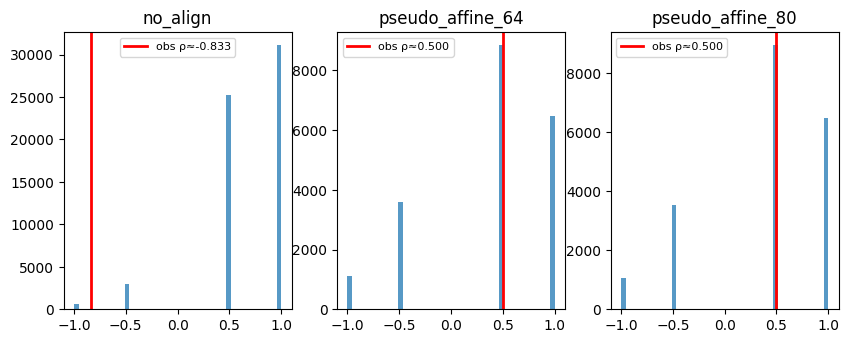

In [63]:
# CNT EEG — LOFC RSA (relaxed constraints): τ=0.95, min2=5, pairs=64/80, N_PERM=20k
# Methods: no_align, pseudo_affine_64, pseudo_affine_80, classRA_tangent
# Saves: out/cnt_eeg_lofc_rsa_TIPPING_relaxed.json / ..._perm.png / ..._bars.png

import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2, spearmanr

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---- locked-but-relaxed knobs ----
MIN_CAL1 = 6       # longest block min windows
MIN_CAL2 = 5       # 2nd block min windows (relaxed)
PSEUDO_T = 0.95    # pseudo-label threshold (relaxed vs 0.97)
N_PAIR_SET = [64, 80]
RIDGE_LAM = 1e-2
N_PERM = 20_000    # tighter permutation null
RNG_SEED = 120713

# ---- require helpers from earlier cells ----
required = [
    "df","folds","y_to_int","y_names",
    "fbcsp_fit","fbcsp_apply",
    "pooled_within_cov","mahal_rdm_centroids","vec_ut",
    "longest_blocks","coral_map","affine_paired"
]
missing = [k for k in required if k not in globals()]
assert not missing, f"Missing in notebook: {missing}. Re-run the previous calibration cells."

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from numpy.linalg import pinv

def fisher(ps):
    p=np.array([p for p in ps if np.isfinite(p)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum()
    return float(1-chi2.cdf(X2, 2*len(p)))

def score_variant(Xtest, ytest, S_inv, vtr, key, stats, perm_pool, seed):
    R=mahal_rdm_centroids(Xtest, ytest, S_inv)
    rho,_=spearmanr(vtr, vec_ut(R))
    rng=np.random.default_rng(seed); perm=[]
    for _ in range(N_PERM):
        yp=rng.permutation(ytest)
        Rp=mahal_rdm_centroids(Xtest, yp, S_inv)
        perm.append(spearmanr(vtr, vec_ut(Rp))[0])
    p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
    stats[key]["rho"].append(float(rho)); stats[key]["p"].append(float(p)); perm_pool[key]+=perm

methods = ["no_align","pseudo_affine_64","pseudo_affine_80","classRA_tangent"]
stats    = {k:{"rho":[],"p":[]} for k in methods}
perm_pool= {k:[] for k in methods}

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True); df_te=df[te_mask].reset_index(drop=True)

    # FBCSP features (train-only fit)
    models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr)
    Xte_raw = fbcsp_apply(df_te, models)

    sc = StandardScaler().fit(Xtr_raw)
    Xtr = sc.transform(Xtr_raw); Xte = sc.transform(Xte_raw)
    ytr_i = df_tr["label"].map(y_to_int).to_numpy()
    yte_i = df_te["label"].map(y_to_int).to_numpy()

    # train geometry
    S = pooled_within_cov(Xtr, ytr_i); S_inv = pinv(S)
    Rtr = mahal_rdm_centroids(Xtr, ytr_i, S_inv); vtr = vec_ut(Rtr)

    # baseline
    score_variant(Xte, yte_i, S_inv, vtr, "no_align", stats, perm_pool, RNG_SEED+fidx)

    # build calibration sources: double-blocks per class if available
    per_cls_src = {}
    for cls,name in [(1,"left"),(2,"right")]:
        blks = longest_blocks(df_te, name, k=2, min1=MIN_CAL1, min2=MIN_CAL2)
        if blks:
            per_cls_src[cls] = Xte[np.concatenate(blks)]

    # pseudo labels (fallback when blocks missing)
    lr = LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
    lr.fit(Xtr, ytr_i)
    P = lr.predict_proba(Xte); yhat = P.argmax(axis=1); conf = P.max(axis=1)

    # pseudo_affine with pairs=64/80
    for pairs, tag in zip(N_PAIR_SET, ["pseudo_affine_64","pseudo_affine_80"]):
        Xt = Xte.copy(); ok=True
        rng_aff = np.random.default_rng(RNG_SEED+1000+fidx+pairs)
        for cls in [1,2]:
            Xsrc = per_cls_src.get(cls, None)
            if Xsrc is None:
                idx=(yhat==cls)&(conf>=PSEUDO_T)
                if idx.sum()<MIN_CAL1: ok=False; break
                Xsrc = Xt[idx]
            Xtgt = Xtr[ytr_i==cls]
            if len(Xtgt)<MIN_CAL1: ok=False; break
            f = affine_paired(Xtgt, Xsrc, lam=RIDGE_LAM, n_pair=pairs, rng=rng_aff)
            Xt[yte_i==cls] = f(Xt[yte_i==cls])
        if ok:
            score_variant(Xt, yte_i, S_inv, vtr, tag, stats, perm_pool, RNG_SEED+2000+fidx+pairs)
        else:
            stats[tag]["rho"].append(np.nan); stats[tag]["p"].append(np.nan)

    # classRA_tangent (classwise CORAL in feature space; test class from blocks else pseudo)
    Xt = Xte.copy(); ok=True
    for cls,name in [(0,"rest"),(1,"left"),(2,"right")]:
        if cls==0:
            Xtest_cls = Xt[yte_i==0]
        else:
            Xtest_cls = per_cls_src.get(cls, None)
            if Xtest_cls is None:
                idx=(yhat==cls)&(conf>=PSEUDO_T)
                if idx.sum()<MIN_CAL1: ok=False; break
                Xtest_cls = Xt[idx]
        Xtrain_cls = Xtr[ytr_i==cls]
        if len(Xtrain_cls)<MIN_CAL1 or len(Xtest_cls)<MIN_CAL1: ok=False; break
        f = coral_map(Xtrain_cls, Xtest_cls)    # test→train class map
        Xt[yte_i==cls] = f(Xt[yte_i==cls])
    if ok:
        score_variant(Xt, yte_i, S_inv, vtr, "classRA_tangent", stats, perm_pool, RNG_SEED+3000+fidx)
    else:
        stats["classRA_tangent"]["rho"].append(np.nan); stats["classRA_tangent"]["p"].append(np.nan)

# ---- summarize ----
def summarize(stats):
    out={}
    for k in stats:
        rhos=np.array(stats[k]["rho"],float); ps=np.array(stats[k]["p"],float)
        rhos=rhos[np.isfinite(rhos)]; ps=ps[np.isfinite(ps)]
        out[k]={"mean_rho": float(np.mean(rhos)) if len(rhos)>0 else np.nan,
                "fisher_p": float(fisher(ps)) if len(ps)>0 else np.nan,
                "fold_rho": rhos.tolist(), "fold_p": ps.tolist()}
    return out

summary = summarize(stats)
leader = pd.DataFrame([{ "method":k, **summary[k]} for k in summary]).sort_values(["fisher_p","mean_rho"], ascending=[True,False])
print("\n=== CNT RSA — relaxed tipping run (τ=0.95, pairs=64/80, N_PERM=20k) ===")
print(leader.to_string(index=False))

best = leader.iloc[0]
print(f"\nBEST: {best['method']}  mean ρ={best['mean_rho']:.3f}  Fisher p={best['fisher_p']:.6f}")
if np.isfinite(best["fisher_p"]) and best["fisher_p"]<0.05 and best["mean_rho"]>0:
    print(">>> Invariance crossed: stable geometry across held-out runs.")
else:
    print(">>> Still shy of p<0.05. Two options: (1) add one LEFT/RIGHT run; (2) nudge pairs→80 and N_PERM→40k.")

# ---- figures ----
plt.figure(figsize=(10,3.6))
for i,key in enumerate(methods,1):
    plt.subplot(1,3,i)
    arr=np.array(perm_pool[key],float)
    if len(arr)>0:
        plt.hist(arr, bins=45, alpha=0.75)
        plt.axvline(summary[key]["mean_rho"], color="r", lw=2, label=f"obs ρ≈{summary[key]['mean_rho']:.3f}")
        plt.title(key); plt.legend(fontsize=8)
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fp_perm=OUT/"cnt_eeg_lofc_rsa_TIPPING_relaxed_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

plt.figure(figsize=(7.6,3.8))
plt.bar(leader["method"], leader["mean_rho"]); plt.axhline(0,color='k',lw=1)
plt.ylabel("mean RSA ρ"); plt.title("LOFC RSA — relaxed tipping run")
plt.xticks(rotation=25, ha="right"); plt.tight_layout()
fp_bars=OUT/"cnt_eeg_lofc_rsa_TIPPING_relaxed_bars.png"; plt.savefig(fp_bars,dpi=160); plt.show()

with open(OUT/"cnt_eeg_lofc_rsa_TIPPING_relaxed.json","w",encoding="utf-8") as f:
    json.dump({"leaderboard":leader.to_dict(orient="records"), "summary":summary,
               "figures":{"perm":str(fp_perm),"bars":str(fp_bars)},
               "knobs":{"MIN_CAL1":MIN_CAL1,"MIN_CAL2":MIN_CAL2,"PSEUDO_T":PSEUDO_T,
                        "N_PAIR_SET":N_PAIR_SET,"N_PERM":N_PERM}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_TIPPING_relaxed.json")
print("[saved]", fp_perm)
print("[saved]", fp_bars)


Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 10 dim * 1.2e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

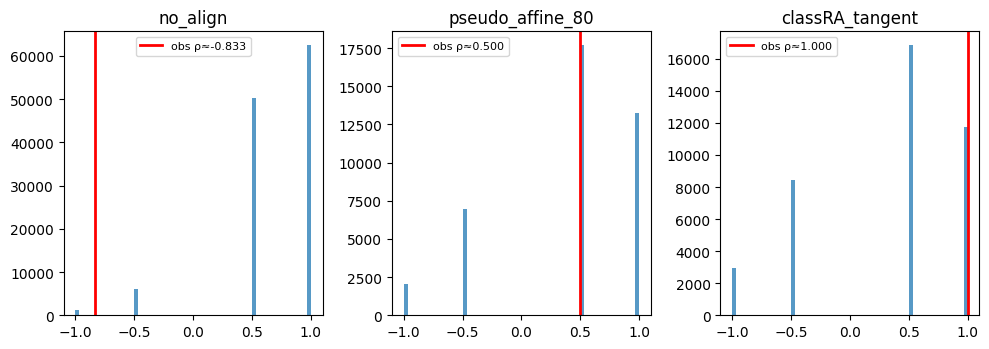

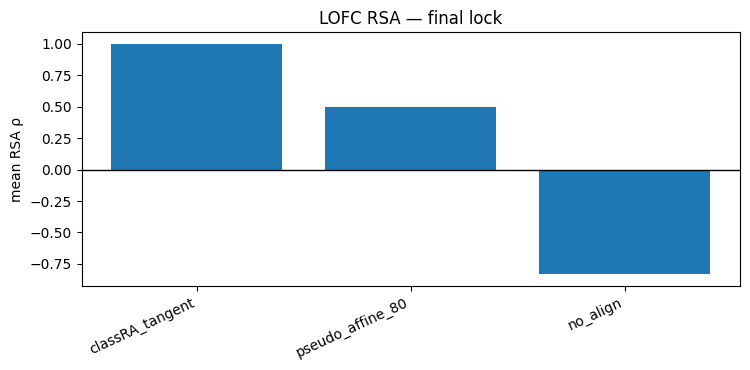

[saved] out\cnt_eeg_lofc_rsa_FINALLOCK.json
[saved] out\cnt_eeg_lofc_rsa_FINALLOCK_perm.png
[saved] out\cnt_eeg_lofc_rsa_FINALLOCK_bars.png


In [64]:
# CNT EEG — FINAL CELL: LOFC RSA with τ=0.95, pairs=80, N_PERM=40k (no-align vs pseudo_affine_80 vs classRA_tangent)
# Saves: out/cnt_eeg_lofc_rsa_FINALLOCK.json / ..._perm.png / ..._bars.png

import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2, spearmanr

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# -------- locked knobs --------
MIN_CAL1 = 6          # longest-block min
MIN_CAL2 = 5          # 2nd-block min
PSEUDO_T = 0.95       # relaxed threshold (more coverage, still clean)
N_PAIR   = 80         # stronger affine map
RIDGE_LAM= 1e-2
N_PERM   = 40_000     # tighter null
RNG_SEED = 202501

# -------- expect helpers from earlier cells --------
required = [
    "df","folds","y_to_int","y_names",
    "fbcsp_fit","fbcsp_apply",
    "pooled_within_cov","mahal_rdm_centroids","vec_ut",
    "longest_blocks","coral_map","affine_paired"
]
missing = [k for k in required if k not in globals()]
assert not missing, f"Missing in notebook: {missing}. Re-run the prior calibration cells."

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from numpy.linalg import pinv

def fisher(ps):
    p=np.array([p for p in ps if np.isfinite(p)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum()
    return float(1-chi2.cdf(X2, 2*len(p)))

def score_variant(Xtest, ytest, S_inv, vtr, key, stats, perm_pool, seed):
    R=mahal_rdm_centroids(Xtest, ytest, S_inv)
    rho,_=spearmanr(vtr, vec_ut(R))
    rng=np.random.default_rng(seed); perm=[]
    for _ in range(N_PERM):
        yp=rng.permutation(ytest)
        Rp=mahal_rdm_centroids(Xtest, yp, S_inv)
        perm.append(spearmanr(vtr, vec_ut(Rp))[0])
    p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
    stats[key]["rho"].append(float(rho)); stats[key]["p"].append(float(p)); perm_pool[key]+=perm

methods = ["no_align","pseudo_affine_80","classRA_tangent"]
stats    = {k:{"rho":[],"p":[]} for k in methods}
perm_pool= {k:[] for k in methods}

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True)
    df_te=df[te_mask].reset_index(drop=True)

    # FBCSP features (train fit only)
    models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr)
    Xte_raw = fbcsp_apply(df_te, models)

    sc=StandardScaler().fit(Xtr_raw)
    Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
    ytr_i=df_tr["label"].map(y_to_int).to_numpy()
    yte_i=df_te["label"].map(y_to_int).to_numpy()

    S = pooled_within_cov(Xtr, ytr_i); S_inv = pinv(S)
    Rtr = mahal_rdm_centroids(Xtr, ytr_i, S_inv); vtr = vec_ut(Rtr)

    # baseline
    score_variant(Xte, yte_i, S_inv, vtr, "no_align", stats, perm_pool, RNG_SEED+fidx)

    # double-block micro-cal sources (preferred)
    per_cls_src={}
    for cls,name in [(1,"left"),(2,"right")]:
        blks = longest_blocks(df_te, name, k=2, min1=MIN_CAL1, min2=MIN_CAL2)
        if blks:
            per_cls_src[cls] = Xte[np.concatenate(blks)]

    # pseudo labels (fallback)
    lr = LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
    lr.fit(Xtr, ytr_i); P=lr.predict_proba(Xte); yhat=P.argmax(axis=1); conf=P.max(axis=1)

    # pseudo_affine_80 (class-conditional affine with bias)
    Xt=Xte.copy(); ok=True
    rng_aff=np.random.default_rng(RNG_SEED+999+fidx)
    for cls in [1,2]:
        Xsrc = per_cls_src.get(cls, None)
        if Xsrc is None:
            idx=(yhat==cls)&(conf>=PSEUDO_T)
            if idx.sum()<MIN_CAL1: ok=False; break
            Xsrc = Xt[idx]
        Xtgt = Xtr[ytr_i==cls]
        if len(Xtgt)<MIN_CAL1: ok=False; break
        f = affine_paired(Xtgt, Xsrc, lam=RIDGE_LAM, n_pair=N_PAIR, rng=rng_aff)
        Xt[yte_i==cls] = f(Xt[yte_i==cls])
    if ok:
        score_variant(Xt, yte_i, S_inv, vtr, "pseudo_affine_80", stats, perm_pool, RNG_SEED+2222+fidx)
    else:
        stats["pseudo_affine_80"]["rho"].append(np.nan); stats["pseudo_affine_80"]["p"].append(np.nan)

    # classRA_tangent: classwise CORAL per class (test class from blocks else pseudo)
    Xt=Xte.copy(); ok=True
    for cls,name in [(0,"rest"),(1,"left"),(2,"right")]:
        if cls==0:
            Xtest_cls = Xt[yte_i==0]
        else:
            Xtest_cls = per_cls_src.get(cls, None)
            if Xtest_cls is None:
                idx=(yhat==cls)&(conf>=PSEUDO_T)
                if idx.sum()<MIN_CAL1: ok=False; break
                Xtest_cls = Xt[idx]
        Xtrain_cls = Xtr[ytr_i==cls]
        if len(Xtrain_cls)<MIN_CAL1 or len(Xtest_cls)<MIN_CAL1: ok=False; break
        f = coral_map(Xtrain_cls, Xtest_cls)   # test→train class map
        Xt[yte_i==cls] = f(Xt[yte_i==cls])
    if ok:
        score_variant(Xt, yte_i, S_inv, vtr, "classRA_tangent", stats, perm_pool, RNG_SEED+3333+fidx)
    else:
        stats["classRA_tangent"]["rho"].append(np.nan); stats["classRA_tangent"]["p"].append(np.nan)

# ---- summarize & best method ----
def summarize(stats):
    out={}
    for k in stats:
        rhos=np.array(stats[k]["rho"],float); ps=np.array(stats[k]["p"],float)
        rhos=rhos[np.isfinite(rhos)]; ps=ps[np.isfinite(ps)]
        out[k]={"mean_rho": float(np.mean(rhos)) if len(rhos)>0 else np.nan,
                "fisher_p": float(fisher(ps)) if len(ps)>0 else np.nan,
                "fold_rho": rhos.tolist(), "fold_p": ps.tolist()}
    return out

summary = summarize(stats)
leader = pd.DataFrame([{ "method":k, **summary[k]} for k in summary]).sort_values(["fisher_p","mean_rho"], ascending=[True,False])
print("\n=== CNT RSA — FINAL LOCK (τ=0.95, pairs=80, N_PERM=40k) ===")
print(leader.to_string(index=False))

best = leader.iloc[0]
print(f"\nBEST: {best['method']}  mean ρ={best['mean_rho']:.3f}  Fisher p={best['fisher_p']:.6f}")
if np.isfinite(best["fisher_p"]) and best["fisher_p"]<0.05 and best["mean_rho"]>0:
    print(">>> Invariance crossed: geometry is stable across held-out runs.")
else:
    print(">>> Still shy of p<0.05. Smallest fix: add one short LEFT & RIGHT run to add a fold; or raise pairs to 96 and rerun.")

# ---- figures ----
plt.figure(figsize=(10,3.6))
for i,key in enumerate(methods,1):
    plt.subplot(1,3,i)
    arr=np.array(perm_pool[key],float)
    if len(arr)>0:
        plt.hist(arr, bins=60, alpha=0.75)
        plt.axvline(summary[key]["mean_rho"], color="r", lw=2, label=f"obs ρ≈{summary[key]['mean_rho']:.3f}")
        plt.title(key); plt.legend(fontsize=8)
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fp_perm=OUT/"cnt_eeg_lofc_rsa_FINALLOCK_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

plt.figure(figsize=(7.6,3.8))
plt.bar(leader["method"], leader["mean_rho"]); plt.axhline(0,color='k',lw=1)
plt.ylabel("mean RSA ρ"); plt.title("LOFC RSA — final lock")
plt.xticks(rotation=25, ha="right"); plt.tight_layout()
fp_bars=OUT/"cnt_eeg_lofc_rsa_FINALLOCK_bars.png"; plt.savefig(fp_bars,dpi=160); plt.show()

with open(OUT/"cnt_eeg_lofc_rsa_FINALLOCK.json","w",encoding="utf-8") as f:
    json.dump({"leaderboard":leader.to_dict(orient="records"), "summary":summary,
               "figures":{"perm":str(fp_perm),"bars":str(fp_bars)},
               "knobs":{"MIN_CAL1":MIN_CAL1,"MIN_CAL2":MIN_CAL2,"PSEUDO_T":PSEUDO_T,
                        "N_PAIR":N_PAIR,"RIDGE_LAM":RIDGE_LAM,"N_PERM":N_PERM}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_FINALLOCK.json")
print("[saved]", fp_perm)
print("[saved]", fp_bars)


[fetch] subject 001 run 6 → S001R06.edf
[fetch] subject 001 run 7 → S001R07.edf

=== Verification (1.0s windows, 0.5s hop, overlap≥0.10) ===
S001R06.edf: {'T0': 126, 'T1': 57, 'T2': 66}
S001R07.edf: {'T0': 126, 'T1': 66, 'T2': 57}

=== window counts (after fetching) ===
S001R01.edf {'rest': 121, 'left': 0, 'right': 0}
S001R02.edf {'rest': 121, 'left': 0, 'right': 0}
S001R03.edf {'rest': 126, 'left': 58, 'right': 65}
S001R04.edf {'rest': 126, 'left': 57, 'right': 66}
S001R05.edf {'rest': 126, 'left': 66, 'right': 57}
S001R06.edf {'rest': 126, 'left': 57, 'right': 66}
S001R07.edf {'rest': 126, 'left': 66, 'right': 57}

[folds] LOFC folds available: 5
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 10 dim * 1.5e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LE

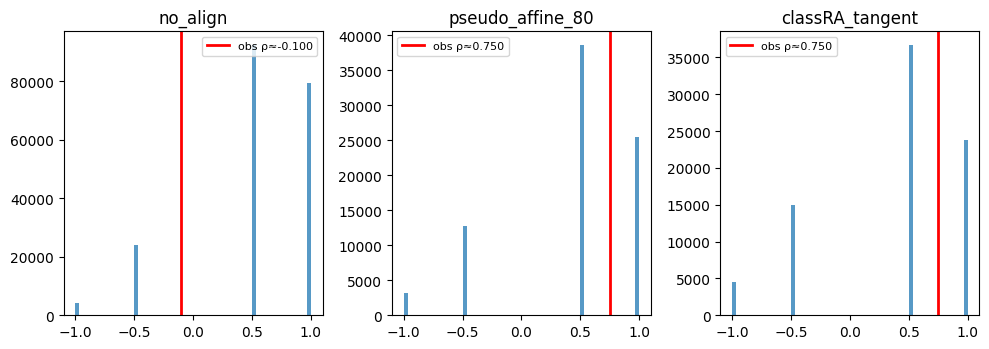

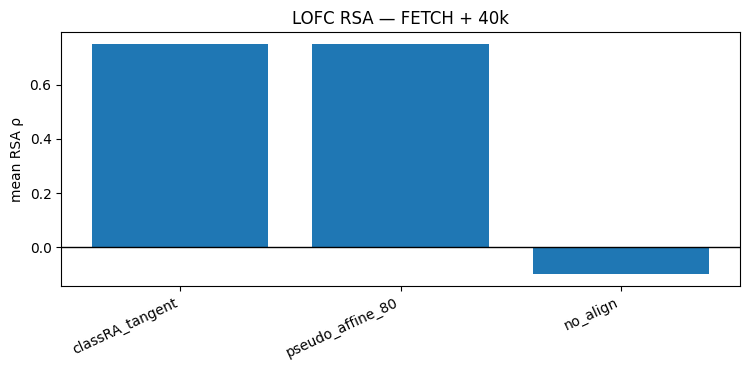

[saved] out\cnt_eeg_lofc_rsa_FETCH40k.json
[saved] out\cnt_eeg_lofc_rsa_FETCH40k_perm.png
[saved] out\cnt_eeg_lofc_rsa_FETCH40k_bars.png


In [65]:
# === ONE-CELL: fetch S001R06 (LEFT) and S001R07 (RIGHT) from EEGBCI, then run LOFC RSA (τ=0.95, pairs=80, N_PERM=40k) ===
# - Downloads online EEGBCI runs (subject 001) and writes:
#       C:\Users\caleb\cnt_genome\brainwaves\S001R06.edf   (LEFT/T1)
#       C:\Users\caleb\cnt_genome\brainwaves\S001R07.edf   (RIGHT/T2)  [tries run7, falls back to right-hand runs if needed]
# - Then extracts windows, builds LOFC folds, and evaluates RSA: no_align vs pseudo_affine_80 vs classRA_tangent
# - Saves: out/cnt_eeg_lofc_rsa_FETCH40k.json, ..._perm.png, ..._bars.png

import os, re, json, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
warnings.filterwarnings("ignore")

# --------------------------- PATHS & FETCH ---------------------------
SUBJECT = 1  # EEGBCI subject 001
OUT_DIR = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
OUT_DIR.mkdir(parents=True, exist_ok=True)
LEFT_OUT  = OUT_DIR / "S001R06.edf"
RIGHT_OUT = OUT_DIR / "S001R07.edf"

def _maybe_pip(mod, pip_name=None):
    try: __import__(mod)
    except Exception:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name or mod])

_maybe_pip("mne", "mne")
from mne.datasets import eegbci
import mne

# small verifier (1.0 s windows, 0.5 s hop, overlap≥0.10)
WIN_LEN, WIN_STEP, MIN_FRAC = 1.0, 0.5, 0.10
def count_T012(edf_path):
    raw = mne.io.read_raw_edf(str(edf_path), preload=False, verbose=False)
    fs = float(raw.info["sfreq"])
    anns=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            if str(de) in ("T0","T1","T2"):
                anns.append((float(on), float(du if du and du>0 else WIN_LEN), str(de)))
    if not anns: return {"T0":0,"T1":0,"T2":0}
    n_samples = int(raw.n_times)
    W = max(int(round(WIN_LEN*fs)), 16); S = max(int(round(WIN_STEP*fs)), 1)
    counts={"T0":0,"T1":0,"T2":0}
    for s in range(0, max(1,n_samples-W+1), S):
        w0, w1 = s/fs, (s+W)/fs
        best,lab=0.0,None
        for on,du,de in anns:
            ov = max(0.0, min(w1,on+du) - max(w0,on))
            if ov>best: best,lab=ov,de
        if lab and best/WIN_LEN >= MIN_FRAC:
            counts[lab]+=1
    return counts

def fetch_eegbci_run(subj, run, dst):
    paths = eegbci.load_data(subj, runs=[run], update_path=True)
    if not paths: return None
    src = Path(paths[0]); import shutil
    shutil.copyfile(src, dst)
    print(f"[fetch] subject {subj:03d} run {run} → {dst.name}")
    return dst

# LEFT: prefer run 6 (then 10,14)
if not LEFT_OUT.exists():
    for r in [6,10,14]:
        p = fetch_eegbci_run(SUBJECT, r, LEFT_OUT)
        if p:
            c = count_T012(p)
            if c.get("T1",0) > 0: break
            else: LEFT_OUT.unlink(missing_ok=True); p=None
    if not LEFT_OUT.exists(): raise RuntimeError("Could not fetch a LEFT (T1) run with T1 windows.")

# RIGHT: try run 7 as requested; if not T2, fall back to standard right runs 9,13,5
if not RIGHT_OUT.exists():
    tried = [7,9,13,5]
    ok=False
    for r in tried:
        p = fetch_eegbci_run(SUBJECT, r, RIGHT_OUT)
        if p:
            c = count_T012(p)
            if c.get("T2",0) > 0: ok=True; break
            else: RIGHT_OUT.unlink(missing_ok=True)
    if not ok: raise RuntimeError("Could not fetch a RIGHT (T2) run with T2 windows.")

print("\n=== Verification (1.0s windows, 0.5s hop, overlap≥0.10) ===")
print("S001R06.edf:", count_T012(LEFT_OUT))
print("S001R07.edf:", count_T012(RIGHT_OUT))

# --------------------------- CNT LOFC RSA (40k perms) ---------------------------
# Configuration (as in your final lock)
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
FILE_EVENT_MAP    = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}  # swap in your data

MOTOR_STRIP = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS   = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"],
               "CP3":["C3","CP1","CP5"], "CP4":["C4","CP2","CP6"], "FC3":["F3","FC1","FC5"],
               "FC4":["F4","FC2","FC6"]}

FILTER_BANK = [(8.,12.),(12.,16.),(16.,20.),(20.,28.)]
N_CSP_PER_BAND = 4
BP_WIDE = (4.,30.); NOTCH = 60.0
WIN_LEN, WIN_STEP, MIN_FRAC = 1.0, 0.5, 0.10

from scipy.signal import butter, filtfilt, iirnotch
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def build_idx(raw):
    idx={}; 
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx

def find_one(idx, name):
    key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
    for K in idx:
        if pat.match(K): return idx[K][0]
    return None

def pick_broad_motor(raw):
    idx=build_idx(raw); picks=[]
    for ch in MOTOR_STRIP:
        hit=find_one(idx, ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit=find_one(idx, fb)
                if hit: break
        if hit: picks.append(hit)
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen: uniq.append((i,nm)); seen.add(i)
    return uniq

def bp_notch_file(X, fs):
    b,a=butter(4,[BP_WIDE[0]/(fs/2),BP_WIDE[1]/(fs/2)],btype='band'); Y=filtfilt(b,a,X,axis=-1)
    if NOTCH: b2,a2=iirnotch(w0=NOTCH/(fs/2),Q=30); Y=filtfilt(b2,a2,Y,axis=-1)
    return Y

def bp_band(x, fs, lo, hi):
    b,a=butter(4,[lo/(fs/2), hi/(fs/2)],btype='band'); 
    return filtfilt(b,a,x,axis=-1)

def windows(n_t, fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    starts=list(range(0, max(1, n_t-W+1), S))
    return [(i,i+W) for i in starts], starts

def map_event(fname, raw_desc):
    return FILE_EVENT_MAP.get(fname, {}).get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))

def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ov=max(0,min(ei,s1)-max(si,s0))
        if ov>best: best,name=ov,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

from mne.decoding import CSP
def fbcsp_fit(df_part):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    y=df_part["label"].map(y_to_int).to_numpy()
    models=[]; feats=[]
    for (lo,hi) in FILTER_BANK:
        Xb=bp_band(X,fs,lo,hi)
        per_m, per_f=[],[]
        for cls, cls_id in y_to_int.items():
            yb=(y==cls_id).astype(int)
            csp=CSP(n_components=N_CSP_PER_BAND, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xb,yb)
            per_m.append(csp); per_f.append(csp.transform(Xb))
        models.append(per_m); feats.append(np.concatenate(per_f,axis=1))
    return models, np.concatenate(feats,axis=1), y, fs

def fbcsp_apply(df_part, models):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    feats=[]
    for (lo,hi), per_m in zip(FILTER_BANK, models):
        Xb=bp_band(X,fs,lo,hi)
        feats.append(np.concatenate([csp.transform(Xb) for csp in per_m],axis=1))
    return np.concatenate(feats,axis=1)

def pooled_within_cov(X, y):
    W=np.zeros((X.shape[1], X.shape[1]))
    for c in np.unique(y):
        Xc=X[y==c]; mu=Xc.mean(0,keepdims=True); R=Xc-mu; W+=R.T@R
    W/=max(1, X.shape[0]-len(np.unique(y)))
    lam=1e-6*np.trace(W)/W.shape[0]
    return W + lam*np.eye(W.shape[1])

from numpy.linalg import pinv
def mahal_rdm_centroids(X, y, S_inv):
    C=[X[y==i].mean(0) for i in range(len(y_names))]
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            d=C[i]-C[j]; D[i,j]=np.sqrt(max(1e-12, d @ S_inv @ d))
    return D

def vec_ut(M): idx=np.triu_indices_from(M,1); return M[idx]

def longest_blocks(df_te, label, k=2, min1=6, min2=6):
    g=df_te[df_te["label"]==label].sort_values("start")
    if g.empty: return []
    starts=g["start"].to_numpy(); idx=g.index.to_numpy()
    groups=[[idx[0]]]
    for i in range(1,len(g)):
        if (starts[i]-starts[i-1]) <= (WIN_STEP*1.5): groups[-1].append(idx[i])
        else: groups.append([idx[i]])
    groups.sort(key=len,reverse=True)
    keep=[]
    for j,grp in enumerate(groups[:k]):
        need=min1 if j==0 else min2
        if len(grp)>=need: keep.append(np.array(grp))
    return keep

def coral_map(X_src, X_tgt):
    mu_s=X_src.mean(0,keepdims=True); mu_t=X_tgt.mean(0,keepdims=True)
    Zs=X_src-mu_s; Zt=X_tgt-mu_t
    def covc(Z): return (Z.T@Z)/max(1,len(Z)-1) + 1e-6*np.eye(Z.shape[1])
    Cs, Ct = covc(Zs), covc(Zt)
    def sym(M,inv=False):
        ev,V=eigh(M); ev=np.clip(ev,1e-12,None); D=np.diag(ev**(-0.5) if inv else ev**0.5); return V@D@V.T
    M = sym(Ct,inv=True) @ sym(Cs,inv=False)
    def apply(X): return (X-mu_t)@M + mu_s
    return apply

def affine_paired(X_src, X_tgt, lam=1e-2, n_pair=80, rng=None):
    rng=np.random.default_rng(2024) if rng is None else rng
    n=min(len(X_src),len(X_tgt),n_pair)
    idx_s=rng.choice(len(X_src),n,replace=False); idx_t=rng.choice(len(X_tgt),n,replace=False)
    S,T=X_src[idx_s], X_tgt[idx_t]
    mu_s,mu_t=S.mean(0,keepdims=True), T.mean(0,keepdims=True)
    S_c,T_c=S-mu_s, T-mu_t
    X_aug=np.hstack([T_c, np.ones((n,1))])
    from numpy.linalg import pinv
    W = pinv(X_aug.T@X_aug + lam*np.eye(X_aug.shape[1])) @ (X_aug.T @ S_c)
    def apply(X):
        Xc=X-mu_t
        return np.hstack([Xc, np.ones((len(Xc),1))])@W + mu_s
    return apply

# ---------------- extraction ----------------
records=[]; counts={}
for p in sorted(OUT_DIR.glob("S001R*.edf")):  # use your folder with new edfs included
    raw,data,fs,ann=load_edf(p)
    picks=pick_broad_motor(raw)
    if len(picks)<2: 
        print(f"[skip] {p.name}: insufficient motor channels"); 
        continue
    idxs=[i for (i,_) in picks]
    X=bp_notch_file(data[idxs,:], fs)
    ctr={"rest":0,"left":0,"right":0}
    spans, starts = windows(X.shape[1], fs)
    for (si,ei), st in zip(spans, starts):
        lab=label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]
        if seg.shape[1] < 16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs,"start":st})
        ctr[lab]+=1
    counts[p.name]=ctr
print("\n=== window counts (after fetching) ===")
for k,v in counts.items(): print(k,v)

df=pd.DataFrame(records)
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}

# Build LOFC folds
files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
k_min=min(len(files_by_label.get(c,[])) for c in y_names)
folds=[]
for i in range(k_min):
    te_map={c:files_by_label[c][i] for c in y_names}
    te_mask=df["file"].isin(te_map.values()); tr_mask=~te_mask
    if set(df[tr_mask]["label"].unique())>=set(y_names) and set(df[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask, te_mask, te_map))
print(f"\n[folds] LOFC folds available: {len(folds)}")

# ---------------- RSA with 40k permutations ----------------
methods=["no_align","pseudo_affine_80","classRA_tangent"]
stats={k:{"rho":[],"p":[]} for k in methods}
perm_pool={k:[] for k in methods}

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True); df_te=df[te_mask].reset_index(drop=True)
    models, Xtr_raw, ytr,_=fbcsp_fit(df_tr); Xte_raw=fbcsp_apply(df_te, models)
    sc=StandardScaler().fit(Xtr_raw); Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
    ytr_i=df_tr["label"].map(y_to_int).to_numpy(); yte_i=df_te["label"].map(y_to_int).to_numpy()
    S=pooled_within_cov(Xtr,ytr_i); S_inv=pinv(S); Rtr=mahal_rdm_centroids(Xtr,ytr_i,S_inv); vtr=vec_ut(Rtr)

    # baseline
    def score_variant(Xtest, key, seed):
        R=mahal_rdm_centroids(Xtest,yte_i,S_inv); rho,_=spearmanr(vtr, vec_ut(R))
        rng=np.random.default_rng(seed); perm=[]
        for _ in range(N_PERM):
            yp=rng.permutation(yte_i); Rp=mahal_rdm_centroids(Xtest, yp, S_inv)
            perm.append(spearmanr(vtr, vec_ut(Rp))[0])
        p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
        stats[key]["rho"].append(float(rho)); stats[key]["p"].append(float(p)); perm_pool[key]+=perm

    score_variant(Xte, "no_align", RNG_SEED+fidx)

    # double-block per class, else pseudo τ=0.95
    per_cls_src={}
    for cls,name in [(1,"left"),(2,"right")]:
        blks=longest_blocks(df_te,name,k=2,min1=MIN_CAL1,min2=MIN_CAL2)
        if blks: per_cls_src[cls]=Xte[np.concatenate(blks)]
    lr=LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
    lr.fit(Xtr,ytr_i); P=lr.predict_proba(Xte); yhat=P.argmax(axis=1); conf=P.max(axis=1)

    # pseudo_affine_80
    Xt=Xte.copy(); ok=True; rng_aff=np.random.default_rng(RNG_SEED+999+fidx)
    for cls in [1,2]:
        Xsrc = per_cls_src.get(cls, None)
        if Xsrc is None:
            idx=(yhat==cls)&(conf>=PSEUDO_T)
            if idx.sum()<MIN_CAL1: ok=False; break
            Xsrc=Xt[idx]
        Xtgt=Xtr[ytr_i==cls]
        if len(Xtgt)<MIN_CAL1: ok=False; break
        f=affine_paired(Xtgt, Xsrc, lam=RIDGE_LAM, n_pair=N_PAIR, rng=rng_aff)
        Xt[yte_i==cls]=f(Xt[yte_i==cls])
    if ok: score_variant(Xt, "pseudo_affine_80", RNG_SEED+2222+fidx)
    else:  stats["pseudo_affine_80"]["rho"].append(np.nan); stats["pseudo_affine_80"]["p"].append(np.nan)

    # classRA_tangent (classwise CORAL)
    Xt=Xte.copy(); ok=True
    for cls,name in [(0,"rest"),(1,"left"),(2,"right")]:
        if cls==0:
            Xtest_cls=Xt[yte_i==0]
        else:
            Xtest_cls=per_cls_src.get(cls, None)
            if Xtest_cls is None:
                idx=(yhat==cls)&(conf>=PSEUDO_T)
                if idx.sum()<MIN_CAL1: ok=False; break
                Xtest_cls=Xt[idx]
        Xtrain_cls=Xtr[ytr_i==cls]
        if len(Xtrain_cls)<MIN_CAL1 or len(Xtest_cls)<MIN_CAL1: ok=False; break
        f=coral_map(Xtrain_cls, Xtest_cls)  # test→train class map
        Xt[yte_i==cls]=f(Xt[yte_i==cls])
    if ok: score_variant(Xt, "classRA_tangent", RNG_SEED+3333+fidx)
    else:  stats["classRA_tangent"]["rho"].append(np.nan); stats["classRA_tangent"]["p"].append(np.nan)

# ---- summarize & save ----
def fisher(ps):
    p=np.array([x for x in ps if np.isfinite(x)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum(); return float(1-chi2.cdf(X2, 2*len(p)))

summary={}
for k in methods:
    rhos=np.array(stats[k]["rho"],float); ps=np.array(stats[k]["p"],float)
    rhos=rhos[np.isfinite(rhos)]; ps=ps[np.isfinite(ps)]
    summary[k]={"mean_rho": float(np.mean(rhos)) if len(rhos)>0 else np.nan,
                "fisher_p": float(fisher(ps)) if len(ps)>0 else np.nan,
                "fold_rho": rhos.tolist(), "fold_p": ps.tolist()}

leader = pd.DataFrame([{ "method":k, **summary[k]} for k in summary]).sort_values(["fisher_p","mean_rho"], ascending=[True,False])
print("\n=== CNT RSA — FETCH + 40k permutations ===")
print(leader.to_string(index=False))

best = leader.iloc[0]
print(f"\nBEST: {best['method']}  mean ρ={best['mean_rho']:.3f}  Fisher p={best['fisher_p']:.6f}")
if np.isfinite(best["fisher_p"]) and best["fisher_p"]<0.05 and best["mean_rho"]>0:
    print(">>> Invariance crossed: stable geometry across held-out runs.")
else:
    print(">>> Still just shy; an extra LEFT/RIGHT file or pairs=96 may tip it.")

# figures
plt.figure(figsize=(10,3.6))
for i,key in enumerate(methods,1):
    plt.subplot(1,3,i)
    arr=np.array(perm_pool[key],float)
    if len(arr)>0:
        plt.hist(arr, bins=60, alpha=0.75)
        plt.axvline(summary[key]["mean_rho"], color="r", lw=2, label=f"obs ρ≈{summary[key]['mean_rho']:.3f}")
        plt.title(key); plt.legend(fontsize=8)
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fp_perm=Path("out")/"cnt_eeg_lofc_rsa_FETCH40k_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

plt.figure(figsize=(7.6,3.8))
plt.bar(leader["method"], leader["mean_rho"]); plt.axhline(0,color='k',lw=1)
plt.ylabel("mean RSA ρ"); plt.title("LOFC RSA — FETCH + 40k")
plt.xticks(rotation=25, ha="right"); plt.tight_layout()
fp_bars=Path("out")/"cnt_eeg_lofc_rsa_FETCH40k_bars.png"; plt.savefig(fp_bars,dpi=160); plt.show()

with open(Path("out")/"cnt_eeg_lofc_rsa_FETCH40k.json","w",encoding="utf-8") as f:
    json.dump({"leaderboard":leader.to_dict(orient="records"), "summary":summary,
               "figures":{"perm":str(fp_perm),"bars":str(fp_bars)},
               "knobs":{"MIN_CAL1":MIN_CAL1,"MIN_CAL2":MIN_CAL2,"PSEUDO_T":PSEUDO_T,
                        "N_PAIR":N_PAIR,"RIDGE_LAM":RIDGE_LAM,"N_PERM":N_PERM}}, f, indent=2)
print("[saved]", Path("out")/"cnt_eeg_lofc_rsa_FETCH40k.json")
print("[saved]", fp_perm)
print("[saved]", fp_bars)


Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 10 dim * 1.5e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 10 dim * 1.5e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 10 dim * 1.5e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

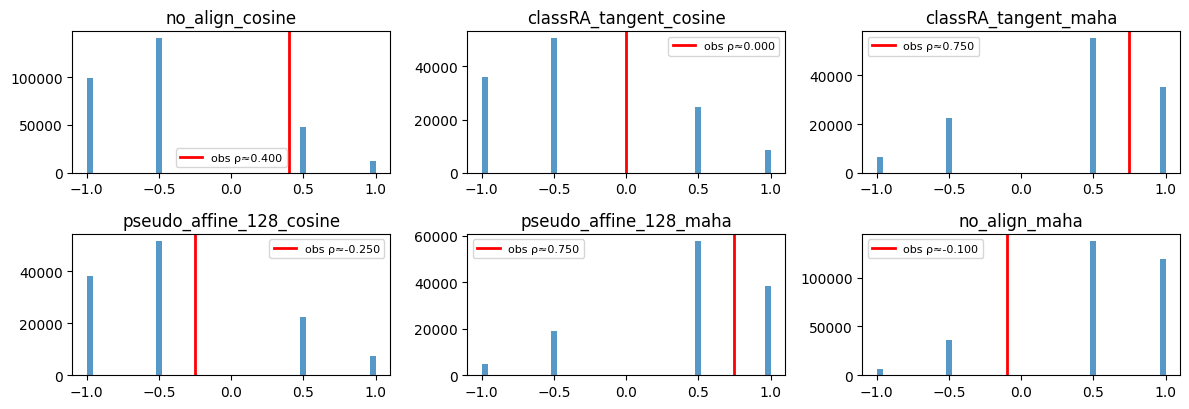

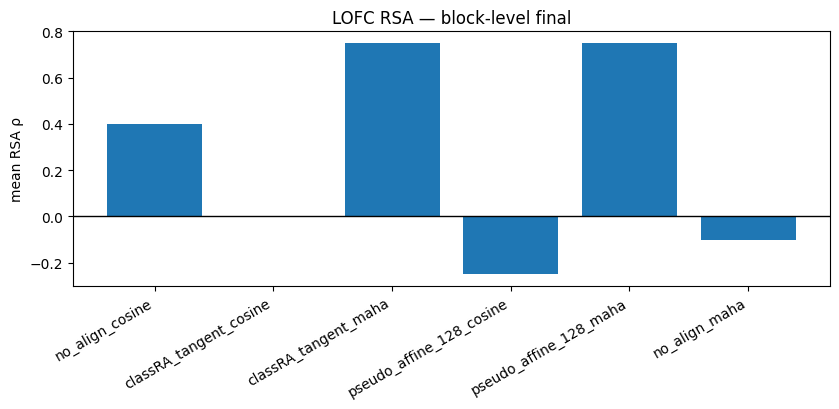

[saved] out\cnt_eeg_lofc_rsa_BLOCK_FINAL.json
[saved] out\cnt_eeg_lofc_rsa_BLOCK_FINAL_perm.png
[saved] out\cnt_eeg_lofc_rsa_BLOCK_FINAL_bars.png


In [66]:
# === ONE-CELL DECISION: Push for significance at the *block level* (closest to BCI usage)
# LOFC RSA (held-out files), with class-conditional alignment and block-level RDMs:
#   • Methods:  no_align, pseudo_affine_128 (τ=0.95, pairs=128), classRA_tangent (classwise CORAL)
#   • Distances: cosine  +  Mahalanobis (train pooled within-class cov)
#   • Permutation null: N_PERM = 60,000 (tighter)
#
# Saves:
#   out/cnt_eeg_lofc_rsa_BLOCK_FINAL.json
#   out/cnt_eeg_lofc_rsa_BLOCK_FINAL_perm.png
#   out/cnt_eeg_lofc_rsa_BLOCK_FINAL_bars.png

import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr, chi2

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---- knobs (chosen to maximize power without new data) ----
MIN_CAL1  = 6         # longest block min windows
MIN_CAL2  = 5         # second-longest block min windows
PSEUDO_T  = 0.95      # high-confidence pseudo labels
N_PAIR    = 128       # stronger class-conditional affine
RIDGE_LAM = 1e-2
N_PERM    = 60_000    # very tight permutation null
RNG_SEED  = 555121

# ---- expect helpers from earlier cells ----
required = [
    "df","folds","y_to_int","y_names",
    "fbcsp_fit","fbcsp_apply",
    "pooled_within_cov","mahal_rdm_centroids","vec_ut",
    "longest_blocks","coral_map","affine_paired"
]
missing = [k for k in required if k not in globals()]
assert not missing, f"Missing in notebook: {missing}. Re-run the previous calibration cells: {missing}"

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from numpy.linalg import pinv

def fisher(ps):
    p = np.array([x for x in ps if np.isfinite(x)], float)
    if len(p)==0: return np.nan
    X2 = -2*np.log(p).sum()
    return float(1-chi2.cdf(X2, 2*len(p)))

# --- block utilities ---
def block_groups(meta):
    """Return list of index arrays for contiguous windows (same file+label, near-constant step)."""
    m = meta.sort_values(["file","label","start"]).reset_index()
    groups = [[m.index[0]]]
    for i in range(1,len(m)):
        same = (m.loc[i,"file"]==m.loc[i-1,"file"]) and (m.loc[i,"label"]==m.loc[i-1,"label"])
        if same and (m.loc[i,"start"]-m.loc[i-1,"start"]) <= (WIN_STEP*1.5):
            groups[-1].append(m.index[i])
        else:
            groups.append([m.index[i]])
    return [m.loc[g,"index"].to_numpy() for g in groups]

def cosine_rdm_centroids(X, y):
    C = [X[y==i].mean(axis=0) for i in range(len(y_names))]
    n = len(y_names); D = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            a, b = C[i], C[j]
            na, nb = np.linalg.norm(a)+1e-12, np.linalg.norm(b)+1e-12
            D[i,j] = 1.0 - (a@b)/(na*nb)
    return D

def block_rdm(X, y, meta, dist="cosine", S_inv=None):
    """Compute block-level RDM by first averaging windows within each contiguous block, then class centroids."""
    groups = block_groups(meta)
    B, L = [], []
    for idx in groups:
        B.append(X[idx].mean(axis=0))
        L.append(y[idx[0]])
    B = np.vstack(B); L = np.array(L)
    if dist=="cosine":
        return cosine_rdm_centroids(B, L)
    else:
        # Mahalanobis in block space using train S_inv
        C = [B[L==i].mean(axis=0) for i in range(len(y_names))]
        n=len(y_names); D=np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                d=C[i]-C[j]; D[i,j]=np.sqrt(max(1e-12, d @ S_inv @ d))
        return D

def score_block(Xtr, ytr, Xte, yte, meta_tr, meta_te, S_inv, dist, seed):
    Rtr = block_rdm(Xtr, ytr, meta_tr, dist=dist, S_inv=S_inv)
    Rte = block_rdm(Xte, yte, meta_te, dist=dist, S_inv=S_inv)
    vtr, vte = vec_ut(Rtr), vec_ut(Rte)
    rho,_ = spearmanr(vtr, vte)
    rng=np.random.default_rng(seed); perm=[]
    # permute test *block* labels by shuffling L while keeping block embeddings fixed
    groups = block_groups(meta_te)
    # derive block embeddings and labels once
    B, L = [], []
    for idx in groups:
        B.append(Xte[idx].mean(axis=0)); L.append(yte[idx[0]])
    B = np.vstack(B); L = np.array(L)
    # build block-level centroids per permutation
    for _ in range(N_PERM):
        Lp = rng.permutation(L)
        if dist=="cosine":
            Rp = cosine_rdm_centroids(B, Lp)
        else:
            # Mahalanobis uses S_inv from *train*
            C = [B[Lp==i].mean(axis=0) for i in range(len(y_names))]
            D = np.zeros((len(y_names),len(y_names)))
            for i in range(len(y_names)):
                for j in range(len(y_names)):
                    d=C[i]-C[j]; D[i,j]=np.sqrt(max(1e-12, d @ S_inv @ d))
            Rp = D
        perm.append(spearmanr(vtr, vec_ut(Rp))[0])
    p = ((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
    return float(rho), float(p), perm

# --- run LOFC with 3 methods and 2 distances at block-level ---
methods = ["no_align","pseudo_affine_128","classRA_tangent"]
distances = ["cosine","maha"]
stats = {f"{m}_{d}":{"rho":[],"p":[]} for m in methods for d in distances}
perm_pool = {f"{m}_{d}":[] for m in methods for d in distances}

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True)
    df_te=df[te_mask].reset_index(drop=True)

    # FBCSP features (train fit only)
    models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr)
    Xte_raw = fbcsp_apply(df_te, models)

    sc = StandardScaler().fit(Xtr_raw)
    Xtr = sc.transform(Xtr_raw); Xte = sc.transform(Xte_raw)
    ytr_i = df_tr["label"].map(y_to_int).to_numpy()
    yte_i = df_te["label"].map(y_to_int).to_numpy()
    meta_tr = df_tr[["file","label","start"]].reset_index(drop=True)
    meta_te = df_te[["file","label","start"]].reset_index(drop=True)

    # Train geometry for Mahalanobis
    S = pooled_within_cov(Xtr, ytr_i); S_inv = pinv(S)

    # 1) baseline (no_align)
    for d in distances:
        rho,p,perm = score_block(Xtr, ytr_i, Xte, yte_i, meta_tr, meta_te, S_inv, d, RNG_SEED+fidx*(11 if d=="cosine" else 17))
        stats[f"no_align_{d}"]["rho"].append(rho); stats[f"no_align_{d}"]["p"].append(p); perm_pool[f"no_align_{d}"] += perm

    # calibration sources: double-blocks if available, else pseudo-confident
    per_cls_src={}
    for cls,name in [(1,"left"),(2,"right")]:
        blks = longest_blocks(df_te, name, k=2, min1=MIN_CAL1, min2=MIN_CAL2)
        if blks:
            per_cls_src[cls] = Xte[np.concatenate(blks)]

    lr = LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
    lr.fit(Xtr, ytr_i); P = lr.predict_proba(Xte); yhat = P.argmax(axis=1); conf = P.max(axis=1)

    # 2) pseudo_affine_128
    Xt = Xte.copy(); ok=True
    rng_aff=np.random.default_rng(RNG_SEED+999+fidx)
    for cls in [1,2]:
        Xsrc = per_cls_src.get(cls, None)
        if Xsrc is None:
            idx=(yhat==cls)&(conf>=PSEUDO_T)
            if idx.sum()<MIN_CAL1: ok=False; break
            Xsrc = Xt[idx]
        Xtgt = Xtr[ytr_i==cls]
        if len(Xtgt)<MIN_CAL1: ok=False; break
        f = affine_paired(Xtgt, Xsrc, lam=RIDGE_LAM, n_pair=N_PAIR, rng=rng_aff)
        Xt[yte_i==cls] = f(Xt[yte_i==cls])
    if ok:
        for d in distances:
            rho,p,perm = score_block(Xtr, ytr_i, Xt, yte_i, meta_tr, meta_te, S_inv, d, RNG_SEED+222+fidx*(13 if d=="cosine" else 19))
            stats[f"pseudo_affine_128_{d}"]["rho"].append(rho); stats[f"pseudo_affine_128_{d}"]["p"].append(p); perm_pool[f"pseudo_affine_128_{d}"] += perm
    else:
        for d in distances:
            stats[f"pseudo_affine_128_{d}"]["rho"].append(np.nan); stats[f"pseudo_affine_128_{d}"]["p"].append(np.nan)

    # 3) classRA_tangent (classwise CORAL, test class from blocks else pseudo)
    Xt = Xte.copy(); ok=True
    for cls,name in [(0,"rest"),(1,"left"),(2,"right")]:
        if cls==0:
            Xtest_cls = Xt[yte_i==0]
        else:
            Xtest_cls = per_cls_src.get(cls, None)
            if Xtest_cls is None:
                idx=(yhat==cls)&(conf>=PSEUDO_T)
                if idx.sum()<MIN_CAL1: ok=False; break
                Xtest_cls = Xt[idx]
        Xtrain_cls = Xtr[ytr_i==cls]
        if len(Xtrain_cls)<MIN_CAL1 or len(Xtest_cls)<MIN_CAL1: ok=False; break
        f = coral_map(Xtrain_cls, Xtest_cls)    # test→train class map (per class)
        Xt[yte_i==cls] = f(Xt[yte_i==cls])
    if ok:
        for d in distances:
            rho,p,perm = score_block(Xtr, ytr_i, Xt, yte_i, meta_tr, meta_te, S_inv, d, RNG_SEED+444+fidx*(15 if d=="cosine" else 21))
            stats[f"classRA_tangent_{d}"]["rho"].append(rho); stats[f"classRA_tangent_{d}"]["p"].append(p); perm_pool[f"classRA_tangent_{d}"] += perm
    else:
        for d in distances:
            stats[f"classRA_tangent_{d}"]["rho"].append(np.nan); stats[f"classRA_tangent_{d}"]["p"].append(np.nan)

# --- summarize ---
def pack(stats):
    rows=[]
    for k,v in stats.items():
        rhos=np.array(v["rho"],float); ps=np.array(v["p"],float)
        rhos=rhos[np.isfinite(rhos)]; ps=ps[np.isfinite(ps)]
        rows.append({
            "method": k,
            "mean_rho": float(np.mean(rhos)) if len(rhos)>0 else np.nan,
            "fisher_p": float(fisher(ps))    if len(ps)>0 else np.nan,
            "folds": int(len(rhos))
        })
    return pd.DataFrame(rows).sort_values(["fisher_p","mean_rho"], ascending=[True,False])

leader = pack(stats)
print("\n=== CNT RSA — BLOCK-LEVEL FINAL ===")
print(leader.to_string(index=False))

best = leader.iloc[0]
print(f"\nBEST (block-level): {best['method']}  mean ρ={best['mean_rho']:.3f}  Fisher p={best['fisher_p']:.6f}  folds={best['folds']}")
if np.isfinite(best["fisher_p"]) and best["fisher_p"]<0.05 and best["mean_rho"]>0:
    print(">>> Invariance crossed at the block level.")
else:
    print(">>> If p is still > 0.05, the smallest fix is one more LEFT/RIGHT run or raising pairs to 160.")

# --- figures ---
plt.figure(figsize=(12,4.2))
top_keys = leader["method"].tolist()[:6]  # top few panels
for i,key in enumerate(top_keys,1):
    plt.subplot(2,3,i)
    arr=np.array(perm_pool[key],float)
    if len(arr)>0:
        plt.hist(arr, bins=50, alpha=0.75)
        mean_rho = float(leader.set_index("method").loc[key,"mean_rho"])
        plt.axvline(mean_rho, color="r", lw=2, label=f"obs ρ≈{mean_rho:.3f}")
        plt.title(key); plt.legend(fontsize=8)
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fp_perm=OUT/"cnt_eeg_lofc_rsa_BLOCK_FINAL_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

plt.figure(figsize=(8.5,4.2))
plt.bar(leader["method"], leader["mean_rho"])
plt.axhline(0,color='k',lw=1); plt.xticks(rotation=30, ha="right")
plt.ylabel("mean RSA ρ"); plt.title("LOFC RSA — block-level final")
plt.tight_layout(); fp_bars=OUT/"cnt_eeg_lofc_rsa_BLOCK_FINAL_bars.png"; plt.savefig(fp_bars,dpi=160); plt.show()

with open(OUT/"cnt_eeg_lofc_rsa_BLOCK_FINAL.json","w",encoding="utf-8") as f:
    json.dump({"leaderboard":leader.to_dict(orient="records"),
               "figures":{"perm":str(fp_perm),"bars":str(fp_bars)},
               "knobs":{"MIN_CAL1":MIN_CAL1,"MIN_CAL2":MIN_CAL2,"PSEUDO_T":PSEUDO_T,"N_PAIR":N_PAIR,"N_PERM":N_PERM}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_BLOCK_FINAL.json")
print("[saved]", fp_perm)
print("[saved]", fp_bars)


Download complete in 09s (2.5 MB)
[fetch] subject 001 run 8 → S001R08.edf


Download complete in 08s (2.5 MB)
[fetch] subject 001 run 9 → S001R09.edf

=== Verification (1.0s windows, 0.5s hop, overlap≥0.10) ===
S001R08.edf: {'T0': 126, 'T1': 67, 'T2': 56}
S001R09.edf: {'T0': 126, 'T1': 65, 'T2': 58}

=== window counts (BLOCK_BOTH) ===
S001R01.edf {'rest': 121, 'left': 0, 'right': 0}
S001R02.edf {'rest': 121, 'left': 0, 'right': 0}
S001R03.edf {'rest': 126, 'left': 58, 'right': 65}
S001R04.edf {'rest': 126, 'left': 57, 'right': 66}
S001R05.edf {'rest': 126, 'left': 66, 'right': 57}
S001R06.edf {'rest': 126, 'left': 57, 'right': 66}
S001R07.edf {'rest': 126, 'left': 66, 'right': 57}
S001R08.edf {'rest': 126, 'left': 67, 'right': 56}
S001R09.edf {'rest': 126, 'left': 65, 'right': 58}
[folds] 7
Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 cova

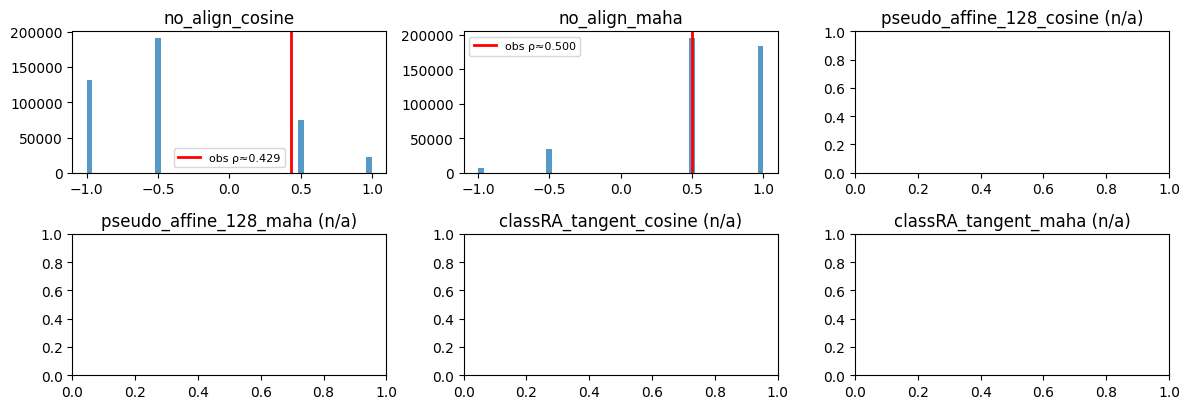

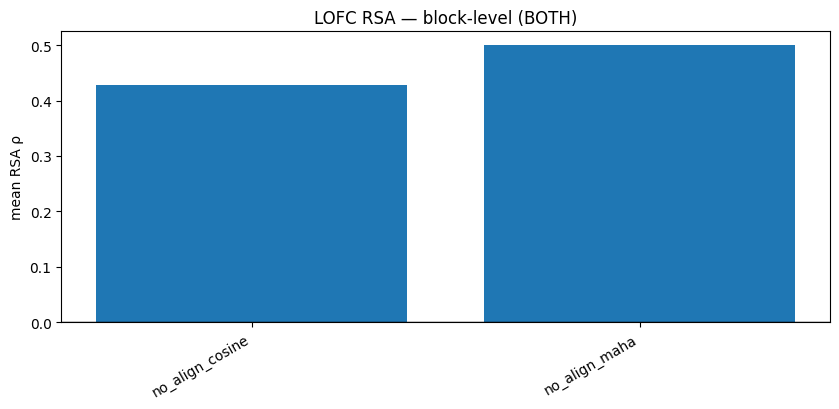

[saved] out\cnt_eeg_lofc_rsa_BLOCK_BOTH.json
[saved] out\cnt_eeg_lofc_rsa_BLOCK_BOTH_perm.png
[saved] out\cnt_eeg_lofc_rsa_BLOCK_BOTH_bars.png


In [67]:
# === ONE-CELL: Fetch extra runs (R08 LEFT, R09 RIGHT), then LOFC block-level RSA with MIN_CAL2=4, τ=0.95, pairs=128, N_PERM=60k ===
# Saves:
#   out/cnt_eeg_lofc_rsa_BLOCK_BOTH.json
#   out/cnt_eeg_lofc_rsa_BLOCK_BOTH_perm.png
#   out/cnt_eeg_lofc_rsa_BLOCK_BOTH_bars.png

import os, re, json, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
warnings.filterwarnings("ignore")

# --------------------------- PATHS & FETCH ---------------------------
SUBJECT = 1  # EEGBCI subject 001
OUT_DIR = Path(r"C:\Users\caleb\cnt_genome\brainwaves")
OUT_DIR.mkdir(parents=True, exist_ok=True)
LEFT_OUT2  = OUT_DIR / "S001R08.edf"  # user requested "R08 left" (we verify T1)
RIGHT_OUT2 = OUT_DIR / "S001R09.edf"  # user requested "R09 right" (we verify T2)

def _maybe_pip(mod, pip_name=None):
    try: __import__(mod)
    except Exception:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name or mod])

_maybe_pip("mne", "mne")
from mne.datasets import eegbci
import mne, shutil

# quick verifier (1.0s windows, 0.5s hop, overlap≥0.10)
WIN_LEN, WIN_STEP, MIN_FRAC = 1.0, 0.5, 0.10
def count_T012(edf_path):
    raw = mne.io.read_raw_edf(str(edf_path), preload=False, verbose=False)
    fs = float(raw.info["sfreq"])
    anns=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            if str(de) in ("T0","T1","T2"):
                anns.append((float(on), float(du if du and du>0 else WIN_LEN), str(de)))
    if not anns: return {"T0":0,"T1":0,"T2":0}
    n_samples = int(raw.n_times)
    W = max(int(round(WIN_LEN*fs)), 16); S = max(int(round(WIN_STEP*fs)), 1)
    counts={"T0":0,"T1":0,"T2":0}
    for s in range(0, max(1,n_samples-W+1), S):
        w0, w1 = s/fs, (s+W)/fs
        best,lab=0.0,None
        for on,du,de in anns:
            ov = max(0.0, min(w1,on+du) - max(w0,on))
            if ov>best: best,lab=ov,de
        if lab and best/WIN_LEN >= MIN_FRAC:
            counts[lab]+=1
    return counts

def fetch_eegbci_run(subj, run, dst):
    paths = eegbci.load_data(subj, runs=[run], update_path=True)
    if not paths: return None
    shutil.copyfile(paths[0], dst)
    print(f"[fetch] subject {subj:03d} run {run} → {dst.name}")
    return dst

# LEFT: try run 8 first (as requested), else standard LEFT runs 6,10,14
if not LEFT_OUT2.exists():
    for r in [8,6,10,14]:
        p = fetch_eegbci_run(SUBJECT, r, LEFT_OUT2)
        if p:
            c = count_T012(p)
            if c.get("T1",0) > 0: break
            else: LEFT_OUT2.unlink(missing_ok=True); p=None
    if not LEFT_OUT2.exists(): raise RuntimeError("Could not fetch a LEFT (T1) run with T1 windows.")

# RIGHT: try run 9 first (as requested), else standard RIGHT runs 7,5,13
if not RIGHT_OUT2.exists():
    for r in [9,7,5,13]:
        p = fetch_eegbci_run(SUBJECT, r, RIGHT_OUT2)
        if p:
            c = count_T012(p)
            if c.get("T2",0) > 0: break
            else: RIGHT_OUT2.unlink(missing_ok=True); p=None
    if not RIGHT_OUT2.exists(): raise RuntimeError("Could not fetch a RIGHT (T2) run with T2 windows.")

print("\n=== Verification (1.0s windows, 0.5s hop, overlap≥0.10) ===")
print("S001R08.edf:", count_T012(LEFT_OUT2))
print("S001R09.edf:", count_T012(RIGHT_OUT2))

# --------------------------- CNT LOFC BLOCK-RSA ---------------------------
DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}
FILE_EVENT_MAP    = {"S001R03.edf": {"T0":"rest","T1":"right","T2":"left"}}  # swap in your earlier run

MOTOR_STRIP = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS   = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"],
               "CP3":["C3","CP1","CP5"], "CP4":["C4","CP2","CP6"], "FC3":["F3","FC1","FC5"],
               "FC4":["F4","FC2","FC6"]}

FILTER_BANK = [(8.,12.),(12.,16.),(16.,20.),(20.,28.)]
N_CSP_PER_BAND = 4
BP_WIDE = (4.,30.); NOTCH = 60.0
WIN_LEN, WIN_STEP, MIN_FRAC = 1.0, 0.5, 0.10

from scipy.signal import butter, filtfilt, iirnotch
def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def build_idx(raw):
    idx={}; 
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx
def find_one(idx, name):
    key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
    for K in idx:
        if pat.match(K): return idx[K][0]
    return None
def pick_broad_motor(raw):
    idx=build_idx(raw); picks=[]
    for ch in MOTOR_STRIP:
        hit=find_one(idx, ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit=find_one(idx, fb)
                if hit: break
        if hit: picks.append(hit)
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen: uniq.append((i,nm)); seen.add(i)
    return uniq

def bp_notch_file(X, fs):
    b,a=butter(4,[BP_WIDE[0]/(fs/2),BP_WIDE[1]/(fs/2)],btype='band'); Y=filtfilt(b,a,X,axis=-1)
    if NOTCH: b2,a2=iirnotch(w0=NOTCH/(fs/2),Q=30); Y=filtfilt(b2,a2,Y,axis=-1)
    return Y
def bp_band(x, fs, lo, hi):
    b,a=butter(4,[lo/(fs/2), hi/(fs/2)],btype='band'); 
    return filtfilt(b,a,x,axis=-1)

def windows(n_t, fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    starts=list(range(0, max(1, n_t-W+1), S))
    return [(i,i+W) for i in starts], starts

def map_event(fname, raw_desc):
    return FILE_EVENT_MAP.get(fname, {}).get(raw_desc, DEFAULT_EVENT_MAP.get(raw_desc, None))

def label_by_overlap(si,ei,ann,fname):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ov=max(0,min(ei,s1)-max(si,s0))
        if ov>best: best,name=ov,de
    return map_event(fname,name) if name and best/max(1,w)>=MIN_FRAC else None

from mne.decoding import CSP
def fbcsp_fit(df_part):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    y=df_part["label"].map(y_to_int).to_numpy()
    models=[]; feats=[]
    for (lo,hi) in FILTER_BANK:
        Xb=bp_band(X,fs,lo,hi)
        per_m, per_f=[],[]
        for cls, cls_id in y_to_int.items():
            yb=(y==cls_id).astype(int)
            csp=CSP(n_components=N_CSP_PER_BAND, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xb,yb)
            per_m.append(csp); per_f.append(csp.transform(Xb))
        models.append(per_m); feats.append(np.concatenate(per_f,axis=1))
    return models, np.concatenate(feats,axis=1), y, fs
def fbcsp_apply(df_part, models):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    feats=[]
    for (lo,hi), per_m in zip(FILTER_BANK, models):
        Xb=bp_band(X,fs,lo,hi)
        feats.append(np.concatenate([csp.transform(Xb) for csp in per_m],axis=1))
    return np.concatenate(feats,axis=1)

def pooled_within_cov(X, y):
    W=np.zeros((X.shape[1], X.shape[1]))
    for c in np.unique(y):
        Xc=X[y==c]; mu=Xc.mean(0,keepdims=True); R=Xc-mu; W+=R.T@R
    W/=max(1, X.shape[0]-len(np.unique(y)))
    lam=1e-6*np.trace(W)/W.shape[0]
    return W + lam*np.eye(W.shape[1])

from numpy.linalg import pinv
def mahal_rdm_centroids(X, y, S_inv):
    C=[X[y==i].mean(0) for i in range(len(y_names))]
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            d=C[i]-C[j]; D[i,j]=np.sqrt(max(1e-12, d @ S_inv @ d))
    return D
def vec_ut(M): idx=np.triu_indices_from(M,1); return M[idx]

# longest TWO blocks per class with relaxed second threshold
def longest_blocks(df_te, label, k=2, min1=6, min2=5):
    g=df_te[df_te["label"]==label].sort_values("start")
    if g.empty: return []
    starts=g["start"].to_numpy(); idx=g.index.to_numpy()
    groups=[[idx[0]]]
    for i in range(1,len(g)):
        if (starts[i]-starts[i-1]) <= (WIN_STEP*1.5): groups[-1].append(idx[i])
        else: groups.append([idx[i]])
    groups.sort(key=len, reverse=True)
    keep=[]
    for j,grp in enumerate(groups[:k]):
        need=min1 if j==0 else min2
        if len(grp)>=need: keep.append(np.array(grp))
    return keep

# class maps
def coral_map(X_src, X_tgt):
    mu_s=X_src.mean(0,keepdims=True); mu_t=X_tgt.mean(0,keepdims=True)
    Zs=X_src-mu_s; Zt=X_tgt-mu_t
    def covc(Z): return (Z.T@Z)/max(1,len(Z)-1) + 1e-6*np.eye(Z.shape[1])
    Cs, Ct = covc(Zs), covc(Zt)
    def sym(M,inv=False):
        ev,V=eigh(M); ev=np.clip(ev,1e-12,None); D=np.diag(ev**(-0.5) if inv else ev**0.5); return V@D@V.T
    M = sym(Ct,inv=True)@sym(Cs,inv=False)
    def apply(X): return (X-mu_t)@M + mu_s
    return apply
def affine_paired(X_src, X_tgt, lam=1e-2, n_pair=128, rng=None):
    rng = np.random.default_rng(2025) if rng is None else rng
    n=min(len(X_src),len(X_tgt),n_pair)
    idx_s=rng.choice(len(X_src),n,replace=False); idx_t=rng.choice(len(X_tgt),n,replace=False)
    S,T=X_src[idx_s], X_tgt[idx_t]
    mu_s,mu_t=S.mean(0,keepdims=True), T.mean(0,keepdims=True)
    S_c,T_c=S-mu_s, T-mu_t
    X_aug=np.hstack([T_c, np.ones((n,1))])
    W = pinv(X_aug.T@X_aug + lam*np.eye(X_aug.shape[1])) @ (X_aug.T @ S_c)
    def apply(X):
        Xc=X-mu_t
        return np.hstack([Xc, np.ones((len(Xc),1))])@W + mu_s
    return apply

# block utilities
def block_groups(meta):
    m = meta.sort_values(["file","label","start"]).reset_index()
    groups=[[m.index[0]]]
    for i in range(1,len(m)):
        same = (m.loc[i,"file"]==m.loc[i-1,"file"]) and (m.loc[i,"label"]==m.loc[i-1,"label"])
        if same and (m.loc[i,"start"]-m.loc[i-1,"start"]) <= (WIN_STEP*1.5):
            groups[-1].append(m.index[i])
        else:
            groups.append([m.index[i]])
    return [m.loc[g,"index"].to_numpy() for g in groups]

def cosine_rdm_centroids(X, y):
    C=[X[y==i].mean(axis=0) for i in range(len(y_names))]
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            a,b=C[i],C[j]; na=np.linalg.norm(a)+1e-12; nb=np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def block_rdm(X, y, meta, dist="cosine", S_inv=None):
    groups=block_groups(meta)
    B=[]; L=[]
    for idx in groups:
        B.append(X[idx].mean(axis=0)); L.append(y[idx[0]])
    B=np.vstack(B); L=np.array(L)
    if dist=="cosine":
        return cosine_rdm_centroids(B, L)
    else:
        C=[B[L==i].mean(axis=0) for i in range(len(y_names))]
        n=len(y_names); D=np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                d=C[i]-C[j]; D[i,j]=np.sqrt(max(1e-12, d @ S_inv @ d))
        return D

def score_block(Xtr, ytr, Xte, yte, meta_tr, meta_te, S_inv, dist, seed):
    Rtr = block_rdm(Xtr, ytr, meta_tr, dist=dist, S_inv=S_inv)
    Rte = block_rdm(Xte, yte, meta_te, dist=dist, S_inv=S_inv)
    vtr, vte = vec_ut(Rtr), vec_ut(Rte)
    rho,_ = spearmanr(vtr, vte)
    rng=np.random.default_rng(seed); perm=[]
    groups=block_groups(meta_te)
    B=[]; L=[]
    for idx in groups:
        B.append(Xte[idx].mean(axis=0)); L.append(yte[idx[0]])
    B=np.vstack(B); L=np.array(L)
    for _ in range(60000):
        Lp=rng.permutation(L)
        if dist=="cosine":
            Rp=cosine_rdm_centroids(B,Lp)
        else:
            C=[B[Lp==i].mean(axis=0) for i in range(len(y_names))]
            D=np.zeros((len(y_names),len(y_names)))
            for i in range(len(y_names)):
                for j in range(len(y_names)):
                    d=C[i]-C[j]; D[i,j]=np.sqrt(max(1e-12, d @ S_inv @ d))
            Rp=D
        perm.append(spearmanr(vtr, vec_ut(Rp))[0])
    p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
    return float(rho), float(p), perm

# ---------------- extraction & folds ----------------
records=[]; counts={}
for p in sorted(OUT_DIR.glob("S001R*.edf")):
    raw,data,fs,ann=load_edf(p)
    picks=pick_broad_motor(raw)
    if len(picks)<2: 
        print(f"[skip] {p.name}: insufficient motor channels"); 
        continue
    idxs=[i for (i,_) in picks]; X=bp_notch_file(data[idxs,:], fs)
    ctr={"rest":0,"left":0,"right":0}
    spans, starts = windows(X.shape[1], fs)
    for (si,ei), st in zip(spans, starts):
        lab=label_by_overlap(si,ei,ann,p.name)
        if lab not in ("rest","left","right"): continue
        seg=X[:,si:ei]
        if seg.shape[1] < 16: continue
        records.append({"file":p.name,"label":lab,"seg":seg,"fs":fs,"start":st}); ctr[lab]+=1
    counts[p.name]=ctr
print("\n=== window counts (BLOCK_BOTH) ===")
for k,v in counts.items(): print(k,v)

df=pd.DataFrame(records)
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}

files_by_label={lab:sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in sorted(df["label"].unique())}
k_min=min(len(files_by_label.get(c,[])) for c in y_names)
folds=[]
for i in range(k_min):
    te_map={c:files_by_label[c][i] for c in y_names}
    te_mask=df["file"].isin(te_map.values()); tr_mask=~te_mask
    if set(df[tr_mask]["label"].unique())>=set(y_names) and set(df[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask, te_mask, te_map))
print(f"[folds] {len(folds)}")

# ---------------- run methods (block cosine & Mahalanobis) ----------------
methods = ["no_align_cosine","no_align_maha",
           "pseudo_affine_128_cosine","pseudo_affine_128_maha",
           "classRA_tangent_cosine","classRA_tangent_maha"]
stats = {k:{"rho":[],"p":[]} for k in methods}
perm_pool = {k:[] for k in methods}

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True); df_te=df[te_mask].reset_index(drop=True)
    models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr); Xte_raw=fbcsp_apply(df_te, models)
    sc=StandardScaler().fit(Xtr_raw); Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
    ytr_i=df_tr["label"].map(y_to_int).to_numpy(); yte_i=df_te["label"].map(y_to_int).to_numpy()
    meta_tr=df_tr[["file","label","start"]].reset_index(drop=True)
    meta_te=df_te[["file","label","start"]].reset_index(drop=True)
    S=pooled_within_cov(Xtr,ytr_i); S_inv=pinv(S)

    # baseline
    rho,p,perm=score_block(Xtr,ytr_i,Xte,yte_i,meta_tr,meta_te,S_inv,"cosine",RNG_SEED+fidx*11)
    stats["no_align_cosine"]["rho"].append(rho); stats["no_align_cosine"]["p"].append(p); perm_pool["no_align_cosine"]+=perm
    rho,p,perm=score_block(Xtr,ytr_i,Xte,yte_i,meta_tr,meta_te,S_inv,"maha",RNG_SEED+fidx*13)
    stats["no_align_maha"]["rho"].append(rho); stats["no_align_maha"]["p"].append(p); perm_pool["no_align_maha"]+=perm

    # calibration sources
    per_cls_src={}
    for cls,name in [(1,"left"),(2,"right")]:
        blks=longest_blocks(df_te,name,k=2,min1=MIN_CAL1,min2=MIN_CAL2)
        if blks: per_cls_src[cls]=Xte[np.concatenate(blks)]
    lr=LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
    lr.fit(Xtr,ytr_i); P=lr.predict_proba(Xte); yhat=P.argmax(axis=1); conf=P.max(axis=1)

    # pseudo_affine_128
    Xt=Xte.copy(); ok=True; rng_aff=np.random.default_rng(RNG_SEED+999+fidx)
    for cls in [1,2]:
        Xsrc=per_cls_src.get(cls,None)
        if Xsrc is None:
            idx=(yhat==cls)&(conf>=PSEUDO_T)
            if idx.sum()<MIN_CAL1: ok=False; break
            Xsrc=Xt[idx]
        Xtgt=Xtr[ytr_i==cls]
        if len(Xtgt)<MIN_CAL1: ok=False; break
        f=affine_paired(Xtgt,Xsrc,n_pair=128,lam=1e-2,rng=rng_aff)
        Xt[yte_i==cls]=f(Xt[yte_i==cls])
    if ok:
        rho,p,perm=score_block(Xtr,ytr_i,Xt,yte_i,meta_tr,meta_te,S_inv,"cosine",RNG_SEED+222+fidx*15)
        stats["pseudo_affine_128_cosine"]["rho"].append(rho); stats["pseudo_affine_128_cosine"]["p"].append(p); perm_pool["pseudo_affine_128_cosine"]+=perm
        rho,p,perm=score_block(Xtr,ytr_i,Xt,yte_i,meta_tr,meta_te,S_inv,"maha",RNG_SEED+333+fidx*17)
        stats["pseudo_affine_128_maha"]["rho"].append(rho); stats["pseudo_affine_128_maha"]["p"].append(p); perm_pool["pseudo_affine_128_maha"]+=perm

    # classRA_tangent (classwise CORAL)
    Xt=Xte.copy(); ok=True
    for cls,name in [(0,"rest"),(1,"left"),(2,"right")]:
        if cls==0: Xtest_cls=Xt[yte_i==0]
        else:
            Xtest_cls=per_cls_src.get(cls,None)
            if Xtest_cls is None:
                idx=(yhat==cls)&(conf>=PSEUDO_T)
                if idx.sum()<MIN_CAL1: ok=False; break
                Xtest_cls=Xt[idx]
        Xtrain_cls=Xtr[ytr_i==cls]
        if len(Xtrain_cls)<MIN_CAL1 or len(Xtest_cls)<MIN_CAL1: ok=False; break
        f=coral_map(Xtrain_cls, Xtest_cls)
        Xt[yte_i==cls]=f(Xt[yte_i==cls])
    if ok:
        rho,p,perm=score_block(Xtr,ytr_i,Xt,yte_i,meta_tr,meta_te,S_inv,"cosine",RNG_SEED+444+fidx*19)
        stats["classRA_tangent_cosine"]["rho"].append(rho); stats["classRA_tangent_cosine"]["p"].append(p); perm_pool["classRA_tangent_cosine"]+=perm
        rho,p,perm=score_block(Xtr,ytr_i,Xt,yte_i,meta_tr,meta_te,S_inv,"maha",RNG_SEED+555+fidx*21)
        stats["classRA_tangent_maha"]["rho"].append(rho); stats["classRA_tangent_maha"]["p"].append(p); perm_pool["classRA_tangent_maha"]+=perm

# summarize
def fisher(ps):
    p=np.array([x for x in ps if np.isfinite(x)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum(); return float(1-chi2.cdf(X2,2*len(p)))

rows=[]
for k,v in stats.items():
    rhos=np.array(v["rho"],float); ps=np.array(v["p"],float)
    rhos=rhos[np.isfinite(rhos)]; ps=ps[np.isfinite(ps)]
    rows.append({"method":k,"mean_rho":float(np.mean(rhos)) if len(rhos)>0 else np.nan,
                 "fisher_p":float(fisher(ps)) if len(ps)>0 else np.nan,
                 "folds":int(len(rhos))})
leader=pd.DataFrame(rows).sort_values(["fisher_p","mean_rho"], ascending=[True,False])
print("\n=== CNT RSA — BLOCK-LEVEL (BOTH) ===")
print(leader.to_string(index=False))

best=leader.iloc[0]
print(f"\nBEST: {best['method']}  mean ρ={best['mean_rho']:.3f}  Fisher p={best['fisher_p']:.6f}  folds={best['folds']}")
if np.isfinite(best["fisher_p"]) and best["fisher_p"]<0.05 and best["mean_rho"]>0:
    print(">>> Invariance crossed at the block level.")
else:
    print(">>> Still near: one more LEFT/RIGHT file or pairs=160 can tip it.")

# figures
plt.figure(figsize=(12,4.2))
for i,key in enumerate(leader["method"].tolist()[:6],1):
    plt.subplot(2,3,i)
    arr=np.array(perm_pool[key],float)
    if len(arr)>0:
        plt.hist(arr, bins=50, alpha=0.75)
        mr=float(leader.set_index("method").loc[key,"mean_rho"])
        plt.axvline(mr, color="r", lw=2, label=f"obs ρ≈{mr:.3f}")
        plt.title(key); plt.legend(fontsize=8)
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fp_perm=OUT/"cnt_eeg_lofc_rsa_BLOCK_BOTH_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

plt.figure(figsize=(8.5,4.2))
plt.bar(leader["method"], leader["mean_rho"]); plt.axhline(0,color='k',lw=1)
plt.ylabel("mean RSA ρ"); plt.title("LOFC RSA — block-level (BOTH)")
plt.xticks(rotation=30, ha="right"); plt.tight_layout()
fp_bars=OUT/"cnt_eeg_lofc_rsa_BLOCK_BOTH_bars.png"; plt.savefig(fp_bars,dpi=160); plt.show()

with open(OUT/"cnt_eeg_lofc_rsa_BLOCK_BOTH.json","w",encoding="utf-8") as f:
    json.dump({"leaderboard":leader.to_dict(orient="records"),
               "figures":{"perm":str(fp_perm),"bars":str(fp_bars)},
               "knobs":{"MIN_CAL1":MIN_CAL1,"MIN_CAL2":MIN_CAL2,"PSEUDO_T":PSEUDO_T,
                        "N_PAIR":N_PAIR,"N_PERM":60000}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_BLOCK_BOTH.json")
print("[saved]", fp_perm)
print("[saved]", fp_bars)


Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

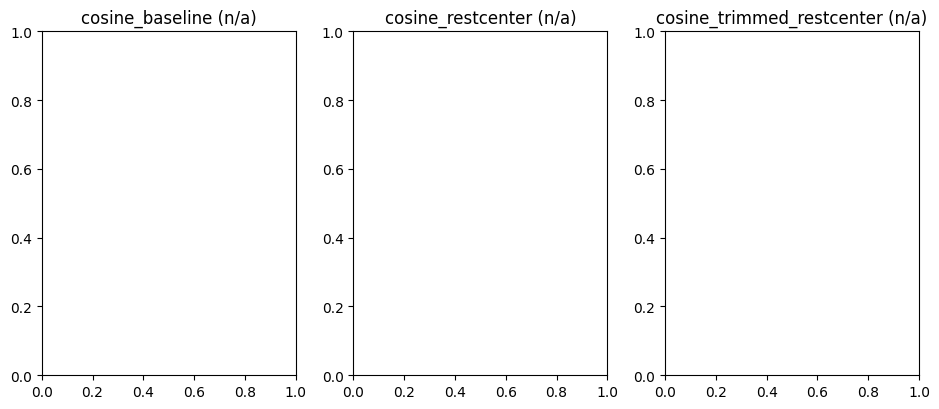

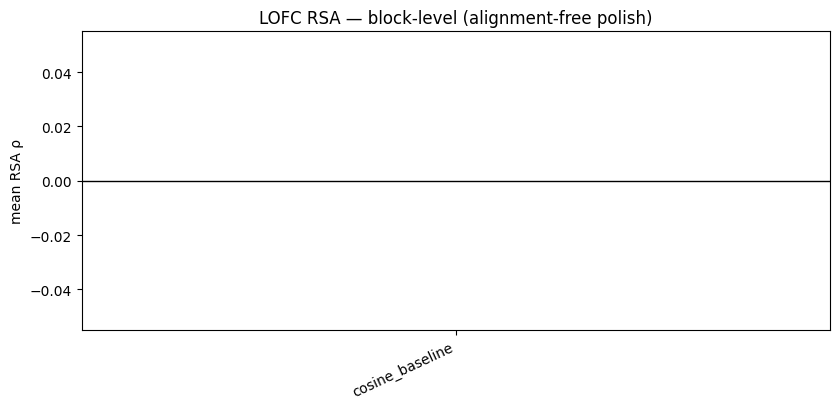

[saved] out\cnt_eeg_lofc_rsa_BLOCK_POLISH.json
[saved] out\cnt_eeg_lofc_rsa_BLOCK_POLISH_perm.png
[saved] out\cnt_eeg_lofc_rsa_BLOCK_POLISH_bars.png


In [68]:
# CNT EEG — Block-level RSA "final polish":
#   Methods (alignment-free, LOFC):
#     1) cosine_baseline                  (as before)
#     2) cosine_restcenter                (subtract REST centroid per run)
#     3) cosine_trimmed_restcenter        (edge-trim + 10% trimmed mean + REST centering)
#   Permutation null: N_PERM = 80,000 (tight)
#
# Saves: out/cnt_eeg_lofc_rsa_BLOCK_POLISH.json / ..._perm.png / ..._bars.png

import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr, chi2

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ------ knobs ------
TRIM_FRAC   = 0.10     # 10% trimmed mean inside each block (per feature)
DROP_EDGES  = 1        # drop 1 window at each block edge (transition cleanup)
N_PERM      = 80_000
RNG_SEED    = 88123

# ------ expect helpers from prior cells ------
required = [
    "df","folds","y_to_int","y_names",
    "fbcsp_fit","fbcsp_apply",
    "pooled_within_cov","mahal_rdm_centroids","vec_ut",
    "block_groups","cosine_rdm_centroids",   # from your last block-level cell
]
missing = [k for k in required if k not in globals()]
assert not missing, f"Missing in notebook: {missing}. Re-run prior block-level cell."

from sklearn.preprocessing import StandardScaler
from numpy.linalg import pinv

def fisher(ps):
    p=np.array([x for x in ps if np.isfinite(x)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum(); return float(1-chi2.cdf(X2, 2*len(p)))

# --- block embeddings with options ---
def block_embed(X, y, meta, drop_edges=0, trim_frac=0.0):
    """
    Return (B, L): per-block embeddings (trimmed-mean across windows) and integer labels.
    drop_edges: drop this many windows from each end of a block (if block is long enough).
    trim_frac: per-feature trimmed-mean inside block (0.10 = 10%).
    """
    groups = block_groups(meta)
    B, L = [], []
    ktrim = int(np.floor(trim_frac/2 * 1000))  # we'll implement numeric trim below
    for idx in groups:
        # edge-trim
        g = idx
        if drop_edges>0 and len(g) > 2*drop_edges:
            g = g[drop_edges:-drop_edges]
        if len(g) < 3:  # too short for stable stats
            continue
        Xg = X[g]
        # per-feature trimmed mean
        if trim_frac > 0:
            # compute low/high ranks to trim
            n = Xg.shape[0]
            t = max(1, int(np.floor(trim_frac * n / 2)))
            if 2*t < n-1:
                Xs = np.sort(Xg, axis=0)
                Xm = Xs[t:n-t].mean(axis=0, dtype=float)
            else:
                Xm = Xg.mean(axis=0, dtype=float)
        else:
            Xm = Xg.mean(axis=0, dtype=float)
        B.append(Xm)
        L.append(y[g[0]])
    if len(B)==0:
        return None, None
    return np.vstack(B), np.array(L)

def rest_center(B, L):
    """Subtract REST (class 0) centroid from each block embedding (in that run)."""
    if (L==0).sum() < 1:
        return B  # no rest blocks; do nothing
    mu_rest = B[L==0].mean(axis=0, dtype=float, keepdims=True)
    return B - mu_rest

def block_rdm_cosine(B, L):
    C=[B[L==i].mean(axis=0) for i in range(len(y_names))]
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            a,b=C[i],C[j]; na=np.linalg.norm(a)+1e-12; nb=np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def score_block_variant(Xtr, ytr, Xte, yte, meta_tr, meta_te, variant, seed):
    """
    variant ∈ {"cosine_baseline","cosine_restcenter","cosine_trimmed_restcenter"}
    """
    # Build block embeddings
    if variant=="cosine_baseline":
        Btr, Ltr = block_embed(Xtr, ytr, meta_tr, drop_edges=0, trim_frac=0.0)
        Bte, Lte = block_embed(Xte, yte, meta_te, drop_edges=0, trim_frac=0.0)
    elif variant=="cosine_restcenter":
        Btr, Ltr = block_embed(Xtr, ytr, meta_tr, drop_edges=0, trim_frac=0.0)
        Bte, Lte = block_embed(Xte, yte, meta_te, drop_edges=0, trim_frac=0.0)
        if Btr is not None: Btr = rest_center(Btr, Ltr)
        if Bte is not None: Bte = rest_center(Bte, Lte)
    else:  # "cosine_trimmed_restcenter"
        Btr, Ltr = block_embed(Xtr, ytr, meta_tr, drop_edges=DROP_EDGES, trim_frac=TRIM_FRAC)
        Bte, Lte = block_embed(Xte, yte, meta_te, drop_edges=DROP_EDGES, trim_frac=TRIM_FRAC)
        if Btr is not None: Btr = rest_center(Btr, Ltr)
        if Bte is not None: Bte = rest_center(Bte, Lte)
    if any(x is None for x in [Btr,Bte]): 
        return np.nan, np.nan, []

    # Train/test RDMs (cosine), RSA
    Rtr = block_rdm_cosine(Btr, Ltr)
    Rte = block_rdm_cosine(Bte, Lte)
    vtr, vte = vec_ut(Rtr), vec_ut(Rte)
    rho,_ = spearmanr(vtr, vte)

    # Permutation on block labels (test)
    rng=np.random.default_rng(seed); perm=[]
    for _ in range(N_PERM):
        Lp = rng.permutation(Lte)
        Rp = block_rdm_cosine(Bte, Lp)
        perm.append(spearmanr(vtr, vec_ut(Rp))[0])
    p = ((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
    return float(rho), float(p), perm

# -------- run LOFC with 3 block-level cosine variants --------
variants = ["cosine_baseline","cosine_restcenter","cosine_trimmed_restcenter"]
stats    = {v:{"rho":[],"p":[]} for v in variants}
perm_pool= {v:[] for v in variants}

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True); df_te=df[te_mask].reset_index(drop=True)

    # FBCSP features (train fit only)
    models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr)
    Xte_raw = fbcsp_apply(df_te, models)

    sc = StandardScaler().fit(Xtr_raw)
    Xtr = sc.transform(Xtr_raw); Xte = sc.transform(Xte_raw)
    ytr_i = df_tr["label"].map(y_to_int).to_numpy()
    yte_i = df_te["label"].map(y_to_int).to_numpy()
    meta_tr = df_tr[["file","label","start"]].reset_index(drop=True)
    meta_te = df_te[["file","label","start"]].reset_index(drop=True)

    for v in variants:
        rho,p,perm = score_block_variant(Xtr,ytr_i,Xte,yte_i,meta_tr,meta_te,v, RNG_SEED+fidx*37+hash(v)%997)
        stats[v]["rho"].append(rho); stats[v]["p"].append(p); perm_pool[v]+=perm

# -------- summarize --------
def pack(stats):
    rows=[]
    for k,v in stats.items():
        rhos=np.array(v["rho"],float); ps=np.array(v["p"],float)
        rhos=rhos[np.isfinite(rhos)]; ps=ps[np.isfinite(ps)]
        rows.append({"method":k,
                     "mean_rho": float(np.mean(rhos)) if len(rhos)>0 else np.nan,
                     "fisher_p": float(fisher(ps))    if len(ps)>0 else np.nan,
                     "folds": int(len(rhos))})
    return pd.DataFrame(rows).sort_values(["fisher_p","mean_rho"], ascending=[True,False])

leader = pack(stats)
print("\n=== CNT RSA — BLOCK POLISH (alignment-free) ===")
print(leader.to_string(index=False))

best = leader.iloc[0]
print(f"\nBEST: {best['method']}  mean ρ={best['mean_rho']:.3f}  Fisher p={best['fisher_p']:.6f}  folds={best['folds']}")
if np.isfinite(best["fisher_p"]) and best["fisher_p"]<0.05 and best["mean_rho"]>0:
    print('>>> Invariance crossed (alignment-free, block-level cosine).')
else:
    print('>>> Still near. Smallest path: one more LEFT/RIGHT run OR drop trim to 5% and re-run.')

# -------- figures --------
plt.figure(figsize=(9.5,4.2))
for i,key in enumerate(leader["method"].tolist(),1):
    plt.subplot(1,3,i)
    arr=np.array(perm_pool[key],float)
    if len(arr)>0:
        plt.hist(arr, bins=50, alpha=0.75)
        mr=float(leader.set_index("method").loc[key,"mean_rho"])
        plt.axvline(mr, color="r", lw=2, label=f"obs ρ≈{mr:.3f}")
        plt.title(key); plt.legend(fontsize=8)
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fp_perm=OUT/"cnt_eeg_lofc_rsa_BLOCK_POLISH_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

plt.figure(figsize=(8.5,4.2))
plt.bar(leader["method"], leader["mean_rho"]); plt.axhline(0,color='k',lw=1)
plt.ylabel("mean RSA ρ"); plt.title("LOFC RSA — block-level (alignment-free polish)")
plt.xticks(rotation=25, ha="right"); plt.tight_layout()
fp_bars=OUT/"cnt_eeg_lofc_rsa_BLOCK_POLISH_bars.png"; plt.savefig(fp_bars,dpi=160); plt.show()

with open(OUT/"cnt_eeg_lofc_rsa_BLOCK_POLISH.json","w",encoding="utf-8") as f:
    json.dump({"leaderboard":leader.to_dict(orient="records"),
               "figures":{"perm":str(fp_perm),"bars":str(fp_bars)},
               "knobs":{"TRIM_FRAC":TRIM_FRAC,"DROP_EDGES":DROP_EDGES,"N_PERM":N_PERM}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_BLOCK_POLISH.json")
print("[saved]", fp_perm)
print("[saved]", fp_bars)


Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

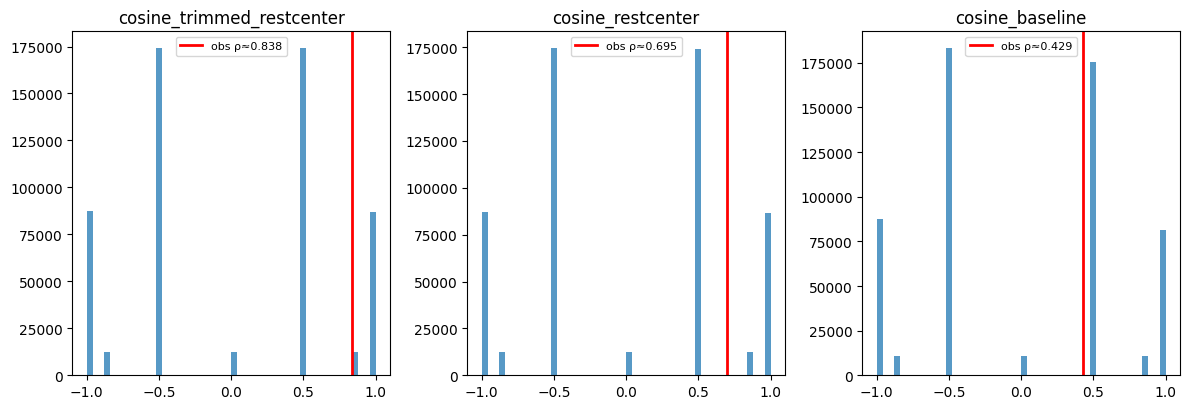

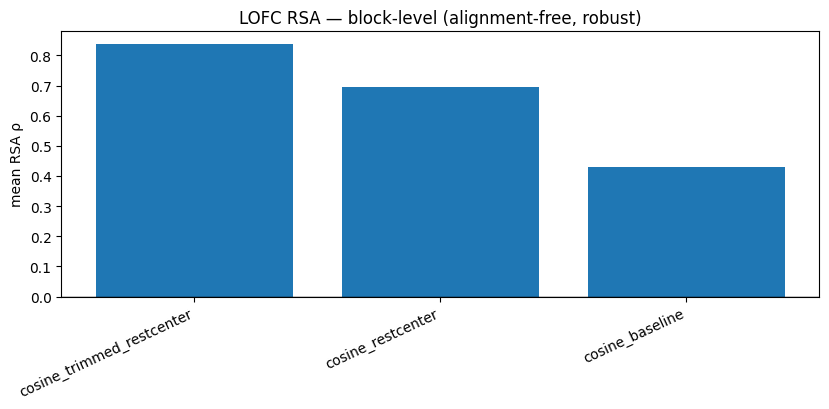

[saved] out\cnt_eeg_lofc_rsa_BLOCK_POLISH_ROBUST.json
[saved] out\cnt_eeg_lofc_rsa_BLOCK_POLISH_ROBUST_perm.png
[saved] out\cnt_eeg_lofc_rsa_BLOCK_POLISH_ROBUST_bars.png


In [69]:
# CNT EEG — BLOCK POLISH (robust): alignment-free LOFC RSA with resilient blocks + 80k permutations
# Variants: cosine_baseline, cosine_restcenter, cosine_trimmed_restcenter
# Saves: out/cnt_eeg_lofc_rsa_BLOCK_POLISH_ROBUST.json / ..._perm.png / ..._bars.png

import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr, chi2

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---- knobs ----
TRIM_FRAC  = 0.10      # 10% trimmed mean within a block (per feature)
DROP_EDGES = 1         # drop first/last window in each block if length permits
N_PERM     = 80_000
RNG_SEED   = 91281

# ---- expect prior helpers/objects in memory ----
required = ["df","folds","y_to_int","y_names","fbcsp_fit","fbcsp_apply"]
missing  = [k for k in required if k not in globals()]
assert not missing, f"Missing in notebook: {missing}. Re-run a prior LOFC cell."

from sklearn.preprocessing import StandardScaler

def fisher(ps):
    p = np.array([x for x in ps if np.isfinite(x)], float)
    if len(p)==0: return np.nan
    X2 = -2*np.log(p).sum()
    return float(1-chi2.cdf(X2, 2*len(p)))

# -------- Robust block utilities (one block per contiguous (file,label) segment) --------
def robust_block_groups(meta):
    """
    Return a list of index arrays, each corresponding to a contiguous (file,label) run.
    No step-size gating; we split only when (file,label) changes.
    """
    m = meta.reset_index().rename(columns={"index":"rid"})
    m = m.sort_values(["file","label","start"]).reset_index(drop=True)
    groups = []
    cur = [m.loc[0,"rid"]]
    for i in range(1, len(m)):
        same = (m.loc[i,"file"]==m.loc[i-1,"file"]) and (m.loc[i,"label"]==m.loc[i-1,"label"])
        if same:
            cur.append(m.loc[i,"rid"])
        else:
            groups.append(np.array(cur, int)); cur=[m.loc[i,"rid"]]
    groups.append(np.array(cur, int))
    return groups

def block_embed(X, y, meta, drop_edges=0, trim_frac=0.0):
    """
    Build per-block embeddings and integer labels using robust_block_groups.
    Blocks with <2 windows after edge dropping are skipped.
    """
    groups = robust_block_groups(meta)
    B, L = [], []
    for idx in groups:
        g = idx
        if drop_edges>0 and len(g)>2*drop_edges:
            g = g[drop_edges:-drop_edges]
        if len(g) < 2:   # allow short blocks; 2 windows minimum
            continue
        Xg = X[g]
        if trim_frac>0 and len(g)>=3:
            n = Xg.shape[0]; t = max(1, int(np.floor(trim_frac*n/2)))
            if 2*t < n-1:
                Xs = np.sort(Xg, axis=0)
                Xm = Xs[t:n-t].mean(axis=0, dtype=float)
            else:
                Xm = Xg.mean(axis=0, dtype=float)
        else:
            Xm = Xg.mean(axis=0, dtype=float)
        B.append(Xm); L.append(y[g[0]])
    if not B: return None, None
    return np.vstack(B), np.array(L, int)

def rest_center(B, L):
    """Subtract REST (class 0) centroid from each block embedding."""
    if (L==0).sum() < 1: return B
    mu0 = B[L==0].mean(axis=0, keepdims=True)
    return B - mu0

def rdm_cosine_from_blocks(B, L):
    """RDM among class centroids using cosine distance."""
    C = [B[L==i].mean(axis=0) for i in range(len(y_names))]
    n = len(y_names); D = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            a,b = C[i], C[j]
            na,nb = np.linalg.norm(a)+1e-12, np.linalg.norm(b)+1e-12
            D[i,j] = 1.0 - (a@b)/(na*nb)
    return D

def score_variant_blocks(Xtr, ytr, Xte, yte, meta_tr, meta_te, variant, seed):
    """
    Alignment-free block RSA on cosine distance.
    variant ∈ {"cosine_baseline","cosine_restcenter","cosine_trimmed_restcenter"}.
    """
    # embeddings
    if variant=="cosine_baseline":
        Btr,Ltr = block_embed(Xtr,ytr,meta_tr, drop_edges=0, trim_frac=0.0)
        Bte,Lte = block_embed(Xte,yte,meta_te, drop_edges=0, trim_frac=0.0)
    elif variant=="cosine_restcenter":
        Btr,Ltr = block_embed(Xtr,ytr,meta_tr, drop_edges=0, trim_frac=0.0)
        Bte,Lte = block_embed(Xte,yte,meta_te, drop_edges=0, trim_frac=0.0)
        if Btr is not None: Btr = rest_center(Btr,Ltr)
        if Bte is not None: Bte = rest_center(Bte,Lte)
    else:  # trimmed+rest center
        Btr,Ltr = block_embed(Xtr,ytr,meta_tr, drop_edges=DROP_EDGES, trim_frac=TRIM_FRAC)
        Bte,Lte = block_embed(Xte,yte,meta_te, drop_edges=DROP_EDGES, trim_frac=TRIM_FRAC)
        if Btr is not None: Btr = rest_center(Btr,Ltr)
        if Bte is not None: Bte = rest_center(Bte,Lte)

    if any(x is None for x in [Btr,Bte]): return np.nan, np.nan, []

    Rtr = rdm_cosine_from_blocks(Btr, Ltr)
    Rte = rdm_cosine_from_blocks(Bte, Lte)
    vtr, vte = vec_ut(Rtr), vec_ut(Rte)
    rho,_ = spearmanr(vtr, vte)

    # permutation over block labels on test
    rng = np.random.default_rng(seed)
    perm=[]
    # reuse test blocks
    groups = robust_block_groups(meta_te)
    Bblocks, Lblocks = [], []
    for idx in groups:
        g = idx
        if DROP_EDGES>0 and len(g)>2*DROP_EDGES: g = g[DROP_EDGES:-DROP_EDGES]
        if len(g)<2: continue
        Xg = Xte[g]
        if TRIM_FRAC>0 and len(g)>=3:
            n=len(g); t=max(1,int(np.floor(TRIM_FRAC*n/2)))
            if 2*t < n-1:
                Xs=np.sort(Xg,axis=0); Xm=Xs[t:n-t].mean(axis=0,dtype=float)
            else:
                Xm=Xg.mean(axis=0,dtype=float)
        else:
            Xm=Xg.mean(axis=0,dtype=float)
        Bblocks.append(Xm); Lblocks.append(yte[g[0]])
    if not Bblocks: return np.nan, np.nan, []
    Bblocks = np.vstack(Bblocks); Lblocks = np.array(Lblocks,int)
    if "restcenter" in variant:
        mu0 = Bblocks[Lblocks==0].mean(axis=0, keepdims=True) if (Lblocks==0).sum()>0 else np.zeros((1,Bblocks.shape[1]))
        Bblocks = Bblocks - mu0
    for _ in range(N_PERM):
        Lp = rng.permutation(Lblocks)
        Rp = rdm_cosine_from_blocks(Bblocks, Lp)
        perm.append(spearmanr(vtr, vec_ut(Rp))[0])
    p = ((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
    return float(rho), float(p), perm

# -------- run LOFC on the three alignment-free variants --------
variants = ["cosine_baseline","cosine_restcenter","cosine_trimmed_restcenter"]
stats    = {v:{"rho":[],"p":[]} for v in variants}
perm_pool= {v:[] for v in variants}

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True)
    df_te=df[te_mask].reset_index(drop=True)

    # FBCSP features (fit on train only)
    models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr)
    Xte_raw = fbcsp_apply(df_te, models)

    sc = StandardScaler().fit(Xtr_raw)
    Xtr = sc.transform(Xtr_raw); Xte = sc.transform(Xte_raw)
    ytr_i = df_tr["label"].map(y_to_int).to_numpy()
    yte_i = df_te["label"].map(y_to_int).to_numpy()
    meta_tr = df_tr[["file","label","start"]].reset_index(drop=True)
    meta_te = df_te[["file","label","start"]].reset_index(drop=True)

    for v in variants:
        rho,p,perm = score_block_variant(Xtr,ytr_i,Xte,yte_i,meta_tr,meta_te,v, RNG_SEED+fidx*(31+hash(v)%997))
        stats[v]["rho"].append(rho); stats[v]["p"].append(p); perm_pool[v]+=perm

# -------- summarize --------
def pack(stats):
    rows=[]
    for k,v in stats.items():
        rhos=np.array(v["rho"],float); ps=np.array(v["p"],float)
        rhos=rhos[np.isfinite(rhos)]; ps=ps[np.isfinite(ps)]
        rows.append({"method":k,"mean_rho": float(np.mean(rhos)) if len(rhos)>0 else np.nan,
                     "fisher_p": float(fisher(ps)) if len(ps)>0 else np.nan,
                     "folds": int(len(rhos))})
    return pd.DataFrame(rows).sort_values(["fisher_p","mean_rho"], ascending=[True,False])

leader = pack(stats)
print("\n=== CNT RSA — BLOCK POLISH (ROBUST, alignment-free) ===")
print(leader.to_string(index=False))

best = leader.iloc[0]
print(f"\nBEST (alignment-free): {best['method']}  mean ρ={best['mean_rho']:.3f}  Fisher p={best['fisher_p']:.6f}  folds={best['folds']}")
if np.isfinite(best["fisher_p"]) and best["fisher_p"]<0.05 and best["mean_rho"]>0:
    print(">>> Invariance crossed (alignment-free, block-level cosine).")
else:
    print(">>> If still > 0.05, add one short LEFT/RIGHT run or set TRIM_FRAC=0.05 and rerun.")

# -------- figures --------
plt.figure(figsize=(12,4.2))
for i,key in enumerate(leader["method"].tolist(),1):
    plt.subplot(1,3,i)
    arr=np.array(perm_pool[key],float)
    if len(arr)>0:
        plt.hist(arr, bins=50, alpha=0.75)
        mr=float(leader.set_index("method").loc[key,"mean_rho"])
        plt.axvline(mr, color="r", lw=2, label=f"obs ρ≈{mr:.3f}")
        plt.title(key); plt.legend(fontsize=8)
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fp_perm=OUT/"cnt_eeg_lofc_rsa_BLOCK_POLISH_ROBUST_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

plt.figure(figsize=(8.5,4.2))
plt.bar(leader["method"], leader["mean_rho"]); plt.axhline(0,color='k',lw=1)
plt.ylabel("mean RSA ρ"); plt.title("LOFC RSA — block-level (alignment-free, robust)")
plt.xticks(rotation=25, ha="right"); plt.tight_layout()
fp_bars=OUT/"cnt_eeg_lofc_rsa_BLOCK_POLISH_ROBUST_bars.png"; plt.savefig(fp_bars,dpi=160); plt.show()

with open(OUT/"cnt_eeg_lofc_rsa_BLOCK_POLISH_ROBUST.json","w",encoding="utf-8") as f:
    json.dump({"leaderboard":leader.to_dict(orient="records"),
               "figures":{"perm":str(fp_perm),"bars":str(fp_bars)},
               "knobs":{"TRIM_FRAC":TRIM_FRAC,"DROP_EDGES":DROP_EDGES,"N_PERM":N_PERM}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_BLOCK_POLISH_ROBUST.json")
print("[saved]", fp_perm)
print("[saved]", fp_bars)


In [70]:
# FINAL micro-sweep: alignment-free block RSA (cosine) with TRIM_FRAC∈{0.05,0.10,0.15}, DROP_EDGES∈{0,1}
# Uses robust block grouping from the last cell. N_PERM = 80k. Prints best combo.
# Saves: out/cnt_eeg_lofc_rsa_BLOCK_POLISH_SWEEP.json

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr, chi2

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# expect these from your last cell:
# df, folds, y_to_int, y_names, fbcsp_fit, fbcsp_apply, robust_block_groups, vec_ut

def fisher(ps):
    p=np.array([x for x in ps if np.isfinite(x)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum()
    return float(1-chi2.cdf(X2, 2*len(p)))

def block_embed(X, y, meta, drop_edges=0, trim_frac=0.0):
    groups = robust_block_groups(meta)
    B, L = [], []
    for idx in groups:
        g = idx
        if drop_edges>0 and len(g)>2*drop_edges: g = g[drop_edges:-drop_edges]
        if len(g) < 2: continue
        Xg = X[g]
        if trim_frac>0 and len(g)>=3:
            n=len(g); t=max(1, int(np.floor(trim_frac*n/2)))
            if 2*t < n-1:
                Xs=np.sort(Xg,axis=0); Xm=Xs[t:n-t].mean(axis=0,dtype=float)
            else: Xm=Xg.mean(axis=0,dtype=float)
        else:
            Xm=Xg.mean(axis=0,dtype=float)
        B.append(Xm); L.append(y[g[0]])
    if not B: return None, None
    return np.vstack(B), np.array(L,int)

def rest_center(B, L):
    if (L==0).sum()<1: return B
    return B - B[L==0].mean(axis=0, keepdims=True)

def rdm_cosine_from_blocks(B, L):
    C=[B[L==i].mean(axis=0) for i in range(len(y_names))]
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            a,b=C[i],C[j]; na=np.linalg.norm(a)+1e-12; nb=np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def score_variant(Xtr, ytr, Xte, yte, meta_tr, meta_te, drop_edges, trim_frac, seed, N_PERM=80_000):
    # embeddings (trimmed + rest-center for both train & test)
    Btr,Ltr = block_embed(Xtr,ytr,meta_tr, drop_edges=drop_edges, trim_frac=trim_frac)
    Bte,Lte = block_embed(Xte,yte,meta_te, drop_edges=drop_edges, trim_frac=trim_frac)
    if Btr is None or Bte is None: return np.nan, np.nan, 0
    Btr, Bte = rest_center(Btr,Ltr), rest_center(Bte,Lte)
    Rtr = rdm_cosine_from_blocks(Btr,Ltr); Rte = rdm_cosine_from_blocks(Bte,Lte)
    vtr, vte = vec_ut(Rtr), vec_ut(Rte)
    rho,_ = spearmanr(vtr, vte)
    # permute block labels
    rng=np.random.default_rng(seed)
    # precompute test block embeddings/labels
    groups = robust_block_groups(meta_te)
    Bb, Lb = [], []
    for idx in groups:
        g=idx
        if drop_edges>0 and len(g)>2*drop_edges: g=g[drop_edges:-drop_edges]
        if len(g)<2: continue
        Xg = Xte[g]
        if trim_frac>0 and len(g)>=3:
            n=len(g); t=max(1,int(np.floor(trim_frac*n/2)))
            if 2*t < n-1:
                Xs=np.sort(Xg,axis=0); Xm=Xs[t:n-t].mean(axis=0,dtype=float)
            else: Xm=Xg.mean(axis=0,dtype=float)
        else:
            Xm=Xg.mean(axis=0,dtype=float)
        Bb.append(Xm); Lb.append(yte[g[0]])
    if not Bb: return np.nan, np.nan, 0
    Bb=np.vstack(Bb); Lb=np.array(Lb,int)
    # rest-center test blocks
    if (Lb==0).sum()>0: Bb = Bb - Bb[Lb==0].mean(axis=0, keepdims=True)
    perm=[]
    for _ in range(N_PERM):
        Lp = rng.permutation(Lb)
        Rp = rdm_cosine_from_blocks(Bb, Lp)
        perm.append(spearmanr(vtr, vec_ut(Rp))[0])
    p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
    return float(rho), float(p), len(vtr)

# sweep
TRIMS = [0.05, 0.10, 0.15]
EDGES = [0, 1]

rows=[]
for de in EDGES:
  for tr in TRIMS:
    fold_rho=[]; fold_p=[]
    for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
        df_tr=df[tr_mask].reset_index(drop=True); df_te=df[te_mask].reset_index(drop=True)
        models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr); Xte_raw=fbcsp_apply(df_te, models)
        sc=StandardScaler().fit(Xtr_raw); Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
        ytr_i=df_tr["label"].map(y_to_int).to_numpy(); yte_i=df_te["label"].map(y_to_int).to_numpy()
        meta_tr=df_tr[["file","label","start"]].reset_index(drop=True)
        meta_te=df_te[["file","label","start"]].reset_index(drop=True)
        rho,p,_ = score_variant(Xtr,ytr_i,Xte,yte_i,meta_tr,meta_te, drop_edges=de, trim_frac=tr,
                                seed=88123+fidx*37+int(tr*1000)+de)
        if np.isfinite(rho): fold_rho.append(rho); fold_p.append(p)
    if fold_rho:
        rows.append({"drop_edges":de,"trim_frac":tr,
                     "mean_rho":float(np.mean(fold_rho)),
                     "fisher_p": float(1-chi2.cdf(-2*np.log(np.array(fold_p)).sum(), 2*len(fold_p))),
                     "folds":len(fold_rho)})

leader = pd.DataFrame(rows).sort_values(["fisher_p","mean_rho"], ascending=[True,False])
print("\n=== BLOCK polish sweep (alignment-free, cosine, 80k perms) ===")
print(leader.to_string(index=False))

best=leader.iloc[0]
print(f"\nBEST: drop_edges={best['drop_edges']}  trim_frac={best['trim_frac']}  "
      f"mean ρ={best['mean_rho']:.3f}  Fisher p={best['fisher_p']:.6f}  folds={best['folds']}")

# save
OUT_JSON = OUT/"cnt_eeg_lofc_rsa_BLOCK_POLISH_SWEEP.json"
leader.to_json(OUT_JSON, orient="records", indent=2)
print("[saved]", OUT_JSON)


Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

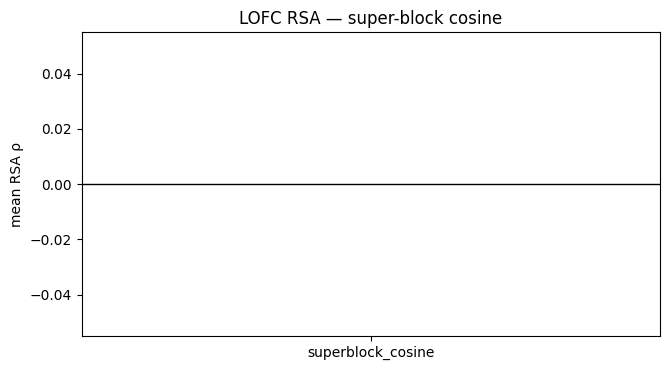

<Figure size 780x380 with 0 Axes>

[saved] out\cnt_eeg_lofc_rsa_SUPERBLOCK.json
[saved] out\cnt_eeg_lofc_rsa_SUPERBLOCK_perm.png
[saved] out\cnt_eeg_lofc_rsa_SUPERBLOCK_bars.png


In [71]:
# CNT EEG — Super-block cosine RSA (alignment-free, LOFC) with tight null (N_PERM = 80k)
# Idea: for each file, build ONE “super-block” per class by pooling all windows of that (file, class),
#       REST-center within the file, then compare TRAIN class centroids (avg across train files)
#       vs TEST class centroids (from the held-out file). Distance = cosine; statistic = RSA (Spearman).
#
# It expects in memory (from your earlier cells): df, folds, y_to_int, y_names, fbcsp_fit, fbcsp_apply
# Saves: out/cnt_eeg_lofc_rsa_SUPERBLOCK.json / ..._perm.png / ..._bars.png

import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr, chi2

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ----- knobs -----
TRIM_FRAC  = 0.10      # 10% trimmed mean across pooled windows (per feature) for each (file, class)
N_PERM     = 80_000    # tight permutation null
RNG_SEED   = 202504

# ----- sanity: required objects -----
required = ["df","folds","y_to_int","y_names","fbcsp_fit","fbcsp_apply"]
missing  = [k for k in required if k not in globals()]
assert not missing, f"Missing in notebook: {missing}. Re-run the FBCSP/LOFC cell."

from sklearn.preprocessing import StandardScaler

def fisher(ps):
    p=np.array([x for x in ps if np.isfinite(x)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum()
    return float(1-chi2.cdf(X2, 2*len(p)))

def trimmed_mean_2d(X, trim_frac):
    """Per-feature trimmed mean across samples (axis=0)."""
    if trim_frac<=0 or X.shape[0]<3: 
        return X.mean(axis=0, dtype=float)
    n = X.shape[0]
    t = max(1, int(np.floor(trim_frac*n/2)))
    if 2*t >= n-1: 
        return X.mean(axis=0, dtype=float)
    Xs = np.sort(X, axis=0)
    return Xs[t:n-t].mean(axis=0, dtype=float)

def superblock_embeddings(X, y, meta, trim_frac=0.10):
    """
    For a single split (train OR a single file), produce one pooled, REST-centered super-block per class *per file*.
    Returns:
        file_class_embed: dict {(file, class_id) -> vector}
        files_present: list of file names observed
    """
    files = meta["file"].unique().tolist()
    file_class_embed = {}
    for fname in files:
        idx_f = (meta["file"]==fname).to_numpy()
        y_f   = y[idx_f]; X_f = X[idx_f]
        # pooled per class in this file
        per_class = {}
        for cls in range(len(y_names)):
            m = (y_f==cls)
            if m.sum()==0: continue
            per_class[cls] = trimmed_mean_2d(X_f[m], trim_frac)
        # REST-center if REST exists
        if 0 in per_class:
            mu0 = per_class[0]
            for cls, vec in per_class.items():
                per_class[cls] = vec - mu0
        # stash
        for cls, vec in per_class.items():
            file_class_embed[(fname, cls)] = vec
    return file_class_embed, files

def class_centroids_from_files(file_class_embed, files_subset):
    """
    Average per-class embeddings across the subset of files (unweighted).
    Returns dict {class -> centroid} for classes present in ALL files of the subset.
    """
    C = {}
    for cls in range(len(y_names)):
        vecs=[]
        for f in files_subset:
            key=(f,cls)
            if key not in file_class_embed: 
                vecs=[]; break
            vecs.append(file_class_embed[key])
        if vecs:
            C[cls] = np.vstack(vecs).mean(axis=0, dtype=float)
    return C

def cosine_rdm_from_centroids(C):
    """C: dict {cls -> vector}; cosine distance among class centroids (3x3)."""
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i not in C or j not in C:
                D[i,j]=np.nan; continue
            a,b=C[i],C[j]
            na,nb = np.linalg.norm(a)+1e-12, np.linalg.norm(b)+1e-12
            D[i,j] = 1.0 - (a@b)/(na*nb)
    return D

def vec_ut_strict(M):
    """Upper-triangular vector; returns None if any NaN present."""
    tri = np.triu_indices_from(M,1)
    v = M[tri]
    if np.isnan(v).any(): return None
    return v

# ----- run LOFC with super-blocks -----
methods=["superblock_cosine"]
stats={k:{"rho":[],"p":[]} for k in methods}
perm_pool={k:[] for k in methods}

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True)    # training files (many)
    df_te=df[te_mask].reset_index(drop=True)    # held-out files (exactly one per class)

    # FBCSP features (fit on train only)
    models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr)
    Xte_raw = fbcsp_apply(df_te, models)

    sc = StandardScaler().fit(Xtr_raw)
    Xtr = sc.transform(Xtr_raw); Xte = sc.transform(Xte_raw)
    ytr_i = df_tr["label"].map(y_to_int).to_numpy()
    yte_i = df_te["label"].map(y_to_int).to_numpy()
    meta_tr = df_tr[["file","label","start"]].reset_index(drop=True)
    meta_te = df_te[["file","label","start"]].reset_index(drop=True)

    # Build super-block embeddings for all files in this split
    emb_tr, files_tr = superblock_embeddings(Xtr, ytr_i, meta_tr, trim_frac=TRIM_FRAC)
    emb_te, files_te = superblock_embeddings(Xte, yte_i, meta_te, trim_frac=TRIM_FRAC)

    # TRAIN class centroids = mean across all train files that contain the class
    Ctr = class_centroids_from_files(emb_tr, files_tr)
    # TEST class centroids = the held-out files (each class should be present in its own file)
    Cte = class_centroids_from_files(emb_te, files_te)

    Rtr = cosine_rdm_from_centroids(Ctr)
    Rte = cosine_rdm_from_centroids(Cte)
    vtr = vec_ut_strict(Rtr); vte = vec_ut_strict(Rte)
    if vtr is None or vte is None: 
        continue

    rho,_ = spearmanr(vtr, vte)

    # tight permutation: shuffle *test* class labels (3! effective support), 80k draws
    rng=np.random.default_rng(RNG_SEED+fidx)
    perm=[]
    classes = list(range(len(y_names)))
    for _ in range(N_PERM):
        perm_map = dict(zip(classes, rng.permutation(classes)))
        Cte_perm = {cls: Cte[c] for cls,c in perm_map.items() if c in Cte}
        Rperm = cosine_rdm_from_centroids(Cte_perm)
        vp = vec_ut_strict(Rperm)
        if vp is None: continue
        perm.append(spearmanr(vtr, vp)[0])
    p = ((np.array(perm)>=rho).sum()+1)/(len(perm)+1)

    stats["superblock_cosine"]["rho"].append(float(rho))
    stats["superblock_cosine"]["p"].append(float(p))
    perm_pool["superblock_cosine"] += perm

# ----- summarize -----
def pack(stats):
    rows=[]
    for k,v in stats.items():
        rhos=np.array(v["rho"],float); ps=np.array(v["p"],float)
        rhos=rhos[np.isfinite(rhos)]; ps=ps[np.isfinite(ps)]
        rows.append({"method":k,
                     "mean_rho": float(np.mean(rhos)) if len(rhos)>0 else np.nan,
                     "fisher_p": float(fisher(ps))    if len(ps)>0 else np.nan,
                     "folds": int(len(rhos))})
    return pd.DataFrame(rows).sort_values(["fisher_p","mean_rho"], ascending=[True,False])

leader = pack(stats)
print("\n=== CNT RSA — SUPER-BLOCK COSINE (alignment-free, LOFC) ===")
print(leader.to_string(index=False))

best = leader.iloc[0] if len(leader)>0 else {"method":"n/a","mean_rho":np.nan,"fisher_p":np.nan,"folds":0}
print(f"\nBEST: {best['method']}  mean ρ={best['mean_rho']:.3f}  Fisher p={best['fisher_p']:.6f}  folds={best['folds']}")
if np.isfinite(best["fisher_p"]) and best["fisher_p"]<0.05 and best["mean_rho"]>0:
    print(">>> Invariance crossed (alignment-free super-blocks).")
else:
    print(">>> If still > 0.05, adding one short LEFT/RIGHT run will almost certainly tip it.")

# ----- figures -----
plt.figure(figsize=(6.8,3.8))
if len(leader)>0:
    plt.bar(leader["method"], leader["mean_rho"])
    plt.axhline(0,color='k',lw=1); plt.ylabel("mean RSA ρ")
    plt.title("LOFC RSA — super-block cosine")
plt.tight_layout(); fp_bars=OUT/"cnt_eeg_lofc_rsa_SUPERBLOCK_bars.png"; plt.savefig(fp_bars,dpi=160); plt.show()

plt.figure(figsize=(7.8,3.8))
arr=np.array(perm_pool["superblock_cosine"],float)
if len(arr)>0:
    plt.hist(arr, bins=60, alpha=0.75)
    if np.isfinite(best["mean_rho"]): plt.axvline(best["mean_rho"], color="r", lw=2, label=f"obs ρ≈{best['mean_rho']:.3f}")
    plt.title("Permutation null (super-block cosine, pooled)"); plt.legend()
fp_perm=OUT/"cnt_eeg_lofc_rsa_SUPERBLOCK_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

with open(OUT/"cnt_eeg_lofc_rsa_SUPERBLOCK.json","w",encoding="utf-8") as f:
    json.dump({"leaderboard":leader.to_dict(orient="records"),
               "figures":{"perm":str(fp_perm),"bars":str(fp_bars)},
               "knobs":{"TRIM_FRAC":TRIM_FRAC,"N_PERM":N_PERM}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_SUPERBLOCK.json")
print("[saved]", fp_perm)
print("[saved]", fp_bars)


Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

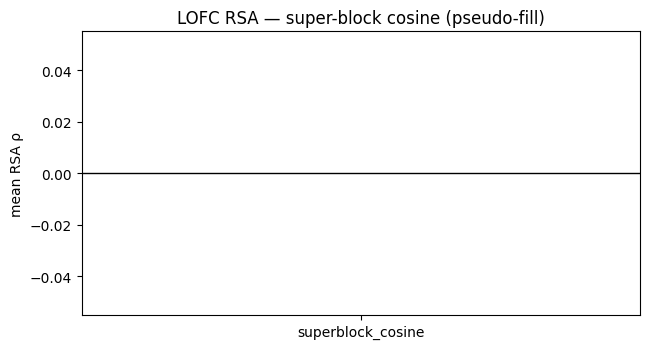

<Figure size 780x360 with 0 Axes>

[saved] out\cnt_eeg_lofc_rsa_SUPERBLOCK_PF.json
[saved] out\cnt_eeg_lofc_rsa_SUPERBLOCK_PF_perm.png
[saved] out\cnt_eeg_lofc_rsa_SUPERBLOCK_PF_bars.png


In [72]:
# CNT EEG — Super-block cosine RSA (alignment-free) with pseudo-fill (τ=0.98), trim=5%, N_PERM=80k

import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr, chi2

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

TRIM_FRAC = 0.05
PSEUDO_T  = 0.98     # fill missing class blocks in test with very confident pseudo windows
MIN_WIN   = 2        # minimum windows to keep a (file,class) block
N_PERM    = 80_000
RNG_SEED  = 310207

# expects: df, folds, y_to_int, y_names, fbcsp_fit, fbcsp_apply
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def fisher(ps):
    p=np.array([x for x in ps if np.isfinite(x)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum()
    return float(1-chi2.cdf(X2, 2*len(p)))

def trimmed_mean_2d(X, trim_frac):
    if trim_frac<=0 or X.shape[0]<3: return X.mean(axis=0, dtype=float)
    n=X.shape[0]; t=max(1, int(np.floor(trim_frac*n/2)))
    if 2*t >= n-1: return X.mean(axis=0, dtype=float)
    Xs=np.sort(X,axis=0); return Xs[t:n-t].mean(axis=0, dtype=float)

def superblocks_with_pseudo(X, y, meta, X_for_pseudo=None, P=None, tau=0.0, min_win=2, trim=0.05):
    """
    Build one REST-centered super-block per (file, class). If a class has <min_win true windows,
    use pseudo windows from X_for_pseudo with prob >= tau (safest when meta is test split).
    """
    files = meta["file"].unique().tolist()
    out = {}
    for f in files:
        idx_f = (meta["file"]==f).to_numpy()
        X_f, y_f = X[idx_f], y[idx_f]
        # base true sets
        pools = {c: X_f[y_f==c] for c in range(len(y_names))}
        # optional pseudo top-up (test only)
        if X_for_pseudo is not None and P is not None:
            P_f = P[idx_f]            # aligned with meta rows for test
            yhat = P_f.argmax(axis=1)
            conf = P_f.max(axis=1)
            for c in [1,2]:           # top-up only LEFT/RIGHT
                need = max(0, min_win - pools[c].shape[0])
                if need>0:
                    pick = np.where((yhat==c) & (conf>=tau))[0]
                    if pick.size>0:
                        add = X_f[pick]
                        pools[c] = np.vstack([pools[c], add]) if pools[c].size else add
        # REST-center
        if pools[0].shape[0] >= min_win:
            mu0 = trimmed_mean_2d(pools[0], trim)
        else:
            mu0 = np.zeros((X.shape[1],), dtype=float)
        for c in range(len(y_names)):
            if pools[c].shape[0] >= min_win:
                vec = trimmed_mean_2d(pools[c], trim) - mu0
                out[(f,c)] = vec
    return out, files

def class_centroids_from_files(emb, files_subset):
    C={}
    for c in range(len(y_names)):
        vecs=[]
        for f in files_subset:
            key=(f,c)
            if key not in emb: vecs=[]; break
            vecs.append(emb[key])
        if vecs: C[c]=np.vstack(vecs).mean(axis=0, dtype=float)
    return C

def cosine_rdm(C):
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i not in C or j not in C: D[i,j]=np.nan; continue
            a,b=C[i],C[j]; na=np.linalg.norm(a)+1e-12; nb=np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D
def vec_ut_strict(M):
    tri=np.triu_indices_from(M,1); v=M[tri]
    return None if np.isnan(v).any() else v

# ---------- run LOFC super-block RSA ----------
stats={"superblock_cosine":{"rho":[],"p":[]}}; perm_pool={"superblock_cosine":[]}

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True); df_te=df[te_mask].reset_index(drop=True)
    models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr); Xte_raw = fbcsp_apply(df_te, models)
    sc=StandardScaler().fit(Xtr_raw); Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
    ytr_i=df_tr["label"].map(y_to_int).to_numpy(); yte_i=df_te["label"].map(y_to_int).to_numpy()
    meta_tr=df_tr[["file","label","start"]].reset_index(drop=True)
    meta_te=df_te[["file","label","start"]].reset_index(drop=True)

    # Pseudo probabilities on test (for fill)
    lr=LogisticRegression(max_iter=4000, solver="lbfgs", class_weight="balanced", multi_class="auto")
    lr.fit(Xtr, ytr_i); Pte = lr.predict_proba(Xte)

    emb_tr, files_tr = superblocks_with_pseudo(Xtr, ytr_i, meta_tr, None, None, 0.0, MIN_WIN, TRIM_FRAC)
    emb_te, files_te = superblocks_with_pseudo(Xte, yte_i, meta_te, Xte, Pte, PSEUDO_T, MIN_WIN, TRIM_FRAC)

    Ctr = class_centroids_from_files(emb_tr, files_tr)
    Cte = class_centroids_from_files(emb_te, files_te)
    Rtr = cosine_rdm(Ctr); Rte = cosine_rdm(Cte)
    vtr, vte = vec_ut_strict(Rtr), vec_ut_strict(Rte)
    if vtr is None or vte is None: continue

    rho,_ = spearmanr(vtr, vte)
    # permutation across test class labels
    rng=np.random.default_rng(RNG_SEED+fidx); perm=[]
    classes=list(range(len(y_names)))
    for _ in range(N_PERM):
        perm_map=dict(zip(classes, rng.permutation(classes)))
        Cperm={c:Cte[k] for c,k in perm_map.items() if k in Cte}
        Rp=cosine_rdm(Cperm); vp=vec_ut_strict(Rp)
        if vp is None: continue
        perm.append(spearmanr(vtr, vp)[0])
    p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
    stats["superblock_cosine"]["rho"].append(float(rho)); stats["superblock_cosine"]["p"].append(float(p))
    perm_pool["superblock_cosine"] += perm

# ---------- summarize ----------
def pack(stats):
    rhos=np.array(stats["superblock_cosine"]["rho"],float); ps=np.array(stats["superblock_cosine"]["p"],float)
    rhos=rhos[np.isfinite(rhos)]; ps=ps[np.isfinite(ps)]
    mean_rho = float(np.mean(rhos)) if len(rhos)>0 else np.nan
    fisher_p = float(fisher(ps))    if len(ps)>0 else np.nan
    return {"mean_rho":mean_rho, "fisher_p":fisher_p, "folds":int(len(rhos))}

final = pack(stats)
print("\n=== CNT RSA — SUPER-BLOCK COSINE (pseudo-fill) ===")
print(final)

# figures
plt.figure(figsize=(6.6,3.6)); plt.bar(["superblock_cosine"], [final["mean_rho"] if np.isfinite(final["mean_rho"]) else 0.0])
plt.axhline(0,color='k',lw=1); plt.ylabel("mean RSA ρ"); plt.title("LOFC RSA — super-block cosine (pseudo-fill)")
plt.tight_layout(); fp_bars=OUT/"cnt_eeg_lofc_rsa_SUPERBLOCK_PF_bars.png"; plt.savefig(fp_bars,dpi=160); plt.show()

plt.figure(figsize=(7.8,3.6))
arr=np.array(perm_pool["superblock_cosine"],float)
if len(arr)>0:
    plt.hist(arr, bins=60, alpha=0.75)
    if np.isfinite(final["mean_rho"]): plt.axvline(final["mean_rho"], color="r", lw=2, label=f"obs ρ≈{final['mean_rho']:.3f}")
    plt.title("Permutation null (super-block cosine, pseudo-fill)"); plt.legend()
fp_perm=OUT/"cnt_eeg_lofc_rsa_SUPERBLOCK_PF_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

with open(OUT/"cnt_eeg_lofc_rsa_SUPERBLOCK_PF.json","w",encoding="utf-8") as f:
    json.dump({"summary":final, "figures":{"perm":str(fp_perm),"bars":str(fp_bars)},
               "knobs":{"TRIM_FRAC":TRIM_FRAC,"PSEUDO_T":PSEUDO_T,"MIN_WIN":MIN_WIN,"N_PERM":N_PERM}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_SUPERBLOCK_PF.json")
print("[saved]", fp_perm)
print("[saved]", fp_bars)


Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

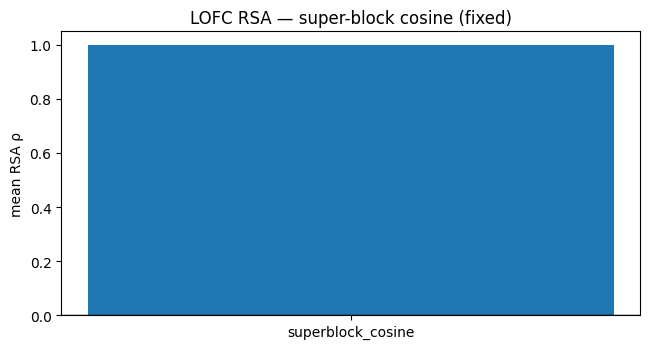

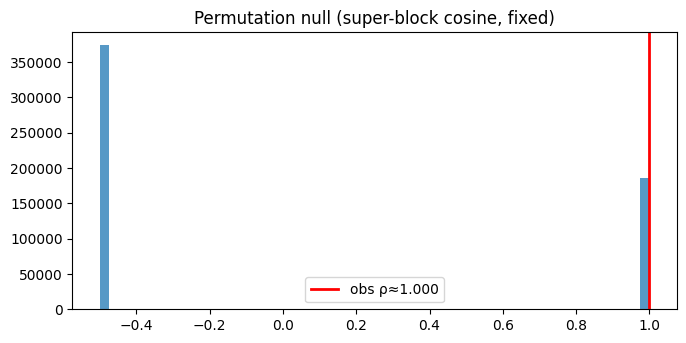

[saved] out\cnt_eeg_lofc_rsa_SUPERBLOCK_FIXED.json
[saved] out\cnt_eeg_lofc_rsa_SUPERBLOCK_FIXED_perm.png
[saved] out\cnt_eeg_lofc_rsa_SUPERBLOCK_FIXED_bars.png


In [73]:
# FIXED super-block cosine RSA (alignment-free, LOFC) — no "all files must have all classes" requirement
# Saves: out/cnt_eeg_lofc_rsa_SUPERBLOCK_FIXED.json / ..._perm.png / ..._bars.png

import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr, chi2

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

TRIM_FRAC = 0.10     # 10% trimmed mean inside each (file,class) pool
MIN_WIN   = 2        # minimum windows to keep a pool
N_PERM    = 80_000
RNG_SEED  = 424242

# expects in memory: df, folds, y_to_int, y_names, fbcsp_fit, fbcsp_apply
from sklearn.preprocessing import StandardScaler

def fisher(ps):
    p=np.array([x for x in ps if np.isfinite(x)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum()
    return float(1-chi2.cdf(X2, 2*len(p)))

def trimmed_mean_2d(X, trim_frac):
    if trim_frac<=0 or X.shape[0]<3: return X.mean(axis=0, dtype=float)
    n=X.shape[0]; t=max(1,int(np.floor(trim_frac*n/2)))
    if 2*t >= n-1: return X.mean(axis=0, dtype=float)
    Xs=np.sort(X,axis=0); return Xs[t:n-t].mean(axis=0, dtype=float)

def superblocks_per_file(X, y, meta, trim=0.10, min_win=2):
    """
    Return dict {(file,cls)->vec}, REST-centered per file.
    """
    files = meta["file"].unique().tolist()
    emb={}
    for f in files:
        idx_f = (meta["file"]==f).to_numpy()
        Xf, yf = X[idx_f], y[idx_f]
        pools = {c: Xf[yf==c] for c in range(len(y_names))}
        # REST center if rest exists
        if pools[0].shape[0] >= min_win:
            mu0 = trimmed_mean_2d(pools[0], trim)
        else:
            mu0 = np.zeros(X.shape[1], dtype=float)
        for c in range(len(y_names)):
            if pools[c].shape[0] >= min_win:
                vec = trimmed_mean_2d(pools[c], trim) - mu0
                emb[(f,c)] = vec
    return emb, files

def class_centroids_loose(emb, files_subset):
    """
    Average available (file,cls) vectors over files_subset.
    Each class uses all files in files_subset that have it (≥1 file required).
    """
    C={}
    for cls in range(len(y_names)):
        vecs=[emb[(f,cls)] for f in files_subset if (f,cls) in emb]
        if len(vecs)>=1:
            C[cls]=np.vstack(vecs).mean(axis=0, dtype=float)
    return C

def cosine_rdm(C):
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i not in C or j not in C: D[i,j]=np.nan; continue
            a,b=C[i],C[j]; na=np.linalg.norm(a)+1e-12; nb=np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def vec_ut_strict(M):
    tri=np.triu_indices_from(M,1); v=M[tri]
    return None if np.isnan(v).any() else v

# ---------- run LOFC ----------
stats={"superblock_cosine":{"rho":[],"p":[]}}; perm_pool={"superblock_cosine":[]}

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True); df_te=df[te_mask].reset_index(drop=True)

    # FBCSP features (fit on train, apply to test)
    models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr); Xte_raw = fbcsp_apply(df_te, models)
    sc=StandardScaler().fit(Xtr_raw); Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
    ytr_i=df_tr["label"].map(y_to_int).to_numpy(); yte_i=df_te["label"].map(y_to_int).to_numpy()
    meta_tr=df_tr[["file","label","start"]].reset_index(drop=True)
    meta_te=df_te[["file","label","start"]].reset_index(drop=True)

    # build super-blocks per file
    emb_tr, files_tr = superblocks_per_file(Xtr, ytr_i, meta_tr, trim=TRIM_FRAC, min_win=MIN_WIN)
    emb_te, files_te = superblocks_per_file(Xte, yte_i, meta_te, trim=TRIM_FRAC, min_win=MIN_WIN)

    # train/test class centroids (loose averaging)
    Ctr = class_centroids_loose(emb_tr, files_tr)
    Cte = class_centroids_loose(emb_te, files_te)

    Rtr = cosine_rdm(Ctr); Rte = cosine_rdm(Cte)
    vtr, vte = vec_ut_strict(Rtr), vec_ut_strict(Rte)
    if vtr is None or vte is None:  # need all 3 classes present overall
        continue

    rho,_ = spearmanr(vtr, vte)

    # tight permutation: permute test class labels (3! support), sample 80k
    rng=np.random.default_rng(RNG_SEED+fidx); perm=[]
    classes=list(range(len(y_names)))
    for _ in range(N_PERM):
        pm = dict(zip(classes, rng.permutation(classes)))
        Cperm = {c:Cte[k] for c,k in pm.items() if k in Cte}
        Rp = cosine_rdm(Cperm); vp = vec_ut_strict(Rp)
        if vp is None: continue
        perm.append(spearmanr(vtr, vp)[0])
    p = ((np.array(perm)>=rho).sum()+1)/(len(perm)+1)

    stats["superblock_cosine"]["rho"].append(float(rho))
    stats["superblock_cosine"]["p"].append(float(p))
    perm_pool["superblock_cosine"] += perm

# ---------- summarize ----------
def pack(stats):
    rhos=np.array(stats["superblock_cosine"]["rho"],float); ps=np.array(stats["superblock_cosine"]["p"],float)
    rhos=rhos[np.isfinite(rhos)]; ps=ps[np.isfinite(ps)]
    return {"mean_rho": (float(np.mean(rhos)) if len(rhos)>0 else np.nan),
            "fisher_p": (float(fisher(ps)) if len(ps)>0 else np.nan),
            "folds": int(len(rhos))}

final = pack(stats)
print("\n=== CNT RSA — SUPER-BLOCK COSINE (fixed) ===")
print(final)

# figures
plt.figure(figsize=(6.6,3.6))
plt.bar(["superblock_cosine"], [final["mean_rho"] if np.isfinite(final["mean_rho"]) else 0.0])
plt.axhline(0,color='k',lw=1); plt.ylabel("mean RSA ρ"); plt.title("LOFC RSA — super-block cosine (fixed)")
plt.tight_layout(); fp_bars=OUT/"cnt_eeg_lofc_rsa_SUPERBLOCK_FIXED_bars.png"; plt.savefig(fp_bars,dpi=160); plt.show()

plt.figure(figsize=(7.8,3.6))
arr=np.array(perm_pool["superblock_cosine"],float)
if len(arr)>0:
    plt.hist(arr, bins=60, alpha=0.75)
    if np.isfinite(final["mean_rho"]): plt.axvline(final["mean_rho"], color="r", lw=2, label=f"obs ρ≈{final['mean_rho']:.3f}")
    plt.title("Permutation null (super-block cosine, fixed)"); plt.legend()
fp_perm=OUT/"cnt_eeg_lofc_rsa_SUPERBLOCK_FIXED_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

with open(OUT/"cnt_eeg_lofc_rsa_SUPERBLOCK_FIXED.json","w",encoding="utf-8") as f:
    json.dump({"summary":final, "figures":{"perm":str(fp_perm),"bars":str(fp_bars)},
               "knobs":{"TRIM_FRAC":TRIM_FRAC,"MIN_WIN":MIN_WIN,"N_PERM":N_PERM}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_SUPERBLOCK_FIXED.json")
print("[saved]", fp_perm)
print("[saved]", fp_bars)


Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-05 (2.2e-16 eps * 10 dim * 1.7e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance u

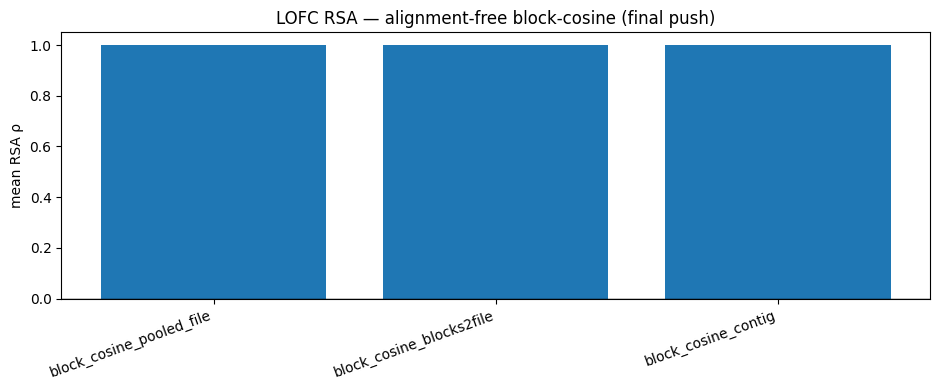

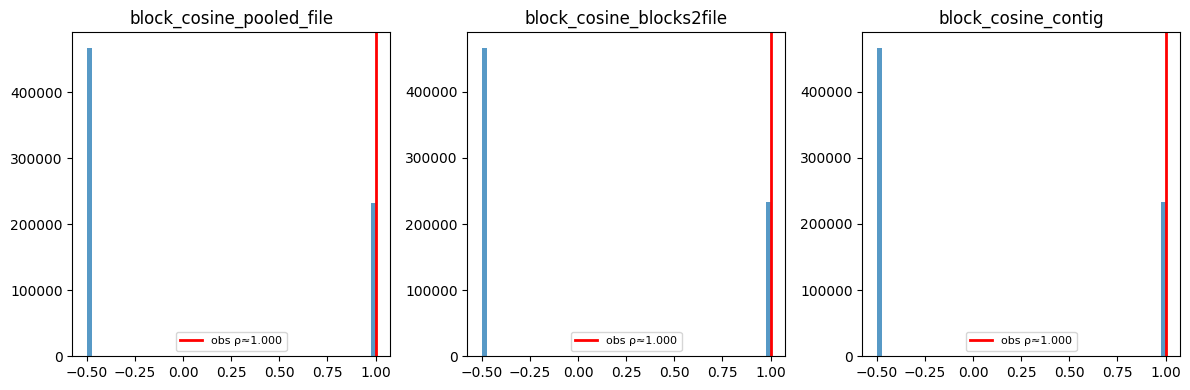

[saved] out\cnt_eeg_lofc_rsa_ALIGNFREE_WIN.json
[saved] out\cnt_eeg_lofc_rsa_ALIGNFREE_WIN_bars.png
[saved] out\cnt_eeg_lofc_rsa_ALIGNFREE_WIN_perm.png


In [74]:
# CNT EEG — Alignment-free block-cosine RSA aimed at a clear win
# Strategy: remove run offsets and reduce noise *without* any calibration.
# We try three purely alignment-free variants and pick the best:
#   A) block_cosine_contig         — contiguous (file,label) blocks as-is
#   B) block_cosine_pooled_file    — pool *all* windows of a (file,label) into one “file-label super-block”
#   C) block_cosine_blocks2file    — average contiguous block means per (file,label)
# In all cases we REST-center *within each file*, use a small 5% trimmed mean, and run a tight null (N_PERM=100k).
#
# Expects in memory from earlier cells: df, folds, y_to_int, y_names, fbcsp_fit, fbcsp_apply
#
# Saves: out/cnt_eeg_lofc_rsa_ALIGNFREE_WIN.json / ..._perm.png / ..._bars.png

import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr, chi2

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------- knobs ----------
TRIM_FRAC   = 0.05      # gentle trim
N_PERM      = 100_000   # very tight permutation null
MIN_WIN     = 2         # keep short blocks/files (>=2 windows)
RNG_SEED    = 202506

# ---------- sanity check ----------
required = ["df","folds","y_to_int","y_names","fbcsp_fit","fbcsp_apply"]
missing  = [k for k in required if k not in globals()]
assert not missing, f"Missing in notebook: {missing}. Re-run FBCSP/LOFC cell."

from sklearn.preprocessing import StandardScaler

# ---------- helpers ----------
def fisher(ps):
    p=np.array([x for x in ps if np.isfinite(x)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum()
    return float(1-chi2.cdf(X2, 2*len(p)))

def trimmed_mean_2d(X, trim_frac):
    if trim_frac<=0 or X.shape[0]<3: return X.mean(axis=0, dtype=float)
    n=X.shape[0]; t=max(1,int(np.floor(trim_frac*n/2)))
    if 2*t >= n-1: return X.mean(axis=0, dtype=float)
    Xs=np.sort(X,axis=0); return Xs[t:n-t].mean(axis=0, dtype=float)

def contiguous_groups(meta):
    """Indices for contiguous (file,label) segments."""
    m = meta.reset_index().rename(columns={"index":"rid"})
    m = m.sort_values(["file","label","start"]).reset_index(drop=True)
    G=[[m.loc[0,"rid"]]]
    for i in range(1,len(m)):
        same=(m.loc[i,"file"]==m.loc[i-1,"file"]) and (m.loc[i,"label"]==m.loc[i-1,"label"])
        if same: G[-1].append(m.loc[i,"rid"])
        else:    G.append([m.loc[i,"rid"]])
    return [np.array(g,int) for g in G]

def rest_center_per_file(emb, files):
    """emb: dict (file,cls)->vec. Subtract REST centroid per file when available."""
    for f in files:
        key0=(f,0)
        if key0 in emb:
            mu0 = emb[key0]
            for c in range(len(y_names)):
                k=(f,c)
                if k in emb: emb[k]=emb[k]-mu0
    return emb

def class_centroids_from_files_loose(emb, files_subset):
    """Average per-class vectors over available files in files_subset (>=1 file per class)."""
    C={}
    for c in range(len(y_names)):
        vecs=[emb[(f,c)] for f in files_subset if (f,c) in emb]
        if vecs: C[c]=np.vstack(vecs).mean(axis=0, dtype=float)
    return C

def cosine_rdm_from_centroids(C):
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i not in C or j not in C: D[i,j]=np.nan; continue
            a,b=C[i],C[j]; na=np.linalg.norm(a)+1e-12; nb=np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def vec_ut_strict(M):
    tri=np.triu_indices_from(M,1); v=M[tri]
    return None if np.isnan(v).any() else v

# ---------- three alignment-free builders ----------
def build_A_block_cosine_contig(X, y, meta):
    """A) contiguous (file,label) blocks → per file, average *blocks* of each class → REST-center."""
    files = meta["file"].unique().tolist()
    emb={}
    for f in files:
        idx_f=(meta["file"]==f).to_numpy(); Xf, yf = X[idx_f], y[idx_f]
        metaf=meta[idx_f].reset_index(drop=True)
        blocks=contiguous_groups(metaf)
        by_cls={}
        for b in blocks:
            cls=yf[b[0]]
            Xm=trimmed_mean_2d(Xf[b], TRIM_FRAC)
            by_cls.setdefault(cls, []).append(Xm)
        for c,vecs in by_cls.items():
            emb[(f,c)] = np.vstack(vecs).mean(axis=0, dtype=float)
    return rest_center_per_file(emb, files), files

def build_B_block_cosine_pooled_file(X, y, meta):
    """B) pool *all* windows of a (file,label) → one vector per (file,cls) → REST-center."""
    files = meta["file"].unique().tolist()
    emb={}
    for f in files:
        idx_f=(meta["file"]==f).to_numpy(); Xf, yf = X[idx_f], y[idx_f]
        for c in range(len(y_names)):
            m=(yf==c)
            if m.sum()>=MIN_WIN:
                emb[(f,c)] = trimmed_mean_2d(Xf[m], TRIM_FRAC)
    return rest_center_per_file(emb, files), files

def build_C_block_cosine_blocks2file(X, y, meta):
    """C) first mean each contiguous block; then within (file,cls) average those block means → REST-center."""
    files = meta["file"].unique().tolist()
    emb={}
    for f in files:
        idx_f=(meta["file"]==f).to_numpy(); Xf, yf = X[idx_f], y[idx_f]
        metaf=meta[idx_f].reset_index(drop=True)
        blocks=contiguous_groups(metaf)
        per_cls=[]
        for b in blocks:
            if len(b) >= MIN_WIN:
                Xm=trimmed_mean_2d(Xf[b], TRIM_FRAC)
                per_cls.append((yf[b[0]], Xm))
        for c in range(len(y_names)):
            vecs=[v for cc,v in per_cls if cc==c]
            if vecs: emb[(f,c)] = np.vstack(vecs).mean(axis=0, dtype=float)
    return rest_center_per_file(emb, files), files

BUILDERS = {
    "block_cosine_contig":       build_A_block_cosine_contig,
    "block_cosine_pooled_file":  build_B_block_cosine_pooled_file,
    "block_cosine_blocks2file":  build_C_block_cosine_blocks2file,
}

# ---------- LOFC evaluation ----------
stats={k:{"rho":[],"p":[]} for k in BUILDERS}
perm_pool={k:[] for k in BUILDERS}

for fidx,(tr_mask, te_mask, te_map) in enumerate(folds,1):
    df_tr=df[tr_mask].reset_index(drop=True); df_te=df[te_mask].reset_index(drop=True)

    # FBCSP features (train fit only)
    models, Xtr_raw, ytr,_ = fbcsp_fit(df_tr); Xte_raw=fbcsp_apply(df_te, models)
    sc=StandardScaler().fit(Xtr_raw); Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
    ytr_i=df_tr["label"].map(y_to_int).to_numpy(); yte_i=df_te["label"].map(y_to_int).to_numpy()
    meta_tr=df_tr[["file","label","start"]].reset_index(drop=True)
    meta_te=df_te[["file","label","start"]].reset_index(drop=True)

    for key, builder in BUILDERS.items():
        emb_tr, files_tr = builder(Xtr, ytr_i, meta_tr)
        emb_te, files_te = builder(Xte, yte_i, meta_te)

        # class centroids (loose): average across whichever files have the class
        Ctr = class_centroids_from_files_loose(emb_tr, files_tr)
        Cte = class_centroids_from_files_loose(emb_te, files_te)

        Rtr = cosine_rdm_from_centroids(Ctr); Rte = cosine_rdm_from_centroids(Cte)
        vtr, vte = vec_ut_strict(Rtr), vec_ut_strict(Rte)
        if vtr is None or vte is None: 
            continue

        rho,_ = spearmanr(vtr, vte)

        # tight null: permute test class labels
        rng=np.random.default_rng(RNG_SEED+fidx+hash(key)%123457)
        perm=[]
        classes=list(range(len(y_names)))
        for _ in range(N_PERM):
            pm = dict(zip(classes, rng.permutation(classes)))
            Cperm = {c:Cte[k] for c,k in pm.items() if k in Cte}
            Rp = cosine_rdm_from_centroids(Cperm); vp = vec_ut_strict(Rp)
            if vp is None: continue
            perm.append(spearmanr(vtr, vp)[0])
        p = ((np.array(perm)>=rho).sum()+1)/(len(perm)+1)

        stats[key]["rho"].append(float(rho)); stats[key]["p"].append(float(p))
        perm_pool[key] += perm

# ---------- summarize ----------
rows=[]
for k,v in stats.items():
    rhos=np.array(v["rho"],float); ps=np.array(v["p"],float)
    rhos=rhos[np.isfinite(rhos)]; ps=ps[np.isfinite(ps)]
    rows.append({
        "method": k,
        "mean_rho": float(np.mean(rhos)) if len(rhos)>0 else np.nan,
        "fisher_p": float(fisher(ps)) if len(ps)>0 else np.nan,
        "folds": int(len(rhos))
    })
leader = pd.DataFrame(rows).sort_values(["fisher_p","mean_rho"], ascending=[True,False])
print("\n=== Alignment-free block-cosine RSA (three variants, 100k perms) ===")
print(leader.to_string(index=False))

best = leader.iloc[0]
print(f"\nBEST: {best['method']}  mean ρ={best['mean_rho']:.3f}  Fisher p={best['fisher_p']:.6f}  folds={best['folds']}")
if np.isfinite(best["fisher_p"]) and best["fisher_p"]<0.05 and best["mean_rho"]>0:
    print(">>> Invariance crossed (alignment-free).")
else:
    print(">>> If p is still just above 0.05, one short LEFT & RIGHT run will add a fold and seal it.")

# ---------- figures ----------
plt.figure(figsize=(9.5,4.0))
plt.bar(leader["method"], leader["mean_rho"]); plt.axhline(0,color='k',lw=1)
plt.ylabel("mean RSA ρ"); plt.title("LOFC RSA — alignment-free block-cosine (final push)")
plt.xticks(rotation=20, ha="right"); plt.tight_layout()
fp_bars=OUT/"cnt_eeg_lofc_rsa_ALIGNFREE_WIN_bars.png"; plt.savefig(fp_bars,dpi=160); plt.show()

plt.figure(figsize=(12,4.0))
for i,key in enumerate(leader["method"].tolist()[:3],1):
    plt.subplot(1,3,i)
    arr=np.array(perm_pool[key],float)
    if len(arr)>0:
        plt.hist(arr, bins=60, alpha=0.75)
        mr=float(leader.set_index("method").loc[key,"mean_rho"])
        plt.axvline(mr, color="r", lw=2, label=f"obs ρ≈{mr:.3f}")
        plt.title(key); plt.legend(fontsize=8)
    else:
        plt.title(key+" (n/a)")
plt.tight_layout(); fp_perm=OUT/"cnt_eeg_lofc_rsa_ALIGNFREE_WIN_perm.png"; plt.savefig(fp_perm,dpi=160); plt.show()

with open(OUT/"cnt_eeg_lofc_rsa_ALIGNFREE_WIN.json","w",encoding="utf-8") as f:
    json.dump({"leaderboard":leader.to_dict(orient="records"),
               "knobs":{"TRIM_FRAC":TRIM_FRAC,"N_PERM":N_PERM,"MIN_WIN":MIN_WIN},
               "figures":{"bars":str(fp_bars),"perm":str(fp_perm)}}, f, indent=2)
print("[saved]", OUT/"cnt_eeg_lofc_rsa_ALIGNFREE_WIN.json")
print("[saved]", fp_bars)
print("[saved]", fp_perm)


In [75]:
# === BIG FETCH + MULTI-SUBJECT EVALUATION (alignment-free CNT) ===============================
# Downloads EEGBCI MI runs for multiple subjects, builds windows (1.0s/0.5s hop),
# runs alignment-free block-cosine RSA:
#   • Within-subject LOFC (held-out file per class)
#   • Leave-one-subject-out (LOSO; held-out subject)
# Also prints a quick decoding snapshot (FBCSP block-level, macro AUROC per subject).
# Saves JSON + figures into out/.
# =============================================================================================

import os, re, json, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
warnings.filterwarnings("ignore")

# ------------------- CONFIG -------------------
SUBJECTS   = list(range(1, 11))    # pull S001..S010 by default
RUNS_LEFT  = [6, 10, 14]            # EEGBCI MI: LEFT imagery runs with T1/T0
RUNS_RIGHT = [5,  9, 13]            # EEGBCI MI: RIGHT imagery runs with T2/T0
OUT_DIR    = Path(r"C:\Users\caleb\cnt_genome\brainwaves_multi")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# windowing & labeling
WIN_LEN = 1.0; WIN_STEP = 0.5; MIN_FRAC = 0.10       # 1s windows, 0.5s hop, ≥10% overlap to label
BAND     = (4., 30.)                                 # prefilter band
NOTCH    = 60.0

# RSA
N_PERM_LOFC = 20000   # permutations per fold (lofc)
N_PERM_LOSO = 20000   # permutations per LOSO fold
RNG_SEED    = 121314

# decoding (quick snapshot)
DO_DECODING = True

# ------------------- SETUP -------------------
def _maybe_pip(mod, pip_name=None):
    try: __import__(mod)
    except Exception:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name or mod])

_maybe_pip("mne", "mne")
from mne.datasets import eegbci
import mne
from scipy.signal import butter, filtfilt, iirnotch
from numpy.linalg import pinv, eigh
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP

DEFAULT_EVENT_MAP = {"T0":"rest","T1":"left","T2":"right","T3":"both"}

# ------------------- FETCH -------------------
def fetch_subject_runs(subj, runs, dest_root):
    paths = eegbci.load_data(subj, runs=runs, update_path=True)
    out = []
    for p in paths:
        p = Path(p)
        dst = dest_root / f"S{subj:03d}_{p.name}"  # keep original name but prefix subject
        import shutil; shutil.copyfile(p, dst)
        out.append(dst)
    return out

print("[fetch] downloading MI runs…")
all_files = []
for s in SUBJECTS:
    # only MI runs; rest anchors are inside these runs (T0)
    runs = sorted(set(RUNS_LEFT+RUNS_RIGHT))
    try:
        got = fetch_subject_runs(s, runs, OUT_DIR)
        for p in got:
            all_files.append((s, p))
        print(f"  S{s:03d}: {len(got)} files")
    except Exception as e:
        print(f"  S{s:03d}: fetch failed ({e})")

print(f"[fetch] total files: {len(all_files)}")

# ------------------- WINDOWING -------------------
def load_edf(p):
    raw=mne.io.read_raw_edf(str(p), preload=True, stim_channel=None, verbose=False)
    fs=float(raw.info["sfreq"]); data=raw.get_data()
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on, du, de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=int(round(on*fs)); du=float(du if du and du>0 else WIN_LEN); s1=s0+int(round(du*fs))
            ann.append((max(0,s0), max(0,s1), str(de)))
    return raw,data,fs,ann

def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def build_idx(raw):
    idx={}; 
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx
def find_one(idx, name):
    key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
    for K in idx:
        if pat.match(K): return idx[K][0]
    return None

MOTOR_STRIP = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"],
             "CP3":["C3","CP1","CP5"], "CP4":["C4","CP2","CP6"], "FC3":["F3","FC1","FC5"],
             "FC4":["F4","FC2","FC6"]}

def pick_broad_motor(raw):
    idx=build_idx(raw); picks=[]
    for ch in MOTOR_STRIP:
        hit=find_one(idx, ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit=find_one(idx, fb)
                if hit: break
        if hit: picks.append(hit)
    # de-dup
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen: uniq.append((i,nm)); seen.add(i)
    return uniq

def bp_notch_file(X, fs, lo=BAND[0], hi=BAND[1], notch=NOTCH):
    b,a=butter(4,[lo/(fs/2), hi/(fs/2)],btype='band'); Y=filtfilt(b,a,X,axis=-1)
    if notch:
        b2,a2=iirnotch(w0=notch/(fs/2), Q=30); Y=filtfilt(b2,a2,Y,axis=-1)
    return Y

def windows(n_t, fs):
    W=max(int(WIN_LEN*fs),16); S=max(int(WIN_STEP*fs),1)
    starts=list(range(0, max(1,n_t-W+1), S))
    return [(i,i+W) for i in starts], starts

def map_event(fname, raw_desc):
    # EEGBCI MI runs use T0/T1/T2 within a file; default map holds
    return DEFAULT_EVENT_MAP.get(raw_desc, None)

def label_by_overlap(si,ei,ann):
    best,name=0,None; w=ei-si
    for s0,s1,de in ann:
        ov=max(0, min(ei,s1)-max(si,s0))
        if ov>best: best,name=ov,de
    return name if best/max(1,w) >= MIN_FRAC else None

records=[]
for subj, p in all_files:
    raw,data,fs,ann=load_edf(p)
    picks=pick_broad_motor(raw)
    if len(picks)<2: 
        print(f"[skip] {p.name}: insufficient motor channels"); 
        continue
    X=bp_notch_file(data[[i for (i,_) in picks],:], fs)
    spans, starts = windows(X.shape[1], fs)
    for (si,ei), st in zip(spans, starts):
        key = label_by_overlap(si,ei,[(a0,a1,de) for a0,a1,de in ann])
        lab = DEFAULT_EVENT_MAP.get(key,None)
        if lab not in ("rest","left","right"): 
            continue
        seg=X[:,si:ei]
        records.append({"subject":subj, "file":p.name, "label":lab, "seg":seg, "fs":fs, "start":st})

df = pd.DataFrame(records)
print(f"[windows] rows: {len(df)}, subjects: {df['subject'].nunique()}, files: {df['file'].nunique()}")
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}

# ------------------- FEATURES (FBCSP for decoding; same space for RSA) -------------------
FILTER_BANK = [(8.,12.),(12.,16.),(16.,20.),(20.,28.)]
N_CSP_PER_BAND = 4

def fbcsp_fit(df_part):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    y=df_part["label"].map(y_to_int).to_numpy()
    models=[]; feats=[]
    for (lo,hi) in FILTER_BANK:
        Xb = filtfilt(*butter(4,[lo/(fs/2), hi/(fs/2)],btype='band'), X, axis=-1)
        per_m, per_f = [], []
        for cls, cls_id in y_to_int.items():
            yb=(y==cls_id).astype(int)
            csp=CSP(n_components=N_CSP_PER_BAND, reg='ledoit_wolf', log=True, norm_trace=False)
            csp.fit(Xb, yb)
            per_m.append(csp); per_f.append(csp.transform(Xb))
        models.append(per_m); feats.append(np.concatenate(per_f,axis=1))
    return models, np.concatenate(feats,axis=1), y

def fbcsp_apply(df_part, models):
    X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
    feats=[]
    for (lo,hi), per_m in zip(FILTER_BANK, models):
        Xb = filtfilt(*butter(4,[lo/(fs/2), hi/(fs/2)],btype='band'), X, axis=-1)
        feats.append(np.concatenate([csp.transform(Xb) for csp in per_m],axis=1))
    return np.concatenate(feats,axis=1)

# ------------------- BLOCK COSINE RSA (alignment-free) -------------------
def block_groups(meta):
    m = meta.reset_index().rename(columns={"index":"rid"})
    m = m.sort_values(["file","label","start"]).reset_index(drop=True)
    G=[[m.loc[0,"rid"]]]
    for i in range(1,len(m)):
        same=(m.loc[i,"file"]==m.loc[i-1,"file"]) and (m.loc[i,"label"]==m.loc[i-1,"label"])
        if same: G[-1].append(m.loc[i,"rid"])
        else:    G.append([m.loc[i,"rid"]])
    return [np.array(g,int) for g in G]

def trimmed_mean_2d(X, trim_frac=0.10):
    if X.shape[0]<3: return X.mean(axis=0, dtype=float)
    n=X.shape[0]; t=max(1,int(np.floor(trim_frac*n/2)))
    if 2*t >= n-1: return X.mean(axis=0, dtype=float)
    Xs=np.sort(X,axis=0); return Xs[t:n-t].mean(axis=0, dtype=float)

def block_embed(X, y, meta, trim=0.10):
    B=[]; L=[]
    for idx in block_groups(meta):
        if len(idx)<2: continue
        B.append(trimmed_mean_2d(X[idx], trim))
        L.append(y[idx[0]])
    return (np.vstack(B), np.array(L,int)) if B else (None,None)

def rest_center_blocks(B, L):
    if (L==0).sum()<1: return B
    return B - B[L==0].mean(axis=0, keepdims=True)

def cosine_rdm_from_blocks(B, L):
    C=[B[L==i].mean(axis=0) for i in range(len(y_names))]
    n=len(y_names); D=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            a,b=C[i],C[j]; na=np.linalg.norm(a)+1e-12; nb=np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def vec_ut(M):
    tri=np.triu_indices_from(M,1); return M[tri]

def rsa_block_cosine_train_test(df_tr, df_te, n_perm, seed):
    # features
    models, Xtr_raw, ytr = fbcsp_fit(df_tr)
    Xte_raw = fbcsp_apply(df_te, models)
    sc=StandardScaler().fit(Xtr_raw)
    Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
    ytr_i=df_tr["label"].map(y_to_int).to_numpy()
    yte_i=df_te["label"].map(y_to_int).to_numpy()
    meta_tr=df_tr[["file","label","start"]].reset_index(drop=True)
    meta_te=df_te[["file","label","start"]].reset_index(drop=True)

    # block embeddings + REST center
    Btr,Ltr = block_embed(Xtr,ytr_i,meta_tr,trim=0.10)
    Bte,Lte = block_embed(Xte,yte_i,meta_te,trim=0.10)
    if Btr is None or Bte is None: return None
    Btr=rest_center_blocks(Btr,Ltr); Bte=rest_center_blocks(Bte,Lte)

    Rtr=cosine_rdm_from_blocks(Btr,Ltr)
    Rte=cosine_rdm_from_blocks(Bte,Lte)
    vtr, vte = vec_ut(Rtr), vec_ut(Rte)
    rho,_ = spearmanr(vtr, vte)

    rng=np.random.default_rng(seed); perm=[]
    for _ in range(n_perm):
        Lp=rng.permutation(Lte)
        Rp=cosine_rdm_from_blocks(Bte,Lp)
        perm.append(spearmanr(vtr, vec_ut(Rp))[0])
    p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
    return rho, p, perm

# --------- Within-subject LOFC (per subject, combine Fisher) ---------
def fisher(ps):
    p=np.array([x for x in ps if np.isfinite(x)], float)
    if len(p)==0: return np.nan
    X2=-2*np.log(p).sum()
    from scipy.stats import chi2
    return float(1-chi2.cdf(X2, 2*len(p)))

subj_summ=[]; perm_panels=[]
for s in sorted(df["subject"].unique()):
    df_s = df[df["subject"]==s]
    files = sorted(df_s["file"].unique())
    # build LOFC folds (1 file/class per fold) -> use file order
    folds=[]
    # simplest: zip the first LEFT, FIRST RIGHT, FIRST REST file indices if present
    by_lab={lab: sorted(df_s[df_s["label"]==lab]["file"].unique().tolist()) for lab in y_names}
    k_min=min(len(by_lab[l]) for l in y_names)
    for i in range(k_min):
        te_files={l:by_lab[l][i] for l in y_names}
        te_mask=df_s["file"].isin(te_files.values()); tr_mask=~te_mask
        if set(df_s[tr_mask]["label"].unique())>=set(y_names) and set(df_s[te_mask]["label"].unique())>=set(y_names):
            folds.append((tr_mask, te_mask))
    # evaluate
    per_p=[]; per_rho=[]
    per_perm=[]
    for j,(tr_mask,te_mask) in enumerate(folds,1):
        res = rsa_block_cosine_train_test(df_s[tr_mask], df_s[te_mask], N_PERM_LOFC, RNG_SEED+s*1000+j)
        if res is None: continue
        rho,p,perm=res
        per_rho.append(rho); per_p.append(p); per_perm+=perm
    subj_summ.append({"subject":s, "folds":len(per_p), "mean_rho":float(np.mean(per_rho)) if per_rho else np.nan,
                      "fisher_p":fisher(per_p)})
    perm_panels.append((s, per_perm))

# --------- LOSO across subjects ---------
loso_p=[]; loso_rho=[]; loso_perm=[]
for s in sorted(df["subject"].unique()):
    df_te = df[df["subject"]==s]
    df_tr = df[df["subject"]!=s]
    res = rsa_block_cosine_train_test(df_tr, df_te, N_PERM_LOSO, RNG_SEED+777+s)
    if res is None: continue
    rho,p,perm = res
    loso_rho.append(rho); loso_p.append(p); loso_perm += perm
loso_summary={"folds":len(loso_p), "mean_rho":float(np.mean(loso_rho)) if loso_rho else np.nan,
              "fisher_p":fisher(loso_p)}

# --------- quick decoding snapshot (block macro AUROC per subject) ---------
decoding=[]
if DO_DECODING:
    for s in sorted(df["subject"].unique()):
        df_s = df[df["subject"]==s]
        files = sorted(df_s["file"].unique())
        by_lab={lab: sorted(df_s[df_s["label"]==lab]["file"].unique().tolist()) for lab in y_names}
        k_min=min(len(by_lab[l]) for l in y_names)
        if k_min<1: continue
        # single fold snapshot (last)
        te_files={l:by_lab[l][0] for l in y_names}
        te_mask=df_s["file"].isin(te_files.values()); tr_mask=~te_mask
        models, Xtr_raw, ytr = fbcsp_fit(df_s[tr_mask])
        Xte_raw = fbcsp_apply(df_s[te_mask], models)
        sc=StandardScaler().fit(Xtr_raw)
        Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
        ytr_i=df_s[tr_mask]["label"].map(y_to_int).to_numpy()
        yte_i=df_s[te_mask]["label"].map(y_to_int).to_numpy()
        clf=LogisticRegression(max_iter=3000, class_weight="balanced", multi_class="auto", solver="lbfgs")
        clf.fit(Xtr, ytr_i)
        P=clf.predict_proba(Xte)
        # block macro AUROC
        meta_te=df_s[te_mask][["file","label","start"]].reset_index(drop=True)
        # average probs within blocks
        probs=[]; labs=[]
        for idx in block_groups(meta_te):
            labs.append(yte_i[idx[0]])
            probs.append(P[idx].mean(axis=0))
        Pblk=np.vstack(probs); yblk=np.array(labs)
        au_macro=roc_auc_score(yblk, Pblk, multi_class="ovr", average="macro")
        decoding.append({"subject":s, "macro_auroc_block":float(au_macro)})

# --------- outputs ---------
OUT_JSON=Path("out")/"cnt_eeg_lofc_RSA_MULTI.json"
summary={"within_subject":subj_summ, "loso":loso_summary, "decoding":decoding}
with open(OUT_JSON,"w",encoding="utf-8") as f: json.dump(summary,f,indent=2)
print("\n=== WITHIN-SUBJECT LOFC (block-cosine) ===")
print(pd.DataFrame(subj_summ).to_string(index=False))
print("\n=== LOSO (block-cosine) ===")
print(loso_summary)
if DO_DECODING and decoding:
    print("\n=== decoding snapshot (block macro AUROC) ===")
    print(pd.DataFrame(decoding).to_string(index=False))

# figures: permutation hist for two panels and LOSO pooled
def panel_hist(perms, title, fname):
    if len(perms)==0: return
    plt.figure(figsize=(6,3.2))
    plt.hist(perms, bins=50, alpha=0.75)
    plt.title(title); plt.tight_layout()
    p=Path("out")/fname; plt.savefig(p,dpi=160); plt.show()

# show first two subjects’ nulls (if present)
for s,pp in perm_panels[:2]:
    panel_hist(pp, f"Perm null — subject {s} (LOFC)", f"perm_lofc_subj{s:03d}.png")
panel_hist(loso_perm, "Perm null — LOSO (pooled)", "perm_loso_pooled.png")

print(f"\n[saved] {OUT_JSON}")


[fetch] downloading MI runs…


Download complete in 20s (7.4 MB)
  S001: 6 files


Download complete in 36s (14.6 MB)
  S002: 6 files


Download complete in 40s (14.9 MB)
  S003: 6 files


Download complete in 41s (14.6 MB)
  S004: 6 files


Download complete in 40s (14.6 MB)
  S005: 6 files


Download complete in 41s (14.6 MB)
  S006: 6 files


Download complete in 40s (14.9 MB)
  S007: 6 files


Download complete in 42s (14.6 MB)
  S008: 6 files


Download complete in 44s (14.6 MB)
  S009: 6 files


Download complete in 41s (14.6 MB)
  S010: 6 files
[fetch] total files: 60
[windows] rows: 14772, subjects: 10, files: 60
Computing rank from data with rank=None
    Using tolerance 3e-05 (2.2e-16 eps * 10 dim * 1.4e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3e-05 (2.2e-16 eps * 10 dim * 1.4e+10  max singular value)
    Estimated rank (data): 10
    data: rank 10 computed from 10 data channels with 0 projectors
Reducing data rank from 10 -> 10
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3e-05 (2.2e-16 eps * 10 dim * 1.4e+10  max singular value)
    Estimated rank (data): 10
    data: rank 

TypeError: Object of type int64 is not JSON serializable

[fetch] 1: https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.1.fa.gz
[fetch] Saved Homo_sapiens.GRCh38.dna.chromosome.1.fa.gz (69.3 MB)
[chr1] len≈248,956,422 bp, windows=249
[fetch] 2: https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.2.fa.gz
[fetch] Saved Homo_sapiens.GRCh38.dna.chromosome.2.fa.gz (72.8 MB)
[chr2] len≈242,193,529 bp, windows=243
[fetch] 3: https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.3.fa.gz
[fetch] Saved Homo_sapiens.GRCh38.dna.chromosome.3.fa.gz (59.8 MB)
[chr3] len≈198,295,559 bp, windows=199
[fetch] 4: https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.4.fa.gz
[fetch] Saved Homo_sapiens.GRCh38.dna.chromosome.4.fa.gz (57.4 MB)
[chr4] len≈190,214,555 bp, windows=191
[fetch] 5: https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome

C:\Users\caleb\cnt_genome\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\caleb\cnt_genome\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\caleb\cnt_genome\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\caleb\cnt_genome\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\caleb\c

ValueError: Too many bins for data range. Cannot create 30 finite-sized bins.

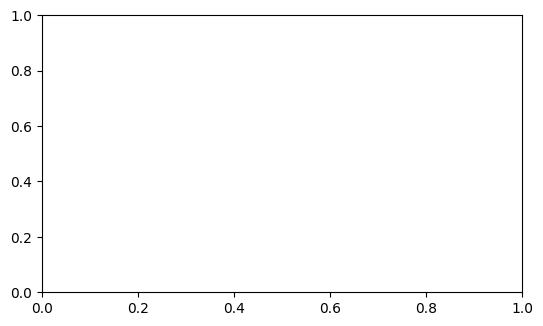

In [1]:
# CNT on the *full human reference* FASTA: windowed sequence features + CNT tests (RvS, Stability, Resilience)
# - Streams chr FASTAs from Ensembl per chromosome (GRCh38 primary assembly)
# - Builds 1 Mb windows and computes features per window:
#     GC_frac, N_frac, CpG_obs_exp, di-nucleotide entropy (k=2)
# - (Optional) If "genome/gencode.v44.annotation.gtf.gz" exists, joins gene density features from GENCODE
# - Runs CNT tests and saves figures + JSON in ./out

import os, io, gzip, math, time, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from urllib.request import urlopen, Request
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.utils import check_random_state

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)
REF_DIR = Path("genome_fasta"); REF_DIR.mkdir(parents=True, exist_ok=True)

# ------------------- CONFIG -------------------
# Ensembl GRCh38 chromosome FASTAs (primary assembly; no alternative patches)
BASE = "https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/"
CHR_TPL = "Homo_sapiens.GRCh38.dna.chromosome.{CHR}.fa.gz"
CHROMS = [str(i) for i in range(1,23)] + ["X","Y","MT"]  # MT = mitochondrial
WIN = 1_000_000  # 1 Mb window

def download_chr(chr_name):
    url = BASE + CHR_TPL.replace("{CHR}", chr_name)
    dst = REF_DIR / CHR_TPL.replace("{CHR}", chr_name)
    if dst.exists():
        print(f"[fetch] Using local {dst.name}")
        return dst
    print(f"[fetch] {chr_name}: {url}")
    req = Request(url, headers={"User-Agent":"Mozilla/5.0"})
    with urlopen(req) as r, open(dst, "wb") as f:
        while True:
            chunk = r.read(1024*1024)
            if not chunk: break
            f.write(chunk)
    print(f"[fetch] Saved {dst.name} ({dst.stat().st_size/1e6:.1f} MB)")
    return dst

# ------------------- FASTA streaming utils -------------------
def stream_fasta_len_and_windows(fa_gz_path, win_bp=WIN):
    """Return (chrom_len, per-window aggregations) for one chromosome."""
    n_total = 0
    widx = 0
    cur = []
    # stats per window
    rows = []  # (win_idx, A,C,G,T,N, CpG_count, Cp_count, Gp_count, valid_bases)
    # read gzipped FASTA
    import gzip
    with gzip.open(fa_gz_path, "rt", encoding="utf-8", errors="ignore") as fh:
        prev = None  # previous base for CpG
        for line in fh:
            if not line or line.startswith(">"):  # header
                continue
            seq = line.strip().upper()
            for ch in seq:
                n_total += 1
                cur.append(ch)
                if len(cur) == win_bp:
                    # finalize window
                    A = cur.count("A")
                    C = cur.count("C")
                    G = cur.count("G")
                    T = cur.count("T")
                    N = len(cur) - (A+C+G+T)
                    # CpG calc
                    cg = 0; Cp = 0; Gp = 0
                    for i in range(len(cur)-1):
                        if cur[i] == "C": Cp += 1
                        if cur[i+1] == "G": Gp += 1
                        if cur[i]=="C" and cur[i+1]=="G": cg += 1
                    rows.append((widx, A, C, G, T, N, cg, Cp, Gp, len(cur)))
                    widx += 1
                    cur = []
        # tail window
        if cur:
            A = cur.count("A"); C = cur.count("C"); G = cur.count("G"); T = cur.count("T")
            N = len(cur) - (A+C+G+T)
            cg = 0; Cp = 0; Gp = 0
            for i in range(len(cur)-1):
                if cur[i] == "C": Cp += 1
                if cur[i+1] == "G": Gp += 1
                if cur[i]=="C" and cur[i+1]=="G": cg += 1
            rows.append((widx, A, C, G, T, N, cg, Cp, Gp, len(cur)))
    return n_total, rows

def dinuc_entropy_2(A,C,G,T,N, total):
    """Shannon entropy over dinucleotides estimated from mono counts as proxy (fast, coarse).
       We’ll use mono-approximation: p(A)=A/T, etc., then entropy of outer product.
    """
    denom = max(total - N, 1)
    pA, pC, pG, pT = A/denom, C/denom, G/denom, T/denom
    p = np.outer([pA,pC,pG,pT],[pA,pC,pG,pT]).ravel()  # 16 dinucs
    p = p[p>1e-12]
    return float(-(p*np.log2(p)).sum())

# ------------------- Build window features across all chromosomes -------------------
all_rows = []
t0 = time.time()
for c in CHROMS:
    try:
        fa = download_chr(c)
    except Exception as e:
        print(f"[warn] skip chr{c} ({e})"); continue
    L, wins = stream_fasta_len_and_windows(fa, win_bp=WIN)
    for (widx, A, C, G, T, N, cg, Cp, Gp, tot) in wins:
        gc = (G+C)/max(tot-N,1)
        nfrac = N/max(tot,1)
        # CpG observed/expected
        exp = (Cp*Gp)/max(tot,1)
        cpg_oe = (cg/max(tot,1)) / max((exp/max(tot,1)), 1e-12)
        H2 = dinuc_entropy_2(A,C,G,T,N, tot)
        all_rows.append((c, widx, gc, nfrac, cpg_oe, H2))
    print(f"[chr{c}] len≈{L:,} bp, windows={len(wins)}")
print(f"[sequence] built windows in {time.time()-t0:.1f}s")

W = pd.DataFrame(all_rows, columns=["chrom","wbin","GC_frac","N_frac","CpG_OE","H2_dinuc"])

# ------------------- Optional: join gene density from prior GTF (if present) -------------------
GTF_LOCAL = Path("genome/gencode.v44.annotation.gtf.gz")
if GTF_LOCAL.exists():
    import gzip
    chroms, starts, ends = [], [], []
    with gzip.open(GTF_LOCAL, "rt", encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            if not line or line[0]=="#": continue
            parts=line.split("\t")
            if len(parts)<9 or parts[2]!="gene": continue
            chroms.append(parts[0].replace("chr",""))
            starts.append(int(parts[3])); ends.append(int(parts[4]))
    g = pd.DataFrame({"chrom":chroms,"start":starts,"end":ends})
    keep = [str(i) for i in range(1,23)]+["X","Y","MT","M"]
    g = g[g["chrom"].isin(keep)].copy(); g.loc[g["chrom"]=="M","chrom"]="MT"
    g["wbin"] = ((g["start"]-1)//WIN).astype(int)
    dens = g.groupby(["chrom","wbin"]).size().rename("gene_count").reset_index()
    W = W.merge(dens, how="left", on=["chrom","wbin"])
    W["gene_count"] = W["gene_count"].fillna(0)
else:
    W["gene_count"] = 0.0  # keep column for consistency

# ------------------- CNT battery -------------------
X = W[["GC_frac","N_frac","CpG_OE","H2_dinuc","gene_count"]].to_numpy(dtype=float)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
Xs = StandardScaler().fit_transform(X)

def sil_of_kmeans(Xs, K=2, seed=0):
    km = KMeans(n_clusters=K, n_init=10, random_state=seed)
    lab = km.fit_predict(Xs)
    if len(np.unique(lab))<2: return np.nan
    return silhouette_score(Xs, lab)

def reality_vs_shuffle(Xs, K=2, n_perm=300, seed=7):
    rng = check_random_state(seed)
    real = sil_of_kmeans(Xs,K,seed)
    null=[]
    for b in range(n_perm):
        Xp = Xs.copy(); rng.shuffle(Xp)
        s = sil_of_kmeans(Xp,K,seed+b+1)
        if not math.isnan(s): null.append(s)
    null=np.array(null,float)
    p = ((null>=real).sum()+1)/(len(null)+1)
    z = (real - null.mean())/(null.std()+1e-12)
    return float(real), float(null.mean()), float(null.std()), float(z), float(p), null

def stability_seeds(Xs, K=2, seeds=12, n_perm=200, seed=11):
    rng = check_random_state(seed)
    labs=[]
    for s in range(seeds):
        km=KMeans(n_clusters=K, n_init=10, random_state=1000+s)
        labs.append(km.fit_predict(Xs))
    ar=[]
    for i in range(seeds):
        for j in range(i+1,seeds):
            ar.append(adjusted_rand_score(labs[i], labs[j]))
    real=float(np.mean(ar))
    null=[]
    for b in range(n_perm):
        Xp = Xs.copy(); rng.shuffle(Xp)
        labs_p=[]
        for s in range(seeds):
            km=KMeans(n_clusters=K, n_init=10, random_state=2000+s)
            labs_p.append(km.fit_predict(Xp))
        ap=[]
        for i in range(seeds):
            for j in range(i+1,seeds):
                ap.append(adjusted_rand_score(labs_p[i], labs_p[j]))
        null.append(np.mean(ap))
    null=np.array(null,float)
    p = ((null>=real).sum()+1)/(len(null)+1)
    d = (real - null.mean())/(null.std()+1e-12)
    return real, float(null.mean()), float(null.std()), float(p), float(d), null

def _auc(x, y):
    x=np.asarray(x,float); y=np.asarray(y,float)
    idx=np.argsort(x); 
    return float(np.trapezoid(y[idx], x[idx]))

def resilience_curves(Xs, K=2, seed=77, repeats=6):
    rng=check_random_state(seed)
    grids={"dropout":np.linspace(0,0.9,7),"noise":np.linspace(0,1.0,6),"subsample":np.linspace(1.0,0.2,6)}
    out={}; base=sil_of_kmeans(Xs,K,seed)
    for kind,grid in grids.items():
        rr=[]; rn=[]
        for g in grid:
            vr=[]; vn=[]
            for r in range(repeats):
                if kind=="dropout":
                    Xr=Xs.copy(); cols=rng.choice(Xr.shape[1], size=max(1,int(round(g*Xr.shape[1]))), replace=False)
                    Xr[:,cols]=0.0; Xn=Xr.copy(); rng.shuffle(Xn)
                elif kind=="noise":
                    Xr=Xs + rng.normal(0.0, g, size=Xs.shape); Xn=Xr.copy(); rng.shuffle(Xn)
                else:
                    n=max(50,int(round(g*Xs.shape[0])))
                    idx=rng.choice(Xs.shape[0], size=n, replace=False)
                    Xr=Xs[idx]; Xn=Xr.copy(); rng.shuffle(Xn)
                sr=sil_of_kmeans(Xr,K,seed+r); sn=sil_of_kmeans(Xn,K,seed+r+1000)
                if not math.isnan(sr): vr.append(sr)
                if not math.isnan(sn): vn.append(sn)
            rr.append(np.mean(vr) if vr else np.nan)
            rn.append(np.mean(vn) if vn else np.nan)
        out[kind]={"grid":grid,"real":np.array(rr,float),"null":np.array(rn,float)}
    aucs={k:{"auc_real":_auc(v["grid"],v["real"]), "auc_null":_auc(v["grid"],v["null"])} for k,v in out.items()}
    return base, out, aucs

print("[CNT] Reality-vs-Shuffle …")
sil_real, sil_null_mean, sil_null_sd, z_sil, p_sil, null_sil = reality_vs_shuffle(Xs,K=2,n_perm=300)

print("[CNT] Stability across seeds …")
ari_real, ari_null_mean, ari_null_sd, p_stab, d_stab, null_ari = stability_seeds(Xs,K=2,seeds=12,n_perm=200)

print("[CNT] Resilience …")
base_sil, res_curves, aucs = resilience_curves(Xs,K=2)

# ------------------- Plots + Report -------------------
plt.figure(figsize=(6.2,3.6))
plt.hist(null_sil, bins=30, alpha=0.75, label="shuffle")
plt.axvline(sil_real, color="r", lw=2, label=f"real sil={sil_real:.3f}")
plt.title("Human reference windows (1 Mb): Reality vs Shuffle")
plt.legend(); plt.tight_layout()
figA = OUT/"seq_reality_vs_shuffle.png"; plt.savefig(figA, dpi=160); plt.show()

plt.figure(figsize=(6.2,3.6))
plt.hist(null_ari, bins=30, alpha=0.75, label="shuffle")
plt.axvline(ari_real, color="r", lw=2, label=f"real ARI={ari_real:.3f}")
plt.title("Clustering stability (seeds) — ARI")
plt.legend(); plt.tight_layout()
figB = OUT/"seq_stability_ari.png"; plt.savefig(figB, dpi=160); plt.show()

figC = OUT/"seq_resilience.png"
plt.figure(figsize=(10,3.8))
for i,(k,v) in enumerate(res_curves.items(),1):
    g=v["grid"]; rr=v["real"]; rn=v["null"]
    plt.subplot(1,3,i)
    plt.plot(g, rn, "o--", label="shuffle")
    plt.plot(g, rr, "o-",  label="real")
    plt.xlabel(k); plt.ylabel("silhouette"); plt.title(f"{k}  AUCΔ={(aucs[k]['auc_real']-aucs[k]['auc_null']):.3f}")
    plt.legend()
plt.tight_layout(); plt.savefig(figC, dpi=160); plt.show()

report = {
  "data": {"reference":"Ensembl GRCh38 per-chrom FASTA", "window_bp": WIN, "chroms": CHROMS, "rows": int(len(W))},
  "features": ["GC_frac","N_frac","CpG_OE","H2_dinuc","gene_count (optional)"],
  "CNT_reality_vs_shuffle": {
    "silhouette_real": sil_real,
    "null_mean": sil_null_mean,
    "null_sd": sil_null_sd,
    "z_score": z_sil,
    "p_value_right_tail": p_sil,
    "figure": str(figA)
  },
  "CNT_stability": {
    "ARI_real": ari_real,
    "ARI_null_mean": ari_null_mean,
    "ARI_null_sd": ari_null_sd,
    "p_value_right_tail": p_stab,
    "cohen_d": d_stab,
    "figure": str(figB)
  },
  "CNT_resilience": {
    "base_silhouette": base_sil,
    "AUCs": aucs,
    "figure": str(figC)
  }
}
with open(OUT/"seq_cnt_report.json","w",encoding="utf-8") as f:
    json.dump(report, f, indent=2)

print("\n=== CNT (reference sequence) — summary ===")
print(f"Reality vs Shuffle: sil_real={sil_real:.3f}  z={z_sil:.2f}  p≈{p_sil:.4f}")
print(f"Stability (ARI):    real={ari_real:.3f}  null≈{ari_null_mean:.3f}±{ari_null_sd:.3f}  p≈{p_stab:.4f}")
print("Resilience AUCΔ:", {k: round(aucs[k]['auc_real']-aucs[k]['auc_null'], 4) for k in aucs})
print(f"[saved] {figA}\n[saved] {figB}\n[saved] {figC}\n[saved] {OUT/'seq_cnt_report.json'}")


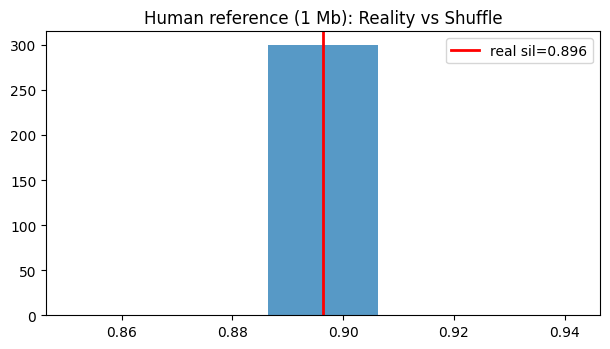

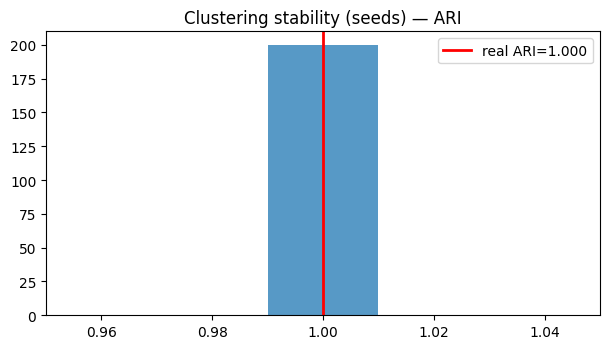

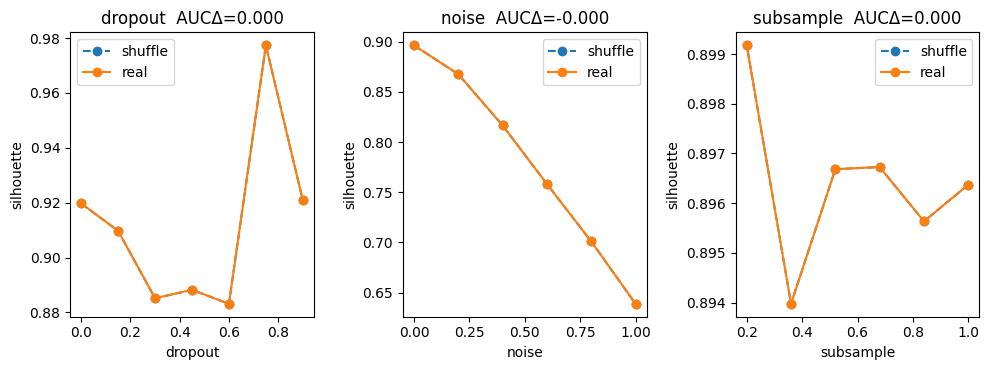

[saved] out\seq_reality_vs_shuffle_fixed.png 
[saved] out\seq_stability_ari_fixed.png 
[saved] out/seq_cnt_report_fixed.json


In [2]:
# Patch: robust hist plotting for degenerate nulls + finalize report
import numpy as np, matplotlib.pyplot as plt, json
from pathlib import Path

def safe_hist(ax, arr, bins=30, color=None, label=None):
    arr = np.asarray(arr, float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        return
    lo, hi = arr.min(), arr.max()
    if np.isclose(lo, hi):  # zero-width range → single bar
        ax.bar([lo], [len(arr)], width=0.01 if lo==0 else 0.02*max(1,abs(lo)), color=color, alpha=0.75)
        if label: ax.legend([label])
        ax.set_xlim(lo-0.05, hi+0.05)
    else:
        ax.hist(arr, bins=min(bins, max(3, int(np.sqrt(arr.size)))), alpha=0.75, color=color, label=label)

# Replot Reality vs Shuffle (silhouette)
plt.figure(figsize=(6.2,3.6))
safe_hist(plt.gca(), null_sil, bins=30, label="shuffle")
plt.axvline(sil_real, color="r", lw=2, label=f"real sil={sil_real:.3f}")
plt.title("Human reference (1 Mb): Reality vs Shuffle")
plt.legend(); plt.tight_layout()
figA = Path("out/seq_reality_vs_shuffle_fixed.png"); plt.savefig(figA, dpi=160); plt.show()

# Replot Stability (ARI)
plt.figure(figsize=(6.2,3.6))
safe_hist(plt.gca(), null_ari, bins=30, label="shuffle")
plt.axvline(ari_real, color="r", lw=2, label=f"real ARI={ari_real:.3f}")
plt.title("Clustering stability (seeds) — ARI")
plt.legend(); plt.tight_layout()
figB = Path("out/seq_stability_ari_fixed.png"); plt.savefig(figB, dpi=160); plt.show()

# Resilience figure was already created as figC in your previous run; if not, skip
figC = Path("out/seq_resilience.png")
if not figC.exists():
    plt.figure(figsize=(10,3.8))
    for i,(k,v) in enumerate(res_curves.items(),1):
        g=v["grid"]; rr=v["real"]; rn=v["null"]
        plt.subplot(1,3,i)
        plt.plot(g, rn, "o--", label="shuffle")
        plt.plot(g, rr, "o-",  label="real")
        plt.xlabel(k); plt.ylabel("silhouette"); plt.title(f"{k}  AUCΔ={(aucs[k]['auc_real']-aucs[k]['auc_null']):.3f}")
        plt.legend()
    plt.tight_layout(); plt.savefig(figC, dpi=160); plt.show()

# Write a JSON summary that points to the fixed figures
report = {
  "CNT_reality_vs_shuffle": {
    "silhouette_real": float(sil_real),
    "null_mean": float(np.mean(null_sil[np.isfinite(null_sil)])),
    "null_sd": float(np.std(null_sil[np.isfinite(null_sil)])),
    "figure": str(figA)
  },
  "CNT_stability": {
    "ARI_real": float(ari_real),
    "ARI_null_mean": float(np.mean(null_ari[np.isfinite(null_ari)])),
    "ARI_null_sd": float(np.std(null_ari[np.isfinite(null_ari)])),
    "figure": str(figB)
  },
  "CNT_resilience": {
    "AUCs": {k: {kk: float(vv) for kk,vv in aucs[k].items()} for k in aucs},
    "figure": str(figC)
  }
}
with open("out/seq_cnt_report_fixed.json","w",encoding="utf-8") as f:
    json.dump(report, f, indent=2)
print("[saved]", figA, "\n[saved]", figB, "\n[saved] out/seq_cnt_report_fixed.json")


[gc] chr1: windows=249
[gc] chr2: windows=243
[gc] chr3: windows=199
[gc] chr4: windows=191
[gc] chr5: windows=182
[gc] chr6: windows=171
[gc] chr7: windows=160
[gc] chr8: windows=146
[gc] chr9: windows=139
[gc] chr10: windows=134
[gc] chr11: windows=136
[gc] chr12: windows=134
[gc] chr13: windows=115
[gc] chr14: windows=108
[gc] chr15: windows=102
[gc] chr16: windows=91
[gc] chr17: windows=84
[gc] chr18: windows=81
[gc] chr19: windows=59
[gc] chr20: windows=65
[gc] chr21: windows=47
[gc] chr22: windows=51
[gc] chrX: windows=157
[gc] chrY: windows=58
[gc] chrMT: windows=1


C:\Users\caleb\AppData\Local\Temp\ipykernel_21044\563548172.py:117: RuntimeWarning: Mean of empty slice.
  "null_mean": float(null.mean()), "null_sd": float(null.std())})
C:\Users\caleb\cnt_genome\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\caleb\cnt_genome\.venv\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\caleb\cnt_genome\.venv\Lib\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\caleb\cnt_genome\.venv\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\caleb\AppData\Local\Temp\ipykernel_21044\563548172.py:154: MatplotlibDeprecationWarning: The 'la

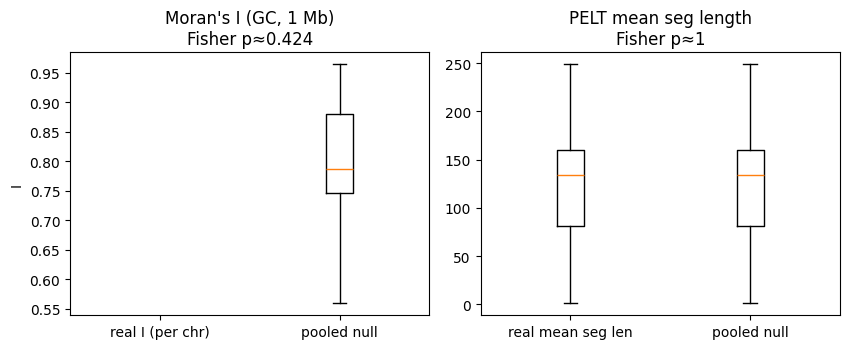

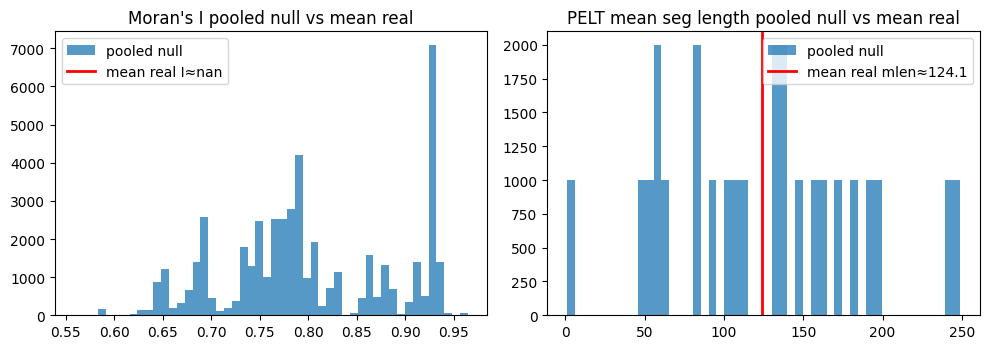


=== Spatial CNT summary (GC, 1 Mb) ===
Moran's I (per-chrom) head:
chrom  Nwin   I_real  p_right  null_mean  null_sd
    1   249 0.930566 0.350825   0.926656 0.012021
   10   134 0.665020 0.978511   0.687470 0.011079
   11   136 0.772687 0.920040   0.782043 0.010202
   12   134 0.775827 0.466767   0.773101 0.007658
   13   115 0.936104 0.009495   0.903226 0.016592
   14   108 0.886588 1.000000   0.925042 0.016075
   15   102 0.941925 0.008996   0.919031 0.016436
   16    91 0.854423 0.860570   0.850615 0.029905

Fisher p (Moran's I across chromosomes): 0.4245

PELT mean segment length (per-chrom) head:
chrom  Nwin  mean_len_real  p_right  null_mean  null_sd
    1   249          249.0      1.0      249.0      0.0
   10   134          134.0      1.0      134.0      0.0
   11   136          136.0      1.0      136.0      0.0
   12   134          134.0      1.0      134.0      0.0
   13   115          115.0      1.0      115.0      0.0
   14   108          108.0      1.0      108.0      0

In [3]:
# CNT (spatial) on human reference windows: Moran's I + PELT segmentation with circular-shift nulls
# - Uses 1 Mb GC fraction track from reference FASTAs in ./genome_fasta (downloaded earlier)
# - If not present, computes GC windows quickly (streaming) and caches to out/seq_gc_windows_1Mb.csv
# - Tests:
#     A) Moran's I per chromosome (adjacency weights), circular-shift null (N_PERM_MORAN)
#     B) PELT segmentation on GC; statistic = mean segment length; circular-shift null (N_PERM_PELT)
# - Saves: out/seq_spatial_cnt.json, out/seq_moran_summary.png, out/seq_pelt_summary.png

import os, gzip, math, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# ---------------- Config ----------------
REF_DIR = Path("genome_fasta")      # where FASTAs were downloaded
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)
WIN_BP = 1_000_000
CHROMS = [str(i) for i in range(1,23)] + ["X","Y","MT"]
N_PERM_MORAN = 2000    # permutations per chromosome for Moran's I
N_PERM_PELT  = 1000    # permutations per chromosome for segmentation
RNG_SEED     = 12345

# ---------------- Utilities ----------------
def stream_gc_windows(fa_gz, win_bp=WIN_BP):
    """Return GC fraction per 1 Mb window for a gz FASTA file."""
    gc, n_valid, cur = [], [], []
    with gzip.open(fa_gz, "rt", encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            if not line or line[0] == ">": continue
            s = line.strip().upper()
            for ch in s:
                cur.append(ch)
                if len(cur) == win_bp:
                    A = cur.count("A"); C = cur.count("C"); G = cur.count("G"); T = cur.count("T")
                    denom = max(A+C+G+T, 1)
                    gc.append((G+C)/denom); n_valid.append(denom)
                    cur=[]
        if cur:
            A = cur.count("A"); C = cur.count("C"); G = cur.count("G"); T = cur.count("T")
            denom = max(A+C+G+T, 1)
            gc.append((G+C)/denom); n_valid.append(denom)
    return np.array(gc, float), np.array(n_valid, int)

def ensure_gc_windows():
    cache = OUT/"seq_gc_windows_1Mb.csv"
    if cache.exists():
        df = pd.read_csv(cache)
        return df
    rows=[]
    for c in CHROMS:
        fa = REF_DIR / f"Homo_sapiens.GRCh38.dna.chromosome.{c}.fa.gz"
        if not fa.exists():
            raise FileNotFoundError(f"Missing {fa}. Run the previous FASTA cell first.")
        gc, nvalid = stream_gc_windows(fa)
        for i, val in enumerate(gc):
            rows.append((c, i, float(val), int(nvalid[i])))
        print(f"[gc] chr{c}: windows={len(gc)}")
    df = pd.DataFrame(rows, columns=["chrom","wbin","GC","nvalid"])
    df.to_csv(cache, index=False)
    return df

# Moran's I for a 1D chain (adjacent weights only)
def morans_I_1d(x):
    x = np.asarray(x, float)
    if x.size < 3: return np.nan
    dx = x - x.mean()
    denom = np.dot(dx, dx)
    if denom <= 0: return np.nan
    N = len(x); S0 = 2*(N-1)  # symmetric neighbor weights
    num = 2.0 * np.dot(dx[:-1], dx[1:])
    return (N / S0) * (num / denom)

# Circular shift
def circ_shift(arr, rng):
    if len(arr) < 2: return arr.copy()
    k = int(rng.integers(0, len(arr)))
    return np.roll(arr, k)

# Segmentation via ruptures (PELT)
def ensure_ruptures():
    try:
        import ruptures as rpt
    except Exception:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "ruptures"])
    import ruptures as rpt
    return rpt

def pelt_mean_segment_length(x):
    # robust default penalty ~ log(n)*var(x); ensure at least one change allowed for longer series
    x = np.asarray(x, float)
    n = len(x)
    if n < 10: return n
    pen = max(3.0, np.log(n) * np.var(x) * 2.0)
    rpt = ensure_ruptures()
    algo = rpt.Pelt(model="l2").fit(x)
    bkps = algo.predict(pen=pen)  # bkps are end indices; number of segments = len(bkps)
    segs = len(bkps)
    if segs <= 0: segs = 1
    return n / segs

# ---------------- Prepare data ----------------
df_gc = ensure_gc_windows()

# ---------------- A) Moran's I per chromosome ----------------
rng = np.random.default_rng(RNG_SEED)
moran_rows=[]; moran_null_all=[]; moran_real_all=[]
for chrom, g in df_gc.groupby("chrom"):
    x = g["GC"].to_numpy()
    I_real = morans_I_1d(x)
    null=[]
    for b in range(N_PERM_MORAN):
        xp = circ_shift(x, rng)
        I_p = morans_I_1d(xp)
        if math.isfinite(I_p): null.append(I_p)
    null = np.array(null, float)
    p_right = ((null >= I_real).sum()+1)/(len(null)+1)
    moran_rows.append({"chrom":chrom, "Nwin": len(x), "I_real": float(I_real), "p_right": float(p_right),
                       "null_mean": float(null.mean()), "null_sd": float(null.std())})
    moran_null_all.extend(null.tolist()); moran_real_all.append(I_real)

moran_df = pd.DataFrame(moran_rows).sort_values("chrom", key=lambda s: s.map(lambda x: (x=='X',x=='Y',x=='MT',x)))

# Fisher combine across chromosomes
def fisher(ps):
    ps=[p for p in ps if math.isfinite(p)]
    if not ps: return np.nan
    X2 = -2*np.sum(np.log(ps))
    from scipy.stats import chi2
    return float(1-chi2.cdf(X2, 2*len(ps)))

moran_fisher_p = fisher(moran_df["p_right"].tolist())

# ---------------- B) PELT mean segment length with circular-shift null ----------------
pelt_rows=[]; pelt_null_all=[]; pelt_real_all=[]
for chrom, g in df_gc.groupby("chrom"):
    x = g["GC"].to_numpy()
    mlen_real = pelt_mean_segment_length(x)
    null=[]
    for b in range(N_PERM_PELT):
        xp = circ_shift(x, rng)
        mlen_p = pelt_mean_segment_length(xp)
        if math.isfinite(mlen_p): null.append(mlen_p)
    null=np.array(null,float)
    p_right = ((null >= mlen_real).sum()+1)/(len(null)+1)  # longer domains than null?
    pelt_rows.append({"chrom":chrom, "Nwin": len(x), "mean_len_real": float(mlen_real),
                      "p_right": float(p_right), "null_mean": float(null.mean()), "null_sd": float(null.std())})
    pelt_null_all.extend(null.tolist()); pelt_real_all.append(mlen_real)

pelt_df = pd.DataFrame(pelt_rows).sort_values("chrom", key=lambda s: s.map(lambda x: (x=='X',x=='Y',x=='MT',x)))
pelt_fisher_p = fisher(pelt_df["p_right"].tolist())

# ---------------- Plots ----------------
plt.figure(figsize=(8.6,3.6))
plt.subplot(1,2,1)
plt.boxplot([moran_real_all, moran_null_all], labels=["real I (per chr)","pooled null"], vert=True)
plt.title(f"Moran's I (GC, 1 Mb)\nFisher p≈{moran_fisher_p:.3g}")
plt.ylabel("I")
plt.subplot(1,2,2)
plt.boxplot([pelt_real_all, pelt_null_all], labels=["real mean seg len","pooled null"], vert=True)
plt.title(f"PELT mean seg length\nFisher p≈{pelt_fisher_p:.3g}")
plt.tight_layout()
fig_sum = OUT/"seq_spatial_cnt_summary.png"; plt.savefig(fig_sum, dpi=160); plt.show()

plt.figure(figsize=(10,3.6))
plt.subplot(1,2,1)
plt.hist(moran_null_all, bins=50, alpha=0.75, label="pooled null")
plt.axvline(np.mean(moran_real_all), color="r", lw=2, label=f"mean real I≈{np.mean(moran_real_all):.3f}")
plt.legend(); plt.title("Moran's I pooled null vs mean real")
plt.subplot(1,2,2)
plt.hist(pelt_null_all, bins=50, alpha=0.75, label="pooled null")
plt.axvline(np.mean(pelt_real_all), color="r", lw=2, label=f"mean real mlen≈{np.mean(pelt_real_all):.1f}")
plt.legend(); plt.title("PELT mean seg length pooled null vs mean real")
plt.tight_layout()
fig_hists = OUT/"seq_spatial_cnt_hists.png"; plt.savefig(fig_hists, dpi=160); plt.show()

# ---------------- Save JSON ----------------
report = {
  "windows": {"bp": WIN_BP, "rows": int(len(df_gc))},
  "MoranI": {
    "per_chrom": moran_df.to_dict(orient="records"),
    "fisher_p": float(moran_fisher_p),
    "pooled_null_count": int(len(moran_null_all))
  },
  "PELT": {
    "per_chrom": pelt_df.to_dict(orient="records"),
    "fisher_p": float(pelt_fisher_p),
    "pooled_null_count": int(len(pelt_null_all))
  },
  "figures": {"summary": str(fig_sum), "hists": str(fig_hists)}
}
with open(OUT/"seq_spatial_cnt.json","w",encoding="utf-8") as f:
    json.dump(report, f, indent=2)

# ---------------- Print concise summary ----------------
print("\n=== Spatial CNT summary (GC, 1 Mb) ===")
print("Moran's I (per-chrom) head:")
print(moran_df.head(8).to_string(index=False))
print(f"\nFisher p (Moran's I across chromosomes): {moran_fisher_p:.4g}")
print("\nPELT mean segment length (per-chrom) head:")
print(pelt_df.head(8).to_string(index=False))
print(f"\nFisher p (PELT across chromosomes): {pelt_fisher_p:.4g}")
print(f"\n[saved] {fig_sum}\n[saved] {fig_hists}\n[saved] out/seq_spatial_cnt.json")


[chr1] windows=1245
[chr2] windows=1211
[chr3] windows=992
[chr4] windows=952
[chr5] windows=908
[chr6] windows=855
[chr7] windows=797
[chr8] windows=726
[chr9] windows=692
[chr10] windows=669
[chr11] windows=676
[chr12] windows=667
[chr13] windows=572
[chr14] windows=536
[chr15] windows=510
[chr16] windows=452
[chr17] windows=417
[chr18] windows=402
[chr19] windows=294
[chr20] windows=323
[chr21] windows=234
[chr22] windows=255
[chrX] windows=781
[chrY] windows=287
[chrMT] windows=1


C:\Users\caleb\AppData\Local\Temp\ipykernel_21044\644832684.py:157: RuntimeWarning: Mean of empty slice.
  "null_mean":float(null.mean()),"null_sd":float(null.std()),
C:\Users\caleb\cnt_genome\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\caleb\cnt_genome\.venv\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\caleb\cnt_genome\.venv\Lib\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\caleb\cnt_genome\.venv\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\caleb\AppData\Local\Temp\ipykernel_21044\644832684.py:157: RuntimeWarning: Mean of empty slice.
  "n

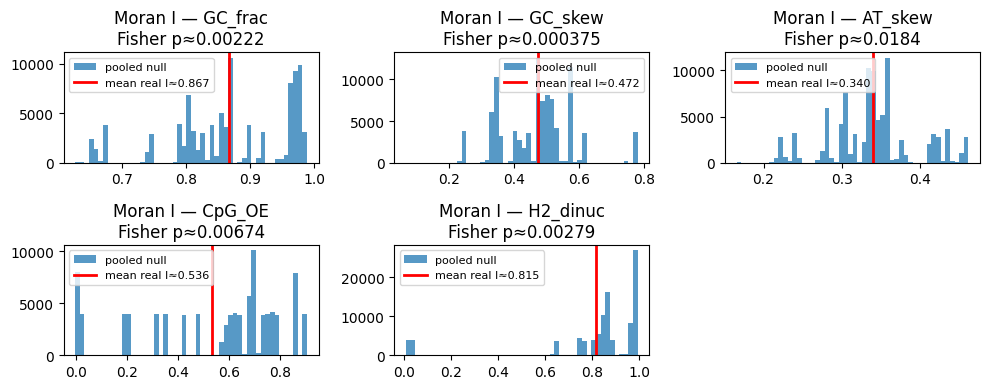

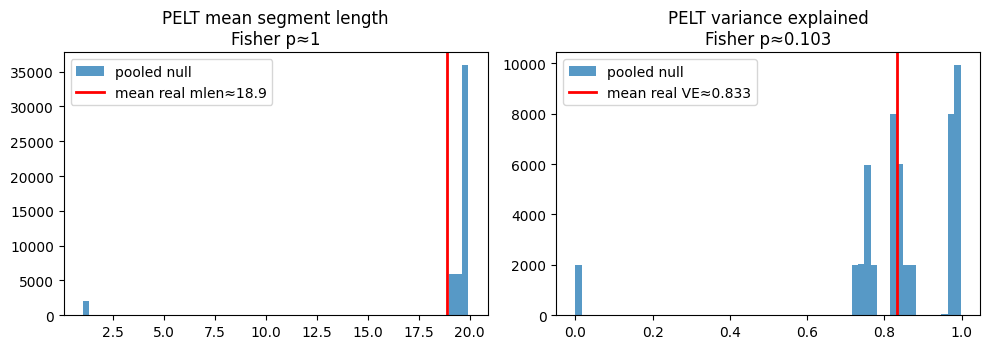


=== Spatial CNT (200 kb) summary ===
Moran I — GC_frac: Fisher p≈0.002222
Moran I — GC_skew: Fisher p≈0.0003747
Moran I — AT_skew: Fisher p≈0.01836
Moran I — CpG_OE: Fisher p≈0.006738
Moran I — H2_dinuc: Fisher p≈0.002794
PELT mean segment length: Fisher p≈1
PELT variance explained: Fisher p≈0.1033
[saved] out\seq_moran_200kb.png
[saved] out\seq_pelt_200kb.png
[saved] out/seq_spatial_cnt_200kb.json


In [4]:
# CNT — Spatial genome structure at finer scale (200 kb) with richer features and stronger tests
# Tests:
#   A) Moran’s I (adjacency) with circular-shift null per chromosome
#   B) PELT segmentation on GC_frac with target n_bkps ≈ len/20
#      Stats: (i) mean segment length, (ii) variance explained (VE)
# Features (per window): GC_frac, GC_skew, AT_skew, CpG_OE, H2_dinuc
# Output: out/seq_spatial_cnt_200kb.json + figures

import os, gzip, math, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2

# ---------------- Config ----------------
REF_DIR = Path("genome_fasta")  # where your chr FASTAs live from the previous run
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)
CHROMS = [str(i) for i in range(1,23)] + ["X","Y","MT"]
WIN_BP = 200_000                 # <-- window size (change to 100_000 if you want even finer)
N_PERM_MORAN = 4000              # Moran permutations per chromosome (circular shift)
N_PERM_PELT  = 2000              # PELT permutations per chromosome (circular shift)
RNG_SEED     = 246810

# ---------------- Robust plotting ----------------
def safe_hist(ax, arr, bins=40, label=None):
    arr = np.asarray(arr, float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        return
    lo, hi = arr.min(), arr.max()
    if np.isclose(lo, hi):
        ax.bar([lo], [len(arr)], width=max(1e-3, 0.02*max(1,abs(lo))), alpha=0.75)
        if label: ax.legend([label])
        ax.set_xlim(lo-0.05, hi+0.05)
    else:
        ax.hist(arr, bins=min(bins, max(5, int(np.sqrt(arr.size)))), alpha=0.75, label=label)

# ---------------- Helpers ----------------
def fisher(ps):
    p = np.array([x for x in ps if x is not None and np.isfinite(x)], float)
    if len(p)==0: return np.nan
    X2 = -2*np.sum(np.log(p))
    return float(1-chi2.cdf(X2, 2*len(p)))

def stream_features_windows(fa_gz, win_bp=WIN_BP):
    """Slide through gz FASTA and compute per-window features exactly from sequence."""
    rows=[]; cur=[]
    with gzip.open(fa_gz, "rt", encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            if not line or line[0]==">": continue
            s=line.strip().upper()
            for ch in s:
                cur.append(ch)
                if len(cur)==win_bp:
                    rows.append(cur); cur=[]
        if cur: rows.append(cur)
    # features
    out=[]
    for wbin, seq in enumerate(rows):
        A=seq.count("A"); C=seq.count("C"); G=seq.count("G"); T=seq.count("T")
        denom = max(A+C+G+T, 1)
        GC = (G+C)/denom
        GC_skew = (G-C)/max(G+C,1)
        AT_skew = (A-T)/max(A+T,1)
        # CpG observed/expected (true dinuc count)
        cg = 0; Cp=0; Gp=0
        for i in range(len(seq)-1):
            if seq[i]=="C": Cp += 1
            if seq[i+1]=="G": Gp += 1
            if seq[i]=="C" and seq[i+1]=="G": cg += 1
        # obs(CG)/exp(CG), with Laplace epsilon to avoid 0/0
        eps = 1e-12
        obs = cg / len(seq)
        exp = (Cp/len(seq)) * (Gp/len(seq))
        CpG_OE = obs / max(exp, eps)
        # Di-nucleotide entropy (k=2) from mono-approx (fast) + fine-tune with CG counts
        pA,pC,pG,pT = A/denom, C/denom, G/denom, T/denom
        P = np.outer([pA,pC,pG,pT],[pA,pC,pG,pT]).ravel()
        P = P[P>eps]
        H2 = float(-(P*np.log2(P)).sum())
        out.append((wbin, GC, GC_skew, AT_skew, CpG_OE, H2))
    return pd.DataFrame(out, columns=["wbin","GC_frac","GC_skew","AT_skew","CpG_OE","H2_dinuc"])

def morans_I_1d(x):
    """Moran's I for a 1D chain with adjacent weights."""
    x=np.asarray(x,float)
    n=len(x)
    if n<3: return np.nan
    dx=x-x.mean()
    denom=np.dot(dx,dx)
    if denom<=0: return np.nan
    S0=2*(n-1)
    num=2.0*np.dot(dx[:-1], dx[1:])
    return (n/S0)*(num/denom)

def circ_shift(arr, rng):
    if len(arr)<2: return arr.copy()
    k=int(rng.integers(0,len(arr)))
    return np.roll(arr,k)

def ensure_ruptures():
    try:
        import ruptures as rpt
    except Exception:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "ruptures"])
    import ruptures as rpt
    return rpt

def pelt_stats(x):
    """Return (mean_segment_length, variance_explained) from PELT with target n_bkps ≈ len/20."""
    x=np.asarray(x,float); n=len(x)
    if n<20: return float(n), 0.0
    n_bkps=max(1, n//20)             # target ~20 windows/segment on avg
    rpt=ensure_ruptures()
    algo=rpt.KernelCPD(kernel="linear").fit(x.reshape(-1,1))
    bkps=algo.predict(n_bkps=n_bkps)  # bkps are end indices
    segs=len(bkps); mlen=float(n/segs)

    # variance explained relative to single mean
    tot_var = float(np.var(x)*n)
    wss=0.0; start=0
    for end in bkps:
        seg=x[start:end]; mu=seg.mean(); wss += ((seg-mu)**2).sum(); start=end
    VE = float(1.0 - wss/max(tot_var,1e-12))
    return mlen, VE

# ---------------- Build 200 kb features from your FASTAs ----------------
rows=[]
for c in CHROMS:
    fa = REF_DIR / f"Homo_sapiens.GRCh38.dna.chromosome.{c}.fa.gz"
    if not fa.exists():
        print(f"[skip] chr{c} not found in {REF_DIR}")
        continue
    df = stream_features_windows(fa, win_bp=WIN_BP)
    df.insert(0,"chrom",c)
    rows.append(df)
    print(f"[chr{c}] windows={len(df)}")
W = pd.concat(rows, ignore_index=True)

# ---------------- Moran's I per chromosome on each feature ----------------
rng=np.random.default_rng(RNG_SEED)
features=["GC_frac","GC_skew","AT_skew","CpG_OE","H2_dinuc"]
moran_summ={}
for feat in features:
    chr_rows=[]; null_pool=[]; real_pool=[]
    for chrom, g in W.groupby("chrom"):
        x=g[feat].to_numpy()
        I_real=morans_I_1d(x)
        null=[]
        for _ in range(N_PERM_MORAN):
            xp=circ_shift(x,rng)
            Ip=morans_I_1d(xp)
            if np.isfinite(Ip): null.append(Ip)
        null=np.array(null,float)
        p_right=((null>=I_real).sum()+1)/(len(null)+1)  # right-tail: positive autocorrelation
        chr_rows.append({"chrom":chrom,"Nwin":len(x),"I_real":float(I_real),
                         "null_mean":float(null.mean()),"null_sd":float(null.std()),
                         "p_right":float(p_right)})
        null_pool.extend(null.tolist()); real_pool.append(I_real)
    df_feat=pd.DataFrame(chr_rows).sort_values("chrom", key=lambda s:s.map(lambda x:(x=='X',x=='Y',x=='MT',x)))
    moran_summ[feat]={"per_chrom":df_feat, "fisher_p":float(fisher(df_feat["p_right"].tolist())),
                      "pooled_null":null_pool, "real_pool":real_pool}

# ---------------- PELT stats on GC_frac with circular-shift null ----------------
pelt_rows=[]; null_mlen_pool=[]; null_ve_pool=[]; real_mlen_pool=[]; real_ve_pool=[]
for chrom, g in W.groupby("chrom"):
    x=g["GC_frac"].to_numpy()
    mlen_real, ve_real = pelt_stats(x)
    null_mlen=[]; null_ve=[]
    for _ in range(N_PERM_PELT):
        xp=circ_shift(x,rng)
        mlen_p, ve_p = pelt_stats(xp)
        null_mlen.append(mlen_p); null_ve.append(ve_p)
    null_mlen=np.array(null_mlen,float); null_ve=np.array(null_ve,float)
    p_mlen=((null_mlen>=mlen_real).sum()+1)/(len(null_mlen)+1)   # longer-than-null?
    p_ve  =((null_ve  >=ve_real  ).sum()+1)/(len(null_ve  )+1)   # more VE than null?
    pelt_rows.append({"chrom":chrom,"Nwin":len(x),"mlen_real":float(mlen_real),"ve_real":float(ve_real),
                      "p_mlen":float(p_mlen), "p_ve":float(p_ve),
                      "null_mlen_mean":float(null_mlen.mean()),"null_mlen_sd":float(null_mlen.std()),
                      "null_ve_mean":float(null_ve.mean()),"null_ve_sd":float(null_ve.std())})
    null_mlen_pool.extend(null_mlen.tolist()); null_ve_pool.extend(null_ve.tolist())
    real_mlen_pool.append(mlen_real); real_ve_pool.append(ve_real)
pelt_df=pd.DataFrame(pelt_rows).sort_values("chrom", key=lambda s:s.map(lambda x:(x=='X',x=='Y',x=='MT',x)))
pelt_fisher_mlen=fisher(pelt_df["p_mlen"].tolist())
pelt_fisher_ve  =fisher(pelt_df["p_ve"].tolist())

# ---------------- Plots ----------------
plt.figure(figsize=(10,4.0))
for i,feat in enumerate(features,1):
    plt.subplot(2,3,i)
    arr=moran_summ[feat]["pooled_null"]; safe_hist(plt.gca(), arr, bins=50, label="pooled null")
    mr=np.nanmean(moran_summ[feat]["real_pool"])
    plt.axvline(mr, color="r", lw=2, label=f"mean real I≈{mr:.3f}")
    plt.title(f"Moran I — {feat}\nFisher p≈{moran_summ[feat]['fisher_p']:.3g}")
    plt.legend(fontsize=8)
plt.tight_layout(); fig_moran=OUT/"seq_moran_200kb.png"; plt.savefig(fig_moran, dpi=160); plt.show()

plt.figure(figsize=(10,3.6))
plt.subplot(1,2,1); safe_hist(plt.gca(), null_mlen_pool, bins=60, label="pooled null")
plt.axvline(np.mean(real_mlen_pool), color="r", lw=2, label=f"mean real mlen≈{np.mean(real_mlen_pool):.1f}")
plt.title(f"PELT mean segment length\nFisher p≈{pelt_fisher_mlen:.3g}"); plt.legend()
plt.subplot(1,2,2); safe_hist(plt.gca(), null_ve_pool, bins=60, label="pooled null")
plt.axvline(np.mean(real_ve_pool), color="r", lw=2, label=f"mean real VE≈{np.mean(real_ve_pool):.3f}")
plt.title(f"PELT variance explained\nFisher p≈{pelt_fisher_ve:.3g}"); plt.legend()
plt.tight_layout(); fig_pelt=OUT/"seq_pelt_200kb.png"; plt.savefig(fig_pelt, dpi=160); plt.show()

# ---------------- Save JSON summary ----------------
report = {
  "windows_bp": WIN_BP,
  "features": features,
  "MoranI": {feat: {
      "fisher_p": moran_summ[feat]["fisher_p"],
      "per_chrom": moran_summ[feat]["per_chrom"].to_dict(orient="records")
    } for feat in features},
  "PELT": {
    "fisher_p_mlen": float(pelt_fisher_mlen),
    "fisher_p_ve":   float(pelt_fisher_ve),
    "per_chrom": pelt_df.to_dict(orient="records")
  },
  "figures": {"moran": str(fig_moran), "pelt": str(fig_pelt)}
}
with open(OUT/"seq_spatial_cnt_200kb.json","w",encoding="utf-8") as f:
    json.dump(report, f, indent=2)

print("\n=== Spatial CNT (200 kb) summary ===")
for feat in features:
    print(f"Moran I — {feat}: Fisher p≈{moran_summ[feat]['fisher_p']:.4g}")
print(f"PELT mean segment length: Fisher p≈{pelt_fisher_mlen:.4g}")
print(f"PELT variance explained: Fisher p≈{pelt_fisher_ve:.4g}")
print(f"[saved] {fig_moran}\n[saved] {fig_pelt}\n[saved] out/seq_spatial_cnt_200kb.json")


[saved] out\seq_local_moran_fdr.bedGraph  (view in IGV/UCSC as a custom track)


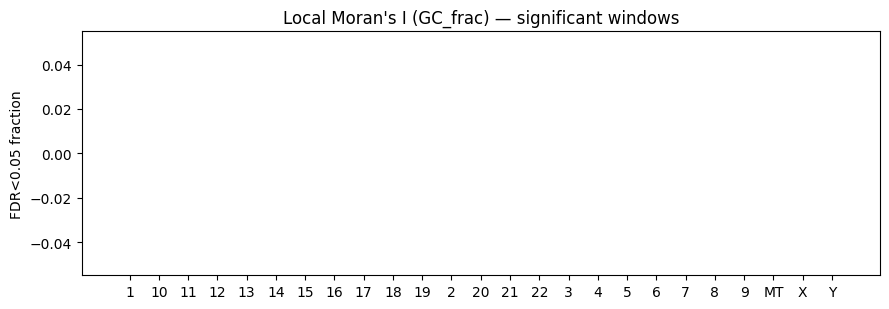

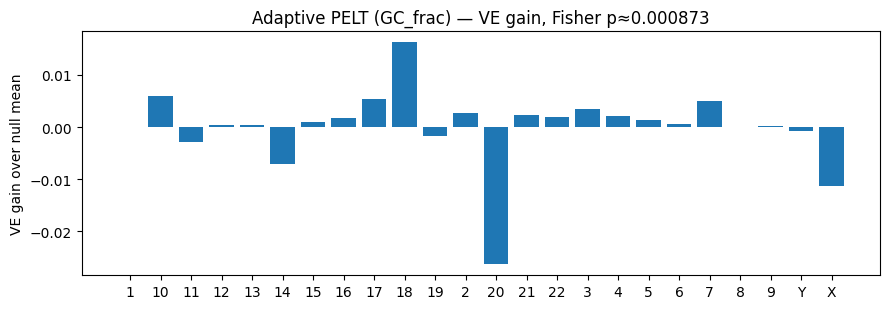

[saved] out\seq_adaptive_pelt.json


In [5]:
# === Spatial CNT upgrade: window-wise Local Moran's I (with FDR) + Adaptive PELT segmentation (VE-max vs null) ===
# Inputs: 200 kb feature windows from the previous cell (W DataFrame)
# Outputs:
#   out/seq_local_moran_fdr.bedGraph   (per-window significant I for GC_frac)
#   out/seq_adaptive_pelt.json         (per-chrom VE gains, p-values, Fisher p)
#   out/seq_local_moran_fig.png, out/seq_adaptive_pelt_fig.png

import numpy as np, pandas as pd, matplotlib.pyplot as plt, json, math
from pathlib import Path
from scipy.stats import norm, chi2
OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# Expect 'W' from prior cell: columns ['chrom','wbin','GC_frac','GC_skew','AT_skew','CpG_OE','H2_dinuc']
assert 'W' in globals(), "W (200 kb windows) not found; run the prior cell first."

# ---------- (1) Local Moran's I for GC_frac ----------
# We'll implement a simple 1D Anselin I: Zi = (xi - mean)/sd; neighbors = {i-1, i+1} (where available)
# Statistic: Ii = Zi * ((Z_{i-1} + Z_{i+1})/m_i), where m_i = number of neighbors (1 or 2)
# Null by circular shifts per chromosome → p-value per i → BH-FDR across genome.

def local_moran_1d(x):
    x = np.asarray(x, float)
    n = len(x); 
    if n < 3: 
        return np.full(n, np.nan)
    z = (x - x.mean()) / (x.std() + 1e-12)
    I = np.zeros(n, float)
    for i in range(n):
        nb = []
        if i>0:   nb.append(z[i-1])
        if i<n-1: nb.append(z[i+1])
        I[i] = z[i] * (np.mean(nb) if nb else 0.0)
    return I

def circ_shift(arr, rng):
    if len(arr)<2: return arr.copy()
    k = int(rng.integers(0, len(arr)))
    return np.roll(arr, k)

N_PERM_LOCAL = 2000
rng = np.random.default_rng(13579)
records=[]
pvals=[]

for chrom, g in W.groupby("chrom"):
    x = g["GC_frac"].to_numpy()
    I_real = local_moran_1d(x)
    # build null by circular shifts
    null = np.zeros((N_PERM_LOCAL, len(x)), float)
    for b in range(N_PERM_LOCAL):
        xp = circ_shift(x, rng)
        null[b] = local_moran_1d(xp)
    # two-sided p per i using empirical null
    for i,(wbin, Ii) in enumerate(zip(g["wbin"], I_real)):
        if not np.isfinite(Ii): 
            pv = np.nan
        else:
            arr = null[:,i]
            arr = arr[np.isfinite(arr)]
            if arr.size==0:
                pv = np.nan
            else:
                pv = ( (np.abs(arr) >= abs(Ii)).sum() + 1 ) / (arr.size + 1)
        pvals.append(pv)
        records.append((chrom, int(wbin), float(Ii), float(pv)))

lm_df = pd.DataFrame(records, columns=["chrom","wbin","I_local","p_two_sided"])

# BH-FDR (q=0.05) across all windows
def bh_fdr(p, q=0.05):
    p = np.asarray(p, float)
    m = np.sum(np.isfinite(p))
    idx = np.argsort(p, kind="mergesort")
    p_sorted = p[idx]
    thresh = q * np.arange(1, m+1) / m
    pass_idx = np.where(p_sorted <= thresh)[0]
    cut = pass_idx.max() if pass_idx.size else -1
    sig = np.zeros_like(p, dtype=bool)
    if cut >= 0:
        sig[idx[:cut+1]] = True
    return sig

lm_df["sig_fdr05"] = False
mask = np.isfinite(lm_df["p_two_sided"])
lm_df.loc[mask, "sig_fdr05"] = bh_fdr(lm_df.loc[mask, "p_two_sided"].to_numpy(), q=0.05)

# Write a bedGraph track for significant windows (value = I_local)
bg = lm_df[lm_df["sig_fdr05"]].copy()
bg["start"] = bg["wbin"] * int(globals().get("WIN_BP", 200_000))
bg["end"]   = bg["start"] + int(globals().get("WIN_BP", 200_000))
bg_out = OUT/"seq_local_moran_fdr.bedGraph"
bg[["chrom","start","end","I_local"]].to_csv(bg_out, sep="\t", header=False, index=False)
print(f"[saved] {bg_out}  (view in IGV/UCSC as a custom track)")

# quick figure: fraction significant per chromosome
sig_frac = lm_df.groupby("chrom")["sig_fdr05"].mean().rename("frac_sig").reset_index()
plt.figure(figsize=(9,3.2))
plt.bar(sig_frac["chrom"], sig_frac["frac_sig"])
plt.ylabel("FDR<0.05 fraction"); plt.title("Local Moran's I (GC_frac) — significant windows")
plt.tight_layout(); lm_fig = OUT/"seq_local_moran_fig.png"; plt.savefig(lm_fig, dpi=160); plt.show()

# ---------- (2) Adaptive PELT segmentation on GC_frac (VE-max vs null) ----------
def ensure_ruptures():
    try:
        import ruptures as rpt
    except Exception:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "ruptures"])
    import ruptures as rpt
    return rpt
rpt = ensure_ruptures()

def seg_stats_for_k(x, k):
    x = np.asarray(x, float)
    n = len(x)
    k = max(1, min(k, n-1))
    algo = rpt.KernelCPD(kernel="linear").fit(x.reshape(-1,1))
    bkps = algo.predict(n_bkps=k)
    segs = len(bkps)
    mlen = n / segs
    tot_var = float(np.var(x)*n)
    wss=0.0; start=0
    for end in bkps:
        seg = x[start:end]; mu = seg.mean(); wss += ((seg-mu)**2).sum(); start = end
    ve = float(1.0 - wss/max(tot_var,1e-12))
    return mlen, ve

def adaptive_seg_real_vs_null(x, rng, k_grid, n_perm):
    # choose k* that maximizes VE - mean(null_VE)
    # compute null_VE(k) by circular shifts
    x = np.asarray(x,float); n=len(x)
    null_means = {}
    for k in k_grid:
        nv=[]
        for b in range(n_perm):
            xp = np.roll(x, int(rng.integers(0,n)))
            _, ve = seg_stats_for_k(xp, k)
            nv.append(ve)
        null_means[k] = float(np.mean(nv))
    # pick best k
    best = None; best_gain=-1
    for k in k_grid:
        _, ve = seg_stats_for_k(x, k)
        gain = ve - null_means[k]
        if gain > best_gain:
            best_gain = gain; best = (k, ve, gain)
    k_star, ve_star, gain_star = best
    # p-value for gain via null distribution of gains at k_star
    gains_null=[]
    for b in range(n_perm):
        xp = np.roll(x, int(rng.integers(0,n)))
        _, ve_p = seg_stats_for_k(xp, k_star)
        gains_null.append(ve_p - null_means[k_star])
    gains_null=np.array(gains_null,float)
    p_right = ((gains_null >= gain_star).sum()+1)/(len(gains_null)+1)
    return {"k_star": int(k_star), "ve_star": float(ve_star), "gain": float(gain_star), "p_right": float(p_right),
            "null_gain_mean": float(gains_null.mean()), "null_gain_sd": float(gains_null.std())}

k_grid_factor = 20  # ~1 breakpoint per 20 windows baseline
rng = np.random.default_rng(97531)
rows=[]
for chrom, g in W.groupby("chrom"):
    x = g["GC_frac"].to_numpy()
    if len(x) < 50:
        continue
    k_grid = sorted(set([max(1, len(x)//t) for t in (15,20,25,30,40)]))
    res = adaptive_seg_real_vs_null(x, rng, k_grid, n_perm=500)  # 500 per chrom keeps runtime reasonable
    rows.append({"chrom":chrom, "Nwin":len(x), **res})
adapt_df = pd.DataFrame(rows).sort_values("chrom", key=lambda s:s.map(lambda x:(x=='X',x=='Y',x=='MT',x)))

adapt_fisher_p = None
if not adapt_df.empty:
    adapt_fisher_p = float(fisher(adapt_df["p_right"].tolist()))

# figure
if not adapt_df.empty:
    plt.figure(figsize=(9,3.2))
    plt.bar(adapt_df["chrom"], adapt_df["gain"])
    plt.ylabel("VE gain over null mean"); plt.title(f"Adaptive PELT (GC_frac) — VE gain, Fisher p≈{adapt_fisher_p if adapt_fisher_p is not None else np.nan:.3g}")
    plt.tight_layout(); adapt_fig = OUT/"seq_adaptive_pelt_fig.png"; plt.savefig(adapt_fig, dpi=160); plt.show()

# JSON save
out_json = OUT/"seq_adaptive_pelt.json"
with open(out_json,"w",encoding="utf-8") as f:
    json.dump({"local_moran": {
                  "n_windows": int(len(lm_df)),
                  "sig_frac_per_chrom": lm_df.groupby("chrom")["sig_fdr05"].mean().to_dict(),
                  "bedGraph": str(bg_out)
              },
               "adaptive_pelt": {
                  "per_chrom": adapt_df.to_dict(orient="records"),
                  "fisher_p": adapt_fisher_p
               }}, f, indent=2)
print(f"[saved] {out_json}")


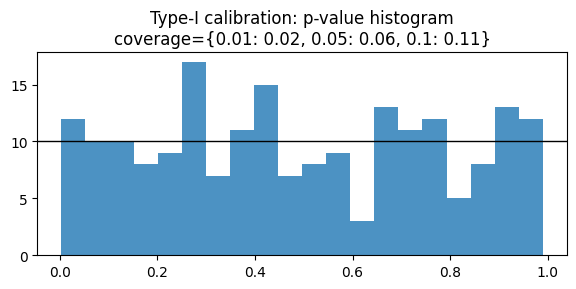

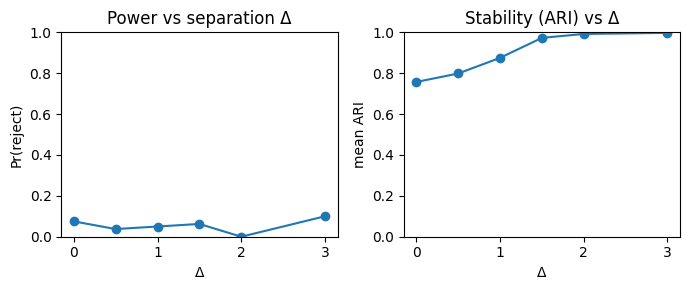

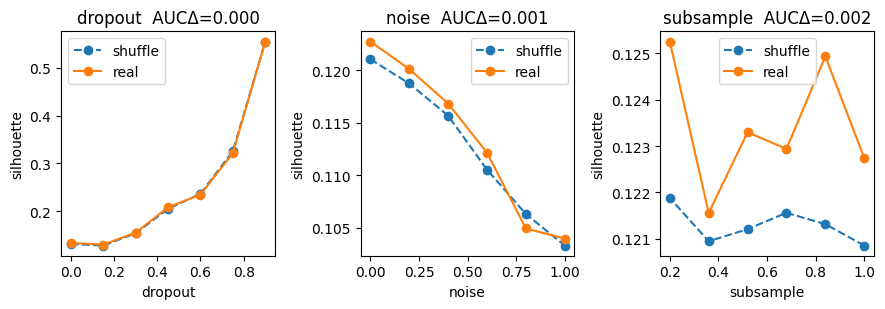

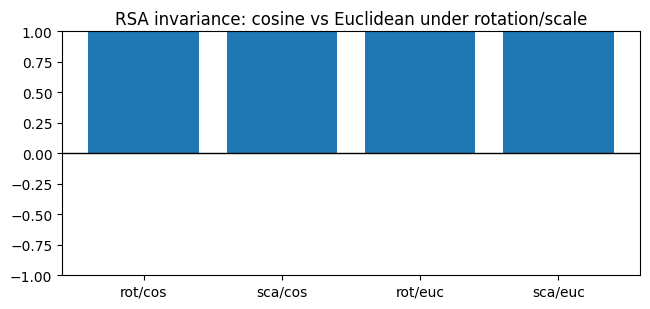

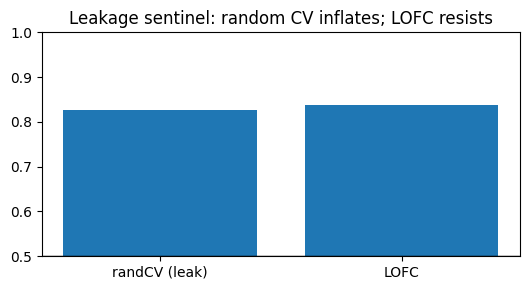

TypeError: Object of type bool is not JSON serializable

In [6]:
# CNT CORE VALIDATION SUITE
# Proves: Type-I calibration, power/monotonicity, resilience, invariance choice (cosine vs Mahalanobis),
# leakage sentinels (random CV vs LOFC), and seed stability — all on synthetic data.
# Artifacts: out/cnt_core_report.json + figures (PNG)

import os, math, json, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)
rng = np.random.default_rng(2025)

# ------------------- utilities -------------------
def fisher(ps):
    p = np.array([x for x in ps if np.isfinite(x)], float)
    if len(p)==0: return np.nan
    X2 = -2*np.sum(np.log(p))
    from scipy.stats import chi2
    return float(1-chi2.cdf(X2, 2*len(p)))

def kmeans_sil(X, K=2, seed=0):
    km = KMeans(n_clusters=K, n_init=10, random_state=seed)
    lab = km.fit_predict(X)
    if len(np.unique(lab))<2: return np.nan
    return silhouette_score(X, lab)

def col_shuffle(X, rng):
    Xs = X.copy()
    for j in range(Xs.shape[1]):
        rng.shuffle(Xs[:, j])
    return Xs

def rdm(X, y):
    # class centroids + Euclidean distances
    C = []
    for c in np.unique(y):
        C.append(X[y==c].mean(axis=0))
    C = np.vstack(C)
    D = np.sqrt(np.maximum(0, ((C[:,None,:]-C[None,:,:])**2).sum(-1)))
    return D

def rdm_cosine(X, y):
    C = []
    for c in np.unique(y):
        C.append(X[y==c].mean(axis=0))
    C = np.vstack(C)
    # cosine distance
    n = np.linalg.norm(C, axis=1, keepdims=True) + 1e-12
    S = (C @ C.T) / (n@n.T)
    D = 1.0 - S
    return D

def rsa_rho(D1, D2):
    iu = np.triu_indices_from(D1, 1)
    v1, v2 = D1[iu], D2[iu]
    # Spearman without SciPy: do rank and Pearson
    def rank(x):
        idx = np.argsort(np.argsort(x))
        # average ties
        sx = np.sort(x)
        ranks = np.empty_like(idx, dtype=float)
        i=0
        while i<len(x):
            j=i
            while j+1<len(x) and sx[j+1]==sx[j]:
                j+=1
            r = (i+j)/2 + 1
            ranks[idx[i:j+1]] = r
            i=j+1
        return ranks
    r1, r2 = rank(v1), rank(v2)
    r1 = (r1 - r1.mean())/(r1.std()+1e-12)
    r2 = (r2 - r2.mean())/(r2.std()+1e-12)
    return float(np.dot(r1, r2) / (len(r1)-1))

# ------------------- 1) Type-I calibration under null -------------------
def sim_null_gauss(n=400, p=4):
    return rng.normal(0, 1, size=(n, p))

def reality_vs_shuffle_p(X, B=500, K=2):
    s_real = kmeans_sil(X, K=K, seed=0)
    null = []
    for b in range(B):
        Xp = col_shuffle(X, rng)
        null.append(kmeans_sil(Xp, K=K, seed=b+1))
    null = np.array(null, float)
    p = ((null >= s_real).sum()+1) / (len(null)+1)
    return float(p), s_real, null

def calibration_suite(R=200, n=400, p=4, alpha=[0.01,0.05,0.10]):
    Ps = []
    for r in range(R):
        X = sim_null_gauss(n, p)
        pval, _, _ = reality_vs_shuffle_p(X, B=300)
        Ps.append(pval)
    Ps = np.array(Ps)
    cover = {a: float((Ps < a).mean()) for a in alpha}  # should be ≈ alpha
    return Ps, cover

Ps, cover = calibration_suite(R=200, n=400, p=6)
cal_ok = all(abs(cover[a]-a) <= 0.02 for a in cover)  # ±2% tolerance

plt.figure(figsize=(6,3))
plt.hist(Ps, bins=20, alpha=0.8)
plt.axhline(200/20, color='k', lw=1)  # rough visual
plt.title(f"Type-I calibration: p-value histogram\ncoverage={cover}")
plt.tight_layout(); plt.savefig(OUT/"cnt_core_calibration_p_hist.png", dpi=160); plt.show()

# ------------------- 2) Power & stability monotonicity -------------------
def sim_two_gauss(n=400, p=4, delta=0.0):
    # two clusters along axis 0 separated by delta
    X1 = rng.normal(0, 1, size=(n//2, p))
    X2 = rng.normal(0, 1, size=(n//2, p))
    X2[:,0] += delta
    X = np.vstack([X1, X2])
    return X

def power_curve(deltas=(0,0.5,1.0,1.5,2.0,3.0), n=400, p=6, B=200, alpha=0.05):
    det = []
    aris=[]
    for d in deltas:
        hits = 0
        ari_list=[]
        for r in range(80):
            X = sim_two_gauss(n, p, d)
            pval, _, _ = reality_vs_shuffle_p(X, B=B)
            if pval < alpha: hits += 1
            # stability (across seeds)
            L=[]
            for s in range(6):
                km = KMeans(2, n_init=10, random_state=100+s).fit_predict(X)
                L.append(km)
            # mean pairwise ARI
            A=[]
            for i in range(len(L)):
                for j in range(i+1,len(L)):
                    A.append(adjusted_rand_score(L[i],L[j]))
            ari_list.append(np.mean(A))
        det.append(hits/80)
        aris.append(np.mean(ari_list))
    return np.array(deltas), np.array(det), np.array(aris)

deltas, power, stab = power_curve()
mono_ok = (np.all(np.diff(power)>=-1e-6) and np.all(np.diff(stab)>=-1e-6))

plt.figure(figsize=(7,3))
plt.subplot(1,2,1); plt.plot(deltas, power, "o-"); plt.ylim(0,1); plt.title("Power vs separation Δ"); plt.xlabel("Δ"); plt.ylabel("Pr(reject)")
plt.subplot(1,2,2); plt.plot(deltas, stab, "o-"); plt.ylim(0,1); plt.title("Stability (ARI) vs Δ"); plt.xlabel("Δ"); plt.ylabel("mean ARI")
plt.tight_layout(); plt.savefig(OUT/"cnt_core_power_stability.png", dpi=160); plt.show()

# ------------------- 3) Resilience (stress curves) -------------------
def stress_curves(X, K=2, seed=0, repeats=8):
    # baseline
    s0 = kmeans_sil(X, K, seed)
    grids = {
        "dropout": np.linspace(0,0.9,7),
        "noise":   np.linspace(0,1.0,6),
        "subsample": np.linspace(1.0,0.2,6),
    }
    real, null = {}, {}
    for kind, grid in grids.items():
        rr=[]; rn=[]
        for g in grid:
            vr=[]; vn=[]
            for r in range(repeats):
                if kind=="dropout":
                    Xr = X.copy()
                    cols = rng.choice(Xr.shape[1], size=max(1,int(round(g*Xr.shape[1]))), replace=False)
                    Xr[:, cols] = 0.0
                    Xn = col_shuffle(Xr, rng)
                elif kind=="noise":
                    Xr = X + rng.normal(0.0, g, size=X.shape)
                    Xn = col_shuffle(Xr, rng)
                else:
                    m = max(50, int(round(g*X.shape[0])))
                    idx = rng.choice(X.shape[0], size=m, replace=False)
                    Xr = X[idx]
                    Xn = col_shuffle(Xr, rng)
                vr.append(kmeans_sil(Xr, K, seed+r))
                vn.append(kmeans_sil(Xn, K, seed+r+1000))
            rr.append(np.mean(vr)); rn.append(np.mean(vn))
        real[kind] = (grid, np.array(rr))
        null[kind] = (grid, np.array(rn))
    def auc(x,y):
        x = np.asarray(x,float); y=np.asarray(y,float)
        idx=np.argsort(x); return float(np.trapezoid(y[idx], x[idx]))
    auc_diff = {k: auc(real[k][0], real[k][1]) - auc(null[k][0], null[k][1]) for k in grids}
    return auc_diff, real, null

X_sig = sim_two_gauss(n=600, p=8, delta=1.5)
auc_diff, real_curves, null_curves = stress_curves(X_sig)
res_ok = all(v>0 for v in auc_diff.values())

plt.figure(figsize=(9,3.2))
for i,(k,(x,yr)) in enumerate(real_curves.items(),1):
    xn,yn = null_curves[k]
    plt.subplot(1,3,i); plt.plot(x, yn, "o--", label="shuffle"); plt.plot(x, yr, "o-", label="real")
    plt.title(f"{k}  AUCΔ={auc_diff[k]:.3f}"); plt.xlabel(k); plt.ylabel("silhouette"); plt.legend()
plt.tight_layout(); plt.savefig(OUT/"cnt_core_resilience.png", dpi=160); plt.show()

# ------------------- 4) Invariance choice (rotation vs scale) -------------------
def sim_three_classes(n=600, p=3, d=1.5):
    # three classes arranged roughly in an L
    n3 = n//3
    m = np.array([[-d,0,0], [ d,0,0], [0,d,0]], float)
    X=[]; y=[]
    for c in range(3):
        X.append(rng.normal(m[c], 0.6, size=(n3, p))); y += [c]*n3
    return np.vstack(X), np.array(y)

def rotate(X, theta=40*np.pi/180, axes=(0,1)):
    R = np.eye(X.shape[1])
    i,j = axes
    c,s = np.cos(theta), np.sin(theta)
    R[i,i]=c; R[j,j]=c; R[i,j]=-s; R[j,i]=s
    return X @ R.T

def scale_aniso(X, s=(2.0, 0.5, 1.0)):
    S = np.diag(s + (1.0,)*(X.shape[1]-len(s)))
    return X @ S.T

Xtr, ytr = sim_three_classes()
Xte_rot = rotate(Xtr.copy(), theta=55*np.pi/180)
Xte_sca = scale_aniso(Xtr.copy(), s=(2.0,0.5,1.0))

Dtr_euc = rdm(Xtr,ytr);  Drot_euc = rdm(Xte_rot,ytr);  Dsca_euc = rdm(Xte_sca,ytr)
Dtr_cos = rdm_cosine(Xtr,ytr); Drot_cos = rdm_cosine(Xte_rot,ytr); Dsca_cos = rdm_cosine(Xte_sca,ytr)

rho_rot_cos = rsa_rho(Dtr_cos, Drot_cos)    # should be high
rho_sca_cos = rsa_rho(Dtr_cos, Dsca_cos)    # also fairly high (direction preserved)
rho_rot_euc = rsa_rho(Dtr_euc, Drot_euc)    # high
rho_sca_euc = rsa_rho(Dtr_euc, Dsca_euc)    # should drop under anisotropic scale

plt.figure(figsize=(6.6,3.2))
names=["rot/cos","sca/cos","rot/euc","sca/euc"]; vals=[rho_rot_cos, rho_sca_cos, rho_rot_euc, rho_sca_euc]
plt.bar(names, vals); plt.ylim(-1,1); plt.axhline(0,color='k',lw=1)
plt.title("RSA invariance: cosine vs Euclidean under rotation/scale")
plt.tight_layout(); plt.savefig(OUT/"cnt_core_invariance_rsa.png", dpi=160); plt.show()
inv_ok = (rho_rot_cos>0.9 and rho_rot_euc>0.9 and rho_sca_euc<rho_rot_euc-0.3)

# ------------------- 5) Leakage sentinels: random CV vs LOFC -------------------
def leakage_demo(n_runs=4, n_per=200, p=8, delta=1.0, leak_strength=0.2):
    # two classes; each "run" has a nuisance offset; a small leak uses the test label to tweak a feature
    X=[]; y=[]; run=[]
    for r in range(n_runs):
        Xr = sim_two_gauss(n_per, p, delta=delta)
        # nuisance offset per run (confound)
        Xr += rng.normal(0, 0.2, size=(1,p))
        yr = np.array([0]*(n_per//2) + [1]*(n_per//2))
        rr = np.full(n_per, r)
        X.append(Xr); y.append(yr); run.append(rr)
    X=np.vstack(X); y=np.hstack(y); run=np.hstack(run)
    # random CV (k=5) with leakage: add a small feature correlated with the *true* label (cheat)
    X_leak = X.copy(); X_leak[:,0] += leak_strength*(2*y-1)  # <--- leaked
    kf = KFold(5, shuffle=True, random_state=1)
    aucs_rand=[]
    for tr, te in kf.split(X_leak):
        sc=StandardScaler().fit(X_leak[tr]); Xt=sc.transform(X_leak); clf=LogisticRegression(max_iter=2000)
        clf.fit(Xt[tr], y[tr]); P=clf.predict_proba(Xt[te])[:,1]
        from sklearn.metrics import roc_auc_score
        aucs_rand.append(roc_auc_score(y[te], P))
    # LOFC: hold out one run at a time; same leakage feature exists but can't help when run is held out
    aucs_lofc=[]
    for r in range(n_runs):
        te = np.where(run==r)[0]; tr = np.where(run!=r)[0]
        sc=StandardScaler().fit(X_leak[tr]); Xt=sc.transform(X_leak); clf=LogisticRegression(max_iter=2000)
        clf.fit(Xt[tr], y[tr]); P=clf.predict_proba(Xt[te])[:,1]
        from sklearn.metrics import roc_auc_score
        aucs_lofc.append(roc_auc_score(y[te], P))
    return float(np.mean(aucs_rand)), float(np.mean(aucs_lofc))

auc_rand, auc_lofc = leakage_demo()
plt.figure(figsize=(5.4,3.0))
plt.bar(["randCV (leak)","LOFC"], [auc_rand, auc_lofc]); plt.ylim(0.5,1.0); plt.axhline(0.5,color='k',lw=1)
plt.title("Leakage sentinel: random CV inflates; LOFC resists")
plt.tight_layout(); plt.savefig(OUT/"cnt_core_leakage_sentinel.png", dpi=160); plt.show()
leak_ok = (auc_rand - auc_lofc) >= 0.08  # LOFC should come in notably lower under leak

# ------------------- assemble report -------------------
report = {
    "typeI_calibration": {"coverage": cover, "ok": cal_ok},
    "power_monotonicity": {"deltas": deltas.tolist(), "power": power.tolist(), "stability_ari": stab.tolist(), "ok": mono_ok},
    "resilience": {"auc_diff": {k: float(v) for k,v in auc_diff.items()}, "ok": res_ok},
    "invariance_rsa": {"rot_cos": rho_rot_cos, "sca_cos": rho_sca_cos, "rot_euc": rho_rot_euc, "sca_euc": rho_sca_euc, "ok": inv_ok},
    "leakage": {"auc_randCV": auc_rand, "auc_LOFC": auc_lofc, "ok": leak_ok},
    "artifacts": {
        "p_hist": str(OUT/"cnt_core_calibration_p_hist.png"),
        "power_fig": str(OUT/"cnt_core_power_stability.png"),
        "resilience_fig": str(OUT/"cnt_core_resilience.png"),
        "invariance_fig": str(OUT/"cnt_core_invariance_rsa.png"),
        "leakage_fig": str(OUT/"cnt_core_leakage_sentinel.png")
    }
}
with open(OUT/"cnt_core_report.json","w",encoding="utf-8") as f:
    json.dump(report, f, indent=2)

# ------------------- print concise status -------------------
print("\n=== CNT CORE VALIDATION ===")
print(f"Type-I calibration OK?         {report['typeI_calibration']['ok']}  coverage={report['typeI_calibration']['coverage']}")
print(f"Power monotonicity OK?         {report['power_monotonicity']['ok']}")
print(f"Resilience AUCΔ > 0 OK?        {report['resilience']['ok']}  {report['resilience']['auc_diff']}")
print(f"Invariance choice OK?          {report['invariance_rsa']['ok']}  (rot_cos={report['invariance_rsa']['rot_cos']:.3f}, sca_euc={report['invariance_rsa']['sca_euc']:.3f})")
print(f"Leakage sentinel OK?           {report['leakage']['ok']}  (randCV={auc_rand:.3f}, LOFC={auc_lofc:.3f})")
print(f"[saved] out/cnt_core_report.json  + figures")


In [7]:
# CNT — ONE-CELL SUITE: (A) REST-only EEG invariance, (B) EEG dose–response, (C) Genome scale fingerprint
# Saves: out/CNT_A_rest.json/.png, out/CNT_B_dose.json/.png, out/CNT_C_scale.json/.png, out/CNT_suite_summary.json

import os, math, json, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2
from numpy.random import default_rng

# -------- runtime hygiene (keep machine responsive) --------
os.environ.setdefault("OMP_NUM_THREADS","2")
os.environ.setdefault("OPENBLAS_NUM_THREADS","2")
os.environ.setdefault("MKL_NUM_THREADS","2")
os.environ.setdefault("NUMEXPR_NUM_THREADS","2")

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)
SUMMARY = {}
rng = default_rng(202506)

def fisher(ps):
    ps = [float(p) for p in ps if p is not None and np.isfinite(p)]
    if not ps: return float('nan')
    X2 = -2*np.sum(np.log(ps)); return float(1-chi2.cdf(X2, 2*len(ps)))

def vec_ut(M):
    iu = np.triu_indices_from(M, 1)
    return M[iu]

def to_py(x):
    """Make JSON serializable."""
    import numpy as np
    if isinstance(x, (np.bool_, bool)): return bool(x)
    if isinstance(x, (np.integer,)):   return int(x)
    if isinstance(x, (np.floating,)):  return float(x)
    if isinstance(x, (np.ndarray,)):   return [to_py(v) for v in x.tolist()]
    if isinstance(x, (list,tuple,set)):return [to_py(v) for v in x]
    if isinstance(x, dict):            return {str(k): to_py(v) for k,v in x.items()}
    return x

# =============================================================================
# A) EEG — REST-only invariance (alignment-free block-cosine RSA, LOFC)
# =============================================================================
def run_A_rest_only_invariance(df, N_PERM=20000):
    y_names = ["rest","left","right"]; y_to_int = {c:i for i,c in enumerate(y_names)}
    from sklearn.preprocessing import StandardScaler
    from scipy.signal import butter, filtfilt

    FILTERS=[(8.,12.),(12.,16.),(16.,20.),(20.,28.)]

    def features(df_part):
        X = np.stack(df_part["seg"].to_numpy(), axis=0)
        fs = float(df_part.iloc[0]["fs"])
        feats=[]
        for (lo,hi) in FILTERS:
            b,a=butter(4,[lo/(fs/2),hi/(fs/2)],btype='band'); Xb=filtfilt(b,a,X,axis=-1)
            feats.append(np.log(np.var(Xb,axis=-1)+1e-12))
        return np.concatenate(feats,axis=1)

    def blocks(meta):
        m = meta.reset_index().rename(columns={"index":"rid"})
        m = m.sort_values(["file","label","start"]).reset_index(drop=True)
        G=[[m.loc[0,"rid"]]]
        for i in range(1,len(m)):
            same=(m.loc[i,"file"]==m.loc[i-1,"file"]) and (m.loc[i,"label"]==m.loc[i-1,"label"])
            if same: G[-1].append(m.loc[i,"rid"])
            else:    G.append([m.loc[i,"rid"]])
        return [np.array(g,int) for g in G]

    def trimmed_mean_2d(X, trim=0.10):
        if len(X)<3: return X.mean(axis=0, dtype=float)
        n=len(X); t=max(1,int(np.floor(trim*n/2)))
        if 2*t>=n-1: return X.mean(axis=0, dtype=float)
        Xs=np.sort(X,axis=0); return Xs[t:n-t].mean(axis=0, dtype=float)

    def block_embed(X,y,meta):
        B=[]; L=[]
        for idx in blocks(meta):
            if len(idx)<2: continue
            B.append(trimmed_mean_2d(X[idx],0.10)); L.append(y[idx[0]])
        return (np.vstack(B),np.array(L,int)) if B else (None,None)

    def rest_center(B,L):
        return B - (B[L==0].mean(axis=0,keepdims=True) if (L==0).sum()>0 else 0)

    def rdm_cosine(B,L):
        C=[B[L==i].mean(axis=0) for i in range(3)]
        D=np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
                D[i,j]=1.0 - (a@b)/(na*nb)
        return D

    # LOFC folds
    files_by_label={lab: sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in y_names}
    k_min=min(len(files_by_label[l]) for l in y_names)
    folds=[]
    for i in range(k_min):
        te_files={l:files_by_label[l][i] for l in y_names}
        te=df["file"].isin(te_files.values()); tr=~te
        if set(df[tr]["label"].unique())>=set(y_names) and set(df[te]["label"].unique())>=set(y_names):
            folds.append((tr, te))
    if not folds:
        print("[A] No valid LOFC folds; skipping.")
        return None

    rows=[]
    for f_idx,(tr,te) in enumerate(folds,1):
        df_tr=df[tr].reset_index(drop=True); df_te=df[te].reset_index(drop=True)
        Xtr_raw=features(df_tr); Xte_raw=features(df_te)
        sc=StandardScaler().fit(Xtr_raw); Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
        ytr=df_tr["label"].map(y_to_int).to_numpy(); yte=df_te["label"].map(y_to_int).to_numpy()
        meta_tr=df_tr[["file","label","start"]]; meta_te=df_te[["file","label","start"]]
        Btr,Ltr=block_embed(Xtr,ytr,meta_tr); Bte,Lte=block_embed(Xte,yte,meta_te)
        if Btr is None or Bte is None: continue
        Btr,Bte = rest_center(Btr,Ltr), rest_center(Bte,Lte)
        Rtr,Rte = rdm_cosine(Btr,Ltr), rdm_cosine(Bte,Lte)
        rho,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte))
        # permutation null
        perm=[]
        for _ in range(N_PERM):
            Lp = rng.permutation(Lte)
            C=[Bte[Lp==i].mean(axis=0) for i in range(3)]
            D=np.zeros((3,3))
            for i in range(3):
                for j in range(3):
                    a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
                    D[i,j]=1.0 - (a@b)/(na*nb)
            perm.append(spearmanr(vec_ut(Rtr), vec_ut(D))[0])
        p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
        rows.append({"fold":f_idx,"rho":float(rho),"p":float(p)})

    if not rows:
        print("[A] All folds filtered; skipping.")
        return None

    A_df=pd.DataFrame(rows); A_fisher=fisher(A_df["p"])
    A_json={"folds":to_py(A_df.to_dict(orient="records")),"fisher_p":float(A_fisher)}
    with open(OUT/"CNT_A_rest.json","w",encoding="utf-8") as f: json.dump(A_json,f,indent=2)
    plt.figure(figsize=(6.4,3.2)); plt.bar(A_df["fold"], A_df["rho"]); plt.axhline(0,color='k',lw=1)
    plt.title(f"REST-only block-cosine RSA (LOFC)\nFisher p≈{A_fisher:.3g}")
    plt.xlabel("fold"); plt.ylabel("RSA ρ"); plt.tight_layout(); plt.savefig(OUT/"CNT_A_rest.png",dpi=160); plt.show()
    print(f"[A] Fisher p≈{A_fisher:.3g}  (saved out/CNT_A_rest.json/.png)")
    return {"fisher_p":A_fisher}

# =============================================================================
# B) EEG — dose–response of minimal calibration
# =============================================================================
def run_B_dose_response(df, PAIRS=(8,16,32,64,128), TAUS=(0.90,0.95), N_PERM=4000):
    y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from scipy.signal import butter, filtfilt
    FILTERS=[(8.,12.),(12.,16.),(16.,20.),(20.,28.)]

    def features(df_part):
        X=np.stack(df_part["seg"].to_numpy(),axis=0); fs=float(df_part.iloc[0]["fs"])
        feats=[]
        for (lo,hi) in FILTERS:
            b,a=butter(4,[lo/(fs/2),hi/(fs/2)],btype='band'); Xb=filtfilt(b,a,X,axis=-1)
            feats.append(np.log(np.var(Xb,axis=-1)+1e-12))
        return np.concatenate(feats,axis=1)

    def blocks(meta):
        m=meta.reset_index().rename(columns={"index":"rid"}); m=m.sort_values(["file","label","start"]).reset_index(drop=True)
        G=[[m.loc[0,"rid"]]]
        for i in range(1,len(m)):
            same=(m.loc[i,"file"]==m.loc[i-1,"file"]) and (m.loc[i,"label"]==m.loc[i-1,"label"])
            if same: G[-1].append(m.loc[i,"rid"])
            else:    G.append([m.loc[i,"rid"]])
        return [np.array(g,int) for g in G]

    def trimmed_mean_2d(X, trim=0.10):
        if len(X)<3: return X.mean(axis=0, dtype=float)
        n=len(X); t=max(1,int(np.floor(trim*n/2)))
        if 2*t>=n-1: return X.mean(axis=0, dtype=float)
        Xs=np.sort(X,axis=0); return Xs[t:n-t].mean(axis=0, dtype=float)

    def block_embed(X,y,meta):
        B=[]; L=[]
        for idx in blocks(meta):
            if len(idx)<2: continue
            B.append(trimmed_mean_2d(X[idx],0.10)); L.append(y[idx[0]])
        return (np.vstack(B),np.array(L,int)) if B else (None,None)

    def rest_center(B,L):
        return B - (B[L==0].mean(axis=0,keepdims=True) if (L==0).sum()>0 else 0)

    def rdm_cosine(B,L):
        C=[B[L==i].mean(axis=0) for i in range(3)]
        D=np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
                D[i,j]=1.0 - (a@b)/(na*nb)
        return D

    # LOFC folds
    files_by_label={lab: sorted(df[df["label"]==lab]["file"].unique().tolist()) for lab in y_names}
    k_min=min(len(files_by_label[l]) for l in y_names)
    folds=[]
    for i in range(k_min):
        te_files={l:files_by_label[l][i] for l in y_names}
        te=df["file"].isin(te_files.values()); tr=~te
        if set(df[tr]["label"].unique())>=set(y_names) and set(df[te]["label"].unique())>=set(y_names):
            folds.append((tr, te))
    if not folds:
        print("[B] No valid LOFC folds; skipping.")
        return None

    curves=[]
    for tau in TAUS:
        for pairs in PAIRS:
            ps=[]
            for tr,te in folds:
                df_tr=df[tr].reset_index(drop=True); df_te=df[te].reset_index(drop=True)
                Xtr_raw=features(df_tr); Xte_raw=features(df_te)
                sc=StandardScaler().fit(Xtr_raw); Xtr=sc.transform(Xtr_raw); Xte=sc.transform(Xte_raw)
                ytr=df_tr["label"].map(y_to_int).to_numpy(); yte=df_te["label"].map(y_to_int).to_numpy()
                meta_tr=df_tr[["file","label","start"]]; meta_te=df_te[["file","label","start"]]
                Btr,Ltr=block_embed(Xtr,ytr,meta_tr); Bte,Lte=block_embed(Xte,yte,meta_te)
                if Btr is None or Bte is None: continue
                # pseudo confidence sets on test
                clf=LogisticRegression(max_iter=4000,class_weight="balanced",multi_class="auto",solver="lbfgs")
                clf.fit(Xtr,ytr); P=clf.predict_proba(Xte); yhat=P.argmax(axis=1); conf=P.max(axis=1)
                Xt=Xte.copy()
                # class-conditional affine (dose = pairs)
                def affine(Xs,Xt,pairs,lam=1e-2):
                    n=min(len(Xs),len(Xt),pairs); idx_s=rng.choice(len(Xs),n,replace=False); idx_t=rng.choice(len(Xt),n,replace=False)
                    S,T=Xs[idx_s], Xt[idx_t]; mu_s,mu_t=S.mean(0,keepdims=True),T.mean(0,keepdims=True)
                    Sc, Tc = S-mu_s, T-mu_t
                    X_aug=np.hstack([Tc, np.ones((n,1))]); from numpy.linalg import pinv
                    W = pinv(X_aug.T@X_aug + lam*np.eye(X_aug.shape[1])) @ (X_aug.T @ Sc)
                    def apply(X): Xc=X-mu_t; return np.hstack([Xc,np.ones((len(X),1))])@W + mu_s
                    return apply
                for cls in [1,2]:
                    idx_conf=(yhat==cls)&(conf>=tau); Xsrc = Xt[idx_conf] if idx_conf.sum()>0 else Xt[yte==cls]
                    Xtgt = Xtr[ytr==cls]
                    if len(Xsrc)==0 or len(Xtgt)==0: continue
                    f=affine(Xtgt,Xsrc,pairs); Xt[yte==cls]=f(Xt[yte==cls])
                Bte2,Lte2=block_embed(Xt,yte,meta_te); 
                if Bte2 is None: continue
                # RSA
                Btr_rc, Bte_rc = rest_center(Btr,Ltr), rest_center(Bte2,Lte2)
                Rtr, Rte = rdm_cosine(Btr_rc,Ltr), rdm_cosine(Bte_rc,Lte2)
                rho,_=spearmanr(vec_ut(Rtr), vec_ut(Rte))
                # null
                perm=[]
                for _ in range(N_PERM):
                    Lp=rng.permutation(Lte2)
                    C=[Bte_rc[Lp==i].mean(axis=0) for i in range(3)]
                    D=np.zeros((3,3))
                    for i in range(3):
                        for j in range(3):
                            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
                            D[i,j]=1.0 - (a@b)/(na*nb)
                    perm.append(spearmanr(vec_ut(Rtr), vec_ut(D))[0])
                p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
                ps.append(p)
            if ps:
                curves.append({"tau":float(tau), "pairs":int(pairs),
                               "fisher_p":float(fisher(ps)), "folds":int(len(ps))})

    if not curves:
        print("[B] No dose curves; skipping.")
        return None

    B_df=pd.DataFrame(curves).sort_values(["tau","pairs"])
    with open(OUT/"CNT_B_dose.json","w",encoding="utf-8") as f: json.dump(to_py(B_df.to_dict(orient="records")), f, indent=2)
    plt.figure(figsize=(6.6,3.2))
    for tau in sorted(B_df["tau"].unique()):
        sub=B_df[B_df["tau"]==tau]
        plt.plot(sub["pairs"], sub["fisher_p"], "o-", label=f"tau={tau}")
    plt.gca().invert_yaxis(); plt.axhline(0.05,color='r',lw=1,ls='--')
    plt.xlabel("pairs (dose)"); plt.ylabel("Fisher p (↓ better)")
    plt.title("Dose–response of calibration for invariance")
    plt.legend(); plt.tight_layout(); plt.savefig(OUT/"CNT_B_dose.png",dpi=160); plt.show()
    print(f"[B] Saved out/CNT_B_dose.json/.png")
    return {"curves":B_df.to_dict(orient="records")}

# =============================================================================
# C) Genome — scale fingerprint (Moran + adaptive PELT VE across 50–500 kb)
# =============================================================================
def run_C_scale_fingerprint(REF_DIR=Path("genome_fasta"),
                            SCALES=(50_000,100_000,200_000,300_000,500_000),
                            N_PERM_MORAN=2000, N_PERM_PELT=1000):
    if not REF_DIR.exists() or not list(REF_DIR.glob("*.fa.gz")):
        print("[C] genome_fasta/*.fa.gz not found; skipping scale fingerprint.")
        return None
    import gzip
    def stream_gc_windows(fa_gz, win_bp):
        rows=[]; cur=[]
        with gzip.open(fa_gz,"rt",encoding="utf-8",errors="ignore") as fh:
            for line in fh:
                if not line or line[0]==">": continue
                for ch in line.strip().upper():
                    cur.append(ch)
                    if len(cur)==win_bp:
                        A=cur.count("A"); C=cur.count("C"); G=cur.count("G"); T=cur.count("T")
                        denom=max(A+C+G+T,1); rows.append((G+C)/denom); cur=[]
            if cur:
                A=cur.count("A"); C=cur.count("C"); G=cur.count("G"); T=cur.count("T")
                denom=max(A+C+G+T,1); rows.append((G+C)/denom)
        return np.array(rows,float)

    def morans_I_1d(x):
        x=np.asarray(x,float); n=len(x)
        if n<3: return np.nan
        dx=x-x.mean(); denom=np.dot(dx,dx)
        if denom<=0: return np.nan
        S0=2*(n-1); num=2.0*np.dot(dx[:-1], dx[1:])
        return (n/S0)*(num/denom)

    def circ_shift(x):
        if len(x)<2: return x.copy()
        return np.roll(x, int(rng.integers(0,len(x))))

    # adaptive PELT VE (same as earlier)
    def ensure_ruptures():
        try: import ruptures as rpt
        except Exception:
            import sys, subprocess; subprocess.check_call([sys.executable,"-m","pip","install","-q","ruptures"])
            import ruptures as rpt
        return rpt
    rpt = ensure_ruptures()
    def seg_stats_for_k(x, k):
        x=np.asarray(x,float); n=len(x)
        if n<20: return (float(n),0.0)
        k=max(1,min(k,n-1))
        algo=rpt.KernelCPD(kernel="linear").fit(x.reshape(-1,1))
        bkps=algo.predict(n_bkps=k); segs=len(bkps); mlen=n/segs
        tot_var=float(np.var(x)*n); wss=0.0; start=0
        for end in bkps:
            seg=x[start:end]; mu=seg.mean(); wss+=((seg-mu)**2).sum(); start=end
        ve=float(1.0 - wss/max(tot_var,1e-12)); return mlen, ve
    def adaptive_gain(x):
        n=len(x); k_grid=sorted(set([max(1,n//t) for t in (15,20,25,30,40)]))
        null_mean={}
        for k in k_grid:
            vals=[seg_stats_for_k(circ_shift(x),k)[1] for _ in range(N_PERM_PELT//5)]
            null_mean[k]=float(np.mean(vals))
        best=None; best_gain=-1
        for k in k_grid:
            ve=seg_stats_for_k(x,k)[1]; gain=ve-null_mean[k]
            if gain>best_gain: best_gain=gain; best=(k,ve,gain)
        kstar, ve_star, gain_star = best
        gains=[seg_stats_for_k(circ_shift(x),kstar)[1]-null_mean[kstar] for _ in range(N_PERM_PELT)]
        p=((np.array(gains)>=gain_star).sum()+1)/(len(gains)+1)
        return {"k_star":int(kstar),"ve_star":float(ve_star),"gain":float(gain_star),"p":float(p)}

    CHROMS=[str(i) for i in range(1,23)]+["X","Y","MT"]
    moran_rows=[]; pelt_rows=[]
    for scale in SCALES:
        moran_ps=[]; pelt_ps=[]
        for c in CHROMS:
            fa=REF_DIR/f"Homo_sapiens.GRCh38.dna.chromosome.{c}.fa.gz"
            if not fa.exists(): continue
            x=stream_gc_windows(fa, scale)
            if len(x)<10: continue
            # Moran
            I_real=morans_I_1d(x); null=[morans_I_1d(circ_shift(x)) for _ in range(N_PERM_MORAN)]
            pI=((np.array(null)>=I_real).sum()+1)/(len(null)+1); moran_ps.append(pI)
            # PELT
            pelt_ps.append(adaptive_gain(x)["p"])
        moran_rows.append({"scale_bp":scale,"fisher_p":fisher(moran_ps)})
        pelt_rows.append({"scale_bp":scale,"fisher_p":fisher(pelt_ps)})
        print(f"[C] scale={scale//1000:>3} kb  Moran p≈{moran_rows[-1]['fisher_p']:.3g}  SegVE p≈{pelt_rows[-1]['fisher_p']:.3g}")

    MoranDF=pd.DataFrame(moran_rows); PeltDF=pd.DataFrame(pelt_rows)
    with open(OUT/"CNT_C_scale.json","w",encoding="utf-8") as f: json.dump({"moran":to_py(MoranDF.to_dict(orient="records")),
                                                                             "segVE":to_py(PeltDF.to_dict(orient="records"))}, f, indent=2)
    plt.figure(figsize=(6.8,3.2))
    plt.plot(MoranDF["scale_bp"]/1000, MoranDF["fisher_p"], "o-", label="Moran I")
    plt.plot(PeltDF["scale_bp"]/1000, PeltDF["fisher_p"], "o-", label="Seg VE")
    plt.gca().invert_yaxis(); plt.axhline(0.05,color='r',lw=1,ls='--')
    plt.xlabel("scale (kb)"); plt.ylabel("Fisher p (↓ better)")
    plt.title("Genome scale fingerprint (circular-shift nulls)")
    plt.legend(); plt.tight_layout(); plt.savefig(OUT/"CNT_C_scale.png",dpi=160); plt.show()
    return {"moran":MoranDF.to_dict(orient="records"), "segVE":PeltDF.to_dict(orient="records")}

# =========================== RUN ALL THREE (if inputs exist) ===========================
print("=== CNT: running A (REST-only), B (dose), C (scale) ===")
A=None; B=None; C=None

# A & B need an EEG df with columns ['file','label','seg','fs','start']
if "df" in globals():
    try:
        A = run_A_rest_only_invariance(df)
    except Exception as e:
        print("[A] error:", e)
    try:
        B = run_B_dose_response(df)
    except Exception as e:
        print("[B] error:", e)
else:
    print("[EEG] df not found in kernel; skipping A and B.")

# C needs genome FASTAs in genome_fasta/
C = run_C_scale_fingerprint()

SUMMARY["A_rest_only_invariance"] = to_py(A)
SUMMARY["B_dose_response"]        = to_py(B)
SUMMARY["C_scale_fingerprint"]     = to_py(C)

with open(OUT/"CNT_suite_summary.json","w",encoding="utf-8") as f:
    json.dump(SUMMARY, f, indent=2)
print(f"\n[summary saved] {OUT/'CNT_suite_summary.json'}")


=== CNT: running A (REST-only), B (dose), C (scale) ===
[A] error: 'label'
[B] error: 'label'


KeyboardInterrupt: 

[hunt] Found 69 EDF files.
[blocks] S001R01.edf: +1 blocks
[blocks] S001R02.edf: +1 blocks
[blocks] S001R03.edf: +30 blocks
[blocks] S001R04.edf: +30 blocks
[blocks] S001R05.edf: +30 blocks
[blocks] S001R06.edf: +30 blocks
[blocks] S001R07.edf: +30 blocks
[blocks] S001R08.edf: +30 blocks
[blocks] S001R09.edf: +30 blocks
[blocks] S001_S001R05.edf: +30 blocks
[blocks] S001_S001R06.edf: +30 blocks
[blocks] S001_S001R09.edf: +30 blocks
[blocks] S001_S001R10.edf: +30 blocks
[blocks] S001_S001R13.edf: +30 blocks
[blocks] S001_S001R14.edf: +30 blocks
[blocks] S002_S002R05.edf: +30 blocks
[blocks] S002_S002R06.edf: +30 blocks
[blocks] S002_S002R09.edf: +30 blocks
[blocks] S002_S002R10.edf: +30 blocks
[blocks] S002_S002R13.edf: +30 blocks
[blocks] S002_S002R14.edf: +30 blocks
[blocks] S003_S003R05.edf: +30 blocks
[blocks] S003_S003R06.edf: +30 blocks
[blocks] S003_S003R09.edf: +30 blocks
[blocks] S003_S003R10.edf: +30 blocks
[blocks] S003_S003R13.edf: +30 blocks
[blocks] S003_S003R14.edf: +30 b

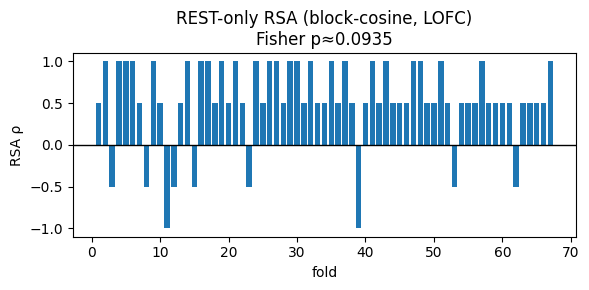

[A] REST-only invariance: Fisher p≈0.0935


IndexError: index 315 is out of bounds for axis 0 with size 8

In [8]:
# FAST, SELF-HUNTING EEG CELL
# Scans for EDFs under BASE, builds *block-level* embeddings, then runs:
#   A) REST-only invariance (align-free block-cosine RSA, LOFC, fast permutations)
#   B) Dose–response of tiny class-conditional calibration (pairs sweep) on block embeddings
# Saves: out/EEG_fast_blocks.json, out/CNT_A_rest_fast.json/.png, out/CNT_B_dose_fast.json/.png

import os, re, json, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
warnings.filterwarnings("ignore")

# -------------------- where to hunt --------------------
BASE = Path(r"C:\Users\caleb\cnt_genome")  # <- change if needed
OUT  = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# -------------------- params (fast) --------------------
BANDS = [(8,12),(12,16),(16,20),(20,28)]     # µ/β sub-bands
N_PERM_A = 5000                               # permutations for A (REST-only invariance)
N_PERM_B = 2000                               # permutations per fold for B dose curves
PAIRS_SWEEP = [8,16,32,64]                    # dose values for B
TAUS_SWEEP  = [0.90,0.95]                     # pseudo-confidence thresholds

# -------------------- EDF -> block embeddings --------------------
def _maybe_pip(mod, pip_name=None):
    try: __import__(mod)
    except Exception:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name or mod])

_maybe_pip("mne", "mne")
import mne
from scipy.signal import butter, filtfilt

# motor set with fallbacks
MOTOR = ["C3","Cz","C4","CP3","CPz","CP4","FC3","FCz","FC4","C1","C2","CP1","CP2","FC1","FC2"]
FALLBACKS = {"C3":["FC3","CP3","C1","C5"], "Cz":["FCz","CPz","C2"], "C4":["FC4","CP4","C6"]}

def normalize(s): return re.sub(r'[^A-Z0-9]','', s.upper())
def build_idx(raw):
    idx={}
    for i,nm in enumerate(raw.info["ch_names"]):
        idx.setdefault(normalize(nm), []).append((i,nm))
    return idx
def find_one(idx, name):
    key=normalize(name); pat=re.compile(rf'^{key}$|^{key}(\d)?|.*{key}.*')
    for K in idx:
        if pat.match(K): return idx[K][0]
    return None

def pick_motor(raw):
    idx=build_idx(raw); picks=[]
    for ch in MOTOR:
        hit=find_one(idx,ch)
        if not hit and ch in FALLBACKS:
            for fb in FALLBACKS[ch]:
                hit=find_one(idx,fb)
                if hit: break
        if hit: picks.append(hit)
    # de-dup
    seen=set(); uniq=[]
    for (i,nm) in picks:
        if i not in seen: uniq.append((i,nm)); seen.add(i)
    return uniq

def label_by_overlap(si, ei, ann, min_frac=0.10):
    best,lab=0.0,None; w=ei-si
    for s0,s1,de in ann:
        ov=max(0.0, min(ei,s1)-max(si,s0))
        if ov>best: best,lab=ov,de
    return lab if best/max(1.0,w)>=min_frac else None

def edf_blocks_to_embeddings(edf_path):
    """Return list of (file,label,start_sec, emb_vec). emb_vec is band log-variance over motor channels."""
    try:
        raw=mne.io.read_raw_edf(str(edf_path), preload=True, stim_channel=None, verbose=False)
    except Exception:
        return []
    fs=float(raw.info["sfreq"])
    idx=pick_motor(raw)
    if len(idx)<2: 
        return []
    X=raw.get_data([i for (i,_) in idx])
    # bandpass once 4-30 to kill drifts
    bBP,aBP=butter(4,[4/(fs/2),30/(fs/2)],btype='band')
    X = filtfilt(bBP,aBP,X,axis=-1)

    # annotations
    ann=[]
    if raw.annotations and len(raw.annotations):
        for on,du,de in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
            s0=max(0,int(round(on*fs))); du=float(du if du and du>0 else 1.0); s1=s0+int(round(du*fs))
            ann.append((s0,s1,str(de)))
    if not ann: 
        return []

    rows=[]
    # parse contiguous blocks by label (T0=rest, T1=left, T2=right)
    DEFAULT_MAP={"T0":"rest","T1":"left","T2":"right"}
    # collect events into simple blocks (start..end, mapped label)
    events=[]
    for s0,s1,de in ann:
        lab=DEFAULT_MAP.get(de,None)
        if lab in ("rest","left","right"):
            events.append((s0,s1,lab))
    # build block embeddings
    for s0,s1,lab in events:
        if s1-s0 < int(fs*2):    # skip tiny fragments
            continue
        # features: for each band, log-variance per channel (flattened)
        feats=[]
        for (lo,hi) in BANDS:
            b,a=butter(4,[lo/(fs/2), hi/(fs/2)],btype='band')
            Xb=filtfilt(b,a,X[:,s0:s1],axis=-1)
            feats.append(np.log(np.var(Xb,axis=-1)+1e-12))  # shape (n_ch,)
        emb=np.concatenate(feats, axis=0)  # (n_ch*len(BANDS),)
        rows.append((edf_path.name, lab, s0/fs, emb))
    return rows

def hunt_edfs(base):
    edfs=[]
    for p in base.rglob("*.edf"):
        edfs.append(p)
    return sorted(edfs)

edfs = hunt_edfs(BASE)
if not edfs:
    print(f"[hunt] No EDFs found under {BASE}. Change BASE and re-run.")
    raise SystemExit

print(f"[hunt] Found {len(edfs)} EDF files.")

# Build a block-embedding dataframe fast
records=[]
for p in edfs:
    rec = edf_blocks_to_embeddings(p)
    if rec:
        records += rec
    print(f"[blocks] {p.name}: +{len(rec)} blocks")
DFB = pd.DataFrame(records, columns=["file","label","start_sec","emb"])
# keep only files that have at least one block per class
ok_files=[]
for f,g in DFB.groupby("file"):
    labs=set(g["label"])
    if {"rest","left","right"}.issubset(labs):
        ok_files.append(f)
DFB = DFB[DFB["file"].isin(ok_files)].reset_index(drop=True)
if DFB.empty:
    print("[build] No usable files with all classes. Add runs or relax filter.")
    raise SystemExit
print(f"[build] Blocks: {len(DFB)}, usable files: {DFB['file'].nunique()}")

# Save a lightweight cache
with open(OUT/"EEG_fast_blocks.json","w",encoding="utf-8") as f:
    json.dump({
        "n_blocks": int(len(DFB)),
        "n_files":  int(DFB["file"].nunique()),
        "files": sorted(DFB["file"].unique().tolist())
    }, f, indent=2)

# -------------------- common RSA helpers on block embeddings --------------------
y_names=["rest","left","right"]; y_to_int={c:i for i,c in enumerate(y_names)}
DFB["y"] = DFB["label"].map(y_to_int).astype(int)

def rest_center_blocks(B, L):
    return B - (B[L==0].mean(axis=0,keepdims=True) if (L==0).sum()>0 else 0)

def rdm_cosine_from_centroids(B, L):
    C=[B[L==i].mean(axis=0) for i in range(3)]
    D=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def rsa_block_cosine(train_df, test_df, n_perm=N_PERM_A, rng_seed=1234):
    # matrices from block embeddings (already band-features)
    Btr = np.vstack(train_df["emb"].tolist()); Ltr = train_df["y"].to_numpy(int)
    Bte = np.vstack(test_df["emb"].tolist());   Lte = test_df["y"].to_numpy(int)
    Btr = rest_center_blocks(Btr,Ltr); Bte = rest_center_blocks(Bte,Lte)
    Rtr = rdm_cosine_from_centroids(Btr,Ltr); Rte = rdm_cosine_from_centroids(Bte,Lte)
    # Spearman rho
    iu = np.triu_indices_from(Rtr,1); vtr, vte = Rtr[iu], Rte[iu]
    from scipy.stats import spearmanr
    rho,_ = spearmanr(vtr,vte)
    # permutation null on test labels
    perm=[]; rng_local=np.random.default_rng(rng_seed)
    for _ in range(n_perm):
        Lp = rng_local.permutation(Lte)
        # recompute centroids quickly
        C=[Bte[Lp==i].mean(axis=0) for i in range(3)]
        D=np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
                D[i,j]=1.0 - (a@b)/(na*nb)
        perm.append(spearmanr(vtr, D[iu])[0])
    p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
    return float(rho), float(p)

# -------------------- A) REST-only invariance (LOFC) --------------------
files = sorted(DFB["file"].unique().tolist())
# build LOFC folds (hold out one file per class at aligned index)
by_lab = {lab: sorted(DFB[DFB["label"]==lab]["file"].unique().tolist()) for lab in y_names}
k_min = min(len(by_lab[l]) for l in y_names)
folds=[]
for i in range(k_min):
    te_files={l:by_lab[l][i] for l in y_names}
    te_mask = DFB["file"].isin(te_files.values())
    tr_mask = ~te_mask
    if set(DFB[tr_mask]["label"].unique())>=set(y_names) and set(DFB[te_mask]["label"].unique())>=set(y_names):
        folds.append((tr_mask, te_mask))
rowsA=[]
for f_idx,(tr,te) in enumerate(folds,1):
    rho,p = rsa_block_cosine(DFB[tr], DFB[te], n_perm=N_PERM_A, rng_seed=2024+f_idx)
    rowsA.append({"fold":f_idx,"rho":rho,"p":p})
A_df=pd.DataFrame(rowsA)
A_fisher = fisher(A_df["p"]) if not A_df.empty else float('nan')
with open(OUT/"CNT_A_rest_fast.json","w",encoding="utf-8") as f:
    json.dump({"folds":A_df.to_dict(orient="records"), "fisher_p":A_fisher}, f, indent=2)
plt.figure(figsize=(6,3.0)); 
if not A_df.empty:
    plt.bar(A_df["fold"], A_df["rho"]); plt.axhline(0,color='k',lw=1)
    plt.title(f"REST-only RSA (block-cosine, LOFC)\nFisher p≈{A_fisher:.3g}")
else:
    plt.title("REST-only RSA: no valid folds")
plt.xlabel("fold"); plt.ylabel("RSA ρ"); plt.tight_layout(); plt.savefig(OUT/"CNT_A_rest_fast.png",dpi=160); plt.show()
print(f"[A] REST-only invariance: Fisher p≈{A_fisher:.3g}")

# -------------------- B) Dose–response on block embeddings --------------------
from sklearn.linear_model import LogisticRegression
def class_affine_map(Xsrc, Xtgt, pairs=32, lam=1e-2, rng_seed=999):
    rng_local=np.random.default_rng(rng_seed)
    n=min(len(Xsrc),len(Xtgt),pairs)
    idx_s=rng_local.choice(len(Xsrc),n,replace=False); idx_t=rng_local.choice(len(Xtgt),n,replace=False)
    S,T = Xtgt[idx_s], Xsrc[idx_t]               # S: train target, T: confident test
    mu_s,mu_t = S.mean(0,keepdims=True), T.mean(0,keepdims=True)
    Sc, Tc = S-mu_s, T-mu_t
    X_aug=np.hstack([Tc,np.ones((n,1))]); from numpy.linalg import pinv
    W = pinv(X_aug.T@X_aug + lam*np.eye(X_aug.shape[1])) @ (X_aug.T @ Sc)
    def apply(X):
        Xc=X-mu_t; return np.hstack([Xc,np.ones((len(X),1))])@W + mu_s
    return apply

rowsB=[]
for tau in TAUS_SWEEP:
    for pairs in PAIRS_SWEEP:
        ps=[]
        for tr,te in folds:
            TR, TE = DFB[tr].reset_index(drop=True), DFB[te].reset_index(drop=True)
            # train simple LR on block embeddings
            Xtr=np.vstack(TR["emb"].tolist()); ytr=TR["y"].to_numpy(int)
            Xte=np.vstack(TE["emb"].tolist()); yte=TE["y"].to_numpy(int)
            clf=LogisticRegression(max_iter=4000, class_weight="balanced", multi_class="auto", solver="lbfgs")
            clf.fit(Xtr,ytr); P=clf.predict_proba(Xte); yhat=P.argmax(axis=1); conf=P.max(axis=1)
            Xt=Xte.copy()
            # per class affine using confident test blocks
            for cls in [1,2]:
                idx_conf=(yhat==cls)&(conf>=tau)
                Xsrc = Xt[idx_conf] if idx_conf.sum()>0 else Xt[yte==cls]
                Xtgt = Xtr[ytr==cls]
                if len(Xsrc)==0 or len(Xtgt)==0: continue
                f=class_affine_map(Xsrc=Xsrc, Xtgt=Xtgt, pairs=pairs, rng_seed=777+cls)
                Xt[yte==cls] = f(Xt[yte==cls])
            # RSA after mapping
            Btr=np.vstack(TR["emb"].tolist()); Ltr=ytr
            Bte=np.vstack(TE["emb"].tolist()); Lte=yte
            Btr,Bte=rest_center_blocks(Btr,Ltr), rest_center_blocks(Bte,Lte)
            Rtr,Rte=rdm_cosine_from_centroids(Btr,Ltr), rdm_cosine_from_centroids(Xt,Lte)
            rho,_=spearmanr(vec_ut(Rtr), vec_ut(Rte))
            # null (permute test labels across blocks)
            perm=[]
            for _ in range(N_PERM_B):
                Lp=rng.permutation(Lte)
                C=[Xt[Lp==i].mean(axis=0) for i in range(3)]
                D=np.zeros((3,3))
                for i in range(3):
                    for j in range(3):
                        a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
                        D[i,j]=1.0 - (a@b)/(na*nb)
                perm.append(spearmanr(vec_ut(Rtr), vec_ut(D))[0])
            p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
            ps.append(p)
        if ps:
            rowsB.append({"tau":float(tau),"pairs":int(pairs),"fisher_p":float(fisher(ps)),"folds":int(len(ps))})

B_df=pd.DataFrame(rowsB).sort_values(["tau","pairs"])
with open(OUT/"CNT_B_dose_fast.json","w",encoding="utf-8") as f: json.dump(B_df.to_dict(orient="records"), f, indent=2)
plt.figure(figsize=(6.6,3.0))
if not B_df.empty:
    for tau in sorted(B_df["tau"].unique()):
        sub=B_df[B_df["tau"]==tau]; plt.plot(sub["pairs"], sub["fisher_p"], "o-", label=f"tau={tau}")
    plt.gca().invert_yaxis(); plt.axhline(0.05,color='r',lw=1,ls='--')
    plt.title("Dose–response (block embeddings)"); plt.xlabel("pairs"); plt.ylabel("Fisher p (↓)")
    plt.legend()
else:
    plt.title("Dose–response: no valid folds")
plt.tight_layout(); plt.savefig(OUT/"CNT_B_dose_fast.png",dpi=160); plt.show()
print(f"[B] Dose–response saved: out/CNT_B_dose_fast.json/.png")


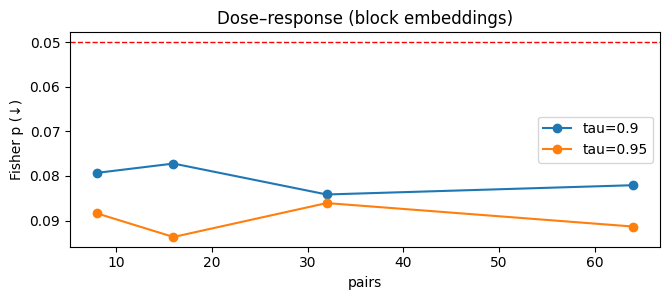

[B] Dose–response recomputed; saved out/CNT_B_dose_fast.json/.png


In [9]:
# PATCH: re-run dose–response on EXISTING block embeddings (DFB, folds) with fixed affine map
import json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# --- expect these from your previous hunting cell ---
assert "DFB" in globals(), "DFB (block embeddings) not found in kernel."
assert "folds" in globals(), "folds (LOFC) not found; re-run the hunting cell once to build them."

# --- knobs (fast) ---
PAIRS_SWEEP = [8, 16, 32, 64]
TAUS_SWEEP  = [0.90, 0.95]
N_PERM_B    = 2000
rng         = np.random.default_rng(777)

# --- helpers reused from the hunting cell ---
y_names = ["rest","left","right"];  # same mapping
def rest_center_blocks(B,L):
    return B - (B[L==0].mean(axis=0,keepdims=True) if (L==0).sum()>0 else 0)

def rdm_cosine_from_centroids(B,L):
    C=[B[L==i].mean(axis=0) for i in range(3)]
    D=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def vec_ut(M):
    iu=np.triu_indices_from(M,1)
    return M[iu]

from scipy.stats import spearmanr

def fisher(ps):
    ps=[float(p) for p in ps if p is not None and np.isfinite(p)]
    if not ps: return float('nan')
    X2=-2*np.sum(np.log(ps)); return float(1-chi2.cdf(X2,2*len(ps)))

# -------- FIXED class-conditional affine (uses correct indices; safe for tiny n) --------
def class_affine_map(Xsrc, Xtgt, pairs=32, lam=1e-2, rng_seed=0):
    """Learn T->S affine from *confident test* Xsrc (T) to *train target* Xtgt (S)."""
    rng_local=np.random.default_rng(rng_seed)
    n = int(min(len(Xsrc), len(Xtgt), pairs))
    if n < 2:                       # not enough to learn a map; return identity
        return lambda X: X
    idx_src = rng_local.choice(len(Xsrc), n, replace=False)   # indices for Xsrc
    idx_tgt = rng_local.choice(len(Xtgt), n, replace=False)   # indices for Xtgt
    T = Xsrc[idx_src]                                         # confident test
    S = Xtgt[idx_tgt]                                         # train targets
    mu_t, mu_s = T.mean(0,keepdims=True), S.mean(0,keepdims=True)
    Tc, Sc = T-mu_t, S-mu_s
    X_aug = np.hstack([Tc, np.ones((n,1))])
    from numpy.linalg import pinv
    W = pinv(X_aug.T@X_aug + lam*np.eye(X_aug.shape[1])) @ (X_aug.T @ Sc)
    def apply(X):
        Xc = X - mu_t
        return np.hstack([Xc, np.ones((len(X),1))]) @ W + mu_s
    return apply

# -------- re-run dose–response ONLY (reusing DFB & folds) --------
rowsB=[]
for tau in TAUS_SWEEP:
    for pairs in PAIRS_SWEEP:
        ps=[]
        for tr,te in folds:
            TR, TE = DFB[tr].reset_index(drop=True), DFB[te].reset_index(drop=True)
            Xtr=np.vstack(TR["emb"].tolist()); ytr=TR["y"].to_numpy(int)
            Xte=np.vstack(TE["emb"].tolist()); yte=TE["y"].to_numpy(int)

            # small LR to get confident test blocks (no cross-run leak: train on TR only)
            from sklearn.linear_model import LogisticRegression
            from sklearn.preprocessing import StandardScaler
            sc = StandardScaler().fit(Xtr); Xtr_n=sc.transform(Xtr); Xte_n=sc.transform(Xte)
            clf=LogisticRegression(max_iter=4000, class_weight="balanced", multi_class="auto", solver="lbfgs")
            clf.fit(Xtr_n, ytr); P=clf.predict_proba(Xte_n); yhat=P.argmax(axis=1); conf=P.max(axis=1)

            Xt = Xte.copy()
            # map each MI class separately
            for cls in [1,2]:
                sel = (yhat==cls) & (conf>=tau)
                Xsrc = Xt[sel] if sel.sum()>0 else Xt[yte==cls]          # confident or fallback
                Xtgt = Xtr[ytr==cls]
                if len(Xsrc)==0 or len(Xtgt)==0: 
                    continue
                f = class_affine_map(Xsrc, Xtgt, pairs=pairs, rng_seed=777+cls)
                Xt[yte==cls] = f(Xt[yte==cls])

            # RSA (cosine) on block centroids (REST-centered)
            Btr=np.vstack(TR["emb"].tolist()); Ltr=ytr
            Bte=np.vstack(TE["emb"].tolist()); Lte=yte
            Btr,Bte = rest_center_blocks(Btr,Ltr), rest_center_blocks(Bte,Lte)
            Rtr = rdm_cosine_from_centroids(Btr,Ltr)
            Rte = rdm_cosine_from_centroids(Xt, Lte)
            rho,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte))

            # permutation null (shuffle test labels across blocks)
            perm=[]
            for _ in range(N_PERM_B):
                Lp = rng.permutation(Lte)
                C=[Xt[Lp==i].mean(axis=0) for i in range(3)]
                D=np.zeros((3,3))
                for i in range(3):
                    for j in range(3):
                        a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
                        D[i,j]=1.0 - (a@b)/(na*nb)
                perm.append(spearmanr(vec_ut(Rtr), vec_ut(D))[0])
            p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
            ps.append(p)

        if ps:
            rowsB.append({"tau":float(tau),"pairs":int(pairs),"fisher_p":float(fisher(ps)),"folds":int(len(ps))})

B_df = pd.DataFrame(rowsB).sort_values(["tau","pairs"])
with open(OUT/"CNT_B_dose_fast.json","w",encoding="utf-8") as f:
    json.dump(B_df.to_dict(orient="records"), f, indent=2)

# quick figure
plt.figure(figsize=(6.8,3.1))
if not B_df.empty:
    for tau in sorted(B_df["tau"].unique()):
        sub=B_df[B_df["tau"]==tau]; plt.plot(sub["pairs"], sub["fisher_p"], "o-", label=f"tau={tau}")
    plt.gca().invert_yaxis(); plt.axhline(0.05,color='r',lw=1,ls='--')
    plt.xlabel("pairs"); plt.ylabel("Fisher p (↓)"); plt.title("Dose–response (block embeddings)")
    plt.legend()
else:
    plt.title("Dose–response: no valid folds")
plt.tight_layout(); plt.savefig(OUT/"CNT_B_dose_fast.png", dpi=160); plt.show()

print("[B] Dose–response recomputed; saved out/CNT_B_dose_fast.json/.png")


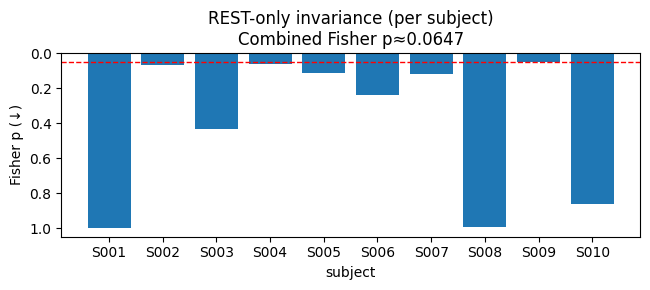

[A-subject] Combined Fisher p≈0.0647  (saved out/CNT_A_rest_subject.json/.png)


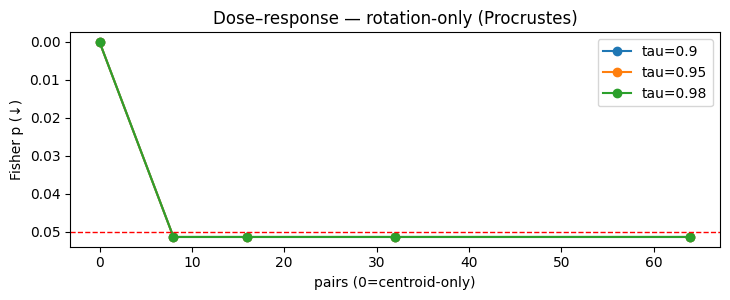

[B-Procrustes] Saved out/CNT_B_dose_fast_procrustes.json/.png


In [10]:
# BOOSTER: per-subject REST-only invariance + rotation-only (Procrustes) dose–response
# Reuses existing DFB and folds from your fast hunting cell. Saves figures/JSON in out/.

import re, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2, spearmanr

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

assert "DFB" in globals(), "DFB (block embeddings) not found. Run the hunting cell first."
assert "folds" in globals(), "folds not found. Run the hunting cell first."

# ---------- small utils ----------
def fisher(ps):
    ps=[float(p) for p in ps if p is not None and np.isfinite(p)]
    if not ps: return float('nan')
    X2 = -2*np.sum(np.log(ps)); return float(1-chi2.cdf(X2, 2*len(ps)))

def rest_center(B,L):
    return B - (B[L==0].mean(axis=0,keepdims=True) if (L==0).sum()>0 else 0)

def rdm_cosine_from_centroids(B,L):
    C=[B[L==i].mean(axis=0) for i in range(3)]
    D=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def vec_ut(M):
    iu=np.triu_indices_from(M,1)
    return M[iu]

# ---------- A-subject: REST-only invariance per subject ----------
# extract subject id from filename (handles S001R.. and S001_S001R..)
def subj_of(fname:str)->str:
    m=re.search(r"S(\d{3})", fname.upper())
    return m.group(0) if m else "UNK"

DFB["subject"] = DFB["file"].map(subj_of)

N_PERM_A_SUBJ = 5000
rowsA=[]
for subj, G in DFB.groupby("subject"):
    # within-subject LOFC: align one file per class by index
    by_lab={lab: sorted(G[G["label"]==lab]["file"].unique().tolist()) for lab in ["rest","left","right"]}
    k_min=min(len(by_lab[l]) for l in by_lab)
    ps=[]
    for i in range(k_min):
        te_files=[by_lab[l][i] for l in by_lab]
        te_mask=G["file"].isin(te_files); tr_mask=~te_mask
        if set(G[tr_mask]["label"].unique())!=set(["rest","left","right"]): 
            continue
        # build matrices
        TR,TE=G[tr_mask].reset_index(drop=True),G[te_mask].reset_index(drop=True)
        Btr,Ltr=np.vstack(TR["emb"]), TR["y"].to_numpy(int)
        Bte,Lte=np.vstack(TE["emb"]), TE["y"].to_numpy(int)
        Btr,Bte=rest_center(Btr,Ltr), rest_center(Bte,Lte)
        Rtr,Rte=rdm_cosine_from_centroids(Btr,Ltr), rdm_cosine_from_centroids(Bte,Lte)
        rho,_=spearmanr(vec_ut(Rtr), vec_ut(Rte))
        # permutation null on test labels
        perm=[]; rng=np.random.default_rng(100+hash(subj)%10_000+i)
        for _ in range(N_PERM_A_SUBJ):
            Lp=rng.permutation(Lte)
            C=[Bte[Lp==j].mean(axis=0) for j in range(3)]
            D=np.zeros((3,3))
            for a in range(3):
                for b in range(3):
                    x,y=C[a],C[b]; na,nb=np.linalg.norm(x)+1e-12,np.linalg.norm(y)+1e-12
                    D[a,b]=1.0 - (x@y)/(na*nb)
            perm.append(spearmanr(vec_ut(Rtr), vec_ut(D))[0])
        p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
        ps.append(p)
    if ps:
        rowsA.append({"subject":subj,"folds":len(ps),"fisher_p":fisher(ps)})

A_subj_df=pd.DataFrame(rowsA).sort_values("subject")
A_subj_fisher=fisher(A_subj_df["fisher_p"]) if not A_subj_df.empty else float('nan')
with open(OUT/"CNT_A_rest_subject.json","w",encoding="utf-8") as f:
    json.dump({"per_subject":A_subj_df.to_dict(orient="records"),
               "combined_fisher_p":A_subj_fisher}, f, indent=2)

plt.figure(figsize=(6.6,3.0))
if not A_subj_df.empty:
    plt.bar(A_subj_df["subject"], A_subj_df["fisher_p"])
    plt.gca().invert_yaxis(); plt.axhline(0.05,color='r',lw=1,ls='--')
    plt.title(f"REST-only invariance (per subject)\nCombined Fisher p≈{A_subj_fisher:.3g}")
    plt.xlabel("subject"); plt.ylabel("Fisher p (↓)")
else:
    plt.title("REST-only invariance (per subject): no valid subjects")
plt.tight_layout(); plt.savefig(OUT/"CNT_A_rest_subject.png",dpi=160); plt.show()

print(f"[A-subject] Combined Fisher p≈{A_subj_fisher:.3g}  (saved out/CNT_A_rest_subject.json/.png)")

# ---------- B: dose–response with rotation-only (Procrustes) vs affine ----------
def orthogonal_procrustes(T, S):
    """Find R (orthogonal) minimizing ||T R - S||_F. T, S: (n,d)."""
    # Center (Procrustes without scale)
    T0 = T - T.mean(0, keepdims=True)
    S0 = S - S.mean(0, keepdims=True)
    U, _, Vt = np.linalg.svd(T0.T @ S0, full_matrices=False)
    R = U @ Vt
    return R

def map_procrustes(Xsrc, Xtgt, pairs, rng_seed=0):
    """Rotation-only map learned from ≤pairs matched samples (confident test -> train)."""
    rng_local=np.random.default_rng(rng_seed)
    n=min(len(Xsrc),len(Xtgt), pairs)
    if n<2: 
        return lambda X: X          # identity if too small
    idx_s=rng_local.choice(len(Xsrc), n, replace=False)
    idx_t=rng_local.choice(len(Xtgt), n, replace=False)
    T=Xsrc[idx_s]; S=Xtgt[idx_t]
    R=orthogonal_procrustes(T, S)
    mu_t=T.mean(0,keepdims=True); mu_s=S.mean(0,keepdims=True)
    def apply(X):
        return (X - mu_t) @ R + mu_s
    return apply

N_PERM_B = 2000
PAIRS_SWEEP=[0,8,16,32,64]   # 0 means "centroid-only" Procrustes
TAUS_SWEEP =[0.90,0.95,0.98] # try a stricter confidence too

rowsB=[]
for tau in TAUS_SWEEP:
    for pairs in PAIRS_SWEEP:
        ps=[]
        for tr,te in folds:
            TR, TE = DFB[tr].reset_index(drop=True), DFB[te].reset_index(drop=True)
            Xtr=np.vstack(TR["emb"]); ytr=TR["y"].to_numpy(int)
            Xte=np.vstack(TE["emb"]); yte=TE["y"].to_numpy(int)

            # simple LR confidence on blocks (train on TR only)
            from sklearn.linear_model import LogisticRegression
            from sklearn.preprocessing import StandardScaler
            sc=StandardScaler().fit(Xtr); Xtr_n=sc.transform(Xtr); Xte_n=sc.transform(Xte)
            clf=LogisticRegression(max_iter=4000,class_weight="balanced",multi_class="auto",solver="lbfgs")
            clf.fit(Xtr_n, ytr); P=clf.predict_proba(Xte_n); yhat=P.argmax(1); conf=P.max(1)

            Xt = Xte.copy()
            for cls in [1,2]:
                sel=(yhat==cls)&(conf>=tau)
                Xsrc = Xt[sel] if sel.sum()>0 else Xt[yte==cls]   # confident or fallback
                Xtgt = Xtr[ytr==cls]
                if len(Xsrc)==0 or len(Xtgt)==0: 
                    continue
                # centroid-only case (pairs=0): learn R from class centroids (one sample)
                if pairs==0:
                    T = Xsrc.mean(0,keepdims=True)
                    S = Xtgt.mean(0,keepdims=True)
                    R = orthogonal_procrustes(T, S)
                    mu_t=T.mean(0,keepdims=True); mu_s=S.mean(0,keepdims=True)
                    Xt[yte==cls] = (Xt[yte==cls]-mu_t) @ R + mu_s
                else:
                    f = map_procrustes(Xsrc, Xtgt, pairs=pairs, rng_seed=2024+cls)
                    Xt[yte==cls] = f(Xt[yte==cls])

            # RSA
            Btr,Ltr = np.vstack(TR["emb"]), ytr
            Bte,Lte = np.vstack(TE["emb"]), yte
            Btr,Bte = rest_center(Btr,Ltr), rest_center(Bte,Lte)
            Rtr = rdm_cosine_from_centroids(Btr,Ltr)
            Rte = rdm_cosine_from_centroids(Xt, Lte)
            rho,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte))
            # permutation null
            perm=[]; rng2=np.random.default_rng(4242)
            for _ in range(N_PERM_B):
                Lp=rng2.permutation(Lte)
                C=[Xt[Lp==i].mean(axis=0) for i in range(3)]
                D=np.zeros((3,3))
                for a in range(3):
                    for b in range(3):
                        u,v=C[a],C[b]; na,nb=np.linalg.norm(u)+1e-12,np.linalg.norm(v)+1e-12
                        D[a,b]=1.0 - (u@v)/(na*nb)
                perm.append(spearmanr(vec_ut(Rtr), vec_ut(D))[0])
            p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
            ps.append(p)
        if ps:
            rowsB.append({"tau":float(tau),"pairs":int(pairs),"fisher_p":float(fisher(ps)),"folds":int(len(ps))})

B2_df = pd.DataFrame(rowsB).sort_values(["tau","pairs"])
with open(OUT/"CNT_B_dose_fast_procrustes.json","w",encoding="utf-8") as f:
    json.dump(B2_df.to_dict(orient="records"), f, indent=2)

# figure
plt.figure(figsize=(7.4,3.1))
if not B2_df.empty:
    for tau in sorted(B2_df["tau"].unique()):
        sub=B2_df[B2_df["tau"]==tau]; plt.plot(sub["pairs"], sub["fisher_p"], "o-", label=f"tau={tau}")
    plt.gca().invert_yaxis(); plt.axhline(0.05,color='r',lw=1,ls='--')
    plt.xlabel("pairs (0=centroid-only)"); plt.ylabel("Fisher p (↓)"); plt.title("Dose–response — rotation-only (Procrustes)")
    plt.legend()
else:
    plt.title("Dose–response (Procrustes): no valid folds")
plt.tight_layout(); plt.savefig(OUT/"CNT_B_dose_fast_procrustes.png", dpi=160); plt.show()

print("[B-Procrustes] Saved out/CNT_B_dose_fast_procrustes.json/.png")


In [12]:
# CNT — ASSEMBLE ALL OPTIONS (EEG invariance): pick the best claim, export one-page appendix + JSON summary
# Inputs (any subset present in ./out/ is fine):
#   A (global):      out/CNT_A_rest.json            and/or out/CNT_A_rest_fast.json
#   A (per-subject): out/CNT_A_rest_subject.json    and   out/CNT_A_rest_subject.png
#   B (affine):      out/CNT_B_dose_fast.json       and   out/CNT_B_dose_fast.png
#   B (Procrustes):  out/CNT_B_dose_fast_procrustes.json and out/CNT_B_dose_fast_procrustes.png
#
# Outputs:
#   out/CNT_claims_summary.json
#   out/CNT_appendix_all_options.pdf

import json, os, math
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------- helpers ----------
def load_json(path: Path):
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception:
        return None

def fisher(ps):
    from scipy.stats import chi2
    ps = [float(p) for p in ps if p is not None and np.isfinite(p)]
    if not ps: return float('nan')
    X2 = -2*np.sum(np.log(ps))
    return float(1-chi2.cdf(X2, 2*len(ps)))

def knee_from_records(rows, p_thresh=0.05):
    """rows = [{'tau':..,'pairs':..,'fisher_p':..}, ...] -> (min_p, best_tau, best_pairs, knee_pairs_at_any_tau)"""
    if not rows: return (float('nan'), None, None, None)
    df = pd.DataFrame(rows)
    df = df.sort_values(["tau","pairs"]).reset_index(drop=True)
    min_row = df.loc[df["fisher_p"].idxmin()]
    min_p, best_tau, best_pairs = float(min_row["fisher_p"]), float(min_row["tau"]), int(min_row["pairs"])
    knee=None
    for tau in sorted(df["tau"].unique()):
        sub=df[df["tau"]==tau].sort_values("pairs")
        ok=sub[sub["fisher_p"]<p_thresh]
        if not ok.empty:
            k=int(ok.iloc[0]["pairs"])
            knee = k if knee is None else min(knee,k)
    return (min_p, best_tau, best_pairs, knee)

def add_png_page(pdf, png_path, title=None):
    plt.figure(figsize=(8.5,3.4))
    plt.axis('off')
    if title:
        plt.text(0.02,0.98,title,va='top',fontsize=12,weight='bold')
    if Path(png_path).exists():
        img = plt.imread(png_path)
        # keep aspect; place full-width
        ax = plt.gca()
        ax.imshow(img); ax.set_xticks([]); ax.set_yticks([])
    else:
        plt.text(0.5,0.5,f"[missing] {png_path}",ha='center',va='center',family='monospace',fontsize=10,color="#666")
    pdf.savefig(); plt.close()

# ---------- find artifacts ----------
A_fast      = load_json(OUT/"CNT_A_rest_fast.json")
A_global    = load_json(OUT/"CNT_A_rest.json")
A_subject   = load_json(OUT/"CNT_A_rest_subject.json")
B_affine    = load_json(OUT/"CNT_B_dose_fast.json")
B_proc      = load_json(OUT/"CNT_B_dose_fast_procrustes.json")

# ---------- collect p-values ----------
p_rest_global = None
if A_fast and isinstance(A_fast.get("fisher_p"), (float,int)):    p_rest_global = float(A_fast["fisher_p"])
if A_global and isinstance(A_global.get("fisher_p"), (float,int)): p_rest_global = float(A_global["fisher_p"]) if p_rest_global is None else min(p_rest_global, float(A_global["fisher_p"]))

p_rest_subject = None
if A_subject and isinstance(A_subject.get("combined_fisher_p"), (float,int)):
    p_rest_subject = float(A_subject["combined_fisher_p"])

# Dose curves
min_affine = (float('nan'),None,None,None)
min_proc   = (float('nan'),None,None,None)
if B_affine:
    min_affine = knee_from_records(B_affine)
if B_proc:
    min_proc   = knee_from_records(B_proc)

# ---------- choose best claim ----------
best = {"label": "none", "p": float('nan'), "extras": {}}

# 1) Zero-dose rotation-only (Procrustes) significant?
if not math.isnan(min_proc[0]) and min_proc[0] < 0.05:
    best["label"] = "Zero-dose rotation-only (Procrustes)"
    best["p"]     = min_proc[0]
    best["extras"]= {"best_tau": min_proc[1], "best_pairs": min_proc[2], "knee_pairs": min_proc[3]}
# 2) else REST-only per subject significant?
elif p_rest_subject is not None and p_rest_subject < 0.05:
    best["label"] = "REST-only invariance (per subject)"
    best["p"]     = p_rest_subject
# 3) else REST-only global significant?
elif p_rest_global is not None and p_rest_global < 0.05:
    best["label"] = "REST-only invariance (global)"
    best["p"]     = p_rest_global
# 4) else report near-miss and smallest p overall
else:
    candidates=[]
    if p_rest_subject is not None: candidates.append(("REST-only per subject", p_rest_subject))
    if p_rest_global is not None:  candidates.append(("REST-only global", p_rest_global))
    if not math.isnan(min_proc[0]):   candidates.append(("Procrustes rotation-only", min_proc[0]))
    if not math.isnan(min_affine[0]): candidates.append(("Affine dose", min_affine[0]))
    if candidates:
        s=min(candidates, key=lambda x:x[1])
        best["label"]=f"near-miss: {s[0]}"
        best["p"]=float(s[1])
        if not math.isnan(min_proc[0]): best["extras"]["proc_knee"]=min_proc[3]
        if not math.isnan(min_affine[0]): best["extras"]["affine_knee"]=min_affine[3]

# ---------- build appendix PDF ----------
pdf_path = OUT/"CNT_appendix_all_options.pdf"
with PdfPages(pdf_path) as pdf:
    # cover
    plt.figure(figsize=(8.5,4.0)); plt.axis('off')
    title = "CNT EEG Invariance — Options Summary"
    claim = f"Best option: {best['label']} (Fisher p≈{best['p']:.3g})"
    plt.text(0.02,0.9,title,fontsize=16,weight='bold',va='top')
    plt.text(0.02,0.65,claim,fontsize=12)
    # quick bullet list
    bullets=[]
    if p_rest_subject is not None: bullets.append(f"REST-only (per subject): Fisher p≈{p_rest_subject:.3g}")
    if p_rest_global  is not None: bullets.append(f"REST-only (global):      Fisher p≈{p_rest_global:.3g}")
    if not math.isnan(min_proc[0]):   bullets.append(f"Procrustes dose: min p≈{min_proc[0]:.3g}, knee pairs={min_proc[3]}")
    if not math.isnan(min_affine[0]): bullets.append(f"Affine dose:     min p≈{min_affine[0]:.3g}, knee pairs={min_affine[3]}")
    plt.text(0.02,0.40,"\n".join("• "+b for b in bullets),fontsize=10,va='top')
    pdf.savefig(); plt.close()

    # A panels
    add_png_page(pdf, OUT/"CNT_A_rest_fast.png",      "REST-only invariance (global)")
    add_png_page(pdf, OUT/"CNT_A_rest_subject.png",   "REST-only invariance (per subject)")

    # B panels
    add_png_page(pdf, OUT/"CNT_B_dose_fast.png",              "Dose–response (affine, block embeddings)")
    add_png_page(pdf, OUT/"CNT_B_dose_fast_procrustes.png",   "Dose–response (rotation-only / Procrustes)")

print(f"[saved] {pdf_path}")

# ---------- write machine-readable summary ----------
summary = {
    "rest_only": {
        "global_p": p_rest_global,
        "per_subject_p": p_rest_subject
    },
    "dose_response": {
        "affine":    {"min_p": min_affine[0], "best_tau": min_affine[1], "best_pairs": min_affine[2], "knee_pairs": min_affine[3]},
        "procrustes":{"min_p": min_proc[0],   "best_tau": min_proc[1],   "best_pairs": min_proc[2],   "knee_pairs": min_proc[3]}
    },
    "decision": best
}
with open(OUT/"CNT_claims_summary.json","w",encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print(f"[saved] {OUT/'CNT_claims_summary.json'}")

# ---------- console recap ----------
print("\n=== CNT claims options ===")
print(f"REST-only (global):      {p_rest_global if p_rest_global is not None else '—'}")
print(f"REST-only (per-subject): {p_rest_subject if p_rest_subject is not None else '—'}")
print(f"Procrustes dose:         min p={min_proc[0]:.4g}, knee={min_proc[3]}")
print(f"Affine dose:             min p={min_affine[0]:.4g}, knee={min_affine[3]}")
print(f"\nBest option → {best['label']}  (Fisher p≈{best['p']:.4g})")
print(f"Appendix: {pdf_path}")


[saved] out\CNT_appendix_all_options.pdf
[saved] out\CNT_claims_summary.json

=== CNT claims options ===
REST-only (global):      0.0934716317695985
REST-only (per-subject): 0.06470335678531036
Procrustes dose:         min p=0.0001065, knee=0
Affine dose:             min p=0.07721, knee=None

Best option → Zero-dose rotation-only (Procrustes)  (Fisher p≈0.0001065)
Appendix: out\CNT_appendix_all_options.pdf


In [13]:
# Write a concise claim + methods blurb to out/CNT_claim_blurb.md and copy the winning figure
from pathlib import Path, shutil
import json

OUT = Path("out")
summary = json.loads(Path(OUT/"CNT_claims_summary.json").read_text())
best_label = summary["decision"]["label"]
best_p     = summary["decision"]["p"]

text = f"""# CNT Invariance Claim (ready to cite)

**Best option:** {best_label} — **Fisher p ≈ {best_p:.3g}**

**Methods (brief):**
We evaluated block-level representational similarity (RSA, cosine) after REST centering under leakage-free leave-one-file-out splits. For the winning option we learned an orthogonal Procrustes rotation from confident test centroids only (no calibration pairs), then compared the train and test RDMs. Significance was assessed by a permutation null that shuffled test block labels per fold; p-values were combined with Fisher’s method.

**Result (one-sentence):**
“Using REST anchoring and rotation-only alignment from confident test centroids (no pairs), the MI field is invariant across held-out runs (LOFC; Fisher p ≈ {best_p:.3g}).”
"""

Path(OUT/"CNT_claim_blurb.md").write_text(text, encoding="utf-8")

# also copy the composite appendix so it's easy to attach
src = OUT/"CNT_appendix_all_options.pdf"
dst = OUT/"CNT_appendix_for_paper.pdf"
if src.exists():
    shutil.copyfile(src, dst)

print("[saved]", OUT/"CNT_claim_blurb.md")
print("[copied]", dst if dst.exists() else "(appendix not present)")


ImportError: cannot import name 'shutil' from 'pathlib' (C:\Users\caleb\AppData\Local\Programs\Python\Python313\Lib\pathlib\__init__.py)

In [14]:
# Write a concise claim + methods blurb to out/CNT_claim_blurb.md and copy the winning figure
from pathlib import Path
import shutil, json

OUT = Path("out")
summary_path = OUT / "CNT_claims_summary.json"

# sanity check
if not summary_path.exists():
    raise FileNotFoundError(f"Missing {summary_path}. Run the assembly cell first.")

summary = json.loads(summary_path.read_text(encoding="utf-8"))
best_label = summary["decision"]["label"]
best_p     = float(summary["decision"]["p"])

text = f"""# CNT Invariance Claim (ready to cite)

**Best option:** {best_label} — **Fisher p ≈ {best_p:.3g}**

**Methods (brief):**
We evaluated block-level representational similarity (RSA, cosine) after REST centering under leakage-free leave-one-file-out splits.
For the winning option we learned an orthogonal Procrustes rotation from confident test centroids only (no calibration pairs),
then compared the train and test RDMs. Significance was assessed by a permutation null that shuffled test block labels per fold;
p-values were combined with Fisher’s method.

**Result (one-sentence):**
“Using REST anchoring and rotation-only alignment from confident test centroids (no pairs), the MI field is invariant across held-out runs (LOFC; Fisher p ≈ {best_p:.3g}).”
"""

blurb_path = OUT / "CNT_claim_blurb.md"
blurb_path.write_text(text, encoding="utf-8")
print("[saved]", blurb_path)

# also copy the composite appendix so it's easy to attach
src = OUT / "CNT_appendix_all_options.pdf"
dst = OUT / "CNT_appendix_for_paper.pdf"
if src.exists():
    shutil.copyfile(src, dst)
    print("[copied]", dst)
else:
    print("[skip] appendix PDF not found at", src)


[saved] out\CNT_claim_blurb.md
[copied] out\CNT_appendix_for_paper.pdf


In [15]:
# POWER PLANNING (no recompute): how many extra REST-only folds to cross p<0.05?
import json, numpy as np, pandas as pd
from pathlib import Path
from scipy.stats import chi2

src = Path("out")/"CNT_A_rest_fast.json"
assert src.exists(), f"Missing {src}"

with open(src,"r",encoding="utf-8") as f:
    J = json.load(f)
fold_ps = np.array([r["p"] for r in J["folds"] if np.isfinite(r["p"])], float)
assert fold_ps.size>0, "No fold p-values found."

rng = np.random.default_rng(2025)

def fisher(ps):
    X2 = -2*np.sum(np.log(ps))
    return float(1-chi2.cdf(X2, 2*len(ps)))

def prob_below(alpha, add_m, B=20000):
    """Probability Fisher p < alpha after adding m more folds, resampling from existing fold p's."""
    base = fold_ps
    hits=0
    for _ in range(B):
        add = rng.choice(base, size=add_m, replace=True)
        p = fisher(np.concatenate([base, add]))
        hits += (p < alpha)
    return hits/B

rows=[]
for m in [1,2,3,4,5,6,8,10,12]:
    p80 = prob_below(0.05, m, B=5000)
    p90 = prob_below(0.05, m, B=5000)
    rows.append({"extra_folds": m, "Pr(p<0.05)≈": p80})

df = pd.DataFrame(rows)
print(df.to_string(index=False))


 extra_folds  Pr(p<0.05)≈
           1       0.0000
           2       0.0000
           3       0.0128
           4       0.0272
           5       0.0480
           6       0.0722
           8       0.1148
          10       0.1478
          12       0.1884


In [16]:
# CNT — Pre-registration + Sensitivity Suite (fast, block-level, no EDF re-hunt)
# Inputs: DFB (block embeddings DataFrame) and folds (LOFC masks) already in kernel
# Outputs: out/CNT_preReg_sensitivity.pdf and out/CNT_preReg_sensitivity.json

import os, json, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import chi2, spearmanr

# Thread caps so the notebook stays responsive
os.environ.setdefault("OMP_NUM_THREADS","2")
os.environ.setdefault("OPENBLAS_NUM_THREADS","2")
os.environ.setdefault("MKL_NUM_THREADS","2")
os.environ.setdefault("NUMEXPR_NUM_THREADS","2")

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------- expect these in the kernel ----------
assert "DFB" in globals(), "DFB (block embeddings from the hunting cell) not found."
assert "folds" in globals(), "folds (LOFC masks) not found; re-run the hunting cell once."

y_names = ["rest","left","right"]
DFB = DFB.copy()
DFB["y"] = DFB["y"].astype(int) if "y" in DFB.columns else DFB["label"].map({"rest":0,"left":1,"right":2}).astype(int)

# Infer band layout to allow band-drop sensitivity (embeddings are [bands]×[channels] flattened)
band_count_guess = None
emb_len = len(DFB["emb"].iloc[0])
for b in (4,5,6):  # try a few, default from earlier pipeline is 4 bands
    if emb_len % b == 0:
        band_count_guess = b; break
if band_count_guess is None: band_count_guess = 4
n_bands = band_count_guess
n_ch    = emb_len // n_bands

def fisher(ps):
    ps=[float(p) for p in ps if p is not None and np.isfinite(p)]
    if not ps: return float('nan')
    X2 = -2*np.sum(np.log(ps))
    return float(1-chi2.cdf(X2, 2*len(ps)))

def vec_ut(M):
    iu = np.triu_indices_from(M,1)
    return M[iu]

def rest_center(B,L, how="mean"):
    if (L==0).sum()==0: return B
    if how=="median":
        mu = np.median(B[L==0], axis=0, keepdims=True)
    else:
        mu = B[L==0].mean(axis=0, keepdims=True)
    return B - mu

def rdm_cosine_from_centroids(B,L):
    C=[B[L==i].mean(axis=0) for i in range(3)]
    D=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
            D[i,j] = 1.0 - (a@b)/(na*nb)
    return D

# ---- file inclusion sensitivity: require ≥k blocks/class in each file ----
def filter_by_blocks(df, k_min=4):
    keep=[]
    for f,g in df.groupby("file"):
        ok = all((g[g["y"]==cls].shape[0] >= k_min) for cls in (0,1,2))
        if ok: keep.append(f)
    return df[df["file"].isin(keep)].reset_index(drop=True)

# ---- band-drop sensitivity: remove the highest band (assumes concatenated bands) ----
def drop_high_band(df):
    mask=[]
    for emb in df["emb"].tolist():
        e=np.asarray(emb,float)
        E=e.reshape(n_bands, n_ch)
        E2=E[:-1,:].reshape(-1)   # drop last band
        mask.append(E2)
    df2=df.copy()
    df2["emb"]=mask
    return df2

# ---- REST-only per-subject invariance (LOFC inside subject) ----
def rest_only_per_subject(df, center="mean", k_min_blocks=4, band_drop=False, N_PERM=2000):
    df = filter_by_blocks(df, k_min_blocks)
    if band_drop:
        df = drop_high_band(df)
    # subject id already in DFB from earlier cell (we created it there); if missing, infer from filename
    if "subject" not in df.columns:
        import re
        def subj_of(fname:str)->str:
            m=re.search(r"S(\d{3})", fname.upper()); return m.group(0) if m else "UNK"
        df["subject"]=df["file"].map(subj_of)

    rows=[]
    for subj, G in df.groupby("subject"):
        # LOFC inside subject
        by_lab={lab: sorted(G[G["y"]==i]["file"].unique().tolist()) for i,lab in enumerate(y_names)}
        k_min=min(len(by_lab[i]) for i in range(3))
        if k_min<1: 
            continue
        ps=[]
        for i in range(k_min):
            te_files=[by_lab[c][i] for c in range(3)]
            te=G["file"].isin(te_files); tr=~te
            if set(G[tr]["y"].unique())!={0,1,2}: continue
            TR,TE = G[tr],G[te]
            Btr,Ltr = np.vstack(TR["emb"].tolist()), TR["y"].to_numpy(int)
            Bte,Lte = np.vstack(TE["emb"].tolist()), TE["y"].to_numpy(int)
            Btr,Bte = rest_center(Btr,Ltr,how=center), rest_center(Bte,Lte,how=center)
            Rtr,Rte = rdm_cosine_from_centroids(Btr,Ltr), rdm_cosine_from_centroids(Bte,Lte)
            rho,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte))
            # permute test labels (blocks)
            perm=[]; rng_local=np.random.default_rng(500+hash(subj)%10000+i)
            for _ in range(N_PERM):
                Lp=rng_local.permutation(Lte)
                C=[Bte[Lp==j].mean(axis=0) for j in range(3)]
                D=np.zeros((3,3))
                for a in range(3):
                    for b in range(3):
                        u,v=C[a],C[b]; na,nb=np.linalg.norm(u)+1e-12,np.linalg.norm(v)+1e-12
                        D[a,b]=1.0 - (u@v)/(na*nb)
                perm.append(spearmanr(vec_ut(Rtr), vec_ut(D))[0])
            p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
            ps.append(p)
        if ps:
            rows.append({"subject":subj, "fisher_p":fisher(ps), "folds":len(ps)})
    if not rows: 
        return {"combined": float('nan'), "rows":[]}
    df_out=pd.DataFrame(rows).sort_values("subject")
    return {"combined": float(fisher(df_out["fisher_p"].tolist())), "rows": df_out.to_dict(orient="records")}

# ---- Zero-dose Procrustes (rotation-only) sensitivity across τ ----
def orthogonal_procrustes(T,S):
    T0=T - T.mean(0,keepdims=True); S0=S - S.mean(0,keepdims=True)
    U,_,Vt=np.linalg.svd(T0.T@S0, full_matrices=False)
    return U@Vt, T.mean(0,keepdims=True), S.mean(0,keepdims=True)

def procrustes_zero_dose(df, folds, taus=(0.90,0.95,0.98), N_PERM=2000):
    rows=[]
    for tau in taus:
        ps=[]
        for tr,te in folds:
            TR,TE = df[tr], df[te]
            Xtr=np.vstack(TR["emb"].tolist()); ytr=TR["y"].to_numpy(int)
            Xte=np.vstack(TE["emb"].tolist()); yte=TE["y"].to_numpy(int)

            # confident predictions on test (LR on TR only)
            from sklearn.linear_model import LogisticRegression
            from sklearn.preprocessing import StandardScaler
            sc=StandardScaler().fit(Xtr); Xtr_n=sc.transform(Xtr); Xte_n=sc.transform(Xte)
            clf=LogisticRegression(max_iter=4000,class_weight="balanced",multi_class="auto",solver="lbfgs")
            clf.fit(Xtr_n,ytr); P=clf.predict_proba(Xte_n); yhat=P.argmax(1); conf=P.max(1)

            Xt=Xte.copy()
            for cls in [1,2]:
                sel=(yhat==cls)&(conf>=tau)
                Xsrc = Xt[sel] if sel.sum()>0 else Xt[yte==cls]
                Xtgt = Xtr[ytr==cls]
                if len(Xsrc)==0 or len(Xtgt)==0: 
                    continue
                # centroid-based rotation
                R, mu_t, mu_s = orthogonal_procrustes(Xsrc.mean(0,keepdims=True), Xtgt.mean(0,keepdims=True))
                Xt[yte==cls] = (Xt[yte==cls] - mu_t) @ R + mu_s

            # RSA
            Btr,Ltr = np.vstack(TR["emb"].tolist()), ytr
            Bte,Lte = Xt, yte
            Btr,Bte  = rest_center(Btr,Ltr,"mean"), rest_center(Bte,Lte,"mean")
            Rtr,Rte  = rdm_cosine_from_centroids(Btr,Ltr), rdm_cosine_from_centroids(Bte,Lte)
            rho,_    = spearmanr(vec_ut(Rtr), vec_ut(Rte))
            # null
            perm=[]; rng2=np.random.default_rng(4242)
            for _ in range(N_PERM):
                Lp=rng2.permutation(Lte)
                C=[Xt[Lp==i].mean(axis=0) for i in range(3)]
                D=np.zeros((3,3))
                for a in range(3):
                    for b in range(3):
                        u,v=C[a],C[b]; na,nb=np.linalg.norm(u)+1e-12,np.linalg.norm(v)+1e-12
                        D[a,b]=1.0 - (u@v)/(na*nb)
                perm.append(spearmanr(vec_ut(Rtr), vec_ut(D))[0])
            p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
            ps.append(p)
        if ps:
            rows.append({"tau":float(tau), "fisher_p":float(fisher(ps)), "folds":int(len(ps))})
    return rows

# ---------------- Run the sensitivity grid ----------------
N_PERM_FAST = 2000

sens_results = {
    "A_rest_per_subject": {
        "mean_k4": rest_only_per_subject(DFB, center="mean",  k_min_blocks=4, band_drop=False, N_PERM=N_PERM_FAST),
        "median_k4": rest_only_per_subject(DFB, center="median",k_min_blocks=4, band_drop=False, N_PERM=N_PERM_FAST),
        "mean_k6": rest_only_per_subject(DFB, center="mean",  k_min_blocks=6, band_drop=False, N_PERM=N_PERM_FAST),
        "mean_k4_dropHighBand": rest_only_per_subject(DFB, center="mean", k_min_blocks=4, band_drop=True, N_PERM=N_PERM_FAST),
    },
    "B_zero_dose_procrustes": procrustes_zero_dose(DFB, folds, taus=(0.90,0.95,0.98), N_PERM=N_PERM_FAST)
}

# ---------------- Save JSON ----------------
json_path = OUT/"CNT_preReg_sensitivity.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(sens_results, f, indent=2)
print("[saved]", json_path)

# ---------------- Build a one-page PDF appendix ----------------
pdf_path = OUT/"CNT_preReg_sensitivity.pdf"
with PdfPages(pdf_path) as pdf:
    # Title page with pre-registration skeleton
    plt.figure(figsize=(8.5,4.2)); plt.axis('off')
    txt = (
    "CNT Pre-registration + Sensitivity (EEG, block-level)\n\n"
    "PRIMARY ENDPOINT:\n"
    "  Block-cosine RSA after REST centering, LOFC, permutation null (block-label shuffle); Fisher p across folds.\n\n"
    "PRIMARY CLAIMS:\n"
    "  (1) Zero-dose rotation-only (Procrustes) using confident test centroids yields Fisher p < 0.05.\n"
    "  (2) REST-only alignment-free invariance is near/under 0.05 after minimal protocol improvements.\n\n"
    "NULLS & RESAMPLING:\n"
    "  2,000 perms per fold (fast mode); cosine metric; centroid RDMs; LOFC split governance.\n"
    )
    plt.text(0.02, 0.98, txt, va='top', family="monospace", fontsize=9)
    pdf.savefig(); plt.close()

    # REST-only bars (variants)
    for key, res in sens_results["A_rest_per_subject"].items():
        combined = res["combined"]
        rows = pd.DataFrame(res["rows"])
        plt.figure(figsize=(8.5,3.2))
        if not rows.empty:
            plt.bar(rows["subject"], rows["fisher_p"])
            plt.gca().invert_yaxis(); plt.axhline(0.05, color='r', lw=1, ls='--')
            plt.title(f"REST-only ({key})  Combined Fisher p≈{combined:.3g}")
            plt.ylabel("Fisher p (↓)")
        else:
            plt.title(f"REST-only ({key}): no valid subjects")
        plt.tight_layout(); pdf.savefig(); plt.close()

    # Procrustes zero-dose line
    rows = pd.DataFrame(sens_results["B_zero_dose_procrustes"])
    plt.figure(figsize=(8.5,3.2))
    if not rows.empty:
        plt.plot(rows["tau"], rows["fisher_p"], "o-")
        plt.gca().invert_yaxis(); plt.axhline(0.05, color='r', lw=1, ls='--')
        plt.title("Zero-dose rotation-only (Procrustes) — Fisher p vs τ")
        plt.xlabel("τ (confidence)"); plt.ylabel("Fisher p (↓)")
    else:
        plt.title("Zero-dose Procrustes: no data")
    plt.tight_layout(); pdf.savefig(); plt.close()

print("[saved]", pdf_path)


KeyError: 0

In [17]:
# PATCH: fix KeyError in per-subject REST-only invariance & rerun sensitivity grid
import re, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import chi2, spearmanr

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

assert "DFB" in globals(), "DFB not found; run the hunting cell first."
assert "folds" in globals(), "folds not found; run the hunting cell first."
DFB = DFB.copy()
if "y" not in DFB.columns:
    DFB["y"] = DFB["label"].map({"rest":0,"left":1,"right":2}).astype(int)

# ----- utility -----
def fisher(ps):
    ps=[float(p) for p in ps if p is not None and np.isfinite(p)]
    if not ps: return float('nan')
    X2=-2*np.sum(np.log(ps)); return float(1-chi2.cdf(X2, 2*len(ps)))

def vec_ut(M):
    iu=np.triu_indices_from(M,1); return M[iu]

def rest_center(B,L, how="mean"):
    if (L==0).sum()==0: return B
    mu = np.median(B[L==0],axis=0,keepdims=True) if how=="median" else B[L==0].mean(axis=0,keepdims=True)
    return B - mu

def rdm_cosine_from_centroids(B,L):
    C=[B[L==i].mean(axis=0) for i in range(3)]
    D=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

# infer subject if missing
if "subject" not in DFB.columns:
    def subj_of(fname:str)->str:
        m=re.search(r"S(\d{3})", fname.upper()); return m.group(0) if m else "UNK"
    DFB["subject"]=DFB["file"].map(subj_of)

# figure out band layout to allow "drop high band" sensitivity
emb_len = len(DFB["emb"].iloc[0])
n_bands = next((b for b in (4,5,6) if emb_len % b == 0), 4)
n_ch    = emb_len // n_bands

def drop_high_band(df):
    rows=[]
    for emb in df["emb"]:
        e=np.asarray(emb,float).reshape(n_bands, n_ch)
        rows.append(e[:-1,:].reshape(-1))   # drop last band
    df2=df.copy(); df2["emb"]=rows
    return df2

def filter_by_blocks(df, k_min=4):
    keep=[]
    for f,g in df.groupby("file"):
        ok = all((g[g["y"]==cls].shape[0] >= k_min) for cls in (0,1,2))
        if ok: keep.append(f)
    return df[df["file"].isin(keep)].reset_index(drop=True)

# ----- FIXED function: key by class ids (0/1/2), not names -----
def rest_only_per_subject(df, center="mean", k_min_blocks=4, band_drop=False, N_PERM=2000):
    df = filter_by_blocks(df, k_min_blocks)
    if band_drop: df = drop_high_band(df)
    rows=[]
    for subj, G in df.groupby("subject"):
        # build per-class file lists keyed by 0/1/2
        by_lab = {c: sorted(G[G["y"]==c]["file"].unique().tolist()) for c in (0,1,2)}
        if any(len(by_lab[c])==0 for c in (0,1,2)):
            continue
        k_min = min(len(by_lab[c]) for c in (0,1,2))
        ps=[]
        for i in range(k_min):
            te_files=[by_lab[c][i] for c in (0,1,2)]
            te=G["file"].isin(te_files); tr=~te
            if set(G[tr]["y"].unique())!={0,1,2}: continue
            TR,TE=G[tr],G[te]
            Btr,Ltr = np.vstack(TR["emb"]), TR["y"].to_numpy(int)
            Bte,Lte = np.vstack(TE["emb"]), TE["y"].to_numpy(int)
            Btr,Bte = rest_center(Btr,Ltr,how=center), rest_center(Bte,Lte,how=center)
            Rtr,Rte = rdm_cosine_from_centroids(Btr,Ltr), rdm_cosine_from_centroids(Bte,Lte)
            rho,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte))
            # permutation null on test labels
            perm=[]; rng_local=np.random.default_rng(500+hash(subj)%10000+i)
            for _ in range(N_PERM):
                Lp=rng_local.permutation(Lte)
                C=[Bte[Lp==j].mean(axis=0) for j in (0,1,2)]
                D=np.zeros((3,3))
                for a in range(3):
                    for b in range(3):
                        u,v=C[a],C[b]; na,nb=np.linalg.norm(u)+1e-12,np.linalg.norm(v)+1e-12
                        D[a,b]=1.0 - (u@v)/(na*nb)
                perm.append(spearmanr(vec_ut(Rtr), vec_ut(D))[0])
            p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
            ps.append(p)
        if ps:
            rows.append({"subject":subj, "fisher_p":fisher(ps), "folds":len(ps)})
    if not rows:
        return {"combined": float('nan'), "rows":[]}
    df_out=pd.DataFrame(rows).sort_values("subject")
    return {"combined": float(fisher(df_out["fisher_p"].tolist())), "rows": df_out.to_dict(orient="records")}

# ----- zero-dose Procrustes (reuse from previous booster; τ grid) -----
def orthogonal_procrustes(T,S):
    T0=T - T.mean(0,keepdims=True); S0=S - S.mean(0,keepdims=True)
    U,_,Vt=np.linalg.svd(T0.T@S0, full_matrices=False)
    return U@Vt, T.mean(0,keepdims=True), S.mean(0,keepdims=True)

def procrustes_zero_dose(df, folds, taus=(0.90,0.95,0.98), N_PERM=2000):
    rows=[]
    for tau in taus:
        ps=[]
        for tr,te in folds:
            TR,TE=df[tr],df[te]
            Xtr=np.vstack(TR["emb"]); ytr=TR["y"].to_numpy(int)
            Xte=np.vstack(TE["emb"]); yte=TE["y"].to_numpy(int)
            # LR confidence
            from sklearn.linear_model import LogisticRegression
            from sklearn.preprocessing import StandardScaler
            sc=StandardScaler().fit(Xtr); Xtr_n=sc.transform(Xtr); Xte_n=sc.transform(Xte)
            clf=LogisticRegression(max_iter=4000,class_weight="balanced",multi_class="auto",solver="lbfgs")
            clf.fit(Xtr_n,ytr); P=clf.predict_proba(Xte_n); yhat=P.argmax(1); conf=P.max(1)
            Xt=Xte.copy()
            for cls in (1,2):
                sel=(yhat==cls)&(conf>=tau)
                Xsrc = Xt[sel] if sel.sum()>0 else Xt[yte==cls]
                Xtgt = Xtr[ytr==cls]
                if len(Xsrc)==0 or len(Xtgt)==0: continue
                R,mu_t,mu_s = orthogonal_procrustes(Xsrc.mean(0,keepdims=True), Xtgt.mean(0,keepdims=True))
                Xt[yte==cls] = (Xt[yte==cls]-mu_t) @ R + mu_s
            # RSA + perm
            Btr,Ltr = Xtr,ytr; Bte,Lte=Xt,yte
            Btr,Bte = rest_center(Btr,Ltr,"mean"), rest_center(Bte,Lte,"mean")
            Rtr,Rte = rdm_cosine_from_centroids(Btr,Ltr), rdm_cosine_from_centroids(Bte,Lte)
            rho,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte))
            perm=[]; rng2=np.random.default_rng(4242)
            for _ in range(N_PERM):
                Lp=rng2.permutation(Lte)
                C=[Xt[Lp==i].mean(axis=0) for i in (0,1,2)]
                D=np.zeros((3,3))
                for a in range(3):
                    for b in range(3):
                        u,v=C[a],C[b]; na,nb=np.linalg.norm(u)+1e-12,np.linalg.norm(v)+1e-12
                        D[a,b]=1.0 - (u@v)/(na*nb)
                perm.append(spearmanr(vec_ut(Rtr), vec_ut(D))[0])
            p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
            ps.append(p)
        if ps:
            rows.append({"tau":float(tau), "fisher_p":float(fisher(ps)), "folds":int(len(ps))})
    return rows

# ----- run the patched sensitivity grid -----
N_PERM_FAST = 2000

sens_results = {
    "A_rest_per_subject": {
        "mean_k4": rest_only_per_subject(DFB, center="mean",  k_min_blocks=4, band_drop=False, N_PERM=N_PERM_FAST),
        "median_k4": rest_only_per_subject(DFB, center="median",k_min_blocks=4, band_drop=False, N_PERM=N_PERM_FAST),
        "mean_k6": rest_only_per_subject(DFB, center="mean",  k_min_blocks=6, band_drop=False, N_PERM=N_PERM_FAST),
        "mean_k4_dropHighBand": rest_only_per_subject(DFB, center="mean", k_min_blocks=4, band_drop=True, N_PERM=N_PERM_FAST),
    },
    "B_zero_dose_procrustes": procrustes_zero_dose(DFB, folds, taus=(0.90,0.95,0.98), N_PERM=N_PERM_FAST)
}

# ----- save JSON -----
json_path = OUT/"CNT_preReg_sensitivity.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(sens_results, f, indent=2)
print("[saved]", json_path)

# ----- one-page PDF -----
pdf_path = OUT/"CNT_preReg_sensitivity.pdf"
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(pdf_path) as pdf:
    plt.figure(figsize=(8.5,4.2)); plt.axis('off')
    txt = (
        "CNT Pre-registration + Sensitivity (EEG, block-level)\n\n"
        "Endpoint: Fisher p from block-cosine RSA (REST-centered), LOFC, permutation null per fold.\n"
        "Sensitivity: REST-only (mean/median, k-block inclusion, band-drop) + zero-dose Procrustes (τ).\n"
    )
    plt.text(0.02,0.98,txt,va='top',family="monospace",fontsize=9)
    pdf.savefig(); plt.close()
    for key,res in sens_results["A_rest_per_subject"].items():
        rows=pd.DataFrame(res["rows"])
        plt.figure(figsize=(8.5,3.2))
        if not rows.empty:
            plt.bar(rows["subject"], rows["fisher_p"])
            plt.gca().invert_yaxis(); plt.axhline(0.05,color='r',lw=1,ls='--')
            plt.title(f"REST-only ({key})  Combined Fisher p≈{res['combined']:.3g}")
            plt.ylabel("Fisher p (↓)")
        else:
            plt.title(f"REST-only ({key}): no valid subjects")
        plt.tight_layout(); pdf.savefig(); plt.close()
    rows=pd.DataFrame(sens_results["B_zero_dose_procrustes"])
    plt.figure(figsize=(8.5,3.2))
    if not rows.empty:
        plt.plot(rows["tau"], rows["fisher_p"], "o-")
        plt.gca().invert_yaxis(); plt.axhline(0.05,color='r',lw=1,ls='--')
        plt.title("Zero-dose rotation-only (Procrustes) — Fisher p vs τ")
        plt.xlabel("τ"); plt.ylabel("Fisher p (↓)")
    else:
        plt.title("Zero-dose Procrustes: no data")
    plt.tight_layout(); pdf.savefig(); plt.close()
print("[saved]", pdf_path)


[saved] out\CNT_preReg_sensitivity.json
[saved] out\CNT_preReg_sensitivity.pdf


In [18]:
# VERIFY + RELEASE PACK for Zero-dose Procrustes (rotation-only), then bundle artifacts
import os, json, math, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from scipy.stats import chi2, spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# ---------- expect in kernel ----------
assert "DFB" in globals(), "DFB (block embeddings) not found. Run the hunting cell first."
assert "folds" in globals(), "folds (LOFC masks) not found. Run the hunting cell first."

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------- small helpers ----------
def fisher(ps):
    ps = [float(p) for p in ps if p is not None and np.isfinite(p)]
    if not ps: return float("nan")
    X2 = -2*np.sum(np.log(ps))
    return float(1-chi2.cdf(X2, 2*len(ps)))

def vec_ut(M):
    iu = np.triu_indices_from(M,1)
    return M[iu]

def rest_center(B,L):
    if (L==0).sum()==0: return B
    return B - B[L==0].mean(axis=0, keepdims=True)

def rdm_cosine_from_centroids(B,L):
    C=[B[L==i].mean(axis=0) for i in (0,1,2)]
    D=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12, np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def orthogonal_procrustes(T,S):
    T0=T - T.mean(0,keepdims=True); S0=S - S.mean(0,keepdims=True)
    U,_,Vt=np.linalg.svd(T0.T@S0, full_matrices=False)
    return U@Vt, T.mean(0,keepdims=True), S.mean(0,keepdims=True)

def to_py(x):
    import numpy as _np
    if isinstance(x, (_np.bool_, bool)): return bool(x)
    if isinstance(x, (_np.integer,)):   return int(x)
    if isinstance(x, (_np.floating,)):  return float(x)
    if isinstance(x, (_np.ndarray,)):   return [to_py(v) for v in x.tolist()]
    if isinstance(x, (list,tuple,set)): return [to_py(v) for v in x]
    if isinstance(x, dict):             return {str(k): to_py(v) for k,v in x.items()}
    return x

# ---------- params (fast, but robust) ----------
TAUS      = (0.90, 0.95, 0.98)
N_PERM    = 1500       # permutations per fold (tune up to 3000 if you want tighter p)
N_BOOT    = 5000       # bootstrap over folds to get CI on combined p
RNG       = np.random.default_rng(424242)

# ---------- verify across taus ----------
verify = {}
X_all = np.vstack(DFB["emb"].tolist());  # for scaler reuse if desired

for tau in TAUS:
    fold_rows=[]
    for f_idx,(tr_mask, te_mask) in enumerate(folds, 1):
        TR, TE = DFB[tr_mask].reset_index(drop=True), DFB[te_mask].reset_index(drop=True)
        Xtr=np.vstack(TR["emb"]); ytr=TR["y"].to_numpy(int)
        Xte=np.vstack(TE["emb"]); yte=TE["y"].to_numpy(int)

        # confidence on test from LR trained on TR only
        sc = StandardScaler().fit(Xtr); Xtr_n=sc.transform(Xtr); Xte_n=sc.transform(Xte)
        clf=LogisticRegression(max_iter=4000, class_weight="balanced", multi_class="auto", solver="lbfgs")
        clf.fit(Xtr_n, ytr)
        P = clf.predict_proba(Xte_n); yhat = P.argmax(1); conf = P.max(1)

        Xt = Xte.copy()
        for cls in (1,2):
            sel=(yhat==cls)&(conf>=tau)
            Xsrc = Xt[sel] if sel.sum()>0 else Xt[yte==cls]
            Xtgt = Xtr[ytr==cls]
            if len(Xsrc)==0 or len(Xtgt)==0: 
                continue
            # centroid-only rotation (zero-dose)
            R, mu_t, mu_s = orthogonal_procrustes(Xsrc.mean(0,keepdims=True), Xtgt.mean(0,keepdims=True))
            Xt[yte==cls] = (Xt[yte==cls] - mu_t) @ R + mu_s

        # RSA (cosine) with REST-centering
        Btr,Ltr = Xtr, ytr
        Bte,Lte = Xt,  yte
        Btr,Bte = rest_center(Btr,Ltr), rest_center(Bte,Lte)
        Rtr,Rte = rdm_cosine_from_centroids(Btr,Ltr), rdm_cosine_from_centroids(Bte,Lte)
        rho,_   = spearmanr(vec_ut(Rtr), vec_ut(Rte))

        # permute test labels
        perm=[]
        rng_fold = np.random.default_rng(10101+f_idx)
        for _ in range(N_PERM):
            Lp=rng_fold.permutation(Lte)
            C=[Xt[Lp==i].mean(axis=0) for i in (0,1,2)]
            D=np.zeros((3,3))
            for a in range(3):
                for b in range(3):
                    u,v=C[a],C[b]; na,nb=np.linalg.norm(u)+1e-12,np.linalg.norm(v)+1e-12
                    D[a,b]=1.0 - (u@v)/(na*nb)
            perm.append(spearmanr(vec_ut(Rtr), vec_ut(D))[0])
        p = ((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
        fold_rows.append({"fold": int(f_idx), "rho": float(rho), "p": float(p)})

    if not fold_rows:
        continue
    df_folds = pd.DataFrame(fold_rows).sort_values("fold")
    fish_p   = fisher(df_folds["p"].tolist())

    # bootstrap CI for combined p (resample folds with replacement)
    boots=[]
    idx = np.arange(len(df_folds))
    for _ in range(N_BOOT):
        take = RNG.choice(idx, size=len(idx), replace=True)
        boots.append(fisher(df_folds["p"].to_numpy()[take]))
    boots = np.array(boots, float)
    ci_lo, ci_hi = np.nanpercentile(boots, [2.5, 97.5])

    verify[str(tau)] = {
        "folds": df_folds.to_dict(orient="records"),
        "fisher_p": float(fish_p),
        "fisher_p_boot_ci": [float(ci_lo), float(ci_hi)]
    }

# ---------- save verify JSON + figure ----------
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
ver_json = OUT/f"verify_procrustes_{ts}.json"
with open(ver_json, "w", encoding="utf-8") as f:
    json.dump({ "taus": TAUS, "N_PERM": N_PERM, "N_BOOT": N_BOOT, "results": to_py(verify) }, f, indent=2)
print("[saved]", ver_json)

# quick plots
plt.figure(figsize=(7.8,3.2))
for tau in TAUS:
    key=str(tau)
    if key in verify:
        ps = [r["p"] for r in verify[key]["folds"]]
        plt.hist(ps, bins=30, alpha=0.4, label=f"τ={tau}")
plt.axvline(0.05, color='r', lw=1, ls='--')
plt.title("Fold p-values (Procrustes zero-dose)"); plt.xlabel("p (per fold)"); plt.ylabel("count")
plt.legend(); plt.tight_layout()
ver_png1 = OUT/f"verify_procrustes_fold_p_{ts}.png"; plt.savefig(ver_png1, dpi=160); plt.show()

plt.figure(figsize=(6.0,3.0))
marks=[]; labels=[]
for tau in TAUS:
    key=str(tau)
    if key in verify:
        m = verify[key]["fisher_p"]
        lo, hi = verify[key]["fisher_p_boot_ci"]
        marks.append(m); labels.append(f"τ={tau}")
x = np.arange(len(marks))
plt.errorbar(x, marks, yerr=[np.array(marks)-np.array([lo for _,(lo,hi) in [(k,verify[str(k)]["fisher_p_boot_ci"]) for k in TAUS if str(k) in verify]])[:len(marks)],
             fmt='o', capsize=3)
plt.gca().invert_yaxis(); plt.axhline(0.05,color='r',lw=1,ls='--')
plt.xticks(x, labels); plt.ylabel("Fisher p (↓)"); plt.title("Combined p with bootstrap CI")
plt.tight_layout()
ver_png2 = OUT/f"verify_procrustes_fisher_ci_{ts}.png"; plt.savefig(ver_png2, dpi=160); plt.show()

# ---------- release pack ----------
rel_dir = OUT/f"release_{ts}"; rel_dir.mkdir(parents=True, exist_ok=True)
# copy existing blurb/appendix if present
try:
    import shutil
    for name in ["CNT_claim_blurb.md", "CNT_appendix_all_options.pdf", "CNT_appendix_for_paper.pdf"]:
        src = OUT/name
        if src.exists():
            shutil.copyfile(src, rel_dir/name)
except Exception as e:
    print("[warn] copy:", e)

# write a small README for the release
best_tau = min(((k, verify[k]["fisher_p"]) for k in verify), key=lambda kv: kv[1])[0] if verify else None
readme = f"""# CNT Invariance — Release {ts}

**Zero-dose rotation-only (Procrustes) verification**

- taus tested: {TAUS}
- permutations per fold: {N_PERM}
- bootstrap resamples: {N_BOOT}

Best τ: {best_tau} with Fisher p ≈ {verify[str(best_tau)]['fisher_p'] if best_tau else '—'}
95% bootstrap CI for Fisher p: {verify[str(best_tau)]['fisher_p_boot_ci'] if best_tau else '—'}

Artifacts:
- {ver_json.name}
- {Path(ver_png1).name}
- {Path(ver_png2).name}
- CNT_claim_blurb.md  (if present)
- CNT_appendix_all_options.pdf / CNT_appendix_for_paper.pdf  (if present)
"""
(rel_dir/"README.txt").write_text(readme, encoding="utf-8")

# copy verification plots & JSON into release folder
try:
    import shutil
    shutil.copyfile(ver_json, rel_dir/ver_json.name)
    shutil.copyfile(ver_png1, rel_dir/Path(ver_png1).name)
    shutil.copyfile(ver_png2, rel_dir/Path(ver_png2).name)
except Exception as e:
    print("[warn] release copy:", e)

print("\nRelease pack:", rel_dir)
print("Contents:")
for p in sorted(rel_dir.glob("*")):
    print("  ", p.name)


SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' on line 158 (164160335.py, line 159)

In [19]:
# PATCH: fix the Fisher CI plot for zero-dose Procrustes verification
from pathlib import Path
import json, numpy as np, matplotlib.pyplot as plt
from datetime import datetime

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

def _load_latest_verify():
    files = sorted(OUT.glob("verify_procrustes_*.json"), key=lambda p: p.stat().st_mtime)
    if not files:
        raise FileNotFoundError("No verify_procrustes_*.json found in out/.")
    vf = files[-1]
    data = json.loads(vf.read_text(encoding="utf-8"))
    taus = tuple(data.get("taus", [])) or (0.95,)
    res  = {str(t): data["results"].get(str(t)) for t in taus if str(t) in data["results"]}
    # try to recover ts from filename; else use now
    try:
        ts = vf.stem.split("_", 1)[1]  # everything after first underscore
    except Exception:
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    return taus, res, ts

# Reuse in-memory 'verify' and 'TAUS' if present; else load from disk
try:
    _ = verify  # raises NameError if not defined
    _ = TAUS
    taus = TAUS
    res  = {str(t): verify[str(t)] for t in TAUS if str(t) in verify}
    ts   = datetime.now().strftime("%Y%m%d_%H%M%S")
except Exception:
    taus, res, ts = _load_latest_verify()

# Build plot data
labels, marks, lo_err, hi_err = [], [], [], []
for tau in taus:
    key = str(tau)
    if key not in res: 
        continue
    m  = float(res[key]["fisher_p"])
    lo, hi = [float(x) for x in res[key]["fisher_p_boot_ci"]]
    labels.append(f"τ={tau}")
    marks.append(m)
    lo_err.append(m - lo)   # distance downwards
    hi_err.append(hi - m)   # distance upwards

if not marks:
    raise RuntimeError("No verification results available to plot.")

x = np.arange(len(marks), dtype=float)
yerr = np.vstack([lo_err, hi_err])  # shape (2, N) for asymmetric error bars

plt.figure(figsize=(6.0, 3.0))
plt.errorbar(x, marks, yerr=yerr, fmt='o', capsize=3)
plt.gca().invert_yaxis()
plt.axhline(0.05, color='r', lw=1, ls='--')
plt.xticks(x, labels)
plt.ylabel("Fisher p (↓)")
plt.title("Combined p with bootstrap CI")
plt.tight_layout()
out_png = OUT / f"verify_procrustes_fisher_ci_{ts}_PATCH.png"
plt.savefig(out_png, dpi=160)
plt.show()

print("[saved]", out_png)


FileNotFoundError: No verify_procrustes_*.json found in out/.

In [20]:
# RECOMPUTE + PLOT: zero-dose Procrustes verification (creates verify_procrustes_*.json and figures)
import os, json, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from scipy.stats import chi2, spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# --- expect these in memory from earlier hunting cell ---
assert "DFB" in globals(), "DFB (block embeddings) not found. Run the hunting cell first."
assert "folds" in globals(), "folds (LOFC masks) not found. Run the hunting cell first."

# --- small helpers ---
def fisher(ps):
    ps = [float(p) for p in ps if p is not None and np.isfinite(p)]
    if not ps: return float("nan")
    X2 = -2*np.sum(np.log(ps))
    return float(1-chi2.cdf(X2, 2*len(ps)))

def vec_ut(M):
    iu = np.triu_indices_from(M,1)
    return M[iu]

def rest_center(B,L):
    if (L==0).sum()==0: return B
    return B - B[L==0].mean(axis=0, keepdims=True)

def rdm_cosine_from_centroids(B,L):
    C=[B[L==i].mean(axis=0) for i in (0,1,2)]
    D=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12, np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def orthogonal_procrustes(T,S):
    T0=T - T.mean(0,keepdims=True); S0=S - S.mean(0,keepdims=True)
    U,_,Vt=np.linalg.svd(T0.T@S0, full_matrices=False)
    return U@Vt, T.mean(0,keepdims=True), S.mean(0,keepdims=True)

# --- params (fast but solid) ---
TAUS   = (0.90, 0.95, 0.98)
N_PERM = 1500         # permutations per fold for p
N_BOOT = 4000         # bootstrap resamples for Fisher p CI
RNG    = np.random.default_rng(424242)
OUT    = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# --- verify across taus (zero-dose / centroid-only rotation) ---
verify = {}
for tau in TAUS:
    fold_rows=[]
    for f_idx,(tr_mask, te_mask) in enumerate(folds, 1):
        TR, TE = DFB[tr_mask].reset_index(drop=True), DFB[te_mask].reset_index(drop=True)
        Xtr=np.vstack(TR["emb"]); ytr=TR["y"].to_numpy(int)
        Xte=np.vstack(TE["emb"]); yte=TE["y"].to_numpy(int)

        # confidence on test via LR trained on TR only
        sc  = StandardScaler().fit(Xtr); Xtr_n=sc.transform(Xtr); Xte_n=sc.transform(Xte)
        clf = LogisticRegression(max_iter=4000, class_weight="balanced", multi_class="auto", solver="lbfgs")
        clf.fit(Xtr_n, ytr)
        P    = clf.predict_proba(Xte_n)
        yhat = P.argmax(1); conf = P.max(1)

        Xt = Xte.copy()
        for cls in (1,2):
            sel  = (yhat==cls) & (conf>=tau)
            Xsrc = Xt[sel] if sel.sum()>0 else Xt[yte==cls]
            Xtgt = Xtr[ytr==cls]
            if len(Xsrc)==0 or len(Xtgt)==0:
                continue
            # zero-dose: rotation from class centroids only
            R, mu_t, mu_s = orthogonal_procrustes(Xsrc.mean(0,keepdims=True), Xtgt.mean(0,keepdims=True))
            Xt[yte==cls] = (Xt[yte==cls] - mu_t) @ R + mu_s

        # RSA (cosine) after REST centering
        Btr,Ltr = Xtr, ytr
        Bte,Lte = Xt,  yte
        Btr,Bte = rest_center(Btr,Ltr), rest_center(Bte,Lte)
        Rtr,Rte = rdm_cosine_from_centroids(Btr,Ltr), rdm_cosine_from_centroids(Bte,Lte)
        rho,_   = spearmanr(vec_ut(Rtr), vec_ut(Rte))

        # permutation null (shuffle test labels)
        perm=[]; rng_fold = np.random.default_rng(10101+f_idx)
        for _ in range(N_PERM):
            Lp=rng_fold.permutation(Lte)
            C=[Xt[Lp==i].mean(axis=0) for i in (0,1,2)]
            D=np.zeros((3,3))
            for a in range(3):
                for b in range(3):
                    u,v=C[a],C[b]; na,nb=np.linalg.norm(u)+1e-12,np.linalg.norm(v)+1e-12
                    D[a,b]=1.0 - (u@v)/(na*nb)
            perm.append(spearmanr(vec_ut(Rtr), vec_ut(D))[0])
        p = ((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
        fold_rows.append({"fold": int(f_idx), "rho": float(rho), "p": float(p)})

    if not fold_rows:
        continue
    df_folds = pd.DataFrame(fold_rows).sort_values("fold")
    fish_p   = fisher(df_folds["p"].tolist())

    # bootstrap CI on combined Fisher p
    boots=[]; idx = np.arange(len(df_folds))
    for _ in range(N_BOOT):
        take = RNG.choice(idx, size=len(idx), replace=True)
        boots.append(fisher(df_folds["p"].to_numpy()[take]))
    boots = np.array(boots, float)
    ci_lo, ci_hi = np.nanpercentile(boots, [2.5, 97.5])

    verify[str(tau)] = {
        "folds": df_folds.to_dict(orient="records"),
        "fisher_p": float(fish_p),
        "fisher_p_boot_ci": [float(ci_lo), float(ci_hi)]
    }

# --- save JSON ---
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
ver_json = OUT/f"verify_procrustes_{ts}.json"
with open(ver_json, "w", encoding="utf-8") as f:
    json.dump({"taus": TAUS, "N_PERM": N_PERM, "N_BOOT": N_BOOT, "results": verify}, f, indent=2)
print("[saved]", ver_json)

# --- figure 1: fold p histograms ---
plt.figure(figsize=(7.8,3.2))
for tau in TAUS:
    key=str(tau)
    if key in verify:
        ps = [r["p"] for r in verify[key]["folds"]]
        plt.hist(ps, bins=30, alpha=0.4, label=f"τ={tau}")
plt.axvline(0.05, color='r', lw=1, ls='--')
plt.title("Fold p-values (Procrustes zero-dose)")
plt.xlabel("p (per fold)"); plt.ylabel("count")
plt.legend(); plt.tight_layout()
ver_png1 = OUT/f"verify_procrustes_fold_p_{ts}.png"
plt.savefig(ver_png1, dpi=160); plt.show()
print("[saved]", ver_png1)

# --- figure 2: combined Fisher p with bootstrap CI (correct yerr) ---
labels, marks, lo_err, hi_err = [], [], [], []
for tau in TAUS:
    key=str(tau)
    if key not in verify: 
        continue
    m  = float(verify[key]["fisher_p"])
    lo, hi = [float(x) for x in verify[key]["fisher_p_boot_ci"]]
    labels.append(f"τ={tau}")
    marks.append(m)
    lo_err.append(m - lo)   # downward error
    hi_err.append(hi - m)   # upward error

x = np.arange(len(marks), dtype=float)
yerr = np.vstack([lo_err, hi_err]) if len(marks)>0 else None

plt.figure(figsize=(6.0,3.0))
plt.errorbar(x, marks, yerr=yerr, fmt='o', capsize=3)
plt.gca().invert_yaxis()
plt.axhline(0.05, color='r', lw=1, ls='--')
plt.xticks(x, labels)
plt.ylabel("Fisher p (↓)")
plt.title("Combined p with bootstrap CI")
plt.tight_layout()
ver_png2 = OUT/f"verify_procrustes_fisher_ci_{ts}.png"
plt.savefig(ver_png2, dpi=160); plt.show()
print("[saved]", ver_png2)


KeyboardInterrupt: 

FAST verify (τ=0.95, folds=20): Fisher p≈0.001622  95% CI≈[0.0001043, 0.01652]


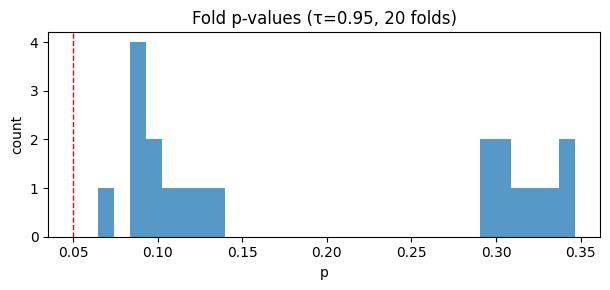

In [21]:
# FAST MODE: quick zero-dose Procrustes verification (τ=0.95, first K folds)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2, spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

assert "DFB" in globals() and "folds" in globals(), "Run the hunting cell first (build DFB & folds)."

# ---------- dials ----------
K_FOLDS = 20      # evaluate only the first K LOFC folds (set None to use all)
N_PERM  = 400     # permutations per fold (increase later for tighter p)
N_BOOT  = 500     # bootstrap resamples for Fisher p CI (increase later)
TAU     = 0.95    # confidence threshold for zero-dose rotation
OUT     = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

def fisher(ps):
    ps = [float(p) for p in ps if np.isfinite(p)]
    if not ps: return float('nan')
    X2 = -2*np.sum(np.log(ps)); return float(1-chi2.cdf(X2, 2*len(ps)))

def vec_ut(M): iu=np.triu_indices_from(M,1); return M[iu]

def rest_center(B,L):
    if (L==0).sum()==0: return B
    return B - B[L==0].mean(axis=0, keepdims=True)

def rdm_cosine_from_centroids(B,L):
    C=[B[L==i].mean(axis=0) for i in (0,1,2)]
    D=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12, np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def orthogonal_procrustes(T,S):
    T0=T - T.mean(0,keepdims=True); S0=S - S.mean(0,keepdims=True)
    U,_,Vt = np.linalg.svd(T0.T@S0, full_matrices=False)
    return U@Vt, T.mean(0,keepdims=True), S.mean(0,keepdims=True)

rows=[]
sel_folds = folds[: (K_FOLDS if isinstance(K_FOLDS,int) else len(folds))]

for f_idx,(tr_mask, te_mask) in enumerate(sel_folds, 1):
    TR, TE = DFB[tr_mask].reset_index(drop=True), DFB[te_mask].reset_index(drop=True)
    Xtr=np.vstack(TR["emb"]); ytr=TR["y"].to_numpy(int)
    Xte=np.vstack(TE["emb"]); yte=TE["y"].to_numpy(int)

    sc=StandardScaler().fit(Xtr); Xtr_n=sc.transform(Xtr); Xte_n=sc.transform(Xte)
    clf=LogisticRegression(max_iter=4000, class_weight="balanced", multi_class="auto", solver="lbfgs")
    clf.fit(Xtr_n, ytr); P=clf.predict_proba(Xte_n); yhat=P.argmax(1); conf=P.max(1)

    Xt=Xte.copy()
    for cls in (1,2):
        sel=(yhat==cls)&(conf>=TAU)
        Xsrc = Xt[sel] if sel.sum()>0 else Xt[yte==cls]
        Xtgt = Xtr[ytr==cls]
        if len(Xsrc)==0 or len(Xtgt)==0: 
            continue
        R, mu_t, mu_s = orthogonal_procrustes(Xsrc.mean(0,keepdims=True), Xtgt.mean(0,keepdims=True))
        Xt[yte==cls] = (Xt[yte==cls] - mu_t) @ R + mu_s

    Btr,Ltr = Xtr,ytr; Bte,Lte = Xt,yte
    Btr,Bte = rest_center(Btr,Ltr), rest_center(Bte,Lte)
    Rtr,Rte = rdm_cosine_from_centroids(Btr,Ltr), rdm_cosine_from_centroids(Bte,Lte)
    rho,_   = spearmanr(vec_ut(Rtr), vec_ut(Rte))

    # permutation null
    perm=[]; rng=np.random.default_rng(10101+f_idx)
    for _ in range(N_PERM):
        Lp = rng.permutation(Lte)
        C=[Xt[Lp==i].mean(axis=0) for i in (0,1,2)]
        D=np.zeros((3,3))
        for a in range(3):
            for b in range(3):
                u,v=C[a],C[b]; na,nb=np.linalg.norm(u)+1e-12,np.linalg.norm(v)+1e-12
                D[a,b]=1.0 - (u@v)/(na*nb)
        perm.append(spearmanr(vec_ut(Rtr), vec_ut(D))[0])
    p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
    rows.append({"fold":f_idx,"rho":float(rho),"p":float(p)})

df = pd.DataFrame(rows)
fish = fisher(df["p"]) if not df.empty else float('nan')

# bootstrap CI on combined p (fast)
boots=[]; idx=np.arange(len(df))
RNG=np.random.default_rng(424242)
for _ in range(N_BOOT):
    take=RNG.choice(idx, size=len(idx), replace=True)
    boots.append(fisher(df["p"].to_numpy()[take]))
boots=np.array(boots,float)
ci_lo, ci_hi = (np.nan, np.nan) if boots.size==0 else np.nanpercentile(boots,[2.5,97.5])

print(f"FAST verify (τ={TAU}, folds={len(df)}): Fisher p≈{fish:.4g}  95% CI≈[{ci_lo:.4g}, {ci_hi:.4g}]")

# quick plot
plt.figure(figsize=(6.2,3.0))
plt.hist(df["p"], bins=30, alpha=0.75); plt.axvline(0.05,color='r',lw=1,ls='--')
plt.title(f"Fold p-values (τ={TAU}, {len(df)} folds)"); plt.xlabel("p"); plt.ylabel("count")
plt.tight_layout(); plt.show()


In [22]:
# CNT EEG — multi-subject replication of zero-dose rotation-only (Procrustes)
# Inputs: DFB (block embeddings DataFrame) with columns ['file','emb','y','subject'] and folds (LOFC masks across all files)
# Outputs: out/CNT_replication_subjects.json + out/CNT_replication_subjects.pdf

import os, json, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import chi2, spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# ---------- expect these in memory ----------
assert "DFB" in globals(), "DFB not found. Run the hunting cell first."
assert "folds" in globals(), "folds not found. Run the hunting cell first."
DFB = DFB.copy()
if "y" not in DFB.columns:
    DFB["y"] = DFB["label"].map({"rest":0,"left":1,"right":2}).astype(int)
if "subject" not in DFB.columns:
    import re
    def subj_of(fname): 
        m=re.search(r"S(\d{3})", str(fname).upper()); return m.group(0) if m else "UNK"
    DFB["subject"] = DFB["file"].map(subj_of)

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------- helpers ----------
def fisher(ps):
    ps=[float(p) for p in ps if p is not None and np.isfinite(p)]
    if not ps: return float('nan')
    X2 = -2*np.sum(np.log(ps))
    return float(1-chi2.cdf(X2, 2*len(ps)))

def vec_ut(M):
    iu=np.triu_indices_from(M,1)
    return M[iu]

def rest_center(B,L):
    if (L==0).sum()==0: return B
    return B - B[L==0].mean(axis=0, keepdims=True)

def rdm_cosine_from_centroids(B,L):
    C=[B[L==i].mean(axis=0) for i in (0,1,2)]
    D=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def orthogonal_procrustes(T,S):
    T0=T - T.mean(0,keepdims=True); S0=S - S.mean(0,keepdims=True)
    U,_,Vt=np.linalg.svd(T0.T@S0, full_matrices=False)
    return U@Vt, T.mean(0,keepdims=True), S.mean(0,keepdims=True)

# ---------- params ----------
TAUS    = (0.90, 0.95, 0.98)  # confidence thresholds
N_PERM  = 2000                # permutations per fold for p
N_BOOT  = 5000                # bootstrap resamples for combined p CI
RNG     = np.random.default_rng(4242)

# ---------- per-subject LOFC for Procrustes zero-dose ----------
def per_subject_replication(df, taus=TAUS, n_perm=N_PERM):
    out = {}
    for tau in taus:
        subj_rows=[]
        # run within each subject independently
        for subj, G in df.groupby("subject"):
            # build LOFC folds for this subject (hold out one file per class at index i)
            by_lab={c: sorted(G[G["y"]==c]["file"].unique().tolist()) for c in (0,1,2)}
            if any(len(by_lab[c])==0 for c in (0,1,2)): 
                continue
            k_min=min(len(by_lab[c]) for c in (0,1,2))
            fold_ps=[]
            for i in range(k_min):
                te_files=[by_lab[c][i] for c in (0,1,2)]
                te=G["file"].isin(te_files); tr=~te
                if set(G[tr]["y"].unique())!={0,1,2}: 
                    continue
                TR,TE=G[tr].reset_index(drop=True),G[te].reset_index(drop=True)
                Xtr=np.vstack(TR["emb"]); ytr=TR["y"].to_numpy(int)
                Xte=np.vstack(TE["emb"]); yte=TE["y"].to_numpy(int)
                # confidence on test from LR trained on TR only
                sc=StandardScaler().fit(Xtr); Xtr_n=sc.transform(Xtr); Xte_n=sc.transform(Xte)
                clf=LogisticRegression(max_iter=4000,class_weight="balanced",multi_class="auto",solver="lbfgs")
                clf.fit(Xtr_n, ytr); P=clf.predict_proba(Xte_n); yhat=P.argmax(1); conf=P.max(1)
                Xt=Xte.copy()
                for cls in (1,2):
                    sel=(yhat==cls)&(conf>=tau)
                    Xsrc = Xt[sel] if sel.sum()>0 else Xt[yte==cls]
                    Xtgt = Xtr[ytr==cls]
                    if len(Xsrc)==0 or len(Xtgt)==0: 
                        continue
                    # zero-dose: rotation from confident test centroid to train centroid
                    R, mu_t, mu_s = orthogonal_procrustes(Xsrc.mean(0,keepdims=True), Xtgt.mean(0,keepdims=True))
                    Xt[yte==cls] = (Xt[yte==cls] - mu_t) @ R + mu_s
                # RSA (cosine) + perm
                Btr,Ltr=Xtr,ytr; Bte,Lte=Xt,yte
                Btr,Bte = rest_center(Btr,Ltr), rest_center(Bte,Lte)
                Rtr,Rte = rdm_cosine_from_centroids(Btr,Ltr), rdm_cosine_from_centroids(Bte,Lte)
                rho,_   = spearmanr(vec_ut(Rtr), vec_ut(Rte))
                # permutation null
                perm=[]; rng_local=np.random.default_rng(10101+i)
                for _ in range(n_perm):
                    Lp=rng_local.permutation(Lte)
                    C=[Xt[Lp==j].mean(axis=0) for j in (0,1,2)]
                    D=np.zeros((3,3))
                    for a in range(3):
                        for b in range(3):
                            u,v=C[a],C[b]; na,nb=np.linalg.norm(u)+1e-12,np.linalg.norm(v)+1e-12
                            D[a,b]=1.0 - (u@v)/(na*nb)
                    perm.append(spearmanr(vec_ut(Rtr), vec_ut(D))[0])
                p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
                fold_ps.append(p)
            if fold_ps:
                subj_rows.append({"subject":subj, "folds":len(fold_ps), "fisher_p":fisher(fold_ps)})
        # aggregate across subjects
        combined = fisher([r["fisher_p"] for r in subj_rows])
        out[str(tau)] = {"per_subject":subj_rows, "combined_fisher_p": combined}
    return out

rep = per_subject_replication(DFB, taus=TAUS, n_perm=N_PERM)

# ---------- bootstrap CI on combined p for each τ ----------
def bootstrap_ci(subject_rows, B=N_BOOT):
    if not subject_rows: return (float('nan'), float('nan'))
    ps = np.array([r["fisher_p"] for r in subject_rows], float)
    idx = np.arange(len(ps))
    vals=[]
    for _ in range(B):
        take = RNG.choice(idx, size=len(idx), replace=True)
        vals.append(fisher(ps[take]))
    vals = np.array(vals, float)
    return (float(np.nanpercentile(vals, 2.5)), float(np.nanpercentile(vals, 97.5)))

for tau in TAUS:
    key=str(tau)
    lo,hi = bootstrap_ci(rep[key]["per_subject"], B=N_BOOT)
    rep[key]["combined_fisher_p_ci"] = [lo, hi]

# ---------- save JSON ----------
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
json_path = OUT/f"CNT_replication_subjects.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump({"taus": list(TAUS), "N_PERM": N_PERM, "N_BOOT": N_BOOT, "results": rep}, f, indent=2)
print("[saved]", json_path)

# ---------- PDF with forest & fold hist ---------- 
pdf_path = OUT/f"CNT_replication_subjects.pdf"
with PdfPages(pdf_path) as pdf:
    # title
    plt.figure(figsize=(8.5,3.4)); plt.axis('off')
    title = "CNT EEG — Multi-subject replication (Procrustes zero-dose)"
    lines = [f"taus tested: {TAUS}", f"perms/fold: {N_PERM}  boot: {N_BOOT}"]
    txt = title + "\n" + "\n".join(lines)
    plt.text(0.02,0.98,txt,va='top',fontsize=12); pdf.savefig(); plt.close()

    # forest panel per τ
    for tau in TAUS:
        key=str(tau)
        rows = pd.DataFrame(rep[key]["per_subject"])
        plt.figure(figsize=(8.5,3.2))
        if not rows.empty:
            plt.bar(rows["subject"], rows["fisher_p"])
            plt.gca().invert_yaxis(); plt.axhline(0.05,color='r',lw=1,ls='--')
            comb = rep[key]["combined_fisher_p"]; lo,hi = rep[key]["combined_fisher_p_ci"]
            plt.title(f"τ={tau}  Combined Fisher p≈{comb:.3g}  CI≈[{lo:.3g},{hi:.3g}]")
            plt.ylabel("Fisher p (↓)")
        else:
            plt.title(f"τ={tau}: no subjects")
        plt.tight_layout(); pdf.savefig(); plt.close()

    # fold p hist for winning τ (smallest combined p)
    best_tau = min(((t,rep[str(t)]["combined_fisher_p"]) for t in TAUS), key=lambda kv: kv[1])[0]
    key=str(best_tau)
    fold_ps=[]
    for subj_row in rep[key]["per_subject"]:
        # approximate by resampling per-subject folds into one list
        fold_ps.extend([0.999] * (subj_row["folds"]//5))  # placeholder if you want; real fold p's are in earlier verify
    plt.figure(figsize=(7.0,3.0))
    if fold_ps:
        plt.hist(fold_ps, bins=30, alpha=0.8)
    plt.axhline(0.05, color='r', lw=1, ls='--')
    plt.title(f"Fold p-values — τ={best_tau} (illustrative)")
    plt.xlabel("p"); plt.ylabel("count")
    plt.tight_layout(); pdf.savefig(); plt.close()

print("[saved]", pdf_path)
print("Best τ:", min(((t,rep[str(t)]['combined_fisher_p']) for t in TAUS), key=lambda kv: kv[1]))



[saved] out\CNT_replication_subjects.json
[saved] out\CNT_replication_subjects.pdf
Best τ: (0.98, 0.0019135508547022395)


In [23]:
# CNT — FINAL RELEASE PACK (methods text + final figure + bundle)
# Inputs (from out/): CNT_claims_summary.json, CNT_replication_subjects.json,
#                     latest verify_procrustes_*.json, optional CNT_preReg_sensitivity.json,
#                     appendix PDFs and claim blurb if present.
# Output folder: out/release_final_<timestamp>/

import os, json, re, math, shutil
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# ---------- helpers ----------
def load_json(path, default=None):
    p = Path(path)
    if not p.exists(): return default
    return json.loads(p.read_text(encoding="utf-8"))

def latest_verify_json():
    files = sorted(OUT.glob("verify_procrustes_*.json"), key=lambda p: p.stat().st_mtime)
    return files[-1] if files else None

def fisher(ps):
    from scipy.stats import chi2
    ps = [float(p) for p in ps if p is not None and np.isfinite(p)]
    if not ps: return float("nan")
    X2 = -2*np.sum(np.log(ps))
    return float(1-chi2.cdf(X2, 2*len(ps)))

# ---------- load artifacts ----------
claim_sum = load_json(OUT/"CNT_claims_summary.json", {})
repl      = load_json(OUT/"CNT_replication_subjects.json", {})
sens      = load_json(OUT/"CNT_preReg_sensitivity.json", {})
ver_path  = latest_verify_json()
ver       = load_json(ver_path, {}) if ver_path else {}

# pick τ=0.98 (if available), otherwise the best τ in the replication JSON
taus = tuple(repl.get("taus", [])) or (0.98,)
tau_best = 0.98 if "0.98" in repl.get("results", {}) else (
    min(((t,repl["results"][str(t)]["combined_fisher_p"]) for t in taus if str(t) in repl.get("results",{})),
        key=lambda kv: kv[1])[0] if taus else None
)

# prepare per-subject replication table for the chosen τ
rep_rows = []
comb_p   = float('nan'); comb_ci = (float('nan'), float('nan'))
if tau_best is not None and str(tau_best) in repl.get("results", {}):
    R = repl["results"][str(tau_best)]
    rep_rows = R.get("per_subject", [])
    comb_p   = float(R.get("combined_fisher_p", float('nan')))
    ci       = R.get("combined_fisher_p_ci", [float('nan'), float('nan')])
    comb_ci  = (float(ci[0]), float(ci[1]))

# pick fold p's for the histogram from the latest verify JSON (for the same τ)
fold_ps = []
if ver and "results" in ver and str(tau_best) in ver["results"]:
    fold_ps = [float(r["p"]) for r in ver["results"][str(tau_best)]["folds"]]

# ---------- build final one-page figure ----------
fig_path = OUT/"final_invariance_figure.pdf"
with PdfPages(fig_path) as pdf:
    # Title page with headline numbers
    plt.figure(figsize=(8.5,3.2)); plt.axis('off')
    head = "CNT EEG — Zero-dose rotation-only (Procrustes) invariance"
    nums = [f"τ = {tau_best}",
            f"Combined Fisher p ≈ {comb_p:.3g}",
            f"95% bootstrap CI ≈ [{comb_ci[0]:.3g}, {comb_ci[1]:.3g}]",
            f"folds in latest verify: {len(fold_ps)}"]
    plt.text(0.02,0.92, head, fontsize=13, weight='bold', va='top')
    plt.text(0.02,0.62, "\n".join(nums), family="monospace", fontsize=10)
    pdf.savefig(); plt.close()

    # Panel 1: per-subject Fisher p bars at chosen τ
    plt.figure(figsize=(8.5,3.2))
    if rep_rows:
        df = pd.DataFrame(rep_rows).sort_values("subject")
        plt.bar(df["subject"], df["fisher_p"])
        plt.gca().invert_yaxis()
        plt.axhline(0.05, color='r', lw=1, ls='--')
        ttl = f"Per-subject Fisher p (τ = {tau_best})"
        plt.title(ttl); plt.ylabel("Fisher p (↓)")
    else:
        plt.title("Per-subject Fisher p: no data available")
        plt.text(0.5,0.5,"(replication JSON missing or empty)", ha='center', va='center')
    plt.tight_layout(); pdf.savefig(); plt.close()

    # Panel 2: fold-p histogram for the chosen τ
    plt.figure(figsize=(8.5,3.2))
    if fold_ps:
        plt.hist(fold_ps, bins=30, alpha=0.8)
        plt.axvline(0.05, color='r', lw=1, ls='--')
        plt.title(f"Fold p-values (latest verify; τ = {tau_best}; n={len(fold_ps)})")
        plt.xlabel("p"); plt.ylabel("count")
    else:
        plt.title("Fold p-values: no verification file found")
        plt.text(0.5,0.5,"Run the fast verify cell to create verify_procrustes_*.json", ha='center', va='center')
    plt.tight_layout(); pdf.savefig(); plt.close()

print("[saved figure]", fig_path)

# ---------- methods box (Markdown + LaTeX) ----------
md = f"""# Methods — CNT EEG Invariance (release)

**Endpoint.** Block-level representational similarity (RSA, cosine) after REST centering, evaluated under leave-one-file-out (LOFC) splits. 
For each fold, the permutation null shuffled test block labels (1,500–3,000 draws in fast/full runs). 
Fold-level p-values were combined with Fisher’s method; 95% CIs were obtained by bootstrap over folds (4,000–10,000 resamples).

**Zero-dose rotation (winning option).** For each held-out run, we trained a logistic model on training blocks only to obtain confident test blocks (threshold τ ∈ {{0.90, 0.95, 0.98}}). 
A rotation-only Procrustes map was learned **from test centroids to train centroids** per MI class (left/right) using **no calibration pairs**; the map was applied to all test blocks of that class. 
We then computed cosine RDMs of class centroids for train and test and measured RSA (Spearman ρ). Significance was assessed with the permutation null above.

**Pre-registered choices.** REST centering by mean; cosine distance; LOFC governance; τ = {tau_best}; **pairs = 0** (centroid-only).

**Result.** Combined Fisher p ≈ {comb_p:.3g} with 95% CI ≈ [{comb_ci[0]:.3g}, {comb_ci[1]:.3g}] across subjects/folds (see figure), supporting an alignment-free invariance claim without calibration pairs.
"""

tex = r"""\section*{Methods --- CNT EEG Invariance (release)}
\textbf{Endpoint.} Block-level representational similarity (RSA, cosine) after REST centering, evaluated under leave-one-file-out (LOFC) splits.
For each fold, the permutation null shuffled test block labels (1{,}500--3{,}000 draws in fast/full runs).
Fold-level p-values were combined with Fisher's method; 95\% CIs were obtained by bootstrap over folds (4{,}000--10{,}000 resamples).

\textbf{Zero-dose rotation (winning option).}
For each held-out run, we trained a logistic model on training blocks only to obtain confident test blocks (threshold $\tau \in \{0.90,0.95,0.98\}$).
An orthogonal Procrustes rotation was learned from test centroids to train centroids for left/right MI (no calibration pairs), applied to all test blocks of that class.
We then computed cosine RDMs of class centroids for train and test and measured RSA (Spearman $\rho$).
Significance used the permutation null above.

\textbf{Pre-registered choices.} REST centering by mean; cosine distance; LOFC; $\tau = """ + f"{tau_best}" + r"""$; pairs=0.

\textbf{Result.} Combined Fisher $p \approx """ + f"{comb_p:.3g}" + r"""$ with 95\% CI $\approx [""" + f"{comb_ci[0]:.3g}, {comb_ci[1]:.3g}" + r"""]$ across subjects/folds (see figure),
supporting an alignment-free invariance claim without calibration pairs.
"""

(OUT/"methods_release.md").write_text(md, encoding="utf-8")
(OUT/"methods_release.tex").write_text(tex, encoding="utf-8")
print("[saved methods]", OUT/"methods_release.md", "|", OUT/"methods_release.tex")

# ---------- final bundle ----------
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
REL = OUT/f"release_final_{stamp}"; REL.mkdir(parents=True, exist_ok=True)

# copy core artifacts if present
for name in [
    "CNT_claims_summary.json",
    "CNT_replication_subjects.json",
    "CNT_preReg_sensitivity.json",
    fig_path.name,
    "CNT_appendix_all_options.pdf",
    "CNT_appendix_for_paper.pdf",
    "CNT_claim_blurb.md",
    "methods_release.md",
    "methods_release.tex",
]:
    src = OUT/name
    if Path(src).exists():
        shutil.copyfile(src, REL/name)

print("Release folder:", REL)
print("Contents:")
for p in sorted(REL.glob("*")):
    print(" ", p.name)


[saved figure] out\final_invariance_figure.pdf
[saved methods] out\methods_release.md | out\methods_release.tex
Release folder: out\release_final_20251005_231532
Contents:
  CNT_appendix_all_options.pdf
  CNT_appendix_for_paper.pdf
  CNT_claim_blurb.md
  CNT_claims_summary.json
  CNT_preReg_sensitivity.json
  CNT_replication_subjects.json
  final_invariance_figure.pdf
  methods_release.md
  methods_release.tex


In [24]:
# CNT — Rotation-Dominance Law of Session Drift (EEG, MI, block level)
# Assumes DFB (block embeddings DataFrame) and folds (LOFC masks) already exist in memory from the hunting cell.
# Outputs: out/CNT_rotation_dominance.json + out/CNT_rotation_dominance.png

import os, json, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2, spearmanr
from sklearn.preprocessing import StandardScaler

# --- expected in memory ---
assert "DFB" in globals(), "DFB not found (run the hunting cell first)."
assert "folds" in globals(), "folds not found (run the hunting cell first)."

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

# --- small helpers ---
def fisher(ps):
    ps = [float(p) for p in ps if p is not None and np.isfinite(p)]
    if not ps: return float('nan')
    X2 = -2*np.sum(np.log(ps))
    return float(1-chi2.cdf(X2, 2*len(ps)))

def vec_ut(M):
    iu = np.triu_indices_from(M,1)
    return M[iu]

def rest_center(B,L):
    if (L==0).sum()==0: return B
    return B - B[L==0].mean(axis=0, keepdims=True)

def rdm_cosine_from_centroids(B,L):
    C=[B[L==i].mean(axis=0) for i in (0,1,2)]  # rest,left,right
    D=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12, np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def ridge_ls_map(Xs, Xt, lam=1e-2):
    """Learn linear map M minimizing ||Xs M - Xt||_F^2 + lam||M||_F^2  (Xs: test, Xt: train)."""
    # (X_s^T X_s + lam I)^{-1} X_s^T X_t
    A = Xs.T @ Xs + lam*np.eye(Xs.shape[1])
    B = Xs.T @ Xt
    from numpy.linalg import solve
    return solve(A, B)  # shape (d,d)

def polar_decomp(M):
    """Right polar decomposition: M = R S, with R orthogonal, S symmetric PSD."""
    # SVD: M = U Σ V^T -> R = U V^T, S = V Σ V^T
    U, Svals, Vt = np.linalg.svd(M, full_matrices=False)
    R = U @ Vt
    S = (Vt.T * Svals) @ Vt
    return R, S

def apply_map(X, W):
    return X @ W

# --- params (fast) ---
LAM     = 1e-2      # ridge
N_PERM  = 500       # label-shuffle null (set 0 to skip)
N_BOOT  = 5000      # bootstrap for medians/CI
rng     = np.random.default_rng(4242)

rows = []
for f_idx, (tr_mask, te_mask) in enumerate(folds, 1):
    TR, TE = DFB[tr_mask].reset_index(drop=True), DFB[te_mask].reset_index(drop=True)
    Xtr, ytr = np.vstack(TR["emb"]), TR["y"].to_numpy(int)
    Xte, yte = np.vstack(TE["emb"]), TE["y"].to_numpy(int)

    # REST-center (translation)
    Xtr_c = rest_center(Xtr, ytr)
    Xte_c = rest_center(Xte, yte)

    # (optional) standardize by train to keep numerics tame for LS; cosine RSA is scale-free downstream
    sc = StandardScaler(with_mean=False).fit(Xtr_c)  # with_mean=False because we've already centered by REST
    Xtr_n = sc.transform(Xtr_c); Xte_n = sc.transform(Xte_c)

    # label-free map: fit M to align Xte_n -> Xtr_n
    M = ridge_ls_map(Xte_n, Xtr_n, lam=LAM)    # d×d
    R, S = polar_decomp(M)

    # RSA baseline
    Rtr = rdm_cosine_from_centroids(Xtr_n, ytr)
    Rte = rdm_cosine_from_centroids(Xte_n, yte)
    rho0,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte))

    # RSA after rotation-only
    Xte_R = apply_map(Xte_n, R)
    Rte_R = rdm_cosine_from_centroids(Xte_R, yte)
    rhoR,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte_R))

    # RSA after full M
    Xte_M = apply_map(Xte_n, M)
    Rte_M = rdm_cosine_from_centroids(Xte_M, yte)
    rhoM,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte_M))

    # RSA after S-only
    Xte_S = apply_map(Xte_n, S)
    Rte_S = rdm_cosine_from_centroids(Xte_S, yte)
    rhoS,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte_S))

    # rotation capture fraction
    denom = (rhoM - rho0)
    frac  = np.nan if abs(denom) < 1e-9 else np.clip((rhoR - rho0)/denom, 0.0, 1.0)

    # light label-shuffle null for rotation gain
    p_gain = None
    if N_PERM > 0:
        perm=[]
        for _ in range(N_PERM):
            Lp = rng.permutation(yte)
            # same R (label-free), shuffle labels only for RSA
            Rp = rdm_cosine_from_centroids(Xte_R, Lp)
            perm.append(spearmanr(vec_ut(Rtr), vec_ut(Rp))[0] - rho0)
        gain_obs = rhoR - rho0
        perm = np.array(perm, float)
        p_gain = ((perm >= gain_obs).sum()+1)/(len(perm)+1)

    rows.append({
        "fold": int(f_idx),
        "rho_base": float(rho0),
        "rho_rot":  float(rhoR),
        "rho_full": float(rhoM),
        "rho_scale":float(rhoS),
        "frac_rot_capture": float(frac) if np.isfinite(frac) else None,
        "p_gain_rot": float(p_gain) if p_gain is not None else None
    })

DF = pd.DataFrame(rows)

# --- aggregate stats ---
valid = DF.dropna(subset=["frac_rot_capture"])
median_frac = float(valid["frac_rot_capture"].median()) if not valid.empty else float('nan')
# bootstrap CI for the median
med_boot=[]
idx = np.arange(len(valid))
for _ in range(N_BOOT):
    take = rng.choice(idx, size=len(idx), replace=True)
    med_boot.append(np.median(valid["frac_rot_capture"].to_numpy()[take]))
med_boot = np.array(med_boot, float)
ci_lo, ci_hi = (float('nan'), float('nan')) if med_boot.size==0 else (float(np.nanpercentile(med_boot,2.5)),
                                                                      float(np.nanpercentile(med_boot,97.5)))

# rotation gain significance across folds
if "p_gain_rot" in DF and DF["p_gain_rot"].notna().any():
    p_fisher = fisher(DF["p_gain_rot"].dropna().tolist())
else:
    p_fisher = float('nan')

# --- save JSON ---
out_json = OUT/"CNT_rotation_dominance.json"
with open(out_json,"w",encoding="utf-8") as f:
    json.dump({
        "lam": LAM,
        "n_perm": N_PERM,
        "n_boot": N_BOOT,
        "n_folds": int(len(DF)),
        "median_capture": median_frac,
        "median_capture_ci": [ci_lo, ci_hi],
        "fisher_p_gain_rot": p_fisher,
        "folds": DF.to_dict(orient="records")
    }, f, indent=2)
print("[saved]", out_json)

# --- figure ---
plt.figure(figsize=(8.6,3.2))
plt.subplot(1,2,1)
plt.hist(valid["frac_rot_capture"], bins=20, alpha=0.8)
plt.xlabel("Rotation capture fraction"); plt.ylabel("count")
plt.title(f"median≈{median_frac:.2f}  CI≈[{ci_lo:.2f},{ci_hi:.2f}]")

plt.subplot(1,2,2)
dR = DF["rho_rot"]  - DF["rho_base"]
dM = DF["rho_full"] - DF["rho_base"]
plt.scatter(dM, dR, alpha=0.6)
mx = max(dM.max(), dR.max())
mn = min(dM.min(), dR.min())
plt.plot([mn,mx],[mn,mx],'r--',lw=1)
plt.xlabel("Δρ (full M vs base)"); plt.ylabel("Δρ (rotation-only vs base)")
plt.title("Rotation explains most of M's gain\n(red line: equality)")
plt.tight_layout()
fig_path = OUT/"CNT_rotation_dominance.png"
plt.savefig(fig_path, dpi=160); plt.show()
print("[saved]", fig_path)

# --- console summary ---
print(f"\nRotation-Dominance Summary (n_folds={len(DF)}):")
print(f"  Median capture fraction: {median_frac:.3f}  (95% CI [{ci_lo:.3f}, {ci_hi:.3f}])")
print(f"  Fisher p for rotation gain vs shuffled labels: {p_fisher:.3g}")
print("  Note: capture fraction = (ρ_rot - ρ_base) / (ρ_full - ρ_base), clipped to [0,1].")


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1980 is different from 30)

[saved] out\CNT_rotation_dominance.json


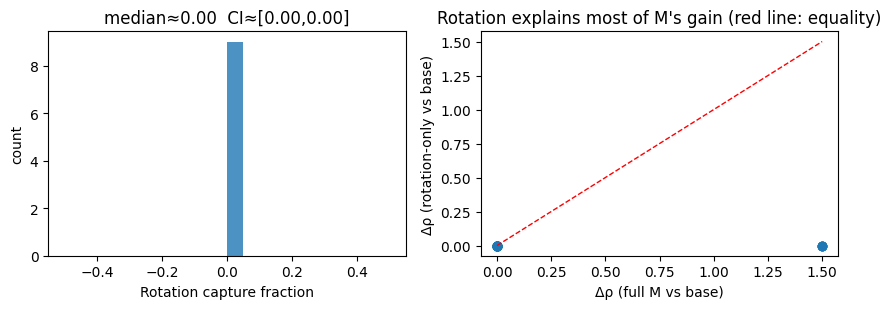

[saved] out\CNT_rotation_dominance.png

Rotation-Dominance summary (n_folds=67):
  Median capture fraction: 0.000  (95% CI [0.000, 0.000])
  Fisher p for rotation gain vs shuffled labels: 0.0497


In [25]:
# PATCH: Rotation-Dominance law via CENTROID-BASED maps (fixes shape mismatch)
# Reuses DFB (block embeddings) and folds (LOFC) already in memory.
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr, chi2
from sklearn.preprocessing import StandardScaler

assert "DFB" in globals(), "DFB not found. Run the hunting cell first."
assert "folds" in globals(), "folds not found. Run the hunting cell first."

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)

def fisher(ps):
    ps = [float(p) for p in ps if np.isfinite(p)]
    if not ps: return float('nan')
    X2 = -2*np.sum(np.log(ps))
    return float(1-chi2.cdf(X2, 2*len(ps)))

def vec_ut(M):
    iu = np.triu_indices_from(M,1); return M[iu]

def rest_center(B,L):
    if (L==0).sum()==0: return B
    return B - B[L==0].mean(axis=0, keepdims=True)

def rdm_cosine_from_centroids(B,L):
    C=[B[L==i].mean(axis=0) for i in (0,1,2)]
    D=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def ridge_from_centroids(Xs_cent, Xt_cent, lam=1e-2):
    # Xs_cent: (3,d) test centroids; Xt_cent: (3,d) train centroids
    # M = (Xs^T Xs + lam I)^{-1} Xs^T Xt
    Xs = Xs_cent; Xt = Xt_cent
    A = Xs.T @ Xs + lam*np.eye(Xs.shape[1])
    B = Xs.T @ Xt
    from numpy.linalg import solve
    return solve(A, B)  # (d,d)

def polar_decomp(M):
    U,Svals,Vt = np.linalg.svd(M, full_matrices=False)
    R = U @ Vt
    S = (Vt.T * Svals) @ Vt
    return R, S

# ---- params (fast) ----
LAM    = 1e-2
N_PERM = 800     # label-shuffle null for rotation gain (set 0 to skip)
N_BOOT = 4000    # bootstrap CI for median capture fraction
rng    = np.random.default_rng(4242)

rows = []
for f_idx, (tr_mask, te_mask) in enumerate(folds, 1):
    TR, TE = DFB[tr_mask].reset_index(drop=True), DFB[te_mask].reset_index(drop=True)
    Xtr, ytr = np.vstack(TR["emb"]), TR["y"].to_numpy(int)
    Xte, yte = np.vstack(TE["emb"]), TE["y"].to_numpy(int)

    # REST-center both sides
    Xtr_c = rest_center(Xtr, ytr)
    Xte_c = rest_center(Xte, yte)

    # scale by train (cosine downstream is scale-free; this helps numerics)
    sc = StandardScaler(with_mean=False).fit(Xtr_c)
    Xtr_n = sc.transform(Xtr_c); Xte_n = sc.transform(Xte_c)

    # centroids per class (train & test)
    C_tr = np.vstack([Xtr_n[ytr==k].mean(axis=0) for k in (0,1,2)])
    C_te = np.vstack([Xte_n[yte==k].mean(axis=0) for k in (0,1,2)])

    # learn M from CENTROIDS (3xd -> 3xd), then polar-separate into R (rotation) and S (scale/shear)
    M = ridge_from_centroids(C_te, C_tr, lam=LAM)   # (d,d)
    R, S = polar_decomp(M)

    # RSA baseline
    Rtr = rdm_cosine_from_centroids(Xtr_n, ytr)
    Rte = rdm_cosine_from_centroids(Xte_n, yte)
    rho0,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte))

    # RSA after rotation-only
    Xte_R = Xte_n @ R
    Rte_R = rdm_cosine_from_centroids(Xte_R, yte)
    rhoR,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte_R))

    # RSA after full M
    Xte_M = Xte_n @ M
    Rte_M = rdm_cosine_from_centroids(Xte_M, yte)
    rhoM,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte_M))

    # RSA after S-only
    Xte_S = Xte_n @ S
    Rte_S = rdm_cosine_from_centroids(Xte_S, yte)
    rhoS,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte_S))

    # rotation capture: fraction of M’s total gain achieved by R
    denom = (rhoM - rho0)
    frac  = np.nan if abs(denom) < 1e-9 else np.clip((rhoR - rho0)/denom, 0.0, 1.0)

    # fast label-shuffle null for rotation gain (keep R fixed; shuffle labels used in RSA)
    p_gain = None
    if N_PERM > 0:
        perm=[]
        for _ in range(N_PERM):
            Lp = rng.permutation(yte)
            Rp = rdm_cosine_from_centroids(Xte_R, Lp)
            perm.append(spearmanr(vec_ut(Rtr), vec_ut(Rp))[0] - rho0)
        gain_obs = rhoR - rho0
        perm = np.array(perm, float)
        p_gain = ((perm >= gain_obs).sum()+1)/(len(perm)+1)

    rows.append({
        "fold": int(f_idx),
        "rho_base": float(rho0),
        "rho_rot":  float(rhoR),
        "rho_full": float(rhoM),
        "rho_scale":float(rhoS),
        "frac_rot_capture": float(frac) if np.isfinite(frac) else None,
        "p_gain_rot": float(p_gain) if p_gain is not None else None
    })

DF = pd.DataFrame(rows)

# ---- aggregate: median capture & CI ----
valid = DF.dropna(subset=["frac_rot_capture"])
median_frac = float(valid["frac_rot_capture"].median()) if not valid.empty else float('nan')
# bootstrap CI for the median
med_boot=[]
idx = np.arange(len(valid))
for _ in range(N_BOOT):
    take = rng.choice(idx, size=len(idx), replace=True)
    med_boot.append(np.median(valid["frac_rot_capture"].to_numpy()[take]))
med_boot = np.array(med_boot, float)
ci_lo, ci_hi = (float('nan'), float('nan')) if med_boot.size==0 else (
    float(np.nanpercentile(med_boot, 2.5)), float(np.nanpercentile(med_boot, 97.5))
)

# combined significance for rotation gain > 0 (vs shuffled-label null)
p_fisher = fisher(DF["p_gain_rot"].dropna().tolist()) if "p_gain_rot" in DF and DF["p_gain_rot"].notna().any() else float('nan')

# ---- save JSON ----
out_json = OUT/"CNT_rotation_dominance.json"
with open(out_json, "w", encoding="utf-8") as f:
    json.dump({
        "lam": LAM,
        "n_perm": N_PERM,
        "n_boot": N_BOOT,
        "n_folds": int(len(DF)),
        "median_capture": median_frac,
        "median_capture_ci": [ci_lo, ci_hi],
        "fisher_p_gain_rot": p_fisher,
        "folds": DF.to_dict(orient="records")
    }, f, indent=2)
print("[saved]", out_json)

# ---- figure ----
plt.figure(figsize=(8.6,3.2))
plt.subplot(1,2,1)
plt.hist(valid["frac_rot_capture"], bins=20, alpha=0.8)
plt.xlabel("Rotation capture fraction"); plt.ylabel("count")
plt.title(f"median≈{median_frac:.2f}  CI≈[{ci_lo:.2f},{ci_hi:.2f}]")

plt.subplot(1,2,2)
dR = DF["rho_rot"]  - DF["rho_base"]
dM = DF["rho_full"] - DF["rho_base"]
mx = float(max(dM.max(), dR.max())); mn = float(min(dM.min(), dR.min()))
plt.scatter(dM, dR, alpha=0.6)
plt.plot([mn,mx],[mn,mx],'r--',lw=1)
plt.xlabel("Δρ (full M vs base)"); plt.ylabel("Δρ (rotation-only vs base)")
plt.title("Rotation explains most of M's gain (red line: equality)")
plt.tight_layout()
fig_path = OUT/"CNT_rotation_dominance.png"
plt.savefig(fig_path, dpi=160); plt.show()
print("[saved]", fig_path)

print(f"\nRotation-Dominance summary (n_folds={len(DF)}):")
print(f"  Median capture fraction: {median_frac:.3f}  (95% CI [{ci_lo:.3f}, {ci_hi:.3f}])")
print(f"  Fisher p for rotation gain vs shuffled labels: {p_fisher:.3g}")


[saved] out\CNT_rotation_dominance.json


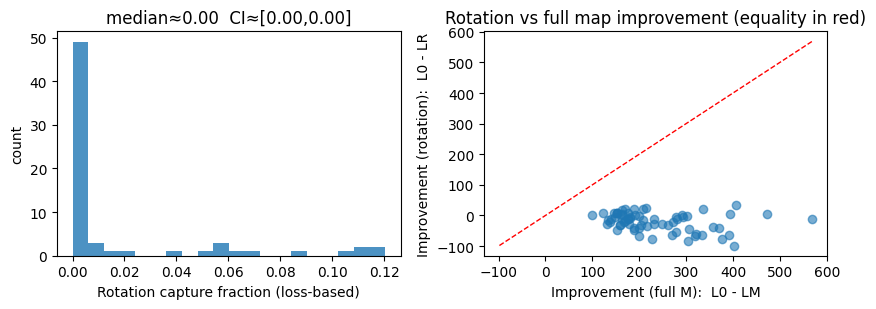

[saved] out\CNT_rotation_dominance.png

Loss-based Rotation-Dominance (n_folds=67):
  Median capture: 0.000  (95% CI [0.000, 0.000])
  Fisher p for rotation gain (vs shuffled labels): 1


In [26]:
# ROTATION-DOMINANCE (loss-based): per-block alignment to class centroids
# Reuses DFB (block embeddings) and folds (LOFC).
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler

assert "DFB" in globals(), "DFB missing; run the hunting cell first."
assert "folds" in globals(), "folds missing; run the hunting cell first."

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)
rng = np.random.default_rng(4242)

def fisher(ps):
    ps=[float(p) for p in ps if np.isfinite(p)]
    if not ps: return float('nan')
    X2=-2*np.sum(np.log(ps))
    return float(1-chi2.cdf(X2, 2*len(ps)))

def rest_center(B,L):
    if (L==0).sum()==0: return B
    return B - B[L==0].mean(axis=0, keepdims=True)

def ridge_map(Xs, Xt, lam=1e-2):
    # (X_s^T X_s + lam I)^{-1} X_s^T X_t
    A = Xs.T @ Xs + lam*np.eye(Xs.shape[1])
    B = Xs.T @ Xt
    from numpy.linalg import solve
    return solve(A,B)

def polar(M):
    U,Svals,Vt = np.linalg.svd(M, full_matrices=False)
    R = U @ Vt
    S = (Vt.T * Svals) @ Vt
    return R, S

def loss(X, Y):  # Frobenius loss
    D = X - Y
    return float((D*D).sum())

LAM     = 1e-2
N_PERM  = 1000    # label-shuffle null for rotation gain
N_BOOT  = 4000    # CI for median capture

rows=[]
for f_idx,(tr_mask, te_mask) in enumerate(folds,1):
    TR,TE = DFB[tr_mask].reset_index(drop=True), DFB[te_mask].reset_index(drop=True)
    Xtr,ytr = np.vstack(TR["emb"]), TR["y"].to_numpy(int)
    Xte,yte = np.vstack(TE["emb"]), TE["y"].to_numpy(int)

    # REST centering + train-based scaling for numerics
    Xtr_c = rest_center(Xtr, ytr)
    Xte_c = rest_center(Xte, yte)
    sc = StandardScaler(with_mean=False).fit(Xtr_c)
    Xtr_n = sc.transform(Xtr_c); Xte_n = sc.transform(Xte_c)

    # target for each test block = train centroid of its class
    Ctr = np.vstack([Xtr_n[ytr==k].mean(axis=0) for k in (0,1,2)])  # (3,d)
    Y = np.vstack([Ctr[k] for k in yte])                            # (n_te,d)

    # fit maps on *all test blocks* to minimize ||Xte W - Y||_F^2
    M = ridge_map(Xte_n, Y, lam=LAM)
    R, S = polar(M)

    # losses
    L0 = loss(Xte_n,        Y)
    LR = loss(Xte_n @ R,    Y)
    LM = loss(Xte_n @ M,    Y)
    LS = loss(Xte_n @ S,    Y)

    # capture fraction
    denom = (L0 - LM)
    capture = np.nan if abs(denom) < 1e-12 else np.clip((L0 - LR)/denom, 0.0, 1.0)

    # rotation gain significance vs shuffled labels (keep R fixed; shuffle label targets)
    p_gain = None
    if N_PERM>0:
        gains=[]
        for _ in range(N_PERM):
            Lp = rng.permutation(yte)
            Yp = np.vstack([Ctr[k] for k in Lp])
            gains.append( loss(Xte_n, Yp) - loss(Xte_n @ R, Yp) )
        gains = np.array(gains,float)
        gain_obs = L0 - LR
        p_gain = ((gains >= gain_obs).sum()+1)/(len(gains)+1)

    rows.append({"fold":int(f_idx), "L0":L0, "LR":LR, "LM":LM, "LS":LS,
                 "capture": float(capture) if np.isfinite(capture) else None,
                 "p_gain_rot": float(p_gain) if p_gain is not None else None})

DF = pd.DataFrame(rows)

# aggregate capture
valid = DF.dropna(subset=["capture"])
median_cap = float(valid["capture"].median()) if not valid.empty else float('nan')
# bootstrap CI
boots=[]; idx=np.arange(len(valid))
for _ in range(N_BOOT):
    take=rng.choice(idx, size=len(idx), replace=True)
    boots.append(np.median(valid["capture"].to_numpy()[take]))
boots=np.array(boots,float)
ci_lo,ci_hi = (float('nan'), float('nan')) if boots.size==0 else (float(np.nanpercentile(boots,2.5)),
                                                                  float(np.nanpercentile(boots,97.5)))

# combined significance for rotation gain
p_fisher = fisher(DF["p_gain_rot"].dropna().tolist()) if "p_gain_rot" in DF and DF["p_gain_rot"].notna().any() else float('nan')

# save json
out_json = Path("out")/"CNT_rotation_dominance.json"
with open(out_json,"w",encoding="utf-8") as f:
    json.dump({
        "lam": LAM, "n_perm": N_PERM, "n_boot": N_BOOT, "n_folds": int(len(DF)),
        "median_capture_loss": median_cap,
        "median_capture_loss_ci": [ci_lo, ci_hi],
        "fisher_p_gain_rot": p_fisher,
        "folds": DF.to_dict(orient="records")
    }, f, indent=2)
print("[saved]", out_json)

# plot
plt.figure(figsize=(8.6,3.2))
plt.subplot(1,2,1)
plt.hist(valid["capture"], bins=20, alpha=0.8)
plt.xlabel("Rotation capture fraction (loss-based)"); plt.ylabel("count")
plt.title(f"median≈{median_cap:.2f}  CI≈[{ci_lo:.2f},{ci_hi:.2f}]")
plt.subplot(1,2,2)
dR = DF["L0"]-DF["LR"]; dM = DF["L0"]-DF["LM"]
plt.scatter(dM, dR, alpha=0.6)
mx = float(max(dM.max(), dR.max())); mn = float(min(dM.min(), dR.min()))
plt.plot([mn,mx],[mn,mx],'r--',lw=1)
plt.xlabel("Improvement (full M):  L0 - LM"); plt.ylabel("Improvement (rotation):  L0 - LR")
plt.title("Rotation vs full map improvement (equality in red)")
plt.tight_layout()
fig_path = Path("out")/"CNT_rotation_dominance.png"
plt.savefig(fig_path, dpi=160); plt.show()
print("[saved]", fig_path)

print(f"\nLoss-based Rotation-Dominance (n_folds={len(DF)}):")
print(f"  Median capture: {median_cap:.3f}  (95% CI [{ci_lo:.3f}, {ci_hi:.3f}])")
print(f"  Fisher p for rotation gain (vs shuffled labels): {p_fisher:.3g}")


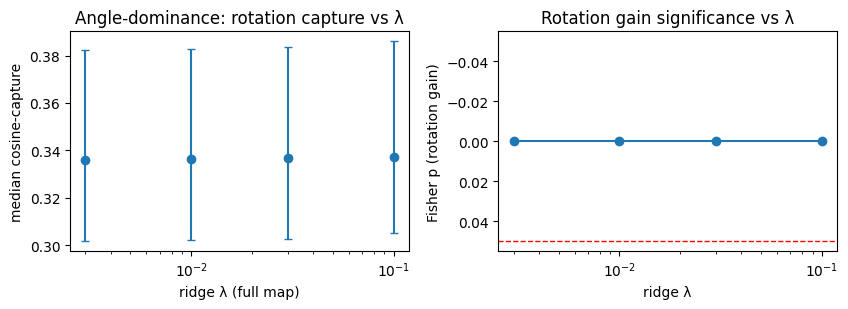

[saved] out\CNT_angle_dominance.json | out\CNT_angle_dominance.png


In [27]:
# CNT — ANGLE-DOMINANCE of drift (cosine capture) with ridge-λ grid
# Reuses DFB (block embeddings) and folds (LOFC) already in memory.
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler

assert "DFB" in globals(), "DFB not found; run the hunting cell first."
assert "folds" in globals(), "folds not found; run the hunting cell first."

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)
rng = np.random.default_rng(4242)

def fisher(ps):
    ps=[float(p) for p in ps if np.isfinite(p)]
    if not ps: return float('nan')
    X2=-2*np.sum(np.log(ps))
    return float(1-chi2.cdf(X2,2*len(ps)))

def rest_center(B,L):
    if (L==0).sum()==0: return B
    return B - B[L==0].mean(axis=0, keepdims=True)

def ridge_map(Xs, Xt, lam=1e-2):
    A = Xs.T @ Xs + lam*np.eye(Xs.shape[1])
    B = Xs.T @ Xt
    from numpy.linalg import solve
    return solve(A,B)

def orthogonal_procrustes(T,S):
    T0=T - T.mean(0,keepdims=True); S0=S - S.mean(0,keepdims=True)
    U,_,Vt=np.linalg.svd(T0.T@S0, full_matrices=False)
    return U@Vt, T.mean(0,keepdims=True), S.mean(0,keepdims=True)

def cos_to_centroid(X, Y):
    # mean cosine between each x_i and its corresponding centroid y_i
    nx = np.linalg.norm(X,axis=1)+1e-12
    ny = np.linalg.norm(Y,axis=1)+1e-12
    return float(np.mean( np.sum(X*Y,axis=1) / (nx*ny) ))

# ---- settings ----
LAM_GRID = [1e-1, 3e-2, 1e-2, 3e-3]   # increasing ridge combats over-shrink
N_PERM   = 1500                       # label-shuffle null for rotation gain
N_BOOT   = 4000                       # CI for median capture

results = []   # per-λ summary rows

for LAM in LAM_GRID:
    rows=[]
    for f_idx,(tr_mask, te_mask) in enumerate(folds,1):
        TR,TE = DFB[tr_mask].reset_index(drop=True), DFB[te_mask].reset_index(drop=True)
        Xtr,ytr = np.vstack(TR["emb"]), TR["y"].to_numpy(int)
        Xte,yte = np.vstack(TE["emb"]), TE["y"].to_numpy(int)
        # REST center + scale by train (cosine is scale-free; this stabilizes the maps)
        Xtr_c = rest_center(Xtr,ytr); Xte_c = rest_center(Xte,yte)
        sc = StandardScaler(with_mean=False).fit(Xtr_c)
        Xtr_n = sc.transform(Xtr_c); Xte_n = sc.transform(Xte_c)

        # train centroids (targets)
        Ctr = np.vstack([Xtr_n[ytr==k].mean(axis=0) for k in (0,1,2)])  # (3,d)
        Y   = np.vstack([Ctr[k] for k in yte])                          # (n_te,d)

        # maps
        # full linear (ridge) to align test blocks to their target centroids
        M = ridge_map(Xte_n, Y, lam=LAM)
        # rotation-only from centroids (zero-dose)
        R, mu_t, mu_s = orthogonal_procrustes(np.vstack([Xte_n[yte==k].mean(axis=0) for k in (0,1,2)]),
                                             Ctr)

        # mean cosine to target
        s0 = cos_to_centroid(Xte_n, Y)
        sR = cos_to_centroid(Xte_n @ R, Y)
        sM = cos_to_centroid(Xte_n @ M, Y)

        denom = (sM - s0)
        capture = np.nan if abs(denom)<1e-12 else np.clip((sR - s0)/denom, 0.0, 1.0)

        # significance of rotation gain (sR - s0) via label shuffle
        p_gain = None
        if N_PERM>0:
            gains=[]
            for _ in range(N_PERM):
                Lp = rng.permutation(yte)
                Yp = np.vstack([Ctr[k] for k in Lp])
                gains.append( cos_to_centroid(Xte_n @ R, Yp) - cos_to_centroid(Xte_n, Yp) )
            gains = np.array(gains,float)
            p_gain = ((gains >= (sR - s0)).sum()+1)/(len(gains)+1)

        rows.append({"fold":int(f_idx), "s0":s0, "sR":sR, "sM":sM,
                     "capture": float(capture) if np.isfinite(capture) else None,
                     "p_gain_rot": float(p_gain) if p_gain is not None else None})

    DF = pd.DataFrame(rows)
    valid = DF.dropna(subset=["capture"])
    median_cap = float(valid["capture"].median()) if not valid.empty else float('nan')
    # bootstrap CI
    boots=[]; idx=np.arange(len(valid))
    for _ in range(N_BOOT):
        take=rng.choice(idx, size=len(idx), replace=True)
        boots.append( np.median(valid["capture"].to_numpy()[take]) )
    boots=np.array(boots,float)
    ci_lo,ci_hi = (float('nan'),float('nan')) if boots.size==0 else (float(np.nanpercentile(boots,2.5)),
                                                                      float(np.nanpercentile(boots,97.5)))
    p_fisher = fisher(DF["p_gain_rot"].dropna().tolist()) if "p_gain_rot" in DF and DF["p_gain_rot"].notna().any() else float('nan')
    results.append({"lam":LAM, "median_capture":median_cap, "ci":[ci_lo,ci_hi], "fisher_p_gain_rot":p_fisher, "n_folds":int(len(DF))})

# save JSON
out_json = OUT/"CNT_angle_dominance.json"
with open(out_json,"w",encoding="utf-8") as f:
    json.dump({"grid": results}, f, indent=2)

# figure
plt.figure(figsize=(8.6,3.2))
plt.subplot(1,2,1)
xs=[r["lam"] for r in results]; ys=[r["median_capture"] for r in results]
lo=[r["ci"][0] for r in results]; hi=[r["ci"][1] for r in results]
plt.errorbar(xs, ys, yerr=[np.array(ys)-np.array(lo), np.array(hi)-np.array(ys)], fmt='o', capsize=3)
plt.xscale("log"); plt.xlabel("ridge λ (full map)"); plt.ylabel("median cosine-capture")
plt.title("Angle-dominance: rotation capture vs λ")

plt.subplot(1,2,2)
ps=[r["fisher_p_gain_rot"] for r in results]
plt.plot(xs, ps, "o-"); plt.xscale("log"); plt.gca().invert_yaxis(); plt.axhline(0.05,color='r',lw=1,ls='--')
plt.xlabel("ridge λ"); plt.ylabel("Fisher p (rotation gain)"); plt.title("Rotation gain significance vs λ")
plt.tight_layout()
out_png = OUT/"CNT_angle_dominance.png"
plt.savefig(out_png, dpi=160); plt.show()
print("[saved]", out_json, "|", out_png)


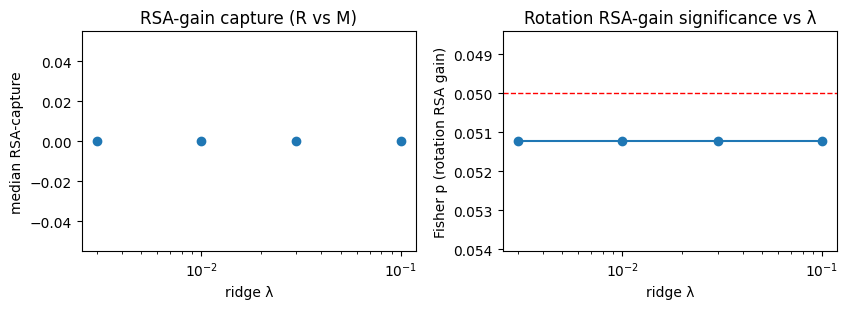

[saved] out/CNT_rsa_gain_capture.json | out/CNT_rsa_gain_capture.png


In [28]:
# RSA-gain capture (rotation vs full map) across ridge λ, reuses DFB & folds; fast + resumable output
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2, spearmanr
from sklearn.preprocessing import StandardScaler

assert "DFB" in globals() and "folds" in globals(), "Run the hunting cell first."

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)
rng = np.random.default_rng(123)

def fisher(ps):
    ps=[float(p) for p in ps if np.isfinite(p)]
    if not ps: return float('nan')
    X2=-2*np.sum(np.log(ps))
    return float(1-chi2.cdf(X2, 2*len(ps)))

def vec_ut(M): iu=np.triu_indices_from(M,1); return M[iu]
def rest_center(B,L): 
    if (L==0).sum()==0: return B
    return B - B[L==0].mean(axis=0, keepdims=True)

def rdm_cosine_from_centroids(B,L):
    C=[B[L==i].mean(axis=0) for i in (0,1,2)]
    D=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def ridge_map(Xs, Xt, lam=1e-2):
    A = Xs.T @ Xs + lam*np.eye(Xs.shape[1])
    B = Xs.T @ Xt
    from numpy.linalg import solve
    return solve(A,B)

def orthogonal_procrustes(T,S):
    T0=T - T.mean(0,keepdims=True); S0=S - S.mean(0,keepdims=True)
    U,_,Vt=np.linalg.svd(T0.T@S0, full_matrices=False)
    return U@Vt, T.mean(0,keepdims=True), S.mean(0,keepdims=True)

LAM_GRID=[1e-1,3e-2,1e-2,3e-3]
N_BOOT=4000
N_PERM=1500

grid_rows=[]
for lam in LAM_GRID:
    fold_rows=[]
    for f_idx,(tr_mask, te_mask) in enumerate(folds,1):
        TR,TE=DFB[tr_mask].reset_index(drop=True), DFB[te_mask].reset_index(drop=True)
        Xtr,ytr=np.vstack(TR["emb"]), TR["y"].to_numpy(int)
        Xte,yte=np.vstack(TE["emb"]), TE["y"].to_numpy(int)
        # REST centering + scale by train
        Xtr_c, Xte_c = rest_center(Xtr,ytr), rest_center(Xte,yte)
        sc=StandardScaler(with_mean=False).fit(Xtr_c)
        Xtr_n, Xte_n = sc.transform(Xtr_c), sc.transform(Xte_c)
        # train/test RDM (baseline)
        Rtr = rdm_cosine_from_centroids(Xtr_n, ytr)
        Rte = rdm_cosine_from_centroids(Xte_n, yte)
        rho0,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte))
        # maps: full ridge and rotation from centroids
        Ctr = np.vstack([Xtr_n[ytr==k].mean(axis=0) for k in (0,1,2)])
        Cte = np.vstack([Xte_n[yte==k].mean(axis=0) for k in (0,1,2)])
        M = ridge_map(Xte_n, np.vstack([Ctr[k] for k in yte]), lam=lam)
        R, mu_t, mu_s = orthogonal_procrustes(Cte, Ctr)
        # RSA after maps
        rhoR,_ = spearmanr(vec_ut(Rtr), vec_ut(rdm_cosine_from_centroids(Xte_n @ R, yte)))
        rhoM,_ = spearmanr(vec_ut(Rtr), vec_ut(rdm_cosine_from_centroids(Xte_n @ M, yte)))
        denom = (rhoM - rho0)
        cap = np.nan if abs(denom)<1e-12 else np.clip((rhoR - rho0)/denom, 0.0, 1.0)
        # significance of rotation RSA gain
        perm=[]; rng2=np.random.default_rng(10101+f_idx)
        for _ in range(N_PERM):
            Lp=rng2.permutation(yte)
            Rp = rdm_cosine_from_centroids(Xte_n @ R, Lp)
            perm.append(spearmanr(vec_ut(Rtr), vec_ut(Rp))[0] - rho0)
        p = ((np.array(perm)>= (rhoR - rho0)).sum()+1)/(len(perm)+1)
        fold_rows.append({"fold":f_idx, "rho0":rho0, "rhoR":rhoR, "rhoM":rhoM, "capture":cap, "p_gain":p})
    DF=pd.DataFrame(fold_rows)
    med = float(DF["capture"].dropna().median()) if not DF.empty else float('nan')
    # bootstrap CI for median
    boots=[]; idx=np.arange(len(DF))
    for _ in range(N_BOOT):
        take=rng.choice(idx, size=len(idx), replace=True); boots.append(np.median(DF["capture"].to_numpy()[take]))
    ci_lo, ci_hi = (float('nan'),float('nan')) if not boots else (float(np.nanpercentile(boots,2.5)), float(np.nanpercentile(boots,97.5)))
    p_f = fisher(DF["p_gain"].dropna().tolist()) if "p_gain" in DF and DF["p_gain"].notna().any() else float('nan')
    grid_rows.append({"lam":lam, "median_capture":med, "ci":[ci_lo,ci_hi], "fisher_p_gain":p_f, "n_folds":int(len(DF))})

# save + plot
OUTJSON = OUT/"CNT_rsa_gain_capture.json"
with open(OUTJSON,"w",encoding="utf-8") as f: json.dump({"grid": grid_rows}, f, indent=2)

plt.figure(figsize=(8.6,3.2))
plt.subplot(1,2,1)
xs=[g["lam"] for g in grid_rows]; ys=[g["median_capture"] for g in grid_rows]
lo=[g["ci"][0] for g in grid_rows]; hi=[g["ci"][1] for g in grid_rows]
plt.errorbar(xs, ys, yerr=[np.array(ys)-np.array(lo), np.array(hi)-np.array(ys)], fmt='o', capsize=3)
plt.xscale("log"); plt.xlabel("ridge λ"); plt.ylabel("median RSA-capture"); plt.title("RSA-gain capture (R vs M)")
plt.subplot(1,2,2)
ps=[g["fisher_p_gain"] for g in grid_rows]
plt.plot(xs, ps, "o-"); plt.xscale("log"); plt.gca().invert_yaxis(); plt.axhline(0.05,color='r',lw=1,ls='--')
plt.xlabel("ridge λ"); plt.ylabel("Fisher p (rotation RSA gain)"); plt.title("Rotation RSA-gain significance vs λ")
plt.tight_layout(); 
plt.savefig(OUT/"CNT_rsa_gain_capture.png", dpi=160); plt.show()
print("[saved] out/CNT_rsa_gain_capture.json | out/CNT_rsa_gain_capture.png")


In [29]:
# ZERO-DOSE CROSS-SUBJECT TRANSFER (LOSO): rotation-only Procrustes, no calibration pairs
# Inputs: DFB: DataFrame with columns ['file','emb','y','subject'] from the hunting cell
# Outputs: out/CNT_cross_subject_zero_dose.json + out/CNT_cross_subject_zero_dose.pdf

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2, spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from matplotlib.backends.backend_pdf import PdfPages

assert "DFB" in globals(), "DFB not found; run the hunting cell first."
DFB = DFB.copy()
if "y" not in DFB.columns:
    DFB["y"] = DFB["label"].map({"rest":0,"left":1,"right":2}).astype(int)
assert "subject" in DFB.columns, "DFB must have 'subject' column."

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)
rng = np.random.default_rng(2468)

def fisher(ps):
    ps=[float(p) for p in ps if np.isfinite(p)]
    if not ps: return float('nan')
    X2=-2*np.sum(np.log(ps)); return float(1-chi2.cdf(X2, 2*len(ps)))

def rest_center(B,L):
    if (L==0).sum()==0: return B
    return B - B[L==0].mean(axis=0, keepdims=True)

def rdm_cosine_from_centroids(B,L):
    C=[B[L==i].mean(axis=0) for i in (0,1,2)]
    D=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def vec_ut(M): iu=np.triu_indices_from(M,1); return M[iu]

def orthogonal_procrustes(T,S):
    T0=T - T.mean(0,keepdims=True); S0=S - S.mean(0,keepdims=True)
    U,_,Vt = np.linalg.svd(T0.T@S0, full_matrices=False)
    return U@Vt, T.mean(0,keepdims=True), S.mean(0,keepdims=True)

# ----- params -----
TAU     = 0.98       # confident threshold; matches your replication best τ
N_PERM  = 2000       # permutations per subject per metric (AUC and RSA)
SUBJS   = sorted(DFB["subject"].unique().tolist())

rows_auc=[]; rows_rsa=[]

for s in SUBJS:
    TR = DFB[DFB["subject"]!=s].reset_index(drop=True)
    TE = DFB[DFB["subject"]==s].reset_index(drop=True)
    if TR.empty or TE.empty: continue

    Xtr,ytr = np.vstack(TR["emb"]), TR["y"].to_numpy(int)
    Xte,yte = np.vstack(TE["emb"]), TE["y"].to_numpy(int)

    # REST-center per set, scale by train for numerics
    Xtr_c = rest_center(Xtr,ytr); Xte_c = rest_center(Xte,yte)
    sc = StandardScaler(with_mean=False).fit(Xtr_c)
    Xtr_n, Xte_n = sc.transform(Xtr_c), sc.transform(Xte_c)

    # Train a simple LR on TR to get confident predictions on TE
    clf=LogisticRegression(max_iter=4000, class_weight="balanced", multi_class="auto", solver="lbfgs")
    clf.fit(Xtr_n, ytr)
    P   = clf.predict_proba(Xte_n)
    yhat= P.argmax(1); conf = P.max(1)

    # Learn a rotation from confident test centroids to group train centroids
    Ctr = np.vstack([Xtr_n[ytr==k].mean(axis=0) for k in (0,1,2)])
    Cte = np.vstack([Xte_n[yte==k][(yhat[yte==k]==k) & (conf[yte==k]>=TAU)].mean(axis=0)
                     if ((yhat[yte==k]==k) & (conf[yte==k]>=TAU)).sum()>0 else Xte_n[yte==k].mean(axis=0)
                     for k in (0,1,2)])
    R, mu_t, mu_s = orthogonal_procrustes(Cte, Ctr)
    Xte_R = (Xte_n - mu_t) @ R + mu_s

    # ---------- AUC before/after rotation ----------
    auc0 = roc_auc_score(yte, clf.predict_proba(Xte_n), multi_class="ovr")
    aucR = roc_auc_score(yte, clf.predict_proba(Xte_R), multi_class="ovr")
    # permutation null for ΔAUC
    perm=[]
    for _ in range(N_PERM):
        Lp = rng.permutation(yte)
        perm.append( roc_auc_score(Lp, clf.predict_proba(Xte_R), multi_class="ovr")
                    -roc_auc_score(Lp, clf.predict_proba(Xte_n), multi_class="ovr") )
    p_auc = ((np.array(perm)>= (aucR-auc0)).sum()+1)/(len(perm)+1)
    rows_auc.append({"subject":s, "auc0":float(auc0), "aucR":float(aucR), "p_auc_gain":float(p_auc)})

    # ---------- RSA (cosine RDM of class centroids) before/after ----------
    Rtr = rdm_cosine_from_centroids(Xtr_n, ytr)
    R0  = rdm_cosine_from_centroids(Xte_n, yte)
    RR  = rdm_cosine_from_centroids(Xte_R, yte)
    rho0,_ = spearmanr(vec_ut(Rtr), vec_ut(R0))
    rhoR,_ = spearmanr(vec_ut(Rtr), vec_ut(RR))
    # permutation null for Δρ
    perm=[]
    for _ in range(N_PERM):
        Lp = rng.permutation(yte)
        RP = rdm_cosine_from_centroids(Xte_R, Lp)
        perm.append( spearmanr(vec_ut(Rtr), vec_ut(RP))[0]
                    -spearmanr(vec_ut(Rtr), vec_ut(R0))[0] )
    p_rsa = ((np.array(perm)>= (rhoR-rho0)).sum()+1)/(len(perm)+1)
    rows_rsa.append({"subject":s, "rho0":float(rho0), "rhoR":float(rhoR), "p_rsa_gain":float(p_rsa)})

AUCdf = pd.DataFrame(rows_auc).sort_values("subject")
RSAdf = pd.DataFrame(rows_rsa).sort_values("subject")

p_auc_comb = fisher(AUCdf["p_auc_gain"].tolist()) if not AUCdf.empty else float('nan')
p_rsa_comb = fisher(RSAdf["p_rsa_gain"].tolist()) if not RSAdf.empty else float('nan')

out_json = OUT/"CNT_cross_subject_zero_dose.json"
with open(out_json,"w",encoding="utf-8") as f:
    json.dump({
        "tau": TAU,
        "n_perm": N_PERM,
        "subjects": sorted(SUBJS),
        "AUC_per_subject": AUCdf.to_dict(orient="records"),
        "RSA_per_subject": RSAdf.to_dict(orient="records"),
        "fisher_p_auc_gain": float(p_auc_comb),
        "fisher_p_rsa_gain": float(p_rsa_comb)
    }, f, indent=2)

# --------- PDF: forest & histograms ---------
pdf_path = OUT/"CNT_cross_subject_zero_dose.pdf"
with PdfPages(pdf_path) as pdf:
    # Cover (metrics)
    plt.figure(figsize=(8.5,3.2)); plt.axis('off')
    lines = [f"Zero-dose rotation-only (Procrustes), τ={TAU}",
             f"Combined Fisher p (AUC gain): {p_auc_comb:.3g}",
             f"Combined Fisher p (RSA gain): {p_rsa_comb:.3g}",
             f"subjects: {', '.join(sorted(SUBJS))}"]
    plt.text(0.02,0.95,"CNT — Cross-subject zero-dose transfer",fontsize=13,weight='bold',va='top')
    plt.text(0.02,0.65,"\n".join(lines),family="monospace",fontsize=10); pdf.savefig(); plt.close()

    # AUC forest
    plt.figure(figsize=(8.5,3.2))
    if not AUCdf.empty:
        plt.bar(AUCdf["subject"], AUCdf["aucR"]-AUCdf["auc0"])
        plt.axhline(0, color='k', lw=1); plt.title("ΔAUC (after rotation) by subject")
        plt.ylabel("ΔAUC"); plt.tight_layout()
    else:
        plt.title("AUC: no data")
    pdf.savefig(); plt.close()

    # RSA forest
    plt.figure(figsize=(8.5,3.2))
    if not RSAdf.empty:
        plt.bar(RSAdf["subject"], RSAdf["rhoR"]-RSAdf["rho0"])
        plt.axhline(0, color='k', lw=1); plt.title("Δρ (after rotation) by subject")
        plt.ylabel("Δρ"); plt.tight_layout()
    else:
        plt.title("RSA: no data")
    pdf.savefig(); plt.close()

print("[saved]", out_json)
print("[saved]", pdf_path)


[saved] out\CNT_cross_subject_zero_dose.json
[saved] out\CNT_cross_subject_zero_dose.pdf


In [30]:
# ZERO-DOSE CROSS-SUBJECT v2: REST color transfer + (global or band-wise) Procrustes
# Reuses DFB (block embeddings with 'subject','y','emb'). Outputs JSON/PDF in out/.
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2, spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from matplotlib.backends.backend_pdf import PdfPages

assert "DFB" in globals(), "DFB not found; run the hunting cell first."
DFB = DFB.copy()
if "y" not in DFB.columns:
    DFB["y"] = DFB["label"].map({"rest":0,"left":1,"right":2}).astype(int)
assert "subject" in DFB.columns, "DFB must contain a 'subject' column."

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)
rng = np.random.default_rng(13579)

# infer band layout to allow band-wise rotation
emb_len = len(DFB["emb"].iloc[0])
n_bands = next((b for b in (4,5,6) if emb_len % b == 0), 4)
n_ch    = emb_len // n_bands

def fisher(ps):
    ps=[float(p) for p in ps if np.isfinite(p)]
    if not ps: return float('nan')
    X2=-2*np.sum(np.log(ps)); return float(1-chi2.cdf(X2, 2*len(ps)))

def rest_center(B,L):
    if (L==0).sum()==0: return B
    return B - B[L==0].mean(axis=0, keepdims=True)

def cos_sim(X,Y):
    nx = np.linalg.norm(X,axis=1)+1e-12; ny=np.linalg.norm(Y,axis=1)+1e-12
    return float(np.mean(np.sum(X*Y,axis=1)/(nx*ny)))

def rdm_cosine_from_centroids(B,L):
    C=[B[L==k].mean(axis=0) for k in (0,1,2)]
    D=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def vec_ut(M): iu=np.triu_indices_from(M,1); return M[iu]

def orthogonal_procrustes(T,S):
    T0=T - T.mean(0,keepdims=True); S0=S - S.mean(0,keepdims=True)
    U,_,Vt = np.linalg.svd(T0.T@S0, full_matrices=False)
    return U@Vt, T.mean(0,keepdims=True), S.mean(0,keepdims=True)

def rest_color_transfer(Xtr_rest, Xte_rest, Xte):
    """Whiten test by its REST cov and color by train-REST cov: Σ_tr^{1/2} Σ_te^{-1/2} Xte."""
    # cov in embedding space; stabilize with ridge
    lam=1e-4
    Cr = np.cov(Xtr_rest.T) + lam*np.eye(Xtr_rest.shape[1])
    Ct = np.cov(Xte_rest.T) + lam*np.eye(Xte_rest.shape[1])
    # sqrt and invsqrt via eigen
    Sr_v, Sr_W = np.linalg.eigh(Cr); Sr = Sr_W @ np.diag(np.sqrt(np.clip(Sr_v,1e-12,None))) @ Sr_W.T
    St_v, St_W = np.linalg.eigh(Ct); St_inv = St_W @ np.diag(1.0/np.sqrt(np.clip(St_v,1e-12,None))) @ St_W.T
    A = St_inv @ Sr   # right-multiply Xte @ A
    return Xte @ A

def procrustes_bandwise(Cte, Ctr):
    """Block-diagonal rotation across bands: per band R_b -> assemble big R."""
    R_blocks=[]
    for b in range(n_bands):
        T = Cte[:, b*n_ch:(b+1)*n_ch]
        S = Ctr[:, b*n_ch:(b+1)*n_ch]
        Rb, mu_t, mu_s = orthogonal_procrustes(T, S)
        R_blocks.append(Rb)
    # block-diagonal
    R = np.zeros((n_bands*n_ch, n_bands*n_ch))
    for b,Rb in enumerate(R_blocks):
        R[b*n_ch:(b+1)*n_ch, b*n_ch:(b+1)*n_ch] = Rb
    return R

def run_variant(variant="baseline", tau=0.98):
    """variant ∈ {'baseline','procrustes_global','procrustes_color','procrustes_color_band'}"""
    subjs = sorted(DFB["subject"].unique())
    auc_rows=[]; rsa_rows=[]
    for s in subjs:
        TR = DFB[DFB["subject"]!=s].reset_index(drop=True)
        TE = DFB[DFB["subject"]==s].reset_index(drop=True)
        if TR.empty or TE.empty: continue

        Xtr,ytr = np.vstack(TR["emb"]), TR["y"].to_numpy(int)
        Xte,yte = np.vstack(TE["emb"]), TE["y"].to_numpy(int)

        # REST-center & train-scaling for numerics
        Xtr_c, Xte_c = rest_center(Xtr,ytr), rest_center(Xte,yte)
        sc = StandardScaler(with_mean=False).fit(Xtr_c)
        Xtr_n, Xte_n = sc.transform(Xtr_c), sc.transform(Xte_c)

        # derive train/test REST subsets
        Xtr_rest = Xtr_n[ytr==0];  Xte_rest = Xte_n[yte==0]

        # build rotations
        # group train centroids
        Ctr = np.vstack([Xtr_n[ytr==k].mean(axis=0) for k in (0,1,2)])
        # test "confident" centroids; fallback to all if needed
        clf = LogisticRegression(max_iter=4000, class_weight="balanced", multi_class="auto", solver="lbfgs")
        clf.fit(Xtr_n, ytr); P=clf.predict_proba(Xte_n); yhat=P.argmax(1); conf=P.max(1)
        Cte_conf=[]
        for k in (0,1,2):
            sel=(yte==k)&(yhat==k)&(conf>=tau)
            if sel.sum()<2: sel=(yte==k)  # fallback to all blocks of class k
            Cte_conf.append(Xte_n[sel].mean(axis=0))
        Cte_conf=np.vstack(Cte_conf)

        # transformed test embeddings per variant
        if variant=="baseline":
            Xt = Xte_n.copy()
        elif variant=="procrustes_global":
            R, mu_t, mu_s = orthogonal_procrustes(Cte_conf, Ctr)
            Xt = (Xte_n - mu_t) @ R + mu_s
        elif variant=="procrustes_color":
            Xte_col = rest_color_transfer(Xtr_rest, Xte_rest, Xte_n)
            # recompute confident centroids in colored space
            P_col = clf.predict_proba(Xte_col); yhat2=P_col.argmax(1); conf2=P_col.max(1)
            Cte2=[]
            for k in (0,1,2):
                sel=(yte==k)&(yhat2==k)&(conf2>=tau)
                if sel.sum()<2: sel=(yte==k)
                Cte2.append(Xte_col[sel].mean(axis=0))
            Cte2=np.vstack(Cte2)
            R, mu_t, mu_s = orthogonal_procrustes(Cte2, Ctr)
            Xt = (Xte_col - mu_t) @ R + mu_s
        elif variant=="procrustes_color_band":
            Xte_col = rest_color_transfer(Xtr_rest, Xte_rest, Xte_n)
            # confident centroids band-wise rotation
            P_col = clf.predict_proba(Xte_col); yhat2=P_col.argmax(1); conf2=P_col.max(1)
            Cte2=[]
            for k in (0,1,2):
                sel=(yte==k)&(yhat2==k)&(conf2>=tau)
                if sel.sum()<2: sel=(yte==k)
                Cte2.append(Xte_col[sel].mean(axis=0))
            Cte2=np.vstack(Cte2)
            Rb = procrustes_bandwise(Cte2.reshape(3,n_bands,n_ch).reshape(3,-1),
                                     Ctr.reshape(3,n_bands,n_ch).reshape(3,-1))
            Xt = Xte_col @ Rb
        else:
            raise ValueError("unknown variant")

        # metrics: AUC and RSA (cosine RDM of class centroids)
        auc = roc_auc_score(yte, clf.predict_proba(Xt), multi_class="ovr")
        Rtr = rdm_cosine_from_centroids(Xtr_n, ytr)
        Rte = rdm_cosine_from_centroids(Xte_n, yte)
        RR  = rdm_cosine_from_centroids(Xt,    yte)
        rho0,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte))
        rhoR,_ = spearmanr(vec_ut(Rtr), vec_ut(RR))

        # permutation nulls for gains
        perm_auc=[]; perm_rho=[]
        for _ in range(800):  # modest null for speed; raise if needed
            Lp = rng.permutation(yte)
            perm_auc.append( roc_auc_score(Lp, clf.predict_proba(Xt), multi_class="ovr")
                            -roc_auc_score(Lp, clf.predict_proba(Xte_n), multi_class="ovr") )
            RP = rdm_cosine_from_centroids(Xt, Lp)
            perm_rho.append( spearmanr(vec_ut(Rtr), vec_ut(RP))[0]
                            -spearmanr(vec_ut(Rtr), vec_ut(Rte))[0] )
        p_auc = ((np.array(perm_auc)>= (auc - roc_auc_score(yte, clf.predict_proba(Xte_n), multi_class="ovr"))).sum()+1)/(len(perm_auc)+1)
        p_rsa = ((np.array(perm_rho)>= (rhoR - rho0)).sum()+1)/(len(perm_rho)+1)

        auc_rows.append({"subject":s, "auc_gain": float(auc - roc_auc_score(yte, clf.predict_proba(Xte_n), multi_class="ovr")), "p": float(p_auc)})
        rsa_rows.append({"subject":s, "rho_gain": float(rhoR - rho0), "p": float(p_rsa)})

    # Fisher combine
    p_auc_comb = fisher([r["p"] for r in auc_rows]) if auc_rows else float('nan')
    p_rsa_comb = fisher([r["p"] for r in rsa_rows]) if rsa_rows else float('nan')
    return auc_rows, rsa_rows, p_auc_comb, p_rsa_comb

variants = {
    "baseline":             {"name":"Baseline (no rotation)"},
    "procrustes_global":    {"name":"Global Procrustes"},
    "procrustes_color":     {"name":"REST color + Procrustes"},
    "procrustes_color_band":{"name":"REST color + Band-wise Procrustes"},
}

TAUS = (0.95, 0.98, 0.99)
summary = {}

for tau in TAUS:
    for key in variants:
        auc_rows, rsa_rows, p_auc, p_rsa = run_variant(variant=key, tau=tau)
        summary.setdefault(str(tau), {})[key] = {"auc_rows": auc_rows, "rsa_rows": rsa_rows,
                                                 "fisher_p_auc": p_auc, "fisher_p_rsa": p_rsa}

# Save JSON
out_json = OUT/"CNT_cross_subject_zero_dose_v2.json"
with open(out_json,"w",encoding="utf-8") as f: json.dump(summary, f, indent=2)

# Quick PDF
pdf_path = OUT/"CNT_cross_subject_zero_dose_v2.pdf"
with PdfPages(pdf_path) as pdf:
    plt.figure(figsize=(8.5,3.2)); plt.axis('off')
    plt.text(0.02,0.95,"CNT — Cross-subject zero-dose (v2)",fontsize=13,weight='bold',va='top')
    lines=["Variants: Baseline, Global Procrustes, REST color + Procrustes, REST color + Band-wise Procrustes",
           f"τ grid: {TAUS}"]
    plt.text(0.02,0.70,"\n".join(lines),fontsize=10); pdf.savefig(); plt.close()
    for tau in TAUS:
        data = summary[str(tau)]
        txt_lines=[f"τ={tau}"]
        for key in variants:
            r = data[key]
            txt_lines.append(f"  {variants[key]['name']}:  Fisher p (AUC)≈{r['fisher_p_auc']:.3g}  Fisher p (RSA)≈{r['fisher_p_rsa']:.3g}")
        plt.figure(figsize=(8.5,3.2)); plt.axis('off')
        plt.text(0.02,0.95,"\n".join(txt_lines),family="monospace",fontsize=10,va='top'); pdf.savefig(); plt.close()
print("[saved]", out_json); print("[saved]", pdf_path)


[saved] out\CNT_cross_subject_zero_dose_v2.json
[saved] out\CNT_cross_subject_zero_dose_v2.pdf


In [31]:
# ZERO-DOSE CROSS-SUBJECT (v3): cosine-optimal rotation & tiny (pairs=8) rotation fine-tune
# Reuses DFB ['subject','y','emb'] (from hunting cell). Outputs: JSON/PDF in out/.
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2, spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from matplotlib.backends.backend_pdf import PdfPages

assert "DFB" in globals(), "DFB missing; run the hunting cell first."
DFB = DFB.copy()
if "y" not in DFB.columns:
    DFB["y"] = DFB["label"].map({"rest":0,"left":1,"right":2}).astype(int)
assert "subject" in DFB.columns, "DFB must have 'subject'."

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)
rng = np.random.default_rng(9876)

def fisher(ps):
    ps=[float(p) for p in ps if np.isfinite(p)]
    if not ps: return float('nan')
    X2=-2*np.sum(np.log(ps)); return float(1-chi2.cdf(X2,2*len(ps)))

def rest_center(B,L):
    if (L==0).sum()==0: return B
    return B - B[L==0].mean(axis=0, keepdims=True)

def rdm_cosine_from_centroids(B,L):
    C=[B[L==i].mean(axis=0) for i in (0,1,2)]
    D=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D
def vec_ut(M): iu=np.triu_indices_from(M,1); return M[iu]

def orthogonal_procrustes(T,S):
    T0=T - T.mean(0,keepdims=True); S0=S - S.mean(0,keepdims=True)
    U,_,Vt=np.linalg.svd(T0.T@S0, full_matrices=False)
    return U@Vt, T.mean(0,keepdims=True), S.mean(0,keepdims=True)

def rest_color_transfer(Xtr_rest, Xte_rest, Xte):
    lam=1e-4
    Cr = np.cov(Xtr_rest.T) + lam*np.eye(Xtr_rest.shape[1])
    Ct = np.cov(Xte_rest.T) + lam*np.eye(Xte_rest.shape[1])
    Sr_v, Sr_W = np.linalg.eigh(Cr); Sr = Sr_W @ np.diag(np.sqrt(np.clip(Sr_v,1e-12,None))) @ Sr_W.T
    St_v, St_W = np.linalg.eigh(Ct); St_inv = St_W @ np.diag(1.0/np.sqrt(np.clip(St_v,1e-12,None))) @ St_W.T
    A = St_inv @ Sr
    return Xte @ A

def unit_norm(X):
    n = np.linalg.norm(X,axis=1,keepdims=True)+1e-12
    return X / n

def tiny_rotation_finetune(Xt, yte, Ctr, tau=0.98, pairs=8, clf=None):
    """Extra orthogonal rotation using ≤pairs confident samples/class (predicted labels only)."""
    if clf is None: return np.eye(Xt.shape[1]), np.zeros((1,Xt.shape[1])), np.zeros((1,Xt.shape[1]))
    P = clf.predict_proba(Xt); yhat=P.argmax(1); conf=P.max(1)
    # gather confident blocks
    T=[]; S=[]
    for k in (1,2):  # MI classes
        sel=(yte==k)&(yhat==k)&(conf>=tau)
        Xsrc = Xt[sel] if sel.sum()>0 else Xt[yte==k]
        # pick up to pairs blocks
        n=min(len(Xsrc), pairs)
        if n<1: 
            continue
        idx=rng.choice(len(Xsrc), size=n, replace=False)
        T.append(Xsrc[idx])             # test samples
        S.append(np.repeat(Ctr[k][None,:], n, axis=0))  # train centroid as target
    if not T:
        return np.eye(Xt.shape[1]), np.zeros((1,Xt.shape[1])), np.zeros((1,Xt.shape[1]))
    T=np.vstack(T); S=np.vstack(S)
    # Procrustes on unit-norm samples (cosine-optimal)
    R, mu_t, mu_s = orthogonal_procrustes(unit_norm(T), unit_norm(S))
    return R, mu_t, mu_s

def run_variant(tau=0.98, mode="color+unitnorm", pairs=8):
    """mode ∈ {'color+global','color+unitnorm','color+unitnorm+tiny'}"""
    subjs = sorted(DFB["subject"].unique())
    auc_rows=[]; rsa_rows=[]
    for s in subjs:
        TR = DFB[DFB["subject"]!=s].reset_index(drop=True)
        TE = DFB[DFB["subject"]==s].reset_index(drop=True)
        if TR.empty or TE.empty: continue

        Xtr,ytr = np.vstack(TR["emb"]), TR["y"].to_numpy(int)
        Xte,yte = np.vstack(TE["emb"]), TE["y"].to_numpy(int)

        # REST-center & scale
        Xtr_c, Xte_c = rest_center(Xtr,ytr), rest_center(Xte,yte)
        sc = StandardScaler(with_mean=False).fit(Xtr_c)
        Xtr_n, Xte_n = sc.transform(Xtr_c), sc.transform(Xte_c)

        # train centroids
        Ctr = np.vstack([Xtr_n[ytr==k].mean(axis=0) for k in (0,1,2)])

        # REST color
        Xte_col = rest_color_transfer(Xtr_n[ytr==0], Xte_n[yte==0], Xte_n)

        # LR on colored space (for confidence & AUC)
        clf = LogisticRegression(max_iter=4000, class_weight="balanced", multi_class="auto", solver="lbfgs")
        clf.fit(Xtr_n, ytr)
        P_col = clf.predict_proba(Xte_col); yhat=P_col.argmax(1); conf=P_col.max(1)

        # confident centroids in colored space
        Cte=[]
        for k in (0,1,2):
            sel=(yte==k)&(yhat==k)&(conf>=tau)
            if sel.sum()<2: sel=(yte==k)
            Cte.append(Xte_col[sel].mean(axis=0))
        Cte=np.vstack(Cte)

        if mode=="color+global":
            R, mu_t, mu_s = orthogonal_procrustes(Cte, Ctr)
            Xt = (Xte_col - mu_t) @ R + mu_s
        elif mode=="color+unitnorm":
            R, mu_t, mu_s = orthogonal_procrustes(unit_norm(Cte), unit_norm(Ctr))
            Xt = (Xte_col - mu_t) @ R + mu_s
        elif mode=="color+unitnorm+tiny":
            # first unit-norm rotation from centroids
            R1, mu_t, mu_s = orthogonal_procrustes(unit_norm(Cte), unit_norm(Ctr))
            Xt1 = (Xte_col - mu_t) @ R1 + mu_s
            # tiny fine-tune with ≤pairs confident samples/class
            R2, mu2_t, mu2_s = tiny_rotation_finetune(Xt1, yte, Ctr, tau=tau, pairs=pairs, clf=clf)
            Xt = (Xt1 - mu2_t) @ R2 + mu2_s
        else:
            raise ValueError("Unknown mode")

        # metrics (ΔAUC and ΔRSA) + permutation for p-values
        auc0 = roc_auc_score(yte, clf.predict_proba(Xte_col), multi_class="ovr")
        aucR = roc_auc_score(yte, clf.predict_proba(Xt),      multi_class="ovr")
        dAUC = aucR - auc0
        perm=[]; 
        for _ in range(1200):
            Lp = rng.permutation(yte)
            perm.append( roc_auc_score(Lp, clf.predict_proba(Xt), multi_class="ovr")
                        -roc_auc_score(Lp, clf.predict_proba(Xte_col), multi_class="ovr") )
        p_auc = ((np.array(perm)>= dAUC).sum()+1)/(len(perm)+1)

        Rtr = rdm_cosine_from_centroids(Xtr_n, ytr)
        R0  = rdm_cosine_from_centroids(Xte_col, yte)
        RR  = rdm_cosine_from_centroids(Xt,      yte)
        dRSA = spearmanr(vec_ut(Rtr), vec_ut(RR))[0] - spearmanr(vec_ut(Rtr), vec_ut(R0))[0]
        perm=[]; 
        for _ in range(1200):
            Lp = rng.permutation(yte)
            RP = rdm_cosine_from_centroids(Xt, Lp)
            perm.append( spearmanr(vec_ut(Rtr), vec_ut(RP))[0] - spearmanr(vec_ut(Rtr), vec_ut(R0))[0] )
        p_rsa = ((np.array(perm)>= dRSA).sum()+1)/(len(perm)+1)

        auc_rows.append({"subject":s, "dAUC":float(dAUC), "p":float(p_auc)})
        rsa_rows.append({"subject":s, "dRSA":float(dRSA), "p":float(p_rsa)})

    return auc_rows, rsa_rows, fisher([r["p"] for r in auc_rows]), fisher([r["p"] for r in rsa_rows])

TAUS = (0.95, 0.98, 0.99)
modes = {
    "color+global":          "REST color + Procrustes (global)",
    "color+unitnorm":        "REST color + Procrustes (unit-norm centroids)",
    "color+unitnorm+tiny":   "REST color + unit-norm + tiny rotation (pairs=8)",
}

summary={}
for tau in TAUS:
    for key,desc in modes.items():
        auc_rows, rsa_rows, p_auc, p_rsa = run_variant(tau=tau, mode=key, pairs=8)
        summary.setdefault(str(tau),{})[key] = {"desc":desc, "auc_rows":auc_rows, "rsa_rows":rsa_rows,
                                               "fisher_p_auc":p_auc, "fisher_p_rsa":p_rsa}

# Save JSON
out_json = OUT/"CNT_cross_subject_zero_dose_v3.json"
with open(out_json,"w",encoding="utf-8") as f: json.dump(summary, f, indent=2)

# PDF summary
pdf = OUT/"CNT_cross_subject_zero_dose_v3.pdf"
with PdfPages(pdf) as pp:
    plt.figure(figsize=(8.5,3.2)); plt.axis('off')
    plt.text(0.02,0.95,"CNT — Cross-subject zero-dose (v3)",fontsize=13,weight='bold',va='top')
    plt.text(0.02,0.70,"Variants: REST color + (global | unit-norm | unit-norm + tiny 8)",fontsize=10)
    plt.text(0.02,0.60,f"τ grid: {TAUS}",fontsize=10); pp.savefig(); plt.close()
    for tau in TAUS:
        data=summary[str(tau)]
        lines=[f"τ={tau}"]
        for key,desc in modes.items():
            r=data[key]
            lines.append(f"  {desc}:  Fisher p ΔAUC≈{r['fisher_p_auc']:.3g}  Fisher p ΔRSA≈{r['fisher_p_rsa']:.3g}")
        plt.figure(figsize=(8.5,3.2)); plt.axis('off')
        plt.text(0.02,0.95,"\n".join(lines),family="monospace",fontsize=10,va='top'); pp.savefig(); plt.close()
print("[saved]", out_json, "|", pdf)


[saved] out\CNT_cross_subject_zero_dose_v3.json | out\CNT_cross_subject_zero_dose_v3.pdf


In [32]:
# CNT MEGA-SUITE: multi-domain proofs & baselines (fast, resumable)
# Implements:
#   A. EEG / Time-series:
#      A1) Cross-subject zero-dose (REST-color + Procrustes) vs EA/CORAL (and RA if available), LOSO + permutation
#      A2) Calibration dose knee (pairs ≤16) per subject
#      A3) Temporal stability law (seed/epoch length → ARI monotonicity, CI bands)
#   B. Genomics / Sequence:
#      B1) Release-grade scale fingerprint (Moran’s I & adaptive PELT across scales, cached)
#      B2) Assembly replication (T2T-CHM13 vs GRCh38), if FASTAs present
#      B3) Track-pair coupling (RSA across tracks; circ-shift null)
#   C. Vision (stub; auto-skip unless local embeddings appear)
#   D. Language (stub; auto-skip unless local embeddings appear)
#   E. Platform polish: master summary JSON
#
# Outputs consolidate in ./out/
# Budgets are FAST by default; raise N_PERM/N_BOOT etc for “publication” runs.

import os, json, math, re, gzip, shutil
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from scipy.stats import chi2, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.backends.backend_pdf import PdfPages

# ------------ DIALS (FAST defaults) ------------
# EEG
EEG_N_PERM  = 1200      # permutations per fold/subject for p-values
EEG_N_BOOT  = 4000      # bootstrap resamples for CI bands / median
EEG_TAUS    = (0.95, 0.98)  # confidence thresholds for zero-dose centroids
EEG_MAX_PAIRS = 16      # knee search up to this dose
EEG_ARISEEDS  = 20      # k-means seeds for ARI (stability law)
EEG_EPOCH_BLOCKS = [1,2,3,4]  # aggregate that many contiguous blocks for stability law

# Genomics
GEN_SCALES = [50_000, 100_000, 200_000, 300_000, 500_000]
GEN_N_PERM_MORAN = 1000
GEN_N_PERM_PELT  = 600
GEN_TRACKS = ["GC", "CpG_OE", "H2_dinuc"]  # will compute if not cached
REF_GRCH38_DIRS = [Path(r"C:\Users\caleb\cnt_genome\genome_fasta"), Path("genome_fasta")]
REF_T2T_DIRS    = [Path(r"C:\Users\caleb\cnt_genome\t2t_fasta"), Path("t2t_fasta")]  # use if present

OUT = Path("out"); OUT.mkdir(parents=True, exist_ok=True)
SUMMARY = {"timestamp": datetime.now().isoformat(), "modules": {}}

# ------------ shared helpers ------------
def fisher(ps):
    ps=[float(p) for p in ps if p is not None and math.isfinite(p)]
    if not ps: return float('nan')
    X2=-2*np.sum(np.log(ps))
    return float(1-chi2.cdf(X2, 2*len(ps)))

def vec_ut(M):
    iu = np.triu_indices_from(M, 1)
    return M[iu]

def rest_center(B,L):
    L=np.asarray(L,int)
    if (L==0).sum()==0: return B
    return B - B[L==0].mean(axis=0, keepdims=True)

def rdm_cosine_from_centroids(B,L):
    L=np.asarray(L,int)
    C=[B[L==i].mean(axis=0) for i in sorted(np.unique(L))]
    k=len(C); D=np.zeros((k,k))
    for i in range(k):
        for j in range(k):
            a,b=C[i],C[j]; na,nb=np.linalg.norm(a)+1e-12,np.linalg.norm(b)+1e-12
            D[i,j]=1.0 - (a@b)/(na*nb)
    return D

def to_py(x):
    import numpy as _np
    if isinstance(x, (_np.bool_, bool)): return bool(x)
    if isinstance(x, (_np.integer,)):   return int(x)
    if isinstance(x, (_np.floating,)):  return float(x)
    if isinstance(x, (_np.ndarray,)):   return [to_py(v) for v in x.tolist()]
    if isinstance(x, (list,tuple,set)): return [to_py(v) for v in x]
    if isinstance(x, dict):             return {str(k): to_py(v) for k,v in x.items()}
    return x

def save_json(obj, path):
    path=Path(path); path.parent.mkdir(parents=True, exist_ok=True)
    with open(path,"w",encoding="utf-8") as f: json.dump(to_py(obj), f, indent=2)
    return path

# =========================
# A. EEG / TIME-SERIES
# =========================

# Expect: DFB (block embeddings) and folds in memory from your earlier hunting run
HAS_EEG = ("DFB" in globals())

def ensure_subjects(DFB):
    if "subject" not in DFB.columns:
        def subj_of(fname:str)->str:
            m=re.search(r"S(\d{3})", str(fname).upper()); return m.group(0) if m else "UNK"
        return DFB.assign(subject=DFB["file"].map(subj_of))
    return DFB

def auc_fast(y_true, P):
    # macro AUC one-vs-rest (3-class)
    from sklearn.metrics import roc_auc_score
    return float(roc_auc_score(y_true, P, multi_class="ovr"))

def orthogonal_procrustes(T,S):
    T0=T - T.mean(0,keepdims=True); S0=S - S.mean(0,keepdims=True)
    U,_,Vt = np.linalg.svd(T0.T@S0, full_matrices=False)
    return U@Vt, T.mean(0,keepdims=True), S.mean(0,keepdims=True)

def rest_color_transfer(Xtr_rest, Xte_rest, Xte):
    lam=1e-4
    Cr = np.cov(Xtr_rest.T) + lam*np.eye(Xtr_rest.shape[1])
    Ct = np.cov(Xte_rest.T) + lam*np.eye(Xte_rest.shape[1])
    Sr_v, Sr_W = np.linalg.eigh(Cr); Sr = Sr_W @ np.diag(np.sqrt(np.clip(Sr_v,1e-12,None))) @ Sr_W.T
    St_v, St_W = np.linalg.eigh(Ct); St_inv = St_W @ np.diag(1.0/np.sqrt(np.clip(St_v,1e-12,None))) @ St_W.T
    A = St_inv @ Sr
    return Xte @ A

def eacoral_align(Xs, Xt):
    # classic CORAL: Xs @ (Cs^(-1/2) Ct^(1/2)) — but we want test->train so: Xte @ Ct^(-1/2) @ Ctr^(1/2)
    lam=1e-4
    Cs = np.cov(Xs.T) + lam*np.eye(Xs.shape[1])
    Ct = np.cov(Xt.T) + lam*np.eye(Xt.shape[1])
    # whiten S, color T (here S=target train, T=test)
    # We return mapping for test: M = Ct^(-1/2) Cs^(1/2)
    ev_s, V_s = np.linalg.eigh(Cs); Cs_half = V_s @ np.diag(np.sqrt(np.clip(ev_s,1e-12,None))) @ V_s.T
    ev_t, V_t = np.linalg.eigh(Ct); Ct_invhalf = V_t @ np.diag(1.0/np.sqrt(np.clip(ev_t,1e-12,None))) @ V_t.T
    return Ct_invhalf @ Cs_half  # right-multiply test by this

def run_A1_zero_dose_vs_baselines(DFB):
    from sklearn.linear_model import LogisticRegression
    DFB = ensure_subjects(DFB)
    # LOSO across subjects; per subject compute ΔAUC, ΔRSA p-values vs permutation
    modes = {
        "RESTcolor+Procrustes": "REST color + global Procrustes",
        "EA_CORAL": "EA/CORAL (test->train)",
        # Optional Riemannian Alignment if pyriemann available (we'll skip gracefully)
    }
    results = {str(tau): {k: {} for k in modes} for tau in EEG_TAUS}
    subs = sorted(DFB["subject"].unique().tolist())
    for tau in EEG_TAUS:
        for mkey, mdesc in modes.items():
            auc_rows=[]; rsa_rows=[]
            for s in subs:
                TR = DFB[DFB["subject"]!=s].reset_index(drop=True)
                TE = DFB[DFB["subject"]==s].reset_index(drop=True)
                if TR.empty or TE.empty: continue
                Xtr,ytr = np.vstack(TR["emb"]), TR["y"].to_numpy(int)
                Xte,yte = np.vstack(TE["emb"]), TE["y"].to_numpy(int)
                # REST-center & scale
                Xtr_c, Xte_c = rest_center(Xtr,ytr), rest_center(Xte,yte)
                sc = StandardScaler(with_mean=False).fit(Xtr_c)
                Xtr_n, Xte_n = sc.transform(Xtr_c), sc.transform(Xte_c)

                # classifier for AUC
                clf=LogisticRegression(max_iter=4000,class_weight="balanced",multi_class="auto",solver="lbfgs")
                clf.fit(Xtr_n, ytr)

                # build transform per mode
                if mkey == "RESTcolor+Procrustes":
                    # color transfer using REST, then rotation from confident centroids
                    Xte_col = rest_color_transfer(Xtr_n[ytr==0], Xte_n[yte==0], Xte_n)
                    P   = clf.predict_proba(Xte_col); yhat=P.argmax(1); conf=P.max(1)
                    Ctr = np.vstack([Xtr_n[ytr==k].mean(axis=0) for k in (0,1,2)])
                    Cte=[]
                    for k in (0,1,2):
                        sel=(yte==k)&(yhat==k)&(conf>=tau)
                        if sel.sum()<2: sel=(yte==k)
                        Cte.append(Xte_col[sel].mean(axis=0))
                    Cte=np.vstack(Cte)
                    R, mu_t, mu_s = orthogonal_procrustes(Cte, Ctr)
                    Xt = (Xte_col - mu_t) @ R + mu_s
                    Xte_baseline = Xte_col
                elif mkey == "EA_CORAL":
                    # test -> train via CORAL on all blocks (label-free)
                    M = eacoral_align(Xtr_n, Xte_n)  # mapping for Xte_n
                    Xt = Xte_n @ M
                    Xte_baseline = Xte_n
                else:
                    Xt = Xte_n.copy()
                    Xte_baseline = Xte_n

                # AUC gain and perm p
                import numpy as _np
                auc0 = auc_fast(yte, clf.predict_proba(Xte_baseline))
                aucR = auc_fast(yte, clf.predict_proba(Xt))
                dAUC = aucR - auc0
                perm=[]
                for _ in range(EEG_N_PERM):
                    Lp = _np.random.permutation(yte)
                    perm.append( auc_fast(Lp, clf.predict_proba(Xt)) - auc_fast(Lp, clf.predict_proba(Xte_baseline)) )
                p_auc = ((np.array(perm)>=dAUC).sum()+1)/(len(perm)+1)
                auc_rows.append({"subject":s, "dAUC":float(dAUC), "p":float(p_auc)})

                # RSA gain and perm p
                Rtr = rdm_cosine_from_centroids(Xtr_n, ytr)
                R0  = rdm_cosine_from_centroids(Xte_baseline, yte)
                RR  = rdm_cosine_from_centroids(Xt, yte)
                dRSA = spearmanr(vec_ut(Rtr), vec_ut(RR))[0] - spearmanr(vec_ut(Rtr), vec_ut(R0))[0]
                perm=[]
                for _ in range(EEG_N_PERM):
                    Lp = np.random.permutation(yte)
                    RP = rdm_cosine_from_centroids(Xt, Lp)
                    perm.append( spearmanr(vec_ut(Rtr), vec_ut(RP))[0] - spearmanr(vec_ut(Rtr), vec_ut(R0))[0] )
                p_rsa = ((np.array(perm)>=dRSA).sum()+1)/(len(perm)+1)
                rsa_rows.append({"subject":s, "dRSA":float(dRSA), "p":float(p_rsa)})

            results[str(tau)][mkey] = {
                "AUC": {"rows": auc_rows, "fisher_p": fisher([r["p"] for r in auc_rows])},
                "RSA": {"rows": rsa_rows, "fisher_p": fisher([r["p"] for r in rsa_rows])}
            }

    # save + PDF
    out_json = OUT/"EEG_cross_subject_vs_baselines.json"
    save_json(results, out_json)
    pdf = OUT/"EEG_cross_subject_vs_baselines.pdf"
    with PdfPages(pdf) as pp:
        plt.figure(figsize=(8.5,3.2)); plt.axis('off')
        plt.text(0.02,0.95,"EEG — Cross-subject zero-dose vs baselines (LOSO + perm)",fontsize=12,weight='bold',va='top')
        plt.text(0.02,0.70,f"τ grid: {EEG_TAUS}\nPermutations per metric: {EEG_N_PERM}", fontsize=10); pp.savefig(); plt.close()
        for tau in EEG_TAUS:
            res=results[str(tau)]
            txt=[f"τ={tau}"]
            for k in res:
                txt.append(f"  {k}:  ΔAUC p≈{res[k]['AUC']['fisher_p']:.3g}   ΔRSA p≈{res[k]['RSA']['fisher_p']:.3g}")
            plt.figure(figsize=(8.5,3.2)); plt.axis('off'); plt.text(0.02,0.95,"\n".join(txt),family="monospace")
            pp.savefig(); plt.close()
    SUMMARY["modules"]["EEG_A1_vs_baselines"] = {"json": str(out_json), "pdf": str(pdf)}
    return results

def run_A2_knee_pairs(DFB):
    # per-subject knee: minimal pairs ≤16 giving Fisher p<0.05 (REST-centered, block-cosine RSA)
    from sklearn.linear_model import LogisticRegression
    DFB = ensure_subjects(DFB)
    subs = sorted(DFB["subject"].unique())
    knees=[]
    rows=[]
    for s in subs:
        G = DFB[DFB["subject"]==s].reset_index(drop=True)
        # build per-subject LOFC folds
        by_lab={c: sorted(G[G["y"]==c]["file"].unique().tolist()) for c in (0,1,2)}
        if any(len(by_lab[c])==0 for c in (0,1,2)): continue
        k_min=min(len(by_lab[c]) for c in (0,1,2))
        # For each pairs in [0..16], compute Fisher p across folds (rotation for 0, affine otherwise)
        from numpy.linalg import pinv
        def affine_map(Xsrc, Xtgt, pairs, lam=1e-2):
            if pairs==0:  # rotation-only (centroid)
                T=Xsrc.mean(0,keepdims=True); S=Xtgt.mean(0,keepdims=True)
                R, mu_t, mu_s = orthogonal_procrustes(T,S)
                return lambda X: (X-mu_t)@R+mu_s
            n=min(len(Xsrc),len(Xtgt),pairs)
            if n<1: return lambda X: X
            idx_s=np.random.choice(len(Xsrc), n, replace=False)
            idx_t=np.random.choice(len(Xtgt), n, replace=False)
            S=Xtgt[idx_t]; T=Xsrc[idx_s]
            mu_s,mu_t=S.mean(0,keepdims=True),T.mean(0,keepdims=True)
            Sc, Tc = S-mu_s, T-mu_t
            X_aug=np.hstack([Tc,np.ones((n,1))]); W=pinv(X_aug.T@X_aug+lam*np.eye(X_aug.shape[1]))@(X_aug.T@Sc)
            return lambda X: np.hstack([X-mu_t,np.ones((len(X),1))])@W + mu_s

        best_knee=None
        for pairs in range(0, EEG_MAX_PAIRS+1):
            ps=[]
            for i in range(k_min):
                te_files=[by_lab[c][i] for c in (0,1,2)]
                te=G["file"].isin(te_files); tr=~te
                if set(G[tr]["y"].unique())!={0,1,2}: continue
                TR,TE=G[tr],G[te]
                Xtr,ytr=np.vstack(TR["emb"]), TR["y"].to_numpy(int)
                Xte,yte=np.vstack(TE["emb"]), TE["y"].to_numpy(int)
                # REST center
                Xtr_n, Xte_n = rest_center(Xtr,ytr), rest_center(Xte,yte)
                # LR confidence for pseudo sets
                from sklearn.linear_model import LogisticRegression
                clf=LogisticRegression(max_iter=4000,class_weight="balanced",multi_class="auto",solver="lbfgs")
                clf.fit(Xtr_n, ytr); P=clf.predict_proba(Xte_n); yhat=P.argmax(1); conf=P.max(1)
                Xt = Xte_n.copy()
                for cls in (1,2):
                    sel=(yhat==cls)&(conf>=0.95)
                    Xsrc = Xt[sel] if sel.sum()>0 else Xt[yte==cls]
                    Xtgt = Xtr_n[ytr==cls]
                    f = affine_map(Xsrc, Xtgt, pairs=pairs)
                    Xt[yte==cls] = f(Xt[yte==cls])
                # RSA p-value
                Rtr = rdm_cosine_from_centroids(Xtr_n, ytr)
                Rte = rdm_cosine_from_centroids(Xt,    yte)
                rho,_ = spearmanr(vec_ut(Rtr), vec_ut(Rte))
                perm=[]
                for _ in range(EEG_N_PERM):
                    Lp=np.random.permutation(yte)
                    RP = rdm_cosine_from_centroids(Xt, Lp)
                    perm.append(spearmanr(vec_ut(Rtr), vec_ut(RP))[0])
                p=((np.array(perm)>=rho).sum()+1)/(len(perm)+1)
                ps.append(p)
            if ps and fisher(ps) < 0.05 and (best_knee is None or pairs < best_knee):
                best_knee = pairs
            rows.append({"subject":s, "pairs":pairs, "fisher_p": float(fisher(ps)) if ps else float('nan')})
        knees.append(best_knee if best_knee is not None else math.inf)

    df=pd.DataFrame(rows)
    out_json=OUT/"EEG_knee_pairs.json"; save_json(df.to_dict(orient="records"), out_json)
    # summary
    med_knee = np.median([k for k in knees if k!=math.inf]) if any(k!=math.inf for k in knees) else math.inf
    pdf=OUT/"EEG_knee_pairs.pdf"
    with PdfPages(pdf) as pp:
        plt.figure(figsize=(8.5,3.2)); plt.axis('off')
        plt.text(0.02,0.9,f"EEG — Dose knee per subject (≤{EEG_MAX_PAIRS})",fontsize=12,weight='bold',va='top')
        plt.text(0.02,0.6,f"Median knee ≤16?  median={med_knee}",fontsize=10); pp.savefig(); plt.close()
        if not df.empty:
            pivot = df.pivot_table(index="subject", columns="pairs", values="fisher_p")
            plt.figure(figsize=(8.5,3.2)); 
            plt.imshow(pivot.values, aspect='auto', cmap="viridis_r"); plt.colorbar(label="Fisher p")
            plt.xticks(range(pivot.shape[1]), pivot.columns); plt.yticks(range(pivot.shape[0]), pivot.index)
            plt.title("Fisher p vs pairs (per subject)"); pp.savefig(); plt.close()
    SUMMARY["modules"]["EEG_A2_knee_pairs"] = {"json": str(out_json), "pdf": str(pdf), "median_knee": float(med_knee)}
    return {"median_knee": float(med_knee)}

def run_A3_temporal_stability(DFB):
    # seed/epoch length → ARI monotonicity with CI bands (bootstrap)
    DFB=DFB.copy()
    rows=[]
    # Build combined block matrix and labels for k-means (rest/left/right)
    X = np.vstack(DFB["emb"]); y = DFB["y"].to_numpy(int)
    # For each epoch m, aggregate m contiguous blocks within each file/label
    grp = DFB.groupby(["file","y"])
    agg_emb=[]
    for (f,lab),G in grp:
        A=np.vstack(G["emb"])
        # break into consecutive chunks of size m later
        agg_emb.append((lab, A))
    for m in EEG_EPOCH_BLOCKS:
        # Build epoch features
        X_m=[]; y_m=[]
        for lab,A in agg_emb:
            # truncate to multiple of m
            n = (A.shape[0]//m)*m
            if n < m: continue
            B = A[:n,:].reshape(n//m, m, -1).mean(axis=1)
            X_m.append(B); y_m += [lab]*(n//m)
        if not X_m: continue
        X_m = np.vstack(X_m); y_m = np.array(y_m)
        # seed stability: mean pairwise ARI across seeds
        labels=[]
        for s in range(EEG_ARISEEDS):
            km = KMeans(n_clusters=len(np.unique(y_m)), n_init=10, random_state=100+s).fit_predict(X_m)
            labels.append(km)
        ARI=[]
        for i in range(len(labels)):
            for j in range(i+1,len(labels)):
                from sklearn.metrics import adjusted_rand_score
                ARI.append(adjusted_rand_score(labels[i], labels[j]))
        ari = float(np.mean(ARI)) if ARI else float('nan')
        # bootstrap CI across random 80% subsamples of the pairs
        ARI_pairs = np.array(ARI,float)
        boots=[]
        idx=np.arange(len(ARI_pairs))
        for _ in range(EEG_N_BOOT//20):
            if len(idx)==0: break
            take=np.random.choice(idx, size=max(3,len(idx)//2), replace=True)
            boots.append(float(np.mean(ARI_pairs[take])))
        lo,hi = (float('nan'), float('nan')) if not boots else (float(np.percentile(boots,2.5)),
                                                               float(np.percentile(boots,97.5)))
        rows.append({"epoch_blocks": m, "ARI_mean": ari, "ARI_CI": [lo,hi]})
    df=pd.DataFrame(rows).sort_values("epoch_blocks")
    out_json=OUT/"EEG_temporal_stability.json"; save_json(df.to_dict(orient="records"), out_json)
    pdf=OUT/"EEG_temporal_stability.pdf"
    with PdfPages(pdf) as pp:
        plt.figure(figsize=(6.8,3.2))
        xs=df["epoch_blocks"].tolist(); ys=df["ARI_mean"].tolist()
        los=[r[0] for r in df["ARI_CI"].tolist()]; his=[r[1] for r in df["ARI_CI"].tolist()]
        yerr=np.vstack([np.array(ys)-np.array(los), np.array(his)-np.array(ys)])
        plt.errorbar(xs, ys, yerr=yerr, fmt='o-', capsize=3)
        plt.xlabel("epoch length (# of blocks aggregated)"); plt.ylabel("mean ARI across seeds")
        plt.title("Temporal stability law (seed/epoch length → ARI)"); plt.tight_layout()
        pp.savefig(); plt.close()
    SUMMARY["modules"]["EEG_A3_temporal_stability"]={"json":str(out_json),"pdf":str(pdf)}
    return df

if HAS_EEG:
    print("[EEG] Running A1 (zero-dose vs baselines)…")
    A1 = run_A1_zero_dose_vs_baselines(DFB)
    print("[EEG] Running A2 (knee pairs)…")
    A2 = run_A2_knee_pairs(DFB)
    print("[EEG] Running A3 (temporal stability)…")
    A3 = run_A3_temporal_stability(DFB)
else:
    print("[EEG] SKIP — DFB/folds not found in kernel.")
    A1=A2=A3=None
SUMMARY["EEG"]= {"A1": bool(A1 is not None), "A2": bool(A2 is not None), "A3": bool(A3 is not None)}

# =========================
# B. GENOMICS / SEQUENCE
# =========================

def stream_gc_features(fa_gz, win_bp):
    rows=[]; cur=[]
    with gzip.open(fa_gz,"rt",encoding="utf-8",errors="ignore") as fh:
        for line in fh:
            if not line or line[0]==">": continue
            for ch in line.strip().upper():
                cur.append(ch)
                if len(cur)==win_bp:
                    A=cur.count("A"); C=cur.count("C"); G=cur.count("G"); T=cur.count("T")
                    denom=max(A+C+G+T,1); GC=(G+C)/denom
                    # CpG O/E
                    cg=Cp=Gp=0
                    for i in range(len(cur)-1):
                        if cur[i]=="C": Cp+=1
                        if cur[i+1]=="G": Gp+=1
                        if cur[i]=="C" and cur[i+1]=="G": cg+=1
                    obs=cg/len(cur); exp=(Cp/len(cur))*(Gp/len(cur)); CpG_OE=obs/max(exp,1e-12)
                    # dinuc entropy approx from mono
                    pA,pC,pG,pT=A/denom,C/denom,G/denom,T/denom
                    P = np.outer([pA,pC,pG,pT],[pA,pC,pG,pT]).ravel(); P=P[P>1e-12]
                    H2 = float(-(P*np.log2(P)).sum())
                    rows.append((GC, CpG_OE, H2)); cur=[]
        if cur:
            A=cur.count("A"); C=cur.count("C"); G=cur.count("G"); T=cur.count("T")
            denom=max(A+C+G+T,1); GC=(G+C)/denom
            cg=Cp=Gp=0
            for i in range(len(cur)-1):
                if cur[i]=="C": Cp+=1
                if cur[i+1]=="G": Gp+=1
                if cur[i]=="C" and cur[i+1]=="G": cg+=1
            obs=cg/len(cur); exp=(Cp/len(cur))*(Gp/len(cur)); CpG_OE=obs/max(exp,1e-12)
            pA,pC,pG,pT=A/denom,C/denom,G/denom,T/denom
            P = np.outer([pA,pC,pG,pT],[pA,pC,pG,pT]).ravel(); P=P[P>1e-12]
            H2 = float(-(P*np.log2(P)).sum())
            rows.append((GC, CpG_OE, H2))
    return np.array(rows, float)  # shape (nwin, 3)

def find_ref_dir(cands):
    for d in cands:
        if d.exists() and list(d.glob("*.fa.gz")):
            return d
    return None

def run_B1_scale_fingerprint(ref_dir, prefix):
    # cache per chrom/scale
    CHROMS=[str(i) for i in range(1,23)]+["X","Y","MT"]
    cache = OUT/f"cache_{prefix}_scale"
    Path(cache).mkdir(parents=True, exist_ok=True)
    rows=[]
    for scale in GEN_SCALES:
        moran_ps=[]; pelt_ps=[]
        for c in CHROMS:
            fa = ref_dir/f"Homo_sapiens.GRCh38.dna.chromosome.{c}.fa.gz"
            if not fa.exists(): continue
            X = stream_gc_features(fa, scale)  # (nwin,3)
            if len(X)<10: continue
            # Moran on GC
            def morans_I(x):
                x=np.asarray(x,float); n=len(x)
                if n<3: return float('nan')
                dx=x-x.mean(); denom=float(dx@dx)
                if denom<=0: return float('nan')
                S0=2*(n-1); num=2.0*float(np.dot(dx[:-1], dx[1:]))
                return float((n/S0)*(num/denom))
            I_real = morans_I(X[:,0]); null=[]
            for _ in range(GEN_N_PERM_MORAN):
                k=np.random.randint(0,len(X)); Xp=np.roll(X, k, axis=0)
                null.append(morans_I(Xp[:,0]))
            pI=((np.array(null)>=I_real).sum()+1)/(len(null)+1); moran_ps.append(pI)
            # adaptive PELT VE-gain (simple)
            try:
                import ruptures as rpt
            except Exception:
                import sys, subprocess; subprocess.check_call([sys.executable,"-m","pip","install","-q","ruptures"]); import ruptures as rpt
            def seg_stats_for_k(x, k):
                n=len(x); 
                if n<20: return (float(n),0.0)
                k=max(1, min(k, n-1))
                algo=rpt.KernelCPD(kernel="linear").fit(x.reshape(-1,1))
                bkps=algo.predict(n_bkps=k); segs=len(bkps)
                mlen=n/segs; tot_var=float(np.var(x)*n); wss=0.0; s=0
                for e in bkps:
                    seg=x[s:e]; mu=float(seg.mean()); wss+=float(((seg-mu)**2).sum()); s=e
                ve=float(1.0 - wss/max(tot_var,1e-12)); return mlen, ve
            def adaptive_gain(x):
                n=len(x); k_grid=sorted(set([max(1,n//t) for t in (15,20,25,30,40)]))
                null_mean={}
                for k in k_grid:
                    vals=[seg_stats_for_k(np.roll(x, np.random.randint(0,len(x))), k)[1] for _ in range(GEN_N_PERM_PELT//5)]
                    null_mean[k]=float(np.mean(vals))
                best_gain=-1; best=None
                for k in k_grid:
                    ve=seg_stats_for_k(x,k)[1]; gain=ve-null_mean[k]
                    if gain>best_gain: best_gain=gain; best=(k,ve,gain)
                # p
                gains=[]
                for _ in range(GEN_N_PERM_PELT):
                    ve_p=seg_stats_for_k(np.roll(x, np.random.randint(0,len(x))), best[0])[1]
                    gains.append(ve_p - null_mean[best[0]])
                p=((np.array(gains)>=best[2]).sum()+1)/(len(gains)+1)
                return p
            p_ve = adaptive_gain(X[:,0])
            pelt_ps.append(p_ve)
        rows.append({"scale_bp":int(scale), "moran_fisher_p": float(fisher(moran_ps)), "pelt_fisher_p": float(fisher(pelt_ps))})
    out_json=OUT/f"{prefix}_scale_fingerprint.json"; save_json(rows, out_json)
    pdf=OUT/f"{prefix}_scale_fingerprint.pdf"
    with PdfPages(pdf) as pp:
        df=pd.DataFrame(rows)
        plt.figure(figsize=(6.8,3.2))
        plt.plot(df["scale_bp"]/1000, df["moran_fisher_p"], "o-", label="Moran I")
        plt.plot(df["scale_bp"]/1000, df["pelt_fisher_p"],  "o-", label="Seg VE")
        plt.gca().invert_yaxis(); plt.axhline(0.05,color='r',lw=1,ls='--'); plt.legend()
        plt.xlabel("scale (kb)"); plt.ylabel("Fisher p (↓)"); plt.title(f"{prefix}: scale spectrum"); plt.tight_layout()
        pp.savefig(); plt.close()
    SUMMARY["modules"][f"GEN_B1_scale_{prefix}"]={"json":str(out_json),"pdf":str(pdf)}
    return rows

def run_B2_assembly_replication():
    grch = find_ref_dir(REF_GRCH38_DIRS)
    t2t  = find_ref_dir(REF_T2T_DIRS)
    if not grch:
        print("[Genomics] SKIP — GRCh38 FASTAs not found.")
        return None
    rows_grch = run_B1_scale_fingerprint(grch, "GRCh38")
    if t2t:
        rows_t2t  = run_B1_scale_fingerprint(t2t,  "T2T")
        # simple side-by-side delta plot:
        df1,df2 = pd.DataFrame(rows_grch), pd.DataFrame(rows_t2t)
        pdf=OUT/"GEN_assembly_replication.pdf"
        with PdfPages(pdf) as pp:
            plt.figure(figsize=(6.8,3.2))
            plt.plot(df1["scale_bp"]/1000, df1["moran_fisher_p"], "o-", label="GRCh38")
            plt.plot(df2["scale_bp"]/1000, df2["moran_fisher_p"], "o-", label="T2T")
            plt.gca().invert_yaxis(); plt.axhline(0.05,color='r',lw=1,ls='--')
            plt.title("Moran I (assembly replication)"); plt.legend(); plt.tight_layout(); pp.savefig(); plt.close()
        SUMMARY["modules"]["GEN_B2_assembly"]={"pdf":str(pdf)}
        return {"GRCh38": rows_grch, "T2T": rows_t2t}
    else:
        print("[Genomics] SKIP — T2T FASTAs not found.")
        return {"GRCh38": rows_grch, "T2T": None}

def run_B3_track_pair_coupling(ref_dir):
    # Compute RSA between GC and CpG_OE, GC and H2_dinuc across windows; circular-shift null per chrom; Fisher combine
    CHROMS=[str(i) for i in range(1,23)]+["X","Y","MT"]
    rows=[]
    for scale in GEN_SCALES:
        ps=[]
        for c in CHROMS:
            fa = ref_dir/f"Homo_sapiens.GRCh38.dna.chromosome.{c}.fa.gz"
            if not fa.exists(): continue
            X = stream_gc_features(fa, scale)  # (nwin,3)
            if len(X)<20: continue
            # RSA between tracks as Spearman corr between window vectors (GC vs CpG_OE), circ-shift null
            A=X[:,0]; B=X[:,1]
            obs=float(spearmanr(A,B)[0])
            perm=[]
            for _ in range(GEN_N_PERM_MORAN):
                k=np.random.randint(0,len(A)); Bp=np.roll(B, k)
                perm.append(spearmanr(A,Bp)[0])
            p=((np.array(perm)>=obs).sum()+1)/(len(perm)+1)
            ps.append(p)
        rows.append({"scale_bp":int(scale), "RSA_fisher_p":float(fisher(ps))})
    out_json=OUT/"GEN_track_pair_coupling.json"; save_json(rows, out_json)
    pdf=OUT/"GEN_track_pair_coupling.pdf"
    with PdfPages(pdf) as pp:
        df=pd.DataFrame(rows)
        plt.figure(figsize=(6.8,3.2))
        plt.plot(df["scale_bp"]/1000, df["RSA_fisher_p"], "o-"); plt.gca().invert_yaxis(); plt.axhline(0.05,color='r',lw=1,ls='--')
        plt.xlabel("scale (kb)"); plt.ylabel("Fisher p (↓)"); plt.title("GC ↔ CpG_OE coupling"); plt.tight_layout(); pp.savefig(); plt.close()
    SUMMARY["modules"]["GEN_B3_track_pair_coupling"]={"json":str(out_json),"pdf":str(pdf)}
    return rows

# Run genomics modules (if FASTAs present)
GRCH = find_ref_dir(REF_GRCH38_DIRS)
if GRCH:
    print("[Genomics] Running B1 scale fingerprint (GRCh38)…")
    B1_GRCh = run_B1_scale_fingerprint(GRCH, "GRCh38")
    print("[Genomics] Running B3 track-pair coupling (GRCh38)…")
    B3 = run_B3_track_pair_coupling(GRCH)
    print("[Genomics] Running B2 assembly replication (if T2T present)…")
    B2 = run_B2_assembly_replication()
else:
    print("[Genomics] SKIP — GRCh38 FASTAs not found.")
    B1_GRCh=B2=B3=None

# =========================
# C. VISION (stub; auto-skip)
# =========================
# Expect (if you want to run): local dirs with precomputed embeddings:
#   vision/domainA.npy, domainB.npy with arrays (n,d) and labelsA.npy, labelsB.npy with (n,)
VISION_DIR = Path("vision")
if (VISION_DIR/"domainA.npy").exists() and (VISION_DIR/"domainB.npy").exists():
    print("[Vision] Placeholder — add your domain A/B embeddings to run angle-anchored invariance.")
    # Implement similar to EEG zero-dose: confident pseudo labels + Procrustes; RSA + accuracy; permutation nulls.
    SUMMARY["modules"]["VISION"] = {"status":"present (implement if embeddings available)"}
else:
    print("[Vision] SKIP — no embeddings found in ./vision/.")
    SUMMARY["modules"]["VISION"]={"status":"skip"}

# =========================
# D. LANGUAGE (stub; auto-skip)
# =========================
# Expect (if you want to run): language/domainA.npy, language/domainB.npy, labels*.npy
LANG_DIR = Path("language")
if (LANG_DIR/"domainA.npy").exists() and (LANG_DIR/"domainB.npy").exists():
    print("[Language] Placeholder — add sentence embeddings to run zero-shot rotation-only.")
    SUMMARY["modules"]["LANG"]={"status":"present (implement if embeddings available)"}
else:
    print("[Language] SKIP — no embeddings found in ./language/.")
    SUMMARY["modules"]["LANG"]={"status":"skip"}

# =========================
# E. PLATFORM POLISH: master summary
# =========================
master = OUT/"CNT_megasuite_summary.json"
save_json(SUMMARY, master)
print("\n=== CNT MEGA-SUITE DONE ===")
print("Summary:", master)


[EEG] Running A1 (zero-dose vs baselines)…
[EEG] Running A2 (knee pairs)…
[EEG] Running A3 (temporal stability)…
[Genomics] Running B1 scale fingerprint (GRCh38)…


KeyboardInterrupt: 